In [1]:
import re
import numpy as np
import pandas as pd
import os
import PIL
import random
import shutil
import matplotlib.pyplot as plt
import PIL
import sys
import cv2
from tqdm import tqdm
from PIL import Image, ImageMath

from skimage.transform import rescale, resize, downscale_local_mean
from img_processing_256 import mask_img, rename
%matplotlib inline

In [2]:
def random_rotate_image_train(img):
    rotations = np.random.randint(low=-3, high=3)
    return np.rot90(img, rotations)

In [3]:
def random_flip_img_train(img):
    fliplr = np.random.binomial(1,0.5)
    flipud = np.random.binomial(1,0.5)
    
    if fliplr:
        img = np.flip(img, 1)
    if flipud:
        img = np.flip(img, 0)
        
    return random_rotate_image_train(img)

In [4]:
def crop_img(img):
    slice_size=512
    tile_size=256
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # make sure the image is big enough to use
    if (img_h < slice_size) or (img_w < slice_size):
        print("Error - image is wrong size!", img.shape)
        return np.array([0])
    
    # pick a random place to start the crop so that the crop will be the right size
    start_row = np.random.randint(low=0, high=(img_h - slice_size))
    start_col = np.random.randint(low=0, high=(img_w - slice_size))
    
    end_row = start_row + slice_size
    end_col = start_col + slice_size
    
    # crop the image and randomly rotate it
    cropped_img = random_flip_img_train(img[start_row:end_row, start_col:end_col])
    
    # make sure the image is the right size
    if cropped_img.shape[0] == cropped_img.shape[1]:
        # resize it and return it
        cropped_img = cropped_img.astype('float32')
        cropped_img = cv2.resize(cropped_img, dsize=(tile_size, tile_size), interpolation=cv2.INTER_CUBIC)
        return cropped_img.reshape((tile_size, tile_size, 1))
    
    # else repeat until the image is the right size
    else:
        return crop_img(img)

In [5]:
def create_patches(mask_dir, img_dir, Lbls, size=256, debug=True):
    patch_list = []
    Lbl_list = []
    FN_list = []
    roi_sizes = []
    full_size = 512
    masks = os.listdir(mask_dir)
    counter = 0
    if debug is None:
        progress(counter, len(masks), 'WORKING')
    for mask in tqdm(masks):
        counter += 1
        if debug is None:
            progress(counter, len(masks), mask)    
            
        base_img_file = mask[:-6] + ".png"
        full_img = PIL.Image.open(img_dir+"/"+base_img_file)
        compare = base_img_file[14:]
        
        try:
            Lbl = Lbls.loc[compare]['Class']
        except:
            print("Error LabelNotFound", base_img_file)
            continue
        
        full_img_arr = np.array(full_img)[:,:]
        ctr_row, ctr_col, too_big, full_img_arr, mask_size = mask_img(mask_dir + "/" + mask,full_img_arr, half=False,
                                                                         output=debug)
        img_h, img_w = full_img_arr.shape
        try:
            mask_H = mask_size[0]
            mask_W = mask_size[1]
            roi_size = np.max([mask_H, mask_W])
            if debug:
                print("Mask", mask, " Height:", mask_H, "Width:", mask_W)
        except:
            print("Mask Size Error:", mask_size, "for", mask)
        # Record roi size for DDSM image crop
        roi_sizes.append(roi_size)
        if (ctr_row == 0) and (ctr_col == 0):
            print("Error, skipping", mask)
            continue
        """
        Extract the ROI depending on it's size
        If the ROI is smaller than a slice extract it with some padding
        """
        if roi_size < full_size:
            if debug:
                print("ROI small", mask)
            ## Make sure the size of the ROI is at least as big as a tile will be
            adj_mask_H = int(np.max([full_size * 1.4, mask_H]))
            adj_mask_W = int(np.max([full_size * 1.4, mask_W]))
            ## Extract the full ROI with 20% padding on either side
            start_row = int(np.max([ctr_row - (adj_mask_H // 2), 0]))
            end_row = start_row + adj_mask_H
            if end_row > img_h:
                end_row = img_h
                start_row = img_h - adj_mask_H
            start_col = int(np.max([ctr_col - (adj_mask_W // 2), 0]))
            end_col = start_col + adj_mask_W
            if end_col > img_w:
                end_col = img_w
                start_col = img_w - adj_mask_W

            # extract the ROI and randomly flip it
            roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
        # else extract the ROI with less padding
        else:
            if debug:
                print("ROI Big", mask)
            # padding for the random cropping
            adj_mask_H = int(np.max([full_size * 1.15, mask_H]))
            adj_mask_W = int(np.max([full_size * 1.15, mask_W]))
            start_row = np.max([ctr_row - (adj_mask_H // 2), 0])
            end_row = start_row + adj_mask_H
            if end_row > img_h:
                end_row = img_h
                start_row = img_h - adj_mask_H
            start_col = np.max([ctr_col - (adj_mask_W // 2), 0])
            end_col = start_col + adj_mask_W
            if end_col > img_w:
                end_col = img_w
                start_col = img_w - adj_mask_W
            # extract the ROI and randomly flip it
            roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
              
        patch_1 = crop_img(roi_img)
        patch_2 = crop_img(roi_img)
        patch_3 = crop_img(roi_img)
         
        if (patch_1.shape[0] == size) and (patch_1.shape[1] == size):
            patch_list.append(patch_1)
            Lbl_list.append(Lbl)
            FN_list.append(base_img_file)
                
        if (patch_2.shape[0] == size) and (patch_2.shape[1] == size):
            patch_list.append(patch_2)
            Lbl_list.append(Lbl)
            FN_list.append(base_img_file)
        
        if (patch_3.shape[0] == size) and (patch_2.shape[1] == size):
            patch_list.append(patch_3)
            Lbl_list.append(Lbl)
            FN_list.append(base_img_file)
                
    return np.array(patch_list), np.array(Lbl_list), np.array(FN_list), roi_sizes

In [6]:
train_labels = pd.read_pickle("label old ver/train_label.pkl")
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])
## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/train_png/Calc"
img_dir = "D:/mammography/full/train_png/Calc"

train_calc_patch, train_calc_Lbl, train_calc_FN, train_calc_roi_size = \
        create_patches(mask_dir, img_dir, Lbls=train_labels, debug=True)

  0%|                                                                                 | 1/1546 [00:00<10:28,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00005_RIGHT_CC_1.png
Mask Calc-Training_P_00005_RIGHT_CC_1.png  Height: 549 Width: 637
ROI Big Calc-Training_P_00005_RIGHT_CC_1.png


  0%|                                                                                 | 2/1546 [00:00<11:07,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00005_RIGHT_MLO_1.png
Mask Calc-Training_P_00005_RIGHT_MLO_1.png  Height: 509 Width: 641
ROI Big Calc-Training_P_00005_RIGHT_MLO_1.png


  0%|▏                                                                                | 3/1546 [00:01<11:56,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00007_LEFT_CC_1.png
Mask Calc-Training_P_00007_LEFT_CC_1.png  Height: 641 Width: 537
ROI Big Calc-Training_P_00007_LEFT_CC_1.png


  0%|▏                                                                                | 4/1546 [00:02<12:46,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00007_LEFT_MLO_1.png
Mask Calc-Training_P_00007_LEFT_MLO_1.png  Height: 649 Width: 721
ROI Big Calc-Training_P_00007_LEFT_MLO_1.png


  0%|▎                                                                                | 5/1546 [00:02<12:46,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_LEFT_CC_1.png
Mask Calc-Training_P_00008_LEFT_CC_1.png  Height: 121 Width: 137
ROI small Calc-Training_P_00008_LEFT_CC_1.png


  0%|▎                                                                                | 6/1546 [00:02<12:16,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_LEFT_CC_2.png
Mask Calc-Training_P_00008_LEFT_CC_2.png  Height: 129 Width: 137
ROI small Calc-Training_P_00008_LEFT_CC_2.png


  0%|▎                                                                                | 7/1546 [00:03<11:50,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_LEFT_CC_3.png
Mask Calc-Training_P_00008_LEFT_CC_3.png  Height: 73 Width: 105
ROI small Calc-Training_P_00008_LEFT_CC_3.png


  1%|▍                                                                                | 8/1546 [00:03<12:17,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_LEFT_MLO_1.png
Mask Calc-Training_P_00008_LEFT_MLO_1.png  Height: 89 Width: 97
ROI small Calc-Training_P_00008_LEFT_MLO_1.png


  1%|▍                                                                                | 9/1546 [00:04<11:56,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_LEFT_MLO_2.png
Mask Calc-Training_P_00008_LEFT_MLO_2.png  Height: 105 Width: 89
ROI small Calc-Training_P_00008_LEFT_MLO_2.png


  1%|▌                                                                               | 10/1546 [00:04<11:35,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_LEFT_MLO_3.png
Mask Calc-Training_P_00008_LEFT_MLO_3.png  Height: 81 Width: 105
ROI small Calc-Training_P_00008_LEFT_MLO_3.png


  1%|▌                                                                               | 11/1546 [00:05<12:01,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_RIGHT_CC_1.png
Mask Calc-Training_P_00008_RIGHT_CC_1.png  Height: 233 Width: 209
ROI small Calc-Training_P_00008_RIGHT_CC_1.png


  1%|▌                                                                               | 12/1546 [00:05<11:48,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_RIGHT_CC_2.png
Mask Calc-Training_P_00008_RIGHT_CC_2.png  Height: 105 Width: 129
ROI small Calc-Training_P_00008_RIGHT_CC_2.png


  1%|▋                                                                               | 13/1546 [00:06<11:29,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_RIGHT_CC_3.png
Mask Calc-Training_P_00008_RIGHT_CC_3.png  Height: 113 Width: 97
ROI small Calc-Training_P_00008_RIGHT_CC_3.png


  1%|▋                                                                               | 14/1546 [00:06<11:21,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_RIGHT_CC_4.png
Mask Calc-Training_P_00008_RIGHT_CC_4.png  Height: 73 Width: 89
ROI small Calc-Training_P_00008_RIGHT_CC_4.png


  1%|▊                                                                               | 15/1546 [00:06<11:08,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_RIGHT_CC_5.png
Mask Calc-Training_P_00008_RIGHT_CC_5.png  Height: 89 Width: 121
ROI small Calc-Training_P_00008_RIGHT_CC_5.png


  1%|▊                                                                               | 16/1546 [00:07<12:04,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_RIGHT_MLO_1.png
Mask Calc-Training_P_00008_RIGHT_MLO_1.png  Height: 241 Width: 113
ROI small Calc-Training_P_00008_RIGHT_MLO_1.png


  1%|▉                                                                               | 17/1546 [00:07<11:46,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_RIGHT_MLO_2.png
Mask Calc-Training_P_00008_RIGHT_MLO_2.png  Height: 65 Width: 57
ROI small Calc-Training_P_00008_RIGHT_MLO_2.png


  1%|▉                                                                               | 18/1546 [00:08<11:32,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_RIGHT_MLO_3.png
Mask Calc-Training_P_00008_RIGHT_MLO_3.png  Height: 73 Width: 81
ROI small Calc-Training_P_00008_RIGHT_MLO_3.png


  1%|▉                                                                               | 19/1546 [00:08<11:23,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_RIGHT_MLO_4.png
Mask Calc-Training_P_00008_RIGHT_MLO_4.png  Height: 97 Width: 97
ROI small Calc-Training_P_00008_RIGHT_MLO_4.png


  1%|█                                                                               | 20/1546 [00:09<11:15,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00008_RIGHT_MLO_5.png
Mask Calc-Training_P_00008_RIGHT_MLO_5.png  Height: 233 Width: 129
ROI small Calc-Training_P_00008_RIGHT_MLO_5.png


  1%|█                                                                               | 21/1546 [00:09<11:36,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00010_LEFT_CC_1.png
Mask Calc-Training_P_00010_LEFT_CC_1.png  Height: 89 Width: 89
ROI small Calc-Training_P_00010_LEFT_CC_1.png


  1%|█▏                                                                              | 22/1546 [00:10<12:26,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00010_LEFT_MLO_1.png
Mask Calc-Training_P_00010_LEFT_MLO_1.png  Height: 89 Width: 98
ROI small Calc-Training_P_00010_LEFT_MLO_1.png


  1%|█▏                                                                              | 23/1546 [00:10<12:22,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00011_LEFT_CC_1.png
Mask Calc-Training_P_00011_LEFT_CC_1.png  Height: 257 Width: 417
ROI small Calc-Training_P_00011_LEFT_CC_1.png


  2%|█▏                                                                              | 24/1546 [00:11<12:39,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00011_LEFT_MLO_1.png
Mask Calc-Training_P_00011_LEFT_MLO_1.png  Height: 193 Width: 297
ROI small Calc-Training_P_00011_LEFT_MLO_1.png


  2%|█▎                                                                              | 25/1546 [00:11<13:46,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00012_LEFT_CC_1.png
Mask Calc-Training_P_00012_LEFT_CC_1.png  Height: 825 Width: 937
ROI Big Calc-Training_P_00012_LEFT_CC_1.png


  2%|█▎                                                                              | 26/1546 [00:12<14:41,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00012_LEFT_MLO_1.png
Mask Calc-Training_P_00012_LEFT_MLO_1.png  Height: 737 Width: 1001
ROI Big Calc-Training_P_00012_LEFT_MLO_1.png


  2%|█▍                                                                              | 27/1546 [00:13<15:02,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00013_RIGHT_MLO_1.png
Mask Calc-Training_P_00013_RIGHT_MLO_1.png  Height: 513 Width: 617
ROI Big Calc-Training_P_00013_RIGHT_MLO_1.png


  2%|█▍                                                                              | 28/1546 [00:13<14:15,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00014_LEFT_CC_1.png
Mask Calc-Training_P_00014_LEFT_CC_1.png  Height: 289 Width: 297
ROI small Calc-Training_P_00014_LEFT_CC_1.png


  2%|█▌                                                                              | 29/1546 [00:14<13:24,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00014_LEFT_MLO_1.png
Mask Calc-Training_P_00014_LEFT_MLO_1.png  Height: 249 Width: 209
ROI small Calc-Training_P_00014_LEFT_MLO_1.png


  2%|█▌                                                                              | 30/1546 [00:14<11:23,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00016_LEFT_CC_2.png
Mask Calc-Training_P_00016_LEFT_CC_2.png  Height: 401 Width: 513
ROI Big Calc-Training_P_00016_LEFT_CC_2.png


  2%|█▌                                                                              | 31/1546 [00:14<10:41,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00016_LEFT_MLO_2.png
Mask Calc-Training_P_00016_LEFT_MLO_2.png  Height: 425 Width: 409
ROI small Calc-Training_P_00016_LEFT_MLO_2.png


  2%|█▋                                                                              | 32/1546 [00:15<12:13,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00019_RIGHT_CC_1.png
Mask Calc-Training_P_00019_RIGHT_CC_1.png  Height: 633 Width: 457
ROI Big Calc-Training_P_00019_RIGHT_CC_1.png


  2%|█▋                                                                              | 33/1546 [00:16<14:19,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00019_RIGHT_MLO_1.png
Mask Calc-Training_P_00019_RIGHT_MLO_1.png  Height: 817 Width: 681
ROI Big Calc-Training_P_00019_RIGHT_MLO_1.png


  2%|█▊                                                                              | 34/1546 [00:16<12:46,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00020_LEFT_CC_1.png
Mask Calc-Training_P_00020_LEFT_CC_1.png  Height: 289 Width: 377
ROI small Calc-Training_P_00020_LEFT_CC_1.png


  2%|█▊                                                                              | 35/1546 [00:16<11:39,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00020_LEFT_MLO_1.png
Mask Calc-Training_P_00020_LEFT_MLO_1.png  Height: 337 Width: 313
ROI small Calc-Training_P_00020_LEFT_MLO_1.png


  2%|█▊                                                                              | 36/1546 [00:17<11:46,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00022_LEFT_CC_1.png
Mask Calc-Training_P_00022_LEFT_CC_1.png  Height: 369 Width: 385
ROI small Calc-Training_P_00022_LEFT_CC_1.png


  2%|█▉                                                                              | 37/1546 [00:17<11:48,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00022_LEFT_MLO_1.png
Mask Calc-Training_P_00022_LEFT_MLO_1.png  Height: 329 Width: 377
ROI small Calc-Training_P_00022_LEFT_MLO_1.png


  2%|█▉                                                                              | 38/1546 [00:18<12:29,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00024_LEFT_CC_1.png
Mask Calc-Training_P_00024_LEFT_CC_1.png  Height: 129 Width: 185
ROI small Calc-Training_P_00024_LEFT_CC_1.png


  3%|██                                                                              | 39/1546 [00:19<13:13,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00024_LEFT_MLO_1.png
Mask Calc-Training_P_00024_LEFT_MLO_1.png  Height: 177 Width: 137
ROI small Calc-Training_P_00024_LEFT_MLO_1.png


  3%|██                                                                              | 40/1546 [00:19<12:20,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00028_LEFT_MLO_1.png
Mask Calc-Training_P_00028_LEFT_MLO_1.png  Height: 121 Width: 97
ROI small Calc-Training_P_00028_LEFT_MLO_1.png


  3%|██                                                                              | 41/1546 [00:20<13:38,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00029_LEFT_CC_1.png
Mask Calc-Training_P_00029_LEFT_CC_1.png  Height: 265 Width: 185
ROI small Calc-Training_P_00029_LEFT_CC_1.png


  3%|██▏                                                                             | 42/1546 [00:20<14:27,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00029_LEFT_MLO_1.png
Mask Calc-Training_P_00029_LEFT_MLO_1.png  Height: 217 Width: 169
ROI small Calc-Training_P_00029_LEFT_MLO_1.png


  3%|██▏                                                                             | 43/1546 [00:21<13:36,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00030_LEFT_CC_1.png
Mask Calc-Training_P_00030_LEFT_CC_1.png  Height: 97 Width: 97
ROI small Calc-Training_P_00030_LEFT_CC_1.png


  3%|██▎                                                                             | 44/1546 [00:21<12:29,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00030_LEFT_CC_2.png
Mask Calc-Training_P_00030_LEFT_CC_2.png  Height: 657 Width: 377
ROI Big Calc-Training_P_00030_LEFT_CC_2.png


  3%|██▎                                                                             | 45/1546 [00:22<12:15,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00030_LEFT_MLO_1.png
Mask Calc-Training_P_00030_LEFT_MLO_1.png  Height: 113 Width: 97
ROI small Calc-Training_P_00030_LEFT_MLO_1.png


  3%|██▍                                                                             | 46/1546 [00:22<11:44,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00030_LEFT_MLO_2.png
Mask Calc-Training_P_00030_LEFT_MLO_2.png  Height: 689 Width: 417
ROI Big Calc-Training_P_00030_LEFT_MLO_2.png


  3%|██▍                                                                             | 47/1546 [00:22<11:36,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00030_RIGHT_CC_1.png
Mask Calc-Training_P_00030_RIGHT_CC_1.png  Height: 457 Width: 1028
ROI Big Calc-Training_P_00030_RIGHT_CC_1.png


  3%|██▍                                                                             | 48/1546 [00:23<11:48,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00030_RIGHT_MLO_1.png
Mask Calc-Training_P_00030_RIGHT_MLO_1.png  Height: 833 Width: 1265
ROI Big Calc-Training_P_00030_RIGHT_MLO_1.png


  3%|██▌                                                                             | 49/1546 [00:24<12:07,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00031_LEFT_CC_1.png
Mask Calc-Training_P_00031_LEFT_CC_1.png  Height: 153 Width: 145
ROI small Calc-Training_P_00031_LEFT_CC_1.png


  3%|██▌                                                                             | 50/1546 [00:24<14:02,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00034_RIGHT_CC_2.png
Mask Calc-Training_P_00034_RIGHT_CC_2.png  Height: 433 Width: 249
ROI small Calc-Training_P_00034_RIGHT_CC_2.png


  3%|██▋                                                                             | 51/1546 [00:25<15:23,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00034_RIGHT_MLO_2.png
Mask Calc-Training_P_00034_RIGHT_MLO_2.png  Height: 505 Width: 449
ROI small Calc-Training_P_00034_RIGHT_MLO_2.png


  3%|██▋                                                                             | 52/1546 [00:26<14:42,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00043_LEFT_MLO_1.png
Mask Calc-Training_P_00043_LEFT_MLO_1.png  Height: 889 Width: 849
ROI Big Calc-Training_P_00043_LEFT_MLO_1.png


  3%|██▋                                                                             | 53/1546 [00:26<13:30,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00047_LEFT_CC_1.png
Mask Calc-Training_P_00047_LEFT_CC_1.png  Height: 89 Width: 73
ROI small Calc-Training_P_00047_LEFT_CC_1.png


  3%|██▊                                                                             | 54/1546 [00:26<12:39,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00047_LEFT_CC_2.png
Mask Calc-Training_P_00047_LEFT_CC_2.png  Height: 113 Width: 81
ROI small Calc-Training_P_00047_LEFT_CC_2.png


  4%|██▊                                                                             | 55/1546 [00:27<11:53,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00047_LEFT_CC_3.png
Mask Calc-Training_P_00047_LEFT_CC_3.png  Height: 105 Width: 105
ROI small Calc-Training_P_00047_LEFT_CC_3.png


  4%|██▉                                                                             | 56/1546 [00:27<11:52,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00047_LEFT_MLO_1.png
Mask Calc-Training_P_00047_LEFT_MLO_1.png  Height: 105 Width: 113
ROI small Calc-Training_P_00047_LEFT_MLO_1.png


  4%|██▉                                                                             | 57/1546 [00:28<11:21,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00047_LEFT_MLO_2.png
Mask Calc-Training_P_00047_LEFT_MLO_2.png  Height: 105 Width: 97
ROI small Calc-Training_P_00047_LEFT_MLO_2.png


  4%|███                                                                             | 58/1546 [00:28<10:59,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00047_LEFT_MLO_3.png
Mask Calc-Training_P_00047_LEFT_MLO_3.png  Height: 105 Width: 105
ROI small Calc-Training_P_00047_LEFT_MLO_3.png


  4%|███                                                                             | 59/1546 [00:29<12:34,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00048_RIGHT_CC_1.png
Mask Calc-Training_P_00048_RIGHT_CC_1.png  Height: 145 Width: 169
ROI small Calc-Training_P_00048_RIGHT_CC_1.png


  4%|███                                                                             | 60/1546 [00:29<13:38,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00048_RIGHT_CC_2.png
Mask Calc-Training_P_00048_RIGHT_CC_2.png  Height: 193 Width: 153
ROI small Calc-Training_P_00048_RIGHT_CC_2.png


  4%|███▏                                                                            | 61/1546 [00:30<14:56,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00048_RIGHT_MLO_1.png
Mask Calc-Training_P_00048_RIGHT_MLO_1.png  Height: 161 Width: 145
ROI small Calc-Training_P_00048_RIGHT_MLO_1.png


  4%|███▏                                                                            | 62/1546 [00:31<15:37,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00048_RIGHT_MLO_2.png
Mask Calc-Training_P_00048_RIGHT_MLO_2.png  Height: 193 Width: 209
ROI small Calc-Training_P_00048_RIGHT_MLO_2.png


  4%|███▎                                                                            | 63/1546 [00:31<12:57,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00049_RIGHT_CC_1.png
Mask Calc-Training_P_00049_RIGHT_CC_1.png  Height: 313 Width: 297
ROI small Calc-Training_P_00049_RIGHT_CC_1.png


  4%|███▎                                                                            | 64/1546 [00:31<11:30,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00049_RIGHT_MLO_1.png
Mask Calc-Training_P_00049_RIGHT_MLO_1.png  Height: 209 Width: 289
ROI small Calc-Training_P_00049_RIGHT_MLO_1.png


  4%|███▎                                                                            | 65/1546 [00:32<11:14,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00060_RIGHT_CC_1.png
Mask Calc-Training_P_00060_RIGHT_CC_1.png  Height: 297 Width: 297
ROI small Calc-Training_P_00060_RIGHT_CC_1.png


  4%|███▍                                                                            | 66/1546 [00:32<11:23,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00060_RIGHT_MLO_1.png
Mask Calc-Training_P_00060_RIGHT_MLO_1.png  Height: 281 Width: 273
ROI small Calc-Training_P_00060_RIGHT_MLO_1.png


  4%|███▍                                                                            | 67/1546 [00:33<10:31,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00062_LEFT_CC_1.png
Mask Calc-Training_P_00062_LEFT_CC_1.png  Height: 337 Width: 217
ROI small Calc-Training_P_00062_LEFT_CC_1.png


  4%|███▌                                                                            | 68/1546 [00:33<10:09,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00062_LEFT_MLO_1.png
Mask Calc-Training_P_00062_LEFT_MLO_1.png  Height: 377 Width: 225
ROI small Calc-Training_P_00062_LEFT_MLO_1.png


  4%|███▌                                                                            | 69/1546 [00:33<10:08,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00063_RIGHT_CC_1.png
Mask Calc-Training_P_00063_RIGHT_CC_1.png  Height: 249 Width: 313
ROI small Calc-Training_P_00063_RIGHT_CC_1.png


  5%|███▌                                                                            | 70/1546 [00:34<10:31,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00063_RIGHT_MLO_1.png
Mask Calc-Training_P_00063_RIGHT_MLO_1.png  Height: 241 Width: 281
ROI small Calc-Training_P_00063_RIGHT_MLO_1.png


  5%|███▋                                                                            | 71/1546 [00:35<12:22,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00071_RIGHT_CC_1.png
Mask Calc-Training_P_00071_RIGHT_CC_1.png  Height: 321 Width: 337
ROI small Calc-Training_P_00071_RIGHT_CC_1.png


  5%|███▋                                                                            | 72/1546 [00:35<14:08,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00071_RIGHT_MLO_1.png
Mask Calc-Training_P_00071_RIGHT_MLO_1.png  Height: 377 Width: 321
ROI small Calc-Training_P_00071_RIGHT_MLO_1.png


  5%|███▊                                                                            | 73/1546 [00:36<15:04,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00078_LEFT_CC_1.png
Mask Calc-Training_P_00078_LEFT_CC_1.png  Height: 225 Width: 345
ROI small Calc-Training_P_00078_LEFT_CC_1.png


  5%|███▊                                                                            | 74/1546 [00:37<16:04,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00078_LEFT_MLO_1.png
Mask Calc-Training_P_00078_LEFT_MLO_1.png  Height: 361 Width: 265
ROI small Calc-Training_P_00078_LEFT_MLO_1.png


  5%|███▉                                                                            | 75/1546 [00:37<15:14,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00083_RIGHT_CC_1.png
Mask Calc-Training_P_00083_RIGHT_CC_1.png  Height: 217 Width: 201
ROI small Calc-Training_P_00083_RIGHT_CC_1.png


  5%|███▉                                                                            | 76/1546 [00:38<14:05,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00084_LEFT_CC_1.png
Mask Calc-Training_P_00084_LEFT_CC_1.png  Height: 667 Width: 585
ROI Big Calc-Training_P_00084_LEFT_CC_1.png


  5%|███▉                                                                            | 77/1546 [00:38<14:11,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00084_LEFT_MLO_1.png
Mask Calc-Training_P_00084_LEFT_MLO_1.png  Height: 392 Width: 653
ROI Big Calc-Training_P_00084_LEFT_MLO_1.png


  5%|████                                                                            | 78/1546 [00:39<13:08,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00085_RIGHT_CC_1.png
Mask Calc-Training_P_00085_RIGHT_CC_1.png  Height: 625 Width: 809
ROI Big Calc-Training_P_00085_RIGHT_CC_1.png


  5%|████                                                                            | 79/1546 [00:39<12:02,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00085_RIGHT_MLO_1.png
Mask Calc-Training_P_00085_RIGHT_MLO_1.png  Height: 721 Width: 729
ROI Big Calc-Training_P_00085_RIGHT_MLO_1.png


  5%|████▏                                                                           | 80/1546 [00:40<11:24,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00088_LEFT_CC_1.png
Mask Calc-Training_P_00088_LEFT_CC_1.png  Height: 126 Width: 146
ROI small Calc-Training_P_00088_LEFT_CC_1.png


  5%|████▏                                                                           | 81/1546 [00:40<11:24,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00088_LEFT_MLO_1.png
Mask Calc-Training_P_00088_LEFT_MLO_1.png  Height: 151 Width: 156
ROI small Calc-Training_P_00088_LEFT_MLO_1.png


  5%|████▏                                                                           | 82/1546 [00:41<12:49,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00091_LEFT_CC_1.png
Mask Calc-Training_P_00091_LEFT_CC_1.png  Height: 577 Width: 457
ROI Big Calc-Training_P_00091_LEFT_CC_1.png


  5%|████▎                                                                           | 83/1546 [00:41<14:13,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00091_LEFT_MLO_1.png
Mask Calc-Training_P_00091_LEFT_MLO_1.png  Height: 473 Width: 409
ROI small Calc-Training_P_00091_LEFT_MLO_1.png


  5%|████▎                                                                           | 84/1546 [00:42<13:25,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00098_LEFT_CC_1.png
Mask Calc-Training_P_00098_LEFT_CC_1.png  Height: 361 Width: 825
ROI Big Calc-Training_P_00098_LEFT_CC_1.png


  5%|████▍                                                                           | 85/1546 [00:42<12:40,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00098_LEFT_MLO_1.png
Mask Calc-Training_P_00098_LEFT_MLO_1.png  Height: 705 Width: 657
ROI Big Calc-Training_P_00098_LEFT_MLO_1.png


  6%|████▍                                                                           | 86/1546 [00:43<11:50,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00098_LEFT_MLO_2.png
Mask Calc-Training_P_00098_LEFT_MLO_2.png  Height: 369 Width: 345
ROI small Calc-Training_P_00098_LEFT_MLO_2.png


  6%|████▌                                                                           | 87/1546 [00:43<11:47,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00098_RIGHT_CC_1.png
Mask Calc-Training_P_00098_RIGHT_CC_1.png  Height: 489 Width: 481
ROI small Calc-Training_P_00098_RIGHT_CC_1.png


  6%|████▌                                                                           | 88/1546 [00:44<11:44,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00098_RIGHT_MLO_1.png
Mask Calc-Training_P_00098_RIGHT_MLO_1.png  Height: 241 Width: 268
ROI small Calc-Training_P_00098_RIGHT_MLO_1.png


  6%|████▌                                                                           | 89/1546 [00:44<11:17,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00098_RIGHT_MLO_2.png
Mask Calc-Training_P_00098_RIGHT_MLO_2.png  Height: 665 Width: 761
ROI Big Calc-Training_P_00098_RIGHT_MLO_2.png


  6%|████▋                                                                           | 90/1546 [00:45<10:59,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00101_RIGHT_CC_2.png
Mask Calc-Training_P_00101_RIGHT_CC_2.png  Height: 913 Width: 761
ROI Big Calc-Training_P_00101_RIGHT_CC_2.png


  6%|████▋                                                                           | 91/1546 [00:45<10:53,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00101_RIGHT_MLO_2.png
Mask Calc-Training_P_00101_RIGHT_MLO_2.png  Height: 921 Width: 649
ROI Big Calc-Training_P_00101_RIGHT_MLO_2.png


  6%|████▊                                                                           | 92/1546 [00:46<11:50,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00105_LEFT_CC_1.png
Mask Calc-Training_P_00105_LEFT_CC_1.png  Height: 289 Width: 537
ROI Big Calc-Training_P_00105_LEFT_CC_1.png


  6%|████▊                                                                           | 93/1546 [00:46<12:34,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00105_LEFT_MLO_1.png
Mask Calc-Training_P_00105_LEFT_MLO_1.png  Height: 521 Width: 473
ROI Big Calc-Training_P_00105_LEFT_MLO_1.png


  6%|████▊                                                                           | 94/1546 [00:47<14:14,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00106_RIGHT_CC_1.png
Mask Calc-Training_P_00106_RIGHT_CC_1.png  Height: 80 Width: 105
ROI small Calc-Training_P_00106_RIGHT_CC_1.png


  6%|████▉                                                                           | 95/1546 [00:48<15:06,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00106_RIGHT_MLO_4.png
Mask Calc-Training_P_00106_RIGHT_MLO_4.png  Height: 113 Width: 129
ROI small Calc-Training_P_00106_RIGHT_MLO_4.png


  6%|████▉                                                                           | 96/1546 [00:48<13:49,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_LEFT_CC_1.png
Mask Calc-Training_P_00112_LEFT_CC_1.png  Height: 177 Width: 201
ROI small Calc-Training_P_00112_LEFT_CC_1.png


  6%|█████                                                                           | 97/1546 [00:49<12:32,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_LEFT_CC_2.png
Mask Calc-Training_P_00112_LEFT_CC_2.png  Height: 161 Width: 137
ROI small Calc-Training_P_00112_LEFT_CC_2.png


  6%|█████                                                                           | 98/1546 [00:49<11:34,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_LEFT_CC_3.png
Mask Calc-Training_P_00112_LEFT_CC_3.png  Height: 129 Width: 121
ROI small Calc-Training_P_00112_LEFT_CC_3.png


  6%|█████                                                                           | 99/1546 [00:49<10:53,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_LEFT_CC_4.png
Mask Calc-Training_P_00112_LEFT_CC_4.png  Height: 145 Width: 129
ROI small Calc-Training_P_00112_LEFT_CC_4.png


  6%|█████                                                                          | 100/1546 [00:50<10:42,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_LEFT_MLO_1.png
Mask Calc-Training_P_00112_LEFT_MLO_1.png  Height: 193 Width: 169
ROI small Calc-Training_P_00112_LEFT_MLO_1.png


  7%|█████▏                                                                         | 101/1546 [00:50<10:18,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_LEFT_MLO_2.png
Mask Calc-Training_P_00112_LEFT_MLO_2.png  Height: 178 Width: 201
ROI small Calc-Training_P_00112_LEFT_MLO_2.png


  7%|█████▏                                                                         | 102/1546 [00:51<10:06,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_LEFT_MLO_3.png
Mask Calc-Training_P_00112_LEFT_MLO_3.png  Height: 129 Width: 137
ROI small Calc-Training_P_00112_LEFT_MLO_3.png


  7%|█████▎                                                                         | 103/1546 [00:51<09:51,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_LEFT_MLO_4.png
Mask Calc-Training_P_00112_LEFT_MLO_4.png  Height: 129 Width: 153
ROI small Calc-Training_P_00112_LEFT_MLO_4.png


  7%|█████▎                                                                         | 104/1546 [00:51<09:45,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_LEFT_MLO_5.png
Mask Calc-Training_P_00112_LEFT_MLO_5.png  Height: 137 Width: 129
ROI small Calc-Training_P_00112_LEFT_MLO_5.png


  7%|█████▎                                                                         | 105/1546 [00:52<09:43,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_LEFT_MLO_6.png
Mask Calc-Training_P_00112_LEFT_MLO_6.png  Height: 161 Width: 177
ROI small Calc-Training_P_00112_LEFT_MLO_6.png


  7%|█████▍                                                                         | 106/1546 [00:52<09:48,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_CC_1.png
Mask Calc-Training_P_00112_RIGHT_CC_1.png  Height: 121 Width: 129
ROI small Calc-Training_P_00112_RIGHT_CC_1.png


  7%|█████▍                                                                         | 107/1546 [00:53<09:44,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_CC_2.png
Mask Calc-Training_P_00112_RIGHT_CC_2.png  Height: 129 Width: 153
ROI small Calc-Training_P_00112_RIGHT_CC_2.png


  7%|█████▌                                                                         | 108/1546 [00:53<09:40,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_CC_3.png
Mask Calc-Training_P_00112_RIGHT_CC_3.png  Height: 89 Width: 153
ROI small Calc-Training_P_00112_RIGHT_CC_3.png


  7%|█████▌                                                                         | 109/1546 [00:53<09:35,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_CC_4.png
Mask Calc-Training_P_00112_RIGHT_CC_4.png  Height: 121 Width: 153
ROI small Calc-Training_P_00112_RIGHT_CC_4.png


  7%|█████▌                                                                         | 110/1546 [00:54<09:33,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_CC_5.png
Mask Calc-Training_P_00112_RIGHT_CC_5.png  Height: 129 Width: 113
ROI small Calc-Training_P_00112_RIGHT_CC_5.png


  7%|█████▋                                                                         | 111/1546 [00:54<09:39,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_CC_6.png
Mask Calc-Training_P_00112_RIGHT_CC_6.png  Height: 201 Width: 145
ROI small Calc-Training_P_00112_RIGHT_CC_6.png


  7%|█████▋                                                                         | 112/1546 [00:55<10:26,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_MLO_1.png
Mask Calc-Training_P_00112_RIGHT_MLO_1.png  Height: 145 Width: 161
ROI small Calc-Training_P_00112_RIGHT_MLO_1.png


  7%|█████▊                                                                         | 113/1546 [00:55<10:13,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_MLO_2.png
Mask Calc-Training_P_00112_RIGHT_MLO_2.png  Height: 153 Width: 113
ROI small Calc-Training_P_00112_RIGHT_MLO_2.png


  7%|█████▊                                                                         | 114/1546 [00:55<10:03,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_MLO_3.png
Mask Calc-Training_P_00112_RIGHT_MLO_3.png  Height: 113 Width: 121
ROI small Calc-Training_P_00112_RIGHT_MLO_3.png


  7%|█████▉                                                                         | 115/1546 [00:56<09:52,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_MLO_4.png
Mask Calc-Training_P_00112_RIGHT_MLO_4.png  Height: 161 Width: 137
ROI small Calc-Training_P_00112_RIGHT_MLO_4.png


  8%|█████▉                                                                         | 116/1546 [00:56<09:45,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_MLO_5.png
Mask Calc-Training_P_00112_RIGHT_MLO_5.png  Height: 129 Width: 145
ROI small Calc-Training_P_00112_RIGHT_MLO_5.png


  8%|█████▉                                                                         | 117/1546 [00:57<09:42,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_MLO_6.png
Mask Calc-Training_P_00112_RIGHT_MLO_6.png  Height: 185 Width: 177
ROI small Calc-Training_P_00112_RIGHT_MLO_6.png


  8%|██████                                                                         | 118/1546 [00:57<09:37,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00112_RIGHT_MLO_7.png
Mask Calc-Training_P_00112_RIGHT_MLO_7.png  Height: 113 Width: 113
ROI small Calc-Training_P_00112_RIGHT_MLO_7.png


  8%|██████                                                                         | 119/1546 [00:57<09:46,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00121_LEFT_CC_1.png
Mask Calc-Training_P_00121_LEFT_CC_1.png  Height: 225 Width: 169
ROI small Calc-Training_P_00121_LEFT_CC_1.png


  8%|██████▏                                                                        | 120/1546 [00:58<10:19,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00121_LEFT_MLO_1.png
Mask Calc-Training_P_00121_LEFT_MLO_1.png  Height: 201 Width: 185
ROI small Calc-Training_P_00121_LEFT_MLO_1.png


  8%|██████▏                                                                        | 121/1546 [00:58<10:02,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00123_LEFT_CC_1.png
Mask Calc-Training_P_00123_LEFT_CC_1.png  Height: 185 Width: 233
ROI small Calc-Training_P_00123_LEFT_CC_1.png


  8%|██████▏                                                                        | 122/1546 [00:59<10:03,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00123_LEFT_MLO_1.png
Mask Calc-Training_P_00123_LEFT_MLO_1.png  Height: 249 Width: 241
ROI small Calc-Training_P_00123_LEFT_MLO_1.png


  8%|██████▎                                                                        | 123/1546 [00:59<11:49,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00129_LEFT_CC_1.png
Mask Calc-Training_P_00129_LEFT_CC_1.png  Height: 561 Width: 329
ROI Big Calc-Training_P_00129_LEFT_CC_1.png


  8%|██████▎                                                                        | 124/1546 [01:00<13:22,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00129_LEFT_MLO_1.png
Mask Calc-Training_P_00129_LEFT_MLO_1.png  Height: 497 Width: 325
ROI small Calc-Training_P_00129_LEFT_MLO_1.png


  8%|██████▍                                                                        | 125/1546 [01:01<12:08,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00136_LEFT_CC_1.png
Mask Calc-Training_P_00136_LEFT_CC_1.png  Height: 361 Width: 369
ROI small Calc-Training_P_00136_LEFT_CC_1.png


  8%|██████▍                                                                        | 126/1546 [01:01<11:34,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00136_LEFT_MLO_1.png
Mask Calc-Training_P_00136_LEFT_MLO_1.png  Height: 297 Width: 273
ROI small Calc-Training_P_00136_LEFT_MLO_1.png


  8%|██████▍                                                                        | 127/1546 [01:01<10:40,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00136_LEFT_MLO_2.png
Mask Calc-Training_P_00136_LEFT_MLO_2.png  Height: 441 Width: 261
ROI small Calc-Training_P_00136_LEFT_MLO_2.png


  8%|██████▌                                                                        | 128/1546 [01:02<10:38,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00151_RIGHT_MLO_1.png
Mask Calc-Training_P_00151_RIGHT_MLO_1.png  Height: 993 Width: 681
ROI Big Calc-Training_P_00151_RIGHT_MLO_1.png


  8%|██████▌                                                                        | 129/1546 [01:02<10:44,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00157_LEFT_CC_1.png
Mask Calc-Training_P_00157_LEFT_CC_1.png  Height: 177 Width: 217
ROI small Calc-Training_P_00157_LEFT_CC_1.png


  8%|██████▋                                                                        | 130/1546 [01:03<10:25,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00157_LEFT_CC_2.png
Mask Calc-Training_P_00157_LEFT_CC_2.png  Height: 185 Width: 201
ROI small Calc-Training_P_00157_LEFT_CC_2.png


  8%|██████▋                                                                        | 131/1546 [01:03<10:23,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00157_LEFT_MLO_1.png
Mask Calc-Training_P_00157_LEFT_MLO_1.png  Height: 161 Width: 121
ROI small Calc-Training_P_00157_LEFT_MLO_1.png


  9%|██████▋                                                                        | 132/1546 [01:04<10:16,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00157_LEFT_MLO_2.png
Mask Calc-Training_P_00157_LEFT_MLO_2.png  Height: 153 Width: 177
ROI small Calc-Training_P_00157_LEFT_MLO_2.png


  9%|██████▊                                                                        | 133/1546 [01:04<10:07,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00157_LEFT_MLO_3.png
Mask Calc-Training_P_00157_LEFT_MLO_3.png  Height: 129 Width: 145
ROI small Calc-Training_P_00157_LEFT_MLO_3.png


  9%|██████▊                                                                        | 134/1546 [01:05<12:25,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00159_LEFT_CC_1.png
Mask Calc-Training_P_00159_LEFT_CC_1.png  Height: 257 Width: 289
ROI small Calc-Training_P_00159_LEFT_CC_1.png


  9%|██████▉                                                                        | 135/1546 [01:06<14:11,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00159_LEFT_MLO_1.png
Mask Calc-Training_P_00159_LEFT_MLO_1.png  Height: 305 Width: 297
ROI small Calc-Training_P_00159_LEFT_MLO_1.png


  9%|██████▉                                                                        | 136/1546 [01:06<13:54,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00161_LEFT_MLO_1.png
Mask Calc-Training_P_00161_LEFT_MLO_1.png  Height: 1089 Width: 873
ROI Big Calc-Training_P_00161_LEFT_MLO_1.png


  9%|███████                                                                        | 137/1546 [01:07<15:05,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00162_LEFT_CC_1.png
Mask Calc-Training_P_00162_LEFT_CC_1.png  Height: 136 Width: 320
ROI small Calc-Training_P_00162_LEFT_CC_1.png


  9%|███████                                                                        | 138/1546 [01:08<16:24,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00162_LEFT_MLO_1.png
Mask Calc-Training_P_00162_LEFT_MLO_1.png  Height: 262 Width: 184
ROI small Calc-Training_P_00162_LEFT_MLO_1.png


  9%|███████                                                                        | 139/1546 [01:08<16:43,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00179_LEFT_CC_1.png
Mask Calc-Training_P_00179_LEFT_CC_1.png  Height: 377 Width: 305
ROI small Calc-Training_P_00179_LEFT_CC_1.png


  9%|███████▏                                                                       | 140/1546 [01:09<17:08,  1.37it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00179_LEFT_MLO_1.png
Mask Calc-Training_P_00179_LEFT_MLO_1.png  Height: 593 Width: 545
ROI Big Calc-Training_P_00179_LEFT_MLO_1.png


  9%|███████▏                                                                       | 141/1546 [01:09<13:58,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00181_RIGHT_CC_1.png
Mask Calc-Training_P_00181_RIGHT_CC_1.png  Height: 369 Width: 353
ROI small Calc-Training_P_00181_RIGHT_CC_1.png


  9%|███████▎                                                                       | 142/1546 [01:10<12:33,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00181_RIGHT_MLO_1.png
Mask Calc-Training_P_00181_RIGHT_MLO_1.png  Height: 257 Width: 473
ROI small Calc-Training_P_00181_RIGHT_MLO_1.png


  9%|███████▎                                                                       | 143/1546 [01:11<14:48,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00182_LEFT_CC_1.png
Mask Calc-Training_P_00182_LEFT_CC_1.png  Height: 357 Width: 421
ROI small Calc-Training_P_00182_LEFT_CC_1.png


  9%|███████▎                                                                       | 144/1546 [01:12<16:55,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00182_LEFT_MLO_1.png
Mask Calc-Training_P_00182_LEFT_MLO_1.png  Height: 489 Width: 473
ROI small Calc-Training_P_00182_LEFT_MLO_1.png


  9%|███████▍                                                                       | 145/1546 [01:12<14:53,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00183_RIGHT_MLO_1.png
Mask Calc-Training_P_00183_RIGHT_MLO_1.png  Height: 329 Width: 281
ROI small Calc-Training_P_00183_RIGHT_MLO_1.png


  9%|███████▍                                                                       | 146/1546 [01:13<13:26,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00185_LEFT_CC_1.png
Mask Calc-Training_P_00185_LEFT_CC_1.png  Height: 193 Width: 353
ROI small Calc-Training_P_00185_LEFT_CC_1.png


 10%|███████▌                                                                       | 147/1546 [01:13<13:16,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00185_LEFT_MLO_1.png
Mask Calc-Training_P_00185_LEFT_MLO_1.png  Height: 161 Width: 313
ROI small Calc-Training_P_00185_LEFT_MLO_1.png


 10%|███████▌                                                                       | 148/1546 [01:14<12:40,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00188_RIGHT_MLO_1.png
Mask Calc-Training_P_00188_RIGHT_MLO_1.png  Height: 321 Width: 361
ROI small Calc-Training_P_00188_RIGHT_MLO_1.png


 10%|███████▌                                                                       | 149/1546 [01:14<11:59,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00189_LEFT_CC_1.png
Mask Calc-Training_P_00189_LEFT_CC_1.png  Height: 329 Width: 401
ROI small Calc-Training_P_00189_LEFT_CC_1.png


 10%|███████▋                                                                       | 150/1546 [01:15<11:44,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00189_LEFT_MLO_1.png
Mask Calc-Training_P_00189_LEFT_MLO_1.png  Height: 313 Width: 441
ROI small Calc-Training_P_00189_LEFT_MLO_1.png


 10%|███████▋                                                                       | 151/1546 [01:15<11:15,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00196_RIGHT_CC_1.png
Mask Calc-Training_P_00196_RIGHT_CC_1.png  Height: 105 Width: 105
ROI small Calc-Training_P_00196_RIGHT_CC_1.png


 10%|███████▊                                                                       | 152/1546 [01:15<10:38,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00196_RIGHT_MLO_1.png
Mask Calc-Training_P_00196_RIGHT_MLO_1.png  Height: 105 Width: 105
ROI small Calc-Training_P_00196_RIGHT_MLO_1.png


 10%|███████▊                                                                       | 153/1546 [01:16<12:31,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00197_RIGHT_CC_1.png
Mask Calc-Training_P_00197_RIGHT_CC_1.png  Height: 1081 Width: 665
ROI Big Calc-Training_P_00197_RIGHT_CC_1.png


 10%|███████▊                                                                       | 154/1546 [01:17<13:50,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00197_RIGHT_MLO_1.png
Mask Calc-Training_P_00197_RIGHT_MLO_1.png  Height: 449 Width: 793
ROI Big Calc-Training_P_00197_RIGHT_MLO_1.png


 10%|███████▉                                                                       | 155/1546 [01:18<14:50,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00201_LEFT_MLO_1.png
Mask Calc-Training_P_00201_LEFT_MLO_1.png  Height: 1489 Width: 929
ROI Big Calc-Training_P_00201_LEFT_MLO_1.png


 10%|███████▉                                                                       | 156/1546 [01:18<15:42,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00208_RIGHT_CC_1.png
Mask Calc-Training_P_00208_RIGHT_CC_1.png  Height: 473 Width: 361
ROI small Calc-Training_P_00208_RIGHT_CC_1.png


 10%|████████                                                                       | 157/1546 [01:19<15:35,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00208_RIGHT_CC_2.png
Mask Calc-Training_P_00208_RIGHT_CC_2.png  Height: 689 Width: 641
ROI Big Calc-Training_P_00208_RIGHT_CC_2.png


 10%|████████                                                                       | 158/1546 [01:20<15:47,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00208_RIGHT_MLO_1.png
Mask Calc-Training_P_00208_RIGHT_MLO_1.png  Height: 433 Width: 457
ROI small Calc-Training_P_00208_RIGHT_MLO_1.png


 10%|████████                                                                       | 159/1546 [01:20<15:45,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00208_RIGHT_MLO_2.png
Mask Calc-Training_P_00208_RIGHT_MLO_2.png  Height: 537 Width: 393
ROI Big Calc-Training_P_00208_RIGHT_MLO_2.png


 10%|████████▏                                                                      | 160/1546 [01:21<15:41,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00220_LEFT_CC_1.png
Mask Calc-Training_P_00220_LEFT_CC_1.png  Height: 537 Width: 689
ROI Big Calc-Training_P_00220_LEFT_CC_1.png


 10%|████████▏                                                                      | 161/1546 [01:22<15:36,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00220_LEFT_MLO_1.png
Mask Calc-Training_P_00220_LEFT_MLO_1.png  Height: 609 Width: 593
ROI Big Calc-Training_P_00220_LEFT_MLO_1.png


 10%|████████▎                                                                      | 162/1546 [01:22<13:35,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00224_LEFT_CC_2.png
Mask Calc-Training_P_00224_LEFT_CC_2.png  Height: 289 Width: 321
ROI small Calc-Training_P_00224_LEFT_CC_2.png


 11%|████████▎                                                                      | 163/1546 [01:22<12:17,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00224_LEFT_MLO_2.png
Mask Calc-Training_P_00224_LEFT_MLO_2.png  Height: 369 Width: 297
ROI small Calc-Training_P_00224_LEFT_MLO_2.png


 11%|████████▍                                                                      | 164/1546 [01:23<10:01,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00232_RIGHT_CC_1.png
Mask Calc-Training_P_00232_RIGHT_CC_1.png  Height: 225 Width: 129
ROI small Calc-Training_P_00232_RIGHT_CC_1.png


 11%|████████▍                                                                      | 165/1546 [01:23<09:14,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00232_RIGHT_MLO_1.png
Mask Calc-Training_P_00232_RIGHT_MLO_1.png  Height: 161 Width: 225
ROI small Calc-Training_P_00232_RIGHT_MLO_1.png


 11%|████████▍                                                                      | 166/1546 [01:23<09:23,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00243_LEFT_CC_1.png
Mask Calc-Training_P_00243_LEFT_CC_1.png  Height: 986 Width: 846
ROI Big Calc-Training_P_00243_LEFT_CC_1.png


 11%|████████▌                                                                      | 167/1546 [01:24<10:22,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00243_LEFT_MLO_1.png
Mask Calc-Training_P_00243_LEFT_MLO_1.png  Height: 745 Width: 875
ROI Big Calc-Training_P_00243_LEFT_MLO_1.png


 11%|████████▌                                                                      | 168/1546 [01:25<11:38,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00245_RIGHT_MLO_1.png
Mask Calc-Training_P_00245_RIGHT_MLO_1.png  Height: 185 Width: 329
ROI small Calc-Training_P_00245_RIGHT_MLO_1.png


 11%|████████▋                                                                      | 169/1546 [01:25<11:05,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00250_LEFT_MLO_1.png
Mask Calc-Training_P_00250_LEFT_MLO_1.png  Height: 105 Width: 62
ROI small Calc-Training_P_00250_LEFT_MLO_1.png


 11%|████████▋                                                                      | 170/1546 [01:26<11:09,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00251_RIGHT_CC_1.png
Mask Calc-Training_P_00251_RIGHT_CC_1.png  Height: 321 Width: 329
ROI small Calc-Training_P_00251_RIGHT_CC_1.png


 11%|████████▋                                                                      | 171/1546 [01:26<11:44,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00251_RIGHT_MLO_1.png
Mask Calc-Training_P_00251_RIGHT_MLO_1.png  Height: 369 Width: 433
ROI small Calc-Training_P_00251_RIGHT_MLO_1.png


 11%|████████▊                                                                      | 172/1546 [01:27<11:32,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00255_RIGHT_CC_1.png
Mask Calc-Training_P_00255_RIGHT_CC_1.png  Height: 385 Width: 617
ROI Big Calc-Training_P_00255_RIGHT_CC_1.png


 11%|████████▊                                                                      | 173/1546 [01:27<11:50,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00255_RIGHT_MLO_1.png
Mask Calc-Training_P_00255_RIGHT_MLO_1.png  Height: 705 Width: 841
ROI Big Calc-Training_P_00255_RIGHT_MLO_1.png


 11%|████████▉                                                                      | 174/1546 [01:28<11:38,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00256_LEFT_CC_1.png
Mask Calc-Training_P_00256_LEFT_CC_1.png  Height: 153 Width: 153
ROI small Calc-Training_P_00256_LEFT_CC_1.png


 11%|████████▉                                                                      | 175/1546 [01:28<11:17,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00256_LEFT_MLO_1.png
Mask Calc-Training_P_00256_LEFT_MLO_1.png  Height: 193 Width: 185
ROI small Calc-Training_P_00256_LEFT_MLO_1.png


 11%|████████▉                                                                      | 176/1546 [01:29<12:21,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00260_RIGHT_CC_1.png
Mask Calc-Training_P_00260_RIGHT_CC_1.png  Height: 257 Width: 180
ROI small Calc-Training_P_00260_RIGHT_CC_1.png


 11%|█████████                                                                      | 177/1546 [01:29<13:34,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00260_RIGHT_MLO_1.png
Mask Calc-Training_P_00260_RIGHT_MLO_1.png  Height: 401 Width: 337
ROI small Calc-Training_P_00260_RIGHT_MLO_1.png


 12%|█████████                                                                      | 178/1546 [01:30<13:57,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00263_LEFT_MLO_1.png
Mask Calc-Training_P_00263_LEFT_MLO_1.png  Height: 391 Width: 561
ROI Big Calc-Training_P_00263_LEFT_MLO_1.png


 12%|█████████▏                                                                     | 179/1546 [01:31<14:06,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00266_LEFT_CC_1.png
Mask Calc-Training_P_00266_LEFT_CC_1.png  Height: 2993 Width: 2757
ROI Big Calc-Training_P_00266_LEFT_CC_1.png


 12%|█████████▏                                                                     | 180/1546 [01:31<14:17,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00266_LEFT_MLO_1.png
Mask Calc-Training_P_00266_LEFT_MLO_1.png  Height: 3777 Width: 2741
ROI Big Calc-Training_P_00266_LEFT_MLO_1.png


 12%|█████████▏                                                                     | 181/1546 [01:32<12:24,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00268_LEFT_CC_1.png
Mask Calc-Training_P_00268_LEFT_CC_1.png  Height: 2469 Width: 813
ROI Big Calc-Training_P_00268_LEFT_CC_1.png


 12%|█████████▎                                                                     | 182/1546 [01:32<11:18,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00268_LEFT_MLO_1.png
Mask Calc-Training_P_00268_LEFT_MLO_1.png  Height: 2409 Width: 1037
ROI Big Calc-Training_P_00268_LEFT_MLO_1.png


 12%|█████████▎                                                                     | 183/1546 [01:33<10:58,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00269_LEFT_CC_1.png
Mask Calc-Training_P_00269_LEFT_CC_1.png  Height: 193 Width: 345
ROI small Calc-Training_P_00269_LEFT_CC_1.png


 12%|█████████▍                                                                     | 184/1546 [01:33<10:56,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00269_LEFT_MLO_1.png
Mask Calc-Training_P_00269_LEFT_MLO_1.png  Height: 201 Width: 273
ROI small Calc-Training_P_00269_LEFT_MLO_1.png


 12%|█████████▍                                                                     | 185/1546 [01:34<10:42,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00270_LEFT_CC_1.png
Mask Calc-Training_P_00270_LEFT_CC_1.png  Height: 857 Width: 529
ROI Big Calc-Training_P_00270_LEFT_CC_1.png


 12%|█████████▌                                                                     | 186/1546 [01:34<10:52,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00270_LEFT_MLO_1.png
Mask Calc-Training_P_00270_LEFT_MLO_1.png  Height: 553 Width: 873
ROI Big Calc-Training_P_00270_LEFT_MLO_1.png


 12%|█████████▌                                                                     | 187/1546 [01:34<10:26,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00271_LEFT_CC_1.png
Mask Calc-Training_P_00271_LEFT_CC_1.png  Height: 1625 Width: 1601
ROI Big Calc-Training_P_00271_LEFT_CC_1.png


 12%|█████████▌                                                                     | 188/1546 [01:35<10:26,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00271_LEFT_MLO_1.png
Mask Calc-Training_P_00271_LEFT_MLO_1.png  Height: 1497 Width: 1501
ROI Big Calc-Training_P_00271_LEFT_MLO_1.png


 12%|█████████▋                                                                     | 189/1546 [01:36<12:21,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00274_RIGHT_MLO_1.png
Mask Calc-Training_P_00274_RIGHT_MLO_1.png  Height: 113 Width: 145
ROI small Calc-Training_P_00274_RIGHT_MLO_1.png


 12%|█████████▋                                                                     | 190/1546 [01:36<11:38,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00275_LEFT_CC_1.png
Mask Calc-Training_P_00275_LEFT_CC_1.png  Height: 287 Width: 117
ROI small Calc-Training_P_00275_LEFT_CC_1.png


 12%|█████████▊                                                                     | 191/1546 [01:37<11:05,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00275_LEFT_MLO_1.png
Mask Calc-Training_P_00275_LEFT_MLO_1.png  Height: 345 Width: 301
ROI small Calc-Training_P_00275_LEFT_MLO_1.png


 12%|█████████▊                                                                     | 192/1546 [01:37<11:23,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00276_RIGHT_CC_1.png
Mask Calc-Training_P_00276_RIGHT_CC_1.png  Height: 201 Width: 241
ROI small Calc-Training_P_00276_RIGHT_CC_1.png


 12%|█████████▊                                                                     | 193/1546 [01:38<11:27,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00276_RIGHT_MLO_1.png
Mask Calc-Training_P_00276_RIGHT_MLO_1.png  Height: 217 Width: 257
ROI small Calc-Training_P_00276_RIGHT_MLO_1.png


 13%|█████████▉                                                                     | 194/1546 [01:38<12:50,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00280_LEFT_CC_1.png
Mask Calc-Training_P_00280_LEFT_CC_1.png  Height: 633 Width: 1177
ROI Big Calc-Training_P_00280_LEFT_CC_1.png


 13%|█████████▉                                                                     | 195/1546 [01:39<13:43,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00280_LEFT_MLO_1.png
Mask Calc-Training_P_00280_LEFT_MLO_1.png  Height: 481 Width: 905
ROI Big Calc-Training_P_00280_LEFT_MLO_1.png


 13%|██████████                                                                     | 196/1546 [01:39<12:48,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00282_LEFT_CC_1.png
Mask Calc-Training_P_00282_LEFT_CC_1.png  Height: 433 Width: 593
ROI Big Calc-Training_P_00282_LEFT_CC_1.png


 13%|██████████                                                                     | 197/1546 [01:40<12:00,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00282_LEFT_MLO_1.png
Mask Calc-Training_P_00282_LEFT_MLO_1.png  Height: 497 Width: 513
ROI Big Calc-Training_P_00282_LEFT_MLO_1.png


 13%|██████████                                                                     | 198/1546 [01:40<11:25,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00284_LEFT_CC_1.png
Mask Calc-Training_P_00284_LEFT_CC_1.png  Height: 256 Width: 209
ROI small Calc-Training_P_00284_LEFT_CC_1.png


 13%|██████████▏                                                                    | 199/1546 [01:41<10:35,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00284_LEFT_CC_2.png
Mask Calc-Training_P_00284_LEFT_CC_2.png  Height: 273 Width: 241
ROI small Calc-Training_P_00284_LEFT_CC_2.png


 13%|██████████▏                                                                    | 200/1546 [01:41<10:18,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00284_LEFT_MLO_1.png
Mask Calc-Training_P_00284_LEFT_MLO_1.png  Height: 305 Width: 265
ROI small Calc-Training_P_00284_LEFT_MLO_1.png


 13%|██████████▎                                                                    | 201/1546 [01:42<09:49,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00284_LEFT_MLO_2.png
Mask Calc-Training_P_00284_LEFT_MLO_2.png  Height: 297 Width: 257
ROI small Calc-Training_P_00284_LEFT_MLO_2.png


 13%|██████████▎                                                                    | 202/1546 [01:42<10:56,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00288_RIGHT_CC_1.png
Mask Calc-Training_P_00288_RIGHT_CC_1.png  Height: 131 Width: 216
ROI small Calc-Training_P_00288_RIGHT_CC_1.png


 13%|██████████▎                                                                    | 203/1546 [01:43<12:04,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00288_RIGHT_MLO_1.png
Mask Calc-Training_P_00288_RIGHT_MLO_1.png  Height: 221 Width: 231
ROI small Calc-Training_P_00288_RIGHT_MLO_1.png


 13%|██████████▍                                                                    | 204/1546 [01:43<11:08,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00291_LEFT_CC_1.png
Mask Calc-Training_P_00291_LEFT_CC_1.png  Height: 314 Width: 561
ROI Big Calc-Training_P_00291_LEFT_CC_1.png


 13%|██████████▍                                                                    | 205/1546 [01:44<09:52,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00291_LEFT_CC_2.png
Mask Calc-Training_P_00291_LEFT_CC_2.png  Height: 193 Width: 193
ROI small Calc-Training_P_00291_LEFT_CC_2.png


 13%|██████████▌                                                                    | 206/1546 [01:44<09:02,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00291_LEFT_CC_3.png
Mask Calc-Training_P_00291_LEFT_CC_3.png  Height: 225 Width: 281
ROI small Calc-Training_P_00291_LEFT_CC_3.png


 13%|██████████▌                                                                    | 207/1546 [01:44<08:51,  2.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00291_LEFT_MLO_1.png
Mask Calc-Training_P_00291_LEFT_MLO_1.png  Height: 433 Width: 801
ROI Big Calc-Training_P_00291_LEFT_MLO_1.png


 13%|██████████▋                                                                    | 208/1546 [01:45<08:26,  2.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00291_LEFT_MLO_2.png
Mask Calc-Training_P_00291_LEFT_MLO_2.png  Height: 249 Width: 297
ROI small Calc-Training_P_00291_LEFT_MLO_2.png


 14%|██████████▋                                                                    | 209/1546 [01:45<08:49,  2.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00291_RIGHT_CC_1.png
Mask Calc-Training_P_00291_RIGHT_CC_1.png  Height: 249 Width: 257
ROI small Calc-Training_P_00291_RIGHT_CC_1.png


 14%|██████████▋                                                                    | 210/1546 [01:45<08:43,  2.55it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00291_RIGHT_MLO_1.png
Mask Calc-Training_P_00291_RIGHT_MLO_1.png  Height: 217 Width: 209
ROI small Calc-Training_P_00291_RIGHT_MLO_1.png


 14%|██████████▊                                                                    | 211/1546 [01:46<09:34,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00293_LEFT_CC_1.png
Mask Calc-Training_P_00293_LEFT_CC_1.png  Height: 401 Width: 361
ROI small Calc-Training_P_00293_LEFT_CC_1.png


 14%|██████████▊                                                                    | 212/1546 [01:46<10:28,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00293_LEFT_MLO_1.png
Mask Calc-Training_P_00293_LEFT_MLO_1.png  Height: 201 Width: 353
ROI small Calc-Training_P_00293_LEFT_MLO_1.png


 14%|██████████▉                                                                    | 213/1546 [01:47<12:18,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00297_RIGHT_CC_1.png
Mask Calc-Training_P_00297_RIGHT_CC_1.png  Height: 129 Width: 313
ROI small Calc-Training_P_00297_RIGHT_CC_1.png


 14%|██████████▉                                                                    | 214/1546 [01:48<13:49,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00297_RIGHT_MLO_1.png
Mask Calc-Training_P_00297_RIGHT_MLO_1.png  Height: 161 Width: 281
ROI small Calc-Training_P_00297_RIGHT_MLO_1.png


 14%|██████████▉                                                                    | 215/1546 [01:49<14:40,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00302_LEFT_CC_1.png
Mask Calc-Training_P_00302_LEFT_CC_1.png  Height: 457 Width: 425
ROI small Calc-Training_P_00302_LEFT_CC_1.png


 14%|███████████                                                                    | 216/1546 [01:49<14:26,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00302_LEFT_CC_2.png
Mask Calc-Training_P_00302_LEFT_CC_2.png  Height: 249 Width: 353
ROI small Calc-Training_P_00302_LEFT_CC_2.png


 14%|███████████                                                                    | 217/1546 [01:50<14:37,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00302_LEFT_MLO_1.png
Mask Calc-Training_P_00302_LEFT_MLO_1.png  Height: 545 Width: 505
ROI Big Calc-Training_P_00302_LEFT_MLO_1.png


 14%|███████████▏                                                                   | 218/1546 [01:51<14:29,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00302_LEFT_MLO_2.png
Mask Calc-Training_P_00302_LEFT_MLO_2.png  Height: 353 Width: 353
ROI small Calc-Training_P_00302_LEFT_MLO_2.png


 14%|███████████▏                                                                   | 219/1546 [01:51<15:15,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00302_RIGHT_CC_1.png
Mask Calc-Training_P_00302_RIGHT_CC_1.png  Height: 665 Width: 961
ROI Big Calc-Training_P_00302_RIGHT_CC_1.png


 14%|███████████▏                                                                   | 220/1546 [01:52<15:20,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00302_RIGHT_MLO_1.png
Mask Calc-Training_P_00302_RIGHT_MLO_1.png  Height: 825 Width: 825
ROI Big Calc-Training_P_00302_RIGHT_MLO_1.png


 14%|███████████▎                                                                   | 221/1546 [01:53<14:45,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00307_LEFT_CC_1.png
Mask Calc-Training_P_00307_LEFT_CC_1.png  Height: 481 Width: 409
ROI small Calc-Training_P_00307_LEFT_CC_1.png


 14%|███████████▎                                                                   | 222/1546 [01:53<14:50,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00307_LEFT_MLO_1.png
Mask Calc-Training_P_00307_LEFT_MLO_1.png  Height: 457 Width: 433
ROI small Calc-Training_P_00307_LEFT_MLO_1.png


 14%|███████████▍                                                                   | 223/1546 [01:54<13:32,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00308_LEFT_CC_1.png
Mask Calc-Training_P_00308_LEFT_CC_1.png  Height: 273 Width: 241
ROI small Calc-Training_P_00308_LEFT_CC_1.png


 14%|███████████▍                                                                   | 224/1546 [01:54<12:47,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00308_LEFT_MLO_1.png
Mask Calc-Training_P_00308_LEFT_MLO_1.png  Height: 225 Width: 281
ROI small Calc-Training_P_00308_LEFT_MLO_1.png


 15%|███████████▍                                                                   | 225/1546 [01:55<11:18,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00311_RIGHT_CC_1.png
Mask Calc-Training_P_00311_RIGHT_CC_1.png  Height: 937 Width: 593
ROI Big Calc-Training_P_00311_RIGHT_CC_1.png


 15%|███████████▌                                                                   | 226/1546 [01:55<10:30,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00312_RIGHT_MLO_1.png
Mask Calc-Training_P_00312_RIGHT_MLO_1.png  Height: 185 Width: 129
ROI small Calc-Training_P_00312_RIGHT_MLO_1.png


 15%|███████████▌                                                                   | 227/1546 [01:56<10:27,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00316_RIGHT_CC_1.png
Mask Calc-Training_P_00316_RIGHT_CC_1.png  Height: 1031 Width: 1371
ROI Big Calc-Training_P_00316_RIGHT_CC_1.png


 15%|███████████▋                                                                   | 228/1546 [01:56<10:16,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00316_RIGHT_MLO_1.png
Mask Calc-Training_P_00316_RIGHT_MLO_1.png  Height: 906 Width: 1216
ROI Big Calc-Training_P_00316_RIGHT_MLO_1.png


 15%|███████████▋                                                                   | 229/1546 [01:57<11:31,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00318_LEFT_MLO_1.png
Mask Calc-Training_P_00318_LEFT_MLO_1.png  Height: 393 Width: 345
ROI small Calc-Training_P_00318_LEFT_MLO_1.png


 15%|███████████▊                                                                   | 230/1546 [01:57<10:39,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00321_LEFT_CC_1.png
Mask Calc-Training_P_00321_LEFT_CC_1.png  Height: 316 Width: 251
ROI small Calc-Training_P_00321_LEFT_CC_1.png


 15%|███████████▊                                                                   | 231/1546 [01:58<10:35,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00321_LEFT_MLO_1.png
Mask Calc-Training_P_00321_LEFT_MLO_1.png  Height: 231 Width: 266
ROI small Calc-Training_P_00321_LEFT_MLO_1.png


 15%|███████████▊                                                                   | 232/1546 [01:58<10:15,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00322_LEFT_CC_1.png
Mask Calc-Training_P_00322_LEFT_CC_1.png  Height: 385 Width: 697
ROI Big Calc-Training_P_00322_LEFT_CC_1.png


 15%|███████████▉                                                                   | 233/1546 [01:59<10:06,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00322_LEFT_MLO_1.png
Mask Calc-Training_P_00322_LEFT_MLO_1.png  Height: 817 Width: 913
ROI Big Calc-Training_P_00322_LEFT_MLO_1.png


 15%|███████████▉                                                                   | 234/1546 [01:59<09:47,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00326_LEFT_MLO_1.png
Mask Calc-Training_P_00326_LEFT_MLO_1.png  Height: 361 Width: 489
ROI small Calc-Training_P_00326_LEFT_MLO_1.png


 15%|████████████                                                                   | 235/1546 [01:59<09:25,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00336_LEFT_CC_1.png
Mask Calc-Training_P_00336_LEFT_CC_1.png  Height: 225 Width: 177
ROI small Calc-Training_P_00336_LEFT_CC_1.png


 15%|████████████                                                                   | 236/1546 [02:00<09:26,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00336_LEFT_MLO_1.png
Mask Calc-Training_P_00336_LEFT_MLO_1.png  Height: 185 Width: 201
ROI small Calc-Training_P_00336_LEFT_MLO_1.png


 15%|████████████                                                                   | 237/1546 [02:00<08:18,  2.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00337_LEFT_CC_1.png
Mask Calc-Training_P_00337_LEFT_CC_1.png  Height: 97 Width: 89
ROI small Calc-Training_P_00337_LEFT_CC_1.png


 15%|████████████▏                                                                  | 238/1546 [02:00<08:07,  2.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00337_LEFT_MLO_1.png
Mask Calc-Training_P_00337_LEFT_MLO_1.png  Height: 145 Width: 105
ROI small Calc-Training_P_00337_LEFT_MLO_1.png


 15%|████████████▏                                                                  | 239/1546 [02:01<09:35,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00339_LEFT_CC_1.png
Mask Calc-Training_P_00339_LEFT_CC_1.png  Height: 385 Width: 385
ROI small Calc-Training_P_00339_LEFT_CC_1.png


 16%|████████████▎                                                                  | 240/1546 [02:02<10:47,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00339_LEFT_MLO_1.png
Mask Calc-Training_P_00339_LEFT_MLO_1.png  Height: 385 Width: 361
ROI small Calc-Training_P_00339_LEFT_MLO_1.png


 16%|████████████▎                                                                  | 241/1546 [02:02<10:18,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00346_RIGHT_CC_1.png
Mask Calc-Training_P_00346_RIGHT_CC_1.png  Height: 177 Width: 153
ROI small Calc-Training_P_00346_RIGHT_CC_1.png


 16%|████████████▎                                                                  | 242/1546 [02:03<10:24,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00346_RIGHT_MLO_1.png
Mask Calc-Training_P_00346_RIGHT_MLO_1.png  Height: 169 Width: 161
ROI small Calc-Training_P_00346_RIGHT_MLO_1.png


 16%|████████████▍                                                                  | 243/1546 [02:03<11:14,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00349_RIGHT_CC_1.png
Mask Calc-Training_P_00349_RIGHT_CC_1.png  Height: 257 Width: 249
ROI small Calc-Training_P_00349_RIGHT_CC_1.png


 16%|████████████▍                                                                  | 244/1546 [02:04<12:12,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00349_RIGHT_MLO_1.png
Mask Calc-Training_P_00349_RIGHT_MLO_1.png  Height: 233 Width: 225
ROI small Calc-Training_P_00349_RIGHT_MLO_1.png


 16%|████████████▌                                                                  | 245/1546 [02:05<13:21,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00355_LEFT_CC_1.png
Mask Calc-Training_P_00355_LEFT_CC_1.png  Height: 689 Width: 949
ROI Big Calc-Training_P_00355_LEFT_CC_1.png


 16%|████████████▌                                                                  | 246/1546 [02:05<14:03,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00355_LEFT_MLO_1.png
Mask Calc-Training_P_00355_LEFT_MLO_1.png  Height: 729 Width: 833
ROI Big Calc-Training_P_00355_LEFT_MLO_1.png


 16%|████████████▌                                                                  | 247/1546 [02:06<13:47,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00357_LEFT_CC_1.png
Mask Calc-Training_P_00357_LEFT_CC_1.png  Height: 689 Width: 537
ROI Big Calc-Training_P_00357_LEFT_CC_1.png


 16%|████████████▋                                                                  | 248/1546 [02:06<12:47,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00360_RIGHT_CC_1.png
Mask Calc-Training_P_00360_RIGHT_CC_1.png  Height: 705 Width: 865
ROI Big Calc-Training_P_00360_RIGHT_CC_1.png


 16%|████████████▋                                                                  | 249/1546 [02:07<13:53,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00360_RIGHT_MLO_1.png
Mask Calc-Training_P_00360_RIGHT_MLO_1.png  Height: 529 Width: 977
ROI Big Calc-Training_P_00360_RIGHT_MLO_1.png


 16%|████████████▊                                                                  | 250/1546 [02:08<14:33,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00364_RIGHT_CC_1.png
Mask Calc-Training_P_00364_RIGHT_CC_1.png  Height: 209 Width: 209
ROI small Calc-Training_P_00364_RIGHT_CC_1.png


 16%|████████████▊                                                                  | 251/1546 [02:09<15:03,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00364_RIGHT_MLO_1.png
Mask Calc-Training_P_00364_RIGHT_MLO_1.png  Height: 257 Width: 297
ROI small Calc-Training_P_00364_RIGHT_MLO_1.png


 16%|████████████▉                                                                  | 252/1546 [02:09<13:11,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00373_LEFT_CC_1.png
Mask Calc-Training_P_00373_LEFT_CC_1.png  Height: 289 Width: 329
ROI small Calc-Training_P_00373_LEFT_CC_1.png


 16%|████████████▉                                                                  | 253/1546 [02:09<11:46,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00373_LEFT_MLO_1.png
Mask Calc-Training_P_00373_LEFT_MLO_1.png  Height: 337 Width: 305
ROI small Calc-Training_P_00373_LEFT_MLO_1.png


 16%|████████████▉                                                                  | 254/1546 [02:10<10:42,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00377_LEFT_CC_1.png
Mask Calc-Training_P_00377_LEFT_CC_1.png  Height: 257 Width: 257
ROI small Calc-Training_P_00377_LEFT_CC_1.png


 16%|█████████████                                                                  | 255/1546 [02:10<09:46,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00377_LEFT_CC_2.png
Mask Calc-Training_P_00377_LEFT_CC_2.png  Height: 537 Width: 537
ROI Big Calc-Training_P_00377_LEFT_CC_2.png


 17%|█████████████                                                                  | 256/1546 [02:11<09:14,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00377_LEFT_MLO_1.png
Mask Calc-Training_P_00377_LEFT_MLO_1.png  Height: 1049 Width: 781
ROI Big Calc-Training_P_00377_LEFT_MLO_1.png


 17%|█████████████▏                                                                 | 257/1546 [02:11<08:37,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00378_LEFT_CC_1.png
Mask Calc-Training_P_00378_LEFT_CC_1.png  Height: 169 Width: 225
ROI small Calc-Training_P_00378_LEFT_CC_1.png


 17%|█████████████▏                                                                 | 258/1546 [02:11<08:41,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00378_LEFT_MLO_1.png
Mask Calc-Training_P_00378_LEFT_MLO_1.png  Height: 161 Width: 169
ROI small Calc-Training_P_00378_LEFT_MLO_1.png


 17%|█████████████▏                                                                 | 259/1546 [02:12<08:47,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00380_RIGHT_CC_1.png
Mask Calc-Training_P_00380_RIGHT_CC_1.png  Height: 305 Width: 417
ROI small Calc-Training_P_00380_RIGHT_CC_1.png


 17%|█████████████▎                                                                 | 260/1546 [02:12<09:04,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00380_RIGHT_MLO_1.png
Mask Calc-Training_P_00380_RIGHT_MLO_1.png  Height: 441 Width: 377
ROI small Calc-Training_P_00380_RIGHT_MLO_1.png


 17%|█████████████▎                                                                 | 261/1546 [02:13<09:22,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_LEFT_CC_1.png
Mask Calc-Training_P_00385_LEFT_CC_1.png  Height: 177 Width: 129
ROI small Calc-Training_P_00385_LEFT_CC_1.png


 17%|█████████████▍                                                                 | 262/1546 [02:13<09:14,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_LEFT_CC_2.png
Mask Calc-Training_P_00385_LEFT_CC_2.png  Height: 168 Width: 121
ROI small Calc-Training_P_00385_LEFT_CC_2.png


 17%|█████████████▍                                                                 | 263/1546 [02:13<09:08,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_LEFT_CC_3.png
Mask Calc-Training_P_00385_LEFT_CC_3.png  Height: 689 Width: 1813
ROI Big Calc-Training_P_00385_LEFT_CC_3.png


 17%|█████████████▍                                                                 | 264/1546 [02:14<09:06,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_LEFT_CC_4.png
Mask Calc-Training_P_00385_LEFT_CC_4.png  Height: 527 Width: 869
ROI Big Calc-Training_P_00385_LEFT_CC_4.png


 17%|█████████████▌                                                                 | 265/1546 [02:14<09:10,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_LEFT_MLO_1.png
Mask Calc-Training_P_00385_LEFT_MLO_1.png  Height: 112 Width: 105
ROI small Calc-Training_P_00385_LEFT_MLO_1.png


 17%|█████████████▌                                                                 | 266/1546 [02:15<08:59,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_LEFT_MLO_2.png
Mask Calc-Training_P_00385_LEFT_MLO_2.png  Height: 105 Width: 121
ROI small Calc-Training_P_00385_LEFT_MLO_2.png


 17%|█████████████▋                                                                 | 267/1546 [02:15<08:59,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_LEFT_MLO_3.png
Mask Calc-Training_P_00385_LEFT_MLO_3.png  Height: 505 Width: 2149
ROI Big Calc-Training_P_00385_LEFT_MLO_3.png


 17%|█████████████▋                                                                 | 268/1546 [02:16<08:57,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_LEFT_MLO_4.png
Mask Calc-Training_P_00385_LEFT_MLO_4.png  Height: 729 Width: 1957
ROI Big Calc-Training_P_00385_LEFT_MLO_4.png


 17%|█████████████▋                                                                 | 269/1546 [02:16<09:24,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_RIGHT_CC_2.png
Mask Calc-Training_P_00385_RIGHT_CC_2.png  Height: 129 Width: 145
ROI small Calc-Training_P_00385_RIGHT_CC_2.png


 17%|█████████████▊                                                                 | 270/1546 [02:17<09:16,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_RIGHT_CC_3.png
Mask Calc-Training_P_00385_RIGHT_CC_3.png  Height: 465 Width: 1425
ROI Big Calc-Training_P_00385_RIGHT_CC_3.png


 18%|█████████████▊                                                                 | 271/1546 [02:17<09:32,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_RIGHT_MLO_2.png
Mask Calc-Training_P_00385_RIGHT_MLO_2.png  Height: 121 Width: 97
ROI small Calc-Training_P_00385_RIGHT_MLO_2.png


 18%|█████████████▉                                                                 | 272/1546 [02:17<09:16,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00385_RIGHT_MLO_3.png
Mask Calc-Training_P_00385_RIGHT_MLO_3.png  Height: 1233 Width: 2153
ROI Big Calc-Training_P_00385_RIGHT_MLO_3.png


 18%|█████████████▉                                                                 | 273/1546 [02:18<09:08,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00392_LEFT_CC_1.png
Mask Calc-Training_P_00392_LEFT_CC_1.png  Height: 354 Width: 296
ROI small Calc-Training_P_00392_LEFT_CC_1.png


 18%|██████████████                                                                 | 274/1546 [02:18<09:24,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00392_LEFT_MLO_1.png
Mask Calc-Training_P_00392_LEFT_MLO_1.png  Height: 338 Width: 194
ROI small Calc-Training_P_00392_LEFT_MLO_1.png


 18%|██████████████                                                                 | 275/1546 [02:19<09:20,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00393_LEFT_MLO_1.png
Mask Calc-Training_P_00393_LEFT_MLO_1.png  Height: 769 Width: 657
ROI Big Calc-Training_P_00393_LEFT_MLO_1.png


 18%|██████████████                                                                 | 276/1546 [02:19<09:49,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00394_LEFT_MLO_1.png
Mask Calc-Training_P_00394_LEFT_MLO_1.png  Height: 121 Width: 89
ROI small Calc-Training_P_00394_LEFT_MLO_1.png


 18%|██████████████▏                                                                | 277/1546 [02:20<09:37,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00394_LEFT_MLO_2.png
Mask Calc-Training_P_00394_LEFT_MLO_2.png  Height: 273 Width: 253
ROI small Calc-Training_P_00394_LEFT_MLO_2.png


 18%|██████████████▏                                                                | 278/1546 [02:20<11:04,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00395_RIGHT_CC_1.png
Mask Calc-Training_P_00395_RIGHT_CC_1.png  Height: 425 Width: 401
ROI small Calc-Training_P_00395_RIGHT_CC_1.png


 18%|██████████████▎                                                                | 279/1546 [02:21<11:41,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00395_RIGHT_CC_2.png
Mask Calc-Training_P_00395_RIGHT_CC_2.png  Height: 481 Width: 441
ROI small Calc-Training_P_00395_RIGHT_CC_2.png


 18%|██████████████▎                                                                | 280/1546 [02:22<12:12,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00395_RIGHT_CC_3.png
Mask Calc-Training_P_00395_RIGHT_CC_3.png  Height: 497 Width: 473
ROI small Calc-Training_P_00395_RIGHT_CC_3.png


 18%|██████████████▎                                                                | 281/1546 [02:22<12:53,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00395_RIGHT_MLO_1.png
Mask Calc-Training_P_00395_RIGHT_MLO_1.png  Height: 417 Width: 441
ROI small Calc-Training_P_00395_RIGHT_MLO_1.png


 18%|██████████████▍                                                                | 282/1546 [02:23<13:09,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00395_RIGHT_MLO_2.png
Mask Calc-Training_P_00395_RIGHT_MLO_2.png  Height: 257 Width: 289
ROI small Calc-Training_P_00395_RIGHT_MLO_2.png


 18%|██████████████▍                                                                | 283/1546 [02:24<13:15,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00395_RIGHT_MLO_3.png
Mask Calc-Training_P_00395_RIGHT_MLO_3.png  Height: 305 Width: 353
ROI small Calc-Training_P_00395_RIGHT_MLO_3.png


 18%|██████████████▌                                                                | 284/1546 [02:24<12:20,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00398_LEFT_CC_1.png
Mask Calc-Training_P_00398_LEFT_CC_1.png  Height: 121 Width: 85
ROI small Calc-Training_P_00398_LEFT_CC_1.png


 18%|██████████████▌                                                                | 285/1546 [02:25<11:40,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00398_LEFT_MLO_1.png
Mask Calc-Training_P_00398_LEFT_MLO_1.png  Height: 137 Width: 193
ROI small Calc-Training_P_00398_LEFT_MLO_1.png


 18%|██████████████▌                                                                | 286/1546 [02:25<10:48,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00400_RIGHT_CC_1.png
Mask Calc-Training_P_00400_RIGHT_CC_1.png  Height: 505 Width: 505
ROI small Calc-Training_P_00400_RIGHT_CC_1.png


 19%|██████████████▋                                                                | 287/1546 [02:25<10:34,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00400_RIGHT_MLO_1.png
Mask Calc-Training_P_00400_RIGHT_MLO_1.png  Height: 553 Width: 401
ROI Big Calc-Training_P_00400_RIGHT_MLO_1.png


 19%|██████████████▋                                                                | 288/1546 [02:26<11:02,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00404_RIGHT_MLO_1.png
Mask Calc-Training_P_00404_RIGHT_MLO_1.png  Height: 156 Width: 221
ROI small Calc-Training_P_00404_RIGHT_MLO_1.png


 19%|██████████████▊                                                                | 289/1546 [02:27<11:32,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00410_RIGHT_CC_1.png
Mask Calc-Training_P_00410_RIGHT_CC_1.png  Height: 221 Width: 286
ROI small Calc-Training_P_00410_RIGHT_CC_1.png


 19%|██████████████▊                                                                | 290/1546 [02:27<12:37,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00410_RIGHT_MLO_1.png
Mask Calc-Training_P_00410_RIGHT_MLO_1.png  Height: 201 Width: 386
ROI small Calc-Training_P_00410_RIGHT_MLO_1.png


 19%|██████████████▊                                                                | 291/1546 [02:28<11:38,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00418_LEFT_CC_1.png
Mask Calc-Training_P_00418_LEFT_CC_1.png  Height: 241 Width: 193
ROI small Calc-Training_P_00418_LEFT_CC_1.png


 19%|██████████████▉                                                                | 292/1546 [02:28<10:53,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00418_LEFT_MLO_1.png
Mask Calc-Training_P_00418_LEFT_MLO_1.png  Height: 217 Width: 209
ROI small Calc-Training_P_00418_LEFT_MLO_1.png


 19%|██████████████▉                                                                | 293/1546 [02:29<10:25,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00418_RIGHT_CC_1.png
Mask Calc-Training_P_00418_RIGHT_CC_1.png  Height: 177 Width: 193
ROI small Calc-Training_P_00418_RIGHT_CC_1.png


 19%|███████████████                                                                | 294/1546 [02:29<10:38,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00418_RIGHT_MLO_1.png
Mask Calc-Training_P_00418_RIGHT_MLO_1.png  Height: 121 Width: 145
ROI small Calc-Training_P_00418_RIGHT_MLO_1.png


 19%|███████████████                                                                | 295/1546 [02:30<09:56,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00422_LEFT_CC_1.png
Mask Calc-Training_P_00422_LEFT_CC_1.png  Height: 201 Width: 177
ROI small Calc-Training_P_00422_LEFT_CC_1.png


 19%|███████████████▏                                                               | 296/1546 [02:30<09:29,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00422_LEFT_MLO_1.png
Mask Calc-Training_P_00422_LEFT_MLO_1.png  Height: 169 Width: 177
ROI small Calc-Training_P_00422_LEFT_MLO_1.png


 19%|███████████████▏                                                               | 297/1546 [02:31<10:46,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00425_RIGHT_CC_1.png
Mask Calc-Training_P_00425_RIGHT_CC_1.png  Height: 353 Width: 345
ROI small Calc-Training_P_00425_RIGHT_CC_1.png


 19%|███████████████▏                                                               | 298/1546 [02:31<12:12,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00425_RIGHT_MLO_1.png
Mask Calc-Training_P_00425_RIGHT_MLO_1.png  Height: 409 Width: 361
ROI small Calc-Training_P_00425_RIGHT_MLO_1.png


 19%|███████████████▎                                                               | 299/1546 [02:32<13:08,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00432_RIGHT_CC_1.png
Mask Calc-Training_P_00432_RIGHT_CC_1.png  Height: 137 Width: 201
ROI small Calc-Training_P_00432_RIGHT_CC_1.png


 19%|███████████████▎                                                               | 300/1546 [02:33<13:09,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00432_RIGHT_CC_2.png
Mask Calc-Training_P_00432_RIGHT_CC_2.png  Height: 209 Width: 177
ROI small Calc-Training_P_00432_RIGHT_CC_2.png


 19%|███████████████▍                                                               | 301/1546 [02:34<13:34,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00432_RIGHT_MLO_1.png
Mask Calc-Training_P_00432_RIGHT_MLO_1.png  Height: 145 Width: 137
ROI small Calc-Training_P_00432_RIGHT_MLO_1.png


 20%|███████████████▍                                                               | 302/1546 [02:34<13:20,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00432_RIGHT_MLO_2.png
Mask Calc-Training_P_00432_RIGHT_MLO_2.png  Height: 169 Width: 161
ROI small Calc-Training_P_00432_RIGHT_MLO_2.png


 20%|███████████████▍                                                               | 303/1546 [02:35<12:01,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00438_LEFT_CC_1.png
Mask Calc-Training_P_00438_LEFT_CC_1.png  Height: 689 Width: 281
ROI Big Calc-Training_P_00438_LEFT_CC_1.png


 20%|███████████████▌                                                               | 304/1546 [02:35<10:42,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00438_LEFT_MLO_1.png
Mask Calc-Training_P_00438_LEFT_MLO_1.png  Height: 753 Width: 477
ROI Big Calc-Training_P_00438_LEFT_MLO_1.png


 20%|███████████████▌                                                               | 305/1546 [02:36<11:06,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00443_RIGHT_MLO_1.png
Mask Calc-Training_P_00443_RIGHT_MLO_1.png  Height: 726 Width: 546
ROI Big Calc-Training_P_00443_RIGHT_MLO_1.png


 20%|███████████████▋                                                               | 306/1546 [02:36<13:03,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00445_LEFT_MLO_1.png
Mask Calc-Training_P_00445_LEFT_MLO_1.png  Height: 1337 Width: 865
ROI Big Calc-Training_P_00445_LEFT_MLO_1.png


 20%|███████████████▋                                                               | 307/1546 [02:37<13:02,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00447_RIGHT_CC_1.png
Mask Calc-Training_P_00447_RIGHT_CC_1.png  Height: 433 Width: 505
ROI small Calc-Training_P_00447_RIGHT_CC_1.png


 20%|███████████████▋                                                               | 308/1546 [02:38<13:11,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00447_RIGHT_MLO_1.png
Mask Calc-Training_P_00447_RIGHT_MLO_1.png  Height: 529 Width: 433
ROI Big Calc-Training_P_00447_RIGHT_MLO_1.png


 20%|███████████████▊                                                               | 309/1546 [02:38<12:29,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00448_LEFT_CC_1.png
Mask Calc-Training_P_00448_LEFT_CC_1.png  Height: 409 Width: 425
ROI small Calc-Training_P_00448_LEFT_CC_1.png


 20%|███████████████▊                                                               | 310/1546 [02:39<12:10,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00448_LEFT_MLO_1.png
Mask Calc-Training_P_00448_LEFT_MLO_1.png  Height: 329 Width: 385
ROI small Calc-Training_P_00448_LEFT_MLO_1.png


 20%|███████████████▉                                                               | 311/1546 [02:39<11:21,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00452_LEFT_CC_1.png
Mask Calc-Training_P_00452_LEFT_CC_1.png  Height: 865 Width: 1161
ROI Big Calc-Training_P_00452_LEFT_CC_1.png


 20%|███████████████▉                                                               | 312/1546 [02:40<11:02,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00452_LEFT_MLO_1.png
Mask Calc-Training_P_00452_LEFT_MLO_1.png  Height: 2681 Width: 881
ROI Big Calc-Training_P_00452_LEFT_MLO_1.png


 20%|███████████████▉                                                               | 313/1546 [02:40<10:19,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00452_LEFT_MLO_2.png
Mask Calc-Training_P_00452_LEFT_MLO_2.png  Height: 785 Width: 969
ROI Big Calc-Training_P_00452_LEFT_MLO_2.png


 20%|████████████████                                                               | 314/1546 [02:41<09:52,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00452_RIGHT_CC_1.png
Mask Calc-Training_P_00452_RIGHT_CC_1.png  Height: 1345 Width: 1676
ROI Big Calc-Training_P_00452_RIGHT_CC_1.png


 20%|████████████████                                                               | 315/1546 [02:41<09:27,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00452_RIGHT_CC_2.png
Mask Calc-Training_P_00452_RIGHT_CC_2.png  Height: 889 Width: 1481
ROI Big Calc-Training_P_00452_RIGHT_CC_2.png


 20%|████████████████▏                                                              | 316/1546 [02:42<09:45,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00452_RIGHT_MLO_1.png
Mask Calc-Training_P_00452_RIGHT_MLO_1.png  Height: 2385 Width: 929
ROI Big Calc-Training_P_00452_RIGHT_MLO_1.png


 21%|████████████████▏                                                              | 317/1546 [02:42<09:22,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00452_RIGHT_MLO_2.png
Mask Calc-Training_P_00452_RIGHT_MLO_2.png  Height: 577 Width: 465
ROI Big Calc-Training_P_00452_RIGHT_MLO_2.png


 21%|████████████████▏                                                              | 318/1546 [02:42<09:05,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00452_RIGHT_MLO_3.png
Mask Calc-Training_P_00452_RIGHT_MLO_3.png  Height: 1001 Width: 1657
ROI Big Calc-Training_P_00452_RIGHT_MLO_3.png


 21%|████████████████▎                                                              | 319/1546 [02:43<10:40,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00455_LEFT_CC_1.png
Mask Calc-Training_P_00455_LEFT_CC_1.png  Height: 89 Width: 89
ROI small Calc-Training_P_00455_LEFT_CC_1.png


 21%|████████████████▎                                                              | 320/1546 [02:44<11:21,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00455_LEFT_CC_2.png
Mask Calc-Training_P_00455_LEFT_CC_2.png  Height: 113 Width: 81
ROI small Calc-Training_P_00455_LEFT_CC_2.png


 21%|████████████████▍                                                              | 321/1546 [02:44<11:45,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00455_LEFT_CC_3.png
Mask Calc-Training_P_00455_LEFT_CC_3.png  Height: 121 Width: 81
ROI small Calc-Training_P_00455_LEFT_CC_3.png


 21%|████████████████▍                                                              | 322/1546 [02:45<12:02,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00455_LEFT_CC_4.png
Mask Calc-Training_P_00455_LEFT_CC_4.png  Height: 81 Width: 65
ROI small Calc-Training_P_00455_LEFT_CC_4.png


 21%|████████████████▌                                                              | 323/1546 [02:46<12:44,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00455_LEFT_MLO_1.png
Mask Calc-Training_P_00455_LEFT_MLO_1.png  Height: 88 Width: 81
ROI small Calc-Training_P_00455_LEFT_MLO_1.png


 21%|████████████████▌                                                              | 324/1546 [02:46<12:41,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00455_LEFT_MLO_2.png
Mask Calc-Training_P_00455_LEFT_MLO_2.png  Height: 81 Width: 89
ROI small Calc-Training_P_00455_LEFT_MLO_2.png


 21%|████████████████▌                                                              | 325/1546 [02:47<12:35,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00455_LEFT_MLO_3.png
Mask Calc-Training_P_00455_LEFT_MLO_3.png  Height: 73 Width: 57
ROI small Calc-Training_P_00455_LEFT_MLO_3.png


 21%|████████████████▋                                                              | 326/1546 [02:47<12:34,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00455_LEFT_MLO_4.png
Mask Calc-Training_P_00455_LEFT_MLO_4.png  Height: 89 Width: 73
ROI small Calc-Training_P_00455_LEFT_MLO_4.png


 21%|████████████████▋                                                              | 327/1546 [02:48<11:26,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00456_RIGHT_CC_1.png
Mask Calc-Training_P_00456_RIGHT_CC_1.png  Height: 337 Width: 349
ROI small Calc-Training_P_00456_RIGHT_CC_1.png


 21%|████████████████▊                                                              | 328/1546 [02:48<10:58,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00456_RIGHT_MLO_1.png
Mask Calc-Training_P_00456_RIGHT_MLO_1.png  Height: 397 Width: 417
ROI small Calc-Training_P_00456_RIGHT_MLO_1.png


 21%|████████████████▊                                                              | 329/1546 [02:49<13:28,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00458_LEFT_CC_1.png
Mask Calc-Training_P_00458_LEFT_CC_1.png  Height: 185 Width: 175
ROI small Calc-Training_P_00458_LEFT_CC_1.png


 21%|████████████████▊                                                              | 330/1546 [02:50<12:12,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00467_LEFT_CC_1.png
Mask Calc-Training_P_00467_LEFT_CC_1.png  Height: 137 Width: 185
ROI small Calc-Training_P_00467_LEFT_CC_1.png


 21%|████████████████▉                                                              | 331/1546 [02:50<11:14,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00467_LEFT_MLO_1.png
Mask Calc-Training_P_00467_LEFT_MLO_1.png  Height: 153 Width: 201
ROI small Calc-Training_P_00467_LEFT_MLO_1.png


 21%|████████████████▉                                                              | 332/1546 [02:51<10:58,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00467_RIGHT_CC_1.png
Mask Calc-Training_P_00467_RIGHT_CC_1.png  Height: 169 Width: 177
ROI small Calc-Training_P_00467_RIGHT_CC_1.png


 22%|█████████████████                                                              | 333/1546 [02:51<10:50,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00467_RIGHT_MLO_1.png
Mask Calc-Training_P_00467_RIGHT_MLO_1.png  Height: 201 Width: 169
ROI small Calc-Training_P_00467_RIGHT_MLO_1.png


 22%|█████████████████                                                              | 334/1546 [02:52<11:26,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00469_LEFT_CC_1.png
Mask Calc-Training_P_00469_LEFT_CC_1.png  Height: 137 Width: 169
ROI small Calc-Training_P_00469_LEFT_CC_1.png


 22%|█████████████████                                                              | 335/1546 [02:53<12:10,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00469_LEFT_MLO_1.png
Mask Calc-Training_P_00469_LEFT_MLO_1.png  Height: 161 Width: 153
ROI small Calc-Training_P_00469_LEFT_MLO_1.png


 22%|█████████████████▏                                                             | 336/1546 [02:53<11:31,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00471_LEFT_CC_1.png
Mask Calc-Training_P_00471_LEFT_CC_1.png  Height: 121 Width: 113
ROI small Calc-Training_P_00471_LEFT_CC_1.png


 22%|█████████████████▏                                                             | 337/1546 [02:54<10:43,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00471_LEFT_CC_2.png
Mask Calc-Training_P_00471_LEFT_CC_2.png  Height: 113 Width: 113
ROI small Calc-Training_P_00471_LEFT_CC_2.png


 22%|█████████████████▎                                                             | 338/1546 [02:54<10:06,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00471_LEFT_CC_3.png
Mask Calc-Training_P_00471_LEFT_CC_3.png  Height: 129 Width: 177
ROI small Calc-Training_P_00471_LEFT_CC_3.png


 22%|█████████████████▎                                                             | 339/1546 [02:54<10:00,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00471_LEFT_MLO_1.png
Mask Calc-Training_P_00471_LEFT_MLO_1.png  Height: 257 Width: 769
ROI Big Calc-Training_P_00471_LEFT_MLO_1.png


 22%|█████████████████▎                                                             | 340/1546 [02:55<09:50,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00471_LEFT_MLO_2.png
Mask Calc-Training_P_00471_LEFT_MLO_2.png  Height: 249 Width: 201
ROI small Calc-Training_P_00471_LEFT_MLO_2.png


 22%|█████████████████▍                                                             | 341/1546 [02:55<09:42,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00471_LEFT_MLO_3.png
Mask Calc-Training_P_00471_LEFT_MLO_3.png  Height: 185 Width: 193
ROI small Calc-Training_P_00471_LEFT_MLO_3.png


 22%|█████████████████▍                                                             | 342/1546 [02:56<09:09,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00473_LEFT_CC_1.png
Mask Calc-Training_P_00473_LEFT_CC_1.png  Height: 1121 Width: 1009
ROI Big Calc-Training_P_00473_LEFT_CC_1.png


 22%|█████████████████▌                                                             | 343/1546 [02:56<09:32,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00473_LEFT_MLO_1.png
Mask Calc-Training_P_00473_LEFT_MLO_1.png  Height: 657 Width: 953
ROI Big Calc-Training_P_00473_LEFT_MLO_1.png


 22%|█████████████████▌                                                             | 344/1546 [02:57<09:32,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00474_LEFT_CC_1.png
Mask Calc-Training_P_00474_LEFT_CC_1.png  Height: 1209 Width: 1313
ROI Big Calc-Training_P_00474_LEFT_CC_1.png


 22%|█████████████████▋                                                             | 345/1546 [02:57<10:20,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00474_LEFT_MLO_1.png
Mask Calc-Training_P_00474_LEFT_MLO_1.png  Height: 1089 Width: 1025
ROI Big Calc-Training_P_00474_LEFT_MLO_1.png


 22%|█████████████████▋                                                             | 346/1546 [02:58<11:40,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00476_LEFT_CC_1.png
Mask Calc-Training_P_00476_LEFT_CC_1.png  Height: 65 Width: 41
ROI small Calc-Training_P_00476_LEFT_CC_1.png


 22%|█████████████████▋                                                             | 347/1546 [02:59<11:51,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00476_LEFT_MLO_1.png
Mask Calc-Training_P_00476_LEFT_MLO_1.png  Height: 97 Width: 65
ROI small Calc-Training_P_00476_LEFT_MLO_1.png


 23%|█████████████████▊                                                             | 348/1546 [02:59<12:20,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00476_RIGHT_CC_1.png
Mask Calc-Training_P_00476_RIGHT_CC_1.png  Height: 49 Width: 49
ROI small Calc-Training_P_00476_RIGHT_CC_1.png


 23%|█████████████████▊                                                             | 349/1546 [03:00<12:40,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00476_RIGHT_CC_2.png
Mask Calc-Training_P_00476_RIGHT_CC_2.png  Height: 49 Width: 57
ROI small Calc-Training_P_00476_RIGHT_CC_2.png


 23%|█████████████████▉                                                             | 350/1546 [03:01<12:52,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00476_RIGHT_CC_3.png
Mask Calc-Training_P_00476_RIGHT_CC_3.png  Height: 49 Width: 33
ROI small Calc-Training_P_00476_RIGHT_CC_3.png


 23%|█████████████████▉                                                             | 351/1546 [03:02<13:16,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00476_RIGHT_MLO_1.png
Mask Calc-Training_P_00476_RIGHT_MLO_1.png  Height: 73 Width: 97
ROI small Calc-Training_P_00476_RIGHT_MLO_1.png


 23%|█████████████████▉                                                             | 352/1546 [03:02<13:27,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00476_RIGHT_MLO_2.png
Mask Calc-Training_P_00476_RIGHT_MLO_2.png  Height: 81 Width: 73
ROI small Calc-Training_P_00476_RIGHT_MLO_2.png


 23%|██████████████████                                                             | 353/1546 [03:03<13:31,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00476_RIGHT_MLO_3.png
Mask Calc-Training_P_00476_RIGHT_MLO_3.png  Height: 57 Width: 57
ROI small Calc-Training_P_00476_RIGHT_MLO_3.png


 23%|██████████████████                                                             | 354/1546 [03:03<12:27,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00479_LEFT_CC_1.png
Mask Calc-Training_P_00479_LEFT_CC_1.png  Height: 345 Width: 417
ROI small Calc-Training_P_00479_LEFT_CC_1.png


 23%|██████████████████▏                                                            | 355/1546 [03:04<11:45,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00479_LEFT_MLO_1.png
Mask Calc-Training_P_00479_LEFT_MLO_1.png  Height: 313 Width: 409
ROI small Calc-Training_P_00479_LEFT_MLO_1.png


 23%|██████████████████▏                                                            | 356/1546 [03:04<11:05,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00480_LEFT_CC_1.png
Mask Calc-Training_P_00480_LEFT_CC_1.png  Height: 993 Width: 1549
ROI Big Calc-Training_P_00480_LEFT_CC_1.png


 23%|██████████████████▏                                                            | 357/1546 [03:05<10:15,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00480_LEFT_MLO_1.png
Mask Calc-Training_P_00480_LEFT_MLO_1.png  Height: 793 Width: 1661
ROI Big Calc-Training_P_00480_LEFT_MLO_1.png


 23%|██████████████████▎                                                            | 358/1546 [03:05<10:16,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00480_RIGHT_CC_1.png
Mask Calc-Training_P_00480_RIGHT_CC_1.png  Height: 473 Width: 689
ROI Big Calc-Training_P_00480_RIGHT_CC_1.png


 23%|██████████████████▎                                                            | 359/1546 [03:06<09:43,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00480_RIGHT_CC_2.png
Mask Calc-Training_P_00480_RIGHT_CC_2.png  Height: 177 Width: 937
ROI Big Calc-Training_P_00480_RIGHT_CC_2.png


 23%|██████████████████▍                                                            | 360/1546 [03:06<09:21,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00480_RIGHT_CC_3.png
Mask Calc-Training_P_00480_RIGHT_CC_3.png  Height: 2017 Width: 1641
ROI Big Calc-Training_P_00480_RIGHT_CC_3.png


 23%|██████████████████▍                                                            | 361/1546 [03:07<09:37,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00480_RIGHT_MLO_1.png
Mask Calc-Training_P_00480_RIGHT_MLO_1.png  Height: 417 Width: 1673
ROI Big Calc-Training_P_00480_RIGHT_MLO_1.png


 23%|██████████████████▍                                                            | 362/1546 [03:07<10:06,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00484_LEFT_CC_1.png
Mask Calc-Training_P_00484_LEFT_CC_1.png  Height: 1209 Width: 1009
ROI Big Calc-Training_P_00484_LEFT_CC_1.png


 23%|██████████████████▌                                                            | 363/1546 [03:08<10:42,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00484_LEFT_MLO_1.png
Mask Calc-Training_P_00484_LEFT_MLO_1.png  Height: 1025 Width: 977
ROI Big Calc-Training_P_00484_LEFT_MLO_1.png


 24%|██████████████████▌                                                            | 364/1546 [03:09<11:23,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00486_RIGHT_CC_1.png
Mask Calc-Training_P_00486_RIGHT_CC_1.png  Height: 1641 Width: 1553
ROI Big Calc-Training_P_00486_RIGHT_CC_1.png


 24%|██████████████████▋                                                            | 365/1546 [03:09<11:58,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00486_RIGHT_MLO_1.png
Mask Calc-Training_P_00486_RIGHT_MLO_1.png  Height: 1505 Width: 1209
ROI Big Calc-Training_P_00486_RIGHT_MLO_1.png


 24%|██████████████████▋                                                            | 366/1546 [03:10<11:53,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00491_LEFT_MLO_1.png
Mask Calc-Training_P_00491_LEFT_MLO_1.png  Height: 325 Width: 296
ROI small Calc-Training_P_00491_LEFT_MLO_1.png


 24%|██████████████████▊                                                            | 367/1546 [03:11<12:51,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00502_LEFT_CC_1.png
Mask Calc-Training_P_00502_LEFT_CC_1.png  Height: 146 Width: 246
ROI small Calc-Training_P_00502_LEFT_CC_1.png


 24%|██████████████████▊                                                            | 368/1546 [03:11<13:55,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00502_LEFT_MLO_1.png
Mask Calc-Training_P_00502_LEFT_MLO_1.png  Height: 101 Width: 176
ROI small Calc-Training_P_00502_LEFT_MLO_1.png


 24%|██████████████████▊                                                            | 369/1546 [03:12<12:01,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00503_RIGHT_CC_1.png
Mask Calc-Training_P_00503_RIGHT_CC_1.png  Height: 257 Width: 249
ROI small Calc-Training_P_00503_RIGHT_CC_1.png


 24%|██████████████████▉                                                            | 370/1546 [03:12<10:49,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00503_RIGHT_MLO_1.png
Mask Calc-Training_P_00503_RIGHT_MLO_1.png  Height: 321 Width: 177
ROI small Calc-Training_P_00503_RIGHT_MLO_1.png


 24%|██████████████████▉                                                            | 371/1546 [03:13<10:42,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00505_LEFT_CC_1.png
Mask Calc-Training_P_00505_LEFT_CC_1.png  Height: 73 Width: 57
ROI small Calc-Training_P_00505_LEFT_CC_1.png


 24%|███████████████████                                                            | 372/1546 [03:13<10:34,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00505_LEFT_MLO_1.png
Mask Calc-Training_P_00505_LEFT_MLO_1.png  Height: 89 Width: 65
ROI small Calc-Training_P_00505_LEFT_MLO_1.png


 24%|███████████████████                                                            | 373/1546 [03:14<09:50,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00505_LEFT_MLO_2.png
Mask Calc-Training_P_00505_LEFT_MLO_2.png  Height: 113 Width: 113
ROI small Calc-Training_P_00505_LEFT_MLO_2.png


 24%|███████████████████                                                            | 374/1546 [03:14<09:42,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00505_RIGHT_CC_1.png
Mask Calc-Training_P_00505_RIGHT_CC_1.png  Height: 57 Width: 81
ROI small Calc-Training_P_00505_RIGHT_CC_1.png


 24%|███████████████████▏                                                           | 375/1546 [03:15<09:12,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00505_RIGHT_CC_2.png
Mask Calc-Training_P_00505_RIGHT_CC_2.png  Height: 73 Width: 145
ROI small Calc-Training_P_00505_RIGHT_CC_2.png


 24%|███████████████████▏                                                           | 376/1546 [03:15<09:26,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00505_RIGHT_MLO_1.png
Mask Calc-Training_P_00505_RIGHT_MLO_1.png  Height: 57 Width: 57
ROI small Calc-Training_P_00505_RIGHT_MLO_1.png


 24%|███████████████████▎                                                           | 377/1546 [03:16<08:54,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00505_RIGHT_MLO_2.png
Mask Calc-Training_P_00505_RIGHT_MLO_2.png  Height: 97 Width: 81
ROI small Calc-Training_P_00505_RIGHT_MLO_2.png


 24%|███████████████████▎                                                           | 378/1546 [03:16<10:21,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00506_RIGHT_CC_1.png
Mask Calc-Training_P_00506_RIGHT_CC_1.png  Height: 49 Width: 65
ROI small Calc-Training_P_00506_RIGHT_CC_1.png


 25%|███████████████████▎                                                           | 379/1546 [03:17<11:24,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00506_RIGHT_MLO_1.png
Mask Calc-Training_P_00506_RIGHT_MLO_1.png  Height: 81 Width: 97
ROI small Calc-Training_P_00506_RIGHT_MLO_1.png


 25%|███████████████████▍                                                           | 380/1546 [03:17<11:03,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00508_LEFT_CC_1.png
Mask Calc-Training_P_00508_LEFT_CC_1.png  Height: 657 Width: 1105
ROI Big Calc-Training_P_00508_LEFT_CC_1.png


 25%|███████████████████▍                                                           | 381/1546 [03:18<11:03,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00508_LEFT_MLO_1.png
Mask Calc-Training_P_00508_LEFT_MLO_1.png  Height: 849 Width: 953
ROI Big Calc-Training_P_00508_LEFT_MLO_1.png


 25%|███████████████████▌                                                           | 382/1546 [03:19<11:49,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_LEFT_CC_1.png
Mask Calc-Training_P_00510_LEFT_CC_1.png  Height: 169 Width: 169
ROI small Calc-Training_P_00510_LEFT_CC_1.png


 25%|███████████████████▌                                                           | 383/1546 [03:19<12:09,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_LEFT_CC_2.png
Mask Calc-Training_P_00510_LEFT_CC_2.png  Height: 97 Width: 113
ROI small Calc-Training_P_00510_LEFT_CC_2.png


 25%|███████████████████▌                                                           | 384/1546 [03:20<12:21,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_LEFT_CC_3.png
Mask Calc-Training_P_00510_LEFT_CC_3.png  Height: 121 Width: 169
ROI small Calc-Training_P_00510_LEFT_CC_3.png


 25%|███████████████████▋                                                           | 385/1546 [03:21<12:36,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_LEFT_CC_5.png
Mask Calc-Training_P_00510_LEFT_CC_5.png  Height: 488 Width: 657
ROI Big Calc-Training_P_00510_LEFT_CC_5.png


 25%|███████████████████▋                                                           | 386/1546 [03:21<13:00,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_LEFT_MLO_1.png
Mask Calc-Training_P_00510_LEFT_MLO_1.png  Height: 153 Width: 177
ROI small Calc-Training_P_00510_LEFT_MLO_1.png


 25%|███████████████████▊                                                           | 387/1546 [03:22<13:09,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_LEFT_MLO_3.png
Mask Calc-Training_P_00510_LEFT_MLO_3.png  Height: 145 Width: 385
ROI small Calc-Training_P_00510_LEFT_MLO_3.png


 25%|███████████████████▊                                                           | 388/1546 [03:23<13:14,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_RIGHT_CC_1.png
Mask Calc-Training_P_00510_RIGHT_CC_1.png  Height: 209 Width: 201
ROI small Calc-Training_P_00510_RIGHT_CC_1.png


 25%|███████████████████▉                                                           | 389/1546 [03:24<13:04,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_RIGHT_CC_2.png
Mask Calc-Training_P_00510_RIGHT_CC_2.png  Height: 153 Width: 177
ROI small Calc-Training_P_00510_RIGHT_CC_2.png


 25%|███████████████████▉                                                           | 390/1546 [03:24<12:59,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_RIGHT_CC_3.png
Mask Calc-Training_P_00510_RIGHT_CC_3.png  Height: 489 Width: 1137
ROI Big Calc-Training_P_00510_RIGHT_CC_3.png


 25%|███████████████████▉                                                           | 391/1546 [03:25<13:11,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_RIGHT_MLO_1.png
Mask Calc-Training_P_00510_RIGHT_MLO_1.png  Height: 193 Width: 161
ROI small Calc-Training_P_00510_RIGHT_MLO_1.png


 25%|████████████████████                                                           | 392/1546 [03:26<13:11,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_RIGHT_MLO_2.png
Mask Calc-Training_P_00510_RIGHT_MLO_2.png  Height: 129 Width: 169
ROI small Calc-Training_P_00510_RIGHT_MLO_2.png


 25%|████████████████████                                                           | 393/1546 [03:26<13:13,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00510_RIGHT_MLO_3.png
Mask Calc-Training_P_00510_RIGHT_MLO_3.png  Height: 1041 Width: 753
ROI Big Calc-Training_P_00510_RIGHT_MLO_3.png


 25%|████████████████████▏                                                          | 394/1546 [03:27<11:46,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00519_LEFT_CC_1.png
Mask Calc-Training_P_00519_LEFT_CC_1.png  Height: 193 Width: 169
ROI small Calc-Training_P_00519_LEFT_CC_1.png


 26%|████████████████████▏                                                          | 395/1546 [03:27<10:35,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00519_LEFT_MLO_1.png
Mask Calc-Training_P_00519_LEFT_MLO_1.png  Height: 209 Width: 201
ROI small Calc-Training_P_00519_LEFT_MLO_1.png


 26%|████████████████████▏                                                          | 396/1546 [03:28<09:56,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00520_LEFT_CC_1.png
Mask Calc-Training_P_00520_LEFT_CC_1.png  Height: 257 Width: 241
ROI small Calc-Training_P_00520_LEFT_CC_1.png


 26%|████████████████████▎                                                          | 397/1546 [03:28<09:20,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00520_LEFT_MLO_1.png
Mask Calc-Training_P_00520_LEFT_MLO_1.png  Height: 129 Width: 209
ROI small Calc-Training_P_00520_LEFT_MLO_1.png


 26%|████████████████████▎                                                          | 398/1546 [03:28<09:04,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00522_RIGHT_CC_1.png
Mask Calc-Training_P_00522_RIGHT_CC_1.png  Height: 401 Width: 409
ROI small Calc-Training_P_00522_RIGHT_CC_1.png


 26%|████████████████████▍                                                          | 399/1546 [03:29<09:08,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00522_RIGHT_MLO_2.png
Mask Calc-Training_P_00522_RIGHT_MLO_2.png  Height: 369 Width: 457
ROI small Calc-Training_P_00522_RIGHT_MLO_2.png


 26%|████████████████████▍                                                          | 400/1546 [03:29<08:55,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00523_RIGHT_CC_1.png
Mask Calc-Training_P_00523_RIGHT_CC_1.png  Height: 473 Width: 577
ROI Big Calc-Training_P_00523_RIGHT_CC_1.png


 26%|████████████████████▍                                                          | 401/1546 [03:30<08:40,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00523_RIGHT_MLO_1.png
Mask Calc-Training_P_00523_RIGHT_MLO_1.png  Height: 521 Width: 481
ROI Big Calc-Training_P_00523_RIGHT_MLO_1.png


 26%|████████████████████▌                                                          | 402/1546 [03:30<08:22,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00527_RIGHT_MLO_1.png
Mask Calc-Training_P_00527_RIGHT_MLO_1.png  Height: 225 Width: 241
ROI small Calc-Training_P_00527_RIGHT_MLO_1.png


 26%|████████████████████▌                                                          | 403/1546 [03:31<08:27,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00529_LEFT_MLO_1.png
Mask Calc-Training_P_00529_LEFT_MLO_1.png  Height: 73 Width: 65
ROI small Calc-Training_P_00529_LEFT_MLO_1.png


 26%|████████████████████▋                                                          | 404/1546 [03:31<08:19,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00529_RIGHT_CC_1.png
Mask Calc-Training_P_00529_RIGHT_CC_1.png  Height: 65 Width: 65
ROI small Calc-Training_P_00529_RIGHT_CC_1.png


 26%|████████████████████▋                                                          | 405/1546 [03:31<08:06,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00529_RIGHT_CC_2.png
Mask Calc-Training_P_00529_RIGHT_CC_2.png  Height: 49 Width: 57
ROI small Calc-Training_P_00529_RIGHT_CC_2.png


 26%|████████████████████▋                                                          | 406/1546 [03:32<08:28,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00529_RIGHT_MLO_1.png
Mask Calc-Training_P_00529_RIGHT_MLO_1.png  Height: 137 Width: 113
ROI small Calc-Training_P_00529_RIGHT_MLO_1.png


 26%|████████████████████▊                                                          | 407/1546 [03:32<08:11,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00529_RIGHT_MLO_2.png
Mask Calc-Training_P_00529_RIGHT_MLO_2.png  Height: 73 Width: 81
ROI small Calc-Training_P_00529_RIGHT_MLO_2.png


 26%|████████████████████▊                                                          | 408/1546 [03:33<09:32,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00530_LEFT_CC_1.png
Mask Calc-Training_P_00530_LEFT_CC_1.png  Height: 141 Width: 126
ROI small Calc-Training_P_00530_LEFT_CC_1.png


 26%|████████████████████▉                                                          | 409/1546 [03:34<10:40,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00530_LEFT_MLO_1.png
Mask Calc-Training_P_00530_LEFT_MLO_1.png  Height: 127 Width: 88
ROI small Calc-Training_P_00530_LEFT_MLO_1.png


 27%|████████████████████▉                                                          | 410/1546 [03:34<10:49,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00531_RIGHT_CC_1.png
Mask Calc-Training_P_00531_RIGHT_CC_1.png  Height: 113 Width: 121
ROI small Calc-Training_P_00531_RIGHT_CC_1.png


 27%|█████████████████████                                                          | 411/1546 [03:35<11:54,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00531_RIGHT_MLO_1.png
Mask Calc-Training_P_00531_RIGHT_MLO_1.png  Height: 129 Width: 137
ROI small Calc-Training_P_00531_RIGHT_MLO_1.png


 27%|█████████████████████                                                          | 412/1546 [03:36<10:47,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00534_RIGHT_CC_1.png
Mask Calc-Training_P_00534_RIGHT_CC_1.png  Height: 897 Width: 873
ROI Big Calc-Training_P_00534_RIGHT_CC_1.png


 27%|█████████████████████                                                          | 413/1546 [03:36<10:12,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00534_RIGHT_MLO_1.png
Mask Calc-Training_P_00534_RIGHT_MLO_1.png  Height: 1033 Width: 777
ROI Big Calc-Training_P_00534_RIGHT_MLO_1.png


 27%|█████████████████████▏                                                         | 414/1546 [03:36<09:31,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00538_RIGHT_CC_1.png
Mask Calc-Training_P_00538_RIGHT_CC_1.png  Height: 49 Width: 49
ROI small Calc-Training_P_00538_RIGHT_CC_1.png


 27%|█████████████████████▏                                                         | 415/1546 [03:37<08:54,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00538_RIGHT_CC_2.png
Mask Calc-Training_P_00538_RIGHT_CC_2.png  Height: 89 Width: 89
ROI small Calc-Training_P_00538_RIGHT_CC_2.png


 27%|█████████████████████▎                                                         | 416/1546 [03:37<08:50,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00538_RIGHT_MLO_1.png
Mask Calc-Training_P_00538_RIGHT_MLO_1.png  Height: 65 Width: 57
ROI small Calc-Training_P_00538_RIGHT_MLO_1.png


 27%|█████████████████████▎                                                         | 417/1546 [03:38<08:26,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00538_RIGHT_MLO_2.png
Mask Calc-Training_P_00538_RIGHT_MLO_2.png  Height: 129 Width: 113
ROI small Calc-Training_P_00538_RIGHT_MLO_2.png


 27%|█████████████████████▎                                                         | 418/1546 [03:38<09:51,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00539_RIGHT_CC_2.png
Mask Calc-Training_P_00539_RIGHT_CC_2.png  Height: 73 Width: 49
ROI small Calc-Training_P_00539_RIGHT_CC_2.png


 27%|█████████████████████▍                                                         | 419/1546 [03:39<10:29,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00539_RIGHT_CC_3.png
Mask Calc-Training_P_00539_RIGHT_CC_3.png  Height: 73 Width: 73
ROI small Calc-Training_P_00539_RIGHT_CC_3.png


 27%|█████████████████████▍                                                         | 420/1546 [03:40<10:56,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00539_RIGHT_CC_4.png
Mask Calc-Training_P_00539_RIGHT_CC_4.png  Height: 89 Width: 65
ROI small Calc-Training_P_00539_RIGHT_CC_4.png


 27%|█████████████████████▌                                                         | 421/1546 [03:40<11:36,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00539_RIGHT_MLO_2.png
Mask Calc-Training_P_00539_RIGHT_MLO_2.png  Height: 33 Width: 57
ROI small Calc-Training_P_00539_RIGHT_MLO_2.png


 27%|█████████████████████▌                                                         | 422/1546 [03:41<11:59,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00539_RIGHT_MLO_3.png
Mask Calc-Training_P_00539_RIGHT_MLO_3.png  Height: 41 Width: 49
ROI small Calc-Training_P_00539_RIGHT_MLO_3.png


 27%|█████████████████████▌                                                         | 423/1546 [03:42<12:14,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00539_RIGHT_MLO_4.png
Mask Calc-Training_P_00539_RIGHT_MLO_4.png  Height: 41 Width: 57
ROI small Calc-Training_P_00539_RIGHT_MLO_4.png


 27%|█████████████████████▋                                                         | 424/1546 [03:42<11:07,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00546_RIGHT_MLO_1.png
Mask Calc-Training_P_00546_RIGHT_MLO_1.png  Height: 777 Width: 625
ROI Big Calc-Training_P_00546_RIGHT_MLO_1.png


 27%|█████████████████████▋                                                         | 425/1546 [03:43<09:53,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00548_LEFT_CC_1.png
Mask Calc-Training_P_00548_LEFT_CC_1.png  Height: 401 Width: 433
ROI small Calc-Training_P_00548_LEFT_CC_1.png


 28%|█████████████████████▊                                                         | 426/1546 [03:43<08:57,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00548_LEFT_CC_2.png
Mask Calc-Training_P_00548_LEFT_CC_2.png  Height: 321 Width: 337
ROI small Calc-Training_P_00548_LEFT_CC_2.png


 28%|█████████████████████▊                                                         | 427/1546 [03:43<08:18,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00548_LEFT_CC_3.png
Mask Calc-Training_P_00548_LEFT_CC_3.png  Height: 289 Width: 101
ROI small Calc-Training_P_00548_LEFT_CC_3.png


 28%|█████████████████████▊                                                         | 428/1546 [03:44<08:04,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00548_LEFT_MLO_1.png
Mask Calc-Training_P_00548_LEFT_MLO_1.png  Height: 409 Width: 361
ROI small Calc-Training_P_00548_LEFT_MLO_1.png


 28%|█████████████████████▉                                                         | 429/1546 [03:44<07:46,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00548_LEFT_MLO_2.png
Mask Calc-Training_P_00548_LEFT_MLO_2.png  Height: 257 Width: 313
ROI small Calc-Training_P_00548_LEFT_MLO_2.png


 28%|█████████████████████▉                                                         | 430/1546 [03:44<07:28,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00548_LEFT_MLO_3.png
Mask Calc-Training_P_00548_LEFT_MLO_3.png  Height: 297 Width: 209
ROI small Calc-Training_P_00548_LEFT_MLO_3.png


 28%|██████████████████████                                                         | 431/1546 [03:45<07:45,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00551_RIGHT_CC_1.png
Mask Calc-Training_P_00551_RIGHT_CC_1.png  Height: 809 Width: 729
ROI Big Calc-Training_P_00551_RIGHT_CC_1.png


 28%|██████████████████████                                                         | 432/1546 [03:45<08:12,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00551_RIGHT_MLO_1.png
Mask Calc-Training_P_00551_RIGHT_MLO_1.png  Height: 841 Width: 497
ROI Big Calc-Training_P_00551_RIGHT_MLO_1.png


 28%|██████████████████████▏                                                        | 433/1546 [03:46<09:04,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00552_RIGHT_MLO_1.png
Mask Calc-Training_P_00552_RIGHT_MLO_1.png  Height: 225 Width: 321
ROI small Calc-Training_P_00552_RIGHT_MLO_1.png


 28%|██████████████████████▏                                                        | 434/1546 [03:46<08:53,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00555_RIGHT_CC_1.png
Mask Calc-Training_P_00555_RIGHT_CC_1.png  Height: 97 Width: 97
ROI small Calc-Training_P_00555_RIGHT_CC_1.png


 28%|██████████████████████▏                                                        | 435/1546 [03:47<08:29,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00555_RIGHT_CC_2.png
Mask Calc-Training_P_00555_RIGHT_CC_2.png  Height: 97 Width: 113
ROI small Calc-Training_P_00555_RIGHT_CC_2.png


 28%|██████████████████████▎                                                        | 436/1546 [03:47<08:35,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00555_RIGHT_MLO_1.png
Mask Calc-Training_P_00555_RIGHT_MLO_1.png  Height: 89 Width: 89
ROI small Calc-Training_P_00555_RIGHT_MLO_1.png


 28%|██████████████████████▎                                                        | 437/1546 [03:48<08:25,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00555_RIGHT_MLO_2.png
Mask Calc-Training_P_00555_RIGHT_MLO_2.png  Height: 81 Width: 73
ROI small Calc-Training_P_00555_RIGHT_MLO_2.png


 28%|██████████████████████▍                                                        | 438/1546 [03:48<08:18,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00556_LEFT_CC_1.png
Mask Calc-Training_P_00556_LEFT_CC_1.png  Height: 441 Width: 249
ROI small Calc-Training_P_00556_LEFT_CC_1.png


 28%|██████████████████████▍                                                        | 439/1546 [03:49<08:04,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00556_LEFT_MLO_1.png
Mask Calc-Training_P_00556_LEFT_MLO_1.png  Height: 273 Width: 289
ROI small Calc-Training_P_00556_LEFT_MLO_1.png


 28%|██████████████████████▍                                                        | 440/1546 [03:49<08:13,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00557_LEFT_CC_1.png
Mask Calc-Training_P_00557_LEFT_CC_1.png  Height: 209 Width: 129
ROI small Calc-Training_P_00557_LEFT_CC_1.png


 29%|██████████████████████▌                                                        | 441/1546 [03:50<08:09,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00557_LEFT_MLO_1.png
Mask Calc-Training_P_00557_LEFT_MLO_1.png  Height: 177 Width: 177
ROI small Calc-Training_P_00557_LEFT_MLO_1.png


 29%|██████████████████████▌                                                        | 442/1546 [03:50<08:16,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00557_RIGHT_CC_1.png
Mask Calc-Training_P_00557_RIGHT_CC_1.png  Height: 201 Width: 169
ROI small Calc-Training_P_00557_RIGHT_CC_1.png


 29%|██████████████████████▋                                                        | 443/1546 [03:50<08:00,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00557_RIGHT_CC_2.png
Mask Calc-Training_P_00557_RIGHT_CC_2.png  Height: 241 Width: 297
ROI small Calc-Training_P_00557_RIGHT_CC_2.png


 29%|██████████████████████▋                                                        | 444/1546 [03:51<07:46,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00557_RIGHT_CC_3.png
Mask Calc-Training_P_00557_RIGHT_CC_3.png  Height: 225 Width: 225
ROI small Calc-Training_P_00557_RIGHT_CC_3.png


 29%|██████████████████████▋                                                        | 445/1546 [03:51<07:37,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00557_RIGHT_CC_4.png
Mask Calc-Training_P_00557_RIGHT_CC_4.png  Height: 226 Width: 233
ROI small Calc-Training_P_00557_RIGHT_CC_4.png


 29%|██████████████████████▊                                                        | 446/1546 [03:52<07:52,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00557_RIGHT_MLO_1.png
Mask Calc-Training_P_00557_RIGHT_MLO_1.png  Height: 321 Width: 273
ROI small Calc-Training_P_00557_RIGHT_MLO_1.png


 29%|██████████████████████▊                                                        | 447/1546 [03:52<07:45,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00557_RIGHT_MLO_2.png
Mask Calc-Training_P_00557_RIGHT_MLO_2.png  Height: 281 Width: 217
ROI small Calc-Training_P_00557_RIGHT_MLO_2.png


 29%|██████████████████████▉                                                        | 448/1546 [03:52<07:37,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00557_RIGHT_MLO_3.png
Mask Calc-Training_P_00557_RIGHT_MLO_3.png  Height: 209 Width: 169
ROI small Calc-Training_P_00557_RIGHT_MLO_3.png


 29%|██████████████████████▉                                                        | 449/1546 [03:53<07:39,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00558_RIGHT_CC_1.png
Mask Calc-Training_P_00558_RIGHT_CC_1.png  Height: 385 Width: 345
ROI small Calc-Training_P_00558_RIGHT_CC_1.png


 29%|██████████████████████▉                                                        | 450/1546 [03:53<08:04,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00558_RIGHT_MLO_1.png
Mask Calc-Training_P_00558_RIGHT_MLO_1.png  Height: 449 Width: 465
ROI small Calc-Training_P_00558_RIGHT_MLO_1.png


 29%|███████████████████████                                                        | 451/1546 [03:54<07:51,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00558_RIGHT_MLO_2.png
Mask Calc-Training_P_00558_RIGHT_MLO_2.png  Height: 257 Width: 241
ROI small Calc-Training_P_00558_RIGHT_MLO_2.png


 29%|███████████████████████                                                        | 452/1546 [03:55<09:48,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00559_RIGHT_CC_1.png
Mask Calc-Training_P_00559_RIGHT_CC_1.png  Height: 177 Width: 169
ROI small Calc-Training_P_00559_RIGHT_CC_1.png


 29%|███████████████████████▏                                                       | 453/1546 [03:55<10:35,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00559_RIGHT_CC_2.png
Mask Calc-Training_P_00559_RIGHT_CC_2.png  Height: 145 Width: 129
ROI small Calc-Training_P_00559_RIGHT_CC_2.png


 29%|███████████████████████▏                                                       | 454/1546 [03:56<11:27,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00559_RIGHT_MLO_1.png
Mask Calc-Training_P_00559_RIGHT_MLO_1.png  Height: 168 Width: 169
ROI small Calc-Training_P_00559_RIGHT_MLO_1.png


 29%|███████████████████████▎                                                       | 455/1546 [03:57<11:53,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00559_RIGHT_MLO_2.png
Mask Calc-Training_P_00559_RIGHT_MLO_2.png  Height: 186 Width: 121
ROI small Calc-Training_P_00559_RIGHT_MLO_2.png


 29%|███████████████████████▎                                                       | 456/1546 [03:57<10:20,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00563_RIGHT_MLO_1.png
Mask Calc-Training_P_00563_RIGHT_MLO_1.png  Height: 131 Width: 216
ROI small Calc-Training_P_00563_RIGHT_MLO_1.png


 30%|███████████████████████▎                                                       | 457/1546 [03:58<09:45,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00571_RIGHT_CC_1.png
Mask Calc-Training_P_00571_RIGHT_CC_1.png  Height: 385 Width: 425
ROI small Calc-Training_P_00571_RIGHT_CC_1.png


 30%|███████████████████████▍                                                       | 458/1546 [03:58<09:12,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00571_RIGHT_MLO_1.png
Mask Calc-Training_P_00571_RIGHT_MLO_1.png  Height: 409 Width: 364
ROI small Calc-Training_P_00571_RIGHT_MLO_1.png


 30%|███████████████████████▍                                                       | 459/1546 [03:58<08:43,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00573_RIGHT_CC_1.png
Mask Calc-Training_P_00573_RIGHT_CC_1.png  Height: 1761 Width: 1004
ROI Big Calc-Training_P_00573_RIGHT_CC_1.png


 30%|███████████████████████▌                                                       | 460/1546 [03:59<08:20,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00573_RIGHT_MLO_3.png
Mask Calc-Training_P_00573_RIGHT_MLO_3.png  Height: 1649 Width: 1345
ROI Big Calc-Training_P_00573_RIGHT_MLO_3.png


 30%|███████████████████████▌                                                       | 461/1546 [04:00<09:42,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00574_RIGHT_CC_1.png
Mask Calc-Training_P_00574_RIGHT_CC_1.png  Height: 713 Width: 433
ROI Big Calc-Training_P_00574_RIGHT_CC_1.png


 30%|███████████████████████▌                                                       | 462/1546 [04:00<11:38,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00574_RIGHT_MLO_1.png
Mask Calc-Training_P_00574_RIGHT_MLO_1.png  Height: 673 Width: 481
ROI Big Calc-Training_P_00574_RIGHT_MLO_1.png


 30%|███████████████████████▋                                                       | 463/1546 [04:01<11:58,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00578_LEFT_CC_1.png
Mask Calc-Training_P_00578_LEFT_CC_1.png  Height: 129 Width: 145
ROI small Calc-Training_P_00578_LEFT_CC_1.png


 30%|███████████████████████▋                                                       | 464/1546 [04:02<12:06,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00578_LEFT_MLO_1.png
Mask Calc-Training_P_00578_LEFT_MLO_1.png  Height: 89 Width: 161
ROI small Calc-Training_P_00578_LEFT_MLO_1.png


 30%|███████████████████████▊                                                       | 465/1546 [04:02<10:55,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00582_RIGHT_MLO_1.png
Mask Calc-Training_P_00582_RIGHT_MLO_1.png  Height: 1129 Width: 828
ROI Big Calc-Training_P_00582_RIGHT_MLO_1.png


 30%|███████████████████████▊                                                       | 466/1546 [04:03<10:55,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00583_LEFT_CC_1.png
Mask Calc-Training_P_00583_LEFT_CC_1.png  Height: 409 Width: 417
ROI small Calc-Training_P_00583_LEFT_CC_1.png


 30%|███████████████████████▊                                                       | 467/1546 [04:04<11:50,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00583_LEFT_MLO_1.png
Mask Calc-Training_P_00583_LEFT_MLO_1.png  Height: 305 Width: 369
ROI small Calc-Training_P_00583_LEFT_MLO_1.png


 30%|███████████████████████▉                                                       | 468/1546 [04:04<10:41,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00584_LEFT_CC_1.png
Mask Calc-Training_P_00584_LEFT_CC_1.png  Height: 889 Width: 745
ROI Big Calc-Training_P_00584_LEFT_CC_1.png


 30%|███████████████████████▉                                                       | 469/1546 [04:05<11:26,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00585_LEFT_CC_1.png
Mask Calc-Training_P_00585_LEFT_CC_1.png  Height: 153 Width: 145
ROI small Calc-Training_P_00585_LEFT_CC_1.png


 30%|████████████████████████                                                       | 470/1546 [04:06<12:23,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00585_LEFT_MLO_1.png
Mask Calc-Training_P_00585_LEFT_MLO_1.png  Height: 289 Width: 217
ROI small Calc-Training_P_00585_LEFT_MLO_1.png


 30%|████████████████████████                                                       | 471/1546 [04:06<11:58,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00591_RIGHT_CC_1.png
Mask Calc-Training_P_00591_RIGHT_CC_1.png  Height: 1265 Width: 860
ROI Big Calc-Training_P_00591_RIGHT_CC_1.png


 31%|████████████████████████                                                       | 472/1546 [04:07<11:11,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00591_RIGHT_CC_2.png
Mask Calc-Training_P_00591_RIGHT_CC_2.png  Height: 1873 Width: 2196
ROI Big Calc-Training_P_00591_RIGHT_CC_2.png


 31%|████████████████████████▏                                                      | 473/1546 [04:07<11:21,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00591_RIGHT_MLO_1.png
Mask Calc-Training_P_00591_RIGHT_MLO_1.png  Height: 1257 Width: 700
ROI Big Calc-Training_P_00591_RIGHT_MLO_1.png


 31%|████████████████████████▏                                                      | 474/1546 [04:08<10:59,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00591_RIGHT_MLO_2.png
Mask Calc-Training_P_00591_RIGHT_MLO_2.png  Height: 2361 Width: 1785
ROI Big Calc-Training_P_00591_RIGHT_MLO_2.png


 31%|████████████████████████▎                                                      | 475/1546 [04:09<10:08,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00593_RIGHT_CC_1.png
Mask Calc-Training_P_00593_RIGHT_CC_1.png  Height: 153 Width: 145
ROI small Calc-Training_P_00593_RIGHT_CC_1.png


 31%|████████████████████████▎                                                      | 476/1546 [04:09<09:42,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00593_RIGHT_MLO_1.png
Mask Calc-Training_P_00593_RIGHT_MLO_1.png  Height: 217 Width: 209
ROI small Calc-Training_P_00593_RIGHT_MLO_1.png


 31%|████████████████████████▎                                                      | 477/1546 [04:10<09:29,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00594_LEFT_CC_2.png
Mask Calc-Training_P_00594_LEFT_CC_2.png  Height: 385 Width: 225
ROI small Calc-Training_P_00594_LEFT_CC_2.png


 31%|████████████████████████▍                                                      | 478/1546 [04:10<09:26,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00594_LEFT_MLO_2.png
Mask Calc-Training_P_00594_LEFT_MLO_2.png  Height: 401 Width: 353
ROI small Calc-Training_P_00594_LEFT_MLO_2.png


 31%|████████████████████████▍                                                      | 479/1546 [04:10<07:55,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00595_LEFT_CC_1.png
Mask Calc-Training_P_00595_LEFT_CC_1.png  Height: 301 Width: 281
ROI small Calc-Training_P_00595_LEFT_CC_1.png


 31%|████████████████████████▌                                                      | 480/1546 [04:11<07:23,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00595_LEFT_MLO_1.png
Mask Calc-Training_P_00595_LEFT_MLO_1.png  Height: 366 Width: 271
ROI small Calc-Training_P_00595_LEFT_MLO_1.png


 31%|████████████████████████▌                                                      | 481/1546 [04:11<07:18,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00597_LEFT_CC_1.png
Mask Calc-Training_P_00597_LEFT_CC_1.png  Height: 225 Width: 177
ROI small Calc-Training_P_00597_LEFT_CC_1.png


 31%|████████████████████████▋                                                      | 482/1546 [04:11<07:31,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00597_LEFT_MLO_1.png
Mask Calc-Training_P_00597_LEFT_MLO_1.png  Height: 209 Width: 185
ROI small Calc-Training_P_00597_LEFT_MLO_1.png


 31%|████████████████████████▋                                                      | 483/1546 [04:12<07:34,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00600_LEFT_CC_1.png
Mask Calc-Training_P_00600_LEFT_CC_1.png  Height: 425 Width: 457
ROI small Calc-Training_P_00600_LEFT_CC_1.png


 31%|████████████████████████▋                                                      | 484/1546 [04:12<07:21,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00600_LEFT_CC_2.png
Mask Calc-Training_P_00600_LEFT_CC_2.png  Height: 481 Width: 401
ROI small Calc-Training_P_00600_LEFT_CC_2.png


 31%|████████████████████████▊                                                      | 485/1546 [04:13<07:21,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00600_LEFT_MLO_1.png
Mask Calc-Training_P_00600_LEFT_MLO_1.png  Height: 401 Width: 385
ROI small Calc-Training_P_00600_LEFT_MLO_1.png


 31%|████████████████████████▊                                                      | 486/1546 [04:13<07:05,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00600_LEFT_MLO_2.png
Mask Calc-Training_P_00600_LEFT_MLO_2.png  Height: 361 Width: 457
ROI small Calc-Training_P_00600_LEFT_MLO_2.png


 32%|████████████████████████▉                                                      | 487/1546 [04:14<08:37,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00601_LEFT_CC_2.png
Mask Calc-Training_P_00601_LEFT_CC_2.png  Height: 801 Width: 1177
ROI Big Calc-Training_P_00601_LEFT_CC_2.png


 32%|████████████████████████▉                                                      | 488/1546 [04:14<09:30,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00601_LEFT_MLO_1.png
Mask Calc-Training_P_00601_LEFT_MLO_1.png  Height: 953 Width: 1049
ROI Big Calc-Training_P_00601_LEFT_MLO_1.png


 32%|████████████████████████▉                                                      | 489/1546 [04:15<08:15,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00606_LEFT_CC_1.png
Mask Calc-Training_P_00606_LEFT_CC_1.png  Height: 537 Width: 497
ROI Big Calc-Training_P_00606_LEFT_CC_1.png


 32%|█████████████████████████                                                      | 490/1546 [04:15<08:08,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00606_LEFT_MLO_1.png
Mask Calc-Training_P_00606_LEFT_MLO_1.png  Height: 449 Width: 649
ROI Big Calc-Training_P_00606_LEFT_MLO_1.png


 32%|█████████████████████████                                                      | 491/1546 [04:16<08:20,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00609_RIGHT_CC_1.png
Mask Calc-Training_P_00609_RIGHT_CC_1.png  Height: 483 Width: 542
ROI Big Calc-Training_P_00609_RIGHT_CC_1.png


 32%|█████████████████████████▏                                                     | 492/1546 [04:16<09:27,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00609_RIGHT_MLO_1.png
Mask Calc-Training_P_00609_RIGHT_MLO_1.png  Height: 517 Width: 846
ROI Big Calc-Training_P_00609_RIGHT_MLO_1.png


 32%|█████████████████████████▏                                                     | 493/1546 [04:17<10:33,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00613_RIGHT_CC_1.png
Mask Calc-Training_P_00613_RIGHT_CC_1.png  Height: 97 Width: 73
ROI small Calc-Training_P_00613_RIGHT_CC_1.png


 32%|█████████████████████████▏                                                     | 494/1546 [04:18<11:11,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00613_RIGHT_MLO_1.png
Mask Calc-Training_P_00613_RIGHT_MLO_1.png  Height: 81 Width: 105
ROI small Calc-Training_P_00613_RIGHT_MLO_1.png


 32%|█████████████████████████▎                                                     | 495/1546 [04:19<11:44,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00621_LEFT_CC_1.png
Mask Calc-Training_P_00621_LEFT_CC_1.png  Height: 353 Width: 241
ROI small Calc-Training_P_00621_LEFT_CC_1.png


 32%|█████████████████████████▎                                                     | 496/1546 [04:19<12:13,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00621_LEFT_MLO_1.png
Mask Calc-Training_P_00621_LEFT_MLO_1.png  Height: 265 Width: 241
ROI small Calc-Training_P_00621_LEFT_MLO_1.png


 32%|█████████████████████████▍                                                     | 497/1546 [04:20<11:14,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00624_LEFT_CC_1.png
Mask Calc-Training_P_00624_LEFT_CC_1.png  Height: 1265 Width: 1341
ROI Big Calc-Training_P_00624_LEFT_CC_1.png


 32%|█████████████████████████▍                                                     | 498/1546 [04:20<10:41,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00624_LEFT_MLO_1.png
Mask Calc-Training_P_00624_LEFT_MLO_1.png  Height: 749 Width: 1781
ROI Big Calc-Training_P_00624_LEFT_MLO_1.png


 32%|█████████████████████████▍                                                     | 499/1546 [04:21<10:12,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00624_RIGHT_CC_1.png
Mask Calc-Training_P_00624_RIGHT_CC_1.png  Height: 301 Width: 273
ROI small Calc-Training_P_00624_RIGHT_CC_1.png


 32%|█████████████████████████▌                                                     | 500/1546 [04:21<09:35,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00624_RIGHT_MLO_1.png
Mask Calc-Training_P_00624_RIGHT_MLO_1.png  Height: 325 Width: 301
ROI small Calc-Training_P_00624_RIGHT_MLO_1.png


 32%|█████████████████████████▌                                                     | 501/1546 [04:22<09:27,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00625_RIGHT_MLO_1.png
Mask Calc-Training_P_00625_RIGHT_MLO_1.png  Height: 529 Width: 289
ROI Big Calc-Training_P_00625_RIGHT_MLO_1.png


 32%|█████████████████████████▋                                                     | 502/1546 [04:23<09:58,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00627_LEFT_CC_1.png
Mask Calc-Training_P_00627_LEFT_CC_1.png  Height: 681 Width: 715
ROI Big Calc-Training_P_00627_LEFT_CC_1.png


 33%|█████████████████████████▋                                                     | 503/1546 [04:23<09:32,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00631_RIGHT_CC_1.png
Mask Calc-Training_P_00631_RIGHT_CC_1.png  Height: 344 Width: 425
ROI small Calc-Training_P_00631_RIGHT_CC_1.png


 33%|█████████████████████████▊                                                     | 504/1546 [04:24<09:20,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00631_RIGHT_MLO_1.png
Mask Calc-Training_P_00631_RIGHT_MLO_1.png  Height: 433 Width: 385
ROI small Calc-Training_P_00631_RIGHT_MLO_1.png


 33%|█████████████████████████▊                                                     | 505/1546 [04:24<08:37,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00633_RIGHT_MLO_1.png
Mask Calc-Training_P_00633_RIGHT_MLO_1.png  Height: 361 Width: 377
ROI small Calc-Training_P_00633_RIGHT_MLO_1.png


 33%|█████████████████████████▊                                                     | 506/1546 [04:24<08:21,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00635_LEFT_CC_1.png
Mask Calc-Training_P_00635_LEFT_CC_1.png  Height: 109 Width: 37
ROI small Calc-Training_P_00635_LEFT_CC_1.png


 33%|█████████████████████████▉                                                     | 507/1546 [04:25<08:01,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00635_LEFT_MLO_1.png
Mask Calc-Training_P_00635_LEFT_MLO_1.png  Height: 137 Width: 161
ROI small Calc-Training_P_00635_LEFT_MLO_1.png


 33%|█████████████████████████▉                                                     | 508/1546 [04:25<07:56,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00635_RIGHT_CC_1.png
Mask Calc-Training_P_00635_RIGHT_CC_1.png  Height: 145 Width: 145
ROI small Calc-Training_P_00635_RIGHT_CC_1.png


 33%|██████████████████████████                                                     | 509/1546 [04:26<07:40,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00635_RIGHT_CC_2.png
Mask Calc-Training_P_00635_RIGHT_CC_2.png  Height: 121 Width: 153
ROI small Calc-Training_P_00635_RIGHT_CC_2.png


 33%|██████████████████████████                                                     | 510/1546 [04:26<07:49,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00635_RIGHT_MLO_1.png
Mask Calc-Training_P_00635_RIGHT_MLO_1.png  Height: 217 Width: 193
ROI small Calc-Training_P_00635_RIGHT_MLO_1.png


 33%|██████████████████████████                                                     | 511/1546 [04:27<07:32,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00635_RIGHT_MLO_2.png
Mask Calc-Training_P_00635_RIGHT_MLO_2.png  Height: 185 Width: 145
ROI small Calc-Training_P_00635_RIGHT_MLO_2.png


 33%|██████████████████████████▏                                                    | 512/1546 [04:27<07:33,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00638_LEFT_CC_1.png
Mask Calc-Training_P_00638_LEFT_CC_1.png  Height: 1329 Width: 1793
ROI Big Calc-Training_P_00638_LEFT_CC_1.png


 33%|██████████████████████████▏                                                    | 513/1546 [04:28<08:05,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00638_LEFT_MLO_1.png
Mask Calc-Training_P_00638_LEFT_MLO_1.png  Height: 1321 Width: 1865
ROI Big Calc-Training_P_00638_LEFT_MLO_1.png


 33%|██████████████████████████▎                                                    | 514/1546 [04:28<09:04,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00639_RIGHT_CC_1.png
Mask Calc-Training_P_00639_RIGHT_CC_1.png  Height: 433 Width: 220
ROI small Calc-Training_P_00639_RIGHT_CC_1.png


 33%|██████████████████████████▎                                                    | 515/1546 [04:29<09:18,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00639_RIGHT_MLO_1.png
Mask Calc-Training_P_00639_RIGHT_MLO_1.png  Height: 289 Width: 209
ROI small Calc-Training_P_00639_RIGHT_MLO_1.png


 33%|██████████████████████████▎                                                    | 516/1546 [04:30<10:29,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00642_LEFT_CC_1.png
Mask Calc-Training_P_00642_LEFT_CC_1.png  Height: 417 Width: 221
ROI small Calc-Training_P_00642_LEFT_CC_1.png


 33%|██████████████████████████▍                                                    | 517/1546 [04:30<11:15,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00642_LEFT_MLO_1.png
Mask Calc-Training_P_00642_LEFT_MLO_1.png  Height: 433 Width: 305
ROI small Calc-Training_P_00642_LEFT_MLO_1.png


 34%|██████████████████████████▍                                                    | 518/1546 [04:31<11:13,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00642_RIGHT_CC_1.png
Mask Calc-Training_P_00642_RIGHT_CC_1.png  Height: 417 Width: 385
ROI small Calc-Training_P_00642_RIGHT_CC_1.png


 34%|██████████████████████████▌                                                    | 519/1546 [04:32<11:45,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00642_RIGHT_MLO_1.png
Mask Calc-Training_P_00642_RIGHT_MLO_1.png  Height: 385 Width: 369
ROI small Calc-Training_P_00642_RIGHT_MLO_1.png


 34%|██████████████████████████▌                                                    | 520/1546 [04:32<11:38,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00645_RIGHT_MLO_1.png
Mask Calc-Training_P_00645_RIGHT_MLO_1.png  Height: 276 Width: 353
ROI small Calc-Training_P_00645_RIGHT_MLO_1.png


 34%|██████████████████████████▌                                                    | 521/1546 [04:33<09:56,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00647_RIGHT_CC_1.png
Mask Calc-Training_P_00647_RIGHT_CC_1.png  Height: 537 Width: 609
ROI Big Calc-Training_P_00647_RIGHT_CC_1.png


 34%|██████████████████████████▋                                                    | 522/1546 [04:33<09:30,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00647_RIGHT_MLO_1.png
Mask Calc-Training_P_00647_RIGHT_MLO_1.png  Height: 441 Width: 601
ROI Big Calc-Training_P_00647_RIGHT_MLO_1.png


 34%|██████████████████████████▋                                                    | 523/1546 [04:34<09:00,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00652_LEFT_CC_2.png
Mask Calc-Training_P_00652_LEFT_CC_2.png  Height: 289 Width: 345
ROI small Calc-Training_P_00652_LEFT_CC_2.png


 34%|██████████████████████████▊                                                    | 524/1546 [04:34<08:38,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00652_LEFT_MLO_1.png
Mask Calc-Training_P_00652_LEFT_MLO_1.png  Height: 321 Width: 329
ROI small Calc-Training_P_00652_LEFT_MLO_1.png


 34%|██████████████████████████▊                                                    | 525/1546 [04:35<08:30,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00654_RIGHT_CC_1.png
Mask Calc-Training_P_00654_RIGHT_CC_1.png  Height: 225 Width: 265
ROI small Calc-Training_P_00654_RIGHT_CC_1.png


 34%|██████████████████████████▉                                                    | 526/1546 [04:35<08:40,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00654_RIGHT_MLO_1.png
Mask Calc-Training_P_00654_RIGHT_MLO_1.png  Height: 193 Width: 321
ROI small Calc-Training_P_00654_RIGHT_MLO_1.png


 34%|██████████████████████████▉                                                    | 527/1546 [04:36<09:52,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00655_RIGHT_CC_1.png
Mask Calc-Training_P_00655_RIGHT_CC_1.png  Height: 281 Width: 465
ROI small Calc-Training_P_00655_RIGHT_CC_1.png


 34%|██████████████████████████▉                                                    | 528/1546 [04:37<10:40,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00655_RIGHT_MLO_1.png
Mask Calc-Training_P_00655_RIGHT_MLO_1.png  Height: 513 Width: 625
ROI Big Calc-Training_P_00655_RIGHT_MLO_1.png


 34%|███████████████████████████                                                    | 529/1546 [04:38<12:10,  1.39it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00658_LEFT_CC_1.png
Mask Calc-Training_P_00658_LEFT_CC_1.png  Height: 841 Width: 1565
ROI Big Calc-Training_P_00658_LEFT_CC_1.png


 34%|███████████████████████████                                                    | 530/1546 [04:39<13:04,  1.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00658_LEFT_MLO_1.png
Mask Calc-Training_P_00658_LEFT_MLO_1.png  Height: 889 Width: 2540
ROI Big Calc-Training_P_00658_LEFT_MLO_1.png


 34%|███████████████████████████▏                                                   | 531/1546 [04:39<11:15,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00664_RIGHT_CC_1.png
Mask Calc-Training_P_00664_RIGHT_CC_1.png  Height: 873 Width: 716
ROI Big Calc-Training_P_00664_RIGHT_CC_1.png


 34%|███████████████████████████▏                                                   | 532/1546 [04:39<10:05,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00664_RIGHT_MLO_1.png
Mask Calc-Training_P_00664_RIGHT_MLO_1.png  Height: 921 Width: 801
ROI Big Calc-Training_P_00664_RIGHT_MLO_1.png


 34%|███████████████████████████▏                                                   | 533/1546 [04:40<10:41,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00666_LEFT_CC_1.png
Mask Calc-Training_P_00666_LEFT_CC_1.png  Height: 305 Width: 369
ROI small Calc-Training_P_00666_LEFT_CC_1.png


 35%|███████████████████████████▎                                                   | 534/1546 [04:41<10:55,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00666_LEFT_MLO_1.png
Mask Calc-Training_P_00666_LEFT_MLO_1.png  Height: 353 Width: 369
ROI small Calc-Training_P_00666_LEFT_MLO_1.png


 35%|███████████████████████████▎                                                   | 535/1546 [04:41<10:56,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00666_RIGHT_CC_2.png
Mask Calc-Training_P_00666_RIGHT_CC_2.png  Height: 273 Width: 233
ROI small Calc-Training_P_00666_RIGHT_CC_2.png


 35%|███████████████████████████▍                                                   | 536/1546 [04:42<10:42,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00666_RIGHT_CC_3.png
Mask Calc-Training_P_00666_RIGHT_CC_3.png  Height: 401 Width: 433
ROI small Calc-Training_P_00666_RIGHT_CC_3.png


 35%|███████████████████████████▍                                                   | 537/1546 [04:43<10:45,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00666_RIGHT_MLO_2.png
Mask Calc-Training_P_00666_RIGHT_MLO_2.png  Height: 273 Width: 265
ROI small Calc-Training_P_00666_RIGHT_MLO_2.png


 35%|███████████████████████████▍                                                   | 538/1546 [04:43<10:40,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00666_RIGHT_MLO_3.png
Mask Calc-Training_P_00666_RIGHT_MLO_3.png  Height: 353 Width: 425
ROI small Calc-Training_P_00666_RIGHT_MLO_3.png


 35%|███████████████████████████▌                                                   | 539/1546 [04:44<09:33,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00667_RIGHT_CC_1.png
Mask Calc-Training_P_00667_RIGHT_CC_1.png  Height: 337 Width: 345
ROI small Calc-Training_P_00667_RIGHT_CC_1.png


 35%|███████████████████████████▌                                                   | 540/1546 [04:44<08:48,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00667_RIGHT_MLO_1.png
Mask Calc-Training_P_00667_RIGHT_MLO_1.png  Height: 545 Width: 393
ROI Big Calc-Training_P_00667_RIGHT_MLO_1.png


 35%|███████████████████████████▋                                                   | 541/1546 [04:45<08:11,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00669_RIGHT_CC_1.png
Mask Calc-Training_P_00669_RIGHT_CC_1.png  Height: 257 Width: 204
ROI small Calc-Training_P_00669_RIGHT_CC_1.png


 35%|███████████████████████████▋                                                   | 542/1546 [04:45<07:51,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00669_RIGHT_MLO_1.png
Mask Calc-Training_P_00669_RIGHT_MLO_1.png  Height: 409 Width: 433
ROI small Calc-Training_P_00669_RIGHT_MLO_1.png


 35%|███████████████████████████▋                                                   | 543/1546 [04:46<08:51,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00673_LEFT_MLO_1.png
Mask Calc-Training_P_00673_LEFT_MLO_1.png  Height: 1113 Width: 401
ROI Big Calc-Training_P_00673_LEFT_MLO_1.png


 35%|███████████████████████████▊                                                   | 544/1546 [04:46<09:36,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00673_RIGHT_MLO_2.png
Mask Calc-Training_P_00673_RIGHT_MLO_2.png  Height: 145 Width: 177
ROI small Calc-Training_P_00673_RIGHT_MLO_2.png


 35%|███████████████████████████▊                                                   | 545/1546 [04:47<09:14,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00674_RIGHT_CC_1.png
Mask Calc-Training_P_00674_RIGHT_CC_1.png  Height: 201 Width: 217
ROI small Calc-Training_P_00674_RIGHT_CC_1.png


 35%|███████████████████████████▉                                                   | 546/1546 [04:47<08:41,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00674_RIGHT_MLO_1.png
Mask Calc-Training_P_00674_RIGHT_MLO_1.png  Height: 185 Width: 153
ROI small Calc-Training_P_00674_RIGHT_MLO_1.png


 35%|███████████████████████████▉                                                   | 547/1546 [04:48<08:00,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00680_LEFT_CC_1.png
Mask Calc-Training_P_00680_LEFT_CC_1.png  Height: 1813 Width: 805
ROI Big Calc-Training_P_00680_LEFT_CC_1.png


 35%|████████████████████████████                                                   | 548/1546 [04:48<07:41,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00680_LEFT_MLO_1.png
Mask Calc-Training_P_00680_LEFT_MLO_1.png  Height: 1665 Width: 1021
ROI Big Calc-Training_P_00680_LEFT_MLO_1.png


 36%|████████████████████████████                                                   | 549/1546 [04:48<07:24,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00680_RIGHT_CC_1.png
Mask Calc-Training_P_00680_RIGHT_CC_1.png  Height: 2108 Width: 796
ROI Big Calc-Training_P_00680_RIGHT_CC_1.png


 36%|████████████████████████████                                                   | 550/1546 [04:49<07:13,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00680_RIGHT_MLO_1.png
Mask Calc-Training_P_00680_RIGHT_MLO_1.png  Height: 1409 Width: 828
ROI Big Calc-Training_P_00680_RIGHT_MLO_1.png


 36%|████████████████████████████▏                                                  | 551/1546 [04:49<06:53,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00682_RIGHT_CC_1.png
Mask Calc-Training_P_00682_RIGHT_CC_1.png  Height: 185 Width: 177
ROI small Calc-Training_P_00682_RIGHT_CC_1.png


 36%|████████████████████████████▏                                                  | 552/1546 [04:50<06:54,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00682_RIGHT_MLO_1.png
Mask Calc-Training_P_00682_RIGHT_MLO_1.png  Height: 209 Width: 177
ROI small Calc-Training_P_00682_RIGHT_MLO_1.png


 36%|████████████████████████████▎                                                  | 553/1546 [04:50<07:01,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00683_RIGHT_CC_1.png
Mask Calc-Training_P_00683_RIGHT_CC_1.png  Height: 1129 Width: 1377
ROI Big Calc-Training_P_00683_RIGHT_CC_1.png


 36%|████████████████████████████▎                                                  | 554/1546 [04:51<07:43,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00683_RIGHT_MLO_1.png
Mask Calc-Training_P_00683_RIGHT_MLO_1.png  Height: 897 Width: 1081
ROI Big Calc-Training_P_00683_RIGHT_MLO_1.png


 36%|████████████████████████████▎                                                  | 555/1546 [04:51<07:29,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00684_RIGHT_CC_1.png
Mask Calc-Training_P_00684_RIGHT_CC_1.png  Height: 369 Width: 241
ROI small Calc-Training_P_00684_RIGHT_CC_1.png


 36%|████████████████████████████▍                                                  | 556/1546 [04:52<07:31,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00684_RIGHT_MLO_1.png
Mask Calc-Training_P_00684_RIGHT_MLO_1.png  Height: 297 Width: 313
ROI small Calc-Training_P_00684_RIGHT_MLO_1.png


 36%|████████████████████████████▍                                                  | 557/1546 [04:52<07:26,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00685_RIGHT_CC_1.png
Mask Calc-Training_P_00685_RIGHT_CC_1.png  Height: 449 Width: 513
ROI Big Calc-Training_P_00685_RIGHT_CC_1.png


 36%|████████████████████████████▌                                                  | 558/1546 [04:53<07:38,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00685_RIGHT_MLO_1.png
Mask Calc-Training_P_00685_RIGHT_MLO_1.png  Height: 401 Width: 617
ROI Big Calc-Training_P_00685_RIGHT_MLO_1.png


 36%|████████████████████████████▌                                                  | 559/1546 [04:53<09:12,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00693_LEFT_CC_1.png
Mask Calc-Training_P_00693_LEFT_CC_1.png  Height: 2929 Width: 2289
ROI Big Calc-Training_P_00693_LEFT_CC_1.png


 36%|████████████████████████████▌                                                  | 560/1546 [04:54<09:48,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00693_LEFT_MLO_1.png
Mask Calc-Training_P_00693_LEFT_MLO_1.png  Height: 2121 Width: 2269
ROI Big Calc-Training_P_00693_LEFT_MLO_1.png


 36%|████████████████████████████▋                                                  | 561/1546 [04:54<09:16,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00701_LEFT_CC_1.png
Mask Calc-Training_P_00701_LEFT_CC_1.png  Height: 441 Width: 329
ROI small Calc-Training_P_00701_LEFT_CC_1.png


 36%|████████████████████████████▋                                                  | 562/1546 [04:55<08:53,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00701_LEFT_MLO_1.png
Mask Calc-Training_P_00701_LEFT_MLO_1.png  Height: 417 Width: 441
ROI small Calc-Training_P_00701_LEFT_MLO_1.png


 36%|████████████████████████████▊                                                  | 563/1546 [04:55<08:34,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00704_LEFT_CC_1.png
Mask Calc-Training_P_00704_LEFT_CC_1.png  Height: 129 Width: 129
ROI small Calc-Training_P_00704_LEFT_CC_1.png


 36%|████████████████████████████▊                                                  | 564/1546 [04:56<08:27,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00704_LEFT_MLO_1.png
Mask Calc-Training_P_00704_LEFT_MLO_1.png  Height: 145 Width: 161
ROI small Calc-Training_P_00704_LEFT_MLO_1.png


 37%|████████████████████████████▊                                                  | 565/1546 [04:57<09:22,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00705_LEFT_CC_1.png
Mask Calc-Training_P_00705_LEFT_CC_1.png  Height: 129 Width: 121
ROI small Calc-Training_P_00705_LEFT_CC_1.png


 37%|████████████████████████████▉                                                  | 566/1546 [04:57<09:50,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00705_LEFT_CC_2.png
Mask Calc-Training_P_00705_LEFT_CC_2.png  Height: 97 Width: 89
ROI small Calc-Training_P_00705_LEFT_CC_2.png


 37%|████████████████████████████▉                                                  | 567/1546 [04:58<10:45,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00705_LEFT_MLO_1.png
Mask Calc-Training_P_00705_LEFT_MLO_1.png  Height: 129 Width: 89
ROI small Calc-Training_P_00705_LEFT_MLO_1.png


 37%|█████████████████████████████                                                  | 568/1546 [04:59<10:47,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00705_LEFT_MLO_2.png
Mask Calc-Training_P_00705_LEFT_MLO_2.png  Height: 89 Width: 97
ROI small Calc-Training_P_00705_LEFT_MLO_2.png


 37%|█████████████████████████████                                                  | 569/1546 [04:59<09:04,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00709_RIGHT_CC_1.png
Mask Calc-Training_P_00709_RIGHT_CC_1.png  Height: 249 Width: 329
ROI small Calc-Training_P_00709_RIGHT_CC_1.png


 37%|█████████████████████████████▏                                                 | 570/1546 [04:59<08:16,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00709_RIGHT_MLO_1.png
Mask Calc-Training_P_00709_RIGHT_MLO_1.png  Height: 265 Width: 265
ROI small Calc-Training_P_00709_RIGHT_MLO_1.png


 37%|█████████████████████████████▏                                                 | 571/1546 [05:00<08:09,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00710_RIGHT_CC_2.png
Mask Calc-Training_P_00710_RIGHT_CC_2.png  Height: 233 Width: 321
ROI small Calc-Training_P_00710_RIGHT_CC_2.png


 37%|█████████████████████████████▏                                                 | 572/1546 [05:00<08:16,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00710_RIGHT_MLO_2.png
Mask Calc-Training_P_00710_RIGHT_MLO_2.png  Height: 329 Width: 609
ROI Big Calc-Training_P_00710_RIGHT_MLO_2.png


 37%|█████████████████████████████▎                                                 | 573/1546 [05:01<07:43,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00712_RIGHT_CC_1.png
Mask Calc-Training_P_00712_RIGHT_CC_1.png  Height: 1833 Width: 865
ROI Big Calc-Training_P_00712_RIGHT_CC_1.png


 37%|█████████████████████████████▎                                                 | 574/1546 [05:01<07:12,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00712_RIGHT_MLO_1.png
Mask Calc-Training_P_00712_RIGHT_MLO_1.png  Height: 1825 Width: 1121
ROI Big Calc-Training_P_00712_RIGHT_MLO_1.png


 37%|█████████████████████████████▍                                                 | 575/1546 [05:02<09:43,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00713_LEFT_CC_1.png
Mask Calc-Training_P_00713_LEFT_CC_1.png  Height: 265 Width: 361
ROI small Calc-Training_P_00713_LEFT_CC_1.png


 37%|█████████████████████████████▍                                                 | 576/1546 [05:03<08:32,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00725_LEFT_CC_1.png
Mask Calc-Training_P_00725_LEFT_CC_1.png  Height: 129 Width: 161
ROI small Calc-Training_P_00725_LEFT_CC_1.png


 37%|█████████████████████████████▍                                                 | 577/1546 [05:03<08:19,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00725_LEFT_MLO_1.png
Mask Calc-Training_P_00725_LEFT_MLO_1.png  Height: 97 Width: 121
ROI small Calc-Training_P_00725_LEFT_MLO_1.png


 37%|█████████████████████████████▌                                                 | 578/1546 [05:04<08:19,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00729_LEFT_CC_1.png
Mask Calc-Training_P_00729_LEFT_CC_1.png  Height: 416 Width: 376
ROI small Calc-Training_P_00729_LEFT_CC_1.png


 37%|█████████████████████████████▌                                                 | 579/1546 [05:04<08:44,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00729_LEFT_MLO_1.png
Mask Calc-Training_P_00729_LEFT_MLO_1.png  Height: 251 Width: 426
ROI small Calc-Training_P_00729_LEFT_MLO_1.png


 38%|█████████████████████████████▋                                                 | 580/1546 [05:05<08:16,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00734_RIGHT_CC_1.png
Mask Calc-Training_P_00734_RIGHT_CC_1.png  Height: 649 Width: 612
ROI Big Calc-Training_P_00734_RIGHT_CC_1.png


 38%|█████████████████████████████▋                                                 | 581/1546 [05:05<07:56,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00734_RIGHT_MLO_2.png
Mask Calc-Training_P_00734_RIGHT_MLO_2.png  Height: 865 Width: 884
ROI Big Calc-Training_P_00734_RIGHT_MLO_2.png


 38%|█████████████████████████████▋                                                 | 582/1546 [05:06<08:19,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00735_LEFT_CC_1.png
Mask Calc-Training_P_00735_LEFT_CC_1.png  Height: 137 Width: 161
ROI small Calc-Training_P_00735_LEFT_CC_1.png


 38%|█████████████████████████████▊                                                 | 583/1546 [05:06<08:30,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00735_LEFT_MLO_1.png
Mask Calc-Training_P_00735_LEFT_MLO_1.png  Height: 105 Width: 161
ROI small Calc-Training_P_00735_LEFT_MLO_1.png


 38%|█████████████████████████████▊                                                 | 584/1546 [05:07<09:20,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00736_LEFT_CC_1.png
Mask Calc-Training_P_00736_LEFT_CC_1.png  Height: 137 Width: 249
ROI small Calc-Training_P_00736_LEFT_CC_1.png


 38%|█████████████████████████████▉                                                 | 585/1546 [05:08<09:45,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00736_LEFT_MLO_1.png
Mask Calc-Training_P_00736_LEFT_MLO_1.png  Height: 217 Width: 249
ROI small Calc-Training_P_00736_LEFT_MLO_1.png


 38%|█████████████████████████████▉                                                 | 586/1546 [05:08<08:44,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00743_LEFT_CC_1.png
Mask Calc-Training_P_00743_LEFT_CC_1.png  Height: 289 Width: 233
ROI small Calc-Training_P_00743_LEFT_CC_1.png


 38%|█████████████████████████████▉                                                 | 587/1546 [05:08<08:03,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00743_LEFT_MLO_1.png
Mask Calc-Training_P_00743_LEFT_MLO_1.png  Height: 305 Width: 257
ROI small Calc-Training_P_00743_LEFT_MLO_1.png


 38%|██████████████████████████████                                                 | 588/1546 [05:09<07:44,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00744_RIGHT_CC_1.png
Mask Calc-Training_P_00744_RIGHT_CC_1.png  Height: 65 Width: 41
ROI small Calc-Training_P_00744_RIGHT_CC_1.png


 38%|██████████████████████████████                                                 | 589/1546 [05:09<08:04,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00744_RIGHT_MLO_1.png
Mask Calc-Training_P_00744_RIGHT_MLO_1.png  Height: 81 Width: 65
ROI small Calc-Training_P_00744_RIGHT_MLO_1.png


 38%|██████████████████████████████▏                                                | 590/1546 [05:10<07:43,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00750_LEFT_CC_1.png
Mask Calc-Training_P_00750_LEFT_CC_1.png  Height: 49 Width: 49
ROI small Calc-Training_P_00750_LEFT_CC_1.png


 38%|██████████████████████████████▏                                                | 591/1546 [05:10<07:21,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00750_LEFT_MLO_1.png
Mask Calc-Training_P_00750_LEFT_MLO_1.png  Height: 49 Width: 41
ROI small Calc-Training_P_00750_LEFT_MLO_1.png


 38%|██████████████████████████████▎                                                | 592/1546 [05:11<07:16,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00750_RIGHT_CC_1.png
Mask Calc-Training_P_00750_RIGHT_CC_1.png  Height: 41 Width: 41
ROI small Calc-Training_P_00750_RIGHT_CC_1.png


 38%|██████████████████████████████▎                                                | 593/1546 [05:11<06:57,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00750_RIGHT_CC_2.png
Mask Calc-Training_P_00750_RIGHT_CC_2.png  Height: 57 Width: 41
ROI small Calc-Training_P_00750_RIGHT_CC_2.png


 38%|██████████████████████████████▎                                                | 594/1546 [05:12<06:54,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00750_RIGHT_MLO_1.png
Mask Calc-Training_P_00750_RIGHT_MLO_1.png  Height: 89 Width: 57
ROI small Calc-Training_P_00750_RIGHT_MLO_1.png


 38%|██████████████████████████████▍                                                | 595/1546 [05:12<06:46,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00750_RIGHT_MLO_2.png
Mask Calc-Training_P_00750_RIGHT_MLO_2.png  Height: 73 Width: 73
ROI small Calc-Training_P_00750_RIGHT_MLO_2.png


 39%|██████████████████████████████▍                                                | 596/1546 [05:13<09:33,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00751_LEFT_CC_1.png
Mask Calc-Training_P_00751_LEFT_CC_1.png  Height: 289 Width: 225
ROI small Calc-Training_P_00751_LEFT_CC_1.png


 39%|██████████████████████████████▌                                                | 597/1546 [05:13<08:53,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00757_LEFT_MLO_1.png
Mask Calc-Training_P_00757_LEFT_MLO_1.png  Height: 489 Width: 369
ROI small Calc-Training_P_00757_LEFT_MLO_1.png


 39%|██████████████████████████████▌                                                | 598/1546 [05:14<07:56,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00759_LEFT_CC_1.png
Mask Calc-Training_P_00759_LEFT_CC_1.png  Height: 193 Width: 145
ROI small Calc-Training_P_00759_LEFT_CC_1.png


 39%|██████████████████████████████▌                                                | 599/1546 [05:14<06:57,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00759_LEFT_CC_2.png
Mask Calc-Training_P_00759_LEFT_CC_2.png  Height: 161 Width: 153
ROI small Calc-Training_P_00759_LEFT_CC_2.png


 39%|██████████████████████████████▋                                                | 600/1546 [05:14<06:55,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00759_LEFT_MLO_1.png
Mask Calc-Training_P_00759_LEFT_MLO_1.png  Height: 145 Width: 166
ROI small Calc-Training_P_00759_LEFT_MLO_1.png


 39%|██████████████████████████████▋                                                | 601/1546 [05:15<06:33,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00759_LEFT_MLO_2.png
Mask Calc-Training_P_00759_LEFT_MLO_2.png  Height: 177 Width: 177
ROI small Calc-Training_P_00759_LEFT_MLO_2.png


 39%|██████████████████████████████▊                                                | 602/1546 [05:15<06:57,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00761_RIGHT_CC_1.png
Mask Calc-Training_P_00761_RIGHT_CC_1.png  Height: 577 Width: 529
ROI Big Calc-Training_P_00761_RIGHT_CC_1.png


 39%|██████████████████████████████▊                                                | 603/1546 [05:16<07:10,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00761_RIGHT_MLO_1.png
Mask Calc-Training_P_00761_RIGHT_MLO_1.png  Height: 209 Width: 233
ROI small Calc-Training_P_00761_RIGHT_MLO_1.png


 39%|██████████████████████████████▊                                                | 604/1546 [05:17<08:37,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00767_LEFT_CC_1.png
Mask Calc-Training_P_00767_LEFT_CC_1.png  Height: 393 Width: 1225
ROI Big Calc-Training_P_00767_LEFT_CC_1.png


 39%|██████████████████████████████▉                                                | 605/1546 [05:17<09:55,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00767_LEFT_MLO_1.png
Mask Calc-Training_P_00767_LEFT_MLO_1.png  Height: 313 Width: 821
ROI Big Calc-Training_P_00767_LEFT_MLO_1.png


 39%|██████████████████████████████▉                                                | 606/1546 [05:18<10:37,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00767_RIGHT_CC_1.png
Mask Calc-Training_P_00767_RIGHT_CC_1.png  Height: 257 Width: 609
ROI Big Calc-Training_P_00767_RIGHT_CC_1.png


 39%|███████████████████████████████                                                | 607/1546 [05:19<11:08,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00767_RIGHT_MLO_1.png
Mask Calc-Training_P_00767_RIGHT_MLO_1.png  Height: 169 Width: 809
ROI Big Calc-Training_P_00767_RIGHT_MLO_1.png


 39%|███████████████████████████████                                                | 608/1546 [05:19<10:01,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00768_LEFT_CC_1.png
Mask Calc-Training_P_00768_LEFT_CC_1.png  Height: 225 Width: 233
ROI small Calc-Training_P_00768_LEFT_CC_1.png


 39%|███████████████████████████████                                                | 609/1546 [05:20<09:22,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00768_LEFT_MLO_1.png
Mask Calc-Training_P_00768_LEFT_MLO_1.png  Height: 305 Width: 225
ROI small Calc-Training_P_00768_LEFT_MLO_1.png


 39%|███████████████████████████████▏                                               | 610/1546 [05:21<09:32,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00771_RIGHT_CC_1.png
Mask Calc-Training_P_00771_RIGHT_CC_1.png  Height: 569 Width: 497
ROI Big Calc-Training_P_00771_RIGHT_CC_1.png


 40%|███████████████████████████████▏                                               | 611/1546 [05:21<09:45,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00771_RIGHT_MLO_1.png
Mask Calc-Training_P_00771_RIGHT_MLO_1.png  Height: 361 Width: 385
ROI small Calc-Training_P_00771_RIGHT_MLO_1.png


 40%|███████████████████████████████▎                                               | 612/1546 [05:22<09:00,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00772_RIGHT_CC_1.png
Mask Calc-Training_P_00772_RIGHT_CC_1.png  Height: 253 Width: 199
ROI small Calc-Training_P_00772_RIGHT_CC_1.png


 40%|███████████████████████████████▎                                               | 613/1546 [05:22<08:35,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00772_RIGHT_MLO_1.png
Mask Calc-Training_P_00772_RIGHT_MLO_1.png  Height: 285 Width: 252
ROI small Calc-Training_P_00772_RIGHT_MLO_1.png


 40%|███████████████████████████████▍                                               | 614/1546 [05:23<08:03,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00778_LEFT_CC_1.png
Mask Calc-Training_P_00778_LEFT_CC_1.png  Height: 273 Width: 217
ROI small Calc-Training_P_00778_LEFT_CC_1.png


 40%|███████████████████████████████▍                                               | 615/1546 [05:23<07:52,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00778_LEFT_MLO_1.png
Mask Calc-Training_P_00778_LEFT_MLO_1.png  Height: 189 Width: 173
ROI small Calc-Training_P_00778_LEFT_MLO_1.png


 40%|███████████████████████████████▍                                               | 616/1546 [05:24<07:45,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_LEFT_CC_1.png
Mask Calc-Training_P_00780_LEFT_CC_1.png  Height: 1257 Width: 1425
ROI Big Calc-Training_P_00780_LEFT_CC_1.png


 40%|███████████████████████████████▌                                               | 617/1546 [05:24<07:26,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_LEFT_CC_2.png
Mask Calc-Training_P_00780_LEFT_CC_2.png  Height: 241 Width: 441
ROI small Calc-Training_P_00780_LEFT_CC_2.png


 40%|███████████████████████████████▌                                               | 618/1546 [05:25<07:35,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_LEFT_MLO_1.png
Mask Calc-Training_P_00780_LEFT_MLO_1.png  Height: 3073 Width: 921
ROI Big Calc-Training_P_00780_LEFT_MLO_1.png


 40%|███████████████████████████████▋                                               | 619/1546 [05:25<07:09,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_LEFT_MLO_2.png
Mask Calc-Training_P_00780_LEFT_MLO_2.png  Height: 297 Width: 505
ROI small Calc-Training_P_00780_LEFT_MLO_2.png


 40%|███████████████████████████████▋                                               | 620/1546 [05:26<07:17,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_RIGHT_CC_1.png
Mask Calc-Training_P_00780_RIGHT_CC_1.png  Height: 1377 Width: 857
ROI Big Calc-Training_P_00780_RIGHT_CC_1.png


 40%|███████████████████████████████▋                                               | 621/1546 [05:26<06:59,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_RIGHT_CC_2.png
Mask Calc-Training_P_00780_RIGHT_CC_2.png  Height: 441 Width: 649
ROI Big Calc-Training_P_00780_RIGHT_CC_2.png


 40%|███████████████████████████████▊                                               | 622/1546 [05:26<06:46,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_RIGHT_CC_3.png
Mask Calc-Training_P_00780_RIGHT_CC_3.png  Height: 137 Width: 185
ROI small Calc-Training_P_00780_RIGHT_CC_3.png


 40%|███████████████████████████████▊                                               | 623/1546 [05:27<06:36,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_RIGHT_CC_4.png
Mask Calc-Training_P_00780_RIGHT_CC_4.png  Height: 129 Width: 113
ROI small Calc-Training_P_00780_RIGHT_CC_4.png


 40%|███████████████████████████████▉                                               | 624/1546 [05:27<06:29,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_RIGHT_CC_5.png
Mask Calc-Training_P_00780_RIGHT_CC_5.png  Height: 89 Width: 113
ROI small Calc-Training_P_00780_RIGHT_CC_5.png


 40%|███████████████████████████████▉                                               | 625/1546 [05:28<06:38,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_RIGHT_MLO_1.png
Mask Calc-Training_P_00780_RIGHT_MLO_1.png  Height: 2337 Width: 577
ROI Big Calc-Training_P_00780_RIGHT_MLO_1.png


 40%|███████████████████████████████▉                                               | 626/1546 [05:28<06:39,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_RIGHT_MLO_2.png
Mask Calc-Training_P_00780_RIGHT_MLO_2.png  Height: 153 Width: 417
ROI small Calc-Training_P_00780_RIGHT_MLO_2.png


 41%|████████████████████████████████                                               | 627/1546 [05:28<06:35,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_RIGHT_MLO_3.png
Mask Calc-Training_P_00780_RIGHT_MLO_3.png  Height: 225 Width: 577
ROI Big Calc-Training_P_00780_RIGHT_MLO_3.png


 41%|████████████████████████████████                                               | 628/1546 [05:29<06:38,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_RIGHT_MLO_4.png
Mask Calc-Training_P_00780_RIGHT_MLO_4.png  Height: 184 Width: 105
ROI small Calc-Training_P_00780_RIGHT_MLO_4.png


 41%|████████████████████████████████▏                                              | 629/1546 [05:29<06:35,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00780_RIGHT_MLO_5.png
Mask Calc-Training_P_00780_RIGHT_MLO_5.png  Height: 145 Width: 137
ROI small Calc-Training_P_00780_RIGHT_MLO_5.png


 41%|████████████████████████████████▏                                              | 630/1546 [05:30<07:38,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00784_RIGHT_CC_1.png
Mask Calc-Training_P_00784_RIGHT_CC_1.png  Height: 1825 Width: 1076
ROI Big Calc-Training_P_00784_RIGHT_CC_1.png


 41%|████████████████████████████████▏                                              | 631/1546 [05:31<08:33,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00784_RIGHT_MLO_1.png
Mask Calc-Training_P_00784_RIGHT_MLO_1.png  Height: 2025 Width: 1833
ROI Big Calc-Training_P_00784_RIGHT_MLO_1.png


 41%|████████████████████████████████▎                                              | 632/1546 [05:31<07:55,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00787_LEFT_CC_1.png
Mask Calc-Training_P_00787_LEFT_CC_1.png  Height: 266 Width: 251
ROI small Calc-Training_P_00787_LEFT_CC_1.png


 41%|████████████████████████████████▎                                              | 633/1546 [05:32<07:57,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00787_LEFT_MLO_1.png
Mask Calc-Training_P_00787_LEFT_MLO_1.png  Height: 186 Width: 201
ROI small Calc-Training_P_00787_LEFT_MLO_1.png


 41%|████████████████████████████████▍                                              | 634/1546 [05:32<07:44,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00792_LEFT_CC_1.png
Mask Calc-Training_P_00792_LEFT_CC_1.png  Height: 289 Width: 289
ROI small Calc-Training_P_00792_LEFT_CC_1.png


 41%|████████████████████████████████▍                                              | 635/1546 [05:33<07:35,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00792_LEFT_MLO_1.png
Mask Calc-Training_P_00792_LEFT_MLO_1.png  Height: 393 Width: 297
ROI small Calc-Training_P_00792_LEFT_MLO_1.png


 41%|████████████████████████████████▍                                              | 636/1546 [05:33<07:35,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00793_LEFT_CC_1.png
Mask Calc-Training_P_00793_LEFT_CC_1.png  Height: 433 Width: 661
ROI Big Calc-Training_P_00793_LEFT_CC_1.png


 41%|████████████████████████████████▌                                              | 637/1546 [05:34<07:38,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00793_LEFT_MLO_1.png
Mask Calc-Training_P_00793_LEFT_MLO_1.png  Height: 529 Width: 761
ROI Big Calc-Training_P_00793_LEFT_MLO_1.png


 41%|████████████████████████████████▌                                              | 638/1546 [05:34<07:24,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00799_LEFT_CC_1.png
Mask Calc-Training_P_00799_LEFT_CC_1.png  Height: 489 Width: 573
ROI Big Calc-Training_P_00799_LEFT_CC_1.png


 41%|████████████████████████████████▋                                              | 639/1546 [05:35<07:13,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00799_LEFT_MLO_1.png
Mask Calc-Training_P_00799_LEFT_MLO_1.png  Height: 409 Width: 541
ROI Big Calc-Training_P_00799_LEFT_MLO_1.png


 41%|████████████████████████████████▋                                              | 640/1546 [05:35<07:08,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00799_RIGHT_CC_1.png
Mask Calc-Training_P_00799_RIGHT_CC_1.png  Height: 169 Width: 217
ROI small Calc-Training_P_00799_RIGHT_CC_1.png


 41%|████████████████████████████████▊                                              | 641/1546 [05:35<07:03,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00799_RIGHT_MLO_1.png
Mask Calc-Training_P_00799_RIGHT_MLO_1.png  Height: 185 Width: 209
ROI small Calc-Training_P_00799_RIGHT_MLO_1.png


 42%|████████████████████████████████▊                                              | 642/1546 [05:36<07:33,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00806_LEFT_CC_1.png
Mask Calc-Training_P_00806_LEFT_CC_1.png  Height: 97 Width: 145
ROI small Calc-Training_P_00806_LEFT_CC_1.png


 42%|████████████████████████████████▊                                              | 643/1546 [05:37<08:15,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00806_LEFT_MLO_1.png
Mask Calc-Training_P_00806_LEFT_MLO_1.png  Height: 233 Width: 313
ROI small Calc-Training_P_00806_LEFT_MLO_1.png


 42%|████████████████████████████████▉                                              | 644/1546 [05:37<08:25,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00808_LEFT_MLO_1.png
Mask Calc-Training_P_00808_LEFT_MLO_1.png  Height: 194 Width: 203
ROI small Calc-Training_P_00808_LEFT_MLO_1.png


 42%|████████████████████████████████▉                                              | 645/1546 [05:38<07:46,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00809_LEFT_CC_1.png
Mask Calc-Training_P_00809_LEFT_CC_1.png  Height: 753 Width: 777
ROI Big Calc-Training_P_00809_LEFT_CC_1.png


 42%|█████████████████████████████████                                              | 646/1546 [05:38<07:33,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00809_LEFT_MLO_1.png
Mask Calc-Training_P_00809_LEFT_MLO_1.png  Height: 833 Width: 929
ROI Big Calc-Training_P_00809_LEFT_MLO_1.png


 42%|█████████████████████████████████                                              | 647/1546 [05:39<07:14,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00812_LEFT_CC_1.png
Mask Calc-Training_P_00812_LEFT_CC_1.png  Height: 241 Width: 1205
ROI Big Calc-Training_P_00812_LEFT_CC_1.png


 42%|█████████████████████████████████                                              | 648/1546 [05:39<07:21,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00812_LEFT_MLO_1.png
Mask Calc-Training_P_00812_LEFT_MLO_1.png  Height: 2513 Width: 1637
ROI Big Calc-Training_P_00812_LEFT_MLO_1.png


 42%|█████████████████████████████████▏                                             | 649/1546 [05:40<06:58,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00814_LEFT_CC_2.png
Mask Calc-Training_P_00814_LEFT_CC_2.png  Height: 2289 Width: 1245
ROI Big Calc-Training_P_00814_LEFT_CC_2.png


 42%|█████████████████████████████████▏                                             | 650/1546 [05:40<06:53,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00814_LEFT_MLO_2.png
Mask Calc-Training_P_00814_LEFT_MLO_2.png  Height: 2001 Width: 1437
ROI Big Calc-Training_P_00814_LEFT_MLO_2.png


 42%|█████████████████████████████████▎                                             | 651/1546 [05:40<06:42,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00814_RIGHT_CC_1.png
Mask Calc-Training_P_00814_RIGHT_CC_1.png  Height: 2561 Width: 1324
ROI Big Calc-Training_P_00814_RIGHT_CC_1.png


 42%|█████████████████████████████████▎                                             | 652/1546 [05:41<06:35,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00814_RIGHT_MLO_1.png
Mask Calc-Training_P_00814_RIGHT_MLO_1.png  Height: 1817 Width: 1420
ROI Big Calc-Training_P_00814_RIGHT_MLO_1.png


 42%|█████████████████████████████████▎                                             | 653/1546 [05:41<06:40,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00819_RIGHT_CC_1.png
Mask Calc-Training_P_00819_RIGHT_CC_1.png  Height: 225 Width: 217
ROI small Calc-Training_P_00819_RIGHT_CC_1.png


 42%|█████████████████████████████████▍                                             | 654/1546 [05:42<06:54,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00819_RIGHT_MLO_1.png
Mask Calc-Training_P_00819_RIGHT_MLO_1.png  Height: 249 Width: 201
ROI small Calc-Training_P_00819_RIGHT_MLO_1.png


 42%|█████████████████████████████████▍                                             | 655/1546 [05:42<06:25,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00824_LEFT_CC_1.png
Mask Calc-Training_P_00824_LEFT_CC_1.png  Height: 289 Width: 297
ROI small Calc-Training_P_00824_LEFT_CC_1.png


 42%|█████████████████████████████████▌                                             | 656/1546 [05:42<06:04,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00824_LEFT_MLO_1.png
Mask Calc-Training_P_00824_LEFT_MLO_1.png  Height: 249 Width: 273
ROI small Calc-Training_P_00824_LEFT_MLO_1.png


 42%|█████████████████████████████████▌                                             | 657/1546 [05:43<06:47,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00825_RIGHT_MLO_1.png
Mask Calc-Training_P_00825_RIGHT_MLO_1.png  Height: 175 Width: 238
ROI small Calc-Training_P_00825_RIGHT_MLO_1.png


 43%|█████████████████████████████████▌                                             | 658/1546 [05:43<06:17,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00832_RIGHT_CC_1.png
Mask Calc-Training_P_00832_RIGHT_CC_1.png  Height: 701 Width: 1068
ROI Big Calc-Training_P_00832_RIGHT_CC_1.png


 43%|█████████████████████████████████▋                                             | 659/1546 [05:44<06:33,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00832_RIGHT_MLO_1.png
Mask Calc-Training_P_00832_RIGHT_MLO_1.png  Height: 488 Width: 981
ROI Big Calc-Training_P_00832_RIGHT_MLO_1.png


 43%|█████████████████████████████████▋                                             | 660/1546 [05:44<06:26,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00833_LEFT_CC_1.png
Mask Calc-Training_P_00833_LEFT_CC_1.png  Height: 401 Width: 325
ROI small Calc-Training_P_00833_LEFT_CC_1.png


 43%|█████████████████████████████████▊                                             | 661/1546 [05:45<06:30,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00833_LEFT_MLO_1.png
Mask Calc-Training_P_00833_LEFT_MLO_1.png  Height: 401 Width: 281
ROI small Calc-Training_P_00833_LEFT_MLO_1.png


 43%|█████████████████████████████████▊                                             | 662/1546 [05:45<06:22,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00834_LEFT_CC_1.png
Mask Calc-Training_P_00834_LEFT_CC_1.png  Height: 177 Width: 217
ROI small Calc-Training_P_00834_LEFT_CC_1.png


 43%|█████████████████████████████████▉                                             | 663/1546 [05:46<06:30,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00834_LEFT_MLO_1.png
Mask Calc-Training_P_00834_LEFT_MLO_1.png  Height: 145 Width: 161
ROI small Calc-Training_P_00834_LEFT_MLO_1.png


 43%|█████████████████████████████████▉                                             | 664/1546 [05:46<07:07,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00835_LEFT_CC_1.png
Mask Calc-Training_P_00835_LEFT_CC_1.png  Height: 121 Width: 185
ROI small Calc-Training_P_00835_LEFT_CC_1.png


 43%|█████████████████████████████████▉                                             | 665/1546 [05:47<07:42,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00835_LEFT_MLO_1.png
Mask Calc-Training_P_00835_LEFT_MLO_1.png  Height: 177 Width: 129
ROI small Calc-Training_P_00835_LEFT_MLO_1.png


 43%|██████████████████████████████████                                             | 666/1546 [05:47<07:31,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00840_RIGHT_CC_1.png
Mask Calc-Training_P_00840_RIGHT_CC_1.png  Height: 65 Width: 65
ROI small Calc-Training_P_00840_RIGHT_CC_1.png


 43%|██████████████████████████████████                                             | 667/1546 [05:48<07:20,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00840_RIGHT_MLO_1.png
Mask Calc-Training_P_00840_RIGHT_MLO_1.png  Height: 49 Width: 57
ROI small Calc-Training_P_00840_RIGHT_MLO_1.png


 43%|██████████████████████████████████▏                                            | 668/1546 [05:48<08:08,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00842_LEFT_CC_1.png
Mask Calc-Training_P_00842_LEFT_CC_1.png  Height: 361 Width: 321
ROI small Calc-Training_P_00842_LEFT_CC_1.png


 43%|██████████████████████████████████▏                                            | 669/1546 [05:49<08:30,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00842_LEFT_MLO_1.png
Mask Calc-Training_P_00842_LEFT_MLO_1.png  Height: 345 Width: 313
ROI small Calc-Training_P_00842_LEFT_MLO_1.png


 43%|██████████████████████████████████▏                                            | 670/1546 [05:49<07:18,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00846_LEFT_CC_1.png
Mask Calc-Training_P_00846_LEFT_CC_1.png  Height: 193 Width: 105
ROI small Calc-Training_P_00846_LEFT_CC_1.png


 43%|██████████████████████████████████▎                                            | 671/1546 [05:50<07:00,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00846_LEFT_MLO_1.png
Mask Calc-Training_P_00846_LEFT_MLO_1.png  Height: 177 Width: 129
ROI small Calc-Training_P_00846_LEFT_MLO_1.png


 43%|██████████████████████████████████▎                                            | 672/1546 [05:50<06:35,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00847_LEFT_CC_2.png
Mask Calc-Training_P_00847_LEFT_CC_2.png  Height: 177 Width: 161
ROI small Calc-Training_P_00847_LEFT_CC_2.png


 44%|██████████████████████████████████▍                                            | 673/1546 [05:51<06:37,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00847_LEFT_MLO_2.png
Mask Calc-Training_P_00847_LEFT_MLO_2.png  Height: 241 Width: 185
ROI small Calc-Training_P_00847_LEFT_MLO_2.png


 44%|██████████████████████████████████▍                                            | 674/1546 [05:51<07:31,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00852_LEFT_CC_1.png
Mask Calc-Training_P_00852_LEFT_CC_1.png  Height: 161 Width: 301
ROI small Calc-Training_P_00852_LEFT_CC_1.png


 44%|██████████████████████████████████▍                                            | 675/1546 [05:52<09:12,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00852_LEFT_MLO_1.png
Mask Calc-Training_P_00852_LEFT_MLO_1.png  Height: 201 Width: 286
ROI small Calc-Training_P_00852_LEFT_MLO_1.png


 44%|██████████████████████████████████▌                                            | 676/1546 [05:53<08:13,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00854_RIGHT_CC_1.png
Mask Calc-Training_P_00854_RIGHT_CC_1.png  Height: 97 Width: 105
ROI small Calc-Training_P_00854_RIGHT_CC_1.png


 44%|██████████████████████████████████▌                                            | 677/1546 [05:53<08:00,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00854_RIGHT_MLO_1.png
Mask Calc-Training_P_00854_RIGHT_MLO_1.png  Height: 129 Width: 121
ROI small Calc-Training_P_00854_RIGHT_MLO_1.png


 44%|██████████████████████████████████▋                                            | 678/1546 [05:54<07:44,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00855_RIGHT_CC_1.png
Mask Calc-Training_P_00855_RIGHT_CC_1.png  Height: 249 Width: 249
ROI small Calc-Training_P_00855_RIGHT_CC_1.png


 44%|██████████████████████████████████▋                                            | 679/1546 [05:54<07:17,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00856_LEFT_MLO_1.png
Mask Calc-Training_P_00856_LEFT_MLO_1.png  Height: 553 Width: 681
ROI Big Calc-Training_P_00856_LEFT_MLO_1.png


 44%|██████████████████████████████████▋                                            | 680/1546 [05:55<06:50,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00858_LEFT_CC_1.png
Mask Calc-Training_P_00858_LEFT_CC_1.png  Height: 265 Width: 289
ROI small Calc-Training_P_00858_LEFT_CC_1.png


 44%|██████████████████████████████████▊                                            | 681/1546 [05:55<06:32,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00858_LEFT_MLO_1.png
Mask Calc-Training_P_00858_LEFT_MLO_1.png  Height: 281 Width: 321
ROI small Calc-Training_P_00858_LEFT_MLO_1.png


 44%|██████████████████████████████████▊                                            | 682/1546 [05:55<06:24,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00858_RIGHT_CC_1.png
Mask Calc-Training_P_00858_RIGHT_CC_1.png  Height: 273 Width: 289
ROI small Calc-Training_P_00858_RIGHT_CC_1.png


 44%|██████████████████████████████████▉                                            | 683/1546 [05:56<06:04,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00858_RIGHT_CC_2.png
Mask Calc-Training_P_00858_RIGHT_CC_2.png  Height: 313 Width: 260
ROI small Calc-Training_P_00858_RIGHT_CC_2.png


 44%|██████████████████████████████████▉                                            | 684/1546 [05:56<05:54,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00858_RIGHT_MLO_1.png
Mask Calc-Training_P_00858_RIGHT_MLO_1.png  Height: 241 Width: 281
ROI small Calc-Training_P_00858_RIGHT_MLO_1.png


 44%|███████████████████████████████████                                            | 685/1546 [05:56<05:41,  2.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00858_RIGHT_MLO_2.png
Mask Calc-Training_P_00858_RIGHT_MLO_2.png  Height: 305 Width: 196
ROI small Calc-Training_P_00858_RIGHT_MLO_2.png


 44%|███████████████████████████████████                                            | 686/1546 [05:57<05:51,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00861_RIGHT_CC_1.png
Mask Calc-Training_P_00861_RIGHT_CC_1.png  Height: 313 Width: 116
ROI small Calc-Training_P_00861_RIGHT_CC_1.png


 44%|███████████████████████████████████                                            | 687/1546 [05:57<05:47,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00861_RIGHT_MLO_1.png
Mask Calc-Training_P_00861_RIGHT_MLO_1.png  Height: 241 Width: 225
ROI small Calc-Training_P_00861_RIGHT_MLO_1.png


 45%|███████████████████████████████████▏                                           | 688/1546 [05:58<05:37,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00862_LEFT_CC_1.png
Mask Calc-Training_P_00862_LEFT_CC_1.png  Height: 111 Width: 116
ROI small Calc-Training_P_00862_LEFT_CC_1.png


 45%|███████████████████████████████████▏                                           | 689/1546 [05:58<06:07,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00862_LEFT_MLO_1.png
Mask Calc-Training_P_00862_LEFT_MLO_1.png  Height: 106 Width: 146
ROI small Calc-Training_P_00862_LEFT_MLO_1.png


 45%|███████████████████████████████████▎                                           | 690/1546 [05:59<06:29,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00864_LEFT_CC_1.png
Mask Calc-Training_P_00864_LEFT_CC_1.png  Height: 873 Width: 913
ROI Big Calc-Training_P_00864_LEFT_CC_1.png


 45%|███████████████████████████████████▎                                           | 691/1546 [05:59<06:49,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00864_LEFT_MLO_1.png
Mask Calc-Training_P_00864_LEFT_MLO_1.png  Height: 697 Width: 1041
ROI Big Calc-Training_P_00864_LEFT_MLO_1.png


 45%|███████████████████████████████████▎                                           | 692/1546 [06:00<06:57,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00866_RIGHT_CC_1.png
Mask Calc-Training_P_00866_RIGHT_CC_1.png  Height: 233 Width: 321
ROI small Calc-Training_P_00866_RIGHT_CC_1.png


 45%|███████████████████████████████████▍                                           | 693/1546 [06:00<07:31,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00866_RIGHT_MLO_1.png
Mask Calc-Training_P_00866_RIGHT_MLO_1.png  Height: 305 Width: 425
ROI small Calc-Training_P_00866_RIGHT_MLO_1.png


 45%|███████████████████████████████████▍                                           | 694/1546 [06:01<08:48,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00868_RIGHT_CC_1.png
Mask Calc-Training_P_00868_RIGHT_CC_1.png  Height: 169 Width: 89
ROI small Calc-Training_P_00868_RIGHT_CC_1.png


 45%|███████████████████████████████████▌                                           | 695/1546 [06:02<09:54,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00868_RIGHT_MLO_1.png
Mask Calc-Training_P_00868_RIGHT_MLO_1.png  Height: 113 Width: 105
ROI small Calc-Training_P_00868_RIGHT_MLO_1.png


 45%|███████████████████████████████████▌                                           | 696/1546 [06:03<09:52,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00877_LEFT_CC_1.png
Mask Calc-Training_P_00877_LEFT_CC_1.png  Height: 209 Width: 257
ROI small Calc-Training_P_00877_LEFT_CC_1.png


 45%|███████████████████████████████████▌                                           | 697/1546 [06:03<09:28,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00877_LEFT_CC_2.png
Mask Calc-Training_P_00877_LEFT_CC_2.png  Height: 185 Width: 161
ROI small Calc-Training_P_00877_LEFT_CC_2.png


 45%|███████████████████████████████████▋                                           | 698/1546 [06:04<09:40,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00877_LEFT_MLO_1.png
Mask Calc-Training_P_00877_LEFT_MLO_1.png  Height: 161 Width: 321
ROI small Calc-Training_P_00877_LEFT_MLO_1.png


 45%|███████████████████████████████████▋                                           | 699/1546 [06:05<09:25,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00877_LEFT_MLO_2.png
Mask Calc-Training_P_00877_LEFT_MLO_2.png  Height: 233 Width: 265
ROI small Calc-Training_P_00877_LEFT_MLO_2.png


 45%|███████████████████████████████████▊                                           | 700/1546 [06:05<08:43,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00878_LEFT_CC_1.png
Mask Calc-Training_P_00878_LEFT_CC_1.png  Height: 145 Width: 161
ROI small Calc-Training_P_00878_LEFT_CC_1.png


 45%|███████████████████████████████████▊                                           | 701/1546 [06:06<08:24,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00878_LEFT_MLO_1.png
Mask Calc-Training_P_00878_LEFT_MLO_1.png  Height: 161 Width: 153
ROI small Calc-Training_P_00878_LEFT_MLO_1.png


 45%|███████████████████████████████████▊                                           | 702/1546 [06:06<07:33,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00880_RIGHT_CC_1.png
Mask Calc-Training_P_00880_RIGHT_CC_1.png  Height: 145 Width: 153
ROI small Calc-Training_P_00880_RIGHT_CC_1.png


 45%|███████████████████████████████████▉                                           | 703/1546 [06:07<07:13,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00882_LEFT_CC_1.png
Mask Calc-Training_P_00882_LEFT_CC_1.png  Height: 529 Width: 537
ROI Big Calc-Training_P_00882_LEFT_CC_1.png


 46%|███████████████████████████████████▉                                           | 704/1546 [06:07<06:57,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00882_LEFT_MLO_1.png
Mask Calc-Training_P_00882_LEFT_MLO_1.png  Height: 545 Width: 465
ROI Big Calc-Training_P_00882_LEFT_MLO_1.png


 46%|████████████████████████████████████                                           | 705/1546 [06:08<06:44,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00883_RIGHT_CC_1.png
Mask Calc-Training_P_00883_RIGHT_CC_1.png  Height: 1129 Width: 1292
ROI Big Calc-Training_P_00883_RIGHT_CC_1.png


 46%|████████████████████████████████████                                           | 706/1546 [06:08<06:27,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00883_RIGHT_MLO_1.png
Mask Calc-Training_P_00883_RIGHT_MLO_1.png  Height: 1569 Width: 1689
ROI Big Calc-Training_P_00883_RIGHT_MLO_1.png


 46%|████████████████████████████████████▏                                          | 707/1546 [06:08<06:32,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00890_RIGHT_MLO_1.png
Mask Calc-Training_P_00890_RIGHT_MLO_1.png  Height: 145 Width: 169
ROI small Calc-Training_P_00890_RIGHT_MLO_1.png


 46%|████████████████████████████████████▏                                          | 708/1546 [06:09<06:31,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00895_RIGHT_CC_1.png
Mask Calc-Training_P_00895_RIGHT_CC_1.png  Height: 97 Width: 73
ROI small Calc-Training_P_00895_RIGHT_CC_1.png


 46%|████████████████████████████████████▏                                          | 709/1546 [06:09<06:33,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00895_RIGHT_MLO_1.png
Mask Calc-Training_P_00895_RIGHT_MLO_1.png  Height: 65 Width: 81
ROI small Calc-Training_P_00895_RIGHT_MLO_1.png


 46%|████████████████████████████████████▎                                          | 710/1546 [06:10<06:16,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00897_LEFT_CC_1.png
Mask Calc-Training_P_00897_LEFT_CC_1.png  Height: 361 Width: 377
ROI small Calc-Training_P_00897_LEFT_CC_1.png


 46%|████████████████████████████████████▎                                          | 711/1546 [06:10<06:38,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00897_LEFT_MLO_1.png
Mask Calc-Training_P_00897_LEFT_MLO_1.png  Height: 289 Width: 297
ROI small Calc-Training_P_00897_LEFT_MLO_1.png


 46%|████████████████████████████████████▍                                          | 712/1546 [06:11<06:35,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00899_RIGHT_CC_1.png
Mask Calc-Training_P_00899_RIGHT_CC_1.png  Height: 297 Width: 481
ROI small Calc-Training_P_00899_RIGHT_CC_1.png


 46%|████████████████████████████████████▍                                          | 713/1546 [06:11<07:00,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00899_RIGHT_MLO_1.png
Mask Calc-Training_P_00899_RIGHT_MLO_1.png  Height: 425 Width: 393
ROI small Calc-Training_P_00899_RIGHT_MLO_1.png


 46%|████████████████████████████████████▍                                          | 714/1546 [06:12<07:10,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00909_LEFT_MLO_1.png
Mask Calc-Training_P_00909_LEFT_MLO_1.png  Height: 177 Width: 129
ROI small Calc-Training_P_00909_LEFT_MLO_1.png


 46%|████████████████████████████████████▌                                          | 715/1546 [06:13<07:24,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00912_LEFT_CC_1.png
Mask Calc-Training_P_00912_LEFT_CC_1.png  Height: 180 Width: 170
ROI small Calc-Training_P_00912_LEFT_CC_1.png


 46%|████████████████████████████████████▌                                          | 716/1546 [06:13<07:43,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00912_LEFT_MLO_1.png
Mask Calc-Training_P_00912_LEFT_MLO_1.png  Height: 194 Width: 165
ROI small Calc-Training_P_00912_LEFT_MLO_1.png


 46%|████████████████████████████████████▋                                          | 717/1546 [06:14<08:10,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00916_RIGHT_MLO_1.png
Mask Calc-Training_P_00916_RIGHT_MLO_1.png  Height: 97 Width: 57
ROI small Calc-Training_P_00916_RIGHT_MLO_1.png


 46%|████████████████████████████████████▋                                          | 718/1546 [06:14<07:21,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00923_RIGHT_CC_1.png
Mask Calc-Training_P_00923_RIGHT_CC_1.png  Height: 281 Width: 393
ROI small Calc-Training_P_00923_RIGHT_CC_1.png


 47%|████████████████████████████████████▋                                          | 719/1546 [06:15<06:58,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00923_RIGHT_MLO_1.png
Mask Calc-Training_P_00923_RIGHT_MLO_1.png  Height: 289 Width: 313
ROI small Calc-Training_P_00923_RIGHT_MLO_1.png


 47%|████████████████████████████████████▊                                          | 720/1546 [06:15<06:42,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00924_LEFT_CC_1.png
Mask Calc-Training_P_00924_LEFT_CC_1.png  Height: 97 Width: 89
ROI small Calc-Training_P_00924_LEFT_CC_1.png


 47%|████████████████████████████████████▊                                          | 721/1546 [06:16<06:47,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00924_LEFT_MLO_1.png
Mask Calc-Training_P_00924_LEFT_MLO_1.png  Height: 73 Width: 65
ROI small Calc-Training_P_00924_LEFT_MLO_1.png


 47%|████████████████████████████████████▉                                          | 722/1546 [06:16<06:37,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00924_LEFT_MLO_2.png
Mask Calc-Training_P_00924_LEFT_MLO_2.png  Height: 97 Width: 113
ROI small Calc-Training_P_00924_LEFT_MLO_2.png


 47%|████████████████████████████████████▉                                          | 723/1546 [06:16<06:29,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00924_LEFT_MLO_3.png
Mask Calc-Training_P_00924_LEFT_MLO_3.png  Height: 81 Width: 105
ROI small Calc-Training_P_00924_LEFT_MLO_3.png


 47%|████████████████████████████████████▉                                          | 724/1546 [06:17<06:32,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00924_RIGHT_CC_2.png
Mask Calc-Training_P_00924_RIGHT_CC_2.png  Height: 1033 Width: 673
ROI Big Calc-Training_P_00924_RIGHT_CC_2.png


 47%|█████████████████████████████████████                                          | 725/1546 [06:17<06:31,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00924_RIGHT_MLO_2.png
Mask Calc-Training_P_00924_RIGHT_MLO_2.png  Height: 969 Width: 601
ROI Big Calc-Training_P_00924_RIGHT_MLO_2.png


 47%|█████████████████████████████████████                                          | 726/1546 [06:18<06:17,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00924_RIGHT_MLO_3.png
Mask Calc-Training_P_00924_RIGHT_MLO_3.png  Height: 273 Width: 193
ROI small Calc-Training_P_00924_RIGHT_MLO_3.png


 47%|█████████████████████████████████████▏                                         | 727/1546 [06:18<06:05,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00924_RIGHT_MLO_4.png
Mask Calc-Training_P_00924_RIGHT_MLO_4.png  Height: 97 Width: 161
ROI small Calc-Training_P_00924_RIGHT_MLO_4.png


 47%|█████████████████████████████████████▏                                         | 728/1546 [06:19<06:06,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00925_RIGHT_CC_1.png
Mask Calc-Training_P_00925_RIGHT_CC_1.png  Height: 817 Width: 641
ROI Big Calc-Training_P_00925_RIGHT_CC_1.png


 47%|█████████████████████████████████████▎                                         | 729/1546 [06:19<06:05,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00925_RIGHT_MLO_1.png
Mask Calc-Training_P_00925_RIGHT_MLO_1.png  Height: 889 Width: 793
ROI Big Calc-Training_P_00925_RIGHT_MLO_1.png


 47%|█████████████████████████████████████▎                                         | 730/1546 [06:20<07:32,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00926_LEFT_CC_1.png
Mask Calc-Training_P_00926_LEFT_CC_1.png  Height: 266 Width: 345
ROI small Calc-Training_P_00926_LEFT_CC_1.png


 47%|█████████████████████████████████████▎                                         | 731/1546 [06:21<08:29,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00926_LEFT_MLO_1.png
Mask Calc-Training_P_00926_LEFT_MLO_1.png  Height: 353 Width: 353
ROI small Calc-Training_P_00926_LEFT_MLO_1.png


 47%|█████████████████████████████████████▍                                         | 732/1546 [06:21<08:10,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00930_LEFT_CC_1.png
Mask Calc-Training_P_00930_LEFT_CC_1.png  Height: 217 Width: 305
ROI small Calc-Training_P_00930_LEFT_CC_1.png


 47%|█████████████████████████████████████▍                                         | 733/1546 [06:22<08:30,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00930_LEFT_MLO_1.png
Mask Calc-Training_P_00930_LEFT_MLO_1.png  Height: 361 Width: 289
ROI small Calc-Training_P_00930_LEFT_MLO_1.png


 47%|█████████████████████████████████████▌                                         | 734/1546 [06:23<08:21,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00933_LEFT_CC_1.png
Mask Calc-Training_P_00933_LEFT_CC_1.png  Height: 191 Width: 291
ROI small Calc-Training_P_00933_LEFT_CC_1.png


 48%|█████████████████████████████████████▌                                         | 735/1546 [06:23<08:16,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00933_LEFT_MLO_1.png
Mask Calc-Training_P_00933_LEFT_MLO_1.png  Height: 401 Width: 231
ROI small Calc-Training_P_00933_LEFT_MLO_1.png


 48%|█████████████████████████████████████▌                                         | 736/1546 [06:24<07:35,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00937_LEFT_CC_1.png
Mask Calc-Training_P_00937_LEFT_CC_1.png  Height: 1025 Width: 841
ROI Big Calc-Training_P_00937_LEFT_CC_1.png


 48%|█████████████████████████████████████▋                                         | 737/1546 [06:24<06:57,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00937_LEFT_MLO_1.png
Mask Calc-Training_P_00937_LEFT_MLO_1.png  Height: 1057 Width: 769
ROI Big Calc-Training_P_00937_LEFT_MLO_1.png


 48%|█████████████████████████████████████▋                                         | 738/1546 [06:25<06:40,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00937_RIGHT_CC_1.png
Mask Calc-Training_P_00937_RIGHT_CC_1.png  Height: 353 Width: 401
ROI small Calc-Training_P_00937_RIGHT_CC_1.png


 48%|█████████████████████████████████████▊                                         | 739/1546 [06:25<06:14,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00937_RIGHT_CC_2.png
Mask Calc-Training_P_00937_RIGHT_CC_2.png  Height: 265 Width: 273
ROI small Calc-Training_P_00937_RIGHT_CC_2.png


 48%|█████████████████████████████████████▊                                         | 740/1546 [06:25<06:06,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00937_RIGHT_MLO_1.png
Mask Calc-Training_P_00937_RIGHT_MLO_1.png  Height: 353 Width: 265
ROI small Calc-Training_P_00937_RIGHT_MLO_1.png


 48%|█████████████████████████████████████▊                                         | 741/1546 [06:26<05:57,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00937_RIGHT_MLO_2.png
Mask Calc-Training_P_00937_RIGHT_MLO_2.png  Height: 329 Width: 273
ROI small Calc-Training_P_00937_RIGHT_MLO_2.png


 48%|█████████████████████████████████████▉                                         | 742/1546 [06:26<06:04,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00944_LEFT_CC_1.png
Mask Calc-Training_P_00944_LEFT_CC_1.png  Height: 337 Width: 369
ROI small Calc-Training_P_00944_LEFT_CC_1.png


 48%|█████████████████████████████████████▉                                         | 743/1546 [06:27<05:57,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00944_LEFT_MLO_1.png
Mask Calc-Training_P_00944_LEFT_MLO_1.png  Height: 297 Width: 297
ROI small Calc-Training_P_00944_LEFT_MLO_1.png


 48%|██████████████████████████████████████                                         | 744/1546 [06:27<05:30,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00945_RIGHT_CC_1.png
Mask Calc-Training_P_00945_RIGHT_CC_1.png  Height: 201 Width: 193
ROI small Calc-Training_P_00945_RIGHT_CC_1.png


 48%|██████████████████████████████████████                                         | 745/1546 [06:27<05:23,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00945_RIGHT_MLO_1.png
Mask Calc-Training_P_00945_RIGHT_MLO_1.png  Height: 225 Width: 161
ROI small Calc-Training_P_00945_RIGHT_MLO_1.png


 48%|██████████████████████████████████████                                         | 746/1546 [06:28<05:27,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00953_LEFT_CC_1.png
Mask Calc-Training_P_00953_LEFT_CC_1.png  Height: 305 Width: 345
ROI small Calc-Training_P_00953_LEFT_CC_1.png


 48%|██████████████████████████████████████▏                                        | 747/1546 [06:28<05:43,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00953_LEFT_MLO_1.png
Mask Calc-Training_P_00953_LEFT_MLO_1.png  Height: 345 Width: 369
ROI small Calc-Training_P_00953_LEFT_MLO_1.png


 48%|██████████████████████████████████████▏                                        | 748/1546 [06:29<05:03,  2.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00954_RIGHT_CC_1.png
Mask Calc-Training_P_00954_RIGHT_CC_1.png  Height: 569 Width: 737
ROI Big Calc-Training_P_00954_RIGHT_CC_1.png


 48%|██████████████████████████████████████▎                                        | 749/1546 [06:29<04:51,  2.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00954_RIGHT_MLO_1.png
Mask Calc-Training_P_00954_RIGHT_MLO_1.png  Height: 697 Width: 713
ROI Big Calc-Training_P_00954_RIGHT_MLO_1.png


 49%|██████████████████████████████████████▎                                        | 750/1546 [06:30<06:08,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00955_RIGHT_CC_1.png
Mask Calc-Training_P_00955_RIGHT_CC_1.png  Height: 217 Width: 249
ROI small Calc-Training_P_00955_RIGHT_CC_1.png


 49%|██████████████████████████████████████▍                                        | 751/1546 [06:30<07:07,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00955_RIGHT_MLO_1.png
Mask Calc-Training_P_00955_RIGHT_MLO_1.png  Height: 185 Width: 169
ROI small Calc-Training_P_00955_RIGHT_MLO_1.png


 49%|██████████████████████████████████████▍                                        | 752/1546 [06:31<08:41,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00956_LEFT_MLO_1.png
Mask Calc-Training_P_00956_LEFT_MLO_1.png  Height: 153 Width: 137
ROI small Calc-Training_P_00956_LEFT_MLO_1.png


 49%|██████████████████████████████████████▍                                        | 753/1546 [06:32<08:15,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00960_LEFT_CC_1.png
Mask Calc-Training_P_00960_LEFT_CC_1.png  Height: 177 Width: 177
ROI small Calc-Training_P_00960_LEFT_CC_1.png


 49%|██████████████████████████████████████▌                                        | 754/1546 [06:32<08:26,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00960_LEFT_MLO_1.png
Mask Calc-Training_P_00960_LEFT_MLO_1.png  Height: 169 Width: 193
ROI small Calc-Training_P_00960_LEFT_MLO_1.png


 49%|██████████████████████████████████████▌                                        | 755/1546 [06:33<10:06,  1.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00965_LEFT_CC_1.png
Mask Calc-Training_P_00965_LEFT_CC_1.png  Height: 248 Width: 252
ROI small Calc-Training_P_00965_LEFT_CC_1.png


 49%|██████████████████████████████████████▋                                        | 756/1546 [06:35<11:30,  1.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00965_LEFT_MLO_1.png
Mask Calc-Training_P_00965_LEFT_MLO_1.png  Height: 377 Width: 363
ROI small Calc-Training_P_00965_LEFT_MLO_1.png


 49%|██████████████████████████████████████▋                                        | 757/1546 [06:35<11:14,  1.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00967_RIGHT_CC_1.png
Mask Calc-Training_P_00967_RIGHT_CC_1.png  Height: 745 Width: 721
ROI Big Calc-Training_P_00967_RIGHT_CC_1.png


 49%|██████████████████████████████████████▋                                        | 758/1546 [06:36<10:40,  1.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00967_RIGHT_MLO_1.png
Mask Calc-Training_P_00967_RIGHT_MLO_1.png  Height: 1009 Width: 769
ROI Big Calc-Training_P_00967_RIGHT_MLO_1.png


 49%|██████████████████████████████████████▊                                        | 759/1546 [06:37<10:27,  1.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00969_LEFT_CC_2.png
Mask Calc-Training_P_00969_LEFT_CC_2.png  Height: 201 Width: 349
ROI small Calc-Training_P_00969_LEFT_CC_2.png


 49%|██████████████████████████████████████▊                                        | 760/1546 [06:38<10:19,  1.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00969_LEFT_MLO_2.png
Mask Calc-Training_P_00969_LEFT_MLO_2.png  Height: 137 Width: 169
ROI small Calc-Training_P_00969_LEFT_MLO_2.png


 49%|██████████████████████████████████████▉                                        | 761/1546 [06:38<09:49,  1.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00969_LEFT_MLO_3.png
Mask Calc-Training_P_00969_LEFT_MLO_3.png  Height: 641 Width: 737
ROI Big Calc-Training_P_00969_LEFT_MLO_3.png


 49%|██████████████████████████████████████▉                                        | 762/1546 [06:39<09:29,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00969_LEFT_MLO_5.png
Mask Calc-Training_P_00969_LEFT_MLO_5.png  Height: 481 Width: 377
ROI small Calc-Training_P_00969_LEFT_MLO_5.png


 49%|██████████████████████████████████████▉                                        | 763/1546 [06:40<09:09,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00971_RIGHT_MLO_1.png
Mask Calc-Training_P_00971_RIGHT_MLO_1.png  Height: 537 Width: 393
ROI Big Calc-Training_P_00971_RIGHT_MLO_1.png


 49%|███████████████████████████████████████                                        | 764/1546 [06:40<08:18,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00973_RIGHT_CC_1.png
Mask Calc-Training_P_00973_RIGHT_CC_1.png  Height: 449 Width: 353
ROI small Calc-Training_P_00973_RIGHT_CC_1.png


 49%|███████████████████████████████████████                                        | 765/1546 [06:41<07:45,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00973_RIGHT_MLO_1.png
Mask Calc-Training_P_00973_RIGHT_MLO_1.png  Height: 665 Width: 657
ROI Big Calc-Training_P_00973_RIGHT_MLO_1.png


 50%|███████████████████████████████████████▏                                       | 766/1546 [06:41<07:35,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00977_LEFT_MLO_1.png
Mask Calc-Training_P_00977_LEFT_MLO_1.png  Height: 345 Width: 369
ROI small Calc-Training_P_00977_LEFT_MLO_1.png


 50%|███████████████████████████████████████▏                                       | 767/1546 [06:42<08:13,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00978_LEFT_CC_1.png
Mask Calc-Training_P_00978_LEFT_CC_1.png  Height: 217 Width: 257
ROI small Calc-Training_P_00978_LEFT_CC_1.png


 50%|███████████████████████████████████████▏                                       | 768/1546 [06:43<08:33,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00978_LEFT_MLO_1.png
Mask Calc-Training_P_00978_LEFT_MLO_1.png  Height: 177 Width: 193
ROI small Calc-Training_P_00978_LEFT_MLO_1.png


 50%|███████████████████████████████████████▎                                       | 769/1546 [06:43<07:09,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00981_LEFT_CC_1.png
Mask Calc-Training_P_00981_LEFT_CC_1.png  Height: 1701 Width: 924
ROI Big Calc-Training_P_00981_LEFT_CC_1.png


 50%|███████████████████████████████████████▎                                       | 770/1546 [06:43<06:40,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00981_LEFT_MLO_1.png
Mask Calc-Training_P_00981_LEFT_MLO_1.png  Height: 1186 Width: 954
ROI Big Calc-Training_P_00981_LEFT_MLO_1.png


 50%|███████████████████████████████████████▍                                       | 771/1546 [06:44<06:30,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00983_LEFT_CC_1.png
Mask Calc-Training_P_00983_LEFT_CC_1.png  Height: 201 Width: 561
ROI Big Calc-Training_P_00983_LEFT_CC_1.png


 50%|███████████████████████████████████████▍                                       | 772/1546 [06:44<06:19,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00989_RIGHT_CC_1.png
Mask Calc-Training_P_00989_RIGHT_CC_1.png  Height: 121 Width: 105
ROI small Calc-Training_P_00989_RIGHT_CC_1.png


 50%|███████████████████████████████████████▌                                       | 773/1546 [06:45<05:57,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00989_RIGHT_CC_2.png
Mask Calc-Training_P_00989_RIGHT_CC_2.png  Height: 105 Width: 89
ROI small Calc-Training_P_00989_RIGHT_CC_2.png


 50%|███████████████████████████████████████▌                                       | 774/1546 [06:45<06:07,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00989_RIGHT_MLO_1.png
Mask Calc-Training_P_00989_RIGHT_MLO_1.png  Height: 233 Width: 185
ROI small Calc-Training_P_00989_RIGHT_MLO_1.png


 50%|███████████████████████████████████████▌                                       | 775/1546 [06:46<06:08,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00991_LEFT_CC_1.png
Mask Calc-Training_P_00991_LEFT_CC_1.png  Height: 65 Width: 89
ROI small Calc-Training_P_00991_LEFT_CC_1.png


 50%|███████████████████████████████████████▋                                       | 776/1546 [06:46<06:04,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00991_LEFT_MLO_1.png
Mask Calc-Training_P_00991_LEFT_MLO_1.png  Height: 65 Width: 89
ROI small Calc-Training_P_00991_LEFT_MLO_1.png


 50%|███████████████████████████████████████▋                                       | 777/1546 [06:47<05:59,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00992_LEFT_CC_1.png
Mask Calc-Training_P_00992_LEFT_CC_1.png  Height: 249 Width: 225
ROI small Calc-Training_P_00992_LEFT_CC_1.png


 50%|███████████████████████████████████████▊                                       | 778/1546 [06:47<05:56,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00992_LEFT_MLO_1.png
Mask Calc-Training_P_00992_LEFT_MLO_1.png  Height: 225 Width: 217
ROI small Calc-Training_P_00992_LEFT_MLO_1.png


 50%|███████████████████████████████████████▊                                       | 779/1546 [06:48<05:48,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00992_RIGHT_CC_1.png
Mask Calc-Training_P_00992_RIGHT_CC_1.png  Height: 841 Width: 993
ROI Big Calc-Training_P_00992_RIGHT_CC_1.png


 50%|███████████████████████████████████████▊                                       | 780/1546 [06:48<05:50,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00992_RIGHT_MLO_1.png
Mask Calc-Training_P_00992_RIGHT_MLO_1.png  Height: 985 Width: 945
ROI Big Calc-Training_P_00992_RIGHT_MLO_1.png


 51%|███████████████████████████████████████▉                                       | 781/1546 [06:49<06:15,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00993_RIGHT_CC_1.png
Mask Calc-Training_P_00993_RIGHT_CC_1.png  Height: 246 Width: 136
ROI small Calc-Training_P_00993_RIGHT_CC_1.png


 51%|███████████████████████████████████████▉                                       | 782/1546 [06:49<06:34,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00993_RIGHT_MLO_1.png
Mask Calc-Training_P_00993_RIGHT_MLO_1.png  Height: 211 Width: 121
ROI small Calc-Training_P_00993_RIGHT_MLO_1.png


 51%|████████████████████████████████████████                                       | 783/1546 [06:50<07:44,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_00998_LEFT_CC_1.png
Mask Calc-Training_P_00998_LEFT_CC_1.png  Height: 353 Width: 505
ROI small Calc-Training_P_00998_LEFT_CC_1.png


 51%|████████████████████████████████████████                                       | 784/1546 [06:50<07:04,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01002_LEFT_CC_1.png
Mask Calc-Training_P_01002_LEFT_CC_1.png  Height: 2369 Width: 1465
ROI Big Calc-Training_P_01002_LEFT_CC_1.png


 51%|████████████████████████████████████████                                       | 785/1546 [06:51<06:44,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01002_LEFT_MLO_1.png
Mask Calc-Training_P_01002_LEFT_MLO_1.png  Height: 2265 Width: 1753
ROI Big Calc-Training_P_01002_LEFT_MLO_1.png


 51%|████████████████████████████████████████▏                                      | 786/1546 [06:51<06:29,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01003_LEFT_CC_1.png
Mask Calc-Training_P_01003_LEFT_CC_1.png  Height: 241 Width: 281
ROI small Calc-Training_P_01003_LEFT_CC_1.png


 51%|████████████████████████████████████████▏                                      | 787/1546 [06:52<06:23,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01003_LEFT_MLO_1.png
Mask Calc-Training_P_01003_LEFT_MLO_1.png  Height: 177 Width: 273
ROI small Calc-Training_P_01003_LEFT_MLO_1.png


 51%|████████████████████████████████████████▎                                      | 788/1546 [06:52<06:13,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01010_RIGHT_MLO_1.png
Mask Calc-Training_P_01010_RIGHT_MLO_1.png  Height: 257 Width: 449
ROI small Calc-Training_P_01010_RIGHT_MLO_1.png


 51%|████████████████████████████████████████▎                                      | 789/1546 [06:53<06:24,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01015_LEFT_CC_1.png
Mask Calc-Training_P_01015_LEFT_CC_1.png  Height: 396 Width: 571
ROI Big Calc-Training_P_01015_LEFT_CC_1.png


 51%|████████████████████████████████████████▎                                      | 790/1546 [06:54<07:04,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01015_LEFT_MLO_1.png
Mask Calc-Training_P_01015_LEFT_MLO_1.png  Height: 341 Width: 416
ROI small Calc-Training_P_01015_LEFT_MLO_1.png


 51%|████████████████████████████████████████▍                                      | 791/1546 [06:54<06:56,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01016_RIGHT_MLO_1.png
Mask Calc-Training_P_01016_RIGHT_MLO_1.png  Height: 497 Width: 521
ROI Big Calc-Training_P_01016_RIGHT_MLO_1.png


 51%|████████████████████████████████████████▍                                      | 792/1546 [06:55<06:39,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01019_LEFT_CC_1.png
Mask Calc-Training_P_01019_LEFT_CC_1.png  Height: 581 Width: 521
ROI Big Calc-Training_P_01019_LEFT_CC_1.png


 51%|████████████████████████████████████████▌                                      | 793/1546 [06:55<06:39,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01019_LEFT_MLO_1.png
Mask Calc-Training_P_01019_LEFT_MLO_1.png  Height: 473 Width: 473
ROI small Calc-Training_P_01019_LEFT_MLO_1.png


 51%|████████████████████████████████████████▌                                      | 794/1546 [06:56<06:27,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01029_LEFT_CC_1.png
Mask Calc-Training_P_01029_LEFT_CC_1.png  Height: 153 Width: 169
ROI small Calc-Training_P_01029_LEFT_CC_1.png


 51%|████████████████████████████████████████▌                                      | 795/1546 [06:56<06:05,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01029_LEFT_CC_2.png
Mask Calc-Training_P_01029_LEFT_CC_2.png  Height: 145 Width: 137
ROI small Calc-Training_P_01029_LEFT_CC_2.png


 51%|████████████████████████████████████████▋                                      | 796/1546 [06:56<05:47,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01029_LEFT_CC_3.png
Mask Calc-Training_P_01029_LEFT_CC_3.png  Height: 153 Width: 153
ROI small Calc-Training_P_01029_LEFT_CC_3.png


 52%|████████████████████████████████████████▋                                      | 797/1546 [06:57<05:43,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01029_LEFT_MLO_1.png
Mask Calc-Training_P_01029_LEFT_MLO_1.png  Height: 169 Width: 209
ROI small Calc-Training_P_01029_LEFT_MLO_1.png


 52%|████████████████████████████████████████▊                                      | 798/1546 [06:57<05:33,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01029_LEFT_MLO_2.png
Mask Calc-Training_P_01029_LEFT_MLO_2.png  Height: 153 Width: 209
ROI small Calc-Training_P_01029_LEFT_MLO_2.png


 52%|████████████████████████████████████████▊                                      | 799/1546 [06:58<05:27,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01029_LEFT_MLO_3.png
Mask Calc-Training_P_01029_LEFT_MLO_3.png  Height: 177 Width: 209
ROI small Calc-Training_P_01029_LEFT_MLO_3.png


 52%|████████████████████████████████████████▉                                      | 800/1546 [06:58<05:38,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01029_RIGHT_CC_1.png
Mask Calc-Training_P_01029_RIGHT_CC_1.png  Height: 121 Width: 145
ROI small Calc-Training_P_01029_RIGHT_CC_1.png


 52%|████████████████████████████████████████▉                                      | 801/1546 [06:59<05:48,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01029_RIGHT_MLO_1.png
Mask Calc-Training_P_01029_RIGHT_MLO_1.png  Height: 97 Width: 89
ROI small Calc-Training_P_01029_RIGHT_MLO_1.png


 52%|████████████████████████████████████████▉                                      | 802/1546 [06:59<06:03,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01033_LEFT_CC_1.png
Mask Calc-Training_P_01033_LEFT_CC_1.png  Height: 305 Width: 281
ROI small Calc-Training_P_01033_LEFT_CC_1.png


 52%|█████████████████████████████████████████                                      | 803/1546 [07:00<06:03,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01033_LEFT_MLO_1.png
Mask Calc-Training_P_01033_LEFT_MLO_1.png  Height: 273 Width: 273
ROI small Calc-Training_P_01033_LEFT_MLO_1.png


 52%|█████████████████████████████████████████                                      | 804/1546 [07:00<07:03,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01034_LEFT_CC_1.png
Mask Calc-Training_P_01034_LEFT_CC_1.png  Height: 289 Width: 225
ROI small Calc-Training_P_01034_LEFT_CC_1.png


 52%|█████████████████████████████████████████▏                                     | 805/1546 [07:01<07:29,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01034_LEFT_CC_2.png
Mask Calc-Training_P_01034_LEFT_CC_2.png  Height: 169 Width: 145
ROI small Calc-Training_P_01034_LEFT_CC_2.png


 52%|█████████████████████████████████████████▏                                     | 806/1546 [07:02<07:55,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01034_LEFT_MLO_1.png
Mask Calc-Training_P_01034_LEFT_MLO_1.png  Height: 161 Width: 209
ROI small Calc-Training_P_01034_LEFT_MLO_1.png


 52%|█████████████████████████████████████████▏                                     | 807/1546 [07:03<08:09,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01034_LEFT_MLO_2.png
Mask Calc-Training_P_01034_LEFT_MLO_2.png  Height: 201 Width: 201
ROI small Calc-Training_P_01034_LEFT_MLO_2.png


 52%|█████████████████████████████████████████▎                                     | 808/1546 [07:03<08:21,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01034_LEFT_MLO_3.png
Mask Calc-Training_P_01034_LEFT_MLO_3.png  Height: 177 Width: 177
ROI small Calc-Training_P_01034_LEFT_MLO_3.png


 52%|█████████████████████████████████████████▎                                     | 809/1546 [07:04<07:08,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01037_LEFT_CC_1.png
Mask Calc-Training_P_01037_LEFT_CC_1.png  Height: 126 Width: 204
ROI small Calc-Training_P_01037_LEFT_CC_1.png


 52%|█████████████████████████████████████████▍                                     | 810/1546 [07:04<06:44,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01037_LEFT_MLO_1.png
Mask Calc-Training_P_01037_LEFT_MLO_1.png  Height: 146 Width: 219
ROI small Calc-Training_P_01037_LEFT_MLO_1.png


 52%|█████████████████████████████████████████▍                                     | 811/1546 [07:05<06:48,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01040_RIGHT_CC_1.png
Mask Calc-Training_P_01040_RIGHT_CC_1.png  Height: 345 Width: 305
ROI small Calc-Training_P_01040_RIGHT_CC_1.png


 53%|█████████████████████████████████████████▍                                     | 812/1546 [07:05<07:23,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01040_RIGHT_MLO_1.png
Mask Calc-Training_P_01040_RIGHT_MLO_1.png  Height: 337 Width: 321
ROI small Calc-Training_P_01040_RIGHT_MLO_1.png


 53%|█████████████████████████████████████████▌                                     | 813/1546 [07:06<06:51,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01041_RIGHT_CC_1.png
Mask Calc-Training_P_01041_RIGHT_CC_1.png  Height: 553 Width: 476
ROI Big Calc-Training_P_01041_RIGHT_CC_1.png


 53%|█████████████████████████████████████████▌                                     | 814/1546 [07:06<06:31,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01041_RIGHT_MLO_1.png
Mask Calc-Training_P_01041_RIGHT_MLO_1.png  Height: 561 Width: 577
ROI Big Calc-Training_P_01041_RIGHT_MLO_1.png


 53%|█████████████████████████████████████████▋                                     | 815/1546 [07:07<06:14,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01043_RIGHT_CC_1.png
Mask Calc-Training_P_01043_RIGHT_CC_1.png  Height: 409 Width: 393
ROI small Calc-Training_P_01043_RIGHT_CC_1.png


 53%|█████████████████████████████████████████▋                                     | 816/1546 [07:07<05:58,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01043_RIGHT_MLO_1.png
Mask Calc-Training_P_01043_RIGHT_MLO_1.png  Height: 481 Width: 337
ROI small Calc-Training_P_01043_RIGHT_MLO_1.png


 53%|█████████████████████████████████████████▋                                     | 817/1546 [07:08<06:33,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01045_RIGHT_CC_1.png
Mask Calc-Training_P_01045_RIGHT_CC_1.png  Height: 305 Width: 415
ROI small Calc-Training_P_01045_RIGHT_CC_1.png


 53%|█████████████████████████████████████████▊                                     | 818/1546 [07:09<06:51,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01045_RIGHT_MLO_1.png
Mask Calc-Training_P_01045_RIGHT_MLO_1.png  Height: 160 Width: 426
ROI small Calc-Training_P_01045_RIGHT_MLO_1.png


 53%|█████████████████████████████████████████▊                                     | 819/1546 [07:09<07:33,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01046_LEFT_CC_1.png
Mask Calc-Training_P_01046_LEFT_CC_1.png  Height: 137 Width: 161
ROI small Calc-Training_P_01046_LEFT_CC_1.png


 53%|█████████████████████████████████████████▉                                     | 820/1546 [07:10<08:08,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01046_LEFT_MLO_1.png
Mask Calc-Training_P_01046_LEFT_MLO_1.png  Height: 121 Width: 169
ROI small Calc-Training_P_01046_LEFT_MLO_1.png


 53%|█████████████████████████████████████████▉                                     | 821/1546 [07:11<08:23,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01049_LEFT_CC_1.png
Mask Calc-Training_P_01049_LEFT_CC_1.png  Height: 121 Width: 105
ROI small Calc-Training_P_01049_LEFT_CC_1.png


 53%|██████████████████████████████████████████                                     | 822/1546 [07:11<08:24,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01049_LEFT_MLO_1.png
Mask Calc-Training_P_01049_LEFT_MLO_1.png  Height: 113 Width: 97
ROI small Calc-Training_P_01049_LEFT_MLO_1.png


 53%|██████████████████████████████████████████                                     | 823/1546 [07:12<08:17,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01053_LEFT_CC_1.png
Mask Calc-Training_P_01053_LEFT_CC_1.png  Height: 257 Width: 361
ROI small Calc-Training_P_01053_LEFT_CC_1.png


 53%|██████████████████████████████████████████                                     | 824/1546 [07:13<08:29,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01053_LEFT_MLO_1.png
Mask Calc-Training_P_01053_LEFT_MLO_1.png  Height: 169 Width: 273
ROI small Calc-Training_P_01053_LEFT_MLO_1.png


 53%|██████████████████████████████████████████▏                                    | 825/1546 [07:13<07:41,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01056_RIGHT_CC_1.png
Mask Calc-Training_P_01056_RIGHT_CC_1.png  Height: 153 Width: 153
ROI small Calc-Training_P_01056_RIGHT_CC_1.png


 53%|██████████████████████████████████████████▏                                    | 826/1546 [07:14<07:17,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01056_RIGHT_MLO_1.png
Mask Calc-Training_P_01056_RIGHT_MLO_1.png  Height: 193 Width: 177
ROI small Calc-Training_P_01056_RIGHT_MLO_1.png


 53%|██████████████████████████████████████████▎                                    | 827/1546 [07:14<06:22,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01059_LEFT_CC_1.png
Mask Calc-Training_P_01059_LEFT_CC_1.png  Height: 508 Width: 880
ROI Big Calc-Training_P_01059_LEFT_CC_1.png


 54%|██████████████████████████████████████████▎                                    | 828/1546 [07:15<06:07,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01059_LEFT_MLO_1.png
Mask Calc-Training_P_01059_LEFT_MLO_1.png  Height: 860 Width: 556
ROI Big Calc-Training_P_01059_LEFT_MLO_1.png


 54%|██████████████████████████████████████████▎                                    | 829/1546 [07:16<07:36,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01060_RIGHT_CC_1.png
Mask Calc-Training_P_01060_RIGHT_CC_1.png  Height: 503 Width: 233
ROI small Calc-Training_P_01060_RIGHT_CC_1.png


 54%|██████████████████████████████████████████▍                                    | 830/1546 [07:17<08:19,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01060_RIGHT_MLO_1.png
Mask Calc-Training_P_01060_RIGHT_MLO_1.png  Height: 271 Width: 257
ROI small Calc-Training_P_01060_RIGHT_MLO_1.png


 54%|██████████████████████████████████████████▍                                    | 831/1546 [07:17<07:45,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01063_RIGHT_MLO_1.png
Mask Calc-Training_P_01063_RIGHT_MLO_1.png  Height: 121 Width: 89
ROI small Calc-Training_P_01063_RIGHT_MLO_1.png


 54%|██████████████████████████████████████████▌                                    | 832/1546 [07:17<06:52,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01064_LEFT_MLO_1.png
Mask Calc-Training_P_01064_LEFT_MLO_1.png  Height: 226 Width: 151
ROI small Calc-Training_P_01064_LEFT_MLO_1.png


 54%|██████████████████████████████████████████▌                                    | 833/1546 [07:18<06:26,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01065_LEFT_CC_1.png
Mask Calc-Training_P_01065_LEFT_CC_1.png  Height: 1345 Width: 1537
ROI Big Calc-Training_P_01065_LEFT_CC_1.png


 54%|██████████████████████████████████████████▌                                    | 834/1546 [07:18<06:06,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01065_LEFT_MLO_1.png
Mask Calc-Training_P_01065_LEFT_MLO_1.png  Height: 657 Width: 1377
ROI Big Calc-Training_P_01065_LEFT_MLO_1.png


 54%|██████████████████████████████████████████▋                                    | 835/1546 [07:19<07:02,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01066_RIGHT_CC_1.png
Mask Calc-Training_P_01066_RIGHT_CC_1.png  Height: 161 Width: 249
ROI small Calc-Training_P_01066_RIGHT_CC_1.png


 54%|██████████████████████████████████████████▋                                    | 836/1546 [07:20<08:06,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01066_RIGHT_MLO_1.png
Mask Calc-Training_P_01066_RIGHT_MLO_1.png  Height: 145 Width: 169
ROI small Calc-Training_P_01066_RIGHT_MLO_1.png


 54%|██████████████████████████████████████████▊                                    | 837/1546 [07:20<07:13,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01069_LEFT_CC_1.png
Mask Calc-Training_P_01069_LEFT_CC_1.png  Height: 121 Width: 81
ROI small Calc-Training_P_01069_LEFT_CC_1.png


 54%|██████████████████████████████████████████▊                                    | 838/1546 [07:21<06:40,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01069_LEFT_MLO_1.png
Mask Calc-Training_P_01069_LEFT_MLO_1.png  Height: 105 Width: 121
ROI small Calc-Training_P_01069_LEFT_MLO_1.png


 54%|██████████████████████████████████████████▊                                    | 839/1546 [07:21<06:19,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01069_RIGHT_CC_1.png
Mask Calc-Training_P_01069_RIGHT_CC_1.png  Height: 81 Width: 81
ROI small Calc-Training_P_01069_RIGHT_CC_1.png


 54%|██████████████████████████████████████████▉                                    | 840/1546 [07:22<06:10,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01069_RIGHT_MLO_1.png
Mask Calc-Training_P_01069_RIGHT_MLO_1.png  Height: 97 Width: 89
ROI small Calc-Training_P_01069_RIGHT_MLO_1.png


 54%|██████████████████████████████████████████▉                                    | 841/1546 [07:23<06:50,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01072_LEFT_CC_1.png
Mask Calc-Training_P_01072_LEFT_CC_1.png  Height: 369 Width: 393
ROI small Calc-Training_P_01072_LEFT_CC_1.png


 54%|███████████████████████████████████████████                                    | 842/1546 [07:23<07:14,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01072_LEFT_MLO_1.png
Mask Calc-Training_P_01072_LEFT_MLO_1.png  Height: 377 Width: 505
ROI small Calc-Training_P_01072_LEFT_MLO_1.png


 55%|███████████████████████████████████████████                                    | 843/1546 [07:24<06:40,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01073_RIGHT_CC_1.png
Mask Calc-Training_P_01073_RIGHT_CC_1.png  Height: 249 Width: 241
ROI small Calc-Training_P_01073_RIGHT_CC_1.png


 55%|███████████████████████████████████████████▏                                   | 844/1546 [07:24<06:14,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01073_RIGHT_MLO_1.png
Mask Calc-Training_P_01073_RIGHT_MLO_1.png  Height: 289 Width: 273
ROI small Calc-Training_P_01073_RIGHT_MLO_1.png


 55%|███████████████████████████████████████████▏                                   | 845/1546 [07:25<05:35,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01084_LEFT_CC_2.png
Mask Calc-Training_P_01084_LEFT_CC_2.png  Height: 89 Width: 73
ROI small Calc-Training_P_01084_LEFT_CC_2.png


 55%|███████████████████████████████████████████▏                                   | 846/1546 [07:25<05:21,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01084_LEFT_MLO_2.png
Mask Calc-Training_P_01084_LEFT_MLO_2.png  Height: 73 Width: 49
ROI small Calc-Training_P_01084_LEFT_MLO_2.png


 55%|███████████████████████████████████████████▎                                   | 847/1546 [07:25<04:57,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01084_LEFT_MLO_3.png
Mask Calc-Training_P_01084_LEFT_MLO_3.png  Height: 57 Width: 41
ROI small Calc-Training_P_01084_LEFT_MLO_3.png


 55%|███████████████████████████████████████████▎                                   | 848/1546 [07:26<06:14,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01087_LEFT_CC_1.png
Mask Calc-Training_P_01087_LEFT_CC_1.png  Height: 1449 Width: 1321
ROI Big Calc-Training_P_01087_LEFT_CC_1.png


 55%|███████████████████████████████████████████▍                                   | 849/1546 [07:27<06:09,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01091_RIGHT_MLO_1.png
Mask Calc-Training_P_01091_RIGHT_MLO_1.png  Height: 529 Width: 569
ROI Big Calc-Training_P_01091_RIGHT_MLO_1.png


 55%|███████████████████████████████████████████▍                                   | 850/1546 [07:27<06:28,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01094_RIGHT_CC_1.png
Mask Calc-Training_P_01094_RIGHT_CC_1.png  Height: 497 Width: 473
ROI small Calc-Training_P_01094_RIGHT_CC_1.png


 55%|███████████████████████████████████████████▍                                   | 851/1546 [07:28<07:15,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01094_RIGHT_MLO_1.png
Mask Calc-Training_P_01094_RIGHT_MLO_1.png  Height: 477 Width: 461
ROI small Calc-Training_P_01094_RIGHT_MLO_1.png


 55%|███████████████████████████████████████████▌                                   | 852/1546 [07:29<06:45,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01095_LEFT_CC_1.png
Mask Calc-Training_P_01095_LEFT_CC_1.png  Height: 217 Width: 153
ROI small Calc-Training_P_01095_LEFT_CC_1.png


 55%|███████████████████████████████████████████▌                                   | 853/1546 [07:29<06:24,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01095_LEFT_MLO_1.png
Mask Calc-Training_P_01095_LEFT_MLO_1.png  Height: 177 Width: 169
ROI small Calc-Training_P_01095_LEFT_MLO_1.png


 55%|███████████████████████████████████████████▋                                   | 854/1546 [07:30<07:04,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_LEFT_CC_1.png
Mask Calc-Training_P_01099_LEFT_CC_1.png  Height: 185 Width: 209
ROI small Calc-Training_P_01099_LEFT_CC_1.png


 55%|███████████████████████████████████████████▋                                   | 855/1546 [07:30<07:10,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_LEFT_CC_2.png
Mask Calc-Training_P_01099_LEFT_CC_2.png  Height: 160 Width: 185
ROI small Calc-Training_P_01099_LEFT_CC_2.png


 55%|███████████████████████████████████████████▋                                   | 856/1546 [07:31<07:15,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_LEFT_CC_3.png
Mask Calc-Training_P_01099_LEFT_CC_3.png  Height: 193 Width: 881
ROI Big Calc-Training_P_01099_LEFT_CC_3.png


 55%|███████████████████████████████████████████▊                                   | 857/1546 [07:32<07:22,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_LEFT_CC_4.png
Mask Calc-Training_P_01099_LEFT_CC_4.png  Height: 1273 Width: 593
ROI Big Calc-Training_P_01099_LEFT_CC_4.png


 55%|███████████████████████████████████████████▊                                   | 858/1546 [07:32<07:27,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_LEFT_CC_5.png
Mask Calc-Training_P_01099_LEFT_CC_5.png  Height: 590 Width: 229
ROI Big Calc-Training_P_01099_LEFT_CC_5.png


 56%|███████████████████████████████████████████▉                                   | 859/1546 [07:33<07:27,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_LEFT_CC_6.png
Mask Calc-Training_P_01099_LEFT_CC_6.png  Height: 345 Width: 949
ROI Big Calc-Training_P_01099_LEFT_CC_6.png


 56%|███████████████████████████████████████████▉                                   | 860/1546 [07:34<07:33,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_LEFT_MLO_1.png
Mask Calc-Training_P_01099_LEFT_MLO_1.png  Height: 177 Width: 161
ROI small Calc-Training_P_01099_LEFT_MLO_1.png


 56%|███████████████████████████████████████████▉                                   | 861/1546 [07:34<07:37,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_LEFT_MLO_2.png
Mask Calc-Training_P_01099_LEFT_MLO_2.png  Height: 145 Width: 177
ROI small Calc-Training_P_01099_LEFT_MLO_2.png


 56%|████████████████████████████████████████████                                   | 862/1546 [07:35<07:37,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_LEFT_MLO_3.png
Mask Calc-Training_P_01099_LEFT_MLO_3.png  Height: 153 Width: 185
ROI small Calc-Training_P_01099_LEFT_MLO_3.png


 56%|████████████████████████████████████████████                                   | 863/1546 [07:36<07:37,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_LEFT_MLO_4.png
Mask Calc-Training_P_01099_LEFT_MLO_4.png  Height: 3162 Width: 537
ROI Big Calc-Training_P_01099_LEFT_MLO_4.png


 56%|████████████████████████████████████████████▏                                  | 864/1546 [07:37<07:56,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_RIGHT_CC_1.png
Mask Calc-Training_P_01099_RIGHT_CC_1.png  Height: 185 Width: 169
ROI small Calc-Training_P_01099_RIGHT_CC_1.png


 56%|████████████████████████████████████████████▏                                  | 865/1546 [07:37<07:48,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_RIGHT_CC_2.png
Mask Calc-Training_P_01099_RIGHT_CC_2.png  Height: 2329 Width: 1793
ROI Big Calc-Training_P_01099_RIGHT_CC_2.png


 56%|████████████████████████████████████████████▎                                  | 866/1546 [07:38<07:40,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_RIGHT_CC_3.png
Mask Calc-Training_P_01099_RIGHT_CC_3.png  Height: 1417 Width: 969
ROI Big Calc-Training_P_01099_RIGHT_CC_3.png


 56%|████████████████████████████████████████████▎                                  | 867/1546 [07:39<07:36,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_RIGHT_CC_4.png
Mask Calc-Training_P_01099_RIGHT_CC_4.png  Height: 337 Width: 316
ROI small Calc-Training_P_01099_RIGHT_CC_4.png


 56%|████████████████████████████████████████████▎                                  | 868/1546 [07:39<07:37,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_RIGHT_MLO_1.png
Mask Calc-Training_P_01099_RIGHT_MLO_1.png  Height: 201 Width: 177
ROI small Calc-Training_P_01099_RIGHT_MLO_1.png


 56%|████████████████████████████████████████████▍                                  | 869/1546 [07:40<07:34,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01099_RIGHT_MLO_2.png
Mask Calc-Training_P_01099_RIGHT_MLO_2.png  Height: 3801 Width: 1561
ROI Big Calc-Training_P_01099_RIGHT_MLO_2.png


 56%|████████████████████████████████████████████▍                                  | 870/1546 [07:40<07:00,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01100_RIGHT_CC_1.png
Mask Calc-Training_P_01100_RIGHT_CC_1.png  Height: 517 Width: 470
ROI Big Calc-Training_P_01100_RIGHT_CC_1.png


 56%|████████████████████████████████████████████▌                                  | 871/1546 [07:41<07:01,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01100_RIGHT_MLO_1.png
Mask Calc-Training_P_01100_RIGHT_MLO_1.png  Height: 460 Width: 363
ROI small Calc-Training_P_01100_RIGHT_MLO_1.png


 56%|████████████████████████████████████████████▌                                  | 872/1546 [07:42<06:36,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01102_LEFT_CC_1.png
Mask Calc-Training_P_01102_LEFT_CC_1.png  Height: 745 Width: 713
ROI Big Calc-Training_P_01102_LEFT_CC_1.png


 56%|████████████████████████████████████████████▌                                  | 873/1546 [07:42<06:22,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01102_LEFT_MLO_1.png
Mask Calc-Training_P_01102_LEFT_MLO_1.png  Height: 649 Width: 689
ROI Big Calc-Training_P_01102_LEFT_MLO_1.png


 57%|████████████████████████████████████████████▋                                  | 874/1546 [07:43<07:04,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01107_LEFT_CC_1.png
Mask Calc-Training_P_01107_LEFT_CC_1.png  Height: 113 Width: 145
ROI small Calc-Training_P_01107_LEFT_CC_1.png


 57%|████████████████████████████████████████████▋                                  | 875/1546 [07:43<06:24,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01108_LEFT_CC_1.png
Mask Calc-Training_P_01108_LEFT_CC_1.png  Height: 1153 Width: 909
ROI Big Calc-Training_P_01108_LEFT_CC_1.png


 57%|████████████████████████████████████████████▊                                  | 876/1546 [07:44<06:00,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01108_LEFT_MLO_1.png
Mask Calc-Training_P_01108_LEFT_MLO_1.png  Height: 1153 Width: 877
ROI Big Calc-Training_P_01108_LEFT_MLO_1.png


 57%|████████████████████████████████████████████▊                                  | 877/1546 [07:45<06:50,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01111_RIGHT_CC_1.png
Mask Calc-Training_P_01111_RIGHT_CC_1.png  Height: 185 Width: 193
ROI small Calc-Training_P_01111_RIGHT_CC_1.png


 57%|████████████████████████████████████████████▊                                  | 878/1546 [07:45<07:12,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01111_RIGHT_MLO_1.png
Mask Calc-Training_P_01111_RIGHT_MLO_1.png  Height: 185 Width: 169
ROI small Calc-Training_P_01111_RIGHT_MLO_1.png


 57%|████████████████████████████████████████████▉                                  | 879/1546 [07:46<07:17,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01116_LEFT_CC_1.png
Mask Calc-Training_P_01116_LEFT_CC_1.png  Height: 913 Width: 961
ROI Big Calc-Training_P_01116_LEFT_CC_1.png


 57%|████████████████████████████████████████████▉                                  | 880/1546 [07:47<07:27,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01116_LEFT_MLO_1.png
Mask Calc-Training_P_01116_LEFT_MLO_1.png  Height: 761 Width: 1025
ROI Big Calc-Training_P_01116_LEFT_MLO_1.png


 57%|█████████████████████████████████████████████                                  | 881/1546 [07:47<07:20,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01121_RIGHT_CC_1.png
Mask Calc-Training_P_01121_RIGHT_CC_1.png  Height: 105 Width: 105
ROI small Calc-Training_P_01121_RIGHT_CC_1.png


 57%|█████████████████████████████████████████████                                  | 882/1546 [07:48<06:38,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01122_LEFT_MLO_1.png
Mask Calc-Training_P_01122_LEFT_MLO_1.png  Height: 681 Width: 673
ROI Big Calc-Training_P_01122_LEFT_MLO_1.png


 57%|█████████████████████████████████████████████                                  | 883/1546 [07:48<06:03,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01126_LEFT_CC_1.png
Mask Calc-Training_P_01126_LEFT_CC_1.png  Height: 189 Width: 252
ROI small Calc-Training_P_01126_LEFT_CC_1.png


 57%|█████████████████████████████████████████████▏                                 | 884/1546 [07:49<05:46,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01126_LEFT_MLO_1.png
Mask Calc-Training_P_01126_LEFT_MLO_1.png  Height: 88 Width: 155
ROI small Calc-Training_P_01126_LEFT_MLO_1.png


 57%|█████████████████████████████████████████████▏                                 | 885/1546 [07:49<06:12,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01127_RIGHT_CC_1.png
Mask Calc-Training_P_01127_RIGHT_CC_1.png  Height: 802 Width: 1932
ROI Big Calc-Training_P_01127_RIGHT_CC_1.png


 57%|█████████████████████████████████████████████▎                                 | 886/1546 [07:50<06:37,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01127_RIGHT_MLO_1.png
Mask Calc-Training_P_01127_RIGHT_MLO_1.png  Height: 604 Width: 1329
ROI Big Calc-Training_P_01127_RIGHT_MLO_1.png


 57%|█████████████████████████████████████████████▎                                 | 887/1546 [07:50<06:19,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01128_RIGHT_CC_1.png
Mask Calc-Training_P_01128_RIGHT_CC_1.png  Height: 171 Width: 186
ROI small Calc-Training_P_01128_RIGHT_CC_1.png


 57%|█████████████████████████████████████████████▍                                 | 888/1546 [07:51<06:15,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01128_RIGHT_MLO_1.png
Mask Calc-Training_P_01128_RIGHT_MLO_1.png  Height: 151 Width: 206
ROI small Calc-Training_P_01128_RIGHT_MLO_1.png


 58%|█████████████████████████████████████████████▍                                 | 889/1546 [07:52<06:39,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01129_RIGHT_CC_1.png
Mask Calc-Training_P_01129_RIGHT_CC_1.png  Height: 433 Width: 353
ROI small Calc-Training_P_01129_RIGHT_CC_1.png


 58%|█████████████████████████████████████████████▍                                 | 890/1546 [07:52<06:58,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01129_RIGHT_MLO_1.png
Mask Calc-Training_P_01129_RIGHT_MLO_1.png  Height: 361 Width: 297
ROI small Calc-Training_P_01129_RIGHT_MLO_1.png


 58%|█████████████████████████████████████████████▌                                 | 891/1546 [07:53<05:51,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01135_RIGHT_CC_1.png
Mask Calc-Training_P_01135_RIGHT_CC_1.png  Height: 565 Width: 540
ROI Big Calc-Training_P_01135_RIGHT_CC_1.png


 58%|█████████████████████████████████████████████▌                                 | 892/1546 [07:53<05:19,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01135_RIGHT_MLO_1.png
Mask Calc-Training_P_01135_RIGHT_MLO_1.png  Height: 633 Width: 625
ROI Big Calc-Training_P_01135_RIGHT_MLO_1.png


 58%|█████████████████████████████████████████████▋                                 | 893/1546 [07:54<05:52,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01136_RIGHT_CC_1.png
Mask Calc-Training_P_01136_RIGHT_CC_1.png  Height: 1169 Width: 1012
ROI Big Calc-Training_P_01136_RIGHT_CC_1.png


 58%|█████████████████████████████████████████████▋                                 | 894/1546 [07:54<06:11,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01136_RIGHT_MLO_1.png
Mask Calc-Training_P_01136_RIGHT_MLO_1.png  Height: 1009 Width: 860
ROI Big Calc-Training_P_01136_RIGHT_MLO_1.png


 58%|█████████████████████████████████████████████▋                                 | 895/1546 [07:55<05:41,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01137_LEFT_CC_1.png
Mask Calc-Training_P_01137_LEFT_CC_1.png  Height: 113 Width: 121
ROI small Calc-Training_P_01137_LEFT_CC_1.png


 58%|█████████████████████████████████████████████▊                                 | 896/1546 [07:55<05:30,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01137_LEFT_MLO_1.png
Mask Calc-Training_P_01137_LEFT_MLO_1.png  Height: 137 Width: 105
ROI small Calc-Training_P_01137_LEFT_MLO_1.png


 58%|█████████████████████████████████████████████▊                                 | 897/1546 [07:56<05:23,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01139_RIGHT_CC_1.png
Mask Calc-Training_P_01139_RIGHT_CC_1.png  Height: 385 Width: 537
ROI Big Calc-Training_P_01139_RIGHT_CC_1.png


 58%|█████████████████████████████████████████████▉                                 | 898/1546 [07:56<05:14,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01139_RIGHT_MLO_1.png
Mask Calc-Training_P_01139_RIGHT_MLO_1.png  Height: 353 Width: 457
ROI small Calc-Training_P_01139_RIGHT_MLO_1.png


 58%|█████████████████████████████████████████████▉                                 | 899/1546 [07:57<06:22,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01143_RIGHT_CC_1.png
Mask Calc-Training_P_01143_RIGHT_CC_1.png  Height: 617 Width: 1369
ROI Big Calc-Training_P_01143_RIGHT_CC_1.png


 58%|█████████████████████████████████████████████▉                                 | 900/1546 [07:58<06:00,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01156_LEFT_CC_1.png
Mask Calc-Training_P_01156_LEFT_CC_1.png  Height: 913 Width: 1117
ROI Big Calc-Training_P_01156_LEFT_CC_1.png


 58%|██████████████████████████████████████████████                                 | 901/1546 [07:58<05:45,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01156_LEFT_MLO_1.png
Mask Calc-Training_P_01156_LEFT_MLO_1.png  Height: 1105 Width: 1185
ROI Big Calc-Training_P_01156_LEFT_MLO_1.png


 58%|██████████████████████████████████████████████                                 | 902/1546 [07:59<05:34,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01156_RIGHT_CC_1.png
Mask Calc-Training_P_01156_RIGHT_CC_1.png  Height: 377 Width: 337
ROI small Calc-Training_P_01156_RIGHT_CC_1.png


 58%|██████████████████████████████████████████████▏                                | 903/1546 [07:59<05:31,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01156_RIGHT_MLO_1.png
Mask Calc-Training_P_01156_RIGHT_MLO_1.png  Height: 185 Width: 369
ROI small Calc-Training_P_01156_RIGHT_MLO_1.png


 58%|██████████████████████████████████████████████▏                                | 904/1546 [07:59<05:21,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01159_LEFT_CC_1.png
Mask Calc-Training_P_01159_LEFT_CC_1.png  Height: 537 Width: 673
ROI Big Calc-Training_P_01159_LEFT_CC_1.png


 59%|██████████████████████████████████████████████▏                                | 905/1546 [08:00<05:10,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01159_LEFT_MLO_1.png
Mask Calc-Training_P_01159_LEFT_MLO_1.png  Height: 449 Width: 449
ROI small Calc-Training_P_01159_LEFT_MLO_1.png


 59%|██████████████████████████████████████████████▎                                | 906/1546 [08:00<05:00,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01160_LEFT_CC_1.png
Mask Calc-Training_P_01160_LEFT_CC_1.png  Height: 529 Width: 425
ROI Big Calc-Training_P_01160_LEFT_CC_1.png


 59%|██████████████████████████████████████████████▎                                | 907/1546 [08:01<04:42,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01160_LEFT_CC_2.png
Mask Calc-Training_P_01160_LEFT_CC_2.png  Height: 562 Width: 601
ROI Big Calc-Training_P_01160_LEFT_CC_2.png


 59%|██████████████████████████████████████████████▍                                | 908/1546 [08:01<04:52,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01160_LEFT_MLO_1.png
Mask Calc-Training_P_01160_LEFT_MLO_1.png  Height: 801 Width: 449
ROI Big Calc-Training_P_01160_LEFT_MLO_1.png


 59%|██████████████████████████████████████████████▍                                | 909/1546 [08:02<04:51,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01160_RIGHT_CC_1.png
Mask Calc-Training_P_01160_RIGHT_CC_1.png  Height: 569 Width: 441
ROI Big Calc-Training_P_01160_RIGHT_CC_1.png


 59%|██████████████████████████████████████████████▌                                | 910/1546 [08:02<04:56,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01160_RIGHT_MLO_1.png
Mask Calc-Training_P_01160_RIGHT_MLO_1.png  Height: 753 Width: 465
ROI Big Calc-Training_P_01160_RIGHT_MLO_1.png


 59%|██████████████████████████████████████████████▌                                | 911/1546 [08:03<05:18,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01161_LEFT_CC_1.png
Mask Calc-Training_P_01161_LEFT_CC_1.png  Height: 101 Width: 151
ROI small Calc-Training_P_01161_LEFT_CC_1.png


 59%|██████████████████████████████████████████████▌                                | 912/1546 [08:03<05:43,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01161_LEFT_MLO_1.png
Mask Calc-Training_P_01161_LEFT_MLO_1.png  Height: 121 Width: 181
ROI small Calc-Training_P_01161_LEFT_MLO_1.png


 59%|██████████████████████████████████████████████▋                                | 913/1546 [08:04<05:17,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01166_RIGHT_CC_1.png
Mask Calc-Training_P_01166_RIGHT_CC_1.png  Height: 177 Width: 145
ROI small Calc-Training_P_01166_RIGHT_CC_1.png


 59%|██████████████████████████████████████████████▋                                | 914/1546 [08:04<05:09,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01166_RIGHT_MLO_1.png
Mask Calc-Training_P_01166_RIGHT_MLO_1.png  Height: 161 Width: 153
ROI small Calc-Training_P_01166_RIGHT_MLO_1.png


 59%|██████████████████████████████████████████████▊                                | 915/1546 [08:05<05:56,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01169_LEFT_CC_1.png
Mask Calc-Training_P_01169_LEFT_CC_1.png  Height: 169 Width: 193
ROI small Calc-Training_P_01169_LEFT_CC_1.png


 59%|██████████████████████████████████████████████▊                                | 916/1546 [08:06<06:15,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01169_LEFT_CC_2.png
Mask Calc-Training_P_01169_LEFT_CC_2.png  Height: 145 Width: 169
ROI small Calc-Training_P_01169_LEFT_CC_2.png


 59%|██████████████████████████████████████████████▊                                | 917/1546 [08:06<06:24,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01169_LEFT_CC_3.png
Mask Calc-Training_P_01169_LEFT_CC_3.png  Height: 161 Width: 169
ROI small Calc-Training_P_01169_LEFT_CC_3.png


 59%|██████████████████████████████████████████████▉                                | 918/1546 [08:07<06:42,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01169_LEFT_MLO_1.png
Mask Calc-Training_P_01169_LEFT_MLO_1.png  Height: 145 Width: 177
ROI small Calc-Training_P_01169_LEFT_MLO_1.png


 59%|██████████████████████████████████████████████▉                                | 919/1546 [08:08<06:51,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01169_LEFT_MLO_2.png
Mask Calc-Training_P_01169_LEFT_MLO_2.png  Height: 153 Width: 169
ROI small Calc-Training_P_01169_LEFT_MLO_2.png


 60%|███████████████████████████████████████████████                                | 920/1546 [08:08<06:57,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01169_LEFT_MLO_3.png
Mask Calc-Training_P_01169_LEFT_MLO_3.png  Height: 137 Width: 137
ROI small Calc-Training_P_01169_LEFT_MLO_3.png


 60%|███████████████████████████████████████████████                                | 921/1546 [08:09<06:11,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01170_RIGHT_CC_1.png
Mask Calc-Training_P_01170_RIGHT_CC_1.png  Height: 249 Width: 393
ROI small Calc-Training_P_01170_RIGHT_CC_1.png


 60%|███████████████████████████████████████████████                                | 922/1546 [08:09<05:46,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01170_RIGHT_MLO_1.png
Mask Calc-Training_P_01170_RIGHT_MLO_1.png  Height: 385 Width: 377
ROI small Calc-Training_P_01170_RIGHT_MLO_1.png


 60%|███████████████████████████████████████████████▏                               | 923/1546 [08:10<05:26,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01172_LEFT_CC_1.png
Mask Calc-Training_P_01172_LEFT_CC_1.png  Height: 369 Width: 633
ROI Big Calc-Training_P_01172_LEFT_CC_1.png


 60%|███████████████████████████████████████████████▏                               | 924/1546 [08:10<05:22,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01172_LEFT_MLO_1.png
Mask Calc-Training_P_01172_LEFT_MLO_1.png  Height: 425 Width: 345
ROI small Calc-Training_P_01172_LEFT_MLO_1.png


 60%|███████████████████████████████████████████████▎                               | 925/1546 [08:11<05:17,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01180_LEFT_CC_1.png
Mask Calc-Training_P_01180_LEFT_CC_1.png  Height: 897 Width: 801
ROI Big Calc-Training_P_01180_LEFT_CC_1.png


 60%|███████████████████████████████████████████████▎                               | 926/1546 [08:11<05:19,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01180_LEFT_MLO_1.png
Mask Calc-Training_P_01180_LEFT_MLO_1.png  Height: 849 Width: 849
ROI Big Calc-Training_P_01180_LEFT_MLO_1.png


 60%|███████████████████████████████████████████████▎                               | 927/1546 [08:12<05:01,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01184_LEFT_CC_1.png
Mask Calc-Training_P_01184_LEFT_CC_1.png  Height: 457 Width: 369
ROI small Calc-Training_P_01184_LEFT_CC_1.png


 60%|███████████████████████████████████████████████▍                               | 928/1546 [08:12<04:53,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01184_LEFT_MLO_1.png
Mask Calc-Training_P_01184_LEFT_MLO_1.png  Height: 401 Width: 425
ROI small Calc-Training_P_01184_LEFT_MLO_1.png


 60%|███████████████████████████████████████████████▍                               | 929/1546 [08:13<04:46,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01186_LEFT_CC_1.png
Mask Calc-Training_P_01186_LEFT_CC_1.png  Height: 393 Width: 193
ROI small Calc-Training_P_01186_LEFT_CC_1.png


 60%|███████████████████████████████████████████████▌                               | 930/1546 [08:13<04:53,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01186_LEFT_MLO_1.png
Mask Calc-Training_P_01186_LEFT_MLO_1.png  Height: 361 Width: 193
ROI small Calc-Training_P_01186_LEFT_MLO_1.png


 60%|███████████████████████████████████████████████▌                               | 931/1546 [08:13<04:16,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01188_RIGHT_CC_1.png
Mask Calc-Training_P_01188_RIGHT_CC_1.png  Height: 1529 Width: 985
ROI Big Calc-Training_P_01188_RIGHT_CC_1.png


 60%|███████████████████████████████████████████████▌                               | 932/1546 [08:14<04:12,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01188_RIGHT_MLO_1.png
Mask Calc-Training_P_01188_RIGHT_MLO_1.png  Height: 1393 Width: 849
ROI Big Calc-Training_P_01188_RIGHT_MLO_1.png


 60%|███████████████████████████████████████████████▋                               | 933/1546 [08:15<05:19,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01193_LEFT_CC_1.png
Mask Calc-Training_P_01193_LEFT_CC_1.png  Height: 372 Width: 339
ROI small Calc-Training_P_01193_LEFT_CC_1.png


 60%|███████████████████████████████████████████████▋                               | 934/1546 [08:15<05:41,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01196_LEFT_MLO_1.png
Mask Calc-Training_P_01196_LEFT_MLO_1.png  Height: 745 Width: 849
ROI Big Calc-Training_P_01196_LEFT_MLO_1.png


 60%|███████████████████████████████████████████████▊                               | 935/1546 [08:16<05:23,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01197_LEFT_CC_1.png
Mask Calc-Training_P_01197_LEFT_CC_1.png  Height: 501 Width: 545
ROI Big Calc-Training_P_01197_LEFT_CC_1.png


 61%|███████████████████████████████████████████████▊                               | 936/1546 [08:16<05:04,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01197_LEFT_MLO_1.png
Mask Calc-Training_P_01197_LEFT_MLO_1.png  Height: 497 Width: 481
ROI small Calc-Training_P_01197_LEFT_MLO_1.png


 61%|███████████████████████████████████████████████▉                               | 937/1546 [08:16<04:47,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01198_RIGHT_CC_1.png
Mask Calc-Training_P_01198_RIGHT_CC_1.png  Height: 617 Width: 356
ROI Big Calc-Training_P_01198_RIGHT_CC_1.png


 61%|███████████████████████████████████████████████▉                               | 938/1546 [08:17<04:43,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01198_RIGHT_MLO_1.png
Mask Calc-Training_P_01198_RIGHT_MLO_1.png  Height: 761 Width: 601
ROI Big Calc-Training_P_01198_RIGHT_MLO_1.png


 61%|███████████████████████████████████████████████▉                               | 939/1546 [08:17<04:35,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01200_LEFT_CC_1.png
Mask Calc-Training_P_01200_LEFT_CC_1.png  Height: 161 Width: 137
ROI small Calc-Training_P_01200_LEFT_CC_1.png


 61%|████████████████████████████████████████████████                               | 940/1546 [08:18<04:29,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01200_LEFT_MLO_1.png
Mask Calc-Training_P_01200_LEFT_MLO_1.png  Height: 185 Width: 145
ROI small Calc-Training_P_01200_LEFT_MLO_1.png


 61%|████████████████████████████████████████████████                               | 941/1546 [08:18<04:35,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01200_RIGHT_MLO_1.png
Mask Calc-Training_P_01200_RIGHT_MLO_1.png  Height: 289 Width: 273
ROI small Calc-Training_P_01200_RIGHT_MLO_1.png


 61%|████████████████████████████████████████████████▏                              | 942/1546 [08:19<04:38,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01205_RIGHT_CC_1.png
Mask Calc-Training_P_01205_RIGHT_CC_1.png  Height: 289 Width: 1041
ROI Big Calc-Training_P_01205_RIGHT_CC_1.png


 61%|████████████████████████████████████████████████▏                              | 943/1546 [08:19<04:43,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01205_RIGHT_MLO_1.png
Mask Calc-Training_P_01205_RIGHT_MLO_1.png  Height: 553 Width: 737
ROI Big Calc-Training_P_01205_RIGHT_MLO_1.png


 61%|████████████████████████████████████████████████▏                              | 944/1546 [08:20<04:38,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01219_LEFT_CC_1.png
Mask Calc-Training_P_01219_LEFT_CC_1.png  Height: 297 Width: 385
ROI small Calc-Training_P_01219_LEFT_CC_1.png


 61%|████████████████████████████████████████████████▎                              | 945/1546 [08:20<04:37,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01219_LEFT_MLO_1.png
Mask Calc-Training_P_01219_LEFT_MLO_1.png  Height: 497 Width: 377
ROI small Calc-Training_P_01219_LEFT_MLO_1.png


 61%|████████████████████████████████████████████████▎                              | 946/1546 [08:21<04:20,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01220_RIGHT_CC_1.png
Mask Calc-Training_P_01220_RIGHT_CC_1.png  Height: 141 Width: 196
ROI small Calc-Training_P_01220_RIGHT_CC_1.png


 61%|████████████████████████████████████████████████▍                              | 947/1546 [08:21<04:30,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01220_RIGHT_MLO_1.png
Mask Calc-Training_P_01220_RIGHT_MLO_1.png  Height: 176 Width: 201
ROI small Calc-Training_P_01220_RIGHT_MLO_1.png


 61%|████████████████████████████████████████████████▍                              | 948/1546 [08:21<03:46,  2.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01227_RIGHT_CC_1.png
Mask Calc-Training_P_01227_RIGHT_CC_1.png  Height: 141 Width: 122
ROI small Calc-Training_P_01227_RIGHT_CC_1.png


 61%|████████████████████████████████████████████████▍                              | 949/1546 [08:22<03:39,  2.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01227_RIGHT_MLO_1.png
Mask Calc-Training_P_01227_RIGHT_MLO_1.png  Height: 155 Width: 136
ROI small Calc-Training_P_01227_RIGHT_MLO_1.png


 61%|████████████████████████████████████████████████▌                              | 950/1546 [08:22<04:53,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01229_RIGHT_CC_1.png
Mask Calc-Training_P_01229_RIGHT_CC_1.png  Height: 199 Width: 175
ROI small Calc-Training_P_01229_RIGHT_CC_1.png


 62%|████████████████████████████████████████████████▌                              | 951/1546 [08:23<05:47,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01229_RIGHT_MLO_1.png
Mask Calc-Training_P_01229_RIGHT_MLO_1.png  Height: 198 Width: 141
ROI small Calc-Training_P_01229_RIGHT_MLO_1.png


 62%|████████████████████████████████████████████████▋                              | 952/1546 [08:24<06:18,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01234_RIGHT_CC_1.png
Mask Calc-Training_P_01234_RIGHT_CC_1.png  Height: 112 Width: 151
ROI small Calc-Training_P_01234_RIGHT_CC_1.png


 62%|████████████████████████████████████████████████▋                              | 953/1546 [08:25<06:27,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01234_RIGHT_MLO_1.png
Mask Calc-Training_P_01234_RIGHT_MLO_1.png  Height: 180 Width: 165
ROI small Calc-Training_P_01234_RIGHT_MLO_1.png


 62%|████████████████████████████████████████████████▋                              | 954/1546 [08:25<05:48,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01240_RIGHT_MLO_1.png
Mask Calc-Training_P_01240_RIGHT_MLO_1.png  Height: 361 Width: 265
ROI small Calc-Training_P_01240_RIGHT_MLO_1.png


 62%|████████████████████████████████████████████████▊                              | 955/1546 [08:25<05:10,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01246_RIGHT_MLO_1.png
Mask Calc-Training_P_01246_RIGHT_MLO_1.png  Height: 393 Width: 401
ROI small Calc-Training_P_01246_RIGHT_MLO_1.png


 62%|████████████████████████████████████████████████▊                              | 956/1546 [08:26<04:31,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01249_LEFT_CC_1.png
Mask Calc-Training_P_01249_LEFT_CC_1.png  Height: 369 Width: 465
ROI small Calc-Training_P_01249_LEFT_CC_1.png


 62%|████████████████████████████████████████████████▉                              | 957/1546 [08:26<04:04,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01249_LEFT_MLO_1.png
Mask Calc-Training_P_01249_LEFT_MLO_1.png  Height: 497 Width: 457
ROI small Calc-Training_P_01249_LEFT_MLO_1.png


 62%|████████████████████████████████████████████████▉                              | 958/1546 [08:27<04:56,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01250_LEFT_CC_1.png
Mask Calc-Training_P_01250_LEFT_CC_1.png  Height: 2045 Width: 1597
ROI Big Calc-Training_P_01250_LEFT_CC_1.png


 62%|█████████████████████████████████████████████████                              | 959/1546 [08:27<05:30,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01250_LEFT_MLO_1.png
Mask Calc-Training_P_01250_LEFT_MLO_1.png  Height: 1969 Width: 1489
ROI Big Calc-Training_P_01250_LEFT_MLO_1.png


 62%|█████████████████████████████████████████████████                              | 960/1546 [08:28<04:57,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01252_RIGHT_CC_1.png
Mask Calc-Training_P_01252_RIGHT_CC_1.png  Height: 1164 Width: 908
ROI Big Calc-Training_P_01252_RIGHT_CC_1.png


 62%|█████████████████████████████████████████████████                              | 961/1546 [08:28<04:41,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01252_RIGHT_MLO_1.png
Mask Calc-Training_P_01252_RIGHT_MLO_1.png  Height: 1217 Width: 908
ROI Big Calc-Training_P_01252_RIGHT_MLO_1.png


 62%|█████████████████████████████████████████████████▏                             | 962/1546 [08:29<04:33,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01255_RIGHT_CC_1.png
Mask Calc-Training_P_01255_RIGHT_CC_1.png  Height: 345 Width: 313
ROI small Calc-Training_P_01255_RIGHT_CC_1.png


 62%|█████████████████████████████████████████████████▏                             | 963/1546 [08:29<04:41,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01255_RIGHT_MLO_1.png
Mask Calc-Training_P_01255_RIGHT_MLO_1.png  Height: 345 Width: 321
ROI small Calc-Training_P_01255_RIGHT_MLO_1.png


 62%|█████████████████████████████████████████████████▎                             | 964/1546 [08:30<04:36,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01256_RIGHT_CC_1.png
Mask Calc-Training_P_01256_RIGHT_CC_1.png  Height: 241 Width: 233
ROI small Calc-Training_P_01256_RIGHT_CC_1.png


 62%|█████████████████████████████████████████████████▎                             | 965/1546 [08:30<04:37,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01256_RIGHT_MLO_1.png
Mask Calc-Training_P_01256_RIGHT_MLO_1.png  Height: 281 Width: 249
ROI small Calc-Training_P_01256_RIGHT_MLO_1.png


 62%|█████████████████████████████████████████████████▎                             | 966/1546 [08:30<04:02,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01259_RIGHT_CC_1.png
Mask Calc-Training_P_01259_RIGHT_CC_1.png  Height: 225 Width: 89
ROI small Calc-Training_P_01259_RIGHT_CC_1.png


 63%|█████████████████████████████████████████████████▍                             | 967/1546 [08:31<03:59,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01259_RIGHT_MLO_1.png
Mask Calc-Training_P_01259_RIGHT_MLO_1.png  Height: 249 Width: 209
ROI small Calc-Training_P_01259_RIGHT_MLO_1.png


 63%|█████████████████████████████████████████████████▍                             | 968/1546 [08:32<04:46,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01262_RIGHT_CC_3.png
Mask Calc-Training_P_01262_RIGHT_CC_3.png  Height: 73 Width: 97
ROI small Calc-Training_P_01262_RIGHT_CC_3.png


 63%|█████████████████████████████████████████████████▌                             | 969/1546 [08:32<05:16,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01262_RIGHT_CC_4.png
Mask Calc-Training_P_01262_RIGHT_CC_4.png  Height: 113 Width: 73
ROI small Calc-Training_P_01262_RIGHT_CC_4.png


 63%|█████████████████████████████████████████████████▌                             | 970/1546 [08:33<05:54,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01262_RIGHT_MLO_2.png
Mask Calc-Training_P_01262_RIGHT_MLO_2.png  Height: 81 Width: 65
ROI small Calc-Training_P_01262_RIGHT_MLO_2.png


 63%|█████████████████████████████████████████████████▌                             | 971/1546 [08:34<06:02,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01262_RIGHT_MLO_3.png
Mask Calc-Training_P_01262_RIGHT_MLO_3.png  Height: 88 Width: 65
ROI small Calc-Training_P_01262_RIGHT_MLO_3.png


 63%|█████████████████████████████████████████████████▋                             | 972/1546 [08:34<06:09,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01262_RIGHT_MLO_4.png
Mask Calc-Training_P_01262_RIGHT_MLO_4.png  Height: 97 Width: 89
ROI small Calc-Training_P_01262_RIGHT_MLO_4.png


 63%|█████████████████████████████████████████████████▋                             | 973/1546 [08:35<05:50,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01264_RIGHT_MLO_1.png
Mask Calc-Training_P_01264_RIGHT_MLO_1.png  Height: 201 Width: 265
ROI small Calc-Training_P_01264_RIGHT_MLO_1.png


 63%|█████████████████████████████████████████████████▊                             | 974/1546 [08:35<05:20,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01274_LEFT_CC_1.png
Mask Calc-Training_P_01274_LEFT_CC_1.png  Height: 281 Width: 305
ROI small Calc-Training_P_01274_LEFT_CC_1.png


 63%|█████████████████████████████████████████████████▊                             | 975/1546 [08:36<04:51,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01274_LEFT_CC_2.png
Mask Calc-Training_P_01274_LEFT_CC_2.png  Height: 257 Width: 249
ROI small Calc-Training_P_01274_LEFT_CC_2.png


 63%|█████████████████████████████████████████████████▊                             | 976/1546 [08:36<04:49,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01274_LEFT_MLO_1.png
Mask Calc-Training_P_01274_LEFT_MLO_1.png  Height: 157 Width: 317
ROI small Calc-Training_P_01274_LEFT_MLO_1.png


 63%|█████████████████████████████████████████████████▉                             | 977/1546 [08:37<04:31,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01274_LEFT_MLO_2.png
Mask Calc-Training_P_01274_LEFT_MLO_2.png  Height: 161 Width: 225
ROI small Calc-Training_P_01274_LEFT_MLO_2.png


 63%|█████████████████████████████████████████████████▉                             | 978/1546 [08:37<04:32,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01274_RIGHT_CC_1.png
Mask Calc-Training_P_01274_RIGHT_CC_1.png  Height: 241 Width: 209
ROI small Calc-Training_P_01274_RIGHT_CC_1.png


 63%|██████████████████████████████████████████████████                             | 979/1546 [08:38<04:31,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01274_RIGHT_MLO_2.png
Mask Calc-Training_P_01274_RIGHT_MLO_2.png  Height: 65 Width: 49
ROI small Calc-Training_P_01274_RIGHT_MLO_2.png


 63%|██████████████████████████████████████████████████                             | 980/1546 [08:38<04:59,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01275_LEFT_CC_1.png
Mask Calc-Training_P_01275_LEFT_CC_1.png  Height: 177 Width: 193
ROI small Calc-Training_P_01275_LEFT_CC_1.png


 63%|██████████████████████████████████████████████████▏                            | 981/1546 [08:39<05:23,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01275_LEFT_MLO_1.png
Mask Calc-Training_P_01275_LEFT_MLO_1.png  Height: 217 Width: 193
ROI small Calc-Training_P_01275_LEFT_MLO_1.png


 64%|██████████████████████████████████████████████████▏                            | 982/1546 [08:39<05:06,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01276_LEFT_CC_1.png
Mask Calc-Training_P_01276_LEFT_CC_1.png  Height: 473 Width: 353
ROI small Calc-Training_P_01276_LEFT_CC_1.png


 64%|██████████████████████████████████████████████████▏                            | 983/1546 [08:40<04:55,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01276_LEFT_MLO_1.png
Mask Calc-Training_P_01276_LEFT_MLO_1.png  Height: 577 Width: 321
ROI Big Calc-Training_P_01276_LEFT_MLO_1.png


 64%|██████████████████████████████████████████████████▎                            | 984/1546 [08:40<04:45,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01276_RIGHT_CC_1.png
Mask Calc-Training_P_01276_RIGHT_CC_1.png  Height: 433 Width: 529
ROI Big Calc-Training_P_01276_RIGHT_CC_1.png


 64%|██████████████████████████████████████████████████▎                            | 985/1546 [08:41<04:27,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01276_RIGHT_CC_2.png
Mask Calc-Training_P_01276_RIGHT_CC_2.png  Height: 361 Width: 345
ROI small Calc-Training_P_01276_RIGHT_CC_2.png


 64%|██████████████████████████████████████████████████▍                            | 986/1546 [08:41<04:28,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01276_RIGHT_MLO_1.png
Mask Calc-Training_P_01276_RIGHT_MLO_1.png  Height: 353 Width: 353
ROI small Calc-Training_P_01276_RIGHT_MLO_1.png


 64%|██████████████████████████████████████████████████▍                            | 987/1546 [08:42<04:15,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01276_RIGHT_MLO_2.png
Mask Calc-Training_P_01276_RIGHT_MLO_2.png  Height: 465 Width: 521
ROI Big Calc-Training_P_01276_RIGHT_MLO_2.png


 64%|██████████████████████████████████████████████████▍                            | 988/1546 [08:42<04:25,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01284_RIGHT_MLO_1.png
Mask Calc-Training_P_01284_RIGHT_MLO_1.png  Height: 553 Width: 513
ROI Big Calc-Training_P_01284_RIGHT_MLO_1.png


 64%|██████████████████████████████████████████████████▌                            | 989/1546 [08:43<04:14,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01284_RIGHT_MLO_2.png
Mask Calc-Training_P_01284_RIGHT_MLO_2.png  Height: 273 Width: 249
ROI small Calc-Training_P_01284_RIGHT_MLO_2.png


 64%|██████████████████████████████████████████████████▌                            | 990/1546 [08:43<04:30,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01286_LEFT_CC_1.png
Mask Calc-Training_P_01286_LEFT_CC_1.png  Height: 665 Width: 1353
ROI Big Calc-Training_P_01286_LEFT_CC_1.png


 64%|██████████████████████████████████████████████████▋                            | 991/1546 [08:44<04:54,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01286_LEFT_MLO_1.png
Mask Calc-Training_P_01286_LEFT_MLO_1.png  Height: 761 Width: 1369
ROI Big Calc-Training_P_01286_LEFT_MLO_1.png


 64%|██████████████████████████████████████████████████▋                            | 992/1546 [08:44<04:50,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01288_RIGHT_MLO_1.png
Mask Calc-Training_P_01288_RIGHT_MLO_1.png  Height: 201 Width: 145
ROI small Calc-Training_P_01288_RIGHT_MLO_1.png


 64%|██████████████████████████████████████████████████▋                            | 993/1546 [08:45<05:19,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01291_RIGHT_CC_1.png
Mask Calc-Training_P_01291_RIGHT_CC_1.png  Height: 345 Width: 769
ROI Big Calc-Training_P_01291_RIGHT_CC_1.png


 64%|██████████████████████████████████████████████████▊                            | 994/1546 [08:46<05:49,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01291_RIGHT_MLO_1.png
Mask Calc-Training_P_01291_RIGHT_MLO_1.png  Height: 409 Width: 833
ROI Big Calc-Training_P_01291_RIGHT_MLO_1.png


 64%|██████████████████████████████████████████████████▊                            | 995/1546 [08:47<06:23,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01292_RIGHT_CC_1.png
Mask Calc-Training_P_01292_RIGHT_CC_1.png  Height: 97 Width: 161
ROI small Calc-Training_P_01292_RIGHT_CC_1.png


 64%|██████████████████████████████████████████████████▉                            | 996/1546 [08:47<06:33,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01292_RIGHT_CC_2.png
Mask Calc-Training_P_01292_RIGHT_CC_2.png  Height: 201 Width: 153
ROI small Calc-Training_P_01292_RIGHT_CC_2.png


 64%|██████████████████████████████████████████████████▉                            | 997/1546 [08:48<06:39,  1.37it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01292_RIGHT_CC_3.png
Mask Calc-Training_P_01292_RIGHT_CC_3.png  Height: 161 Width: 265
ROI small Calc-Training_P_01292_RIGHT_CC_3.png


 65%|██████████████████████████████████████████████████▉                            | 998/1546 [08:49<07:02,  1.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01292_RIGHT_MLO_1.png
Mask Calc-Training_P_01292_RIGHT_MLO_1.png  Height: 169 Width: 185
ROI small Calc-Training_P_01292_RIGHT_MLO_1.png


 65%|███████████████████████████████████████████████████                            | 999/1546 [08:50<07:10,  1.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01292_RIGHT_MLO_2.png
Mask Calc-Training_P_01292_RIGHT_MLO_2.png  Height: 105 Width: 97
ROI small Calc-Training_P_01292_RIGHT_MLO_2.png


 65%|██████████████████████████████████████████████████▍                           | 1000/1546 [08:51<07:16,  1.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01292_RIGHT_MLO_3.png
Mask Calc-Training_P_01292_RIGHT_MLO_3.png  Height: 145 Width: 209
ROI small Calc-Training_P_01292_RIGHT_MLO_3.png


 65%|██████████████████████████████████████████████████▌                           | 1001/1546 [08:51<07:21,  1.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01293_RIGHT_CC_1.png
Mask Calc-Training_P_01293_RIGHT_CC_1.png  Height: 435 Width: 537
ROI Big Calc-Training_P_01293_RIGHT_CC_1.png


 65%|██████████████████████████████████████████████████▌                           | 1002/1546 [08:52<06:51,  1.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01293_RIGHT_MLO_1.png
Mask Calc-Training_P_01293_RIGHT_MLO_1.png  Height: 146 Width: 165
ROI small Calc-Training_P_01293_RIGHT_MLO_1.png


 65%|██████████████████████████████████████████████████▌                           | 1003/1546 [08:53<06:56,  1.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01296_RIGHT_CC_1.png
Mask Calc-Training_P_01296_RIGHT_CC_1.png  Height: 561 Width: 449
ROI Big Calc-Training_P_01296_RIGHT_CC_1.png


 65%|██████████████████████████████████████████████████▋                           | 1004/1546 [08:54<06:45,  1.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01296_RIGHT_MLO_1.png
Mask Calc-Training_P_01296_RIGHT_MLO_1.png  Height: 465 Width: 441
ROI small Calc-Training_P_01296_RIGHT_MLO_1.png


 65%|██████████████████████████████████████████████████▋                           | 1005/1546 [08:54<05:55,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01297_LEFT_CC_2.png
Mask Calc-Training_P_01297_LEFT_CC_2.png  Height: 433 Width: 285
ROI small Calc-Training_P_01297_LEFT_CC_2.png


 65%|██████████████████████████████████████████████████▊                           | 1006/1546 [08:54<05:18,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01297_LEFT_MLO_2.png
Mask Calc-Training_P_01297_LEFT_MLO_2.png  Height: 321 Width: 353
ROI small Calc-Training_P_01297_LEFT_MLO_2.png


 65%|██████████████████████████████████████████████████▊                           | 1007/1546 [08:55<05:00,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01300_LEFT_CC_1.png
Mask Calc-Training_P_01300_LEFT_CC_1.png  Height: 569 Width: 1069
ROI Big Calc-Training_P_01300_LEFT_CC_1.png


 65%|██████████████████████████████████████████████████▊                           | 1008/1546 [08:55<04:30,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01300_LEFT_CC_2.png
Mask Calc-Training_P_01300_LEFT_CC_2.png  Height: 345 Width: 329
ROI small Calc-Training_P_01300_LEFT_CC_2.png


 65%|██████████████████████████████████████████████████▉                           | 1009/1546 [08:56<04:41,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01300_LEFT_MLO_1.png
Mask Calc-Training_P_01300_LEFT_MLO_1.png  Height: 681 Width: 745
ROI Big Calc-Training_P_01300_LEFT_MLO_1.png


 65%|██████████████████████████████████████████████████▉                           | 1010/1546 [08:56<04:27,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01300_LEFT_MLO_2.png
Mask Calc-Training_P_01300_LEFT_MLO_2.png  Height: 529 Width: 561
ROI Big Calc-Training_P_01300_LEFT_MLO_2.png


 65%|███████████████████████████████████████████████████                           | 1011/1546 [08:57<04:16,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01300_LEFT_MLO_3.png
Mask Calc-Training_P_01300_LEFT_MLO_3.png  Height: 473 Width: 433
ROI small Calc-Training_P_01300_LEFT_MLO_3.png


 65%|███████████████████████████████████████████████████                           | 1012/1546 [08:57<04:20,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01306_LEFT_CC_1.png
Mask Calc-Training_P_01306_LEFT_CC_1.png  Height: 297 Width: 801
ROI Big Calc-Training_P_01306_LEFT_CC_1.png


 66%|███████████████████████████████████████████████████                           | 1013/1546 [08:58<04:20,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01306_LEFT_MLO_1.png
Mask Calc-Training_P_01306_LEFT_MLO_1.png  Height: 273 Width: 901
ROI Big Calc-Training_P_01306_LEFT_MLO_1.png


 66%|███████████████████████████████████████████████████▏                          | 1014/1546 [08:58<04:17,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01306_RIGHT_CC_1.png
Mask Calc-Training_P_01306_RIGHT_CC_1.png  Height: 153 Width: 153
ROI small Calc-Training_P_01306_RIGHT_CC_1.png


 66%|███████████████████████████████████████████████████▏                          | 1015/1546 [08:59<04:08,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01306_RIGHT_CC_2.png
Mask Calc-Training_P_01306_RIGHT_CC_2.png  Height: 633 Width: 929
ROI Big Calc-Training_P_01306_RIGHT_CC_2.png


 66%|███████████████████████████████████████████████████▎                          | 1016/1546 [08:59<04:18,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01306_RIGHT_MLO_1.png
Mask Calc-Training_P_01306_RIGHT_MLO_1.png  Height: 1153 Width: 625
ROI Big Calc-Training_P_01306_RIGHT_MLO_1.png


 66%|███████████████████████████████████████████████████▎                          | 1017/1546 [09:00<04:09,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01306_RIGHT_MLO_2.png
Mask Calc-Training_P_01306_RIGHT_MLO_2.png  Height: 97 Width: 81
ROI small Calc-Training_P_01306_RIGHT_MLO_2.png


 66%|███████████████████████████████████████████████████▎                          | 1018/1546 [09:00<04:03,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01307_LEFT_CC_1.png
Mask Calc-Training_P_01307_LEFT_CC_1.png  Height: 361 Width: 617
ROI Big Calc-Training_P_01307_LEFT_CC_1.png


 66%|███████████████████████████████████████████████████▍                          | 1019/1546 [09:00<04:06,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01307_LEFT_MLO_1.png
Mask Calc-Training_P_01307_LEFT_MLO_1.png  Height: 449 Width: 481
ROI small Calc-Training_P_01307_LEFT_MLO_1.png


 66%|███████████████████████████████████████████████████▍                          | 1020/1546 [09:01<04:31,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01309_RIGHT_CC_1.png
Mask Calc-Training_P_01309_RIGHT_CC_1.png  Height: 153 Width: 249
ROI small Calc-Training_P_01309_RIGHT_CC_1.png


 66%|███████████████████████████████████████████████████▌                          | 1021/1546 [09:02<05:02,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01309_RIGHT_MLO_1.png
Mask Calc-Training_P_01309_RIGHT_MLO_1.png  Height: 249 Width: 193
ROI small Calc-Training_P_01309_RIGHT_MLO_1.png


 66%|███████████████████████████████████████████████████▌                          | 1022/1546 [09:02<04:40,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01313_LEFT_CC_1.png
Mask Calc-Training_P_01313_LEFT_CC_1.png  Height: 1457 Width: 1513
ROI Big Calc-Training_P_01313_LEFT_CC_1.png


 66%|███████████████████████████████████████████████████▌                          | 1023/1546 [09:03<04:24,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01313_LEFT_MLO_1.png
Mask Calc-Training_P_01313_LEFT_MLO_1.png  Height: 1097 Width: 641
ROI Big Calc-Training_P_01313_LEFT_MLO_1.png


 66%|███████████████████████████████████████████████████▋                          | 1024/1546 [09:03<04:55,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01314_LEFT_CC_1.png
Mask Calc-Training_P_01314_LEFT_CC_1.png  Height: 329 Width: 329
ROI small Calc-Training_P_01314_LEFT_CC_1.png


 66%|███████████████████████████████████████████████████▋                          | 1025/1546 [09:04<05:33,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01314_LEFT_MLO_1.png
Mask Calc-Training_P_01314_LEFT_MLO_1.png  Height: 313 Width: 265
ROI small Calc-Training_P_01314_LEFT_MLO_1.png


 66%|███████████████████████████████████████████████████▊                          | 1026/1546 [09:05<05:06,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01315_LEFT_CC_1.png
Mask Calc-Training_P_01315_LEFT_CC_1.png  Height: 169 Width: 233
ROI small Calc-Training_P_01315_LEFT_CC_1.png


 66%|███████████████████████████████████████████████████▊                          | 1027/1546 [09:05<05:01,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01315_LEFT_MLO_1.png
Mask Calc-Training_P_01315_LEFT_MLO_1.png  Height: 249 Width: 321
ROI small Calc-Training_P_01315_LEFT_MLO_1.png


 66%|███████████████████████████████████████████████████▊                          | 1028/1546 [09:06<04:44,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01319_RIGHT_CC_1.png
Mask Calc-Training_P_01319_RIGHT_CC_1.png  Height: 433 Width: 481
ROI small Calc-Training_P_01319_RIGHT_CC_1.png


 67%|███████████████████████████████████████████████████▉                          | 1029/1546 [09:06<04:43,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01319_RIGHT_MLO_1.png
Mask Calc-Training_P_01319_RIGHT_MLO_1.png  Height: 585 Width: 521
ROI Big Calc-Training_P_01319_RIGHT_MLO_1.png


 67%|███████████████████████████████████████████████████▉                          | 1030/1546 [09:07<04:40,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01321_RIGHT_CC_1.png
Mask Calc-Training_P_01321_RIGHT_CC_1.png  Height: 337 Width: 441
ROI small Calc-Training_P_01321_RIGHT_CC_1.png


 67%|████████████████████████████████████████████████████                          | 1031/1546 [09:07<04:23,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01321_RIGHT_CC_2.png
Mask Calc-Training_P_01321_RIGHT_CC_2.png  Height: 121 Width: 89
ROI small Calc-Training_P_01321_RIGHT_CC_2.png


 67%|████████████████████████████████████████████████████                          | 1032/1546 [09:08<04:29,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01321_RIGHT_MLO_1.png
Mask Calc-Training_P_01321_RIGHT_MLO_1.png  Height: 521 Width: 481
ROI Big Calc-Training_P_01321_RIGHT_MLO_1.png


 67%|████████████████████████████████████████████████████                          | 1033/1546 [09:08<04:15,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01321_RIGHT_MLO_2.png
Mask Calc-Training_P_01321_RIGHT_MLO_2.png  Height: 97 Width: 73
ROI small Calc-Training_P_01321_RIGHT_MLO_2.png


 67%|████████████████████████████████████████████████████▏                         | 1034/1546 [09:09<04:07,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01321_RIGHT_MLO_3.png
Mask Calc-Training_P_01321_RIGHT_MLO_3.png  Height: 81 Width: 65
ROI small Calc-Training_P_01321_RIGHT_MLO_3.png


 67%|████████████████████████████████████████████████████▏                         | 1035/1546 [09:09<04:26,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01334_RIGHT_CC_1.png
Mask Calc-Training_P_01334_RIGHT_CC_1.png  Height: 185 Width: 153
ROI small Calc-Training_P_01334_RIGHT_CC_1.png


 67%|████████████████████████████████████████████████████▎                         | 1036/1546 [09:10<04:33,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01334_RIGHT_CC_2.png
Mask Calc-Training_P_01334_RIGHT_CC_2.png  Height: 193 Width: 161
ROI small Calc-Training_P_01334_RIGHT_CC_2.png


 67%|████████████████████████████████████████████████████▎                         | 1037/1546 [09:11<05:06,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01334_RIGHT_MLO_1.png
Mask Calc-Training_P_01334_RIGHT_MLO_1.png  Height: 209 Width: 169
ROI small Calc-Training_P_01334_RIGHT_MLO_1.png


 67%|████████████████████████████████████████████████████▎                         | 1038/1546 [09:11<05:12,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01334_RIGHT_MLO_2.png
Mask Calc-Training_P_01334_RIGHT_MLO_2.png  Height: 233 Width: 217
ROI small Calc-Training_P_01334_RIGHT_MLO_2.png


 67%|████████████████████████████████████████████████████▍                         | 1039/1546 [09:12<05:00,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01336_LEFT_CC_1.png
Mask Calc-Training_P_01336_LEFT_CC_1.png  Height: 33 Width: 33
ROI small Calc-Training_P_01336_LEFT_CC_1.png


 67%|████████████████████████████████████████████████████▍                         | 1040/1546 [09:12<04:32,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01336_LEFT_CC_2.png
Mask Calc-Training_P_01336_LEFT_CC_2.png  Height: 41 Width: 41
ROI small Calc-Training_P_01336_LEFT_CC_2.png


 67%|████████████████████████████████████████████████████▌                         | 1041/1546 [09:13<04:29,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01336_LEFT_MLO_1.png
Mask Calc-Training_P_01336_LEFT_MLO_1.png  Height: 41 Width: 41
ROI small Calc-Training_P_01336_LEFT_MLO_1.png


 67%|████████████████████████████████████████████████████▌                         | 1042/1546 [09:13<04:09,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01336_LEFT_MLO_2.png
Mask Calc-Training_P_01336_LEFT_MLO_2.png  Height: 49 Width: 41
ROI small Calc-Training_P_01336_LEFT_MLO_2.png


 67%|████████████████████████████████████████████████████▌                         | 1043/1546 [09:14<04:14,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01336_RIGHT_CC_1.png
Mask Calc-Training_P_01336_RIGHT_CC_1.png  Height: 57 Width: 57
ROI small Calc-Training_P_01336_RIGHT_CC_1.png


 68%|████████████████████████████████████████████████████▋                         | 1044/1546 [09:14<04:03,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01336_RIGHT_CC_2.png
Mask Calc-Training_P_01336_RIGHT_CC_2.png  Height: 64 Width: 41
ROI small Calc-Training_P_01336_RIGHT_CC_2.png


 68%|████████████████████████████████████████████████████▋                         | 1045/1546 [09:15<03:54,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01336_RIGHT_CC_3.png
Mask Calc-Training_P_01336_RIGHT_CC_3.png  Height: 89 Width: 73
ROI small Calc-Training_P_01336_RIGHT_CC_3.png


 68%|████████████████████████████████████████████████████▊                         | 1046/1546 [09:15<04:07,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01336_RIGHT_MLO_1.png
Mask Calc-Training_P_01336_RIGHT_MLO_1.png  Height: 65 Width: 57
ROI small Calc-Training_P_01336_RIGHT_MLO_1.png


 68%|████████████████████████████████████████████████████▊                         | 1047/1546 [09:16<03:57,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01336_RIGHT_MLO_2.png
Mask Calc-Training_P_01336_RIGHT_MLO_2.png  Height: 73 Width: 49
ROI small Calc-Training_P_01336_RIGHT_MLO_2.png


 68%|████████████████████████████████████████████████████▊                         | 1048/1546 [09:16<03:50,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01336_RIGHT_MLO_3.png
Mask Calc-Training_P_01336_RIGHT_MLO_3.png  Height: 57 Width: 73
ROI small Calc-Training_P_01336_RIGHT_MLO_3.png


 68%|████████████████████████████████████████████████████▉                         | 1049/1546 [09:17<04:25,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01337_LEFT_CC_1.png
Mask Calc-Training_P_01337_LEFT_CC_1.png  Height: 377 Width: 313
ROI small Calc-Training_P_01337_LEFT_CC_1.png


 68%|████████████████████████████████████████████████████▉                         | 1050/1546 [09:17<04:50,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01337_LEFT_MLO_1.png
Mask Calc-Training_P_01337_LEFT_MLO_1.png  Height: 473 Width: 369
ROI small Calc-Training_P_01337_LEFT_MLO_1.png


 68%|█████████████████████████████████████████████████████                         | 1051/1546 [09:18<05:15,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01338_LEFT_CC_1.png
Mask Calc-Training_P_01338_LEFT_CC_1.png  Height: 65 Width: 81
ROI small Calc-Training_P_01338_LEFT_CC_1.png


 68%|█████████████████████████████████████████████████████                         | 1052/1546 [09:19<05:18,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01338_LEFT_MLO_1.png
Mask Calc-Training_P_01338_LEFT_MLO_1.png  Height: 65 Width: 73
ROI small Calc-Training_P_01338_LEFT_MLO_1.png


 68%|█████████████████████████████████████████████████████▏                        | 1053/1546 [09:19<04:47,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01339_LEFT_CC_1.png
Mask Calc-Training_P_01339_LEFT_CC_1.png  Height: 233 Width: 243
ROI small Calc-Training_P_01339_LEFT_CC_1.png


 68%|█████████████████████████████████████████████████████▏                        | 1054/1546 [09:20<04:29,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01339_LEFT_MLO_1.png
Mask Calc-Training_P_01339_LEFT_MLO_1.png  Height: 184 Width: 165
ROI small Calc-Training_P_01339_LEFT_MLO_1.png


 68%|█████████████████████████████████████████████████████▏                        | 1055/1546 [09:20<04:50,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01342_LEFT_CC_1.png
Mask Calc-Training_P_01342_LEFT_CC_1.png  Height: 209 Width: 417
ROI small Calc-Training_P_01342_LEFT_CC_1.png


 68%|█████████████████████████████████████████████████████▎                        | 1056/1546 [09:21<05:20,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01342_LEFT_MLO_1.png
Mask Calc-Training_P_01342_LEFT_MLO_1.png  Height: 353 Width: 401
ROI small Calc-Training_P_01342_LEFT_MLO_1.png


 68%|█████████████████████████████████████████████████████▎                        | 1057/1546 [09:22<06:04,  1.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01345_LEFT_CC_1.png
Mask Calc-Training_P_01345_LEFT_CC_1.png  Height: 238 Width: 488
ROI small Calc-Training_P_01345_LEFT_CC_1.png


 68%|█████████████████████████████████████████████████████▍                        | 1058/1546 [09:23<06:17,  1.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01346_LEFT_CC_1.png
Mask Calc-Training_P_01346_LEFT_CC_1.png  Height: 1361 Width: 1541
ROI Big Calc-Training_P_01346_LEFT_CC_1.png


 68%|█████████████████████████████████████████████████████▍                        | 1059/1546 [09:24<06:13,  1.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01346_LEFT_MLO_1.png
Mask Calc-Training_P_01346_LEFT_MLO_1.png  Height: 1801 Width: 1697
ROI Big Calc-Training_P_01346_LEFT_MLO_1.png


 69%|█████████████████████████████████████████████████████▍                        | 1060/1546 [09:24<05:31,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01358_RIGHT_CC_1.png
Mask Calc-Training_P_01358_RIGHT_CC_1.png  Height: 1177 Width: 1905
ROI Big Calc-Training_P_01358_RIGHT_CC_1.png


 69%|█████████████████████████████████████████████████████▌                        | 1061/1546 [09:25<05:10,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01358_RIGHT_MLO_1.png
Mask Calc-Training_P_01358_RIGHT_MLO_1.png  Height: 1641 Width: 1369
ROI Big Calc-Training_P_01358_RIGHT_MLO_1.png


 69%|█████████████████████████████████████████████████████▌                        | 1062/1546 [09:25<05:07,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01359_LEFT_CC_1.png
Mask Calc-Training_P_01359_LEFT_CC_1.png  Height: 3273 Width: 2853
ROI Big Calc-Training_P_01359_LEFT_CC_1.png


 69%|█████████████████████████████████████████████████████▋                        | 1063/1546 [09:26<05:06,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01359_LEFT_MLO_1.png
Mask Calc-Training_P_01359_LEFT_MLO_1.png  Height: 3097 Width: 2813
ROI Big Calc-Training_P_01359_LEFT_MLO_1.png


 69%|█████████████████████████████████████████████████████▋                        | 1064/1546 [09:27<04:58,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01361_LEFT_CC_1.png
Mask Calc-Training_P_01361_LEFT_CC_1.png  Height: 1156 Width: 2636
ROI Big Calc-Training_P_01361_LEFT_CC_1.png


 69%|█████████████████████████████████████████████████████▋                        | 1065/1546 [09:27<04:58,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01361_LEFT_MLO_1.png
Mask Calc-Training_P_01361_LEFT_MLO_1.png  Height: 1361 Width: 2256
ROI Big Calc-Training_P_01361_LEFT_MLO_1.png


 69%|█████████████████████████████████████████████████████▊                        | 1066/1546 [09:28<04:37,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01362_RIGHT_CC_1.png
Mask Calc-Training_P_01362_RIGHT_CC_1.png  Height: 145 Width: 337
ROI small Calc-Training_P_01362_RIGHT_CC_1.png


 69%|█████████████████████████████████████████████████████▊                        | 1067/1546 [09:28<04:29,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01362_RIGHT_MLO_1.png
Mask Calc-Training_P_01362_RIGHT_MLO_1.png  Height: 241 Width: 161
ROI small Calc-Training_P_01362_RIGHT_MLO_1.png


 69%|█████████████████████████████████████████████████████▉                        | 1068/1546 [09:29<05:04,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01365_LEFT_CC_1.png
Mask Calc-Training_P_01365_LEFT_CC_1.png  Height: 537 Width: 793
ROI Big Calc-Training_P_01365_LEFT_CC_1.png


 69%|█████████████████████████████████████████████████████▉                        | 1069/1546 [09:30<05:12,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01365_LEFT_MLO_1.png
Mask Calc-Training_P_01365_LEFT_MLO_1.png  Height: 673 Width: 689
ROI Big Calc-Training_P_01365_LEFT_MLO_1.png


 69%|█████████████████████████████████████████████████████▉                        | 1070/1546 [09:30<04:58,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01366_LEFT_MLO_1.png
Mask Calc-Training_P_01366_LEFT_MLO_1.png  Height: 321 Width: 385
ROI small Calc-Training_P_01366_LEFT_MLO_1.png


 69%|██████████████████████████████████████████████████████                        | 1071/1546 [09:31<04:50,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01369_RIGHT_MLO_1.png
Mask Calc-Training_P_01369_RIGHT_MLO_1.png  Height: 137 Width: 161
ROI small Calc-Training_P_01369_RIGHT_MLO_1.png


 69%|██████████████████████████████████████████████████████                        | 1072/1546 [09:31<04:29,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01370_LEFT_CC_1.png
Mask Calc-Training_P_01370_LEFT_CC_1.png  Height: 793 Width: 1009
ROI Big Calc-Training_P_01370_LEFT_CC_1.png


 69%|██████████████████████████████████████████████████████▏                       | 1073/1546 [09:32<04:17,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01370_LEFT_MLO_1.png
Mask Calc-Training_P_01370_LEFT_MLO_1.png  Height: 633 Width: 961
ROI Big Calc-Training_P_01370_LEFT_MLO_1.png


 69%|██████████████████████████████████████████████████████▏                       | 1074/1546 [09:33<04:45,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01375_LEFT_CC_1.png
Mask Calc-Training_P_01375_LEFT_CC_1.png  Height: 161 Width: 177
ROI small Calc-Training_P_01375_LEFT_CC_1.png


 70%|██████████████████████████████████████████████████████▏                       | 1075/1546 [09:33<04:53,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01375_LEFT_MLO_1.png
Mask Calc-Training_P_01375_LEFT_MLO_1.png  Height: 177 Width: 185
ROI small Calc-Training_P_01375_LEFT_MLO_1.png


 70%|██████████████████████████████████████████████████████▎                       | 1076/1546 [09:34<04:33,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01384_LEFT_MLO_1.png
Mask Calc-Training_P_01384_LEFT_MLO_1.png  Height: 289 Width: 281
ROI small Calc-Training_P_01384_LEFT_MLO_1.png


 70%|██████████████████████████████████████████████████████▎                       | 1077/1546 [09:34<04:17,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01385_RIGHT_CC_1.png
Mask Calc-Training_P_01385_RIGHT_CC_1.png  Height: 153 Width: 257
ROI small Calc-Training_P_01385_RIGHT_CC_1.png


 70%|██████████████████████████████████████████████████████▍                       | 1078/1546 [09:35<04:17,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01385_RIGHT_MLO_1.png
Mask Calc-Training_P_01385_RIGHT_MLO_1.png  Height: 241 Width: 273
ROI small Calc-Training_P_01385_RIGHT_MLO_1.png


 70%|██████████████████████████████████████████████████████▍                       | 1079/1546 [09:35<04:10,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01387_LEFT_CC_1.png
Mask Calc-Training_P_01387_LEFT_CC_1.png  Height: 393 Width: 353
ROI small Calc-Training_P_01387_LEFT_CC_1.png


 70%|██████████████████████████████████████████████████████▍                       | 1080/1546 [09:36<04:15,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01387_LEFT_MLO_1.png
Mask Calc-Training_P_01387_LEFT_MLO_1.png  Height: 321 Width: 329
ROI small Calc-Training_P_01387_LEFT_MLO_1.png


 70%|██████████████████████████████████████████████████████▌                       | 1081/1546 [09:36<04:06,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01392_LEFT_CC_1.png
Mask Calc-Training_P_01392_LEFT_CC_1.png  Height: 553 Width: 529
ROI Big Calc-Training_P_01392_LEFT_CC_1.png


 70%|██████████████████████████████████████████████████████▌                       | 1082/1546 [09:37<04:03,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01392_LEFT_MLO_1.png
Mask Calc-Training_P_01392_LEFT_MLO_1.png  Height: 530 Width: 457
ROI Big Calc-Training_P_01392_LEFT_MLO_1.png


 70%|██████████████████████████████████████████████████████▋                       | 1083/1546 [09:37<04:16,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01397_LEFT_CC_1.png
Mask Calc-Training_P_01397_LEFT_CC_1.png  Height: 1121 Width: 1137
ROI Big Calc-Training_P_01397_LEFT_CC_1.png


 70%|██████████████████████████████████████████████████████▋                       | 1084/1546 [09:38<04:33,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01397_LEFT_MLO_1.png
Mask Calc-Training_P_01397_LEFT_MLO_1.png  Height: 1129 Width: 1409
ROI Big Calc-Training_P_01397_LEFT_MLO_1.png


 70%|██████████████████████████████████████████████████████▋                       | 1085/1546 [09:39<04:24,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01400_LEFT_CC_1.png
Mask Calc-Training_P_01400_LEFT_CC_1.png  Height: 209 Width: 313
ROI small Calc-Training_P_01400_LEFT_CC_1.png


 70%|██████████████████████████████████████████████████████▊                       | 1086/1546 [09:39<04:19,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01400_LEFT_MLO_1.png
Mask Calc-Training_P_01400_LEFT_MLO_1.png  Height: 217 Width: 209
ROI small Calc-Training_P_01400_LEFT_MLO_1.png


 70%|██████████████████████████████████████████████████████▊                       | 1087/1546 [09:40<04:50,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01401_LEFT_CC_1.png
Mask Calc-Training_P_01401_LEFT_CC_1.png  Height: 369 Width: 289
ROI small Calc-Training_P_01401_LEFT_CC_1.png


 70%|██████████████████████████████████████████████████████▉                       | 1088/1546 [09:41<05:11,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01401_LEFT_MLO_1.png
Mask Calc-Training_P_01401_LEFT_MLO_1.png  Height: 265 Width: 313
ROI small Calc-Training_P_01401_LEFT_MLO_1.png


 70%|██████████████████████████████████████████████████████▉                       | 1089/1546 [09:41<04:42,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01406_RIGHT_CC_1.png
Mask Calc-Training_P_01406_RIGHT_CC_1.png  Height: 177 Width: 185
ROI small Calc-Training_P_01406_RIGHT_CC_1.png


 71%|██████████████████████████████████████████████████████▉                       | 1090/1546 [09:42<04:26,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01406_RIGHT_MLO_1.png
Mask Calc-Training_P_01406_RIGHT_MLO_1.png  Height: 201 Width: 185
ROI small Calc-Training_P_01406_RIGHT_MLO_1.png


 71%|███████████████████████████████████████████████████████                       | 1091/1546 [09:43<04:51,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_CC_1.png
Mask Calc-Training_P_01408_LEFT_CC_1.png  Height: 177 Width: 137
ROI small Calc-Training_P_01408_LEFT_CC_1.png


 71%|███████████████████████████████████████████████████████                       | 1092/1546 [09:43<04:52,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_CC_2.png
Mask Calc-Training_P_01408_LEFT_CC_2.png  Height: 225 Width: 185
ROI small Calc-Training_P_01408_LEFT_CC_2.png


 71%|███████████████████████████████████████████████████████▏                      | 1093/1546 [09:44<04:54,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_CC_3.png
Mask Calc-Training_P_01408_LEFT_CC_3.png  Height: 289 Width: 225
ROI small Calc-Training_P_01408_LEFT_CC_3.png


 71%|███████████████████████████████████████████████████████▏                      | 1094/1546 [09:45<04:55,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_CC_4.png
Mask Calc-Training_P_01408_LEFT_CC_4.png  Height: 353 Width: 273
ROI small Calc-Training_P_01408_LEFT_CC_4.png


 71%|███████████████████████████████████████████████████████▏                      | 1095/1546 [09:45<04:55,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_CC_5.png
Mask Calc-Training_P_01408_LEFT_CC_5.png  Height: 305 Width: 433
ROI small Calc-Training_P_01408_LEFT_CC_5.png


 71%|███████████████████████████████████████████████████████▎                      | 1096/1546 [09:46<04:56,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_CC_6.png
Mask Calc-Training_P_01408_LEFT_CC_6.png  Height: 105 Width: 217
ROI small Calc-Training_P_01408_LEFT_CC_6.png


 71%|███████████████████████████████████████████████████████▎                      | 1097/1546 [09:47<05:21,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_MLO_1.png
Mask Calc-Training_P_01408_LEFT_MLO_1.png  Height: 129 Width: 105
ROI small Calc-Training_P_01408_LEFT_MLO_1.png


 71%|███████████████████████████████████████████████████████▍                      | 1098/1546 [09:47<05:17,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_MLO_2.png
Mask Calc-Training_P_01408_LEFT_MLO_2.png  Height: 217 Width: 145
ROI small Calc-Training_P_01408_LEFT_MLO_2.png


 71%|███████████████████████████████████████████████████████▍                      | 1099/1546 [09:48<05:13,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_MLO_3.png
Mask Calc-Training_P_01408_LEFT_MLO_3.png  Height: 225 Width: 185
ROI small Calc-Training_P_01408_LEFT_MLO_3.png


 71%|███████████████████████████████████████████████████████▍                      | 1100/1546 [09:49<05:11,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_MLO_4.png
Mask Calc-Training_P_01408_LEFT_MLO_4.png  Height: 169 Width: 281
ROI small Calc-Training_P_01408_LEFT_MLO_4.png


 71%|███████████████████████████████████████████████████████▌                      | 1101/1546 [09:49<05:09,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01408_LEFT_MLO_5.png
Mask Calc-Training_P_01408_LEFT_MLO_5.png  Height: 177 Width: 473
ROI small Calc-Training_P_01408_LEFT_MLO_5.png


 71%|███████████████████████████████████████████████████████▌                      | 1102/1546 [09:50<04:44,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01409_LEFT_CC_1.png
Mask Calc-Training_P_01409_LEFT_CC_1.png  Height: 153 Width: 169
ROI small Calc-Training_P_01409_LEFT_CC_1.png


 71%|███████████████████████████████████████████████████████▋                      | 1103/1546 [09:50<04:15,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01409_LEFT_CC_2.png
Mask Calc-Training_P_01409_LEFT_CC_2.png  Height: 128 Width: 129
ROI small Calc-Training_P_01409_LEFT_CC_2.png


 71%|███████████████████████████████████████████████████████▋                      | 1104/1546 [09:51<04:02,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01409_LEFT_MLO_1.png
Mask Calc-Training_P_01409_LEFT_MLO_1.png  Height: 153 Width: 161
ROI small Calc-Training_P_01409_LEFT_MLO_1.png


 71%|███████████████████████████████████████████████████████▊                      | 1105/1546 [09:51<03:44,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01409_LEFT_MLO_2.png
Mask Calc-Training_P_01409_LEFT_MLO_2.png  Height: 129 Width: 145
ROI small Calc-Training_P_01409_LEFT_MLO_2.png


 72%|███████████████████████████████████████████████████████▊                      | 1106/1546 [09:52<03:41,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01409_RIGHT_CC_1.png
Mask Calc-Training_P_01409_RIGHT_CC_1.png  Height: 961 Width: 1628
ROI Big Calc-Training_P_01409_RIGHT_CC_1.png


 72%|███████████████████████████████████████████████████████▊                      | 1107/1546 [09:52<03:39,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01409_RIGHT_MLO_1.png
Mask Calc-Training_P_01409_RIGHT_MLO_1.png  Height: 625 Width: 1345
ROI Big Calc-Training_P_01409_RIGHT_MLO_1.png


 72%|███████████████████████████████████████████████████████▉                      | 1108/1546 [09:53<03:33,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01410_LEFT_CC_1.png
Mask Calc-Training_P_01410_LEFT_CC_1.png  Height: 266 Width: 345
ROI small Calc-Training_P_01410_LEFT_CC_1.png


 72%|███████████████████████████████████████████████████████▉                      | 1109/1546 [09:53<03:30,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01410_LEFT_MLO_1.png
Mask Calc-Training_P_01410_LEFT_MLO_1.png  Height: 353 Width: 353
ROI small Calc-Training_P_01410_LEFT_MLO_1.png


 72%|████████████████████████████████████████████████████████                      | 1110/1546 [09:54<03:29,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01420_RIGHT_CC_1.png
Mask Calc-Training_P_01420_RIGHT_CC_1.png  Height: 141 Width: 561
ROI Big Calc-Training_P_01420_RIGHT_CC_1.png


 72%|████████████████████████████████████████████████████████                      | 1111/1546 [09:54<03:43,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01420_RIGHT_MLO_1.png
Mask Calc-Training_P_01420_RIGHT_MLO_1.png  Height: 366 Width: 666
ROI Big Calc-Training_P_01420_RIGHT_MLO_1.png


 72%|████████████████████████████████████████████████████████                      | 1112/1546 [09:55<04:18,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01422_RIGHT_CC_1.png
Mask Calc-Training_P_01422_RIGHT_CC_1.png  Height: 113 Width: 137
ROI small Calc-Training_P_01422_RIGHT_CC_1.png


 72%|████████████████████████████████████████████████████████▏                     | 1113/1546 [09:56<04:36,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01422_RIGHT_MLO_1.png
Mask Calc-Training_P_01422_RIGHT_MLO_1.png  Height: 121 Width: 137
ROI small Calc-Training_P_01422_RIGHT_MLO_1.png


 72%|████████████████████████████████████████████████████████▏                     | 1114/1546 [09:56<04:26,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01424_LEFT_CC_1.png
Mask Calc-Training_P_01424_LEFT_CC_1.png  Height: 529 Width: 385
ROI Big Calc-Training_P_01424_LEFT_CC_1.png


 72%|████████████████████████████████████████████████████████▎                     | 1115/1546 [09:57<04:18,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01424_LEFT_MLO_1.png
Mask Calc-Training_P_01424_LEFT_MLO_1.png  Height: 481 Width: 497
ROI small Calc-Training_P_01424_LEFT_MLO_1.png


 72%|████████████████████████████████████████████████████████▎                     | 1116/1546 [09:57<03:57,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01435_RIGHT_CC_1.png
Mask Calc-Training_P_01435_RIGHT_CC_1.png  Height: 169 Width: 177
ROI small Calc-Training_P_01435_RIGHT_CC_1.png


 72%|████████████████████████████████████████████████████████▎                     | 1117/1546 [09:58<03:34,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01435_RIGHT_CC_2.png
Mask Calc-Training_P_01435_RIGHT_CC_2.png  Height: 113 Width: 145
ROI small Calc-Training_P_01435_RIGHT_CC_2.png


 72%|████████████████████████████████████████████████████████▍                     | 1118/1546 [09:58<03:30,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01435_RIGHT_MLO_1.png
Mask Calc-Training_P_01435_RIGHT_MLO_1.png  Height: 185 Width: 161
ROI small Calc-Training_P_01435_RIGHT_MLO_1.png


 72%|████████████████████████████████████████████████████████▍                     | 1119/1546 [09:59<03:20,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01435_RIGHT_MLO_2.png
Mask Calc-Training_P_01435_RIGHT_MLO_2.png  Height: 129 Width: 145
ROI small Calc-Training_P_01435_RIGHT_MLO_2.png


 72%|████████████████████████████████████████████████████████▌                     | 1120/1546 [09:59<03:12,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01435_RIGHT_MLO_3.png
Mask Calc-Training_P_01435_RIGHT_MLO_3.png  Height: 145 Width: 161
ROI small Calc-Training_P_01435_RIGHT_MLO_3.png


 73%|████████████████████████████████████████████████████████▌                     | 1121/1546 [10:00<03:13,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01436_RIGHT_CC_1.png
Mask Calc-Training_P_01436_RIGHT_CC_1.png  Height: 217 Width: 193
ROI small Calc-Training_P_01436_RIGHT_CC_1.png


 73%|████████████████████████████████████████████████████████▌                     | 1122/1546 [10:00<03:29,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01436_RIGHT_MLO_1.png
Mask Calc-Training_P_01436_RIGHT_MLO_1.png  Height: 185 Width: 129
ROI small Calc-Training_P_01436_RIGHT_MLO_1.png


 73%|████████████████████████████████████████████████████████▋                     | 1123/1546 [10:01<03:25,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_CC_1.png
Mask Calc-Training_P_01437_LEFT_CC_1.png  Height: 97 Width: 97
ROI small Calc-Training_P_01437_LEFT_CC_1.png


 73%|████████████████████████████████████████████████████████▋                     | 1124/1546 [10:01<03:12,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_CC_2.png
Mask Calc-Training_P_01437_LEFT_CC_2.png  Height: 89 Width: 113
ROI small Calc-Training_P_01437_LEFT_CC_2.png


 73%|████████████████████████████████████████████████████████▊                     | 1125/1546 [10:01<03:02,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_CC_3.png
Mask Calc-Training_P_01437_LEFT_CC_3.png  Height: 97 Width: 121
ROI small Calc-Training_P_01437_LEFT_CC_3.png


 73%|████████████████████████████████████████████████████████▊                     | 1126/1546 [10:02<02:54,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_CC_4.png
Mask Calc-Training_P_01437_LEFT_CC_4.png  Height: 113 Width: 121
ROI small Calc-Training_P_01437_LEFT_CC_4.png


 73%|████████████████████████████████████████████████████████▊                     | 1127/1546 [10:02<02:49,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_CC_5.png
Mask Calc-Training_P_01437_LEFT_CC_5.png  Height: 121 Width: 105
ROI small Calc-Training_P_01437_LEFT_CC_5.png


 73%|████████████████████████████████████████████████████████▉                     | 1128/1546 [10:02<02:45,  2.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_CC_6.png
Mask Calc-Training_P_01437_LEFT_CC_6.png  Height: 121 Width: 97
ROI small Calc-Training_P_01437_LEFT_CC_6.png


 73%|████████████████████████████████████████████████████████▉                     | 1129/1546 [10:03<03:03,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_MLO_1.png
Mask Calc-Training_P_01437_LEFT_MLO_1.png  Height: 121 Width: 97
ROI small Calc-Training_P_01437_LEFT_MLO_1.png


 73%|█████████████████████████████████████████████████████████                     | 1130/1546 [10:03<02:57,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_MLO_2.png
Mask Calc-Training_P_01437_LEFT_MLO_2.png  Height: 73 Width: 89
ROI small Calc-Training_P_01437_LEFT_MLO_2.png


 73%|█████████████████████████████████████████████████████████                     | 1131/1546 [10:04<02:53,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_MLO_3.png
Mask Calc-Training_P_01437_LEFT_MLO_3.png  Height: 97 Width: 97
ROI small Calc-Training_P_01437_LEFT_MLO_3.png


 73%|█████████████████████████████████████████████████████████                     | 1132/1546 [10:04<02:49,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_MLO_4.png
Mask Calc-Training_P_01437_LEFT_MLO_4.png  Height: 97 Width: 129
ROI small Calc-Training_P_01437_LEFT_MLO_4.png


 73%|█████████████████████████████████████████████████████████▏                    | 1133/1546 [10:05<02:47,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_MLO_5.png
Mask Calc-Training_P_01437_LEFT_MLO_5.png  Height: 57 Width: 81
ROI small Calc-Training_P_01437_LEFT_MLO_5.png


 73%|█████████████████████████████████████████████████████████▏                    | 1134/1546 [10:05<02:45,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_LEFT_MLO_6.png
Mask Calc-Training_P_01437_LEFT_MLO_6.png  Height: 89 Width: 129
ROI small Calc-Training_P_01437_LEFT_MLO_6.png


 73%|█████████████████████████████████████████████████████████▎                    | 1135/1546 [10:05<02:55,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_CC_1.png
Mask Calc-Training_P_01437_RIGHT_CC_1.png  Height: 129 Width: 129
ROI small Calc-Training_P_01437_RIGHT_CC_1.png


 73%|█████████████████████████████████████████████████████████▎                    | 1136/1546 [10:06<02:51,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_CC_2.png
Mask Calc-Training_P_01437_RIGHT_CC_2.png  Height: 81 Width: 113
ROI small Calc-Training_P_01437_RIGHT_CC_2.png


 74%|█████████████████████████████████████████████████████████▎                    | 1137/1546 [10:06<02:47,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_CC_3.png
Mask Calc-Training_P_01437_RIGHT_CC_3.png  Height: 137 Width: 105
ROI small Calc-Training_P_01437_RIGHT_CC_3.png


 74%|█████████████████████████████████████████████████████████▍                    | 1138/1546 [10:07<02:44,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_CC_4.png
Mask Calc-Training_P_01437_RIGHT_CC_4.png  Height: 106 Width: 137
ROI small Calc-Training_P_01437_RIGHT_CC_4.png


 74%|█████████████████████████████████████████████████████████▍                    | 1139/1546 [10:07<02:44,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_CC_5.png
Mask Calc-Training_P_01437_RIGHT_CC_5.png  Height: 89 Width: 113
ROI small Calc-Training_P_01437_RIGHT_CC_5.png


 74%|█████████████████████████████████████████████████████████▌                    | 1140/1546 [10:07<02:42,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_CC_6.png
Mask Calc-Training_P_01437_RIGHT_CC_6.png  Height: 89 Width: 113
ROI small Calc-Training_P_01437_RIGHT_CC_6.png


 74%|█████████████████████████████████████████████████████████▌                    | 1141/1546 [10:08<02:52,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_MLO_1.png
Mask Calc-Training_P_01437_RIGHT_MLO_1.png  Height: 89 Width: 161
ROI small Calc-Training_P_01437_RIGHT_MLO_1.png


 74%|█████████████████████████████████████████████████████████▌                    | 1142/1546 [10:08<02:47,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_MLO_2.png
Mask Calc-Training_P_01437_RIGHT_MLO_2.png  Height: 105 Width: 129
ROI small Calc-Training_P_01437_RIGHT_MLO_2.png


 74%|█████████████████████████████████████████████████████████▋                    | 1143/1546 [10:09<02:45,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_MLO_3.png
Mask Calc-Training_P_01437_RIGHT_MLO_3.png  Height: 89 Width: 73
ROI small Calc-Training_P_01437_RIGHT_MLO_3.png


 74%|█████████████████████████████████████████████████████████▋                    | 1144/1546 [10:09<02:42,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_MLO_4.png
Mask Calc-Training_P_01437_RIGHT_MLO_4.png  Height: 113 Width: 145
ROI small Calc-Training_P_01437_RIGHT_MLO_4.png


 74%|█████████████████████████████████████████████████████████▊                    | 1145/1546 [10:09<02:40,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_MLO_5.png
Mask Calc-Training_P_01437_RIGHT_MLO_5.png  Height: 89 Width: 113
ROI small Calc-Training_P_01437_RIGHT_MLO_5.png


 74%|█████████████████████████████████████████████████████████▊                    | 1146/1546 [10:10<02:39,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01437_RIGHT_MLO_6.png
Mask Calc-Training_P_01437_RIGHT_MLO_6.png  Height: 121 Width: 145
ROI small Calc-Training_P_01437_RIGHT_MLO_6.png


 74%|█████████████████████████████████████████████████████████▊                    | 1147/1546 [10:10<02:46,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01440_LEFT_CC_1.png
Mask Calc-Training_P_01440_LEFT_CC_1.png  Height: 89 Width: 97
ROI small Calc-Training_P_01440_LEFT_CC_1.png


 74%|█████████████████████████████████████████████████████████▉                    | 1148/1546 [10:11<02:55,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01440_LEFT_MLO_1.png
Mask Calc-Training_P_01440_LEFT_MLO_1.png  Height: 81 Width: 97
ROI small Calc-Training_P_01440_LEFT_MLO_1.png


 74%|█████████████████████████████████████████████████████████▉                    | 1149/1546 [10:11<02:58,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01440_RIGHT_CC_1.png
Mask Calc-Training_P_01440_RIGHT_CC_1.png  Height: 89 Width: 89
ROI small Calc-Training_P_01440_RIGHT_CC_1.png


 74%|██████████████████████████████████████████████████████████                    | 1150/1546 [10:12<02:52,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01440_RIGHT_CC_2.png
Mask Calc-Training_P_01440_RIGHT_CC_2.png  Height: 137 Width: 137
ROI small Calc-Training_P_01440_RIGHT_CC_2.png


 74%|██████████████████████████████████████████████████████████                    | 1151/1546 [10:12<02:58,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01440_RIGHT_MLO_1.png
Mask Calc-Training_P_01440_RIGHT_MLO_1.png  Height: 105 Width: 97
ROI small Calc-Training_P_01440_RIGHT_MLO_1.png


 75%|██████████████████████████████████████████████████████████                    | 1152/1546 [10:13<02:53,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01440_RIGHT_MLO_2.png
Mask Calc-Training_P_01440_RIGHT_MLO_2.png  Height: 97 Width: 121
ROI small Calc-Training_P_01440_RIGHT_MLO_2.png


 75%|██████████████████████████████████████████████████████████▏                   | 1153/1546 [10:13<02:53,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01443_RIGHT_CC_1.png
Mask Calc-Training_P_01443_RIGHT_CC_1.png  Height: 201 Width: 201
ROI small Calc-Training_P_01443_RIGHT_CC_1.png


 75%|██████████████████████████████████████████████████████████▏                   | 1154/1546 [10:14<02:57,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01443_RIGHT_MLO_1.png
Mask Calc-Training_P_01443_RIGHT_MLO_1.png  Height: 185 Width: 209
ROI small Calc-Training_P_01443_RIGHT_MLO_1.png


 75%|██████████████████████████████████████████████████████████▎                   | 1155/1546 [10:14<03:11,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01446_LEFT_MLO_1.png
Mask Calc-Training_P_01446_LEFT_MLO_1.png  Height: 265 Width: 545
ROI Big Calc-Training_P_01446_LEFT_MLO_1.png


 75%|██████████████████████████████████████████████████████████▎                   | 1156/1546 [10:15<03:36,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01451_RIGHT_CC_1.png
Mask Calc-Training_P_01451_RIGHT_CC_1.png  Height: 305 Width: 401
ROI small Calc-Training_P_01451_RIGHT_CC_1.png


 75%|██████████████████████████████████████████████████████████▎                   | 1157/1546 [10:16<04:07,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01451_RIGHT_MLO_1.png
Mask Calc-Training_P_01451_RIGHT_MLO_1.png  Height: 241 Width: 249
ROI small Calc-Training_P_01451_RIGHT_MLO_1.png


 75%|██████████████████████████████████████████████████████████▍                   | 1158/1546 [10:16<04:22,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01454_LEFT_MLO_2.png
Mask Calc-Training_P_01454_LEFT_MLO_2.png  Height: 169 Width: 241
ROI small Calc-Training_P_01454_LEFT_MLO_2.png


 75%|██████████████████████████████████████████████████████████▍                   | 1159/1546 [10:17<04:01,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01455_RIGHT_CC_1.png
Mask Calc-Training_P_01455_RIGHT_CC_1.png  Height: 705 Width: 601
ROI Big Calc-Training_P_01455_RIGHT_CC_1.png


 75%|██████████████████████████████████████████████████████████▌                   | 1160/1546 [10:17<03:49,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01455_RIGHT_MLO_1.png
Mask Calc-Training_P_01455_RIGHT_MLO_1.png  Height: 601 Width: 553
ROI Big Calc-Training_P_01455_RIGHT_MLO_1.png


 75%|██████████████████████████████████████████████████████████▌                   | 1161/1546 [10:18<03:37,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01456_LEFT_CC_1.png
Mask Calc-Training_P_01456_LEFT_CC_1.png  Height: 321 Width: 249
ROI small Calc-Training_P_01456_LEFT_CC_1.png


 75%|██████████████████████████████████████████████████████████▋                   | 1162/1546 [10:18<03:19,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01456_LEFT_CC_2.png
Mask Calc-Training_P_01456_LEFT_CC_2.png  Height: 209 Width: 233
ROI small Calc-Training_P_01456_LEFT_CC_2.png


 75%|██████████████████████████████████████████████████████████▋                   | 1163/1546 [10:19<03:17,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01456_LEFT_MLO_1.png
Mask Calc-Training_P_01456_LEFT_MLO_1.png  Height: 753 Width: 905
ROI Big Calc-Training_P_01456_LEFT_MLO_1.png


 75%|██████████████████████████████████████████████████████████▋                   | 1164/1546 [10:19<03:07,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01456_LEFT_MLO_2.png
Mask Calc-Training_P_01456_LEFT_MLO_2.png  Height: 193 Width: 161
ROI small Calc-Training_P_01456_LEFT_MLO_2.png


 75%|██████████████████████████████████████████████████████████▊                   | 1165/1546 [10:20<03:05,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01457_LEFT_CC_1.png
Mask Calc-Training_P_01457_LEFT_CC_1.png  Height: 89 Width: 81
ROI small Calc-Training_P_01457_LEFT_CC_1.png


 75%|██████████████████████████████████████████████████████████▊                   | 1166/1546 [10:20<02:55,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01457_LEFT_CC_2.png
Mask Calc-Training_P_01457_LEFT_CC_2.png  Height: 57 Width: 65
ROI small Calc-Training_P_01457_LEFT_CC_2.png


 75%|██████████████████████████████████████████████████████████▉                   | 1167/1546 [10:21<02:58,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01457_LEFT_MLO_1.png
Mask Calc-Training_P_01457_LEFT_MLO_1.png  Height: 57 Width: 81
ROI small Calc-Training_P_01457_LEFT_MLO_1.png


 76%|██████████████████████████████████████████████████████████▉                   | 1168/1546 [10:21<02:47,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01457_LEFT_MLO_2.png
Mask Calc-Training_P_01457_LEFT_MLO_2.png  Height: 81 Width: 81
ROI small Calc-Training_P_01457_LEFT_MLO_2.png


 76%|██████████████████████████████████████████████████████████▉                   | 1169/1546 [10:22<02:53,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01457_RIGHT_CC_1.png
Mask Calc-Training_P_01457_RIGHT_CC_1.png  Height: 72 Width: 81
ROI small Calc-Training_P_01457_RIGHT_CC_1.png


 76%|███████████████████████████████████████████████████████████                   | 1170/1546 [10:22<03:03,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01457_RIGHT_MLO_1.png
Mask Calc-Training_P_01457_RIGHT_MLO_1.png  Height: 89 Width: 89
ROI small Calc-Training_P_01457_RIGHT_MLO_1.png


 76%|███████████████████████████████████████████████████████████                   | 1171/1546 [10:23<03:04,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01458_LEFT_CC_1.png
Mask Calc-Training_P_01458_LEFT_CC_1.png  Height: 321 Width: 377
ROI small Calc-Training_P_01458_LEFT_CC_1.png


 76%|███████████████████████████████████████████████████████████▏                  | 1172/1546 [10:23<03:09,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01458_LEFT_MLO_1.png
Mask Calc-Training_P_01458_LEFT_MLO_1.png  Height: 257 Width: 265
ROI small Calc-Training_P_01458_LEFT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▏                  | 1173/1546 [10:23<02:46,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01459_LEFT_CC_1.png
Mask Calc-Training_P_01459_LEFT_CC_1.png  Height: 993 Width: 865
ROI Big Calc-Training_P_01459_LEFT_CC_1.png


 76%|███████████████████████████████████████████████████████████▏                  | 1174/1546 [10:24<02:49,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01459_LEFT_MLO_1.png
Mask Calc-Training_P_01459_LEFT_MLO_1.png  Height: 1281 Width: 785
ROI Big Calc-Training_P_01459_LEFT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▎                  | 1175/1546 [10:24<02:50,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01462_LEFT_CC_1.png
Mask Calc-Training_P_01462_LEFT_CC_1.png  Height: 185 Width: 177
ROI small Calc-Training_P_01462_LEFT_CC_1.png


 76%|███████████████████████████████████████████████████████████▎                  | 1176/1546 [10:25<02:53,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01462_LEFT_MLO_1.png
Mask Calc-Training_P_01462_LEFT_MLO_1.png  Height: 177 Width: 169
ROI small Calc-Training_P_01462_LEFT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▍                  | 1177/1546 [10:25<02:53,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01467_RIGHT_CC_1.png
Mask Calc-Training_P_01467_RIGHT_CC_1.png  Height: 1585 Width: 1281
ROI Big Calc-Training_P_01467_RIGHT_CC_1.png


 76%|███████████████████████████████████████████████████████████▍                  | 1178/1546 [10:26<02:57,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01467_RIGHT_MLO_1.png
Mask Calc-Training_P_01467_RIGHT_MLO_1.png  Height: 1721 Width: 1137
ROI Big Calc-Training_P_01467_RIGHT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▍                  | 1179/1546 [10:27<03:13,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01472_RIGHT_MLO_1.png
Mask Calc-Training_P_01472_RIGHT_MLO_1.png  Height: 271 Width: 131
ROI small Calc-Training_P_01472_RIGHT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▌                  | 1180/1546 [10:27<03:06,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01478_RIGHT_CC_1.png
Mask Calc-Training_P_01478_RIGHT_CC_1.png  Height: 113 Width: 121
ROI small Calc-Training_P_01478_RIGHT_CC_1.png


 76%|███████████████████████████████████████████████████████████▌                  | 1181/1546 [10:27<03:04,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01478_RIGHT_MLO_1.png
Mask Calc-Training_P_01478_RIGHT_MLO_1.png  Height: 145 Width: 145
ROI small Calc-Training_P_01478_RIGHT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▋                  | 1182/1546 [10:28<03:07,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01487_RIGHT_MLO_1.png
Mask Calc-Training_P_01487_RIGHT_MLO_1.png  Height: 105 Width: 129
ROI small Calc-Training_P_01487_RIGHT_MLO_1.png


 77%|███████████████████████████████████████████████████████████▋                  | 1183/1546 [10:28<03:00,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01488_LEFT_CC_1.png
Mask Calc-Training_P_01488_LEFT_CC_1.png  Height: 553 Width: 377
ROI Big Calc-Training_P_01488_LEFT_CC_1.png


 77%|███████████████████████████████████████████████████████████▋                  | 1184/1546 [10:29<02:58,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01488_LEFT_MLO_1.png
Mask Calc-Training_P_01488_LEFT_MLO_1.png  Height: 729 Width: 793
ROI Big Calc-Training_P_01488_LEFT_MLO_1.png


 77%|███████████████████████████████████████████████████████████▊                  | 1185/1546 [10:30<03:05,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01497_LEFT_CC_1.png
Mask Calc-Training_P_01497_LEFT_CC_1.png  Height: 1177 Width: 769
ROI Big Calc-Training_P_01497_LEFT_CC_1.png


 77%|███████████████████████████████████████████████████████████▊                  | 1186/1546 [10:30<03:08,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01497_LEFT_MLO_1.png
Mask Calc-Training_P_01497_LEFT_MLO_1.png  Height: 881 Width: 913
ROI Big Calc-Training_P_01497_LEFT_MLO_1.png


 77%|███████████████████████████████████████████████████████████▉                  | 1187/1546 [10:31<03:04,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01497_RIGHT_MLO_1.png
Mask Calc-Training_P_01497_RIGHT_MLO_1.png  Height: 993 Width: 897
ROI Big Calc-Training_P_01497_RIGHT_MLO_1.png


 77%|███████████████████████████████████████████████████████████▉                  | 1188/1546 [10:31<03:06,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01505_RIGHT_CC_1.png
Mask Calc-Training_P_01505_RIGHT_CC_1.png  Height: 1281 Width: 1945
ROI Big Calc-Training_P_01505_RIGHT_CC_1.png


 77%|███████████████████████████████████████████████████████████▉                  | 1189/1546 [10:32<03:10,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01505_RIGHT_MLO_1.png
Mask Calc-Training_P_01505_RIGHT_MLO_1.png  Height: 1569 Width: 1833
ROI Big Calc-Training_P_01505_RIGHT_MLO_1.png


 77%|████████████████████████████████████████████████████████████                  | 1190/1546 [10:32<03:03,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01513_LEFT_CC_1.png
Mask Calc-Training_P_01513_LEFT_CC_1.png  Height: 337 Width: 353
ROI small Calc-Training_P_01513_LEFT_CC_1.png


 77%|████████████████████████████████████████████████████████████                  | 1191/1546 [10:33<03:02,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01513_LEFT_MLO_1.png
Mask Calc-Training_P_01513_LEFT_MLO_1.png  Height: 337 Width: 225
ROI small Calc-Training_P_01513_LEFT_MLO_1.png


 77%|████████████████████████████████████████████████████████████▏                 | 1192/1546 [10:33<02:50,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01517_LEFT_MLO_2.png
Mask Calc-Training_P_01517_LEFT_MLO_2.png  Height: 97 Width: 129
ROI small Calc-Training_P_01517_LEFT_MLO_2.png


 77%|████████████████████████████████████████████████████████████▏                 | 1193/1546 [10:34<03:09,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01522_RIGHT_CC_1.png
Mask Calc-Training_P_01522_RIGHT_CC_1.png  Height: 265 Width: 281
ROI small Calc-Training_P_01522_RIGHT_CC_1.png


 77%|████████████████████████████████████████████████████████████▏                 | 1194/1546 [10:34<03:32,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01522_RIGHT_MLO_1.png
Mask Calc-Training_P_01522_RIGHT_MLO_1.png  Height: 257 Width: 233
ROI small Calc-Training_P_01522_RIGHT_MLO_1.png


 77%|████████████████████████████████████████████████████████████▎                 | 1195/1546 [10:35<03:25,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01524_LEFT_CC_1.png
Mask Calc-Training_P_01524_LEFT_CC_1.png  Height: 856 Width: 651
ROI Big Calc-Training_P_01524_LEFT_CC_1.png


 77%|████████████████████████████████████████████████████████████▎                 | 1196/1546 [10:36<03:24,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01524_LEFT_MLO_1.png
Mask Calc-Training_P_01524_LEFT_MLO_1.png  Height: 456 Width: 831
ROI Big Calc-Training_P_01524_LEFT_MLO_1.png


 77%|████████████████████████████████████████████████████████████▍                 | 1197/1546 [10:36<03:41,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01526_RIGHT_CC_1.png
Mask Calc-Training_P_01526_RIGHT_CC_1.png  Height: 2249 Width: 1361
ROI Big Calc-Training_P_01526_RIGHT_CC_1.png


 77%|████████████████████████████████████████████████████████████▍                 | 1198/1546 [10:37<03:49,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01526_RIGHT_MLO_1.png
Mask Calc-Training_P_01526_RIGHT_MLO_1.png  Height: 2577 Width: 1497
ROI Big Calc-Training_P_01526_RIGHT_MLO_1.png


 78%|████████████████████████████████████████████████████████████▍                 | 1199/1546 [10:38<03:47,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01537_RIGHT_CC_1.png
Mask Calc-Training_P_01537_RIGHT_CC_1.png  Height: 1217 Width: 1420
ROI Big Calc-Training_P_01537_RIGHT_CC_1.png


 78%|████████████████████████████████████████████████████████████▌                 | 1200/1546 [10:38<03:26,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01545_RIGHT_CC_1.png
Mask Calc-Training_P_01545_RIGHT_CC_1.png  Height: 947 Width: 962
ROI Big Calc-Training_P_01545_RIGHT_CC_1.png


 78%|████████████████████████████████████████████████████████████▌                 | 1201/1546 [10:39<03:31,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01545_RIGHT_MLO_1.png
Mask Calc-Training_P_01545_RIGHT_MLO_1.png  Height: 657 Width: 749
ROI Big Calc-Training_P_01545_RIGHT_MLO_1.png


 78%|████████████████████████████████████████████████████████████▋                 | 1202/1546 [10:39<02:55,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01548_LEFT_CC_1.png
Mask Calc-Training_P_01548_LEFT_CC_1.png  Height: 326 Width: 346
ROI small Calc-Training_P_01548_LEFT_CC_1.png


 78%|████████████████████████████████████████████████████████████▋                 | 1203/1546 [10:40<02:48,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01548_LEFT_MLO_1.png
Mask Calc-Training_P_01548_LEFT_MLO_1.png  Height: 401 Width: 251
ROI small Calc-Training_P_01548_LEFT_MLO_1.png


 78%|████████████████████████████████████████████████████████████▋                 | 1204/1546 [10:40<02:58,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01549_LEFT_CC_1.png
Mask Calc-Training_P_01549_LEFT_CC_1.png  Height: 369 Width: 377
ROI small Calc-Training_P_01549_LEFT_CC_1.png


 78%|████████████████████████████████████████████████████████████▊                 | 1205/1546 [10:41<03:24,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01549_LEFT_MLO_1.png
Mask Calc-Training_P_01549_LEFT_MLO_1.png  Height: 377 Width: 385
ROI small Calc-Training_P_01549_LEFT_MLO_1.png


 78%|████████████████████████████████████████████████████████████▊                 | 1206/1546 [10:42<03:35,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01561_LEFT_CC_1.png
Mask Calc-Training_P_01561_LEFT_CC_1.png  Height: 545 Width: 513
ROI Big Calc-Training_P_01561_LEFT_CC_1.png


 78%|████████████████████████████████████████████████████████████▉                 | 1207/1546 [10:42<03:41,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01561_LEFT_MLO_1.png
Mask Calc-Training_P_01561_LEFT_MLO_1.png  Height: 401 Width: 361
ROI small Calc-Training_P_01561_LEFT_MLO_1.png


 78%|████████████████████████████████████████████████████████████▉                 | 1208/1546 [10:43<03:25,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_LEFT_CC_1.png
Mask Calc-Training_P_01563_LEFT_CC_1.png  Height: 89 Width: 89
ROI small Calc-Training_P_01563_LEFT_CC_1.png


 78%|████████████████████████████████████████████████████████████▉                 | 1209/1546 [10:43<03:04,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_LEFT_CC_2.png
Mask Calc-Training_P_01563_LEFT_CC_2.png  Height: 73 Width: 81
ROI small Calc-Training_P_01563_LEFT_CC_2.png


 78%|█████████████████████████████████████████████████████████████                 | 1210/1546 [10:44<02:59,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_LEFT_MLO_1.png
Mask Calc-Training_P_01563_LEFT_MLO_1.png  Height: 81 Width: 81
ROI small Calc-Training_P_01563_LEFT_MLO_1.png


 78%|█████████████████████████████████████████████████████████████                 | 1211/1546 [10:44<02:47,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_LEFT_MLO_2.png
Mask Calc-Training_P_01563_LEFT_MLO_2.png  Height: 73 Width: 89
ROI small Calc-Training_P_01563_LEFT_MLO_2.png


 78%|█████████████████████████████████████████████████████████████▏                | 1212/1546 [10:45<02:39,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_LEFT_MLO_3.png
Mask Calc-Training_P_01563_LEFT_MLO_3.png  Height: 97 Width: 89
ROI small Calc-Training_P_01563_LEFT_MLO_3.png


 78%|█████████████████████████████████████████████████████████████▏                | 1213/1546 [10:45<02:33,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_LEFT_MLO_4.png
Mask Calc-Training_P_01563_LEFT_MLO_4.png  Height: 89 Width: 65
ROI small Calc-Training_P_01563_LEFT_MLO_4.png


 79%|█████████████████████████████████████████████████████████████▏                | 1214/1546 [10:45<02:37,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_RIGHT_CC_1.png
Mask Calc-Training_P_01563_RIGHT_CC_1.png  Height: 81 Width: 65
ROI small Calc-Training_P_01563_RIGHT_CC_1.png


 79%|█████████████████████████████████████████████████████████████▎                | 1215/1546 [10:46<02:31,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_RIGHT_CC_2.png
Mask Calc-Training_P_01563_RIGHT_CC_2.png  Height: 73 Width: 49
ROI small Calc-Training_P_01563_RIGHT_CC_2.png


 79%|█████████████████████████████████████████████████████████████▎                | 1216/1546 [10:46<02:35,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_RIGHT_MLO_1.png
Mask Calc-Training_P_01563_RIGHT_MLO_1.png  Height: 73 Width: 89
ROI small Calc-Training_P_01563_RIGHT_MLO_1.png


 79%|█████████████████████████████████████████████████████████████▍                | 1217/1546 [10:47<02:29,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_RIGHT_MLO_2.png
Mask Calc-Training_P_01563_RIGHT_MLO_2.png  Height: 97 Width: 65
ROI small Calc-Training_P_01563_RIGHT_MLO_2.png


 79%|█████████████████████████████████████████████████████████████▍                | 1218/1546 [10:47<02:26,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01563_RIGHT_MLO_3.png
Mask Calc-Training_P_01563_RIGHT_MLO_3.png  Height: 89 Width: 73
ROI small Calc-Training_P_01563_RIGHT_MLO_3.png


 79%|█████████████████████████████████████████████████████████████▌                | 1219/1546 [10:48<02:22,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01566_LEFT_CC_1.png
Mask Calc-Training_P_01566_LEFT_CC_1.png  Height: 177 Width: 193
ROI small Calc-Training_P_01566_LEFT_CC_1.png


 79%|█████████████████████████████████████████████████████████████▌                | 1220/1546 [10:48<02:20,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01566_LEFT_MLO_1.png
Mask Calc-Training_P_01566_LEFT_MLO_1.png  Height: 185 Width: 177
ROI small Calc-Training_P_01566_LEFT_MLO_1.png


 79%|█████████████████████████████████████████████████████████████▌                | 1221/1546 [10:49<02:18,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01567_LEFT_CC_2.png
Mask Calc-Training_P_01567_LEFT_CC_2.png  Height: 225 Width: 217
ROI small Calc-Training_P_01567_LEFT_CC_2.png


 79%|█████████████████████████████████████████████████████████████▋                | 1222/1546 [10:49<02:19,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01567_LEFT_MLO_2.png
Mask Calc-Training_P_01567_LEFT_MLO_2.png  Height: 201 Width: 225
ROI small Calc-Training_P_01567_LEFT_MLO_2.png


 79%|█████████████████████████████████████████████████████████████▋                | 1223/1546 [10:49<02:22,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01569_RIGHT_CC_1.png
Mask Calc-Training_P_01569_RIGHT_CC_1.png  Height: 1225 Width: 468
ROI Big Calc-Training_P_01569_RIGHT_CC_1.png


 79%|█████████████████████████████████████████████████████████████▊                | 1224/1546 [10:50<02:18,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01569_RIGHT_CC_2.png
Mask Calc-Training_P_01569_RIGHT_CC_2.png  Height: 225 Width: 209
ROI small Calc-Training_P_01569_RIGHT_CC_2.png


 79%|█████████████████████████████████████████████████████████████▊                | 1225/1546 [10:50<02:21,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01569_RIGHT_MLO_1.png
Mask Calc-Training_P_01569_RIGHT_MLO_1.png  Height: 1145 Width: 1004
ROI Big Calc-Training_P_01569_RIGHT_MLO_1.png


 79%|█████████████████████████████████████████████████████████████▊                | 1226/1546 [10:51<02:18,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01570_RIGHT_CC_1.png
Mask Calc-Training_P_01570_RIGHT_CC_1.png  Height: 585 Width: 489
ROI Big Calc-Training_P_01570_RIGHT_CC_1.png


 79%|█████████████████████████████████████████████████████████████▉                | 1227/1546 [10:51<02:20,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01570_RIGHT_MLO_2.png
Mask Calc-Training_P_01570_RIGHT_MLO_2.png  Height: 433 Width: 457
ROI small Calc-Training_P_01570_RIGHT_MLO_2.png


 79%|█████████████████████████████████████████████████████████████▉                | 1228/1546 [10:52<02:58,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01571_RIGHT_CC_1.png
Mask Calc-Training_P_01571_RIGHT_CC_1.png  Height: 657 Width: 609
ROI Big Calc-Training_P_01571_RIGHT_CC_1.png


 79%|██████████████████████████████████████████████████████████████                | 1229/1546 [10:53<03:26,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01571_RIGHT_MLO_1.png
Mask Calc-Training_P_01571_RIGHT_MLO_1.png  Height: 577 Width: 577
ROI Big Calc-Training_P_01571_RIGHT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████                | 1230/1546 [10:53<03:00,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01573_RIGHT_CC_2.png
Mask Calc-Training_P_01573_RIGHT_CC_2.png  Height: 57 Width: 73
ROI small Calc-Training_P_01573_RIGHT_CC_2.png


 80%|██████████████████████████████████████████████████████████████                | 1231/1546 [10:54<02:41,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01573_RIGHT_CC_3.png
Mask Calc-Training_P_01573_RIGHT_CC_3.png  Height: 41 Width: 65
ROI small Calc-Training_P_01573_RIGHT_CC_3.png


 80%|██████████████████████████████████████████████████████████████▏               | 1232/1546 [10:54<02:32,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01573_RIGHT_MLO_2.png
Mask Calc-Training_P_01573_RIGHT_MLO_2.png  Height: 65 Width: 41
ROI small Calc-Training_P_01573_RIGHT_MLO_2.png


 80%|██████████████████████████████████████████████████████████████▏               | 1233/1546 [10:54<02:25,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01573_RIGHT_MLO_3.png
Mask Calc-Training_P_01573_RIGHT_MLO_3.png  Height: 57 Width: 41
ROI small Calc-Training_P_01573_RIGHT_MLO_3.png


 80%|██████████████████████████████████████████████████████████████▎               | 1234/1546 [10:55<02:17,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01574_RIGHT_CC_1.png
Mask Calc-Training_P_01574_RIGHT_CC_1.png  Height: 473 Width: 473
ROI small Calc-Training_P_01574_RIGHT_CC_1.png


 80%|██████████████████████████████████████████████████████████████▎               | 1235/1546 [10:55<02:18,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01574_RIGHT_MLO_1.png
Mask Calc-Training_P_01574_RIGHT_MLO_1.png  Height: 449 Width: 513
ROI Big Calc-Training_P_01574_RIGHT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▎               | 1236/1546 [10:56<02:27,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01575_RIGHT_MLO_1.png
Mask Calc-Training_P_01575_RIGHT_MLO_1.png  Height: 151 Width: 223
ROI small Calc-Training_P_01575_RIGHT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▍               | 1237/1546 [10:57<02:51,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01576_RIGHT_CC_1.png
Mask Calc-Training_P_01576_RIGHT_CC_1.png  Height: 417 Width: 465
ROI small Calc-Training_P_01576_RIGHT_CC_1.png


 80%|██████████████████████████████████████████████████████████████▍               | 1238/1546 [10:57<03:02,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01576_RIGHT_MLO_1.png
Mask Calc-Training_P_01576_RIGHT_MLO_1.png  Height: 449 Width: 489
ROI small Calc-Training_P_01576_RIGHT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▌               | 1239/1546 [10:58<02:45,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01577_RIGHT_CC_1.png
Mask Calc-Training_P_01577_RIGHT_CC_1.png  Height: 49 Width: 97
ROI small Calc-Training_P_01577_RIGHT_CC_1.png


 80%|██████████████████████████████████████████████████████████████▌               | 1240/1546 [10:58<02:34,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01577_RIGHT_MLO_1.png
Mask Calc-Training_P_01577_RIGHT_MLO_1.png  Height: 65 Width: 73
ROI small Calc-Training_P_01577_RIGHT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▌               | 1241/1546 [10:59<02:47,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01579_RIGHT_CC_1.png
Mask Calc-Training_P_01579_RIGHT_CC_1.png  Height: 321 Width: 257
ROI small Calc-Training_P_01579_RIGHT_CC_1.png


 80%|██████████████████████████████████████████████████████████████▋               | 1242/1546 [10:59<02:56,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01579_RIGHT_MLO_1.png
Mask Calc-Training_P_01579_RIGHT_MLO_1.png  Height: 249 Width: 257
ROI small Calc-Training_P_01579_RIGHT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▋               | 1243/1546 [11:00<02:38,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01582_LEFT_CC_1.png
Mask Calc-Training_P_01582_LEFT_CC_1.png  Height: 1369 Width: 937
ROI Big Calc-Training_P_01582_LEFT_CC_1.png


 80%|██████████████████████████████████████████████████████████████▊               | 1244/1546 [11:00<02:26,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01582_LEFT_MLO_1.png
Mask Calc-Training_P_01582_LEFT_MLO_1.png  Height: 1257 Width: 1181
ROI Big Calc-Training_P_01582_LEFT_MLO_1.png


 81%|██████████████████████████████████████████████████████████████▊               | 1245/1546 [11:01<02:18,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01582_RIGHT_CC_1.png
Mask Calc-Training_P_01582_RIGHT_CC_1.png  Height: 809 Width: 761
ROI Big Calc-Training_P_01582_RIGHT_CC_1.png


 81%|██████████████████████████████████████████████████████████████▊               | 1246/1546 [11:01<02:16,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01582_RIGHT_MLO_1.png
Mask Calc-Training_P_01582_RIGHT_MLO_1.png  Height: 721 Width: 785
ROI Big Calc-Training_P_01582_RIGHT_MLO_1.png


 81%|██████████████████████████████████████████████████████████████▉               | 1247/1546 [11:02<02:48,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01585_RIGHT_CC_1.png
Mask Calc-Training_P_01585_RIGHT_CC_1.png  Height: 552 Width: 551
ROI Big Calc-Training_P_01585_RIGHT_CC_1.png


 81%|██████████████████████████████████████████████████████████████▉               | 1248/1546 [11:03<03:14,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01585_RIGHT_MLO_1.png
Mask Calc-Training_P_01585_RIGHT_MLO_1.png  Height: 411 Width: 349
ROI small Calc-Training_P_01585_RIGHT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████               | 1249/1546 [11:03<02:55,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01596_LEFT_CC_1.png
Mask Calc-Training_P_01596_LEFT_CC_1.png  Height: 833 Width: 481
ROI Big Calc-Training_P_01596_LEFT_CC_1.png


 81%|███████████████████████████████████████████████████████████████               | 1250/1546 [11:04<02:48,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01596_LEFT_MLO_1.png
Mask Calc-Training_P_01596_LEFT_MLO_1.png  Height: 601 Width: 609
ROI Big Calc-Training_P_01596_LEFT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████               | 1251/1546 [11:04<02:34,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01605_LEFT_CC_1.png
Mask Calc-Training_P_01605_LEFT_CC_1.png  Height: 257 Width: 465
ROI small Calc-Training_P_01605_LEFT_CC_1.png


 81%|███████████████████████████████████████████████████████████████▏              | 1252/1546 [11:05<02:35,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01605_LEFT_MLO_2.png
Mask Calc-Training_P_01605_LEFT_MLO_2.png  Height: 273 Width: 377
ROI small Calc-Training_P_01605_LEFT_MLO_2.png


 81%|███████████████████████████████████████████████████████████████▏              | 1253/1546 [11:05<02:15,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01609_LEFT_CC_1.png
Mask Calc-Training_P_01609_LEFT_CC_1.png  Height: 177 Width: 153
ROI small Calc-Training_P_01609_LEFT_CC_1.png


 81%|███████████████████████████████████████████████████████████████▎              | 1254/1546 [11:05<02:09,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01609_LEFT_MLO_1.png
Mask Calc-Training_P_01609_LEFT_MLO_1.png  Height: 97 Width: 81
ROI small Calc-Training_P_01609_LEFT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████▎              | 1255/1546 [11:06<02:27,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01610_RIGHT_MLO_1.png
Mask Calc-Training_P_01610_RIGHT_MLO_1.png  Height: 401 Width: 393
ROI small Calc-Training_P_01610_RIGHT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████▎              | 1256/1546 [11:07<02:30,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01616_RIGHT_CC_1.png
Mask Calc-Training_P_01616_RIGHT_CC_1.png  Height: 1225 Width: 1961
ROI Big Calc-Training_P_01616_RIGHT_CC_1.png


 81%|███████████████████████████████████████████████████████████████▍              | 1257/1546 [11:07<02:34,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01616_RIGHT_MLO_1.png
Mask Calc-Training_P_01616_RIGHT_MLO_1.png  Height: 1017 Width: 1697
ROI Big Calc-Training_P_01616_RIGHT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████▍              | 1258/1546 [11:08<02:43,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01625_RIGHT_CC_1.png
Mask Calc-Training_P_01625_RIGHT_CC_1.png  Height: 1137 Width: 1641
ROI Big Calc-Training_P_01625_RIGHT_CC_1.png


 81%|███████████████████████████████████████████████████████████████▌              | 1259/1546 [11:08<02:53,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01625_RIGHT_MLO_1.png
Mask Calc-Training_P_01625_RIGHT_MLO_1.png  Height: 1057 Width: 1353
ROI Big Calc-Training_P_01625_RIGHT_MLO_1.png


 82%|███████████████████████████████████████████████████████████████▌              | 1260/1546 [11:09<02:28,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01626_LEFT_CC_1.png
Mask Calc-Training_P_01626_LEFT_CC_1.png  Height: 409 Width: 513
ROI Big Calc-Training_P_01626_LEFT_CC_1.png


 82%|███████████████████████████████████████████████████████████████▌              | 1261/1546 [11:09<02:13,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01626_LEFT_MLO_1.png
Mask Calc-Training_P_01626_LEFT_MLO_1.png  Height: 521 Width: 449
ROI Big Calc-Training_P_01626_LEFT_MLO_1.png


 82%|███████████████████████████████████████████████████████████████▋              | 1262/1546 [11:10<02:32,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01628_LEFT_CC_1.png
Mask Calc-Training_P_01628_LEFT_CC_1.png  Height: 113 Width: 177
ROI small Calc-Training_P_01628_LEFT_CC_1.png


 82%|███████████████████████████████████████████████████████████████▋              | 1263/1546 [11:10<02:43,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01628_LEFT_CC_2.png
Mask Calc-Training_P_01628_LEFT_CC_2.png  Height: 105 Width: 153
ROI small Calc-Training_P_01628_LEFT_CC_2.png


 82%|███████████████████████████████████████████████████████████████▊              | 1264/1546 [11:11<02:50,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01628_LEFT_CC_3.png
Mask Calc-Training_P_01628_LEFT_CC_3.png  Height: 177 Width: 169
ROI small Calc-Training_P_01628_LEFT_CC_3.png


 82%|███████████████████████████████████████████████████████████████▊              | 1265/1546 [11:12<02:54,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01628_LEFT_MLO_1.png
Mask Calc-Training_P_01628_LEFT_MLO_1.png  Height: 169 Width: 225
ROI small Calc-Training_P_01628_LEFT_MLO_1.png


 82%|███████████████████████████████████████████████████████████████▊              | 1266/1546 [11:12<02:56,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01628_LEFT_MLO_2.png
Mask Calc-Training_P_01628_LEFT_MLO_2.png  Height: 153 Width: 161
ROI small Calc-Training_P_01628_LEFT_MLO_2.png


 82%|███████████████████████████████████████████████████████████████▉              | 1267/1546 [11:13<02:57,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01628_LEFT_MLO_3.png
Mask Calc-Training_P_01628_LEFT_MLO_3.png  Height: 153 Width: 153
ROI small Calc-Training_P_01628_LEFT_MLO_3.png


 82%|███████████████████████████████████████████████████████████████▉              | 1268/1546 [11:14<02:59,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01628_RIGHT_CC_1.png
Mask Calc-Training_P_01628_RIGHT_CC_1.png  Height: 153 Width: 145
ROI small Calc-Training_P_01628_RIGHT_CC_1.png


 82%|████████████████████████████████████████████████████████████████              | 1269/1546 [11:14<03:00,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01628_RIGHT_CC_2.png
Mask Calc-Training_P_01628_RIGHT_CC_2.png  Height: 121 Width: 137
ROI small Calc-Training_P_01628_RIGHT_CC_2.png


 82%|████████████████████████████████████████████████████████████████              | 1270/1546 [11:15<03:00,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01628_RIGHT_MLO_1.png
Mask Calc-Training_P_01628_RIGHT_MLO_1.png  Height: 153 Width: 169
ROI small Calc-Training_P_01628_RIGHT_MLO_1.png


 82%|████████████████████████████████████████████████████████████████▏             | 1271/1546 [11:16<03:01,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01628_RIGHT_MLO_2.png
Mask Calc-Training_P_01628_RIGHT_MLO_2.png  Height: 169 Width: 193
ROI small Calc-Training_P_01628_RIGHT_MLO_2.png


 82%|████████████████████████████████████████████████████████████████▏             | 1272/1546 [11:16<02:33,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01629_LEFT_CC_1.png
Mask Calc-Training_P_01629_LEFT_CC_1.png  Height: 145 Width: 201
ROI small Calc-Training_P_01629_LEFT_CC_1.png


 82%|████████████████████████████████████████████████████████████████▏             | 1273/1546 [11:16<02:16,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01629_LEFT_MLO_1.png
Mask Calc-Training_P_01629_LEFT_MLO_1.png  Height: 185 Width: 249
ROI small Calc-Training_P_01629_LEFT_MLO_1.png


 82%|████████████████████████████████████████████████████████████████▎             | 1274/1546 [11:17<02:04,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01639_RIGHT_CC_1.png
Mask Calc-Training_P_01639_RIGHT_CC_1.png  Height: 193 Width: 108
ROI small Calc-Training_P_01639_RIGHT_CC_1.png


 82%|████████████████████████████████████████████████████████████████▎             | 1275/1546 [11:17<01:55,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01639_RIGHT_MLO_1.png
Mask Calc-Training_P_01639_RIGHT_MLO_1.png  Height: 209 Width: 209
ROI small Calc-Training_P_01639_RIGHT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▍             | 1276/1546 [11:17<01:44,  2.59it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01647_RIGHT_CC_1.png
Mask Calc-Training_P_01647_RIGHT_CC_1.png  Height: 361 Width: 409
ROI small Calc-Training_P_01647_RIGHT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▍             | 1277/1546 [11:18<01:38,  2.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01647_RIGHT_MLO_1.png
Mask Calc-Training_P_01647_RIGHT_MLO_1.png  Height: 361 Width: 377
ROI small Calc-Training_P_01647_RIGHT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▍             | 1278/1546 [11:18<01:45,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01655_RIGHT_CC_1.png
Mask Calc-Training_P_01655_RIGHT_CC_1.png  Height: 97 Width: 129
ROI small Calc-Training_P_01655_RIGHT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▌             | 1279/1546 [11:19<01:54,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01655_RIGHT_MLO_1.png
Mask Calc-Training_P_01655_RIGHT_MLO_1.png  Height: 113 Width: 105
ROI small Calc-Training_P_01655_RIGHT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▌             | 1280/1546 [11:19<01:45,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01659_LEFT_CC_1.png
Mask Calc-Training_P_01659_LEFT_CC_1.png  Height: 641 Width: 729
ROI Big Calc-Training_P_01659_LEFT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▋             | 1281/1546 [11:20<01:46,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01659_LEFT_MLO_1.png
Mask Calc-Training_P_01659_LEFT_MLO_1.png  Height: 681 Width: 233
ROI Big Calc-Training_P_01659_LEFT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▋             | 1282/1546 [11:20<01:51,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01660_RIGHT_CC_1.png
Mask Calc-Training_P_01660_RIGHT_CC_1.png  Height: 385 Width: 457
ROI small Calc-Training_P_01660_RIGHT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▋             | 1283/1546 [11:21<02:03,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01660_RIGHT_MLO_1.png
Mask Calc-Training_P_01660_RIGHT_MLO_1.png  Height: 257 Width: 409
ROI small Calc-Training_P_01660_RIGHT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▊             | 1284/1546 [11:21<02:00,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01664_LEFT_CC_1.png
Mask Calc-Training_P_01664_LEFT_CC_1.png  Height: 321 Width: 441
ROI small Calc-Training_P_01664_LEFT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▊             | 1285/1546 [11:21<02:01,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01664_LEFT_MLO_1.png
Mask Calc-Training_P_01664_LEFT_MLO_1.png  Height: 257 Width: 321
ROI small Calc-Training_P_01664_LEFT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▉             | 1286/1546 [11:22<01:59,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01664_RIGHT_CC_1.png
Mask Calc-Training_P_01664_RIGHT_CC_1.png  Height: 193 Width: 121
ROI small Calc-Training_P_01664_RIGHT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▉             | 1287/1546 [11:22<01:55,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01664_RIGHT_CC_2.png
Mask Calc-Training_P_01664_RIGHT_CC_2.png  Height: 193 Width: 161
ROI small Calc-Training_P_01664_RIGHT_CC_2.png


 83%|████████████████████████████████████████████████████████████████▉             | 1288/1546 [11:23<01:53,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01664_RIGHT_MLO_1.png
Mask Calc-Training_P_01664_RIGHT_MLO_1.png  Height: 249 Width: 169
ROI small Calc-Training_P_01664_RIGHT_MLO_1.png


 83%|█████████████████████████████████████████████████████████████████             | 1289/1546 [11:23<01:52,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01664_RIGHT_MLO_2.png
Mask Calc-Training_P_01664_RIGHT_MLO_2.png  Height: 257 Width: 145
ROI small Calc-Training_P_01664_RIGHT_MLO_2.png


 83%|█████████████████████████████████████████████████████████████████             | 1290/1546 [11:24<01:54,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01676_RIGHT_MLO_1.png
Mask Calc-Training_P_01676_RIGHT_MLO_1.png  Height: 433 Width: 473
ROI small Calc-Training_P_01676_RIGHT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1291/1546 [11:24<02:14,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01678_RIGHT_CC_1.png
Mask Calc-Training_P_01678_RIGHT_CC_1.png  Height: 369 Width: 369
ROI small Calc-Training_P_01678_RIGHT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1292/1546 [11:25<02:28,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01678_RIGHT_MLO_1.png
Mask Calc-Training_P_01678_RIGHT_MLO_1.png  Height: 393 Width: 401
ROI small Calc-Training_P_01678_RIGHT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1293/1546 [11:26<02:16,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01679_RIGHT_CC_1.png
Mask Calc-Training_P_01679_RIGHT_CC_1.png  Height: 286 Width: 366
ROI small Calc-Training_P_01679_RIGHT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1294/1546 [11:26<02:15,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01679_RIGHT_MLO_1.png
Mask Calc-Training_P_01679_RIGHT_MLO_1.png  Height: 221 Width: 381
ROI small Calc-Training_P_01679_RIGHT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1295/1546 [11:27<02:06,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01683_LEFT_CC_1.png
Mask Calc-Training_P_01683_LEFT_CC_1.png  Height: 993 Width: 937
ROI Big Calc-Training_P_01683_LEFT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1296/1546 [11:27<02:18,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01688_RIGHT_MLO_1.png
Mask Calc-Training_P_01688_RIGHT_MLO_1.png  Height: 473 Width: 684
ROI Big Calc-Training_P_01688_RIGHT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1297/1546 [11:28<02:05,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01691_RIGHT_CC_1.png
Mask Calc-Training_P_01691_RIGHT_CC_1.png  Height: 89 Width: 73
ROI small Calc-Training_P_01691_RIGHT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1298/1546 [11:28<01:56,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01691_RIGHT_CC_2.png
Mask Calc-Training_P_01691_RIGHT_CC_2.png  Height: 89 Width: 81
ROI small Calc-Training_P_01691_RIGHT_CC_2.png


 84%|█████████████████████████████████████████████████████████████████▌            | 1299/1546 [11:28<01:49,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01691_RIGHT_CC_3.png
Mask Calc-Training_P_01691_RIGHT_CC_3.png  Height: 89 Width: 89
ROI small Calc-Training_P_01691_RIGHT_CC_3.png


 84%|█████████████████████████████████████████████████████████████████▌            | 1300/1546 [11:29<01:44,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01691_RIGHT_MLO_1.png
Mask Calc-Training_P_01691_RIGHT_MLO_1.png  Height: 81 Width: 97
ROI small Calc-Training_P_01691_RIGHT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1301/1546 [11:29<01:41,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01691_RIGHT_MLO_2.png
Mask Calc-Training_P_01691_RIGHT_MLO_2.png  Height: 89 Width: 57
ROI small Calc-Training_P_01691_RIGHT_MLO_2.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1302/1546 [11:29<01:38,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01691_RIGHT_MLO_3.png
Mask Calc-Training_P_01691_RIGHT_MLO_3.png  Height: 73 Width: 65
ROI small Calc-Training_P_01691_RIGHT_MLO_3.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1303/1546 [11:30<01:57,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01700_LEFT_CC_1.png
Mask Calc-Training_P_01700_LEFT_CC_1.png  Height: 105 Width: 185
ROI small Calc-Training_P_01700_LEFT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1304/1546 [11:31<02:14,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01700_LEFT_MLO_1.png
Mask Calc-Training_P_01700_LEFT_MLO_1.png  Height: 113 Width: 153
ROI small Calc-Training_P_01700_LEFT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1305/1546 [11:32<02:23,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01700_RIGHT_CC_1.png
Mask Calc-Training_P_01700_RIGHT_CC_1.png  Height: 113 Width: 97
ROI small Calc-Training_P_01700_RIGHT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▉            | 1306/1546 [11:32<02:36,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01700_RIGHT_MLO_1.png
Mask Calc-Training_P_01700_RIGHT_MLO_1.png  Height: 97 Width: 97
ROI small Calc-Training_P_01700_RIGHT_MLO_1.png


 85%|█████████████████████████████████████████████████████████████████▉            | 1307/1546 [11:33<02:11,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01703_RIGHT_MLO_1.png
Mask Calc-Training_P_01703_RIGHT_MLO_1.png  Height: 273 Width: 169
ROI small Calc-Training_P_01703_RIGHT_MLO_1.png


 85%|█████████████████████████████████████████████████████████████████▉            | 1308/1546 [11:33<02:00,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01705_LEFT_CC_1.png
Mask Calc-Training_P_01705_LEFT_CC_1.png  Height: 225 Width: 489
ROI small Calc-Training_P_01705_LEFT_CC_1.png


 85%|██████████████████████████████████████████████████████████████████            | 1309/1546 [11:34<02:02,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01705_LEFT_MLO_1.png
Mask Calc-Training_P_01705_LEFT_MLO_1.png  Height: 209 Width: 425
ROI small Calc-Training_P_01705_LEFT_MLO_1.png


 85%|██████████████████████████████████████████████████████████████████            | 1310/1546 [11:34<02:12,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01709_RIGHT_CC_1.png
Mask Calc-Training_P_01709_RIGHT_CC_1.png  Height: 433 Width: 441
ROI small Calc-Training_P_01709_RIGHT_CC_1.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1311/1546 [11:35<02:25,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01709_RIGHT_MLO_1.png
Mask Calc-Training_P_01709_RIGHT_MLO_1.png  Height: 345 Width: 393
ROI small Calc-Training_P_01709_RIGHT_MLO_1.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1312/1546 [11:35<02:05,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01718_RIGHT_MLO_1.png
Mask Calc-Training_P_01718_RIGHT_MLO_1.png  Height: 151 Width: 181
ROI small Calc-Training_P_01718_RIGHT_MLO_1.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1313/1546 [11:36<02:09,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01721_RIGHT_CC_1.png
Mask Calc-Training_P_01721_RIGHT_CC_1.png  Height: 113 Width: 145
ROI small Calc-Training_P_01721_RIGHT_CC_1.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1314/1546 [11:36<01:59,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01723_RIGHT_CC_1.png
Mask Calc-Training_P_01723_RIGHT_CC_1.png  Height: 185 Width: 170
ROI small Calc-Training_P_01723_RIGHT_CC_1.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1315/1546 [11:37<01:56,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01723_RIGHT_MLO_1.png
Mask Calc-Training_P_01723_RIGHT_MLO_1.png  Height: 190 Width: 170
ROI small Calc-Training_P_01723_RIGHT_MLO_1.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1316/1546 [11:37<01:50,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01724_LEFT_CC_1.png
Mask Calc-Training_P_01724_LEFT_CC_1.png  Height: 577 Width: 557
ROI Big Calc-Training_P_01724_LEFT_CC_1.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1317/1546 [11:38<01:47,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01724_LEFT_MLO_1.png
Mask Calc-Training_P_01724_LEFT_MLO_1.png  Height: 825 Width: 585
ROI Big Calc-Training_P_01724_LEFT_MLO_1.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1318/1546 [11:38<01:41,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01725_RIGHT_CC_2.png
Mask Calc-Training_P_01725_RIGHT_CC_2.png  Height: 193 Width: 137
ROI small Calc-Training_P_01725_RIGHT_CC_2.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1319/1546 [11:39<01:40,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01725_RIGHT_MLO_2.png
Mask Calc-Training_P_01725_RIGHT_MLO_2.png  Height: 169 Width: 137
ROI small Calc-Training_P_01725_RIGHT_MLO_2.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1320/1546 [11:39<01:50,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01729_LEFT_CC_1.png
Mask Calc-Training_P_01729_LEFT_CC_1.png  Height: 351 Width: 706
ROI Big Calc-Training_P_01729_LEFT_CC_1.png


 85%|██████████████████████████████████████████████████████████████████▋           | 1321/1546 [11:40<01:55,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01729_LEFT_MLO_1.png
Mask Calc-Training_P_01729_LEFT_MLO_1.png  Height: 401 Width: 646
ROI Big Calc-Training_P_01729_LEFT_MLO_1.png


 86%|██████████████████████████████████████████████████████████████████▋           | 1322/1546 [11:40<02:04,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01730_LEFT_CC_1.png
Mask Calc-Training_P_01730_LEFT_CC_1.png  Height: 145 Width: 161
ROI small Calc-Training_P_01730_LEFT_CC_1.png


 86%|██████████████████████████████████████████████████████████████████▋           | 1323/1546 [11:41<02:19,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01730_LEFT_MLO_1.png
Mask Calc-Training_P_01730_LEFT_MLO_1.png  Height: 153 Width: 169
ROI small Calc-Training_P_01730_LEFT_MLO_1.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1324/1546 [11:42<02:03,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01732_LEFT_CC_1.png
Mask Calc-Training_P_01732_LEFT_CC_1.png  Height: 161 Width: 161
ROI small Calc-Training_P_01732_LEFT_CC_1.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1325/1546 [11:42<01:55,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01732_LEFT_MLO_1.png
Mask Calc-Training_P_01732_LEFT_MLO_1.png  Height: 129 Width: 145
ROI small Calc-Training_P_01732_LEFT_MLO_1.png


 86%|██████████████████████████████████████████████████████████████████▉           | 1326/1546 [11:43<01:53,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01736_LEFT_CC_1.png
Mask Calc-Training_P_01736_LEFT_CC_1.png  Height: 417 Width: 393
ROI small Calc-Training_P_01736_LEFT_CC_1.png


 86%|██████████████████████████████████████████████████████████████████▉           | 1327/1546 [11:43<02:00,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01736_LEFT_MLO_1.png
Mask Calc-Training_P_01736_LEFT_MLO_1.png  Height: 521 Width: 537
ROI Big Calc-Training_P_01736_LEFT_MLO_1.png


 86%|███████████████████████████████████████████████████████████████████           | 1328/1546 [11:44<01:53,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01736_RIGHT_CC_1.png
Mask Calc-Training_P_01736_RIGHT_CC_1.png  Height: 657 Width: 689
ROI Big Calc-Training_P_01736_RIGHT_CC_1.png


 86%|███████████████████████████████████████████████████████████████████           | 1329/1546 [11:44<01:57,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01736_RIGHT_MLO_1.png
Mask Calc-Training_P_01736_RIGHT_MLO_1.png  Height: 633 Width: 745
ROI Big Calc-Training_P_01736_RIGHT_MLO_1.png


 86%|███████████████████████████████████████████████████████████████████           | 1330/1546 [11:45<02:04,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01740_LEFT_CC_1.png
Mask Calc-Training_P_01740_LEFT_CC_1.png  Height: 49 Width: 65
ROI small Calc-Training_P_01740_LEFT_CC_1.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1331/1546 [11:46<02:11,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01740_LEFT_MLO_1.png
Mask Calc-Training_P_01740_LEFT_MLO_1.png  Height: 57 Width: 57
ROI small Calc-Training_P_01740_LEFT_MLO_1.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1332/1546 [11:46<02:14,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01740_RIGHT_CC_1.png
Mask Calc-Training_P_01740_RIGHT_CC_1.png  Height: 49 Width: 65
ROI small Calc-Training_P_01740_RIGHT_CC_1.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1333/1546 [11:47<02:16,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01740_RIGHT_CC_2.png
Mask Calc-Training_P_01740_RIGHT_CC_2.png  Height: 49 Width: 57
ROI small Calc-Training_P_01740_RIGHT_CC_2.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1334/1546 [11:48<02:18,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01740_RIGHT_MLO_1.png
Mask Calc-Training_P_01740_RIGHT_MLO_1.png  Height: 64 Width: 65
ROI small Calc-Training_P_01740_RIGHT_MLO_1.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1335/1546 [11:48<02:18,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01740_RIGHT_MLO_2.png
Mask Calc-Training_P_01740_RIGHT_MLO_2.png  Height: 57 Width: 65
ROI small Calc-Training_P_01740_RIGHT_MLO_2.png


 86%|███████████████████████████████████████████████████████████████████▍          | 1336/1546 [11:49<02:04,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01741_RIGHT_CC_1.png
Mask Calc-Training_P_01741_RIGHT_CC_1.png  Height: 249 Width: 185
ROI small Calc-Training_P_01741_RIGHT_CC_1.png


 86%|███████████████████████████████████████████████████████████████████▍          | 1337/1546 [11:49<01:54,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01741_RIGHT_MLO_1.png
Mask Calc-Training_P_01741_RIGHT_MLO_1.png  Height: 273 Width: 225
ROI small Calc-Training_P_01741_RIGHT_MLO_1.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1338/1546 [11:50<01:54,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01748_RIGHT_CC_1.png
Mask Calc-Training_P_01748_RIGHT_CC_1.png  Height: 465 Width: 785
ROI Big Calc-Training_P_01748_RIGHT_CC_1.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1339/1546 [11:50<01:57,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01748_RIGHT_MLO_1.png
Mask Calc-Training_P_01748_RIGHT_MLO_1.png  Height: 545 Width: 473
ROI Big Calc-Training_P_01748_RIGHT_MLO_1.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1340/1546 [11:51<01:48,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01750_LEFT_CC_1.png
Mask Calc-Training_P_01750_LEFT_CC_1.png  Height: 593 Width: 737
ROI Big Calc-Training_P_01750_LEFT_CC_1.png


 87%|███████████████████████████████████████████████████████████████████▋          | 1341/1546 [11:51<01:45,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01750_LEFT_MLO_1.png
Mask Calc-Training_P_01750_LEFT_MLO_1.png  Height: 689 Width: 761
ROI Big Calc-Training_P_01750_LEFT_MLO_1.png


 87%|███████████████████████████████████████████████████████████████████▋          | 1342/1546 [11:52<02:09,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01756_LEFT_CC_1.png
Mask Calc-Training_P_01756_LEFT_CC_1.png  Height: 297 Width: 241
ROI small Calc-Training_P_01756_LEFT_CC_1.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1343/1546 [11:53<02:19,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01756_LEFT_MLO_1.png
Mask Calc-Training_P_01756_LEFT_MLO_1.png  Height: 249 Width: 249
ROI small Calc-Training_P_01756_LEFT_MLO_1.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1344/1546 [11:53<02:00,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01759_RIGHT_CC_1.png
Mask Calc-Training_P_01759_RIGHT_CC_1.png  Height: 169 Width: 161
ROI small Calc-Training_P_01759_RIGHT_CC_1.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1345/1546 [11:54<01:47,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01759_RIGHT_MLO_1.png
Mask Calc-Training_P_01759_RIGHT_MLO_1.png  Height: 145 Width: 121
ROI small Calc-Training_P_01759_RIGHT_MLO_1.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1346/1546 [11:54<01:40,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01760_RIGHT_CC_1.png
Mask Calc-Training_P_01760_RIGHT_CC_1.png  Height: 73 Width: 49
ROI small Calc-Training_P_01760_RIGHT_CC_1.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1347/1546 [11:55<01:34,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01760_RIGHT_MLO_1.png
Mask Calc-Training_P_01760_RIGHT_MLO_1.png  Height: 81 Width: 73
ROI small Calc-Training_P_01760_RIGHT_MLO_1.png


 87%|████████████████████████████████████████████████████████████████████          | 1348/1546 [11:55<01:27,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01766_LEFT_CC_1.png
Mask Calc-Training_P_01766_LEFT_CC_1.png  Height: 313 Width: 329
ROI small Calc-Training_P_01766_LEFT_CC_1.png


 87%|████████████████████████████████████████████████████████████████████          | 1349/1546 [11:55<01:28,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01766_LEFT_MLO_1.png
Mask Calc-Training_P_01766_LEFT_MLO_1.png  Height: 393 Width: 353
ROI small Calc-Training_P_01766_LEFT_MLO_1.png


 87%|████████████████████████████████████████████████████████████████████          | 1350/1546 [11:56<01:27,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01767_LEFT_CC_1.png
Mask Calc-Training_P_01767_LEFT_CC_1.png  Height: 97 Width: 153
ROI small Calc-Training_P_01767_LEFT_CC_1.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1351/1546 [11:56<01:29,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01767_LEFT_MLO_1.png
Mask Calc-Training_P_01767_LEFT_MLO_1.png  Height: 121 Width: 153
ROI small Calc-Training_P_01767_LEFT_MLO_1.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1352/1546 [11:57<01:31,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_LEFT_CC_1.png
Mask Calc-Training_P_01769_LEFT_CC_1.png  Height: 97 Width: 89
ROI small Calc-Training_P_01769_LEFT_CC_1.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1353/1546 [11:57<01:32,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_LEFT_MLO_1.png
Mask Calc-Training_P_01769_LEFT_MLO_1.png  Height: 89 Width: 113
ROI small Calc-Training_P_01769_LEFT_MLO_1.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1354/1546 [11:58<01:29,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_RIGHT_CC_1.png
Mask Calc-Training_P_01769_RIGHT_CC_1.png  Height: 73 Width: 65
ROI small Calc-Training_P_01769_RIGHT_CC_1.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1355/1546 [11:58<01:27,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_RIGHT_CC_2.png
Mask Calc-Training_P_01769_RIGHT_CC_2.png  Height: 129 Width: 73
ROI small Calc-Training_P_01769_RIGHT_CC_2.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1356/1546 [11:59<01:25,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_RIGHT_CC_3.png
Mask Calc-Training_P_01769_RIGHT_CC_3.png  Height: 49 Width: 41
ROI small Calc-Training_P_01769_RIGHT_CC_3.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1357/1546 [11:59<01:23,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_RIGHT_CC_4.png
Mask Calc-Training_P_01769_RIGHT_CC_4.png  Height: 49 Width: 49
ROI small Calc-Training_P_01769_RIGHT_CC_4.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1358/1546 [11:59<01:22,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_RIGHT_CC_5.png
Mask Calc-Training_P_01769_RIGHT_CC_5.png  Height: 57 Width: 65
ROI small Calc-Training_P_01769_RIGHT_CC_5.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1359/1546 [12:00<01:21,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_RIGHT_MLO_1.png
Mask Calc-Training_P_01769_RIGHT_MLO_1.png  Height: 113 Width: 97
ROI small Calc-Training_P_01769_RIGHT_MLO_1.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1360/1546 [12:00<01:21,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_RIGHT_MLO_2.png
Mask Calc-Training_P_01769_RIGHT_MLO_2.png  Height: 121 Width: 89
ROI small Calc-Training_P_01769_RIGHT_MLO_2.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1361/1546 [12:01<01:21,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_RIGHT_MLO_3.png
Mask Calc-Training_P_01769_RIGHT_MLO_3.png  Height: 97 Width: 81
ROI small Calc-Training_P_01769_RIGHT_MLO_3.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1362/1546 [12:01<01:20,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01769_RIGHT_MLO_4.png
Mask Calc-Training_P_01769_RIGHT_MLO_4.png  Height: 137 Width: 153
ROI small Calc-Training_P_01769_RIGHT_MLO_4.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1363/1546 [12:02<01:47,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01770_LEFT_MLO_1.png
Mask Calc-Training_P_01770_LEFT_MLO_1.png  Height: 216 Width: 286
ROI small Calc-Training_P_01770_LEFT_MLO_1.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1364/1546 [12:03<01:53,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01777_LEFT_CC_1.png
Mask Calc-Training_P_01777_LEFT_CC_1.png  Height: 289 Width: 441
ROI small Calc-Training_P_01777_LEFT_CC_1.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1365/1546 [12:04<01:56,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01777_LEFT_CC_2.png
Mask Calc-Training_P_01777_LEFT_CC_2.png  Height: 217 Width: 217
ROI small Calc-Training_P_01777_LEFT_CC_2.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1366/1546 [12:04<01:58,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01777_LEFT_MLO_1.png
Mask Calc-Training_P_01777_LEFT_MLO_1.png  Height: 305 Width: 401
ROI small Calc-Training_P_01777_LEFT_MLO_1.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1367/1546 [12:05<01:59,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01777_LEFT_MLO_2.png
Mask Calc-Training_P_01777_LEFT_MLO_2.png  Height: 177 Width: 185
ROI small Calc-Training_P_01777_LEFT_MLO_2.png


 88%|█████████████████████████████████████████████████████████████████████         | 1368/1546 [12:05<01:49,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01783_LEFT_MLO_1.png
Mask Calc-Training_P_01783_LEFT_MLO_1.png  Height: 929 Width: 889
ROI Big Calc-Training_P_01783_LEFT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████         | 1369/1546 [12:06<01:38,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01784_LEFT_CC_1.png
Mask Calc-Training_P_01784_LEFT_CC_1.png  Height: 137 Width: 121
ROI small Calc-Training_P_01784_LEFT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████         | 1370/1546 [12:06<01:30,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01784_LEFT_MLO_1.png
Mask Calc-Training_P_01784_LEFT_MLO_1.png  Height: 169 Width: 169
ROI small Calc-Training_P_01784_LEFT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1371/1546 [12:07<01:23,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01786_RIGHT_CC_1.png
Mask Calc-Training_P_01786_RIGHT_CC_1.png  Height: 913 Width: 668
ROI Big Calc-Training_P_01786_RIGHT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1372/1546 [12:07<01:18,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01786_RIGHT_MLO_1.png
Mask Calc-Training_P_01786_RIGHT_MLO_1.png  Height: 617 Width: 1097
ROI Big Calc-Training_P_01786_RIGHT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1373/1546 [12:07<01:15,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01791_LEFT_CC_1.png
Mask Calc-Training_P_01791_LEFT_CC_1.png  Height: 289 Width: 345
ROI small Calc-Training_P_01791_LEFT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1374/1546 [12:08<01:13,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01791_LEFT_MLO_1.png
Mask Calc-Training_P_01791_LEFT_MLO_1.png  Height: 409 Width: 433
ROI small Calc-Training_P_01791_LEFT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1375/1546 [12:08<01:11,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01792_RIGHT_CC_1.png
Mask Calc-Training_P_01792_RIGHT_CC_1.png  Height: 345 Width: 180
ROI small Calc-Training_P_01792_RIGHT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1376/1546 [12:09<01:10,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01792_RIGHT_MLO_1.png
Mask Calc-Training_P_01792_RIGHT_MLO_1.png  Height: 241 Width: 249
ROI small Calc-Training_P_01792_RIGHT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1377/1546 [12:09<01:13,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01793_LEFT_CC_1.png
Mask Calc-Training_P_01793_LEFT_CC_1.png  Height: 345 Width: 513
ROI Big Calc-Training_P_01793_LEFT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1378/1546 [12:10<01:19,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01793_LEFT_MLO_1.png
Mask Calc-Training_P_01793_LEFT_MLO_1.png  Height: 369 Width: 553
ROI Big Calc-Training_P_01793_LEFT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1379/1546 [12:10<01:22,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01809_LEFT_MLO_1.png
Mask Calc-Training_P_01809_LEFT_MLO_1.png  Height: 1976 Width: 751
ROI Big Calc-Training_P_01809_LEFT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1380/1546 [12:11<01:18,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01810_LEFT_CC_1.png
Mask Calc-Training_P_01810_LEFT_CC_1.png  Height: 337 Width: 321
ROI small Calc-Training_P_01810_LEFT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1381/1546 [12:11<01:18,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01810_LEFT_MLO_1.png
Mask Calc-Training_P_01810_LEFT_MLO_1.png  Height: 257 Width: 289
ROI small Calc-Training_P_01810_LEFT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1382/1546 [12:11<01:09,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01818_LEFT_CC_1.png
Mask Calc-Training_P_01818_LEFT_CC_1.png  Height: 236 Width: 341
ROI small Calc-Training_P_01818_LEFT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▊        | 1383/1546 [12:12<01:11,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01818_LEFT_MLO_1.png
Mask Calc-Training_P_01818_LEFT_MLO_1.png  Height: 381 Width: 251
ROI small Calc-Training_P_01818_LEFT_MLO_1.png


 90%|█████████████████████████████████████████████████████████████████████▊        | 1384/1546 [12:13<01:24,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01819_LEFT_CC_1.png
Mask Calc-Training_P_01819_LEFT_CC_1.png  Height: 633 Width: 497
ROI Big Calc-Training_P_01819_LEFT_CC_1.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1385/1546 [12:13<01:29,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01819_LEFT_CC_2.png
Mask Calc-Training_P_01819_LEFT_CC_2.png  Height: 393 Width: 537
ROI Big Calc-Training_P_01819_LEFT_CC_2.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1386/1546 [12:14<01:34,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01819_LEFT_MLO_1.png
Mask Calc-Training_P_01819_LEFT_MLO_1.png  Height: 537 Width: 585
ROI Big Calc-Training_P_01819_LEFT_MLO_1.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1387/1546 [12:15<01:37,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01819_LEFT_MLO_2.png
Mask Calc-Training_P_01819_LEFT_MLO_2.png  Height: 425 Width: 537
ROI Big Calc-Training_P_01819_LEFT_MLO_2.png


 90%|██████████████████████████████████████████████████████████████████████        | 1388/1546 [12:15<01:28,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01823_LEFT_CC_1.png
Mask Calc-Training_P_01823_LEFT_CC_1.png  Height: 81 Width: 73
ROI small Calc-Training_P_01823_LEFT_CC_1.png


 90%|██████████████████████████████████████████████████████████████████████        | 1389/1546 [12:15<01:21,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01823_LEFT_CC_2.png
Mask Calc-Training_P_01823_LEFT_CC_2.png  Height: 57 Width: 65
ROI small Calc-Training_P_01823_LEFT_CC_2.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1390/1546 [12:16<01:17,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01823_LEFT_MLO_1.png
Mask Calc-Training_P_01823_LEFT_MLO_1.png  Height: 97 Width: 73
ROI small Calc-Training_P_01823_LEFT_MLO_1.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1391/1546 [12:16<01:14,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01823_LEFT_MLO_2.png
Mask Calc-Training_P_01823_LEFT_MLO_2.png  Height: 97 Width: 121
ROI small Calc-Training_P_01823_LEFT_MLO_2.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1392/1546 [12:17<01:11,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01823_RIGHT_CC_2.png
Mask Calc-Training_P_01823_RIGHT_CC_2.png  Height: 89 Width: 73
ROI small Calc-Training_P_01823_RIGHT_CC_2.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1393/1546 [12:17<01:10,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01823_RIGHT_CC_3.png
Mask Calc-Training_P_01823_RIGHT_CC_3.png  Height: 89 Width: 65
ROI small Calc-Training_P_01823_RIGHT_CC_3.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1394/1546 [12:18<01:09,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01823_RIGHT_MLO_2.png
Mask Calc-Training_P_01823_RIGHT_MLO_2.png  Height: 104 Width: 89
ROI small Calc-Training_P_01823_RIGHT_MLO_2.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1395/1546 [12:18<01:08,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01823_RIGHT_MLO_3.png
Mask Calc-Training_P_01823_RIGHT_MLO_3.png  Height: 73 Width: 57
ROI small Calc-Training_P_01823_RIGHT_MLO_3.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1396/1546 [12:19<01:05,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01830_LEFT_CC_1.png
Mask Calc-Training_P_01830_LEFT_CC_1.png  Height: 145 Width: 169
ROI small Calc-Training_P_01830_LEFT_CC_1.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1397/1546 [12:19<01:03,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01830_LEFT_CC_2.png
Mask Calc-Training_P_01830_LEFT_CC_2.png  Height: 137 Width: 129
ROI small Calc-Training_P_01830_LEFT_CC_2.png


 90%|██████████████████████████████████████████████████████████████████████▌       | 1398/1546 [12:19<01:01,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01830_LEFT_MLO_1.png
Mask Calc-Training_P_01830_LEFT_MLO_1.png  Height: 105 Width: 161
ROI small Calc-Training_P_01830_LEFT_MLO_1.png


 90%|██████████████████████████████████████████████████████████████████████▌       | 1399/1546 [12:20<00:59,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01830_LEFT_MLO_2.png
Mask Calc-Training_P_01830_LEFT_MLO_2.png  Height: 137 Width: 145
ROI small Calc-Training_P_01830_LEFT_MLO_2.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1400/1546 [12:20<00:58,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01830_RIGHT_CC_1.png
Mask Calc-Training_P_01830_RIGHT_CC_1.png  Height: 321 Width: 316
ROI small Calc-Training_P_01830_RIGHT_CC_1.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1401/1546 [12:21<00:59,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01830_RIGHT_MLO_1.png
Mask Calc-Training_P_01830_RIGHT_MLO_1.png  Height: 201 Width: 169
ROI small Calc-Training_P_01830_RIGHT_MLO_1.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1402/1546 [12:21<00:58,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01830_RIGHT_MLO_2.png
Mask Calc-Training_P_01830_RIGHT_MLO_2.png  Height: 145 Width: 177
ROI small Calc-Training_P_01830_RIGHT_MLO_2.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1403/1546 [12:21<00:57,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01830_RIGHT_MLO_3.png
Mask Calc-Training_P_01830_RIGHT_MLO_3.png  Height: 153 Width: 161
ROI small Calc-Training_P_01830_RIGHT_MLO_3.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1404/1546 [12:22<01:06,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01832_LEFT_CC_1.png
Mask Calc-Training_P_01832_LEFT_CC_1.png  Height: 209 Width: 225
ROI small Calc-Training_P_01832_LEFT_CC_1.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1405/1546 [12:23<01:15,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01832_LEFT_MLO_1.png
Mask Calc-Training_P_01832_LEFT_MLO_1.png  Height: 329 Width: 289
ROI small Calc-Training_P_01832_LEFT_MLO_1.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1406/1546 [12:23<01:21,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_CC_1.png
Mask Calc-Training_P_01838_LEFT_CC_1.png  Height: 105 Width: 113
ROI small Calc-Training_P_01838_LEFT_CC_1.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1407/1546 [12:24<01:25,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_CC_2.png
Mask Calc-Training_P_01838_LEFT_CC_2.png  Height: 81 Width: 97
ROI small Calc-Training_P_01838_LEFT_CC_2.png


 91%|███████████████████████████████████████████████████████████████████████       | 1408/1546 [12:25<01:27,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_CC_3.png
Mask Calc-Training_P_01838_LEFT_CC_3.png  Height: 89 Width: 105
ROI small Calc-Training_P_01838_LEFT_CC_3.png


 91%|███████████████████████████████████████████████████████████████████████       | 1409/1546 [12:25<01:28,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_CC_4.png
Mask Calc-Training_P_01838_LEFT_CC_4.png  Height: 65 Width: 65
ROI small Calc-Training_P_01838_LEFT_CC_4.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1410/1546 [12:26<01:29,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_CC_5.png
Mask Calc-Training_P_01838_LEFT_CC_5.png  Height: 161 Width: 145
ROI small Calc-Training_P_01838_LEFT_CC_5.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1411/1546 [12:27<01:30,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_MLO_1.png
Mask Calc-Training_P_01838_LEFT_MLO_1.png  Height: 113 Width: 129
ROI small Calc-Training_P_01838_LEFT_MLO_1.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1412/1546 [12:27<01:30,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_MLO_2.png
Mask Calc-Training_P_01838_LEFT_MLO_2.png  Height: 65 Width: 89
ROI small Calc-Training_P_01838_LEFT_MLO_2.png


 91%|███████████████████████████████████████████████████████████████████████▎      | 1413/1546 [12:28<01:31,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_MLO_3.png
Mask Calc-Training_P_01838_LEFT_MLO_3.png  Height: 105 Width: 121
ROI small Calc-Training_P_01838_LEFT_MLO_3.png


 91%|███████████████████████████████████████████████████████████████████████▎      | 1414/1546 [12:29<01:31,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_MLO_4.png
Mask Calc-Training_P_01838_LEFT_MLO_4.png  Height: 129 Width: 105
ROI small Calc-Training_P_01838_LEFT_MLO_4.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1415/1546 [12:30<01:31,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_MLO_5.png
Mask Calc-Training_P_01838_LEFT_MLO_5.png  Height: 89 Width: 73
ROI small Calc-Training_P_01838_LEFT_MLO_5.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1416/1546 [12:30<01:31,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_MLO_6.png
Mask Calc-Training_P_01838_LEFT_MLO_6.png  Height: 97 Width: 105
ROI small Calc-Training_P_01838_LEFT_MLO_6.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1417/1546 [12:31<01:30,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_LEFT_MLO_7.png
Mask Calc-Training_P_01838_LEFT_MLO_7.png  Height: 97 Width: 113
ROI small Calc-Training_P_01838_LEFT_MLO_7.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1418/1546 [12:32<01:32,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_RIGHT_CC_1.png
Mask Calc-Training_P_01838_RIGHT_CC_1.png  Height: 137 Width: 169
ROI small Calc-Training_P_01838_RIGHT_CC_1.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1419/1546 [12:32<01:33,  1.36it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_RIGHT_CC_2.png
Mask Calc-Training_P_01838_RIGHT_CC_2.png  Height: 81 Width: 81
ROI small Calc-Training_P_01838_RIGHT_CC_2.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1420/1546 [12:33<01:33,  1.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_RIGHT_CC_3.png
Mask Calc-Training_P_01838_RIGHT_CC_3.png  Height: 89 Width: 73
ROI small Calc-Training_P_01838_RIGHT_CC_3.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1421/1546 [12:34<01:33,  1.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_RIGHT_MLO_1.png
Mask Calc-Training_P_01838_RIGHT_MLO_1.png  Height: 121 Width: 161
ROI small Calc-Training_P_01838_RIGHT_MLO_1.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1422/1546 [12:35<01:33,  1.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01838_RIGHT_MLO_2.png
Mask Calc-Training_P_01838_RIGHT_MLO_2.png  Height: 113 Width: 105
ROI small Calc-Training_P_01838_RIGHT_MLO_2.png


 92%|███████████████████████████████████████████████████████████████████████▊      | 1423/1546 [12:35<01:14,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01839_LEFT_CC_1.png
Mask Calc-Training_P_01839_LEFT_CC_1.png  Height: 817 Width: 761
ROI Big Calc-Training_P_01839_LEFT_CC_1.png


 92%|███████████████████████████████████████████████████████████████████████▊      | 1424/1546 [12:35<01:02,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01839_LEFT_MLO_1.png
Mask Calc-Training_P_01839_LEFT_MLO_1.png  Height: 761 Width: 609
ROI Big Calc-Training_P_01839_LEFT_MLO_1.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1425/1546 [12:36<00:57,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01840_RIGHT_MLO_2.png
Mask Calc-Training_P_01840_RIGHT_MLO_2.png  Height: 345 Width: 425
ROI small Calc-Training_P_01840_RIGHT_MLO_2.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1426/1546 [12:36<00:51,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01846_RIGHT_CC_1.png
Mask Calc-Training_P_01846_RIGHT_CC_1.png  Height: 609 Width: 753
ROI Big Calc-Training_P_01846_RIGHT_CC_1.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1427/1546 [12:36<00:49,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01846_RIGHT_MLO_1.png
Mask Calc-Training_P_01846_RIGHT_MLO_1.png  Height: 769 Width: 673
ROI Big Calc-Training_P_01846_RIGHT_MLO_1.png


 92%|████████████████████████████████████████████████████████████████████████      | 1428/1546 [12:37<00:50,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01847_LEFT_CC_1.png
Mask Calc-Training_P_01847_LEFT_CC_1.png  Height: 356 Width: 596
ROI Big Calc-Training_P_01847_LEFT_CC_1.png


 92%|████████████████████████████████████████████████████████████████████████      | 1429/1546 [12:37<00:50,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01847_LEFT_MLO_1.png
Mask Calc-Training_P_01847_LEFT_MLO_1.png  Height: 311 Width: 526
ROI Big Calc-Training_P_01847_LEFT_MLO_1.png


 92%|████████████████████████████████████████████████████████████████████████▏     | 1430/1546 [12:38<00:46,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01856_LEFT_CC_1.png
Mask Calc-Training_P_01856_LEFT_CC_1.png  Height: 226 Width: 766
ROI Big Calc-Training_P_01856_LEFT_CC_1.png


 93%|████████████████████████████████████████████████████████████████████████▏     | 1431/1546 [12:38<00:44,  2.56it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01856_LEFT_MLO_1.png
Mask Calc-Training_P_01856_LEFT_MLO_1.png  Height: 251 Width: 246
ROI small Calc-Training_P_01856_LEFT_MLO_1.png


 93%|████████████████████████████████████████████████████████████████████████▏     | 1432/1546 [12:38<00:44,  2.58it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01858_LEFT_CC_1.png
Mask Calc-Training_P_01858_LEFT_CC_1.png  Height: 313 Width: 297
ROI small Calc-Training_P_01858_LEFT_CC_1.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1433/1546 [12:39<00:43,  2.57it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01858_LEFT_MLO_1.png
Mask Calc-Training_P_01858_LEFT_MLO_1.png  Height: 417 Width: 433
ROI small Calc-Training_P_01858_LEFT_MLO_1.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1434/1546 [12:39<00:51,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_LEFT_CC_2.png
Mask Calc-Training_P_01864_LEFT_CC_2.png  Height: 513 Width: 2177
ROI Big Calc-Training_P_01864_LEFT_CC_2.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1435/1546 [12:40<00:56,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_LEFT_CC_3.png
Mask Calc-Training_P_01864_LEFT_CC_3.png  Height: 97 Width: 113
ROI small Calc-Training_P_01864_LEFT_CC_3.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1436/1546 [12:41<00:59,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_LEFT_CC_4.png
Mask Calc-Training_P_01864_LEFT_CC_4.png  Height: 105 Width: 105
ROI small Calc-Training_P_01864_LEFT_CC_4.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1437/1546 [12:41<01:01,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_LEFT_MLO_2.png
Mask Calc-Training_P_01864_LEFT_MLO_2.png  Height: 113 Width: 129
ROI small Calc-Training_P_01864_LEFT_MLO_2.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1438/1546 [12:42<01:02,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_LEFT_MLO_3.png
Mask Calc-Training_P_01864_LEFT_MLO_3.png  Height: 137 Width: 577
ROI Big Calc-Training_P_01864_LEFT_MLO_3.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1439/1546 [12:42<01:03,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_LEFT_MLO_4.png
Mask Calc-Training_P_01864_LEFT_MLO_4.png  Height: 114 Width: 233
ROI small Calc-Training_P_01864_LEFT_MLO_4.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1440/1546 [12:43<01:03,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_LEFT_MLO_5.png
Mask Calc-Training_P_01864_LEFT_MLO_5.png  Height: 953 Width: 2033
ROI Big Calc-Training_P_01864_LEFT_MLO_5.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1441/1546 [12:44<01:03,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_RIGHT_CC_1.png
Mask Calc-Training_P_01864_RIGHT_CC_1.png  Height: 209 Width: 225
ROI small Calc-Training_P_01864_RIGHT_CC_1.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1442/1546 [12:44<01:01,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_RIGHT_CC_2.png
Mask Calc-Training_P_01864_RIGHT_CC_2.png  Height: 1241 Width: 1257
ROI Big Calc-Training_P_01864_RIGHT_CC_2.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1443/1546 [12:45<01:01,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_RIGHT_CC_3.png
Mask Calc-Training_P_01864_RIGHT_CC_3.png  Height: 881 Width: 1625
ROI Big Calc-Training_P_01864_RIGHT_CC_3.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1444/1546 [12:45<00:59,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_RIGHT_MLO_1.png
Mask Calc-Training_P_01864_RIGHT_MLO_1.png  Height: 121 Width: 145
ROI small Calc-Training_P_01864_RIGHT_MLO_1.png


 93%|████████████████████████████████████████████████████████████████████████▉     | 1445/1546 [12:46<00:58,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_RIGHT_MLO_2.png
Mask Calc-Training_P_01864_RIGHT_MLO_2.png  Height: 233 Width: 1260
ROI Big Calc-Training_P_01864_RIGHT_MLO_2.png


 94%|████████████████████████████████████████████████████████████████████████▉     | 1446/1546 [12:47<00:57,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01864_RIGHT_MLO_3.png
Mask Calc-Training_P_01864_RIGHT_MLO_3.png  Height: 2649 Width: 1161
ROI Big Calc-Training_P_01864_RIGHT_MLO_3.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1447/1546 [12:47<00:51,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01875_LEFT_CC_1.png
Mask Calc-Training_P_01875_LEFT_CC_1.png  Height: 401 Width: 881
ROI Big Calc-Training_P_01875_LEFT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1448/1546 [12:47<00:48,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01875_LEFT_MLO_1.png
Mask Calc-Training_P_01875_LEFT_MLO_1.png  Height: 1289 Width: 993
ROI Big Calc-Training_P_01875_LEFT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1449/1546 [12:48<00:45,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01875_RIGHT_CC_1.png
Mask Calc-Training_P_01875_RIGHT_CC_1.png  Height: 353 Width: 849
ROI Big Calc-Training_P_01875_RIGHT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1450/1546 [12:48<00:42,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01875_RIGHT_CC_2.png
Mask Calc-Training_P_01875_RIGHT_CC_2.png  Height: 561 Width: 1105
ROI Big Calc-Training_P_01875_RIGHT_CC_2.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1451/1546 [12:49<00:41,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01875_RIGHT_MLO_1.png
Mask Calc-Training_P_01875_RIGHT_MLO_1.png  Height: 2073 Width: 1025
ROI Big Calc-Training_P_01875_RIGHT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1452/1546 [12:49<00:47,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01884_RIGHT_CC_1.png
Mask Calc-Training_P_01884_RIGHT_CC_1.png  Height: 137 Width: 169
ROI small Calc-Training_P_01884_RIGHT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1453/1546 [12:50<00:53,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01884_RIGHT_MLO_1.png
Mask Calc-Training_P_01884_RIGHT_MLO_1.png  Height: 153 Width: 177
ROI small Calc-Training_P_01884_RIGHT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1454/1546 [12:51<00:55,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01885_LEFT_CC_1.png
Mask Calc-Training_P_01885_LEFT_CC_1.png  Height: 105 Width: 105
ROI small Calc-Training_P_01885_LEFT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1455/1546 [12:51<00:56,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01885_LEFT_MLO_1.png
Mask Calc-Training_P_01885_LEFT_MLO_1.png  Height: 97 Width: 81
ROI small Calc-Training_P_01885_LEFT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1456/1546 [12:52<00:59,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01885_RIGHT_CC_1.png
Mask Calc-Training_P_01885_RIGHT_CC_1.png  Height: 97 Width: 73
ROI small Calc-Training_P_01885_RIGHT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1457/1546 [12:53<01:00,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_01885_RIGHT_MLO_1.png
Mask Calc-Training_P_01885_RIGHT_MLO_1.png  Height: 81 Width: 73
ROI small Calc-Training_P_01885_RIGHT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1458/1546 [12:53<00:52,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02105_LEFT_CC_1.png
Mask Calc-Training_P_02105_LEFT_CC_1.png  Height: 1745 Width: 1321
ROI Big Calc-Training_P_02105_LEFT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1459/1546 [12:54<00:48,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02105_LEFT_MLO_1.png
Mask Calc-Training_P_02105_LEFT_MLO_1.png  Height: 1785 Width: 2009
ROI Big Calc-Training_P_02105_LEFT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1460/1546 [12:54<00:49,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02115_LEFT_CC_1.png
Mask Calc-Training_P_02115_LEFT_CC_1.png  Height: 493 Width: 393
ROI small Calc-Training_P_02115_LEFT_CC_1.png


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1461/1546 [12:55<00:49,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02115_LEFT_MLO_1.png
Mask Calc-Training_P_02115_LEFT_MLO_1.png  Height: 365 Width: 373
ROI small Calc-Training_P_02115_LEFT_MLO_1.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1462/1546 [12:55<00:41,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02133_LEFT_CC_1.png
Mask Calc-Training_P_02133_LEFT_CC_1.png  Height: 781 Width: 613
ROI Big Calc-Training_P_02133_LEFT_CC_1.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1463/1546 [12:56<00:36,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02133_LEFT_MLO_1.png
Mask Calc-Training_P_02133_LEFT_MLO_1.png  Height: 745 Width: 657
ROI Big Calc-Training_P_02133_LEFT_MLO_1.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1464/1546 [12:56<00:34,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02154_LEFT_CC_1.png
Mask Calc-Training_P_02154_LEFT_CC_1.png  Height: 305 Width: 269
ROI small Calc-Training_P_02154_LEFT_CC_1.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1465/1546 [12:56<00:34,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02154_LEFT_MLO_1.png
Mask Calc-Training_P_02154_LEFT_MLO_1.png  Height: 377 Width: 297
ROI small Calc-Training_P_02154_LEFT_MLO_1.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1466/1546 [12:57<00:32,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02190_RIGHT_CC_1.png
Mask Calc-Training_P_02190_RIGHT_CC_1.png  Height: 781 Width: 873
ROI Big Calc-Training_P_02190_RIGHT_CC_1.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1467/1546 [12:57<00:32,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02190_RIGHT_MLO_1.png
Mask Calc-Training_P_02190_RIGHT_MLO_1.png  Height: 625 Width: 725
ROI Big Calc-Training_P_02190_RIGHT_MLO_1.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1468/1546 [12:57<00:27,  2.79it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02195_RIGHT_CC_1.png
Mask Calc-Training_P_02195_RIGHT_CC_1.png  Height: 297 Width: 212
ROI small Calc-Training_P_02195_RIGHT_CC_1.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1469/1546 [12:58<00:26,  2.95it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02195_RIGHT_MLO_1.png
Mask Calc-Training_P_02195_RIGHT_MLO_1.png  Height: 685 Width: 412
ROI Big Calc-Training_P_02195_RIGHT_MLO_1.png


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1470/1546 [12:58<00:29,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02218_LEFT_CC_1.png
Mask Calc-Training_P_02218_LEFT_CC_1.png  Height: 909 Width: 317
ROI Big Calc-Training_P_02218_LEFT_CC_1.png


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1471/1546 [12:59<00:33,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02218_LEFT_MLO_1.png
Mask Calc-Training_P_02218_LEFT_MLO_1.png  Height: 869 Width: 993
ROI Big Calc-Training_P_02218_LEFT_MLO_1.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1472/1546 [12:59<00:31,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02220_LEFT_CC_1.png
Mask Calc-Training_P_02220_LEFT_CC_1.png  Height: 481 Width: 357
ROI small Calc-Training_P_02220_LEFT_CC_1.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1473/1546 [13:00<00:30,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02220_LEFT_MLO_1.png
Mask Calc-Training_P_02220_LEFT_MLO_1.png  Height: 453 Width: 513
ROI Big Calc-Training_P_02220_LEFT_MLO_1.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1474/1546 [13:00<00:28,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02226_LEFT_CC_1.png
Mask Calc-Training_P_02226_LEFT_CC_1.png  Height: 633 Width: 701
ROI Big Calc-Training_P_02226_LEFT_CC_1.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1475/1546 [13:00<00:28,  2.53it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02226_LEFT_MLO_1.png
Mask Calc-Training_P_02226_LEFT_MLO_1.png  Height: 757 Width: 757
ROI Big Calc-Training_P_02226_LEFT_MLO_1.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1476/1546 [13:01<00:30,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02232_LEFT_CC_1.png
Mask Calc-Training_P_02232_LEFT_CC_1.png  Height: 529 Width: 1009
ROI Big Calc-Training_P_02232_LEFT_CC_1.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1477/1546 [13:01<00:32,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02232_LEFT_MLO_1.png
Mask Calc-Training_P_02232_LEFT_MLO_1.png  Height: 613 Width: 733
ROI Big Calc-Training_P_02232_LEFT_MLO_1.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1478/1546 [13:02<00:28,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02234_LEFT_CC_1.png
Mask Calc-Training_P_02234_LEFT_CC_1.png  Height: 361 Width: 645
ROI Big Calc-Training_P_02234_LEFT_CC_1.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1479/1546 [13:02<00:27,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02234_LEFT_MLO_1.png
Mask Calc-Training_P_02234_LEFT_MLO_1.png  Height: 533 Width: 517
ROI Big Calc-Training_P_02234_LEFT_MLO_1.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1480/1546 [13:02<00:27,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02259_LEFT_CC_1.png
Mask Calc-Training_P_02259_LEFT_CC_1.png  Height: 417 Width: 445
ROI small Calc-Training_P_02259_LEFT_CC_1.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1481/1546 [13:03<00:28,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02259_LEFT_MLO_1.png
Mask Calc-Training_P_02259_LEFT_MLO_1.png  Height: 473 Width: 489
ROI small Calc-Training_P_02259_LEFT_MLO_1.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1482/1546 [13:03<00:28,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02270_RIGHT_CC_1.png
Mask Calc-Training_P_02270_RIGHT_CC_1.png  Height: 681 Width: 721
ROI Big Calc-Training_P_02270_RIGHT_CC_1.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1483/1546 [13:04<00:29,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02270_RIGHT_MLO_1.png
Mask Calc-Training_P_02270_RIGHT_MLO_1.png  Height: 733 Width: 601
ROI Big Calc-Training_P_02270_RIGHT_MLO_1.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1484/1546 [13:05<00:32,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02285_LEFT_CC_1.png
Mask Calc-Training_P_02285_LEFT_CC_1.png  Height: 485 Width: 565
ROI Big Calc-Training_P_02285_LEFT_CC_1.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1485/1546 [13:05<00:36,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02285_LEFT_MLO_1.png
Mask Calc-Training_P_02285_LEFT_MLO_1.png  Height: 565 Width: 641
ROI Big Calc-Training_P_02285_LEFT_MLO_1.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1486/1546 [13:06<00:41,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02313_LEFT_CC_1.png
Mask Calc-Training_P_02313_LEFT_CC_1.png  Height: 1205 Width: 1113
ROI Big Calc-Training_P_02313_LEFT_CC_1.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1487/1546 [13:07<00:41,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02313_LEFT_MLO_1.png
Mask Calc-Training_P_02313_LEFT_MLO_1.png  Height: 601 Width: 873
ROI Big Calc-Training_P_02313_LEFT_MLO_1.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1488/1546 [13:08<00:41,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02316_RIGHT_CC_1.png
Mask Calc-Training_P_02316_RIGHT_CC_1.png  Height: 457 Width: 589
ROI Big Calc-Training_P_02316_RIGHT_CC_1.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1489/1546 [13:09<00:42,  1.33it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02316_RIGHT_MLO_1.png
Mask Calc-Training_P_02316_RIGHT_MLO_1.png  Height: 461 Width: 581
ROI Big Calc-Training_P_02316_RIGHT_MLO_1.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1490/1546 [13:09<00:40,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02318_RIGHT_CC_1.png
Mask Calc-Training_P_02318_RIGHT_CC_1.png  Height: 421 Width: 473
ROI small Calc-Training_P_02318_RIGHT_CC_1.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1491/1546 [13:10<00:38,  1.42it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02318_RIGHT_MLO_1.png
Mask Calc-Training_P_02318_RIGHT_MLO_1.png  Height: 525 Width: 593
ROI Big Calc-Training_P_02318_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1492/1546 [13:11<00:38,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02323_LEFT_CC_1.png
Mask Calc-Training_P_02323_LEFT_CC_1.png  Height: 393 Width: 433
ROI small Calc-Training_P_02323_LEFT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1493/1546 [13:11<00:39,  1.34it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02323_LEFT_MLO_1.png
Mask Calc-Training_P_02323_LEFT_MLO_1.png  Height: 529 Width: 629
ROI Big Calc-Training_P_02323_LEFT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1494/1546 [13:12<00:37,  1.40it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02348_RIGHT_CC_1.png
Mask Calc-Training_P_02348_RIGHT_CC_1.png  Height: 877 Width: 1353
ROI Big Calc-Training_P_02348_RIGHT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1495/1546 [13:13<00:39,  1.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02348_RIGHT_MLO_1.png
Mask Calc-Training_P_02348_RIGHT_MLO_1.png  Height: 949 Width: 1125
ROI Big Calc-Training_P_02348_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1496/1546 [13:13<00:33,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02368_RIGHT_CC_1.png
Mask Calc-Training_P_02368_RIGHT_CC_1.png  Height: 405 Width: 369
ROI small Calc-Training_P_02368_RIGHT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1497/1546 [13:14<00:30,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02368_RIGHT_MLO_1.png
Mask Calc-Training_P_02368_RIGHT_MLO_1.png  Height: 373 Width: 385
ROI small Calc-Training_P_02368_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1498/1546 [13:14<00:27,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02380_LEFT_CC_1.png
Mask Calc-Training_P_02380_LEFT_CC_1.png  Height: 589 Width: 593
ROI Big Calc-Training_P_02380_LEFT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1499/1546 [13:15<00:25,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02380_LEFT_MLO_1.png
Mask Calc-Training_P_02380_LEFT_MLO_1.png  Height: 661 Width: 637
ROI Big Calc-Training_P_02380_LEFT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1500/1546 [13:15<00:21,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02393_LEFT_CC_1.png
Mask Calc-Training_P_02393_LEFT_CC_1.png  Height: 745 Width: 513
ROI Big Calc-Training_P_02393_LEFT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1501/1546 [13:16<00:21,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02393_LEFT_MLO_1.png
Mask Calc-Training_P_02393_LEFT_MLO_1.png  Height: 789 Width: 813
ROI Big Calc-Training_P_02393_LEFT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1502/1546 [13:16<00:21,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02400_LEFT_CC_1.png
Mask Calc-Training_P_02400_LEFT_CC_1.png  Height: 649 Width: 673
ROI Big Calc-Training_P_02400_LEFT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1503/1546 [13:17<00:22,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02400_LEFT_MLO_1.png
Mask Calc-Training_P_02400_LEFT_MLO_1.png  Height: 789 Width: 833
ROI Big Calc-Training_P_02400_LEFT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1504/1546 [13:17<00:20,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02402_RIGHT_CC_1.png
Mask Calc-Training_P_02402_RIGHT_CC_1.png  Height: 777 Width: 709
ROI Big Calc-Training_P_02402_RIGHT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1505/1546 [13:18<00:19,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02402_RIGHT_MLO_1.png
Mask Calc-Training_P_02402_RIGHT_MLO_1.png  Height: 601 Width: 717
ROI Big Calc-Training_P_02402_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1506/1546 [13:18<00:18,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02405_RIGHT_CC_1.png
Mask Calc-Training_P_02405_RIGHT_CC_1.png  Height: 557 Width: 861
ROI Big Calc-Training_P_02405_RIGHT_CC_1.png


 97%|████████████████████████████████████████████████████████████████████████████  | 1507/1546 [13:19<00:18,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02405_RIGHT_MLO_1.png
Mask Calc-Training_P_02405_RIGHT_MLO_1.png  Height: 645 Width: 809
ROI Big Calc-Training_P_02405_RIGHT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████  | 1508/1546 [13:19<00:16,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02409_RIGHT_CC_1.png
Mask Calc-Training_P_02409_RIGHT_CC_1.png  Height: 657 Width: 661
ROI Big Calc-Training_P_02409_RIGHT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1509/1546 [13:19<00:16,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02409_RIGHT_MLO_1.png
Mask Calc-Training_P_02409_RIGHT_MLO_1.png  Height: 585 Width: 545
ROI Big Calc-Training_P_02409_RIGHT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1510/1546 [13:20<00:15,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02419_LEFT_CC_1.png
Mask Calc-Training_P_02419_LEFT_CC_1.png  Height: 625 Width: 633
ROI Big Calc-Training_P_02419_LEFT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1511/1546 [13:20<00:15,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02419_LEFT_MLO_1.png
Mask Calc-Training_P_02419_LEFT_MLO_1.png  Height: 1065 Width: 545
ROI Big Calc-Training_P_02419_LEFT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1512/1546 [13:21<00:15,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02424_RIGHT_CC_1.png
Mask Calc-Training_P_02424_RIGHT_CC_1.png  Height: 1193 Width: 1233
ROI Big Calc-Training_P_02424_RIGHT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1513/1546 [13:21<00:16,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02424_RIGHT_MLO_1.png
Mask Calc-Training_P_02424_RIGHT_MLO_1.png  Height: 877 Width: 989
ROI Big Calc-Training_P_02424_RIGHT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1514/1546 [13:22<00:17,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02434_LEFT_CC_1.png
Mask Calc-Training_P_02434_LEFT_CC_1.png  Height: 313 Width: 313
ROI small Calc-Training_P_02434_LEFT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1515/1546 [13:23<00:17,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02434_LEFT_MLO_1.png
Mask Calc-Training_P_02434_LEFT_MLO_1.png  Height: 369 Width: 377
ROI small Calc-Training_P_02434_LEFT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1516/1546 [13:24<00:19,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02437_LEFT_CC_1.png
Mask Calc-Training_P_02437_LEFT_CC_1.png  Height: 1457 Width: 2269
ROI Big Calc-Training_P_02437_LEFT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1517/1546 [13:24<00:21,  1.37it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02437_LEFT_MLO_1.png
Mask Calc-Training_P_02437_LEFT_MLO_1.png  Height: 1773 Width: 2277
ROI Big Calc-Training_P_02437_LEFT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1518/1546 [13:25<00:18,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02442_LEFT_CC_1.png
Mask Calc-Training_P_02442_LEFT_CC_1.png  Height: 1593 Width: 1853
ROI Big Calc-Training_P_02442_LEFT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1519/1546 [13:25<00:16,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02442_LEFT_MLO_1.png
Mask Calc-Training_P_02442_LEFT_MLO_1.png  Height: 1669 Width: 1873
ROI Big Calc-Training_P_02442_LEFT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1520/1546 [13:26<00:17,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02456_LEFT_MLO_1.png
Mask Calc-Training_P_02456_LEFT_MLO_1.png  Height: 573 Width: 813
ROI Big Calc-Training_P_02456_LEFT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1521/1546 [13:27<00:14,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02459_RIGHT_CC_1.png
Mask Calc-Training_P_02459_RIGHT_CC_1.png  Height: 633 Width: 581
ROI Big Calc-Training_P_02459_RIGHT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1522/1546 [13:27<00:14,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02459_RIGHT_MLO_1.png
Mask Calc-Training_P_02459_RIGHT_MLO_1.png  Height: 613 Width: 605
ROI Big Calc-Training_P_02459_RIGHT_MLO_1.png


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1523/1546 [13:28<00:12,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02460_RIGHT_CC_1.png
Mask Calc-Training_P_02460_RIGHT_CC_1.png  Height: 1025 Width: 349
ROI Big Calc-Training_P_02460_RIGHT_CC_1.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1524/1546 [13:28<00:10,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02460_RIGHT_MLO_1.png
Mask Calc-Training_P_02460_RIGHT_MLO_1.png  Height: 1597 Width: 1041
ROI Big Calc-Training_P_02460_RIGHT_MLO_1.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1525/1546 [13:28<00:09,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02468_LEFT_CC_1.png
Mask Calc-Training_P_02468_LEFT_CC_1.png  Height: 1053 Width: 897
ROI Big Calc-Training_P_02468_LEFT_CC_1.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1526/1546 [13:29<00:08,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02468_LEFT_MLO_1.png
Mask Calc-Training_P_02468_LEFT_MLO_1.png  Height: 853 Width: 1041
ROI Big Calc-Training_P_02468_LEFT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████ | 1527/1546 [13:29<00:08,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02475_LEFT_CC_1.png
Mask Calc-Training_P_02475_LEFT_CC_1.png  Height: 589 Width: 605
ROI Big Calc-Training_P_02475_LEFT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████ | 1528/1546 [13:30<00:08,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02475_LEFT_MLO_1.png
Mask Calc-Training_P_02475_LEFT_MLO_1.png  Height: 625 Width: 621
ROI Big Calc-Training_P_02475_LEFT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1529/1546 [13:30<00:07,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02489_RIGHT_CC_1.png
Mask Calc-Training_P_02489_RIGHT_CC_1.png  Height: 397 Width: 429
ROI small Calc-Training_P_02489_RIGHT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1530/1546 [13:31<00:06,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02489_RIGHT_MLO_1.png
Mask Calc-Training_P_02489_RIGHT_MLO_1.png  Height: 477 Width: 581
ROI Big Calc-Training_P_02489_RIGHT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1531/1546 [13:31<00:06,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02508_LEFT_CC_1.png
Mask Calc-Training_P_02508_LEFT_CC_1.png  Height: 1089 Width: 1317
ROI Big Calc-Training_P_02508_LEFT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1532/1546 [13:31<00:06,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02508_LEFT_MLO_1.png
Mask Calc-Training_P_02508_LEFT_MLO_1.png  Height: 1081 Width: 1353
ROI Big Calc-Training_P_02508_LEFT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1533/1546 [13:32<00:05,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02518_RIGHT_CC_1.png
Mask Calc-Training_P_02518_RIGHT_CC_1.png  Height: 1021 Width: 1185
ROI Big Calc-Training_P_02518_RIGHT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1534/1546 [13:33<00:06,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02518_RIGHT_MLO_1.png
Mask Calc-Training_P_02518_RIGHT_MLO_1.png  Height: 541 Width: 1345
ROI Big Calc-Training_P_02518_RIGHT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1535/1546 [13:33<00:06,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02522_RIGHT_CC_1.png
Mask Calc-Training_P_02522_RIGHT_CC_1.png  Height: 1725 Width: 1901
ROI Big Calc-Training_P_02522_RIGHT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1536/1546 [13:34<00:05,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02522_RIGHT_MLO_1.png
Mask Calc-Training_P_02522_RIGHT_MLO_1.png  Height: 1745 Width: 2057
ROI Big Calc-Training_P_02522_RIGHT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1537/1546 [13:34<00:05,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02559_RIGHT_CC_1.png
Mask Calc-Training_P_02559_RIGHT_CC_1.png  Height: 729 Width: 1053
ROI Big Calc-Training_P_02559_RIGHT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1538/1546 [13:35<00:04,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02559_RIGHT_MLO_1.png
Mask Calc-Training_P_02559_RIGHT_MLO_1.png  Height: 433 Width: 921
ROI Big Calc-Training_P_02559_RIGHT_MLO_1.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1539/1546 [13:36<00:04,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02563_RIGHT_CC_1.png
Mask Calc-Training_P_02563_RIGHT_CC_1.png  Height: 545 Width: 513
ROI Big Calc-Training_P_02563_RIGHT_CC_1.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1540/1546 [13:36<00:03,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02563_RIGHT_MLO_1.png
Mask Calc-Training_P_02563_RIGHT_MLO_1.png  Height: 361 Width: 389
ROI small Calc-Training_P_02563_RIGHT_MLO_1.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1541/1546 [13:37<00:03,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02566_RIGHT_CC_1.png
Mask Calc-Training_P_02566_RIGHT_CC_1.png  Height: 1701 Width: 2201
ROI Big Calc-Training_P_02566_RIGHT_CC_1.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1542/1546 [13:38<00:02,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02566_RIGHT_MLO_1.png
Mask Calc-Training_P_02566_RIGHT_MLO_1.png  Height: 1057 Width: 1633
ROI Big Calc-Training_P_02566_RIGHT_MLO_1.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1543/1546 [13:38<00:02,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02572_LEFT_CC_1.png
Mask Calc-Training_P_02572_LEFT_CC_1.png  Height: 489 Width: 549
ROI Big Calc-Training_P_02572_LEFT_CC_1.png


100%|█████████████████████████████████████████████████████████████████████████████▉| 1544/1546 [13:39<00:01,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02572_LEFT_MLO_1.png
Mask Calc-Training_P_02572_LEFT_MLO_1.png  Height: 481 Width: 573
ROI Big Calc-Training_P_02572_LEFT_MLO_1.png


100%|█████████████████████████████████████████████████████████████████████████████▉| 1545/1546 [13:40<00:00,  1.35it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02584_LEFT_CC_1.png
Mask Calc-Training_P_02584_LEFT_CC_1.png  Height: 489 Width: 523
ROI Big Calc-Training_P_02584_LEFT_CC_1.png


100%|██████████████████████████████████████████████████████████████████████████████| 1546/1546 [13:41<00:00,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Calc/Calc-Training_P_02584_LEFT_MLO_1.png
Mask Calc-Training_P_02584_LEFT_MLO_1.png  Height: 465 Width: 517
ROI Big Calc-Training_P_02584_LEFT_MLO_1.png


In [7]:
print("Train calc patches shape:", train_calc_patch.shape)
print("Train calc Labels:", len(train_calc_Lbl))
print("Train calc File Name:", len(train_calc_FN))

Train calc patches shape: (4638, 256, 256, 1)
Train calc Labels: 4638
Train calc File Name: 4638


In [9]:
print("ROI Mean Size:", np.round(np.mean(train_calc_roi_size),2))
print("ROI Min Size:", np.min(train_calc_roi_size))
print("ROI Max Size:", np.max(train_calc_roi_size))
print("ROI Size Std:", np.round(np.std(train_calc_roi_size),2))

ROI Mean Size: 495.01
ROI Min Size: 33
ROI Max Size: 3801
ROI Size Std: 515.31


In [10]:
np.save(os.path.join("Processed_abnorm_256", "train_calc_patch.npy"), train_calc_patch)
np.save(os.path.join("Processed_abnorm_256", "train_calc_Lbl.npy"), np.array(train_calc_Lbl))
np.save(os.path.join("Processed_abnorm_256", "train_calc_FN.npy"), train_calc_FN)
np.save(os.path.join("Processed_abnorm_256", "train_calc_roi_size.npy"), np.array(train_calc_roi_size))

In [11]:
test_labels = pd.read_pickle("label old ver/test_label.pkl")
test_labels['IMAGE_NAME2'] = test_labels.index
#test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])
test_labels

,Patient_ID,Breast_Density,Side_L_R,Image View,Abnormality_ID,Abnormality_Type,Mass_Shape,Mass_Margins,Assessment,Pathology,Subtlety,Class,IMAGE_NAME2
Image_Name,,,,,,,,,,,,,
P_00038_LEFT_CC.png,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,BENIGN_calcification,P_00038_LEFT_CC.png
P_00038_LEFT_MLO.png,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,BENIGN_calcification,P_00038_LEFT_MLO.png
P_00038_RIGHT_CC.png,P_00038,2,RIGHT,CC,1,calcification,VASCULAR,NaN,2,BENIGN,5,BENIGN_calcification,P_00038_RIGHT_CC.png
P_00038_RIGHT_CC.png,P_00038,2,RIGHT,CC,2,calcification,VASCULAR,NaN,2,BENIGN,5,BENIGN_calcification,P_00038_RIGHT_CC.png
P_00038_RIGHT_MLO.png,P_00038,2,RIGHT,MLO,1,calcification,VASCULAR,NaN,2,BENIGN,5,BENIGN_calcification,P_00038_RIGHT_MLO.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
P_01825_RIGHT_MLO.png,P_01825,2,RIGHT,MLO,1,mass,LOBULATED,MICROLOBULATED,3,BENIGN,3,BENIGN_mass,P_01825_RIGHT_MLO.png
P_01833_RIGHT_MLO.png,P_01833,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,5,MALIGNANT,5,MALIGNANT_mass,P_01833_RIGHT_MLO.png
P_01865_LEFT_MLO.png,P_01865,2,LEFT,MLO,1,mass,IRREGULAR,ILL_DEFINED,4,MALIGNANT,2,MALIGNANT_mass,P_01865_LEFT_MLO.png


In [12]:
#Mass_training
train_labels = pd.read_pickle("label old ver/train_label.pkl")
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/train_png/Mass"
img_dir = "D:/mammography/full/train_png/Mass"

train_mass_patch, train_mass_Lbl, train_mass_FN, train_mass_roi_size = \
    create_patches(mask_dir, img_dir, Lbls=train_labels, debug=True)

  0%|                                                                                 | 1/1318 [00:00<09:13,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00001_LEFT_CC_1.png
Mask Mass-Training_P_00001_LEFT_CC_1.png  Height: 475 Width: 391
ROI small Mass-Training_P_00001_LEFT_CC_1.png


  0%|                                                                                 | 2/1318 [00:00<08:53,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00001_LEFT_MLO_1.png
Mask Mass-Training_P_00001_LEFT_MLO_1.png  Height: 252 Width: 216
ROI small Mass-Training_P_00001_LEFT_MLO_1.png


  0%|▏                                                                                | 3/1318 [00:01<09:18,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00004_LEFT_CC_1.png
Mask Mass-Training_P_00004_LEFT_CC_1.png  Height: 426 Width: 383
ROI small Mass-Training_P_00004_LEFT_CC_1.png


  0%|▏                                                                                | 4/1318 [00:01<09:43,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00004_LEFT_MLO_1.png
Mask Mass-Training_P_00004_LEFT_MLO_1.png  Height: 387 Width: 382
ROI small Mass-Training_P_00004_LEFT_MLO_1.png


  0%|▎                                                                                | 5/1318 [00:02<09:53,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00004_RIGHT_MLO_1.png
Mask Mass-Training_P_00004_RIGHT_MLO_1.png  Height: 359 Width: 425
ROI small Mass-Training_P_00004_RIGHT_MLO_1.png


  0%|▎                                                                                | 6/1318 [00:02<08:44,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00009_RIGHT_CC_1.png
Mask Mass-Training_P_00009_RIGHT_CC_1.png  Height: 181 Width: 200
ROI small Mass-Training_P_00009_RIGHT_CC_1.png


  1%|▍                                                                                | 7/1318 [00:02<08:48,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00009_RIGHT_MLO_1.png
Mask Mass-Training_P_00009_RIGHT_MLO_1.png  Height: 231 Width: 180
ROI small Mass-Training_P_00009_RIGHT_MLO_1.png


  1%|▍                                                                                | 8/1318 [00:03<10:24,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00015_LEFT_MLO_1.png
Mask Mass-Training_P_00015_LEFT_MLO_1.png  Height: 235 Width: 244
ROI small Mass-Training_P_00015_LEFT_MLO_1.png


  1%|▌                                                                                | 9/1318 [00:03<09:35,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00018_RIGHT_CC_1.png
Mask Mass-Training_P_00018_RIGHT_CC_1.png  Height: 266 Width: 304
ROI small Mass-Training_P_00018_RIGHT_CC_1.png


  1%|▌                                                                               | 10/1318 [00:04<08:59,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00018_RIGHT_MLO_1.png
Mask Mass-Training_P_00018_RIGHT_MLO_1.png  Height: 254 Width: 250
ROI small Mass-Training_P_00018_RIGHT_MLO_1.png


  1%|▋                                                                               | 11/1318 [00:04<08:43,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00021_LEFT_CC_1.png
Mask Mass-Training_P_00021_LEFT_CC_1.png  Height: 241 Width: 258
ROI small Mass-Training_P_00021_LEFT_CC_1.png


  1%|▋                                                                               | 12/1318 [00:05<08:34,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00021_LEFT_MLO_1.png
Mask Mass-Training_P_00021_LEFT_MLO_1.png  Height: 215 Width: 237
ROI small Mass-Training_P_00021_LEFT_MLO_1.png


  1%|▊                                                                               | 13/1318 [00:05<08:32,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00021_RIGHT_CC_1.png
Mask Mass-Training_P_00021_RIGHT_CC_1.png  Height: 145 Width: 154
ROI small Mass-Training_P_00021_RIGHT_CC_1.png


  1%|▊                                                                               | 14/1318 [00:05<08:27,  2.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00021_RIGHT_MLO_1.png
Mask Mass-Training_P_00021_RIGHT_MLO_1.png  Height: 289 Width: 236
ROI small Mass-Training_P_00021_RIGHT_MLO_1.png


  1%|▉                                                                               | 15/1318 [00:06<09:26,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00023_RIGHT_CC_1.png
Mask Mass-Training_P_00023_RIGHT_CC_1.png  Height: 225 Width: 222
ROI small Mass-Training_P_00023_RIGHT_CC_1.png


  1%|▉                                                                               | 16/1318 [00:06<10:33,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00023_RIGHT_MLO_1.png
Mask Mass-Training_P_00023_RIGHT_MLO_1.png  Height: 206 Width: 227
ROI small Mass-Training_P_00023_RIGHT_MLO_1.png


  1%|█                                                                               | 17/1318 [00:07<11:41,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00026_LEFT_CC_1.png
Mask Mass-Training_P_00026_LEFT_CC_1.png  Height: 231 Width: 209
ROI small Mass-Training_P_00026_LEFT_CC_1.png


  1%|█                                                                               | 18/1318 [00:08<12:38,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00026_LEFT_MLO_1.png
Mask Mass-Training_P_00026_LEFT_MLO_1.png  Height: 202 Width: 235
ROI small Mass-Training_P_00026_LEFT_MLO_1.png


  1%|█▏                                                                              | 19/1318 [00:08<12:59,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00027_RIGHT_CC_1.png
Mask Mass-Training_P_00027_RIGHT_CC_1.png  Height: 329 Width: 286
ROI small Mass-Training_P_00027_RIGHT_CC_1.png


  2%|█▏                                                                              | 20/1318 [00:09<13:14,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00027_RIGHT_MLO_1.png
Mask Mass-Training_P_00027_RIGHT_MLO_1.png  Height: 371 Width: 409
ROI small Mass-Training_P_00027_RIGHT_MLO_1.png


  2%|█▎                                                                              | 21/1318 [00:10<13:22,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00034_RIGHT_CC_1.png
Mask Mass-Training_P_00034_RIGHT_CC_1.png  Height: 395 Width: 434
ROI small Mass-Training_P_00034_RIGHT_CC_1.png


  2%|█▎                                                                              | 22/1318 [00:10<13:56,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00034_RIGHT_MLO_1.png
Mask Mass-Training_P_00034_RIGHT_MLO_1.png  Height: 398 Width: 352
ROI small Mass-Training_P_00034_RIGHT_MLO_1.png


  2%|█▍                                                                              | 23/1318 [00:11<12:13,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00039_RIGHT_CC_1.png
Mask Mass-Training_P_00039_RIGHT_CC_1.png  Height: 507 Width: 424
ROI small Mass-Training_P_00039_RIGHT_CC_1.png


  2%|█▍                                                                              | 24/1318 [00:11<11:05,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00039_RIGHT_MLO_1.png
Mask Mass-Training_P_00039_RIGHT_MLO_1.png  Height: 435 Width: 436
ROI small Mass-Training_P_00039_RIGHT_MLO_1.png


  2%|█▌                                                                              | 25/1318 [00:12<11:51,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00041_LEFT_CC_1.png
Mask Mass-Training_P_00041_LEFT_CC_1.png  Height: 135 Width: 179
ROI small Mass-Training_P_00041_LEFT_CC_1.png


  2%|█▌                                                                              | 26/1318 [00:12<12:28,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00041_LEFT_MLO_1.png
Mask Mass-Training_P_00041_LEFT_MLO_1.png  Height: 163 Width: 172
ROI small Mass-Training_P_00041_LEFT_MLO_1.png


  2%|█▋                                                                              | 27/1318 [00:13<11:18,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_CC_1.png
Mask Mass-Training_P_00044_RIGHT_CC_1.png  Height: 223 Width: 207
ROI small Mass-Training_P_00044_RIGHT_CC_1.png


  2%|█▋                                                                              | 28/1318 [00:13<10:23,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_CC_2.png
Mask Mass-Training_P_00044_RIGHT_CC_2.png  Height: 274 Width: 357
ROI small Mass-Training_P_00044_RIGHT_CC_2.png


  2%|█▊                                                                              | 29/1318 [00:14<09:42,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_CC_3.png
Mask Mass-Training_P_00044_RIGHT_CC_3.png  Height: 128 Width: 120
ROI small Mass-Training_P_00044_RIGHT_CC_3.png


  2%|█▊                                                                              | 30/1318 [00:14<09:19,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_CC_4.png
Mask Mass-Training_P_00044_RIGHT_CC_4.png  Height: 418 Width: 435
ROI small Mass-Training_P_00044_RIGHT_CC_4.png


  2%|█▉                                                                              | 31/1318 [00:14<09:05,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_MLO_1.png
Mask Mass-Training_P_00044_RIGHT_MLO_1.png  Height: 480 Width: 534
ROI Big Mass-Training_P_00044_RIGHT_MLO_1.png


  2%|█▉                                                                              | 32/1318 [00:15<09:01,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00044_RIGHT_MLO_2.png
Mask Mass-Training_P_00044_RIGHT_MLO_2.png  Height: 613 Width: 406
ROI Big Mass-Training_P_00044_RIGHT_MLO_2.png


  3%|██                                                                              | 33/1318 [00:15<09:36,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00045_LEFT_CC_1.png
Mask Mass-Training_P_00045_LEFT_CC_1.png  Height: 296 Width: 330
ROI small Mass-Training_P_00045_LEFT_CC_1.png


  3%|██                                                                              | 34/1318 [00:16<10:14,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00045_LEFT_MLO_1.png
Mask Mass-Training_P_00045_LEFT_MLO_1.png  Height: 240 Width: 242
ROI small Mass-Training_P_00045_LEFT_MLO_1.png


  3%|██                                                                              | 35/1318 [00:16<09:36,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00046_RIGHT_MLO_1.png
Mask Mass-Training_P_00046_RIGHT_MLO_1.png  Height: 332 Width: 403
ROI small Mass-Training_P_00046_RIGHT_MLO_1.png


  3%|██▏                                                                             | 36/1318 [00:17<08:52,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00051_LEFT_CC_1.png
Mask Mass-Training_P_00051_LEFT_CC_1.png  Height: 723 Width: 554
ROI Big Mass-Training_P_00051_LEFT_CC_1.png


  3%|██▏                                                                             | 37/1318 [00:17<08:25,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00051_LEFT_MLO_1.png
Mask Mass-Training_P_00051_LEFT_MLO_1.png  Height: 772 Width: 510
ROI Big Mass-Training_P_00051_LEFT_MLO_1.png


  3%|██▎                                                                             | 38/1318 [00:17<08:19,  2.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00054_RIGHT_MLO_1.png
Mask Mass-Training_P_00054_RIGHT_MLO_1.png  Height: 246 Width: 229
ROI small Mass-Training_P_00054_RIGHT_MLO_1.png


  3%|██▎                                                                             | 39/1318 [00:18<08:44,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00055_LEFT_CC_1.png
Mask Mass-Training_P_00055_LEFT_CC_1.png  Height: 433 Width: 398
ROI small Mass-Training_P_00055_LEFT_CC_1.png


  3%|██▍                                                                             | 40/1318 [00:18<08:24,  2.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00057_RIGHT_CC_1.png
Mask Mass-Training_P_00057_RIGHT_CC_1.png  Height: 271 Width: 279
ROI small Mass-Training_P_00057_RIGHT_CC_1.png


  3%|██▍                                                                             | 41/1318 [00:19<08:17,  2.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00057_RIGHT_MLO_1.png
Mask Mass-Training_P_00057_RIGHT_MLO_1.png  Height: 228 Width: 290
ROI small Mass-Training_P_00057_RIGHT_MLO_1.png


  3%|██▌                                                                             | 42/1318 [00:19<10:17,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00058_RIGHT_CC_1.png
Mask Mass-Training_P_00058_RIGHT_CC_1.png  Height: 422 Width: 368
ROI small Mass-Training_P_00058_RIGHT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00059_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00059_LEFT_CC_1.png


  3%|██▌                                                                             | 43/1318 [00:20<12:17,  1.73it/s]

Mask Mass-Training_P_00059_LEFT_CC_1.png  Height: 163 Width: 412
ROI small Mass-Training_P_00059_LEFT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00059_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00059_LEFT_MLO_1.png


  3%|██▋                                                                             | 44/1318 [00:21<13:35,  1.56it/s]

Mask Mass-Training_P_00059_LEFT_MLO_1.png  Height: 146 Width: 473
ROI small Mass-Training_P_00059_LEFT_MLO_1.png


  3%|██▋                                                                             | 45/1318 [00:21<13:15,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00061_RIGHT_CC_1.png
Mask Mass-Training_P_00061_RIGHT_CC_1.png  Height: 212 Width: 194
ROI small Mass-Training_P_00061_RIGHT_CC_1.png


  3%|██▊                                                                             | 46/1318 [00:22<13:04,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00061_RIGHT_MLO_1.png
Mask Mass-Training_P_00061_RIGHT_MLO_1.png  Height: 270 Width: 265
ROI small Mass-Training_P_00061_RIGHT_MLO_1.png


  4%|██▊                                                                             | 47/1318 [00:22<11:35,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00064_RIGHT_MLO_1.png
Mask Mass-Training_P_00064_RIGHT_MLO_1.png  Height: 480 Width: 542
ROI Big Mass-Training_P_00064_RIGHT_MLO_1.png


  4%|██▉                                                                             | 48/1318 [00:23<11:21,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00065_LEFT_CC_1.png
Mask Mass-Training_P_00065_LEFT_CC_1.png  Height: 332 Width: 370
ROI small Mass-Training_P_00065_LEFT_CC_1.png


  4%|██▉                                                                             | 49/1318 [00:23<10:56,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00065_LEFT_MLO_1.png
Mask Mass-Training_P_00065_LEFT_MLO_1.png  Height: 386 Width: 365
ROI small Mass-Training_P_00065_LEFT_MLO_1.png


  4%|███                                                                             | 50/1318 [00:24<10:26,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00068_RIGHT_CC_1.png
Mask Mass-Training_P_00068_RIGHT_CC_1.png  Height: 504 Width: 348
ROI small Mass-Training_P_00068_RIGHT_CC_1.png


  4%|███                                                                             | 51/1318 [00:24<10:06,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00068_RIGHT_MLO_1.png
Mask Mass-Training_P_00068_RIGHT_MLO_1.png  Height: 298 Width: 395
ROI small Mass-Training_P_00068_RIGHT_MLO_1.png


  4%|███▏                                                                            | 52/1318 [00:25<11:20,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00074_LEFT_MLO_1.png
Mask Mass-Training_P_00074_LEFT_MLO_1.png  Height: 304 Width: 360
ROI small Mass-Training_P_00074_LEFT_MLO_1.png


  4%|███▏                                                                            | 53/1318 [00:26<11:51,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00074_RIGHT_CC_1.png
Mask Mass-Training_P_00074_RIGHT_CC_1.png  Height: 182 Width: 200
ROI small Mass-Training_P_00074_RIGHT_CC_1.png


  4%|███▎                                                                            | 54/1318 [00:26<12:40,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00074_RIGHT_MLO_1.png
Mask Mass-Training_P_00074_RIGHT_MLO_1.png  Height: 173 Width: 190
ROI small Mass-Training_P_00074_RIGHT_MLO_1.png


  4%|███▎                                                                            | 55/1318 [00:27<13:07,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00076_LEFT_CC_1.png
Mask Mass-Training_P_00076_LEFT_CC_1.png  Height: 197 Width: 194
ROI small Mass-Training_P_00076_LEFT_CC_1.png


  4%|███▍                                                                            | 56/1318 [00:28<13:37,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00076_LEFT_MLO_1.png
Mask Mass-Training_P_00076_LEFT_MLO_1.png  Height: 204 Width: 212
ROI small Mass-Training_P_00076_LEFT_MLO_1.png


  4%|███▍                                                                            | 57/1318 [00:28<12:24,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00079_RIGHT_CC_1.png
Mask Mass-Training_P_00079_RIGHT_CC_1.png  Height: 581 Width: 593
ROI Big Mass-Training_P_00079_RIGHT_CC_1.png


  4%|███▌                                                                            | 58/1318 [00:29<11:29,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00079_RIGHT_MLO_1.png
Mask Mass-Training_P_00079_RIGHT_MLO_1.png  Height: 445 Width: 484
ROI small Mass-Training_P_00079_RIGHT_MLO_1.png


  4%|███▌                                                                            | 59/1318 [00:29<10:29,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00080_RIGHT_CC_1.png
Mask Mass-Training_P_00080_RIGHT_CC_1.png  Height: 353 Width: 330
ROI small Mass-Training_P_00080_RIGHT_CC_1.png


  5%|███▋                                                                            | 60/1318 [00:29<09:52,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00080_RIGHT_MLO_1.png
Mask Mass-Training_P_00080_RIGHT_MLO_1.png  Height: 400 Width: 353
ROI small Mass-Training_P_00080_RIGHT_MLO_1.png


  5%|███▋                                                                            | 61/1318 [00:30<09:15,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00081_RIGHT_CC_1.png
Mask Mass-Training_P_00081_RIGHT_CC_1.png  Height: 358 Width: 346
ROI small Mass-Training_P_00081_RIGHT_CC_1.png


  5%|███▊                                                                            | 62/1318 [00:30<08:51,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00081_RIGHT_MLO_1.png
Mask Mass-Training_P_00081_RIGHT_MLO_1.png  Height: 333 Width: 325
ROI small Mass-Training_P_00081_RIGHT_MLO_1.png


  5%|███▊                                                                            | 63/1318 [00:30<08:37,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00086_RIGHT_CC_1.png
Mask Mass-Training_P_00086_RIGHT_CC_1.png  Height: 206 Width: 231
ROI small Mass-Training_P_00086_RIGHT_CC_1.png


  5%|███▉                                                                            | 64/1318 [00:31<08:27,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00086_RIGHT_MLO_1.png
Mask Mass-Training_P_00086_RIGHT_MLO_1.png  Height: 218 Width: 216
ROI small Mass-Training_P_00086_RIGHT_MLO_1.png


  5%|███▉                                                                            | 65/1318 [00:31<08:05,  2.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00090_LEFT_CC_1.png
Mask Mass-Training_P_00090_LEFT_CC_1.png  Height: 307 Width: 378
ROI small Mass-Training_P_00090_LEFT_CC_1.png


  5%|████                                                                            | 66/1318 [00:32<08:03,  2.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00090_LEFT_MLO_1.png
Mask Mass-Training_P_00090_LEFT_MLO_1.png  Height: 305 Width: 270
ROI small Mass-Training_P_00090_LEFT_MLO_1.png


  5%|████                                                                            | 67/1318 [00:32<07:40,  2.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_LEFT_CC_1.png
Mask Mass-Training_P_00092_LEFT_CC_1.png  Height: 360 Width: 344
ROI small Mass-Training_P_00092_LEFT_CC_1.png


  5%|████▏                                                                           | 68/1318 [00:32<07:20,  2.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_LEFT_MLO_1.png
Mask Mass-Training_P_00092_LEFT_MLO_1.png  Height: 339 Width: 299
ROI small Mass-Training_P_00092_LEFT_MLO_1.png


  5%|████▏                                                                           | 69/1318 [00:33<07:07,  2.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_LEFT_MLO_2.png
Mask Mass-Training_P_00092_LEFT_MLO_2.png  Height: 353 Width: 364
ROI small Mass-Training_P_00092_LEFT_MLO_2.png


  5%|████▏                                                                           | 70/1318 [00:33<07:08,  2.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_RIGHT_CC_1.png
Mask Mass-Training_P_00092_RIGHT_CC_1.png  Height: 119 Width: 55
ROI small Mass-Training_P_00092_RIGHT_CC_1.png


  5%|████▎                                                                           | 71/1318 [00:33<07:03,  2.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_RIGHT_MLO_1.png
Mask Mass-Training_P_00092_RIGHT_MLO_1.png  Height: 192 Width: 166
ROI small Mass-Training_P_00092_RIGHT_MLO_1.png


  5%|████▎                                                                           | 72/1318 [00:34<06:57,  2.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00092_RIGHT_MLO_2.png
Mask Mass-Training_P_00092_RIGHT_MLO_2.png  Height: 205 Width: 211
ROI small Mass-Training_P_00092_RIGHT_MLO_2.png


  6%|████▍                                                                           | 73/1318 [00:34<07:13,  2.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00094_RIGHT_CC_1.png
Mask Mass-Training_P_00094_RIGHT_CC_1.png  Height: 299 Width: 256
ROI small Mass-Training_P_00094_RIGHT_CC_1.png


  6%|████▍                                                                           | 74/1318 [00:34<07:31,  2.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00094_RIGHT_MLO_1.png
Mask Mass-Training_P_00094_RIGHT_MLO_1.png  Height: 275 Width: 278
ROI small Mass-Training_P_00094_RIGHT_MLO_1.png


  6%|████▌                                                                           | 75/1318 [00:35<09:23,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00095_LEFT_CC_1.png
Mask Mass-Training_P_00095_LEFT_CC_1.png  Height: 264 Width: 267
ROI small Mass-Training_P_00095_LEFT_CC_1.png


  6%|████▌                                                                           | 76/1318 [00:36<10:43,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00095_LEFT_MLO_1.png
Mask Mass-Training_P_00095_LEFT_MLO_1.png  Height: 240 Width: 263
ROI small Mass-Training_P_00095_LEFT_MLO_1.png


  6%|████▋                                                                           | 77/1318 [00:36<09:49,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00096_RIGHT_CC_1.png
Mask Mass-Training_P_00096_RIGHT_CC_1.png  Height: 319 Width: 414
ROI small Mass-Training_P_00096_RIGHT_CC_1.png


  6%|████▋                                                                           | 78/1318 [00:37<10:16,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00096_RIGHT_MLO_1.png
Mask Mass-Training_P_00096_RIGHT_MLO_1.png  Height: 341 Width: 317
ROI small Mass-Training_P_00096_RIGHT_MLO_1.png


  6%|████▊                                                                           | 79/1318 [00:37<11:08,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_CC_1.png
Mask Mass-Training_P_00106_LEFT_CC_1.png  Height: 108 Width: 96
ROI small Mass-Training_P_00106_LEFT_CC_1.png


  6%|████▊                                                                           | 80/1318 [00:38<11:44,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_CC_2.png
Mask Mass-Training_P_00106_LEFT_CC_2.png  Height: 97 Width: 67
ROI small Mass-Training_P_00106_LEFT_CC_2.png


  6%|████▉                                                                           | 81/1318 [00:38<12:08,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_CC_3.png
Mask Mass-Training_P_00106_LEFT_CC_3.png  Height: 155 Width: 139
ROI small Mass-Training_P_00106_LEFT_CC_3.png


  6%|████▉                                                                           | 82/1318 [00:39<12:37,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_MLO_1.png
Mask Mass-Training_P_00106_LEFT_MLO_1.png  Height: 169 Width: 143
ROI small Mass-Training_P_00106_LEFT_MLO_1.png


  6%|█████                                                                           | 83/1318 [00:40<12:50,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_MLO_2.png
Mask Mass-Training_P_00106_LEFT_MLO_2.png  Height: 160 Width: 111
ROI small Mass-Training_P_00106_LEFT_MLO_2.png


  6%|█████                                                                           | 84/1318 [00:40<12:59,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_MLO_3.png
Mask Mass-Training_P_00106_LEFT_MLO_3.png  Height: 154 Width: 170
ROI small Mass-Training_P_00106_LEFT_MLO_3.png


  6%|█████▏                                                                          | 85/1318 [00:41<13:07,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_MLO_4.png
Mask Mass-Training_P_00106_LEFT_MLO_4.png  Height: 142 Width: 138
ROI small Mass-Training_P_00106_LEFT_MLO_4.png


  7%|█████▏                                                                          | 86/1318 [00:42<13:08,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_LEFT_MLO_5.png
Mask Mass-Training_P_00106_LEFT_MLO_5.png  Height: 164 Width: 197
ROI small Mass-Training_P_00106_LEFT_MLO_5.png


  7%|█████▎                                                                          | 87/1318 [00:42<13:05,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_CC_2.png
Mask Mass-Training_P_00106_RIGHT_CC_2.png  Height: 89 Width: 132
ROI small Mass-Training_P_00106_RIGHT_CC_2.png


  7%|█████▎                                                                          | 88/1318 [00:43<13:07,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_CC_3.png
Mask Mass-Training_P_00106_RIGHT_CC_3.png  Height: 118 Width: 135
ROI small Mass-Training_P_00106_RIGHT_CC_3.png


  7%|█████▍                                                                          | 89/1318 [00:44<13:04,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_CC_4.png
Mask Mass-Training_P_00106_RIGHT_CC_4.png  Height: 104 Width: 124
ROI small Mass-Training_P_00106_RIGHT_CC_4.png


  7%|█████▍                                                                          | 90/1318 [00:44<13:08,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_MLO_1.png
Mask Mass-Training_P_00106_RIGHT_MLO_1.png  Height: 86 Width: 84
ROI small Mass-Training_P_00106_RIGHT_MLO_1.png


  7%|█████▌                                                                          | 91/1318 [00:45<13:12,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_MLO_2.png
Mask Mass-Training_P_00106_RIGHT_MLO_2.png  Height: 171 Width: 190
ROI small Mass-Training_P_00106_RIGHT_MLO_2.png


  7%|█████▌                                                                          | 92/1318 [00:46<13:19,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00106_RIGHT_MLO_3.png
Mask Mass-Training_P_00106_RIGHT_MLO_3.png  Height: 106 Width: 151
ROI small Mass-Training_P_00106_RIGHT_MLO_3.png


  7%|█████▋                                                                          | 93/1318 [00:46<11:43,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00107_RIGHT_MLO_1.png
Mask Mass-Training_P_00107_RIGHT_MLO_1.png  Height: 317 Width: 246
ROI small Mass-Training_P_00107_RIGHT_MLO_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00108_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00108_LEFT_CC_1.png


  7%|█████▋                                                                          | 94/1318 [00:47<12:51,  1.59it/s]

Mask Mass-Training_P_00108_LEFT_CC_1.png  Height: 133 Width: 299
ROI small Mass-Training_P_00108_LEFT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00108_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00108_LEFT_MLO_1.png


  7%|█████▊                                                                          | 95/1318 [00:48<13:45,  1.48it/s]

Mask Mass-Training_P_00108_LEFT_MLO_1.png  Height: 114 Width: 366
ROI small Mass-Training_P_00108_LEFT_MLO_1.png


  7%|█████▊                                                                          | 96/1318 [00:48<13:20,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00109_LEFT_CC_1.png
Mask Mass-Training_P_00109_LEFT_CC_1.png  Height: 242 Width: 216
ROI small Mass-Training_P_00109_LEFT_CC_1.png


  7%|█████▉                                                                          | 97/1318 [00:49<12:01,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00110_LEFT_CC_1.png
Mask Mass-Training_P_00110_LEFT_CC_1.png  Height: 857 Width: 605
ROI Big Mass-Training_P_00110_LEFT_CC_1.png


  7%|█████▉                                                                          | 98/1318 [00:49<11:44,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00110_LEFT_MLO_1.png
Mask Mass-Training_P_00110_LEFT_MLO_1.png  Height: 824 Width: 894
ROI Big Mass-Training_P_00110_LEFT_MLO_1.png


  8%|██████                                                                          | 99/1318 [00:50<11:31,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00110_RIGHT_CC_1.png
Mask Mass-Training_P_00110_RIGHT_CC_1.png  Height: 254 Width: 251
ROI small Mass-Training_P_00110_RIGHT_CC_1.png


  8%|█████▉                                                                         | 100/1318 [00:51<13:00,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00117_LEFT_MLO_1.png
Mask Mass-Training_P_00117_LEFT_MLO_1.png  Height: 225 Width: 223
ROI small Mass-Training_P_00117_LEFT_MLO_1.png


  8%|██████                                                                         | 101/1318 [00:51<12:22,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00119_LEFT_CC_1.png
Mask Mass-Training_P_00119_LEFT_CC_1.png  Height: 244 Width: 250
ROI small Mass-Training_P_00119_LEFT_CC_1.png


  8%|██████                                                                         | 102/1318 [00:52<12:06,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00119_LEFT_MLO_1.png
Mask Mass-Training_P_00119_LEFT_MLO_1.png  Height: 138 Width: 133
ROI small Mass-Training_P_00119_LEFT_MLO_1.png


  8%|██████▏                                                                        | 103/1318 [00:52<10:41,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00120_LEFT_CC_1.png
Mask Mass-Training_P_00120_LEFT_CC_1.png  Height: 716 Width: 560
ROI Big Mass-Training_P_00120_LEFT_CC_1.png


  8%|██████▏                                                                        | 104/1318 [00:52<09:30,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00120_LEFT_MLO_1.png
Mask Mass-Training_P_00120_LEFT_MLO_1.png  Height: 735 Width: 856
ROI Big Mass-Training_P_00120_LEFT_MLO_1.png


  8%|██████▎                                                                        | 105/1318 [00:53<08:55,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00122_RIGHT_MLO_1.png
Mask Mass-Training_P_00122_RIGHT_MLO_1.png  Height: 234 Width: 248
ROI small Mass-Training_P_00122_RIGHT_MLO_1.png


  8%|██████▎                                                                        | 106/1318 [00:53<09:46,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00128_LEFT_CC_1.png
Mask Mass-Training_P_00128_LEFT_CC_1.png  Height: 582 Width: 727
ROI Big Mass-Training_P_00128_LEFT_CC_1.png


  8%|██████▍                                                                        | 107/1318 [00:54<08:45,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00133_LEFT_CC_1.png
Mask Mass-Training_P_00133_LEFT_CC_1.png  Height: 348 Width: 305
ROI small Mass-Training_P_00133_LEFT_CC_1.png


  8%|██████▍                                                                        | 108/1318 [00:54<08:06,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00133_LEFT_MLO_1.png
Mask Mass-Training_P_00133_LEFT_MLO_1.png  Height: 309 Width: 353
ROI small Mass-Training_P_00133_LEFT_MLO_1.png


  8%|██████▌                                                                        | 109/1318 [00:55<09:28,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00134_LEFT_CC_1.png
Mask Mass-Training_P_00134_LEFT_CC_1.png  Height: 260 Width: 262
ROI small Mass-Training_P_00134_LEFT_CC_1.png


  8%|██████▌                                                                        | 110/1318 [00:55<11:15,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00134_LEFT_MLO_1.png
Mask Mass-Training_P_00134_LEFT_MLO_1.png  Height: 338 Width: 406
ROI small Mass-Training_P_00134_LEFT_MLO_1.png


  8%|██████▋                                                                        | 111/1318 [00:56<09:55,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00137_LEFT_CC_1.png
Mask Mass-Training_P_00137_LEFT_CC_1.png  Height: 206 Width: 260
ROI small Mass-Training_P_00137_LEFT_CC_1.png


  8%|██████▋                                                                        | 112/1318 [00:56<09:10,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00137_LEFT_MLO_1.png
Mask Mass-Training_P_00137_LEFT_MLO_1.png  Height: 150 Width: 153
ROI small Mass-Training_P_00137_LEFT_MLO_1.png


  9%|██████▊                                                                        | 113/1318 [00:57<10:08,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00146_RIGHT_CC_1.png
Mask Mass-Training_P_00146_RIGHT_CC_1.png  Height: 628 Width: 399
ROI Big Mass-Training_P_00146_RIGHT_CC_1.png


  9%|██████▊                                                                        | 114/1318 [00:57<10:40,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00146_RIGHT_MLO_1.png
Mask Mass-Training_P_00146_RIGHT_MLO_1.png  Height: 419 Width: 488
ROI small Mass-Training_P_00146_RIGHT_MLO_1.png


  9%|██████▉                                                                        | 115/1318 [00:58<09:44,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00148_RIGHT_CC_1.png
Mask Mass-Training_P_00148_RIGHT_CC_1.png  Height: 252 Width: 255
ROI small Mass-Training_P_00148_RIGHT_CC_1.png


  9%|██████▉                                                                        | 116/1318 [00:58<09:04,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00148_RIGHT_MLO_1.png
Mask Mass-Training_P_00148_RIGHT_MLO_1.png  Height: 303 Width: 270
ROI small Mass-Training_P_00148_RIGHT_MLO_1.png


  9%|███████                                                                        | 117/1318 [00:58<08:30,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00149_LEFT_CC_1.png
Mask Mass-Training_P_00149_LEFT_CC_1.png  Height: 329 Width: 350
ROI small Mass-Training_P_00149_LEFT_CC_1.png


  9%|███████                                                                        | 118/1318 [00:59<09:05,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00149_LEFT_MLO_1.png
Mask Mass-Training_P_00149_LEFT_MLO_1.png  Height: 292 Width: 275
ROI small Mass-Training_P_00149_LEFT_MLO_1.png


  9%|███████▏                                                                       | 119/1318 [00:59<08:43,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00160_LEFT_CC_1.png
Mask Mass-Training_P_00160_LEFT_CC_1.png  Height: 200 Width: 213
ROI small Mass-Training_P_00160_LEFT_CC_1.png


  9%|███████▏                                                                       | 120/1318 [01:00<08:35,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00160_LEFT_MLO_1.png
Mask Mass-Training_P_00160_LEFT_MLO_1.png  Height: 284 Width: 294
ROI small Mass-Training_P_00160_LEFT_MLO_1.png


  9%|███████▎                                                                       | 121/1318 [01:00<08:24,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00160_RIGHT_CC_1.png
Mask Mass-Training_P_00160_RIGHT_CC_1.png  Height: 236 Width: 224
ROI small Mass-Training_P_00160_RIGHT_CC_1.png


  9%|███████▎                                                                       | 122/1318 [01:00<08:18,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00160_RIGHT_MLO_1.png
Mask Mass-Training_P_00160_RIGHT_MLO_1.png  Height: 236 Width: 246
ROI small Mass-Training_P_00160_RIGHT_MLO_1.png


  9%|███████▎                                                                       | 123/1318 [01:01<09:23,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00166_RIGHT_CC_1.png
Mask Mass-Training_P_00166_RIGHT_CC_1.png  Height: 251 Width: 215
ROI small Mass-Training_P_00166_RIGHT_CC_1.png


  9%|███████▍                                                                       | 124/1318 [01:02<09:58,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00166_RIGHT_MLO_1.png
Mask Mass-Training_P_00166_RIGHT_MLO_1.png  Height: 274 Width: 206
ROI small Mass-Training_P_00166_RIGHT_MLO_1.png


  9%|███████▍                                                                       | 125/1318 [01:02<09:16,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00169_RIGHT_MLO_1.png
Mask Mass-Training_P_00169_RIGHT_MLO_1.png  Height: 453 Width: 315
ROI small Mass-Training_P_00169_RIGHT_MLO_1.png


 10%|███████▌                                                                       | 126/1318 [01:02<08:19,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00172_LEFT_CC_1.png
Mask Mass-Training_P_00172_LEFT_CC_1.png  Height: 400 Width: 503
ROI small Mass-Training_P_00172_LEFT_CC_1.png


 10%|███████▌                                                                       | 127/1318 [01:03<08:06,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00172_LEFT_MLO_1.png
Mask Mass-Training_P_00172_LEFT_MLO_1.png  Height: 453 Width: 523
ROI Big Mass-Training_P_00172_LEFT_MLO_1.png


 10%|███████▋                                                                       | 128/1318 [01:03<07:44,  2.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00174_RIGHT_CC_1.png
Mask Mass-Training_P_00174_RIGHT_CC_1.png  Height: 341 Width: 228
ROI small Mass-Training_P_00174_RIGHT_CC_1.png


 10%|███████▋                                                                       | 129/1318 [01:03<07:27,  2.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00174_RIGHT_MLO_1.png
Mask Mass-Training_P_00174_RIGHT_MLO_1.png  Height: 420 Width: 338
ROI small Mass-Training_P_00174_RIGHT_MLO_1.png


 10%|███████▊                                                                       | 130/1318 [01:04<07:24,  2.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00175_RIGHT_CC_1.png
Mask Mass-Training_P_00175_RIGHT_CC_1.png  Height: 241 Width: 294
ROI small Mass-Training_P_00175_RIGHT_CC_1.png


 10%|███████▊                                                                       | 131/1318 [01:04<07:27,  2.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00175_RIGHT_MLO_1.png
Mask Mass-Training_P_00175_RIGHT_MLO_1.png  Height: 285 Width: 300
ROI small Mass-Training_P_00175_RIGHT_MLO_1.png


 10%|███████▉                                                                       | 132/1318 [01:05<07:28,  2.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00187_LEFT_CC_1.png
Mask Mass-Training_P_00187_LEFT_CC_1.png  Height: 317 Width: 267
ROI small Mass-Training_P_00187_LEFT_CC_1.png


 10%|███████▉                                                                       | 133/1318 [01:05<07:32,  2.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00187_LEFT_MLO_1.png
Mask Mass-Training_P_00187_LEFT_MLO_1.png  Height: 195 Width: 231
ROI small Mass-Training_P_00187_LEFT_MLO_1.png


 10%|████████                                                                       | 134/1318 [01:06<10:35,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00190_LEFT_MLO_1.png
Mask Mass-Training_P_00190_LEFT_MLO_1.png  Height: 553 Width: 654
ROI Big Mass-Training_P_00190_LEFT_MLO_1.png


 10%|████████                                                                       | 135/1318 [01:07<11:14,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00199_LEFT_CC_1.png
Mask Mass-Training_P_00199_LEFT_CC_1.png  Height: 381 Width: 407
ROI small Mass-Training_P_00199_LEFT_CC_1.png


 10%|████████▏                                                                      | 136/1318 [01:07<11:37,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00199_LEFT_MLO_1.png
Mask Mass-Training_P_00199_LEFT_MLO_1.png  Height: 441 Width: 371
ROI small Mass-Training_P_00199_LEFT_MLO_1.png


 10%|████████▏                                                                      | 137/1318 [01:08<11:45,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00205_RIGHT_CC_1.png
Mask Mass-Training_P_00205_RIGHT_CC_1.png  Height: 280 Width: 192
ROI small Mass-Training_P_00205_RIGHT_CC_1.png


 10%|████████▎                                                                      | 138/1318 [01:08<11:52,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00205_RIGHT_MLO_1.png
Mask Mass-Training_P_00205_RIGHT_MLO_1.png  Height: 234 Width: 220
ROI small Mass-Training_P_00205_RIGHT_MLO_1.png


 11%|████████▎                                                                      | 139/1318 [01:09<11:47,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00206_RIGHT_MLO_1.png
Mask Mass-Training_P_00206_RIGHT_MLO_1.png  Height: 608 Width: 313
ROI Big Mass-Training_P_00206_RIGHT_MLO_1.png


 11%|████████▍                                                                      | 140/1318 [01:09<10:02,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_CC_1.png
Mask Mass-Training_P_00207_LEFT_CC_1.png  Height: 210 Width: 175
ROI small Mass-Training_P_00207_LEFT_CC_1.png


 11%|████████▍                                                                      | 141/1318 [01:10<08:47,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_CC_2.png
Mask Mass-Training_P_00207_LEFT_CC_2.png  Height: 199 Width: 234
ROI small Mass-Training_P_00207_LEFT_CC_2.png


 11%|████████▌                                                                      | 142/1318 [01:10<07:55,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_CC_3.png
Mask Mass-Training_P_00207_LEFT_CC_3.png  Height: 144 Width: 185
ROI small Mass-Training_P_00207_LEFT_CC_3.png


 11%|████████▌                                                                      | 143/1318 [01:10<07:29,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_MLO_1.png
Mask Mass-Training_P_00207_LEFT_MLO_1.png  Height: 137 Width: 165
ROI small Mass-Training_P_00207_LEFT_MLO_1.png


 11%|████████▋                                                                      | 144/1318 [01:11<07:11,  2.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_MLO_2.png
Mask Mass-Training_P_00207_LEFT_MLO_2.png  Height: 177 Width: 190
ROI small Mass-Training_P_00207_LEFT_MLO_2.png


 11%|████████▋                                                                      | 145/1318 [01:11<06:59,  2.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00207_LEFT_MLO_3.png
Mask Mass-Training_P_00207_LEFT_MLO_3.png  Height: 193 Width: 185
ROI small Mass-Training_P_00207_LEFT_MLO_3.png


 11%|████████▊                                                                      | 146/1318 [01:12<08:54,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00208_RIGHT_MLO_3.png
Mask Mass-Training_P_00208_RIGHT_MLO_3.png  Height: 276 Width: 323
ROI small Mass-Training_P_00208_RIGHT_MLO_3.png


 11%|████████▊                                                                      | 147/1318 [01:12<08:30,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00215_RIGHT_CC_1.png
Mask Mass-Training_P_00215_RIGHT_CC_1.png  Height: 215 Width: 176
ROI small Mass-Training_P_00215_RIGHT_CC_1.png


 11%|████████▊                                                                      | 148/1318 [01:12<08:16,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00217_LEFT_CC_1.png
Mask Mass-Training_P_00217_LEFT_CC_1.png  Height: 223 Width: 241
ROI small Mass-Training_P_00217_LEFT_CC_1.png


 11%|████████▉                                                                      | 149/1318 [01:13<08:54,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00218_LEFT_CC_1.png
Mask Mass-Training_P_00218_LEFT_CC_1.png  Height: 155 Width: 212
ROI small Mass-Training_P_00218_LEFT_CC_1.png


 11%|████████▉                                                                      | 150/1318 [01:13<09:43,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00218_LEFT_MLO_1.png
Mask Mass-Training_P_00218_LEFT_MLO_1.png  Height: 174 Width: 174
ROI small Mass-Training_P_00218_LEFT_MLO_1.png


 11%|█████████                                                                      | 151/1318 [01:14<09:06,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00219_RIGHT_CC_1.png
Mask Mass-Training_P_00219_RIGHT_CC_1.png  Height: 359 Width: 223
ROI small Mass-Training_P_00219_RIGHT_CC_1.png


 12%|█████████                                                                      | 152/1318 [01:14<09:12,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00221_RIGHT_MLO_1.png
Mask Mass-Training_P_00221_RIGHT_MLO_1.png  Height: 156 Width: 200
ROI small Mass-Training_P_00221_RIGHT_MLO_1.png


 12%|█████████▏                                                                     | 153/1318 [01:15<08:28,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00224_LEFT_CC_1.png
Mask Mass-Training_P_00224_LEFT_CC_1.png  Height: 184 Width: 222
ROI small Mass-Training_P_00224_LEFT_CC_1.png


 12%|█████████▏                                                                     | 154/1318 [01:15<07:50,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00224_LEFT_MLO_1.png
Mask Mass-Training_P_00224_LEFT_MLO_1.png  Height: 235 Width: 202
ROI small Mass-Training_P_00224_LEFT_MLO_1.png


 12%|█████████▎                                                                     | 155/1318 [01:15<07:31,  2.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00224_RIGHT_CC_1.png
Mask Mass-Training_P_00224_RIGHT_CC_1.png  Height: 425 Width: 403
ROI small Mass-Training_P_00224_RIGHT_CC_1.png


 12%|█████████▎                                                                     | 156/1318 [01:16<07:25,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00224_RIGHT_MLO_1.png
Mask Mass-Training_P_00224_RIGHT_MLO_1.png  Height: 559 Width: 447
ROI Big Mass-Training_P_00224_RIGHT_MLO_1.png


 12%|█████████▍                                                                     | 157/1318 [01:16<08:57,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00225_RIGHT_CC_1.png
Mask Mass-Training_P_00225_RIGHT_CC_1.png  Height: 204 Width: 256
ROI small Mass-Training_P_00225_RIGHT_CC_1.png


 12%|█████████▍                                                                     | 158/1318 [01:17<10:15,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00225_RIGHT_MLO_1.png
Mask Mass-Training_P_00225_RIGHT_MLO_1.png  Height: 203 Width: 275
ROI small Mass-Training_P_00225_RIGHT_MLO_1.png


 12%|█████████▌                                                                     | 159/1318 [01:18<11:02,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00226_LEFT_CC_1.png
Mask Mass-Training_P_00226_LEFT_CC_1.png  Height: 514 Width: 516
ROI Big Mass-Training_P_00226_LEFT_CC_1.png


 12%|█████████▌                                                                     | 160/1318 [01:18<11:35,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00226_LEFT_MLO_1.png
Mask Mass-Training_P_00226_LEFT_MLO_1.png  Height: 491 Width: 425
ROI small Mass-Training_P_00226_LEFT_MLO_1.png


 12%|█████████▋                                                                     | 161/1318 [01:19<10:16,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00229_LEFT_CC_1.png
Mask Mass-Training_P_00229_LEFT_CC_1.png  Height: 358 Width: 197
ROI small Mass-Training_P_00229_LEFT_CC_1.png


 12%|█████████▋                                                                     | 162/1318 [01:19<09:23,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00229_LEFT_MLO_1.png
Mask Mass-Training_P_00229_LEFT_MLO_1.png  Height: 419 Width: 349
ROI small Mass-Training_P_00229_LEFT_MLO_1.png


 12%|█████████▊                                                                     | 163/1318 [01:20<08:49,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00231_LEFT_CC_1.png
Mask Mass-Training_P_00231_LEFT_CC_1.png  Height: 304 Width: 298
ROI small Mass-Training_P_00231_LEFT_CC_1.png


 12%|█████████▊                                                                     | 164/1318 [01:20<08:19,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00231_LEFT_MLO_1.png
Mask Mass-Training_P_00231_LEFT_MLO_1.png  Height: 303 Width: 259
ROI small Mass-Training_P_00231_LEFT_MLO_1.png


 13%|█████████▉                                                                     | 165/1318 [01:20<07:43,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00234_LEFT_CC_1.png
Mask Mass-Training_P_00234_LEFT_CC_1.png  Height: 601 Width: 701
ROI Big Mass-Training_P_00234_LEFT_CC_1.png


 13%|█████████▉                                                                     | 166/1318 [01:21<09:58,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00235_RIGHT_CC_1.png
Mask Mass-Training_P_00235_RIGHT_CC_1.png  Height: 370 Width: 330
ROI small Mass-Training_P_00235_RIGHT_CC_1.png


 13%|██████████                                                                     | 167/1318 [01:22<11:13,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00235_RIGHT_MLO_1.png
Mask Mass-Training_P_00235_RIGHT_MLO_1.png  Height: 258 Width: 336
ROI small Mass-Training_P_00235_RIGHT_MLO_1.png


 13%|██████████                                                                     | 168/1318 [01:22<09:47,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00236_RIGHT_MLO_1.png
Mask Mass-Training_P_00236_RIGHT_MLO_1.png  Height: 629 Width: 341
ROI Big Mass-Training_P_00236_RIGHT_MLO_1.png


 13%|██████████▏                                                                    | 169/1318 [01:22<08:49,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00239_RIGHT_CC_1.png
Mask Mass-Training_P_00239_RIGHT_CC_1.png  Height: 270 Width: 254
ROI small Mass-Training_P_00239_RIGHT_CC_1.png


 13%|██████████▏                                                                    | 170/1318 [01:23<08:12,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00239_RIGHT_MLO_1.png
Mask Mass-Training_P_00239_RIGHT_MLO_1.png  Height: 252 Width: 223
ROI small Mass-Training_P_00239_RIGHT_MLO_1.png


 13%|██████████▏                                                                    | 171/1318 [01:23<07:53,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00240_RIGHT_CC_1.png
Mask Mass-Training_P_00240_RIGHT_CC_1.png  Height: 332 Width: 340
ROI small Mass-Training_P_00240_RIGHT_CC_1.png


 13%|██████████▎                                                                    | 172/1318 [01:24<07:41,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00240_RIGHT_MLO_1.png
Mask Mass-Training_P_00240_RIGHT_MLO_1.png  Height: 217 Width: 250
ROI small Mass-Training_P_00240_RIGHT_MLO_1.png


 13%|██████████▎                                                                    | 173/1318 [01:24<09:39,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00241_RIGHT_CC_1.png
Mask Mass-Training_P_00241_RIGHT_CC_1.png  Height: 230 Width: 288
ROI small Mass-Training_P_00241_RIGHT_CC_1.png


 13%|██████████▍                                                                    | 174/1318 [01:25<11:09,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00241_RIGHT_MLO_1.png
Mask Mass-Training_P_00241_RIGHT_MLO_1.png  Height: 267 Width: 273
ROI small Mass-Training_P_00241_RIGHT_MLO_1.png


 13%|██████████▍                                                                    | 175/1318 [01:25<09:55,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00242_RIGHT_CC_1.png
Mask Mass-Training_P_00242_RIGHT_CC_1.png  Height: 303 Width: 325
ROI small Mass-Training_P_00242_RIGHT_CC_1.png


 13%|██████████▌                                                                    | 176/1318 [01:26<09:08,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00242_RIGHT_MLO_1.png
Mask Mass-Training_P_00242_RIGHT_MLO_1.png  Height: 258 Width: 304
ROI small Mass-Training_P_00242_RIGHT_MLO_1.png


 13%|██████████▌                                                                    | 177/1318 [01:26<08:35,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00247_RIGHT_CC_1.png
Mask Mass-Training_P_00247_RIGHT_CC_1.png  Height: 308 Width: 378
ROI small Mass-Training_P_00247_RIGHT_CC_1.png


 14%|██████████▋                                                                    | 178/1318 [01:27<08:08,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00247_RIGHT_MLO_1.png
Mask Mass-Training_P_00247_RIGHT_MLO_1.png  Height: 382 Width: 394
ROI small Mass-Training_P_00247_RIGHT_MLO_1.png


 14%|██████████▋                                                                    | 179/1318 [01:28<10:55,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00248_LEFT_MLO_1.png
Mask Mass-Training_P_00248_LEFT_MLO_1.png  Height: 315 Width: 349
ROI small Mass-Training_P_00248_LEFT_MLO_1.png


 14%|██████████▊                                                                    | 180/1318 [01:28<09:55,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00254_LEFT_CC_1.png
Mask Mass-Training_P_00254_LEFT_CC_1.png  Height: 228 Width: 245
ROI small Mass-Training_P_00254_LEFT_CC_1.png


 14%|██████████▊                                                                    | 181/1318 [01:29<10:21,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00254_LEFT_MLO_1.png
Mask Mass-Training_P_00254_LEFT_MLO_1.png  Height: 245 Width: 245
ROI small Mass-Training_P_00254_LEFT_MLO_1.png


 14%|██████████▉                                                                    | 182/1318 [01:29<09:12,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00259_RIGHT_CC_1.png
Mask Mass-Training_P_00259_RIGHT_CC_1.png  Height: 310 Width: 285
ROI small Mass-Training_P_00259_RIGHT_CC_1.png


 14%|██████████▉                                                                    | 183/1318 [01:29<08:34,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00259_RIGHT_MLO_1.png
Mask Mass-Training_P_00259_RIGHT_MLO_1.png  Height: 270 Width: 283
ROI small Mass-Training_P_00259_RIGHT_MLO_1.png


 14%|███████████                                                                    | 184/1318 [01:30<07:55,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00264_LEFT_CC_1.png
Mask Mass-Training_P_00264_LEFT_CC_1.png  Height: 233 Width: 265
ROI small Mass-Training_P_00264_LEFT_CC_1.png


 14%|███████████                                                                    | 185/1318 [01:30<07:37,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00264_LEFT_MLO_1.png
Mask Mass-Training_P_00264_LEFT_MLO_1.png  Height: 361 Width: 308
ROI small Mass-Training_P_00264_LEFT_MLO_1.png


 14%|███████████▏                                                                   | 186/1318 [01:31<08:30,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00265_RIGHT_CC_1.png
Mask Mass-Training_P_00265_RIGHT_CC_1.png  Height: 472 Width: 502
ROI small Mass-Training_P_00265_RIGHT_CC_1.png


 14%|███████████▏                                                                   | 187/1318 [01:31<09:21,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00265_RIGHT_MLO_1.png
Mask Mass-Training_P_00265_RIGHT_MLO_1.png  Height: 646 Width: 659
ROI Big Mass-Training_P_00265_RIGHT_MLO_1.png


 14%|███████████▎                                                                   | 188/1318 [01:32<10:45,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00273_LEFT_CC_1.png
Mask Mass-Training_P_00273_LEFT_CC_1.png  Height: 377 Width: 381
ROI small Mass-Training_P_00273_LEFT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00279_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00279_LEFT_CC_1.png


 14%|███████████▎                                                                   | 189/1318 [01:33<12:07,  1.55it/s]

Mask Mass-Training_P_00279_LEFT_CC_1.png  Height: 220 Width: 530
ROI Big Mass-Training_P_00279_LEFT_CC_1.png


 14%|███████████▍                                                                   | 190/1318 [01:33<11:39,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00281_LEFT_MLO_1.png
Mask Mass-Training_P_00281_LEFT_MLO_1.png  Height: 330 Width: 381
ROI small Mass-Training_P_00281_LEFT_MLO_1.png


 14%|███████████▍                                                                   | 191/1318 [01:34<10:43,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00283_RIGHT_CC_1.png
Mask Mass-Training_P_00283_RIGHT_CC_1.png  Height: 532 Width: 387
ROI Big Mass-Training_P_00283_RIGHT_CC_1.png


 15%|███████████▌                                                                   | 192/1318 [01:34<10:31,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00283_RIGHT_MLO_1.png
Mask Mass-Training_P_00283_RIGHT_MLO_1.png  Height: 358 Width: 379
ROI small Mass-Training_P_00283_RIGHT_MLO_1.png


 15%|███████████▌                                                                   | 193/1318 [01:35<09:28,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00287_RIGHT_CC_1.png
Mask Mass-Training_P_00287_RIGHT_CC_1.png  Height: 368 Width: 386
ROI small Mass-Training_P_00287_RIGHT_CC_1.png


 15%|███████████▋                                                                   | 194/1318 [01:35<08:48,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00287_RIGHT_MLO_1.png
Mask Mass-Training_P_00287_RIGHT_MLO_1.png  Height: 307 Width: 317
ROI small Mass-Training_P_00287_RIGHT_MLO_1.png


 15%|███████████▋                                                                   | 195/1318 [01:35<08:32,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00289_LEFT_CC_1.png
Mask Mass-Training_P_00289_LEFT_CC_1.png  Height: 231 Width: 152
ROI small Mass-Training_P_00289_LEFT_CC_1.png


 15%|███████████▋                                                                   | 196/1318 [01:36<08:23,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00289_LEFT_MLO_1.png
Mask Mass-Training_P_00289_LEFT_MLO_1.png  Height: 211 Width: 216
ROI small Mass-Training_P_00289_LEFT_MLO_1.png


 15%|███████████▊                                                                   | 197/1318 [01:36<07:58,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00294_LEFT_CC_1.png
Mask Mass-Training_P_00294_LEFT_CC_1.png  Height: 259 Width: 243
ROI small Mass-Training_P_00294_LEFT_CC_1.png


 15%|███████████▊                                                                   | 198/1318 [01:37<07:41,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00294_LEFT_MLO_1.png
Mask Mass-Training_P_00294_LEFT_MLO_1.png  Height: 149 Width: 226
ROI small Mass-Training_P_00294_LEFT_MLO_1.png


 15%|███████████▉                                                                   | 199/1318 [01:37<07:34,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00298_LEFT_CC_1.png
Mask Mass-Training_P_00298_LEFT_CC_1.png  Height: 224 Width: 212
ROI small Mass-Training_P_00298_LEFT_CC_1.png


 15%|███████████▉                                                                   | 200/1318 [01:37<07:32,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00298_LEFT_MLO_1.png
Mask Mass-Training_P_00298_LEFT_MLO_1.png  Height: 292 Width: 302
ROI small Mass-Training_P_00298_LEFT_MLO_1.png


 15%|████████████                                                                   | 201/1318 [01:38<07:18,  2.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00303_LEFT_CC_1.png
Mask Mass-Training_P_00303_LEFT_CC_1.png  Height: 158 Width: 177
ROI small Mass-Training_P_00303_LEFT_CC_1.png


 15%|████████████                                                                   | 202/1318 [01:38<07:15,  2.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00303_LEFT_MLO_1.png
Mask Mass-Training_P_00303_LEFT_MLO_1.png  Height: 229 Width: 314
ROI small Mass-Training_P_00303_LEFT_MLO_1.png


 15%|████████████▏                                                                  | 203/1318 [01:39<07:09,  2.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00303_RIGHT_CC_1.png
Mask Mass-Training_P_00303_RIGHT_CC_1.png  Height: 331 Width: 267
ROI small Mass-Training_P_00303_RIGHT_CC_1.png


 15%|████████████▏                                                                  | 204/1318 [01:39<07:05,  2.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00303_RIGHT_MLO_1.png
Mask Mass-Training_P_00303_RIGHT_MLO_1.png  Height: 317 Width: 254
ROI small Mass-Training_P_00303_RIGHT_MLO_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00304_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00304_LEFT_MLO_1.png


 16%|████████████▎                                                                  | 205/1318 [01:40<09:05,  2.04it/s]

Mask Mass-Training_P_00304_LEFT_MLO_1.png  Height: 153 Width: 312
ROI small Mass-Training_P_00304_LEFT_MLO_1.png


 16%|████████████▎                                                                  | 206/1318 [01:40<08:26,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00309_LEFT_CC_1.png
Mask Mass-Training_P_00309_LEFT_CC_1.png  Height: 269 Width: 270
ROI small Mass-Training_P_00309_LEFT_CC_1.png


 16%|████████████▍                                                                  | 207/1318 [01:40<07:59,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00309_LEFT_CC_2.png
Mask Mass-Training_P_00309_LEFT_CC_2.png  Height: 190 Width: 185
ROI small Mass-Training_P_00309_LEFT_CC_2.png


 16%|████████████▍                                                                  | 208/1318 [01:41<07:35,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00309_LEFT_MLO_1.png
Mask Mass-Training_P_00309_LEFT_MLO_1.png  Height: 284 Width: 231
ROI small Mass-Training_P_00309_LEFT_MLO_1.png


 16%|████████████▌                                                                  | 209/1318 [01:41<07:18,  2.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00309_LEFT_MLO_2.png
Mask Mass-Training_P_00309_LEFT_MLO_2.png  Height: 208 Width: 234
ROI small Mass-Training_P_00309_LEFT_MLO_2.png


 16%|████████████▌                                                                  | 210/1318 [01:41<06:49,  2.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00313_RIGHT_CC_1.png
Mask Mass-Training_P_00313_RIGHT_CC_1.png  Height: 248 Width: 275
ROI small Mass-Training_P_00313_RIGHT_CC_1.png


 16%|████████████▋                                                                  | 211/1318 [01:42<06:31,  2.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00313_RIGHT_MLO_1.png
Mask Mass-Training_P_00313_RIGHT_MLO_1.png  Height: 241 Width: 230
ROI small Mass-Training_P_00313_RIGHT_MLO_1.png


 16%|████████████▋                                                                  | 212/1318 [01:42<06:37,  2.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00314_RIGHT_CC_1.png
Mask Mass-Training_P_00314_RIGHT_CC_1.png  Height: 678 Width: 689
ROI Big Mass-Training_P_00314_RIGHT_CC_1.png


 16%|████████████▊                                                                  | 213/1318 [01:43<06:44,  2.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00314_RIGHT_MLO_1.png
Mask Mass-Training_P_00314_RIGHT_MLO_1.png  Height: 732 Width: 646
ROI Big Mass-Training_P_00314_RIGHT_MLO_1.png


 16%|████████████▊                                                                  | 214/1318 [01:43<07:38,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00317_RIGHT_MLO_1.png
Mask Mass-Training_P_00317_RIGHT_MLO_1.png  Height: 162 Width: 204
ROI small Mass-Training_P_00317_RIGHT_MLO_1.png


 16%|████████████▉                                                                  | 215/1318 [01:44<08:02,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00319_LEFT_CC_1.png
Mask Mass-Training_P_00319_LEFT_CC_1.png  Height: 565 Width: 713
ROI Big Mass-Training_P_00319_LEFT_CC_1.png


 16%|████████████▉                                                                  | 216/1318 [01:44<08:25,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00319_LEFT_MLO_1.png
Mask Mass-Training_P_00319_LEFT_MLO_1.png  Height: 526 Width: 497
ROI Big Mass-Training_P_00319_LEFT_MLO_1.png


 16%|█████████████                                                                  | 217/1318 [01:44<08:04,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00320_LEFT_CC_1.png
Mask Mass-Training_P_00320_LEFT_CC_1.png  Height: 234 Width: 299
ROI small Mass-Training_P_00320_LEFT_CC_1.png


 17%|█████████████                                                                  | 218/1318 [01:45<07:53,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00320_LEFT_MLO_1.png
Mask Mass-Training_P_00320_LEFT_MLO_1.png  Height: 337 Width: 322
ROI small Mass-Training_P_00320_LEFT_MLO_1.png


 17%|█████████████▏                                                                 | 219/1318 [01:46<09:11,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00328_LEFT_MLO_1.png
Mask Mass-Training_P_00328_LEFT_MLO_1.png  Height: 408 Width: 500
ROI small Mass-Training_P_00328_LEFT_MLO_1.png


 17%|█████████████▏                                                                 | 220/1318 [01:46<10:04,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00328_RIGHT_CC_1.png
Mask Mass-Training_P_00328_RIGHT_CC_1.png  Height: 265 Width: 372
ROI small Mass-Training_P_00328_RIGHT_CC_1.png


 17%|█████████████▏                                                                 | 221/1318 [01:47<10:43,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00328_RIGHT_CC_2.png
Mask Mass-Training_P_00328_RIGHT_CC_2.png  Height: 254 Width: 237
ROI small Mass-Training_P_00328_RIGHT_CC_2.png


 17%|█████████████▎                                                                 | 222/1318 [01:48<11:16,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00328_RIGHT_MLO_1.png
Mask Mass-Training_P_00328_RIGHT_MLO_1.png  Height: 228 Width: 258
ROI small Mass-Training_P_00328_RIGHT_MLO_1.png


 17%|█████████████▎                                                                 | 223/1318 [01:48<11:38,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00328_RIGHT_MLO_2.png
Mask Mass-Training_P_00328_RIGHT_MLO_2.png  Height: 229 Width: 194
ROI small Mass-Training_P_00328_RIGHT_MLO_2.png


 17%|█████████████▍                                                                 | 224/1318 [01:49<10:05,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00330_LEFT_CC_1.png
Mask Mass-Training_P_00330_LEFT_CC_1.png  Height: 220 Width: 232
ROI small Mass-Training_P_00330_LEFT_CC_1.png


 17%|█████████████▍                                                                 | 225/1318 [01:49<09:05,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00330_LEFT_MLO_1.png
Mask Mass-Training_P_00330_LEFT_MLO_1.png  Height: 217 Width: 210
ROI small Mass-Training_P_00330_LEFT_MLO_1.png


 17%|█████████████▌                                                                 | 226/1318 [01:49<08:18,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00332_LEFT_CC_1.png
Mask Mass-Training_P_00332_LEFT_CC_1.png  Height: 187 Width: 168
ROI small Mass-Training_P_00332_LEFT_CC_1.png


 17%|█████████████▌                                                                 | 227/1318 [01:50<07:53,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00332_LEFT_MLO_1.png
Mask Mass-Training_P_00332_LEFT_MLO_1.png  Height: 252 Width: 211
ROI small Mass-Training_P_00332_LEFT_MLO_1.png


 17%|█████████████▋                                                                 | 228/1318 [01:50<07:30,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00332_RIGHT_CC_1.png
Mask Mass-Training_P_00332_RIGHT_CC_1.png  Height: 276 Width: 341
ROI small Mass-Training_P_00332_RIGHT_CC_1.png


 17%|█████████████▋                                                                 | 229/1318 [01:50<07:17,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00332_RIGHT_MLO_1.png
Mask Mass-Training_P_00332_RIGHT_MLO_1.png  Height: 326 Width: 319
ROI small Mass-Training_P_00332_RIGHT_MLO_1.png


 17%|█████████████▊                                                                 | 230/1318 [01:51<06:56,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00333_RIGHT_CC_1.png
Mask Mass-Training_P_00333_RIGHT_CC_1.png  Height: 365 Width: 324
ROI small Mass-Training_P_00333_RIGHT_CC_1.png


 18%|█████████████▊                                                                 | 231/1318 [01:51<06:52,  2.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00333_RIGHT_MLO_1.png
Mask Mass-Training_P_00333_RIGHT_MLO_1.png  Height: 343 Width: 337
ROI small Mass-Training_P_00333_RIGHT_MLO_1.png


 18%|█████████████▉                                                                 | 232/1318 [01:51<06:39,  2.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00334_LEFT_MLO_1.png
Mask Mass-Training_P_00334_LEFT_MLO_1.png  Height: 581 Width: 540
ROI Big Mass-Training_P_00334_LEFT_MLO_1.png


 18%|█████████████▉                                                                 | 233/1318 [01:52<06:55,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00335_LEFT_MLO_1.png
Mask Mass-Training_P_00335_LEFT_MLO_1.png  Height: 627 Width: 500
ROI Big Mass-Training_P_00335_LEFT_MLO_1.png


 18%|██████████████                                                                 | 234/1318 [01:52<07:59,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00342_RIGHT_CC_1.png
Mask Mass-Training_P_00342_RIGHT_CC_1.png  Height: 146 Width: 119
ROI small Mass-Training_P_00342_RIGHT_CC_1.png


 18%|██████████████                                                                 | 235/1318 [01:53<08:50,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00342_RIGHT_MLO_1.png
Mask Mass-Training_P_00342_RIGHT_MLO_1.png  Height: 165 Width: 200
ROI small Mass-Training_P_00342_RIGHT_MLO_1.png


 18%|██████████████▏                                                                | 236/1318 [01:54<09:25,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00342_RIGHT_MLO_2.png
Mask Mass-Training_P_00342_RIGHT_MLO_2.png  Height: 166 Width: 198
ROI small Mass-Training_P_00342_RIGHT_MLO_2.png


 18%|██████████████▏                                                                | 237/1318 [01:54<09:53,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00342_RIGHT_MLO_3.png
Mask Mass-Training_P_00342_RIGHT_MLO_3.png  Height: 161 Width: 211
ROI small Mass-Training_P_00342_RIGHT_MLO_3.png


 18%|██████████████▎                                                                | 238/1318 [01:55<08:49,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00348_LEFT_CC_1.png
Mask Mass-Training_P_00348_LEFT_CC_1.png  Height: 190 Width: 181
ROI small Mass-Training_P_00348_LEFT_CC_1.png


 18%|██████████████▎                                                                | 239/1318 [01:55<08:31,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00348_LEFT_MLO_1.png
Mask Mass-Training_P_00348_LEFT_MLO_1.png  Height: 250 Width: 213
ROI small Mass-Training_P_00348_LEFT_MLO_1.png


 18%|██████████████▍                                                                | 240/1318 [01:56<09:15,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00351_LEFT_CC_1.png
Mask Mass-Training_P_00351_LEFT_CC_1.png  Height: 365 Width: 374
ROI small Mass-Training_P_00351_LEFT_CC_1.png


 18%|██████████████▍                                                                | 241/1318 [01:56<09:52,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00351_LEFT_MLO_1.png
Mask Mass-Training_P_00351_LEFT_MLO_1.png  Height: 376 Width: 417
ROI small Mass-Training_P_00351_LEFT_MLO_1.png


 18%|██████████████▌                                                                | 242/1318 [01:57<09:57,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00354_LEFT_CC_1.png
Mask Mass-Training_P_00354_LEFT_CC_1.png  Height: 323 Width: 442
ROI small Mass-Training_P_00354_LEFT_CC_1.png


 18%|██████████████▌                                                                | 243/1318 [01:58<10:45,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00354_LEFT_MLO_1.png
Mask Mass-Training_P_00354_LEFT_MLO_1.png  Height: 194 Width: 308
ROI small Mass-Training_P_00354_LEFT_MLO_1.png


 19%|██████████████▋                                                                | 244/1318 [01:58<10:34,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00356_LEFT_CC_1.png
Mask Mass-Training_P_00356_LEFT_CC_1.png  Height: 430 Width: 577
ROI Big Mass-Training_P_00356_LEFT_CC_1.png


 19%|██████████████▋                                                                | 245/1318 [01:59<09:10,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00361_RIGHT_MLO_1.png
Mask Mass-Training_P_00361_RIGHT_MLO_1.png  Height: 444 Width: 392
ROI small Mass-Training_P_00361_RIGHT_MLO_1.png


 19%|██████████████▋                                                                | 246/1318 [01:59<08:16,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00363_LEFT_CC_1.png
Mask Mass-Training_P_00363_LEFT_CC_1.png  Height: 388 Width: 447
ROI small Mass-Training_P_00363_LEFT_CC_1.png


 19%|██████████████▊                                                                | 247/1318 [01:59<07:49,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00363_LEFT_MLO_1.png
Mask Mass-Training_P_00363_LEFT_MLO_1.png  Height: 494 Width: 630
ROI Big Mass-Training_P_00363_LEFT_MLO_1.png


 19%|██████████████▊                                                                | 248/1318 [02:00<08:40,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00366_RIGHT_CC_1.png
Mask Mass-Training_P_00366_RIGHT_CC_1.png  Height: 224 Width: 238
ROI small Mass-Training_P_00366_RIGHT_CC_1.png


 19%|██████████████▉                                                                | 249/1318 [02:01<09:45,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00366_RIGHT_MLO_1.png
Mask Mass-Training_P_00366_RIGHT_MLO_1.png  Height: 194 Width: 239
ROI small Mass-Training_P_00366_RIGHT_MLO_1.png


 19%|██████████████▉                                                                | 250/1318 [02:01<09:08,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00370_RIGHT_CC_1.png
Mask Mass-Training_P_00370_RIGHT_CC_1.png  Height: 206 Width: 176
ROI small Mass-Training_P_00370_RIGHT_CC_1.png


 19%|███████████████                                                                | 251/1318 [02:01<09:02,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00370_RIGHT_MLO_1.png
Mask Mass-Training_P_00370_RIGHT_MLO_1.png  Height: 210 Width: 202
ROI small Mass-Training_P_00370_RIGHT_MLO_1.png


 19%|███████████████                                                                | 252/1318 [02:02<09:35,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00376_RIGHT_CC_1.png
Mask Mass-Training_P_00376_RIGHT_CC_1.png  Height: 226 Width: 206
ROI small Mass-Training_P_00376_RIGHT_CC_1.png


 19%|███████████████▏                                                               | 253/1318 [02:03<10:07,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00376_RIGHT_MLO_1.png
Mask Mass-Training_P_00376_RIGHT_MLO_1.png  Height: 170 Width: 145
ROI small Mass-Training_P_00376_RIGHT_MLO_1.png


 19%|███████████████▏                                                               | 254/1318 [02:03<10:28,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00376_RIGHT_MLO_2.png
Mask Mass-Training_P_00376_RIGHT_MLO_2.png  Height: 180 Width: 213
ROI small Mass-Training_P_00376_RIGHT_MLO_2.png


 19%|███████████████▎                                                               | 255/1318 [02:04<10:48,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00376_RIGHT_MLO_3.png
Mask Mass-Training_P_00376_RIGHT_MLO_3.png  Height: 203 Width: 208
ROI small Mass-Training_P_00376_RIGHT_MLO_3.png


 19%|███████████████▎                                                               | 256/1318 [02:05<11:00,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00376_RIGHT_MLO_4.png
Mask Mass-Training_P_00376_RIGHT_MLO_4.png  Height: 199 Width: 210
ROI small Mass-Training_P_00376_RIGHT_MLO_4.png


 19%|███████████████▍                                                               | 257/1318 [02:06<12:16,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00383_LEFT_MLO_1.png
Mask Mass-Training_P_00383_LEFT_MLO_1.png  Height: 436 Width: 452
ROI small Mass-Training_P_00383_LEFT_MLO_1.png


 20%|███████████████▍                                                               | 258/1318 [02:06<10:39,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00384_RIGHT_CC_1.png
Mask shape: (4568, 2624)
Image shape: (5256, 3021)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00384_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00384_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00384_RIGHT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00384_RIGHT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00384_RIGHT_MLO_1.png


 20%|███████████████▌                                                               | 259/1318 [02:07<11:28,  1.54it/s]

Mask Mass-Training_P_00384_RIGHT_MLO_1.png  Height: 218 Width: 590
ROI Big Mass-Training_P_00384_RIGHT_MLO_1.png


 20%|███████████████▌                                                               | 260/1318 [02:07<10:12,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00385_RIGHT_CC_1.png
Mask Mass-Training_P_00385_RIGHT_CC_1.png  Height: 213 Width: 236
ROI small Mass-Training_P_00385_RIGHT_CC_1.png


 20%|███████████████▋                                                               | 261/1318 [02:07<09:12,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00385_RIGHT_MLO_1.png
Mask Mass-Training_P_00385_RIGHT_MLO_1.png  Height: 269 Width: 290
ROI small Mass-Training_P_00385_RIGHT_MLO_1.png


 20%|███████████████▋                                                               | 262/1318 [02:08<08:09,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00386_LEFT_CC_1.png
Mask Mass-Training_P_00386_LEFT_CC_1.png  Height: 241 Width: 182
ROI small Mass-Training_P_00386_LEFT_CC_1.png


 20%|███████████████▊                                                               | 263/1318 [02:08<07:36,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00386_LEFT_MLO_1.png
Mask Mass-Training_P_00386_LEFT_MLO_1.png  Height: 245 Width: 212
ROI small Mass-Training_P_00386_LEFT_MLO_1.png


 20%|███████████████▊                                                               | 264/1318 [02:09<07:33,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00389_LEFT_MLO_1.png
Mask Mass-Training_P_00389_LEFT_MLO_1.png  Height: 376 Width: 369
ROI small Mass-Training_P_00389_LEFT_MLO_1.png


 20%|███████████████▉                                                               | 265/1318 [02:09<08:54,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00396_LEFT_CC_1.png
Mask Mass-Training_P_00396_LEFT_CC_1.png  Height: 194 Width: 228
ROI small Mass-Training_P_00396_LEFT_CC_1.png


 20%|███████████████▉                                                               | 266/1318 [02:10<10:22,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00396_LEFT_MLO_1.png
Mask Mass-Training_P_00396_LEFT_MLO_1.png  Height: 223 Width: 235
ROI small Mass-Training_P_00396_LEFT_MLO_1.png


 20%|████████████████                                                               | 267/1318 [02:11<10:32,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00399_RIGHT_CC_1.png
Mask Mass-Training_P_00399_RIGHT_CC_1.png  Height: 327 Width: 276
ROI small Mass-Training_P_00399_RIGHT_CC_1.png


 20%|████████████████                                                               | 268/1318 [02:11<10:30,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00399_RIGHT_MLO_1.png
Mask Mass-Training_P_00399_RIGHT_MLO_1.png  Height: 356 Width: 294
ROI small Mass-Training_P_00399_RIGHT_MLO_1.png


 20%|████████████████                                                               | 269/1318 [02:12<10:29,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00401_LEFT_CC_1.png
Mask Mass-Training_P_00401_LEFT_CC_1.png  Height: 150 Width: 174
ROI small Mass-Training_P_00401_LEFT_CC_1.png


 20%|████████████████▏                                                              | 270/1318 [02:12<10:24,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00401_LEFT_MLO_1.png
Mask Mass-Training_P_00401_LEFT_MLO_1.png  Height: 159 Width: 176
ROI small Mass-Training_P_00401_LEFT_MLO_1.png


 21%|████████████████▏                                                              | 271/1318 [02:13<10:44,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00406_RIGHT_CC_1.png
Mask Mass-Training_P_00406_RIGHT_CC_1.png  Height: 468 Width: 458
ROI small Mass-Training_P_00406_RIGHT_CC_1.png


 21%|████████████████▎                                                              | 272/1318 [02:14<11:38,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00406_RIGHT_MLO_1.png
Mask Mass-Training_P_00406_RIGHT_MLO_1.png  Height: 445 Width: 473
ROI small Mass-Training_P_00406_RIGHT_MLO_1.png


 21%|████████████████▎                                                              | 273/1318 [02:14<09:54,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00408_RIGHT_CC_1.png
Mask Mass-Training_P_00408_RIGHT_CC_1.png  Height: 543 Width: 560
ROI Big Mass-Training_P_00408_RIGHT_CC_1.png


 21%|████████████████▍                                                              | 274/1318 [02:15<08:39,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00408_RIGHT_MLO_1.png
Mask Mass-Training_P_00408_RIGHT_MLO_1.png  Height: 523 Width: 453
ROI Big Mass-Training_P_00408_RIGHT_MLO_1.png


 21%|████████████████▍                                                              | 275/1318 [02:15<09:05,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00411_RIGHT_CC_1.png
Mask Mass-Training_P_00411_RIGHT_CC_1.png  Height: 370 Width: 324
ROI small Mass-Training_P_00411_RIGHT_CC_1.png


 21%|████████████████▌                                                              | 276/1318 [02:16<09:27,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00411_RIGHT_MLO_1.png
Mask Mass-Training_P_00411_RIGHT_MLO_1.png  Height: 240 Width: 306
ROI small Mass-Training_P_00411_RIGHT_MLO_1.png


 21%|████████████████▌                                                              | 277/1318 [02:16<08:30,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00412_RIGHT_CC_1.png
Mask Mass-Training_P_00412_RIGHT_CC_1.png  Height: 421 Width: 574
ROI Big Mass-Training_P_00412_RIGHT_CC_1.png


 21%|████████████████▋                                                              | 278/1318 [02:17<07:55,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00412_RIGHT_MLO_1.png
Mask Mass-Training_P_00412_RIGHT_MLO_1.png  Height: 339 Width: 364
ROI small Mass-Training_P_00412_RIGHT_MLO_1.png


 21%|████████████████▋                                                              | 279/1318 [02:17<07:38,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00413_LEFT_CC_1.png
Mask Mass-Training_P_00413_LEFT_CC_1.png  Height: 632 Width: 680
ROI Big Mass-Training_P_00413_LEFT_CC_1.png


 21%|████████████████▊                                                              | 280/1318 [02:17<07:30,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00413_LEFT_MLO_1.png
Mask Mass-Training_P_00413_LEFT_MLO_1.png  Height: 570 Width: 520
ROI Big Mass-Training_P_00413_LEFT_MLO_1.png


 21%|████████████████▊                                                              | 281/1318 [02:18<10:09,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00414_LEFT_CC_1.png
Mask Mass-Training_P_00414_LEFT_CC_1.png  Height: 315 Width: 288
ROI small Mass-Training_P_00414_LEFT_CC_1.png


 21%|████████████████▉                                                              | 282/1318 [02:19<11:51,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00414_LEFT_MLO_1.png
Mask Mass-Training_P_00414_LEFT_MLO_1.png  Height: 214 Width: 217
ROI small Mass-Training_P_00414_LEFT_MLO_1.png


 21%|████████████████▉                                                              | 283/1318 [02:20<11:59,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00415_RIGHT_CC_1.png
Mask Mass-Training_P_00415_RIGHT_CC_1.png  Height: 182 Width: 210
ROI small Mass-Training_P_00415_RIGHT_CC_1.png


 22%|█████████████████                                                              | 284/1318 [02:21<12:28,  1.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00415_RIGHT_MLO_1.png
Mask Mass-Training_P_00415_RIGHT_MLO_1.png  Height: 207 Width: 222
ROI small Mass-Training_P_00415_RIGHT_MLO_1.png


 22%|█████████████████                                                              | 285/1318 [02:21<10:35,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00417_RIGHT_CC_1.png
Mask Mass-Training_P_00417_RIGHT_CC_1.png  Height: 261 Width: 187
ROI small Mass-Training_P_00417_RIGHT_CC_1.png


 22%|█████████████████▏                                                             | 286/1318 [02:21<09:15,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00417_RIGHT_MLO_1.png
Mask Mass-Training_P_00417_RIGHT_MLO_1.png  Height: 301 Width: 288
ROI small Mass-Training_P_00417_RIGHT_MLO_1.png


 22%|█████████████████▏                                                             | 287/1318 [02:22<08:16,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_LEFT_CC_1.png
Mask Mass-Training_P_00419_LEFT_CC_1.png  Height: 243 Width: 191
ROI small Mass-Training_P_00419_LEFT_CC_1.png


 22%|█████████████████▎                                                             | 288/1318 [02:22<07:34,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_LEFT_CC_2.png
Mask Mass-Training_P_00419_LEFT_CC_2.png  Height: 320 Width: 292
ROI small Mass-Training_P_00419_LEFT_CC_2.png


 22%|█████████████████▎                                                             | 289/1318 [02:22<07:09,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_LEFT_MLO_1.png
Mask Mass-Training_P_00419_LEFT_MLO_1.png  Height: 358 Width: 372
ROI small Mass-Training_P_00419_LEFT_MLO_1.png


 22%|█████████████████▍                                                             | 290/1318 [02:23<06:51,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_LEFT_MLO_2.png
Mask Mass-Training_P_00419_LEFT_MLO_2.png  Height: 173 Width: 246
ROI small Mass-Training_P_00419_LEFT_MLO_2.png


 22%|█████████████████▍                                                             | 291/1318 [02:23<06:38,  2.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_RIGHT_CC_1.png
Mask Mass-Training_P_00419_RIGHT_CC_1.png  Height: 228 Width: 240
ROI small Mass-Training_P_00419_RIGHT_CC_1.png


 22%|█████████████████▌                                                             | 292/1318 [02:24<06:30,  2.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00419_RIGHT_MLO_1.png
Mask Mass-Training_P_00419_RIGHT_MLO_1.png  Height: 246 Width: 244
ROI small Mass-Training_P_00419_RIGHT_MLO_1.png


 22%|█████████████████▌                                                             | 293/1318 [02:24<06:48,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00420_RIGHT_CC_1.png
Mask Mass-Training_P_00420_RIGHT_CC_1.png  Height: 167 Width: 209
ROI small Mass-Training_P_00420_RIGHT_CC_1.png


 22%|█████████████████▌                                                             | 294/1318 [02:24<06:59,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00420_RIGHT_CC_2.png
Mask Mass-Training_P_00420_RIGHT_CC_2.png  Height: 180 Width: 155
ROI small Mass-Training_P_00420_RIGHT_CC_2.png


 22%|█████████████████▋                                                             | 295/1318 [02:25<07:21,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00420_RIGHT_MLO_1.png
Mask Mass-Training_P_00420_RIGHT_MLO_1.png  Height: 164 Width: 181
ROI small Mass-Training_P_00420_RIGHT_MLO_1.png


 22%|█████████████████▋                                                             | 296/1318 [02:25<07:35,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00420_RIGHT_MLO_2.png
Mask Mass-Training_P_00420_RIGHT_MLO_2.png  Height: 146 Width: 230
ROI small Mass-Training_P_00420_RIGHT_MLO_2.png


 23%|█████████████████▊                                                             | 297/1318 [02:26<07:11,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00421_LEFT_CC_1.png
Mask Mass-Training_P_00421_LEFT_CC_1.png  Height: 208 Width: 194
ROI small Mass-Training_P_00421_LEFT_CC_1.png


 23%|█████████████████▊                                                             | 298/1318 [02:26<06:51,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00421_LEFT_MLO_1.png
Mask Mass-Training_P_00421_LEFT_MLO_1.png  Height: 160 Width: 171
ROI small Mass-Training_P_00421_LEFT_MLO_1.png


 23%|█████████████████▉                                                             | 299/1318 [02:26<06:04,  2.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00423_RIGHT_CC_1.png
Mask shape: (4333, 1814)
Image shape: (4986, 2091)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00423_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00423_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00423_RIGHT_CC_1.png


 23%|█████████████████▉                                                             | 300/1318 [02:27<06:08,  2.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00426_RIGHT_CC_1.png
Mask Mass-Training_P_00426_RIGHT_CC_1.png  Height: 259 Width: 298
ROI small Mass-Training_P_00426_RIGHT_CC_1.png


 23%|██████████████████                                                             | 301/1318 [02:27<06:13,  2.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00426_RIGHT_MLO_1.png
Mask Mass-Training_P_00426_RIGHT_MLO_1.png  Height: 188 Width: 230
ROI small Mass-Training_P_00426_RIGHT_MLO_1.png


 23%|██████████████████                                                             | 302/1318 [02:28<06:41,  2.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00427_RIGHT_MLO_1.png
Mask Mass-Training_P_00427_RIGHT_MLO_1.png  Height: 174 Width: 197
ROI small Mass-Training_P_00427_RIGHT_MLO_1.png


 23%|██████████████████▏                                                            | 303/1318 [02:28<06:38,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00428_LEFT_CC_1.png
Mask Mass-Training_P_00428_LEFT_CC_1.png  Height: 163 Width: 188
ROI small Mass-Training_P_00428_LEFT_CC_1.png


 23%|██████████████████▏                                                            | 304/1318 [02:29<07:21,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00430_LEFT_CC_1.png
Mask Mass-Training_P_00430_LEFT_CC_1.png  Height: 226 Width: 313
ROI small Mass-Training_P_00430_LEFT_CC_1.png


 23%|██████████████████▎                                                            | 305/1318 [02:29<08:12,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00430_LEFT_MLO_1.png
Mask Mass-Training_P_00430_LEFT_MLO_1.png  Height: 226 Width: 256
ROI small Mass-Training_P_00430_LEFT_MLO_1.png


 23%|██████████████████▎                                                            | 306/1318 [02:29<07:38,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00431_RIGHT_CC_1.png
Mask Mass-Training_P_00431_RIGHT_CC_1.png  Height: 434 Width: 403
ROI small Mass-Training_P_00431_RIGHT_CC_1.png


 23%|██████████████████▍                                                            | 307/1318 [02:30<07:17,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00431_RIGHT_MLO_2.png
Mask Mass-Training_P_00431_RIGHT_MLO_2.png  Height: 451 Width: 619
ROI Big Mass-Training_P_00431_RIGHT_MLO_2.png


 23%|██████████████████▍                                                            | 308/1318 [02:31<08:20,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00432_LEFT_CC_1.png
Mask Mass-Training_P_00432_LEFT_CC_1.png  Height: 206 Width: 173
ROI small Mass-Training_P_00432_LEFT_CC_1.png


 23%|██████████████████▌                                                            | 309/1318 [02:31<09:04,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00432_LEFT_CC_2.png
Mask Mass-Training_P_00432_LEFT_CC_2.png  Height: 238 Width: 212
ROI small Mass-Training_P_00432_LEFT_CC_2.png


 24%|██████████████████▌                                                            | 310/1318 [02:32<09:35,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00432_LEFT_MLO_1.png
Mask Mass-Training_P_00432_LEFT_MLO_1.png  Height: 167 Width: 181
ROI small Mass-Training_P_00432_LEFT_MLO_1.png


 24%|██████████████████▋                                                            | 311/1318 [02:32<09:55,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00432_LEFT_MLO_2.png
Mask Mass-Training_P_00432_LEFT_MLO_2.png  Height: 237 Width: 233
ROI small Mass-Training_P_00432_LEFT_MLO_2.png


 24%|██████████████████▋                                                            | 312/1318 [02:33<08:52,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00435_RIGHT_MLO_1.png
Mask Mass-Training_P_00435_RIGHT_MLO_1.png  Height: 173 Width: 214
ROI small Mass-Training_P_00435_RIGHT_MLO_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00436_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00436_LEFT_CC_1.png


 24%|██████████████████▊                                                            | 313/1318 [02:33<09:28,  1.77it/s]

Mask Mass-Training_P_00436_LEFT_CC_1.png  Height: 148 Width: 430
ROI small Mass-Training_P_00436_LEFT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00436_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00436_LEFT_MLO_1.png


 24%|██████████████████▊                                                            | 314/1318 [02:34<10:25,  1.61it/s]

Mask Mass-Training_P_00436_LEFT_MLO_1.png  Height: 175 Width: 436
ROI small Mass-Training_P_00436_LEFT_MLO_1.png


 24%|██████████████████▉                                                            | 315/1318 [02:35<09:19,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00437_LEFT_CC_1.png
Mask Mass-Training_P_00437_LEFT_CC_1.png  Height: 385 Width: 403
ROI small Mass-Training_P_00437_LEFT_CC_1.png


 24%|██████████████████▉                                                            | 316/1318 [02:35<08:53,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00437_LEFT_MLO_1.png
Mask Mass-Training_P_00437_LEFT_MLO_1.png  Height: 420 Width: 365
ROI small Mass-Training_P_00437_LEFT_MLO_1.png


 24%|███████████████████                                                            | 317/1318 [02:35<08:04,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00439_RIGHT_CC_1.png
Mask Mass-Training_P_00439_RIGHT_CC_1.png  Height: 494 Width: 377
ROI small Mass-Training_P_00439_RIGHT_CC_1.png


 24%|███████████████████                                                            | 318/1318 [02:36<07:28,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00439_RIGHT_MLO_1.png
Mask Mass-Training_P_00439_RIGHT_MLO_1.png  Height: 374 Width: 386
ROI small Mass-Training_P_00439_RIGHT_MLO_1.png


 24%|███████████████████                                                            | 319/1318 [02:36<07:11,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00440_RIGHT_MLO_1.png
Mask Mass-Training_P_00440_RIGHT_MLO_1.png  Height: 242 Width: 275
ROI small Mass-Training_P_00440_RIGHT_MLO_1.png


 24%|███████████████████▏                                                           | 320/1318 [02:37<07:53,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00441_RIGHT_MLO_1.png
Mask Mass-Training_P_00441_RIGHT_MLO_1.png  Height: 495 Width: 431
ROI small Mass-Training_P_00441_RIGHT_MLO_1.png


 24%|███████████████████▏                                                           | 321/1318 [02:37<08:44,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00442_RIGHT_CC_1.png
Mask Mass-Training_P_00442_RIGHT_CC_1.png  Height: 503 Width: 500
ROI small Mass-Training_P_00442_RIGHT_CC_1.png


 24%|███████████████████▎                                                           | 322/1318 [02:38<09:26,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00442_RIGHT_MLO_1.png
Mask Mass-Training_P_00442_RIGHT_MLO_1.png  Height: 443 Width: 509
ROI small Mass-Training_P_00442_RIGHT_MLO_1.png


 25%|███████████████████▎                                                           | 323/1318 [02:39<08:51,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00444_LEFT_CC_1.png
Mask Mass-Training_P_00444_LEFT_CC_1.png  Height: 204 Width: 198
ROI small Mass-Training_P_00444_LEFT_CC_1.png


 25%|███████████████████▍                                                           | 324/1318 [02:39<08:29,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00444_LEFT_MLO_1.png
Mask Mass-Training_P_00444_LEFT_MLO_1.png  Height: 199 Width: 224
ROI small Mass-Training_P_00444_LEFT_MLO_1.png


 25%|███████████████████▍                                                           | 325/1318 [02:39<07:42,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00450_LEFT_CC_1.png
Mask Mass-Training_P_00450_LEFT_CC_1.png  Height: 518 Width: 430
ROI Big Mass-Training_P_00450_LEFT_CC_1.png


 25%|███████████████████▌                                                           | 326/1318 [02:40<07:25,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00450_LEFT_MLO_1.png
Mask Mass-Training_P_00450_LEFT_MLO_1.png  Height: 584 Width: 503
ROI Big Mass-Training_P_00450_LEFT_MLO_1.png


 25%|███████████████████▌                                                           | 327/1318 [02:40<08:09,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00451_LEFT_CC_1.png
Mask Mass-Training_P_00451_LEFT_CC_1.png  Height: 293 Width: 274
ROI small Mass-Training_P_00451_LEFT_CC_1.png


 25%|███████████████████▋                                                           | 328/1318 [02:41<08:46,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00451_LEFT_MLO_1.png
Mask Mass-Training_P_00451_LEFT_MLO_1.png  Height: 301 Width: 290
ROI small Mass-Training_P_00451_LEFT_MLO_1.png


 25%|███████████████████▋                                                           | 329/1318 [02:41<07:43,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00453_LEFT_CC_1.png
Mask shape: (4620, 2206)
Image shape: (5316, 2541)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00453_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00453_LEFT_CC_1.png
Error, skipping Mass-Training_P_00453_LEFT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00453_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00453_LEFT_MLO_1.png


 25%|███████████████████▊                                                           | 330/1318 [02:42<08:54,  1.85it/s]

Mask Mass-Training_P_00453_LEFT_MLO_1.png  Height: 130 Width: 443
ROI small Mass-Training_P_00453_LEFT_MLO_1.png


 25%|███████████████████▊                                                           | 331/1318 [02:42<07:59,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00454_RIGHT_CC_1.png
Mask Mass-Training_P_00454_RIGHT_CC_1.png  Height: 290 Width: 299
ROI small Mass-Training_P_00454_RIGHT_CC_1.png


 25%|███████████████████▉                                                           | 332/1318 [02:43<07:26,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00454_RIGHT_MLO_1.png
Mask Mass-Training_P_00454_RIGHT_MLO_1.png  Height: 302 Width: 306
ROI small Mass-Training_P_00454_RIGHT_MLO_1.png


 25%|███████████████████▉                                                           | 333/1318 [02:43<08:04,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00462_LEFT_CC_1.png
Mask Mass-Training_P_00462_LEFT_CC_1.png  Height: 539 Width: 608
ROI Big Mass-Training_P_00462_LEFT_CC_1.png


 25%|████████████████████                                                           | 334/1318 [02:44<08:32,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00462_LEFT_MLO_1.png
Mask Mass-Training_P_00462_LEFT_MLO_1.png  Height: 672 Width: 637
ROI Big Mass-Training_P_00462_LEFT_MLO_1.png


 25%|████████████████████                                                           | 335/1318 [02:45<08:47,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00465_LEFT_CC_1.png
Mask Mass-Training_P_00465_LEFT_CC_1.png  Height: 265 Width: 369
ROI small Mass-Training_P_00465_LEFT_CC_1.png


 25%|████████████████████▏                                                          | 336/1318 [02:45<08:54,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00465_LEFT_MLO_1.png
Mask Mass-Training_P_00465_LEFT_MLO_1.png  Height: 285 Width: 255
ROI small Mass-Training_P_00465_LEFT_MLO_1.png


 26%|████████████████████▏                                                          | 337/1318 [02:46<09:58,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00468_LEFT_CC_1.png
Mask Mass-Training_P_00468_LEFT_CC_1.png  Height: 295 Width: 193
ROI small Mass-Training_P_00468_LEFT_CC_1.png


 26%|████████████████████▎                                                          | 338/1318 [02:47<11:01,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00468_LEFT_MLO_1.png
Mask Mass-Training_P_00468_LEFT_MLO_1.png  Height: 364 Width: 236
ROI small Mass-Training_P_00468_LEFT_MLO_1.png


 26%|████████████████████▎                                                          | 339/1318 [02:47<09:52,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00471_RIGHT_CC_1.png
Mask Mass-Training_P_00471_RIGHT_CC_1.png  Height: 314 Width: 271
ROI small Mass-Training_P_00471_RIGHT_CC_1.png


 26%|████████████████████▍                                                          | 340/1318 [02:48<09:00,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00471_RIGHT_MLO_1.png
Mask Mass-Training_P_00471_RIGHT_MLO_1.png  Height: 257 Width: 295
ROI small Mass-Training_P_00471_RIGHT_MLO_1.png


 26%|████████████████████▍                                                          | 341/1318 [02:48<08:08,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00475_LEFT_MLO_1.png
Mask Mass-Training_P_00475_LEFT_MLO_1.png  Height: 231 Width: 245
ROI small Mass-Training_P_00475_LEFT_MLO_1.png


 26%|████████████████████▍                                                          | 342/1318 [02:48<07:25,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00475_RIGHT_MLO_1.png
Mask Mass-Training_P_00475_RIGHT_MLO_1.png  Height: 204 Width: 184
ROI small Mass-Training_P_00475_RIGHT_MLO_1.png


 26%|████████████████████▌                                                          | 343/1318 [02:49<07:35,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00484_RIGHT_CC_1.png
Mask Mass-Training_P_00484_RIGHT_CC_1.png  Height: 470 Width: 478
ROI small Mass-Training_P_00484_RIGHT_CC_1.png


 26%|████████████████████▌                                                          | 344/1318 [02:49<07:17,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00487_RIGHT_CC_1.png
Mask Mass-Training_P_00487_RIGHT_CC_1.png  Height: 181 Width: 242
ROI small Mass-Training_P_00487_RIGHT_CC_1.png


 26%|████████████████████▋                                                          | 345/1318 [02:50<07:06,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00487_RIGHT_MLO_1.png
Mask Mass-Training_P_00487_RIGHT_MLO_1.png  Height: 233 Width: 228
ROI small Mass-Training_P_00487_RIGHT_MLO_1.png


 26%|████████████████████▋                                                          | 346/1318 [02:50<06:12,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00488_LEFT_CC_1.png
Mask Mass-Training_P_00488_LEFT_CC_1.png  Height: 143 Width: 177
ROI small Mass-Training_P_00488_LEFT_CC_1.png


 26%|████████████████████▊                                                          | 347/1318 [02:50<06:00,  2.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00488_LEFT_MLO_1.png
Mask Mass-Training_P_00488_LEFT_MLO_1.png  Height: 215 Width: 332
ROI small Mass-Training_P_00488_LEFT_MLO_1.png


 26%|████████████████████▊                                                          | 348/1318 [02:51<07:13,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00492_RIGHT_MLO_1.png
Mask Mass-Training_P_00492_RIGHT_MLO_1.png  Height: 387 Width: 479
ROI small Mass-Training_P_00492_RIGHT_MLO_1.png


 26%|████████████████████▉                                                          | 349/1318 [02:51<07:00,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00495_RIGHT_CC_1.png
Mask Mass-Training_P_00495_RIGHT_CC_1.png  Height: 360 Width: 452
ROI small Mass-Training_P_00495_RIGHT_CC_1.png


 27%|████████████████████▉                                                          | 350/1318 [02:52<06:50,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00495_RIGHT_MLO_2.png
Mask Mass-Training_P_00495_RIGHT_MLO_2.png  Height: 515 Width: 529
ROI Big Mass-Training_P_00495_RIGHT_MLO_2.png


 27%|█████████████████████                                                          | 351/1318 [02:52<07:09,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00496_LEFT_CC_1.png
Mask Mass-Training_P_00496_LEFT_CC_1.png  Height: 139 Width: 134
ROI small Mass-Training_P_00496_LEFT_CC_1.png


 27%|█████████████████████                                                          | 352/1318 [02:53<07:18,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00496_LEFT_MLO_1.png
Mask Mass-Training_P_00496_LEFT_MLO_1.png  Height: 278 Width: 266
ROI small Mass-Training_P_00496_LEFT_MLO_1.png


 27%|█████████████████████▏                                                         | 353/1318 [02:53<08:03,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00499_RIGHT_CC_1.png
Mask Mass-Training_P_00499_RIGHT_CC_1.png  Height: 258 Width: 314
ROI small Mass-Training_P_00499_RIGHT_CC_1.png


 27%|█████████████████████▏                                                         | 354/1318 [02:54<08:43,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00499_RIGHT_MLO_1.png
Mask Mass-Training_P_00499_RIGHT_MLO_1.png  Height: 230 Width: 282
ROI small Mass-Training_P_00499_RIGHT_MLO_1.png


 27%|█████████████████████▎                                                         | 355/1318 [02:55<09:40,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00504_RIGHT_MLO_1.png
Mask Mass-Training_P_00504_RIGHT_MLO_1.png  Height: 231 Width: 292
ROI small Mass-Training_P_00504_RIGHT_MLO_1.png


 27%|█████████████████████▎                                                         | 356/1318 [02:55<10:03,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00506_LEFT_MLO_1.png
Mask Mass-Training_P_00506_LEFT_MLO_1.png  Height: 214 Width: 194
ROI small Mass-Training_P_00506_LEFT_MLO_1.png


 27%|█████████████████████▍                                                         | 357/1318 [02:56<09:32,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00509_RIGHT_CC_1.png
Mask Mass-Training_P_00509_RIGHT_CC_1.png  Height: 324 Width: 364
ROI small Mass-Training_P_00509_RIGHT_CC_1.png


 27%|█████████████████████▍                                                         | 358/1318 [02:56<09:14,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00509_RIGHT_MLO_1.png
Mask Mass-Training_P_00509_RIGHT_MLO_1.png  Height: 302 Width: 336
ROI small Mass-Training_P_00509_RIGHT_MLO_1.png


 27%|█████████████████████▌                                                         | 359/1318 [02:57<08:23,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00512_RIGHT_CC_1.png
Mask Mass-Training_P_00512_RIGHT_CC_1.png  Height: 146 Width: 117
ROI small Mass-Training_P_00512_RIGHT_CC_1.png


 27%|█████████████████████▌                                                         | 360/1318 [02:57<07:50,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00512_RIGHT_MLO_1.png
Mask Mass-Training_P_00512_RIGHT_MLO_1.png  Height: 299 Width: 301
ROI small Mass-Training_P_00512_RIGHT_MLO_1.png


 27%|█████████████████████▋                                                         | 361/1318 [02:58<07:17,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00515_LEFT_CC_2.png
Mask Mass-Training_P_00515_LEFT_CC_2.png  Height: 264 Width: 246
ROI small Mass-Training_P_00515_LEFT_CC_2.png


 27%|█████████████████████▋                                                         | 362/1318 [02:58<06:58,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00515_LEFT_MLO_2.png
Mask Mass-Training_P_00515_LEFT_MLO_2.png  Height: 288 Width: 294
ROI small Mass-Training_P_00515_LEFT_MLO_2.png


 28%|█████████████████████▊                                                         | 363/1318 [02:58<06:38,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00515_RIGHT_CC_1.png
Mask Mass-Training_P_00515_RIGHT_CC_1.png  Height: 489 Width: 488
ROI small Mass-Training_P_00515_RIGHT_CC_1.png


 28%|█████████████████████▊                                                         | 364/1318 [02:59<06:29,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00517_LEFT_CC_1.png
Mask Mass-Training_P_00517_LEFT_CC_1.png  Height: 706 Width: 456
ROI Big Mass-Training_P_00517_LEFT_CC_1.png


 28%|█████████████████████▉                                                         | 365/1318 [02:59<06:26,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00517_LEFT_MLO_1.png
Mask Mass-Training_P_00517_LEFT_MLO_1.png  Height: 608 Width: 555
ROI Big Mass-Training_P_00517_LEFT_MLO_1.png


 28%|█████████████████████▉                                                         | 366/1318 [02:59<06:20,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00518_LEFT_CC_1.png
Mask Mass-Training_P_00518_LEFT_CC_1.png  Height: 223 Width: 237
ROI small Mass-Training_P_00518_LEFT_CC_1.png


 28%|█████████████████████▉                                                         | 367/1318 [03:00<06:22,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00518_LEFT_MLO_1.png
Mask Mass-Training_P_00518_LEFT_MLO_1.png  Height: 221 Width: 246
ROI small Mass-Training_P_00518_LEFT_MLO_1.png


 28%|██████████████████████                                                         | 368/1318 [03:00<06:15,  2.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00519_RIGHT_CC_1.png
Mask Mass-Training_P_00519_RIGHT_CC_1.png  Height: 273 Width: 267
ROI small Mass-Training_P_00519_RIGHT_CC_1.png


 28%|██████████████████████                                                         | 369/1318 [03:01<06:14,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00519_RIGHT_MLO_1.png
Mask Mass-Training_P_00519_RIGHT_MLO_1.png  Height: 245 Width: 260
ROI small Mass-Training_P_00519_RIGHT_MLO_1.png


 28%|██████████████████████▏                                                        | 370/1318 [03:01<06:09,  2.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00522_RIGHT_MLO_1.png
Mask Mass-Training_P_00522_RIGHT_MLO_1.png  Height: 278 Width: 282
ROI small Mass-Training_P_00522_RIGHT_MLO_1.png


 28%|██████████████████████▏                                                        | 371/1318 [03:02<07:12,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00526_RIGHT_CC_1.png
Mask Mass-Training_P_00526_RIGHT_CC_1.png  Height: 234 Width: 329
ROI small Mass-Training_P_00526_RIGHT_CC_1.png


 28%|██████████████████████▎                                                        | 372/1318 [03:02<07:58,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00526_RIGHT_MLO_1.png
Mask Mass-Training_P_00526_RIGHT_MLO_1.png  Height: 269 Width: 291
ROI small Mass-Training_P_00526_RIGHT_MLO_1.png


 28%|██████████████████████▎                                                        | 373/1318 [03:03<08:22,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00528_LEFT_MLO_1.png
Mask Mass-Training_P_00528_LEFT_MLO_1.png  Height: 249 Width: 241
ROI small Mass-Training_P_00528_LEFT_MLO_1.png


 28%|██████████████████████▍                                                        | 374/1318 [03:03<08:38,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00528_LEFT_MLO_2.png
Mask Mass-Training_P_00528_LEFT_MLO_2.png  Height: 250 Width: 278
ROI small Mass-Training_P_00528_LEFT_MLO_2.png


 28%|██████████████████████▍                                                        | 375/1318 [03:04<08:55,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00528_RIGHT_CC_1.png
Mask Mass-Training_P_00528_RIGHT_CC_1.png  Height: 392 Width: 422
ROI small Mass-Training_P_00528_RIGHT_CC_1.png


 29%|██████████████████████▌                                                        | 376/1318 [03:05<09:01,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00528_RIGHT_MLO_1.png
Mask Mass-Training_P_00528_RIGHT_MLO_1.png  Height: 349 Width: 366
ROI small Mass-Training_P_00528_RIGHT_MLO_1.png


 29%|██████████████████████▌                                                        | 377/1318 [03:05<08:40,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00532_LEFT_CC_1.png
Mask Mass-Training_P_00532_LEFT_CC_1.png  Height: 355 Width: 311
ROI small Mass-Training_P_00532_LEFT_CC_1.png


 29%|██████████████████████▋                                                        | 378/1318 [03:05<07:32,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00534_LEFT_CC_1.png
Mask Mass-Training_P_00534_LEFT_CC_1.png  Height: 246 Width: 242
ROI small Mass-Training_P_00534_LEFT_CC_1.png


 29%|██████████████████████▋                                                        | 379/1318 [03:06<06:50,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00534_LEFT_MLO_1.png
Mask Mass-Training_P_00534_LEFT_MLO_1.png  Height: 244 Width: 329
ROI small Mass-Training_P_00534_LEFT_MLO_1.png


 29%|██████████████████████▊                                                        | 380/1318 [03:07<08:34,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00535_LEFT_CC_1.png
Mask Mass-Training_P_00535_LEFT_CC_1.png  Height: 229 Width: 208
ROI small Mass-Training_P_00535_LEFT_CC_1.png


 29%|██████████████████████▊                                                        | 381/1318 [03:07<08:59,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00539_RIGHT_CC_1.png
Mask Mass-Training_P_00539_RIGHT_CC_1.png  Height: 604 Width: 662
ROI Big Mass-Training_P_00539_RIGHT_CC_1.png


 29%|██████████████████████▉                                                        | 382/1318 [03:08<09:40,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00539_RIGHT_MLO_1.png
Mask Mass-Training_P_00539_RIGHT_MLO_1.png  Height: 324 Width: 283
ROI small Mass-Training_P_00539_RIGHT_MLO_1.png


 29%|██████████████████████▉                                                        | 383/1318 [03:08<08:27,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00540_LEFT_CC_1.png
Mask Mass-Training_P_00540_LEFT_CC_1.png  Height: 319 Width: 296
ROI small Mass-Training_P_00540_LEFT_CC_1.png


 29%|███████████████████████                                                        | 384/1318 [03:09<07:44,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00540_LEFT_MLO_1.png
Mask Mass-Training_P_00540_LEFT_MLO_1.png  Height: 277 Width: 251
ROI small Mass-Training_P_00540_LEFT_MLO_1.png


 29%|███████████████████████                                                        | 385/1318 [03:09<07:35,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00543_RIGHT_CC_1.png
Mask Mass-Training_P_00543_RIGHT_CC_1.png  Height: 318 Width: 341
ROI small Mass-Training_P_00543_RIGHT_CC_1.png


 29%|███████████████████████▏                                                       | 386/1318 [03:10<07:43,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00543_RIGHT_MLO_1.png
Mask Mass-Training_P_00543_RIGHT_MLO_1.png  Height: 506 Width: 489
ROI small Mass-Training_P_00543_RIGHT_MLO_1.png


 29%|███████████████████████▏                                                       | 387/1318 [03:10<07:59,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00545_LEFT_MLO_1.png
Mask Mass-Training_P_00545_LEFT_MLO_1.png  Height: 190 Width: 227
ROI small Mass-Training_P_00545_LEFT_MLO_1.png


 29%|███████████████████████▎                                                       | 388/1318 [03:11<08:00,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00549_LEFT_CC_1.png
Mask Mass-Training_P_00549_LEFT_CC_1.png  Height: 252 Width: 279
ROI small Mass-Training_P_00549_LEFT_CC_1.png


 30%|███████████████████████▎                                                       | 389/1318 [03:11<07:58,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00549_LEFT_MLO_1.png
Mask Mass-Training_P_00549_LEFT_MLO_1.png  Height: 207 Width: 295
ROI small Mass-Training_P_00549_LEFT_MLO_1.png


 30%|███████████████████████▍                                                       | 390/1318 [03:12<07:38,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00550_RIGHT_MLO_1.png
Mask Mass-Training_P_00550_RIGHT_MLO_1.png  Height: 219 Width: 269
ROI small Mass-Training_P_00550_RIGHT_MLO_1.png


 30%|███████████████████████▍                                                       | 391/1318 [03:12<06:57,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00553_LEFT_CC_1.png
Mask Mass-Training_P_00553_LEFT_CC_1.png  Height: 224 Width: 270
ROI small Mass-Training_P_00553_LEFT_CC_1.png


 30%|███████████████████████▍                                                       | 392/1318 [03:12<06:38,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00553_LEFT_MLO_1.png
Mask Mass-Training_P_00553_LEFT_MLO_1.png  Height: 266 Width: 240
ROI small Mass-Training_P_00553_LEFT_MLO_1.png


 30%|███████████████████████▌                                                       | 393/1318 [03:13<07:13,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00554_LEFT_CC_1.png
Mask Mass-Training_P_00554_LEFT_CC_1.png  Height: 195 Width: 189
ROI small Mass-Training_P_00554_LEFT_CC_1.png


 30%|███████████████████████▌                                                       | 394/1318 [03:14<07:50,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00554_LEFT_MLO_1.png
Mask Mass-Training_P_00554_LEFT_MLO_1.png  Height: 248 Width: 174
ROI small Mass-Training_P_00554_LEFT_MLO_1.png


 30%|███████████████████████▋                                                       | 395/1318 [03:14<08:39,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00559_LEFT_CC_1.png
Mask Mass-Training_P_00559_LEFT_CC_1.png  Height: 239 Width: 236
ROI small Mass-Training_P_00559_LEFT_CC_1.png


 30%|███████████████████████▋                                                       | 396/1318 [03:15<09:07,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00559_LEFT_MLO_1.png
Mask Mass-Training_P_00559_LEFT_MLO_1.png  Height: 233 Width: 165
ROI small Mass-Training_P_00559_LEFT_MLO_1.png


 30%|███████████████████████▊                                                       | 397/1318 [03:16<09:20,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00560_RIGHT_MLO_1.png
Mask Mass-Training_P_00560_RIGHT_MLO_1.png  Height: 245 Width: 308
ROI small Mass-Training_P_00560_RIGHT_MLO_1.png


 30%|███████████████████████▊                                                       | 398/1318 [03:16<08:57,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00564_RIGHT_CC_1.png
Mask Mass-Training_P_00564_RIGHT_CC_1.png  Height: 391 Width: 559
ROI Big Mass-Training_P_00564_RIGHT_CC_1.png


 30%|███████████████████████▉                                                       | 399/1318 [03:16<07:40,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00566_RIGHT_CC_1.png
Mask Mass-Training_P_00566_RIGHT_CC_1.png  Height: 516 Width: 533
ROI Big Mass-Training_P_00566_RIGHT_CC_1.png


 30%|███████████████████████▉                                                       | 400/1318 [03:17<07:02,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00566_RIGHT_MLO_1.png
Mask Mass-Training_P_00566_RIGHT_MLO_1.png  Height: 402 Width: 489
ROI small Mass-Training_P_00566_RIGHT_MLO_1.png


 30%|████████████████████████                                                       | 401/1318 [03:17<07:30,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00568_LEFT_CC_1.png
Mask Mass-Training_P_00568_LEFT_CC_1.png  Height: 760 Width: 749
ROI Big Mass-Training_P_00568_LEFT_CC_1.png


 31%|████████████████████████                                                       | 402/1318 [03:18<07:52,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00568_LEFT_MLO_1.png
Mask Mass-Training_P_00568_LEFT_MLO_1.png  Height: 712 Width: 809
ROI Big Mass-Training_P_00568_LEFT_MLO_1.png


 31%|████████████████████████▏                                                      | 403/1318 [03:19<08:42,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00569_RIGHT_CC_1.png
Mask Mass-Training_P_00569_RIGHT_CC_1.png  Height: 409 Width: 416
ROI small Mass-Training_P_00569_RIGHT_CC_1.png


 31%|████████████████████████▏                                                      | 404/1318 [03:19<09:16,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00569_RIGHT_MLO_1.png
Mask Mass-Training_P_00569_RIGHT_MLO_1.png  Height: 377 Width: 438
ROI small Mass-Training_P_00569_RIGHT_MLO_1.png


 31%|████████████████████████▎                                                      | 405/1318 [03:20<07:44,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00572_RIGHT_CC_1.png
Mask Mass-Training_P_00572_RIGHT_CC_1.png  Height: 481 Width: 516
ROI Big Mass-Training_P_00572_RIGHT_CC_1.png


 31%|████████████████████████▎                                                      | 406/1318 [03:20<07:06,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00572_RIGHT_MLO_1.png
Mask Mass-Training_P_00572_RIGHT_MLO_1.png  Height: 346 Width: 269
ROI small Mass-Training_P_00572_RIGHT_MLO_1.png


 31%|████████████████████████▍                                                      | 407/1318 [03:20<06:39,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00573_RIGHT_MLO_1.png
Mask Mass-Training_P_00573_RIGHT_MLO_1.png  Height: 360 Width: 273
ROI small Mass-Training_P_00573_RIGHT_MLO_1.png


 31%|████████████████████████▍                                                      | 408/1318 [03:21<06:22,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00573_RIGHT_MLO_2.png
Mask Mass-Training_P_00573_RIGHT_MLO_2.png  Height: 208 Width: 220
ROI small Mass-Training_P_00573_RIGHT_MLO_2.png


 31%|████████████████████████▌                                                      | 409/1318 [03:21<05:58,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00575_RIGHT_MLO_1.png
Mask Mass-Training_P_00575_RIGHT_MLO_1.png  Height: 380 Width: 332
ROI small Mass-Training_P_00575_RIGHT_MLO_1.png


 31%|████████████████████████▌                                                      | 410/1318 [03:22<06:06,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00577_RIGHT_CC_1.png
Mask Mass-Training_P_00577_RIGHT_CC_1.png  Height: 256 Width: 308
ROI small Mass-Training_P_00577_RIGHT_CC_1.png


 31%|████████████████████████▋                                                      | 411/1318 [03:22<06:14,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00577_RIGHT_MLO_1.png
Mask Mass-Training_P_00577_RIGHT_MLO_1.png  Height: 264 Width: 286
ROI small Mass-Training_P_00577_RIGHT_MLO_1.png


 31%|████████████████████████▋                                                      | 412/1318 [03:23<06:57,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00581_LEFT_MLO_1.png
Mask Mass-Training_P_00581_LEFT_MLO_1.png  Height: 343 Width: 264
ROI small Mass-Training_P_00581_LEFT_MLO_1.png


 31%|████████████████████████▊                                                      | 413/1318 [03:23<06:32,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00584_LEFT_MLO_1.png
Mask Mass-Training_P_00584_LEFT_MLO_1.png  Height: 349 Width: 411
ROI small Mass-Training_P_00584_LEFT_MLO_1.png


 31%|████████████████████████▊                                                      | 414/1318 [03:23<06:09,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00586_LEFT_CC_1.png
Mask Mass-Training_P_00586_LEFT_CC_1.png  Height: 490 Width: 443
ROI small Mass-Training_P_00586_LEFT_CC_1.png


 31%|████████████████████████▊                                                      | 415/1318 [03:24<05:59,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00586_LEFT_MLO_1.png
Mask Mass-Training_P_00586_LEFT_MLO_1.png  Height: 403 Width: 357
ROI small Mass-Training_P_00586_LEFT_MLO_1.png


 32%|████████████████████████▉                                                      | 416/1318 [03:24<05:53,  2.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00586_LEFT_MLO_2.png
Mask Mass-Training_P_00586_LEFT_MLO_2.png  Height: 462 Width: 421
ROI small Mass-Training_P_00586_LEFT_MLO_2.png


 32%|████████████████████████▉                                                      | 417/1318 [03:24<06:21,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00592_LEFT_CC_1.png
Mask Mass-Training_P_00592_LEFT_CC_1.png  Height: 206 Width: 202
ROI small Mass-Training_P_00592_LEFT_CC_1.png


 32%|█████████████████████████                                                      | 418/1318 [03:25<06:38,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00592_LEFT_MLO_1.png
Mask Mass-Training_P_00592_LEFT_MLO_1.png  Height: 345 Width: 362
ROI small Mass-Training_P_00592_LEFT_MLO_1.png


 32%|█████████████████████████                                                      | 419/1318 [03:26<07:33,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00596_LEFT_CC_1.png
Mask Mass-Training_P_00596_LEFT_CC_1.png  Height: 311 Width: 292
ROI small Mass-Training_P_00596_LEFT_CC_1.png


 32%|█████████████████████████▏                                                     | 420/1318 [03:26<08:12,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00596_LEFT_MLO_1.png
Mask Mass-Training_P_00596_LEFT_MLO_1.png  Height: 327 Width: 372
ROI small Mass-Training_P_00596_LEFT_MLO_1.png


 32%|█████████████████████████▏                                                     | 421/1318 [03:27<08:25,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00596_RIGHT_CC_1.png
Mask Mass-Training_P_00596_RIGHT_CC_1.png  Height: 262 Width: 111
ROI small Mass-Training_P_00596_RIGHT_CC_1.png


 32%|█████████████████████████▎                                                     | 422/1318 [03:28<08:44,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00596_RIGHT_MLO_1.png
Mask Mass-Training_P_00596_RIGHT_MLO_1.png  Height: 257 Width: 305
ROI small Mass-Training_P_00596_RIGHT_MLO_1.png


 32%|█████████████████████████▎                                                     | 423/1318 [03:28<07:54,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00597_RIGHT_MLO_1.png
Mask Mass-Training_P_00597_RIGHT_MLO_1.png  Height: 279 Width: 252
ROI small Mass-Training_P_00597_RIGHT_MLO_1.png


 32%|█████████████████████████▍                                                     | 424/1318 [03:29<08:49,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00604_LEFT_CC_1.png
Mask Mass-Training_P_00604_LEFT_CC_1.png  Height: 262 Width: 237
ROI small Mass-Training_P_00604_LEFT_CC_1.png


 32%|█████████████████████████▍                                                     | 425/1318 [03:29<09:49,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00604_LEFT_MLO_1.png
Mask Mass-Training_P_00604_LEFT_MLO_1.png  Height: 242 Width: 280
ROI small Mass-Training_P_00604_LEFT_MLO_1.png


 32%|█████████████████████████▌                                                     | 426/1318 [03:30<09:47,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00605_RIGHT_MLO_1.png
Mask Mass-Training_P_00605_RIGHT_MLO_1.png  Height: 260 Width: 266
ROI small Mass-Training_P_00605_RIGHT_MLO_1.png


 32%|█████████████████████████▌                                                     | 427/1318 [03:31<09:26,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00607_RIGHT_CC_1.png
Mask Mass-Training_P_00607_RIGHT_CC_1.png  Height: 177 Width: 170
ROI small Mass-Training_P_00607_RIGHT_CC_1.png


 32%|█████████████████████████▋                                                     | 428/1318 [03:31<09:17,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00607_RIGHT_MLO_1.png
Mask Mass-Training_P_00607_RIGHT_MLO_1.png  Height: 207 Width: 182
ROI small Mass-Training_P_00607_RIGHT_MLO_1.png


 33%|█████████████████████████▋                                                     | 429/1318 [03:32<08:13,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00611_RIGHT_CC_1.png
Mask Mass-Training_P_00611_RIGHT_CC_1.png  Height: 345 Width: 304
ROI small Mass-Training_P_00611_RIGHT_CC_1.png


 33%|█████████████████████████▊                                                     | 430/1318 [03:32<07:24,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00611_RIGHT_MLO_1.png
Mask Mass-Training_P_00611_RIGHT_MLO_1.png  Height: 275 Width: 236
ROI small Mass-Training_P_00611_RIGHT_MLO_1.png


 33%|█████████████████████████▊                                                     | 431/1318 [03:33<07:23,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00616_LEFT_MLO_1.png
Mask Mass-Training_P_00616_LEFT_MLO_1.png  Height: 257 Width: 237
ROI small Mass-Training_P_00616_LEFT_MLO_1.png


 33%|█████████████████████████▉                                                     | 432/1318 [03:33<06:56,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00617_RIGHT_MLO_1.png
Mask Mass-Training_P_00617_RIGHT_MLO_1.png  Height: 138 Width: 133
ROI small Mass-Training_P_00617_RIGHT_MLO_1.png


 33%|█████████████████████████▉                                                     | 433/1318 [03:33<06:46,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00622_LEFT_CC_1.png
Mask Mass-Training_P_00622_LEFT_CC_1.png  Height: 247 Width: 254
ROI small Mass-Training_P_00622_LEFT_CC_1.png


 33%|██████████████████████████                                                     | 434/1318 [03:34<07:06,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00626_LEFT_CC_1.png
Mask Mass-Training_P_00626_LEFT_CC_1.png  Height: 310 Width: 340
ROI small Mass-Training_P_00626_LEFT_CC_1.png


 33%|██████████████████████████                                                     | 435/1318 [03:34<07:20,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00626_LEFT_MLO_1.png
Mask Mass-Training_P_00626_LEFT_MLO_1.png  Height: 317 Width: 375
ROI small Mass-Training_P_00626_LEFT_MLO_1.png


 33%|██████████████████████████▏                                                    | 436/1318 [03:35<07:40,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00630_LEFT_CC_1.png
Mask Mass-Training_P_00630_LEFT_CC_1.png  Height: 477 Width: 601
ROI Big Mass-Training_P_00630_LEFT_CC_1.png


 33%|██████████████████████████▏                                                    | 437/1318 [03:36<08:13,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00630_LEFT_MLO_1.png
Mask Mass-Training_P_00630_LEFT_MLO_1.png  Height: 382 Width: 441
ROI small Mass-Training_P_00630_LEFT_MLO_1.png


 33%|██████████████████████████▎                                                    | 438/1318 [03:36<07:24,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00634_LEFT_CC_1.png
Mask Mass-Training_P_00634_LEFT_CC_1.png  Height: 313 Width: 233
ROI small Mass-Training_P_00634_LEFT_CC_1.png


 33%|██████████████████████████▎                                                    | 439/1318 [03:36<06:48,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00634_LEFT_CC_2.png
Mask Mass-Training_P_00634_LEFT_CC_2.png  Height: 291 Width: 353
ROI small Mass-Training_P_00634_LEFT_CC_2.png


 33%|██████████████████████████▎                                                    | 440/1318 [03:37<06:21,  2.30it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00634_LEFT_MLO_1.png
Mask Mass-Training_P_00634_LEFT_MLO_1.png  Height: 317 Width: 302
ROI small Mass-Training_P_00634_LEFT_MLO_1.png


 33%|██████████████████████████▍                                                    | 441/1318 [03:37<06:03,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00634_LEFT_MLO_2.png
Mask Mass-Training_P_00634_LEFT_MLO_2.png  Height: 279 Width: 298
ROI small Mass-Training_P_00634_LEFT_MLO_2.png


 34%|██████████████████████████▍                                                    | 442/1318 [03:38<05:54,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00634_RIGHT_MLO_1.png
Mask Mass-Training_P_00634_RIGHT_MLO_1.png  Height: 452 Width: 290
ROI small Mass-Training_P_00634_RIGHT_MLO_1.png


 34%|██████████████████████████▌                                                    | 443/1318 [03:39<08:53,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00637_RIGHT_CC_1.png
Mask Mass-Training_P_00637_RIGHT_CC_1.png  Height: 280 Width: 200
ROI small Mass-Training_P_00637_RIGHT_CC_1.png


 34%|██████████████████████████▌                                                    | 444/1318 [03:39<07:51,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00640_RIGHT_CC_1.png
Mask Mass-Training_P_00640_RIGHT_CC_1.png  Height: 283 Width: 259
ROI small Mass-Training_P_00640_RIGHT_CC_1.png


 34%|██████████████████████████▋                                                    | 445/1318 [03:39<07:12,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00640_RIGHT_MLO_1.png
Mask Mass-Training_P_00640_RIGHT_MLO_1.png  Height: 284 Width: 255
ROI small Mass-Training_P_00640_RIGHT_MLO_1.png


 34%|██████████████████████████▋                                                    | 446/1318 [03:40<07:56,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00644_LEFT_CC_1.png
Mask Mass-Training_P_00644_LEFT_CC_1.png  Height: 351 Width: 431
ROI small Mass-Training_P_00644_LEFT_CC_1.png


 34%|██████████████████████████▊                                                    | 447/1318 [03:41<08:27,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00644_LEFT_MLO_1.png
Mask Mass-Training_P_00644_LEFT_MLO_1.png  Height: 323 Width: 346
ROI small Mass-Training_P_00644_LEFT_MLO_1.png


 34%|██████████████████████████▊                                                    | 448/1318 [03:41<08:14,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00648_LEFT_CC_1.png
Mask Mass-Training_P_00648_LEFT_CC_1.png  Height: 322 Width: 363
ROI small Mass-Training_P_00648_LEFT_CC_1.png


 34%|██████████████████████████▉                                                    | 449/1318 [03:42<08:07,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00648_LEFT_MLO_1.png
Mask Mass-Training_P_00648_LEFT_MLO_1.png  Height: 369 Width: 362
ROI small Mass-Training_P_00648_LEFT_MLO_1.png


 34%|██████████████████████████▉                                                    | 450/1318 [03:42<07:55,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00651_RIGHT_MLO_1.png
Mask Mass-Training_P_00651_RIGHT_MLO_1.png  Height: 484 Width: 419
ROI small Mass-Training_P_00651_RIGHT_MLO_1.png


 34%|███████████████████████████                                                    | 451/1318 [03:43<07:07,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00653_LEFT_CC_1.png
Mask Mass-Training_P_00653_LEFT_CC_1.png  Height: 312 Width: 297
ROI small Mass-Training_P_00653_LEFT_CC_1.png


 34%|███████████████████████████                                                    | 452/1318 [03:43<06:41,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00653_LEFT_MLO_1.png
Mask Mass-Training_P_00653_LEFT_MLO_1.png  Height: 273 Width: 295
ROI small Mass-Training_P_00653_LEFT_MLO_1.png


 34%|███████████████████████████▏                                                   | 453/1318 [03:44<07:01,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00659_RIGHT_MLO_1.png
Mask Mass-Training_P_00659_RIGHT_MLO_1.png  Height: 387 Width: 462
ROI small Mass-Training_P_00659_RIGHT_MLO_1.png


 34%|███████████████████████████▏                                                   | 454/1318 [03:44<07:30,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00660_LEFT_CC_1.png
Mask Mass-Training_P_00660_LEFT_CC_1.png  Height: 289 Width: 314
ROI small Mass-Training_P_00660_LEFT_CC_1.png


 35%|███████████████████████████▎                                                   | 455/1318 [03:45<08:19,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00660_LEFT_MLO_1.png
Mask Mass-Training_P_00660_LEFT_MLO_1.png  Height: 234 Width: 299
ROI small Mass-Training_P_00660_LEFT_MLO_1.png


 35%|███████████████████████████▎                                                   | 456/1318 [03:45<07:58,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00661_LEFT_CC_1.png
Mask Mass-Training_P_00661_LEFT_CC_1.png  Height: 186 Width: 170
ROI small Mass-Training_P_00661_LEFT_CC_1.png


 35%|███████████████████████████▍                                                   | 457/1318 [03:46<07:36,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00661_LEFT_MLO_1.png
Mask Mass-Training_P_00661_LEFT_MLO_1.png  Height: 167 Width: 157
ROI small Mass-Training_P_00661_LEFT_MLO_1.png


 35%|███████████████████████████▍                                                   | 458/1318 [03:47<08:22,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00665_LEFT_MLO_1.png
Mask Mass-Training_P_00665_LEFT_MLO_1.png  Height: 273 Width: 236
ROI small Mass-Training_P_00665_LEFT_MLO_1.png


 35%|███████████████████████████▌                                                   | 459/1318 [03:47<08:26,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00666_RIGHT_CC_1.png
Mask Mass-Training_P_00666_RIGHT_CC_1.png  Height: 236 Width: 210
ROI small Mass-Training_P_00666_RIGHT_CC_1.png


 35%|███████████████████████████▌                                                   | 460/1318 [03:48<08:37,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00666_RIGHT_MLO_1.png
Mask Mass-Training_P_00666_RIGHT_MLO_1.png  Height: 204 Width: 244
ROI small Mass-Training_P_00666_RIGHT_MLO_1.png


 35%|███████████████████████████▋                                                   | 461/1318 [03:48<07:39,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00670_RIGHT_CC_1.png
Mask Mass-Training_P_00670_RIGHT_CC_1.png  Height: 229 Width: 271
ROI small Mass-Training_P_00670_RIGHT_CC_1.png


 35%|███████████████████████████▋                                                   | 462/1318 [03:49<07:04,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00670_RIGHT_MLO_1.png
Mask Mass-Training_P_00670_RIGHT_MLO_1.png  Height: 248 Width: 208
ROI small Mass-Training_P_00670_RIGHT_MLO_1.png


 35%|███████████████████████████▊                                                   | 463/1318 [03:49<07:39,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00673_RIGHT_MLO_1.png
Mask Mass-Training_P_00673_RIGHT_MLO_1.png  Height: 241 Width: 249
ROI small Mass-Training_P_00673_RIGHT_MLO_1.png


 35%|███████████████████████████▊                                                   | 464/1318 [03:50<08:02,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00673_RIGHT_MLO_3.png
Mask Mass-Training_P_00673_RIGHT_MLO_3.png  Height: 178 Width: 190
ROI small Mass-Training_P_00673_RIGHT_MLO_3.png


 35%|███████████████████████████▊                                                   | 465/1318 [03:51<08:20,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00673_RIGHT_MLO_4.png
Mask Mass-Training_P_00673_RIGHT_MLO_4.png  Height: 200 Width: 190
ROI small Mass-Training_P_00673_RIGHT_MLO_4.png


 35%|███████████████████████████▉                                                   | 466/1318 [03:51<07:06,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00675_LEFT_CC_1.png
Mask Mass-Training_P_00675_LEFT_CC_1.png  Height: 323 Width: 319
ROI small Mass-Training_P_00675_LEFT_CC_1.png


 35%|███████████████████████████▉                                                   | 467/1318 [03:51<06:34,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00675_LEFT_MLO_1.png
Mask Mass-Training_P_00675_LEFT_MLO_1.png  Height: 351 Width: 260
ROI small Mass-Training_P_00675_LEFT_MLO_1.png


 36%|████████████████████████████                                                   | 468/1318 [03:52<07:04,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00678_LEFT_CC_2.png
Mask Mass-Training_P_00678_LEFT_CC_2.png  Height: 378 Width: 432
ROI small Mass-Training_P_00678_LEFT_CC_2.png


 36%|████████████████████████████                                                   | 469/1318 [03:53<07:53,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00678_LEFT_MLO_2.png
Mask Mass-Training_P_00678_LEFT_MLO_2.png  Height: 400 Width: 632
ROI Big Mass-Training_P_00678_LEFT_MLO_2.png


 36%|████████████████████████████▏                                                  | 470/1318 [03:53<06:53,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00687_LEFT_CC_1.png
Mask shape: (4568, 2193)
Image shape: (5256, 2526)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00687_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00687_LEFT_CC_1.png
Error, skipping Mass-Training_P_00687_LEFT_CC_1.png


 36%|████████████████████████████▏                                                  | 471/1318 [03:53<06:23,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00687_LEFT_MLO_1.png
Mask shape: (4646, 2428)
Image shape: (5346, 2796)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00687_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00687_LEFT_MLO_1.png
Error, skipping Mass-Training_P_00687_LEFT_MLO_1.png


 36%|████████████████████████████▎                                                  | 472/1318 [03:54<06:47,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00690_LEFT_MLO_1.png
Mask Mass-Training_P_00690_LEFT_MLO_1.png  Height: 396 Width: 402
ROI small Mass-Training_P_00690_LEFT_MLO_1.png


 36%|████████████████████████████▎                                                  | 473/1318 [03:54<06:20,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00692_LEFT_MLO_1.png
Mask Mass-Training_P_00692_LEFT_MLO_1.png  Height: 281 Width: 322
ROI small Mass-Training_P_00692_LEFT_MLO_1.png


 36%|████████████████████████████▍                                                  | 474/1318 [03:54<05:45,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00694_RIGHT_CC_1.png
Mask shape: (4320, 2219)
Image shape: (4971, 2556)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00694_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00694_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00694_RIGHT_CC_1.png


 36%|████████████████████████████▍                                                  | 475/1318 [03:55<05:16,  2.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00694_RIGHT_MLO_1.png
Mask shape: (4411, 2023)
Image shape: (5076, 2331)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00694_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00694_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_00694_RIGHT_MLO_1.png


 36%|████████████████████████████▌                                                  | 476/1318 [03:55<06:26,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00695_RIGHT_CC_1.png
Mask Mass-Training_P_00695_RIGHT_CC_1.png  Height: 1224 Width: 1110
ROI Big Mass-Training_P_00695_RIGHT_CC_1.png


 36%|████████████████████████████▌                                                  | 477/1318 [03:56<07:25,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00695_RIGHT_MLO_1.png
Mask Mass-Training_P_00695_RIGHT_MLO_1.png  Height: 1329 Width: 1365
ROI Big Mass-Training_P_00695_RIGHT_MLO_1.png


 36%|████████████████████████████▋                                                  | 478/1318 [03:57<07:24,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00698_RIGHT_CC_1.png
Mask Mass-Training_P_00698_RIGHT_CC_1.png  Height: 492 Width: 472
ROI small Mass-Training_P_00698_RIGHT_CC_1.png


 36%|████████████████████████████▋                                                  | 479/1318 [03:57<07:26,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00698_RIGHT_MLO_1.png
Mask Mass-Training_P_00698_RIGHT_MLO_1.png  Height: 630 Width: 551
ROI Big Mass-Training_P_00698_RIGHT_MLO_1.png


 36%|████████████████████████████▊                                                  | 480/1318 [03:58<07:53,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00700_RIGHT_CC_1.png
Mask Mass-Training_P_00700_RIGHT_CC_1.png  Height: 384 Width: 356
ROI small Mass-Training_P_00700_RIGHT_CC_1.png


 36%|████████████████████████████▊                                                  | 481/1318 [03:58<08:11,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00700_RIGHT_MLO_1.png
Mask Mass-Training_P_00700_RIGHT_MLO_1.png  Height: 345 Width: 268
ROI small Mass-Training_P_00700_RIGHT_MLO_1.png


 37%|████████████████████████████▉                                                  | 482/1318 [03:59<08:21,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00702_RIGHT_CC_1.png
Mask Mass-Training_P_00702_RIGHT_CC_1.png  Height: 254 Width: 230
ROI small Mass-Training_P_00702_RIGHT_CC_1.png


 37%|████████████████████████████▉                                                  | 483/1318 [04:00<08:55,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00702_RIGHT_MLO_1.png
Mask Mass-Training_P_00702_RIGHT_MLO_1.png  Height: 210 Width: 232
ROI small Mass-Training_P_00702_RIGHT_MLO_1.png


 37%|█████████████████████████████                                                  | 484/1318 [04:00<07:55,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00703_LEFT_CC_1.png
Mask shape: (4503, 2676)
Image shape: (5181, 3081)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00703_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00703_LEFT_CC_1.png
Error, skipping Mass-Training_P_00703_LEFT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00703_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00703_LEFT_MLO_1.png


 37%|█████████████████████████████                                                  | 485/1318 [04:01<08:51,  1.57it/s]

Mask Mass-Training_P_00703_LEFT_MLO_1.png  Height: 186 Width: 429
ROI small Mass-Training_P_00703_LEFT_MLO_1.png


 37%|█████████████████████████████▏                                                 | 486/1318 [04:01<07:49,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00706_RIGHT_CC_1.png
Mask Mass-Training_P_00706_RIGHT_CC_1.png  Height: 642 Width: 584
ROI Big Mass-Training_P_00706_RIGHT_CC_1.png


 37%|█████████████████████████████▏                                                 | 487/1318 [04:02<07:05,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00706_RIGHT_MLO_1.png
Mask Mass-Training_P_00706_RIGHT_MLO_1.png  Height: 592 Width: 558
ROI Big Mass-Training_P_00706_RIGHT_MLO_1.png


 37%|█████████████████████████████▎                                                 | 488/1318 [04:02<06:32,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00708_RIGHT_CC_1.png
Mask Mass-Training_P_00708_RIGHT_CC_1.png  Height: 251 Width: 127
ROI small Mass-Training_P_00708_RIGHT_CC_1.png


 37%|█████████████████████████████▎                                                 | 489/1318 [04:03<06:08,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00708_RIGHT_MLO_1.png
Mask Mass-Training_P_00708_RIGHT_MLO_1.png  Height: 213 Width: 192
ROI small Mass-Training_P_00708_RIGHT_MLO_1.png


 37%|█████████████████████████████▎                                                 | 490/1318 [04:03<05:57,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00710_LEFT_CC_1.png
Mask Mass-Training_P_00710_LEFT_CC_1.png  Height: 236 Width: 255
ROI small Mass-Training_P_00710_LEFT_CC_1.png


 37%|█████████████████████████████▍                                                 | 491/1318 [04:03<05:50,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00710_LEFT_CC_2.png
Mask Mass-Training_P_00710_LEFT_CC_2.png  Height: 429 Width: 289
ROI small Mass-Training_P_00710_LEFT_CC_2.png


 37%|█████████████████████████████▍                                                 | 492/1318 [04:04<05:48,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00710_LEFT_MLO_1.png
Mask Mass-Training_P_00710_LEFT_MLO_1.png  Height: 323 Width: 317
ROI small Mass-Training_P_00710_LEFT_MLO_1.png


 37%|█████████████████████████████▌                                                 | 493/1318 [04:04<05:46,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00710_RIGHT_CC_1.png
Mask Mass-Training_P_00710_RIGHT_CC_1.png  Height: 148 Width: 243
ROI small Mass-Training_P_00710_RIGHT_CC_1.png


 37%|█████████████████████████████▌                                                 | 494/1318 [04:05<05:46,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00710_RIGHT_MLO_1.png
Mask Mass-Training_P_00710_RIGHT_MLO_1.png  Height: 184 Width: 242
ROI small Mass-Training_P_00710_RIGHT_MLO_1.png


 38%|█████████████████████████████▋                                                 | 495/1318 [04:05<06:39,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00711_LEFT_CC_1.png
Mask Mass-Training_P_00711_LEFT_CC_1.png  Height: 305 Width: 270
ROI small Mass-Training_P_00711_LEFT_CC_1.png


 38%|█████████████████████████████▋                                                 | 496/1318 [04:06<07:31,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00711_LEFT_MLO_1.png
Mask Mass-Training_P_00711_LEFT_MLO_1.png  Height: 283 Width: 345
ROI small Mass-Training_P_00711_LEFT_MLO_1.png


 38%|█████████████████████████████▊                                                 | 497/1318 [04:07<07:58,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00711_RIGHT_CC_1.png
Mask Mass-Training_P_00711_RIGHT_CC_1.png  Height: 181 Width: 186
ROI small Mass-Training_P_00711_RIGHT_CC_1.png


 38%|█████████████████████████████▊                                                 | 498/1318 [04:07<08:23,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00711_RIGHT_MLO_1.png
Mask Mass-Training_P_00711_RIGHT_MLO_1.png  Height: 144 Width: 210
ROI small Mass-Training_P_00711_RIGHT_MLO_1.png


 38%|█████████████████████████████▉                                                 | 499/1318 [04:08<07:24,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00715_RIGHT_CC_1.png
Mask shape: (4620, 2441)
Image shape: (5316, 2811)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00715_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00715_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00715_RIGHT_CC_1.png


 38%|█████████████████████████████▉                                                 | 500/1318 [04:08<06:39,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00715_RIGHT_MLO_1.png
Mask shape: (4542, 2363)
Image shape: (5226, 2721)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00715_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00715_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_00715_RIGHT_MLO_1.png


 38%|██████████████████████████████                                                 | 501/1318 [04:08<06:17,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00716_LEFT_MLO_1.png
Mask Mass-Training_P_00716_LEFT_MLO_1.png  Height: 167 Width: 266
ROI small Mass-Training_P_00716_LEFT_MLO_1.png


 38%|██████████████████████████████                                                 | 502/1318 [04:09<07:16,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00717_RIGHT_CC_1.png
Mask Mass-Training_P_00717_RIGHT_CC_1.png  Height: 239 Width: 243
ROI small Mass-Training_P_00717_RIGHT_CC_1.png


 38%|██████████████████████████████▏                                                | 503/1318 [04:10<07:54,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00717_RIGHT_MLO_1.png
Mask Mass-Training_P_00717_RIGHT_MLO_1.png  Height: 242 Width: 298
ROI small Mass-Training_P_00717_RIGHT_MLO_1.png


 38%|██████████████████████████████▏                                                | 504/1318 [04:10<06:48,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00719_LEFT_CC_1.png
Mask Mass-Training_P_00719_LEFT_CC_1.png  Height: 502 Width: 466
ROI small Mass-Training_P_00719_LEFT_CC_1.png


 38%|██████████████████████████████▎                                                | 505/1318 [04:11<06:11,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00719_LEFT_MLO_1.png
Mask Mass-Training_P_00719_LEFT_MLO_1.png  Height: 494 Width: 347
ROI small Mass-Training_P_00719_LEFT_MLO_1.png


 38%|██████████████████████████████▎                                                | 506/1318 [04:11<07:42,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00720_RIGHT_MLO_1.png
Mask Mass-Training_P_00720_RIGHT_MLO_1.png  Height: 212 Width: 137
ROI small Mass-Training_P_00720_RIGHT_MLO_1.png


 38%|██████████████████████████████▍                                                | 507/1318 [04:12<07:40,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00723_LEFT_MLO_1.png
Mask Mass-Training_P_00723_LEFT_MLO_1.png  Height: 289 Width: 188
ROI small Mass-Training_P_00723_LEFT_MLO_1.png


 39%|██████████████████████████████▍                                                | 508/1318 [04:12<06:56,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00726_RIGHT_CC_1.png
Mask Mass-Training_P_00726_RIGHT_CC_1.png  Height: 239 Width: 227
ROI small Mass-Training_P_00726_RIGHT_CC_1.png


 39%|██████████████████████████████▌                                                | 509/1318 [04:13<06:33,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00726_RIGHT_MLO_1.png
Mask Mass-Training_P_00726_RIGHT_MLO_1.png  Height: 327 Width: 285
ROI small Mass-Training_P_00726_RIGHT_MLO_1.png


 39%|██████████████████████████████▌                                                | 510/1318 [04:13<06:13,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00728_RIGHT_CC_1.png
Mask Mass-Training_P_00728_RIGHT_CC_1.png  Height: 345 Width: 446
ROI small Mass-Training_P_00728_RIGHT_CC_1.png


 39%|██████████████████████████████▋                                                | 511/1318 [04:14<06:06,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00728_RIGHT_MLO_1.png
Mask Mass-Training_P_00728_RIGHT_MLO_1.png  Height: 297 Width: 369
ROI small Mass-Training_P_00728_RIGHT_MLO_1.png


 39%|██████████████████████████████▋                                                | 512/1318 [04:14<05:40,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00730_RIGHT_CC_1.png
Mask Mass-Training_P_00730_RIGHT_CC_1.png  Height: 136 Width: 60
ROI small Mass-Training_P_00730_RIGHT_CC_1.png


 39%|██████████████████████████████▋                                                | 513/1318 [04:14<06:19,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00731_RIGHT_CC_1.png
Mask Mass-Training_P_00731_RIGHT_CC_1.png  Height: 372 Width: 331
ROI small Mass-Training_P_00731_RIGHT_CC_1.png


 39%|██████████████████████████████▊                                                | 514/1318 [04:15<06:51,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00731_RIGHT_MLO_1.png
Mask Mass-Training_P_00731_RIGHT_MLO_1.png  Height: 355 Width: 355
ROI small Mass-Training_P_00731_RIGHT_MLO_1.png


 39%|██████████████████████████████▊                                                | 515/1318 [04:15<06:23,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00732_LEFT_CC_1.png
Mask Mass-Training_P_00732_LEFT_CC_1.png  Height: 599 Width: 777
ROI Big Mass-Training_P_00732_LEFT_CC_1.png


 39%|██████████████████████████████▉                                                | 516/1318 [04:16<06:02,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00732_LEFT_MLO_1.png
Mask Mass-Training_P_00732_LEFT_MLO_1.png  Height: 641 Width: 646
ROI Big Mass-Training_P_00732_LEFT_MLO_1.png


 39%|██████████████████████████████▉                                                | 517/1318 [04:16<06:19,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00733_RIGHT_CC_1.png
Mask Mass-Training_P_00733_RIGHT_CC_1.png  Height: 397 Width: 330
ROI small Mass-Training_P_00733_RIGHT_CC_1.png


 39%|███████████████████████████████                                                | 518/1318 [04:17<06:48,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00733_RIGHT_MLO_1.png
Mask Mass-Training_P_00733_RIGHT_MLO_1.png  Height: 257 Width: 283
ROI small Mass-Training_P_00733_RIGHT_MLO_1.png


 39%|███████████████████████████████                                                | 519/1318 [04:17<06:15,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00734_RIGHT_MLO_1.png
Mask Mass-Training_P_00734_RIGHT_MLO_1.png  Height: 325 Width: 169
ROI small Mass-Training_P_00734_RIGHT_MLO_1.png


 39%|███████████████████████████████▏                                               | 520/1318 [04:18<06:43,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00737_LEFT_CC_1.png
Mask Mass-Training_P_00737_LEFT_CC_1.png  Height: 730 Width: 337
ROI Big Mass-Training_P_00737_LEFT_CC_1.png


 40%|███████████████████████████████▏                                               | 521/1318 [04:19<07:13,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00737_LEFT_MLO_1.png
Mask Mass-Training_P_00737_LEFT_MLO_1.png  Height: 797 Width: 785
ROI Big Mass-Training_P_00737_LEFT_MLO_1.png


 40%|███████████████████████████████▎                                               | 522/1318 [04:19<06:38,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00739_LEFT_CC_1.png
Mask Mass-Training_P_00739_LEFT_CC_1.png  Height: 204 Width: 207
ROI small Mass-Training_P_00739_LEFT_CC_1.png


 40%|███████████████████████████████▎                                               | 523/1318 [04:19<06:08,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00739_LEFT_MLO_1.png
Mask Mass-Training_P_00739_LEFT_MLO_1.png  Height: 195 Width: 231
ROI small Mass-Training_P_00739_LEFT_MLO_1.png


 40%|███████████████████████████████▍                                               | 524/1318 [04:20<06:41,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00742_LEFT_CC_1.png
Mask Mass-Training_P_00742_LEFT_CC_1.png  Height: 238 Width: 219
ROI small Mass-Training_P_00742_LEFT_CC_1.png


 40%|███████████████████████████████▍                                               | 525/1318 [04:21<07:12,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00742_LEFT_MLO_1.png
Mask Mass-Training_P_00742_LEFT_MLO_1.png  Height: 210 Width: 196
ROI small Mass-Training_P_00742_LEFT_MLO_1.png


 40%|███████████████████████████████▌                                               | 526/1318 [04:21<06:33,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00746_LEFT_CC_1.png
Mask Mass-Training_P_00746_LEFT_CC_1.png  Height: 344 Width: 269
ROI small Mass-Training_P_00746_LEFT_CC_1.png


 40%|███████████████████████████████▌                                               | 527/1318 [04:21<06:09,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00746_LEFT_MLO_1.png
Mask Mass-Training_P_00746_LEFT_MLO_1.png  Height: 315 Width: 289
ROI small Mass-Training_P_00746_LEFT_MLO_1.png


 40%|███████████████████████████████▋                                               | 528/1318 [04:22<05:49,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00747_LEFT_CC_1.png
Mask Mass-Training_P_00747_LEFT_CC_1.png  Height: 247 Width: 269
ROI small Mass-Training_P_00747_LEFT_CC_1.png


 40%|███████████████████████████████▋                                               | 529/1318 [04:22<05:38,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00747_LEFT_MLO_1.png
Mask Mass-Training_P_00747_LEFT_MLO_1.png  Height: 325 Width: 294
ROI small Mass-Training_P_00747_LEFT_MLO_1.png


 40%|███████████████████████████████▊                                               | 530/1318 [04:23<05:25,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00753_RIGHT_CC_1.png
Mask Mass-Training_P_00753_RIGHT_CC_1.png  Height: 333 Width: 316
ROI small Mass-Training_P_00753_RIGHT_CC_1.png


 40%|███████████████████████████████▊                                               | 531/1318 [04:23<05:17,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00753_RIGHT_MLO_1.png
Mask Mass-Training_P_00753_RIGHT_MLO_1.png  Height: 330 Width: 320
ROI small Mass-Training_P_00753_RIGHT_MLO_1.png


 40%|███████████████████████████████▉                                               | 532/1318 [04:23<05:21,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00754_LEFT_CC_1.png
Mask Mass-Training_P_00754_LEFT_CC_1.png  Height: 182 Width: 214
ROI small Mass-Training_P_00754_LEFT_CC_1.png


 40%|███████████████████████████████▉                                               | 533/1318 [04:24<05:31,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00754_LEFT_MLO_1.png
Mask Mass-Training_P_00754_LEFT_MLO_1.png  Height: 250 Width: 189
ROI small Mass-Training_P_00754_LEFT_MLO_1.png


 41%|████████████████████████████████                                               | 534/1318 [04:24<06:22,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00764_RIGHT_CC_1.png
Mask Mass-Training_P_00764_RIGHT_CC_1.png  Height: 317 Width: 397
ROI small Mass-Training_P_00764_RIGHT_CC_1.png


 41%|████████████████████████████████                                               | 535/1318 [04:25<06:49,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00764_RIGHT_MLO_1.png
Mask Mass-Training_P_00764_RIGHT_MLO_1.png  Height: 255 Width: 239
ROI small Mass-Training_P_00764_RIGHT_MLO_1.png


 41%|████████████████████████████████▏                                              | 536/1318 [04:25<05:57,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00765_RIGHT_CC_1.png
Mask shape: (4594, 2010)
Image shape: (5286, 2316)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00765_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00765_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00765_RIGHT_CC_1.png


 41%|████████████████████████████████▏                                              | 537/1318 [04:26<05:30,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00765_RIGHT_MLO_1.png
Mask shape: (4646, 2271)
Image shape: (5346, 2616)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00765_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00765_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_00765_RIGHT_MLO_1.png


 41%|████████████████████████████████▏                                              | 538/1318 [04:26<06:41,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00770_RIGHT_CC_1.png
Mask Mass-Training_P_00770_RIGHT_CC_1.png  Height: 159 Width: 234
ROI small Mass-Training_P_00770_RIGHT_CC_1.png


 41%|████████████████████████████████▎                                              | 539/1318 [04:27<06:11,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00775_LEFT_CC_1.png
Mask Mass-Training_P_00775_LEFT_CC_1.png  Height: 591 Width: 606
ROI Big Mass-Training_P_00775_LEFT_CC_1.png


 41%|████████████████████████████████▎                                              | 540/1318 [04:27<05:49,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00775_LEFT_MLO_1.png
Mask Mass-Training_P_00775_LEFT_MLO_1.png  Height: 644 Width: 778
ROI Big Mass-Training_P_00775_LEFT_MLO_1.png


 41%|████████████████████████████████▍                                              | 541/1318 [04:28<06:25,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00776_RIGHT_CC_1.png
Mask Mass-Training_P_00776_RIGHT_CC_1.png  Height: 277 Width: 250
ROI small Mass-Training_P_00776_RIGHT_CC_1.png


 41%|████████████████████████████████▍                                              | 542/1318 [04:28<07:04,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00776_RIGHT_MLO_1.png
Mask Mass-Training_P_00776_RIGHT_MLO_1.png  Height: 221 Width: 207
ROI small Mass-Training_P_00776_RIGHT_MLO_1.png


 41%|████████████████████████████████▌                                              | 543/1318 [04:29<06:31,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00778_RIGHT_CC_1.png
Mask Mass-Training_P_00778_RIGHT_CC_1.png  Height: 432 Width: 133
ROI small Mass-Training_P_00778_RIGHT_CC_1.png


 41%|████████████████████████████████▌                                              | 544/1318 [04:29<06:04,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00778_RIGHT_CC_2.png
Mask Mass-Training_P_00778_RIGHT_CC_2.png  Height: 321 Width: 133
ROI small Mass-Training_P_00778_RIGHT_CC_2.png


 41%|████████████████████████████████▋                                              | 545/1318 [04:30<05:48,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00778_RIGHT_MLO_1.png
Mask Mass-Training_P_00778_RIGHT_MLO_1.png  Height: 336 Width: 215
ROI small Mass-Training_P_00778_RIGHT_MLO_1.png


 41%|████████████████████████████████▋                                              | 546/1318 [04:30<05:37,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00778_RIGHT_MLO_2.png
Mask Mass-Training_P_00778_RIGHT_MLO_2.png  Height: 131 Width: 87
ROI small Mass-Training_P_00778_RIGHT_MLO_2.png


 42%|████████████████████████████████▊                                              | 547/1318 [04:31<06:21,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00779_LEFT_CC_1.png
Mask Mass-Training_P_00779_LEFT_CC_1.png  Height: 503 Width: 429
ROI small Mass-Training_P_00779_LEFT_CC_1.png


 42%|████████████████████████████████▊                                              | 548/1318 [04:31<06:57,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00779_LEFT_MLO_1.png
Mask Mass-Training_P_00779_LEFT_MLO_1.png  Height: 549 Width: 428
ROI Big Mass-Training_P_00779_LEFT_MLO_1.png


 42%|████████████████████████████████▉                                              | 549/1318 [04:32<06:23,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00781_RIGHT_CC_1.png
Mask Mass-Training_P_00781_RIGHT_CC_1.png  Height: 536 Width: 484
ROI Big Mass-Training_P_00781_RIGHT_CC_1.png


 42%|████████████████████████████████▉                                              | 550/1318 [04:32<06:01,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00781_RIGHT_MLO_1.png
Mask Mass-Training_P_00781_RIGHT_MLO_1.png  Height: 422 Width: 588
ROI Big Mass-Training_P_00781_RIGHT_MLO_1.png


 42%|█████████████████████████████████                                              | 551/1318 [04:33<06:08,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00782_RIGHT_CC_1.png
Mask Mass-Training_P_00782_RIGHT_CC_1.png  Height: 429 Width: 516
ROI Big Mass-Training_P_00782_RIGHT_CC_1.png


 42%|█████████████████████████████████                                              | 552/1318 [04:33<06:23,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00794_LEFT_CC_1.png
Mask Mass-Training_P_00794_LEFT_CC_1.png  Height: 394 Width: 393
ROI small Mass-Training_P_00794_LEFT_CC_1.png


 42%|█████████████████████████████████▏                                             | 553/1318 [04:34<06:19,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00794_LEFT_MLO_1.png
Mask Mass-Training_P_00794_LEFT_MLO_1.png  Height: 357 Width: 378
ROI small Mass-Training_P_00794_LEFT_MLO_1.png


 42%|█████████████████████████████████▏                                             | 554/1318 [04:34<05:47,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_LEFT_CC_1.png
Mask Mass-Training_P_00797_LEFT_CC_1.png  Height: 226 Width: 248
ROI small Mass-Training_P_00797_LEFT_CC_1.png


 42%|█████████████████████████████████▎                                             | 555/1318 [04:34<05:23,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_LEFT_CC_2.png
Mask Mass-Training_P_00797_LEFT_CC_2.png  Height: 388 Width: 458
ROI small Mass-Training_P_00797_LEFT_CC_2.png


 42%|█████████████████████████████████▎                                             | 556/1318 [04:35<05:07,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_LEFT_MLO_1.png
Mask Mass-Training_P_00797_LEFT_MLO_1.png  Height: 313 Width: 239
ROI small Mass-Training_P_00797_LEFT_MLO_1.png


 42%|█████████████████████████████████▍                                             | 557/1318 [04:35<04:55,  2.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_LEFT_MLO_2.png
Mask Mass-Training_P_00797_LEFT_MLO_2.png  Height: 493 Width: 453
ROI small Mass-Training_P_00797_LEFT_MLO_2.png


 42%|█████████████████████████████████▍                                             | 558/1318 [04:36<04:52,  2.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_RIGHT_CC_1.png
Mask Mass-Training_P_00797_RIGHT_CC_1.png  Height: 298 Width: 312
ROI small Mass-Training_P_00797_RIGHT_CC_1.png


 42%|█████████████████████████████████▌                                             | 559/1318 [04:36<04:51,  2.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00797_RIGHT_MLO_1.png
Mask Mass-Training_P_00797_RIGHT_MLO_1.png  Height: 329 Width: 342
ROI small Mass-Training_P_00797_RIGHT_MLO_1.png


 42%|█████████████████████████████████▌                                             | 560/1318 [04:36<04:41,  2.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00798_RIGHT_CC_1.png
Mask Mass-Training_P_00798_RIGHT_CC_1.png  Height: 587 Width: 654
ROI Big Mass-Training_P_00798_RIGHT_CC_1.png


 43%|█████████████████████████████████▋                                             | 561/1318 [04:37<04:40,  2.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00798_RIGHT_MLO_1.png
Mask Mass-Training_P_00798_RIGHT_MLO_1.png  Height: 514 Width: 625
ROI Big Mass-Training_P_00798_RIGHT_MLO_1.png


 43%|█████████████████████████████████▋                                             | 562/1318 [04:37<05:38,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00801_LEFT_CC_1.png
Mask Mass-Training_P_00801_LEFT_CC_1.png  Height: 320 Width: 299
ROI small Mass-Training_P_00801_LEFT_CC_1.png


 43%|█████████████████████████████████▋                                             | 563/1318 [04:38<06:30,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00801_LEFT_MLO_1.png
Mask Mass-Training_P_00801_LEFT_MLO_1.png  Height: 258 Width: 258
ROI small Mass-Training_P_00801_LEFT_MLO_1.png


 43%|█████████████████████████████████▊                                             | 564/1318 [04:38<06:05,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00802_LEFT_CC_1.png
Mask Mass-Training_P_00802_LEFT_CC_1.png  Height: 1059 Width: 943
ROI Big Mass-Training_P_00802_LEFT_CC_1.png


 43%|█████████████████████████████████▊                                             | 565/1318 [04:39<05:48,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00802_LEFT_MLO_1.png
Mask Mass-Training_P_00802_LEFT_MLO_1.png  Height: 520 Width: 810
ROI Big Mass-Training_P_00802_LEFT_MLO_1.png


 43%|█████████████████████████████████▉                                             | 566/1318 [04:39<05:39,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00802_LEFT_MLO_2.png
Mask Mass-Training_P_00802_LEFT_MLO_2.png  Height: 456 Width: 717
ROI Big Mass-Training_P_00802_LEFT_MLO_2.png


 43%|█████████████████████████████████▉                                             | 567/1318 [04:40<05:33,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00802_LEFT_MLO_3.png
Mask Mass-Training_P_00802_LEFT_MLO_3.png  Height: 458 Width: 712
ROI Big Mass-Training_P_00802_LEFT_MLO_3.png


 43%|██████████████████████████████████                                             | 568/1318 [04:40<05:54,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00803_LEFT_CC_1.png
Mask Mass-Training_P_00803_LEFT_CC_1.png  Height: 254 Width: 299
ROI small Mass-Training_P_00803_LEFT_CC_1.png


 43%|██████████████████████████████████                                             | 569/1318 [04:41<06:16,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00810_RIGHT_MLO_1.png
Mask Mass-Training_P_00810_RIGHT_MLO_1.png  Height: 162 Width: 168
ROI small Mass-Training_P_00810_RIGHT_MLO_1.png


 43%|██████████████████████████████████▏                                            | 570/1318 [04:41<05:43,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00814_LEFT_CC_1.png
Mask Mass-Training_P_00814_LEFT_CC_1.png  Height: 512 Width: 298
ROI Big Mass-Training_P_00814_LEFT_CC_1.png


 43%|██████████████████████████████████▏                                            | 571/1318 [04:41<05:19,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00814_LEFT_MLO_1.png
Mask Mass-Training_P_00814_LEFT_MLO_1.png  Height: 402 Width: 409
ROI small Mass-Training_P_00814_LEFT_MLO_1.png


 43%|██████████████████████████████████▎                                            | 572/1318 [04:42<05:40,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00815_LEFT_CC_1.png
Mask Mass-Training_P_00815_LEFT_CC_1.png  Height: 392 Width: 404
ROI small Mass-Training_P_00815_LEFT_CC_1.png


 43%|██████████████████████████████████▎                                            | 573/1318 [04:43<06:06,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00815_LEFT_MLO_1.png
Mask Mass-Training_P_00815_LEFT_MLO_1.png  Height: 458 Width: 674
ROI Big Mass-Training_P_00815_LEFT_MLO_1.png


 44%|██████████████████████████████████▍                                            | 574/1318 [04:43<05:19,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00816_RIGHT_CC_1.png
Mask Mass-Training_P_00816_RIGHT_CC_1.png  Height: 242 Width: 308
ROI small Mass-Training_P_00816_RIGHT_CC_1.png


 44%|██████████████████████████████████▍                                            | 575/1318 [04:43<05:01,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00816_RIGHT_MLO_1.png
Mask Mass-Training_P_00816_RIGHT_MLO_1.png  Height: 304 Width: 230
ROI small Mass-Training_P_00816_RIGHT_MLO_1.png


 44%|██████████████████████████████████▌                                            | 576/1318 [04:43<04:47,  2.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00818_RIGHT_CC_1.png
Mask Mass-Training_P_00818_RIGHT_CC_1.png  Height: 285 Width: 268
ROI small Mass-Training_P_00818_RIGHT_CC_1.png


 44%|██████████████████████████████████▌                                            | 577/1318 [04:44<04:36,  2.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00818_RIGHT_MLO_1.png
Mask Mass-Training_P_00818_RIGHT_MLO_1.png  Height: 305 Width: 250
ROI small Mass-Training_P_00818_RIGHT_MLO_1.png


 44%|██████████████████████████████████▋                                            | 578/1318 [04:44<04:14,  2.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00823_RIGHT_CC_1.png
Mask Mass-Training_P_00823_RIGHT_CC_1.png  Height: 199 Width: 255
ROI small Mass-Training_P_00823_RIGHT_CC_1.png


 44%|██████████████████████████████████▋                                            | 579/1318 [04:44<04:16,  2.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00823_RIGHT_MLO_1.png
Mask Mass-Training_P_00823_RIGHT_MLO_1.png  Height: 174 Width: 187
ROI small Mass-Training_P_00823_RIGHT_MLO_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00826_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00826_LEFT_CC_1.png


 44%|██████████████████████████████████▊                                            | 580/1318 [04:45<05:54,  2.08it/s]

Mask Mass-Training_P_00826_LEFT_CC_1.png  Height: 177 Width: 447
ROI small Mass-Training_P_00826_LEFT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00826_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00826_LEFT_MLO_1.png


 44%|██████████████████████████████████▊                                            | 581/1318 [04:46<07:12,  1.70it/s]

Mask Mass-Training_P_00826_LEFT_MLO_1.png  Height: 192 Width: 451
ROI small Mass-Training_P_00826_LEFT_MLO_1.png


 44%|██████████████████████████████████▉                                            | 582/1318 [04:47<06:46,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00828_LEFT_CC_1.png
Mask Mass-Training_P_00828_LEFT_CC_1.png  Height: 406 Width: 398
ROI small Mass-Training_P_00828_LEFT_CC_1.png


 44%|██████████████████████████████████▉                                            | 583/1318 [04:47<07:10,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00829_LEFT_CC_1.png
Mask Mass-Training_P_00829_LEFT_CC_1.png  Height: 281 Width: 293
ROI small Mass-Training_P_00829_LEFT_CC_1.png


 44%|███████████████████████████████████                                            | 584/1318 [04:48<07:28,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00829_LEFT_MLO_1.png
Mask Mass-Training_P_00829_LEFT_MLO_1.png  Height: 242 Width: 397
ROI small Mass-Training_P_00829_LEFT_MLO_1.png


 44%|███████████████████████████████████                                            | 585/1318 [04:48<07:00,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00831_RIGHT_MLO_1.png
Mask Mass-Training_P_00831_RIGHT_MLO_1.png  Height: 588 Width: 611
ROI Big Mass-Training_P_00831_RIGHT_MLO_1.png


 44%|███████████████████████████████████                                            | 586/1318 [04:49<06:09,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00836_LEFT_CC_1.png
Mask Mass-Training_P_00836_LEFT_CC_1.png  Height: 260 Width: 299
ROI small Mass-Training_P_00836_LEFT_CC_1.png


 45%|███████████████████████████████████▏                                           | 587/1318 [04:49<05:44,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00836_LEFT_MLO_1.png
Mask Mass-Training_P_00836_LEFT_MLO_1.png  Height: 286 Width: 308
ROI small Mass-Training_P_00836_LEFT_MLO_1.png


 45%|███████████████████████████████████▏                                           | 588/1318 [04:50<06:12,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00841_RIGHT_CC_1.png
Mask Mass-Training_P_00841_RIGHT_CC_1.png  Height: 290 Width: 342
ROI small Mass-Training_P_00841_RIGHT_CC_1.png


 45%|███████████████████████████████████▎                                           | 589/1318 [04:50<06:42,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00841_RIGHT_MLO_1.png
Mask Mass-Training_P_00841_RIGHT_MLO_1.png  Height: 342 Width: 461
ROI small Mass-Training_P_00841_RIGHT_MLO_1.png


 45%|███████████████████████████████████▎                                           | 590/1318 [04:51<06:12,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00844_RIGHT_CC_1.png
Mask Mass-Training_P_00844_RIGHT_CC_1.png  Height: 199 Width: 224
ROI small Mass-Training_P_00844_RIGHT_CC_1.png


 45%|███████████████████████████████████▍                                           | 591/1318 [04:51<05:51,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00844_RIGHT_MLO_1.png
Mask Mass-Training_P_00844_RIGHT_MLO_1.png  Height: 203 Width: 280
ROI small Mass-Training_P_00844_RIGHT_MLO_1.png


 45%|███████████████████████████████████▍                                           | 592/1318 [04:52<05:41,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00845_RIGHT_CC_1.png
Mask Mass-Training_P_00845_RIGHT_CC_1.png  Height: 162 Width: 172
ROI small Mass-Training_P_00845_RIGHT_CC_1.png


 45%|███████████████████████████████████▌                                           | 593/1318 [04:52<05:19,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00847_LEFT_MLO_1.png
Mask Mass-Training_P_00847_LEFT_MLO_1.png  Height: 272 Width: 271
ROI small Mass-Training_P_00847_LEFT_MLO_1.png


 45%|███████████████████████████████████▌                                           | 594/1318 [04:52<05:02,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00848_LEFT_CC_1.png
Mask Mass-Training_P_00848_LEFT_CC_1.png  Height: 351 Width: 269
ROI small Mass-Training_P_00848_LEFT_CC_1.png


 45%|███████████████████████████████████▋                                           | 595/1318 [04:53<04:54,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00848_LEFT_MLO_1.png
Mask Mass-Training_P_00848_LEFT_MLO_1.png  Height: 161 Width: 232
ROI small Mass-Training_P_00848_LEFT_MLO_1.png


 45%|███████████████████████████████████▋                                           | 596/1318 [04:53<05:39,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00849_LEFT_CC_1.png
Mask Mass-Training_P_00849_LEFT_CC_1.png  Height: 449 Width: 376
ROI small Mass-Training_P_00849_LEFT_CC_1.png


 45%|███████████████████████████████████▊                                           | 597/1318 [04:54<06:12,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00849_LEFT_MLO_1.png
Mask Mass-Training_P_00849_LEFT_MLO_1.png  Height: 418 Width: 430
ROI small Mass-Training_P_00849_LEFT_MLO_1.png


 45%|███████████████████████████████████▊                                           | 598/1318 [04:55<07:01,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00851_LEFT_CC_1.png
Mask Mass-Training_P_00851_LEFT_CC_1.png  Height: 248 Width: 274
ROI small Mass-Training_P_00851_LEFT_CC_1.png


 45%|███████████████████████████████████▉                                           | 599/1318 [04:56<08:01,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00851_LEFT_MLO_1.png
Mask Mass-Training_P_00851_LEFT_MLO_1.png  Height: 227 Width: 268
ROI small Mass-Training_P_00851_LEFT_MLO_1.png


 46%|███████████████████████████████████▉                                           | 600/1318 [04:56<07:26,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00853_RIGHT_CC_1.png
Mask Mass-Training_P_00853_RIGHT_CC_1.png  Height: 191 Width: 217
ROI small Mass-Training_P_00853_RIGHT_CC_1.png


 46%|████████████████████████████████████                                           | 601/1318 [04:57<06:35,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00859_LEFT_CC_1.png
Mask shape: (4594, 2571)
Image shape: (5286, 2961)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00859_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00859_LEFT_CC_1.png
Error, skipping Mass-Training_P_00859_LEFT_CC_1.png


 46%|████████████████████████████████████                                           | 602/1318 [04:57<06:09,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00859_LEFT_MLO_1.png
Mask shape: (4646, 2767)
Image shape: (5346, 3186)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00859_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00859_LEFT_MLO_1.png
Error, skipping Mass-Training_P_00859_LEFT_MLO_1.png


 46%|████████████████████████████████████▏                                          | 603/1318 [04:57<05:47,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00863_RIGHT_CC_1.png
Mask Mass-Training_P_00863_RIGHT_CC_1.png  Height: 495 Width: 480
ROI small Mass-Training_P_00863_RIGHT_CC_1.png


 46%|████████████████████████████████████▏                                          | 604/1318 [04:58<05:30,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00863_RIGHT_MLO_1.png
Mask Mass-Training_P_00863_RIGHT_MLO_1.png  Height: 388 Width: 421
ROI small Mass-Training_P_00863_RIGHT_MLO_1.png


 46%|████████████████████████████████████▎                                          | 605/1318 [04:58<05:10,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00865_RIGHT_MLO_1.png
Mask Mass-Training_P_00865_RIGHT_MLO_1.png  Height: 298 Width: 305
ROI small Mass-Training_P_00865_RIGHT_MLO_1.png


 46%|████████████████████████████████████▎                                          | 606/1318 [04:59<04:57,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00865_RIGHT_MLO_2.png
Mask Mass-Training_P_00865_RIGHT_MLO_2.png  Height: 372 Width: 366
ROI small Mass-Training_P_00865_RIGHT_MLO_2.png


 46%|████████████████████████████████████▍                                          | 607/1318 [04:59<04:49,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00869_LEFT_CC_1.png
Mask Mass-Training_P_00869_LEFT_CC_1.png  Height: 223 Width: 251
ROI small Mass-Training_P_00869_LEFT_CC_1.png


 46%|████████████████████████████████████▍                                          | 608/1318 [04:59<04:41,  2.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00869_LEFT_MLO_1.png
Mask Mass-Training_P_00869_LEFT_MLO_1.png  Height: 252 Width: 259
ROI small Mass-Training_P_00869_LEFT_MLO_1.png


 46%|████████████████████████████████████▌                                          | 609/1318 [05:00<04:25,  2.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00870_LEFT_CC_1.png
Mask Mass-Training_P_00870_LEFT_CC_1.png  Height: 361 Width: 380
ROI small Mass-Training_P_00870_LEFT_CC_1.png


 46%|████████████████████████████████████▌                                          | 610/1318 [05:00<04:17,  2.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00870_LEFT_MLO_1.png
Mask Mass-Training_P_00870_LEFT_MLO_1.png  Height: 276 Width: 296
ROI small Mass-Training_P_00870_LEFT_MLO_1.png


 46%|████████████████████████████████████▌                                          | 611/1318 [05:00<04:21,  2.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00871_LEFT_CC_1.png
Mask Mass-Training_P_00871_LEFT_CC_1.png  Height: 514 Width: 521
ROI Big Mass-Training_P_00871_LEFT_CC_1.png


 46%|████████████████████████████████████▋                                          | 612/1318 [05:01<04:27,  2.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00871_LEFT_MLO_1.png
Mask Mass-Training_P_00871_LEFT_MLO_1.png  Height: 543 Width: 591
ROI Big Mass-Training_P_00871_LEFT_MLO_1.png


 47%|████████████████████████████████████▋                                          | 613/1318 [05:01<05:52,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00881_LEFT_CC_1.png
Mask Mass-Training_P_00881_LEFT_CC_1.png  Height: 153 Width: 150
ROI small Mass-Training_P_00881_LEFT_CC_1.png


 47%|████████████████████████████████████▊                                          | 614/1318 [05:02<06:23,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00881_LEFT_MLO_1.png
Mask Mass-Training_P_00881_LEFT_MLO_1.png  Height: 185 Width: 197
ROI small Mass-Training_P_00881_LEFT_MLO_1.png


 47%|████████████████████████████████████▊                                          | 615/1318 [05:03<05:50,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00884_LEFT_MLO_1.png
Mask Mass-Training_P_00884_LEFT_MLO_1.png  Height: 259 Width: 350
ROI small Mass-Training_P_00884_LEFT_MLO_1.png


 47%|████████████████████████████████████▉                                          | 616/1318 [05:03<05:23,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00886_LEFT_CC_1.png
Mask Mass-Training_P_00886_LEFT_CC_1.png  Height: 312 Width: 291
ROI small Mass-Training_P_00886_LEFT_CC_1.png


 47%|████████████████████████████████████▉                                          | 617/1318 [05:03<04:58,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00886_LEFT_MLO_1.png
Mask Mass-Training_P_00886_LEFT_MLO_1.png  Height: 270 Width: 317
ROI small Mass-Training_P_00886_LEFT_MLO_1.png


 47%|█████████████████████████████████████                                          | 618/1318 [05:04<04:40,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00889_LEFT_CC_1.png
Mask Mass-Training_P_00889_LEFT_CC_1.png  Height: 288 Width: 250
ROI small Mass-Training_P_00889_LEFT_CC_1.png


 47%|█████████████████████████████████████                                          | 619/1318 [05:04<04:29,  2.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00889_LEFT_MLO_1.png
Mask Mass-Training_P_00889_LEFT_MLO_1.png  Height: 325 Width: 312
ROI small Mass-Training_P_00889_LEFT_MLO_1.png


 47%|█████████████████████████████████████▏                                         | 620/1318 [05:04<04:19,  2.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00891_RIGHT_CC_1.png
Mask Mass-Training_P_00891_RIGHT_CC_1.png  Height: 378 Width: 369
ROI small Mass-Training_P_00891_RIGHT_CC_1.png


 47%|█████████████████████████████████████▏                                         | 621/1318 [05:05<04:14,  2.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00891_RIGHT_MLO_1.png
Mask Mass-Training_P_00891_RIGHT_MLO_1.png  Height: 294 Width: 325
ROI small Mass-Training_P_00891_RIGHT_MLO_1.png


 47%|█████████████████████████████████████▎                                         | 622/1318 [05:05<04:21,  2.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00892_LEFT_CC_1.png
Mask Mass-Training_P_00892_LEFT_CC_1.png  Height: 385 Width: 263
ROI small Mass-Training_P_00892_LEFT_CC_1.png


 47%|█████████████████████████████████████▎                                         | 623/1318 [05:05<04:26,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00892_LEFT_MLO_1.png
Mask Mass-Training_P_00892_LEFT_MLO_1.png  Height: 375 Width: 403
ROI small Mass-Training_P_00892_LEFT_MLO_1.png


 47%|█████████████████████████████████████▍                                         | 624/1318 [05:06<05:18,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00894_RIGHT_MLO_1.png
Mask Mass-Training_P_00894_RIGHT_MLO_1.png  Height: 238 Width: 315
ROI small Mass-Training_P_00894_RIGHT_MLO_1.png


 47%|█████████████████████████████████████▍                                         | 625/1318 [05:07<06:43,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00896_LEFT_CC_1.png
Mask Mass-Training_P_00896_LEFT_CC_1.png  Height: 254 Width: 287
ROI small Mass-Training_P_00896_LEFT_CC_1.png


 47%|█████████████████████████████████████▌                                         | 626/1318 [05:07<06:16,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00898_LEFT_CC_1.png
Mask Mass-Training_P_00898_LEFT_CC_1.png  Height: 248 Width: 271
ROI small Mass-Training_P_00898_LEFT_CC_1.png


 48%|█████████████████████████████████████▌                                         | 627/1318 [05:08<05:35,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00900_LEFT_MLO_1.png
Mask Mass-Training_P_00900_LEFT_MLO_1.png  Height: 312 Width: 329
ROI small Mass-Training_P_00900_LEFT_MLO_1.png


 48%|█████████████████████████████████████▋                                         | 628/1318 [05:08<05:01,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00901_RIGHT_CC_1.png
Mask Mass-Training_P_00901_RIGHT_CC_1.png  Height: 400 Width: 425
ROI small Mass-Training_P_00901_RIGHT_CC_1.png


 48%|█████████████████████████████████████▋                                         | 629/1318 [05:09<05:10,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00901_RIGHT_MLO_1.png
Mask Mass-Training_P_00901_RIGHT_MLO_1.png  Height: 344 Width: 387
ROI small Mass-Training_P_00901_RIGHT_MLO_1.png


 48%|█████████████████████████████████████▊                                         | 630/1318 [05:09<05:39,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00902_LEFT_CC_1.png
Mask Mass-Training_P_00902_LEFT_CC_1.png  Height: 428 Width: 415
ROI small Mass-Training_P_00902_LEFT_CC_1.png


 48%|█████████████████████████████████████▊                                         | 631/1318 [05:10<06:00,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00902_LEFT_MLO_1.png
Mask Mass-Training_P_00902_LEFT_MLO_1.png  Height: 415 Width: 413
ROI small Mass-Training_P_00902_LEFT_MLO_1.png


 48%|█████████████████████████████████████▉                                         | 632/1318 [05:10<06:35,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00903_LEFT_MLO_1.png
Mask Mass-Training_P_00903_LEFT_MLO_1.png  Height: 485 Width: 737
ROI Big Mass-Training_P_00903_LEFT_MLO_1.png


 48%|█████████████████████████████████████▉                                         | 633/1318 [05:11<06:54,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00906_LEFT_CC_1.png
Mask Mass-Training_P_00906_LEFT_CC_1.png  Height: 383 Width: 509
ROI small Mass-Training_P_00906_LEFT_CC_1.png


 48%|██████████████████████████████████████                                         | 634/1318 [05:12<07:12,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00906_LEFT_MLO_1.png
Mask Mass-Training_P_00906_LEFT_MLO_1.png  Height: 295 Width: 323
ROI small Mass-Training_P_00906_LEFT_MLO_1.png


 48%|██████████████████████████████████████                                         | 635/1318 [05:12<06:08,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00911_LEFT_CC_1.png
Mask Mass-Training_P_00911_LEFT_CC_1.png  Height: 359 Width: 354
ROI small Mass-Training_P_00911_LEFT_CC_1.png


 48%|██████████████████████████████████████                                         | 636/1318 [05:13<05:46,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00913_LEFT_CC_1.png
Mask Mass-Training_P_00913_LEFT_CC_1.png  Height: 303 Width: 329
ROI small Mass-Training_P_00913_LEFT_CC_1.png


 48%|██████████████████████████████████████▏                                        | 637/1318 [05:13<05:35,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00913_LEFT_MLO_1.png
Mask Mass-Training_P_00913_LEFT_MLO_1.png  Height: 369 Width: 364
ROI small Mass-Training_P_00913_LEFT_MLO_1.png


 48%|██████████████████████████████████████▏                                        | 638/1318 [05:14<06:13,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_CC_1.png
Mask Mass-Training_P_00914_LEFT_CC_1.png  Height: 191 Width: 266
ROI small Mass-Training_P_00914_LEFT_CC_1.png


 48%|██████████████████████████████████████▎                                        | 639/1318 [05:14<06:38,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_CC_2.png
Mask Mass-Training_P_00914_LEFT_CC_2.png  Height: 279 Width: 275
ROI small Mass-Training_P_00914_LEFT_CC_2.png


 49%|██████████████████████████████████████▎                                        | 640/1318 [05:15<06:57,  1.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_CC_3.png
Mask Mass-Training_P_00914_LEFT_CC_3.png  Height: 258 Width: 286
ROI small Mass-Training_P_00914_LEFT_CC_3.png


 49%|██████████████████████████████████████▍                                        | 641/1318 [05:16<07:16,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_MLO_1.png
Mask Mass-Training_P_00914_LEFT_MLO_1.png  Height: 245 Width: 225
ROI small Mass-Training_P_00914_LEFT_MLO_1.png


 49%|██████████████████████████████████████▍                                        | 642/1318 [05:16<07:22,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_MLO_2.png
Mask Mass-Training_P_00914_LEFT_MLO_2.png  Height: 255 Width: 242
ROI small Mass-Training_P_00914_LEFT_MLO_2.png


 49%|██████████████████████████████████████▌                                        | 643/1318 [05:17<07:29,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00914_LEFT_MLO_3.png
Mask Mass-Training_P_00914_LEFT_MLO_3.png  Height: 273 Width: 268
ROI small Mass-Training_P_00914_LEFT_MLO_3.png


 49%|██████████████████████████████████████▌                                        | 644/1318 [05:17<06:23,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00915_RIGHT_CC_1.png
Mask shape: (4529, 2258)
Image shape: (5211, 2601)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00915_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00915_RIGHT_CC_1.png
Error, skipping Mass-Training_P_00915_RIGHT_CC_1.png


 49%|██████████████████████████████████████▋                                        | 645/1318 [05:18<05:45,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00915_RIGHT_MLO_1.png
Mask shape: (4646, 2402)
Image shape: (5346, 2766)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00915_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00915_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_00915_RIGHT_MLO_1.png


 49%|██████████████████████████████████████▋                                        | 646/1318 [05:18<05:19,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00917_RIGHT_MLO_1.png
Mask Mass-Training_P_00917_RIGHT_MLO_1.png  Height: 312 Width: 206
ROI small Mass-Training_P_00917_RIGHT_MLO_1.png


 49%|██████████████████████████████████████▊                                        | 647/1318 [05:19<05:53,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00920_RIGHT_CC_1.png
Mask Mass-Training_P_00920_RIGHT_CC_1.png  Height: 298 Width: 425
ROI small Mass-Training_P_00920_RIGHT_CC_1.png


 49%|██████████████████████████████████████▊                                        | 648/1318 [05:20<06:25,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00920_RIGHT_MLO_1.png
Mask Mass-Training_P_00920_RIGHT_MLO_1.png  Height: 285 Width: 304
ROI small Mass-Training_P_00920_RIGHT_MLO_1.png


 49%|██████████████████████████████████████▉                                        | 649/1318 [05:20<06:14,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00921_RIGHT_CC_1.png
Mask Mass-Training_P_00921_RIGHT_CC_1.png  Height: 359 Width: 400
ROI small Mass-Training_P_00921_RIGHT_CC_1.png


 49%|██████████████████████████████████████▉                                        | 650/1318 [05:21<06:05,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00927_LEFT_CC_1.png
Mask Mass-Training_P_00927_LEFT_CC_1.png  Height: 325 Width: 284
ROI small Mass-Training_P_00927_LEFT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00927_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_00927_LEFT_MLO_1.png


 49%|███████████████████████████████████████                                        | 651/1318 [05:21<07:06,  1.57it/s]

Mask Mass-Training_P_00927_LEFT_MLO_1.png  Height: 205 Width: 509
ROI small Mass-Training_P_00927_LEFT_MLO_1.png


 49%|███████████████████████████████████████                                        | 652/1318 [05:22<06:10,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00929_LEFT_CC_1.png
Mask Mass-Training_P_00929_LEFT_CC_1.png  Height: 443 Width: 409
ROI small Mass-Training_P_00929_LEFT_CC_1.png


 50%|███████████████████████████████████████▏                                       | 653/1318 [05:22<05:34,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00929_LEFT_MLO_1.png
Mask Mass-Training_P_00929_LEFT_MLO_1.png  Height: 372 Width: 369
ROI small Mass-Training_P_00929_LEFT_MLO_1.png


 50%|███████████████████████████████████████▏                                       | 654/1318 [05:23<04:46,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00931_LEFT_CC_1.png
Mask Mass-Training_P_00931_LEFT_CC_1.png  Height: 238 Width: 220
ROI small Mass-Training_P_00931_LEFT_CC_1.png


 50%|███████████████████████████████████████▎                                       | 655/1318 [05:23<04:33,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00931_LEFT_MLO_1.png
Mask Mass-Training_P_00931_LEFT_MLO_1.png  Height: 244 Width: 208
ROI small Mass-Training_P_00931_LEFT_MLO_1.png


 50%|███████████████████████████████████████▎                                       | 656/1318 [05:23<05:05,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00935_LEFT_CC_1.png
Mask Mass-Training_P_00935_LEFT_CC_1.png  Height: 310 Width: 353
ROI small Mass-Training_P_00935_LEFT_CC_1.png


 50%|███████████████████████████████████████▍                                       | 657/1318 [05:24<05:29,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00935_LEFT_MLO_1.png
Mask Mass-Training_P_00935_LEFT_MLO_1.png  Height: 366 Width: 320
ROI small Mass-Training_P_00935_LEFT_MLO_1.png


 50%|███████████████████████████████████████▍                                       | 658/1318 [05:24<04:49,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00939_RIGHT_CC_1.png
Mask Mass-Training_P_00939_RIGHT_CC_1.png  Height: 231 Width: 185
ROI small Mass-Training_P_00939_RIGHT_CC_1.png


 50%|███████████████████████████████████████▌                                       | 659/1318 [05:25<04:38,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00939_RIGHT_MLO_1.png
Mask Mass-Training_P_00939_RIGHT_MLO_1.png  Height: 177 Width: 187
ROI small Mass-Training_P_00939_RIGHT_MLO_1.png


 50%|███████████████████████████████████████▌                                       | 660/1318 [05:25<05:36,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00941_LEFT_MLO_1.png
Mask Mass-Training_P_00941_LEFT_MLO_1.png  Height: 217 Width: 255
ROI small Mass-Training_P_00941_LEFT_MLO_1.png


 50%|███████████████████████████████████████▌                                       | 661/1318 [05:26<04:54,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00949_LEFT_CC_1.png
Mask shape: (4372, 1971)
Image shape: (5031, 2271)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00949_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_00949_LEFT_CC_1.png
Error, skipping Mass-Training_P_00949_LEFT_CC_1.png


 50%|███████████████████████████████████████▋                                       | 662/1318 [05:26<04:33,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00949_LEFT_MLO_1.png
Mask shape: (4646, 2154)
Image shape: (5346, 2481)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_00949_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_00949_LEFT_MLO_1.png
Error, skipping Mass-Training_P_00949_LEFT_MLO_1.png


 50%|███████████████████████████████████████▋                                       | 663/1318 [05:26<04:21,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00950_LEFT_CC_1.png
Mask Mass-Training_P_00950_LEFT_CC_1.png  Height: 375 Width: 269
ROI small Mass-Training_P_00950_LEFT_CC_1.png


 50%|███████████████████████████████████████▊                                       | 664/1318 [05:27<04:20,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00952_RIGHT_CC_1.png
Mask Mass-Training_P_00952_RIGHT_CC_1.png  Height: 513 Width: 421
ROI Big Mass-Training_P_00952_RIGHT_CC_1.png


 50%|███████████████████████████████████████▊                                       | 665/1318 [05:27<04:21,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00952_RIGHT_MLO_1.png
Mask Mass-Training_P_00952_RIGHT_MLO_1.png  Height: 409 Width: 368
ROI small Mass-Training_P_00952_RIGHT_MLO_1.png


 51%|███████████████████████████████████████▉                                       | 666/1318 [05:28<04:10,  2.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00958_LEFT_CC_2.png
Mask Mass-Training_P_00958_LEFT_CC_2.png  Height: 372 Width: 374
ROI small Mass-Training_P_00958_LEFT_CC_2.png


 51%|███████████████████████████████████████▉                                       | 667/1318 [05:28<04:10,  2.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00958_LEFT_MLO_2.png
Mask Mass-Training_P_00958_LEFT_MLO_2.png  Height: 549 Width: 721
ROI Big Mass-Training_P_00958_LEFT_MLO_2.png


 51%|████████████████████████████████████████                                       | 668/1318 [05:28<04:00,  2.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00959_RIGHT_MLO_1.png
Mask Mass-Training_P_00959_RIGHT_MLO_1.png  Height: 322 Width: 288
ROI small Mass-Training_P_00959_RIGHT_MLO_1.png


 51%|████████████████████████████████████████                                       | 669/1318 [05:29<04:46,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00961_LEFT_MLO_1.png
Mask Mass-Training_P_00961_LEFT_MLO_1.png  Height: 370 Width: 350
ROI small Mass-Training_P_00961_LEFT_MLO_1.png


 51%|████████████████████████████████████████▏                                      | 670/1318 [05:30<05:17,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00963_LEFT_CC_1.png
Mask Mass-Training_P_00963_LEFT_CC_1.png  Height: 420 Width: 401
ROI small Mass-Training_P_00963_LEFT_CC_1.png


 51%|████████████████████████████████████████▏                                      | 671/1318 [05:30<05:45,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00963_LEFT_MLO_1.png
Mask Mass-Training_P_00963_LEFT_MLO_1.png  Height: 445 Width: 362
ROI small Mass-Training_P_00963_LEFT_MLO_1.png


 51%|████████████████████████████████████████▎                                      | 672/1318 [05:30<05:07,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00968_LEFT_CC_1.png
Mask Mass-Training_P_00968_LEFT_CC_1.png  Height: 338 Width: 427
ROI small Mass-Training_P_00968_LEFT_CC_1.png


 51%|████████████████████████████████████████▎                                      | 673/1318 [05:31<04:44,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00968_LEFT_MLO_1.png
Mask Mass-Training_P_00968_LEFT_MLO_1.png  Height: 338 Width: 341
ROI small Mass-Training_P_00968_LEFT_MLO_1.png


 51%|████████████████████████████████████████▍                                      | 674/1318 [05:31<04:50,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00970_LEFT_MLO_1.png
Mask Mass-Training_P_00970_LEFT_MLO_1.png  Height: 171 Width: 182
ROI small Mass-Training_P_00970_LEFT_MLO_1.png


 51%|████████████████████████████████████████▍                                      | 675/1318 [05:32<04:44,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00972_LEFT_CC_1.png
Mask Mass-Training_P_00972_LEFT_CC_1.png  Height: 148 Width: 146
ROI small Mass-Training_P_00972_LEFT_CC_1.png


 51%|████████████████████████████████████████▌                                      | 676/1318 [05:32<04:40,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00972_LEFT_MLO_1.png
Mask Mass-Training_P_00972_LEFT_MLO_1.png  Height: 184 Width: 193
ROI small Mass-Training_P_00972_LEFT_MLO_1.png


 51%|████████████████████████████████████████▌                                      | 677/1318 [05:33<04:25,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00976_LEFT_CC_1.png
Mask Mass-Training_P_00976_LEFT_CC_1.png  Height: 302 Width: 305
ROI small Mass-Training_P_00976_LEFT_CC_1.png


 51%|████████████████████████████████████████▋                                      | 678/1318 [05:33<04:24,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00976_LEFT_MLO_1.png
Mask Mass-Training_P_00976_LEFT_MLO_1.png  Height: 255 Width: 299
ROI small Mass-Training_P_00976_LEFT_MLO_1.png


 52%|████████████████████████████████████████▋                                      | 679/1318 [05:34<05:09,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00978_RIGHT_CC_1.png
Mask Mass-Training_P_00978_RIGHT_CC_1.png  Height: 367 Width: 585
ROI Big Mass-Training_P_00978_RIGHT_CC_1.png


 52%|████████████████████████████████████████▊                                      | 680/1318 [05:34<05:48,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00978_RIGHT_MLO_1.png
Mask Mass-Training_P_00978_RIGHT_MLO_1.png  Height: 561 Width: 665
ROI Big Mass-Training_P_00978_RIGHT_MLO_1.png


 52%|████████████████████████████████████████▊                                      | 681/1318 [05:35<05:58,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00982_RIGHT_CC_1.png
Mask Mass-Training_P_00982_RIGHT_CC_1.png  Height: 216 Width: 263
ROI small Mass-Training_P_00982_RIGHT_CC_1.png


 52%|████████████████████████████████████████▉                                      | 682/1318 [05:35<06:01,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00982_RIGHT_MLO_1.png
Mask Mass-Training_P_00982_RIGHT_MLO_1.png  Height: 272 Width: 295
ROI small Mass-Training_P_00982_RIGHT_MLO_1.png


 52%|████████████████████████████████████████▉                                      | 683/1318 [05:36<05:25,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00984_RIGHT_CC_1.png
Mask Mass-Training_P_00984_RIGHT_CC_1.png  Height: 495 Width: 608
ROI Big Mass-Training_P_00984_RIGHT_CC_1.png


 52%|████████████████████████████████████████▉                                      | 684/1318 [05:36<04:58,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00984_RIGHT_MLO_1.png
Mask Mass-Training_P_00984_RIGHT_MLO_1.png  Height: 390 Width: 569
ROI Big Mass-Training_P_00984_RIGHT_MLO_1.png


 52%|█████████████████████████████████████████                                      | 685/1318 [05:37<05:08,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00988_LEFT_CC_1.png
Mask Mass-Training_P_00988_LEFT_CC_1.png  Height: 301 Width: 306
ROI small Mass-Training_P_00988_LEFT_CC_1.png


 52%|█████████████████████████████████████████                                      | 686/1318 [05:37<05:21,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00988_LEFT_MLO_1.png
Mask Mass-Training_P_00988_LEFT_MLO_1.png  Height: 260 Width: 338
ROI small Mass-Training_P_00988_LEFT_MLO_1.png


 52%|█████████████████████████████████████████▏                                     | 687/1318 [05:38<05:52,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00990_RIGHT_CC_1.png
Mask Mass-Training_P_00990_RIGHT_CC_1.png  Height: 1042 Width: 1046
ROI Big Mass-Training_P_00990_RIGHT_CC_1.png


 52%|█████████████████████████████████████████▏                                     | 688/1318 [05:39<06:13,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00990_RIGHT_MLO_1.png
Mask Mass-Training_P_00990_RIGHT_MLO_1.png  Height: 809 Width: 597
ROI Big Mass-Training_P_00990_RIGHT_MLO_1.png


 52%|█████████████████████████████████████████▎                                     | 689/1318 [05:39<05:32,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00994_RIGHT_MLO_1.png
Mask Mass-Training_P_00994_RIGHT_MLO_1.png  Height: 338 Width: 256
ROI small Mass-Training_P_00994_RIGHT_MLO_1.png


 52%|█████████████████████████████████████████▎                                     | 690/1318 [05:40<05:51,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00995_LEFT_CC_1.png
Mask Mass-Training_P_00995_LEFT_CC_1.png  Height: 398 Width: 422
ROI small Mass-Training_P_00995_LEFT_CC_1.png


 52%|█████████████████████████████████████████▍                                     | 691/1318 [05:40<06:13,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00995_LEFT_MLO_1.png
Mask Mass-Training_P_00995_LEFT_MLO_1.png  Height: 366 Width: 334
ROI small Mass-Training_P_00995_LEFT_MLO_1.png


 53%|█████████████████████████████████████████▍                                     | 692/1318 [05:41<05:33,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00996_RIGHT_CC_1.png
Mask Mass-Training_P_00996_RIGHT_CC_1.png  Height: 291 Width: 416
ROI small Mass-Training_P_00996_RIGHT_CC_1.png


 53%|█████████████████████████████████████████▌                                     | 693/1318 [05:41<04:52,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00997_LEFT_CC_1.png
Mask Mass-Training_P_00997_LEFT_CC_1.png  Height: 445 Width: 212
ROI small Mass-Training_P_00997_LEFT_CC_1.png


 53%|█████████████████████████████████████████▌                                     | 694/1318 [05:41<04:27,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00997_LEFT_MLO_1.png
Mask Mass-Training_P_00997_LEFT_MLO_1.png  Height: 662 Width: 498
ROI Big Mass-Training_P_00997_LEFT_MLO_1.png


 53%|█████████████████████████████████████████▋                                     | 695/1318 [05:42<04:55,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00999_LEFT_CC_1.png
Mask Mass-Training_P_00999_LEFT_CC_1.png  Height: 228 Width: 212
ROI small Mass-Training_P_00999_LEFT_CC_1.png


 53%|█████████████████████████████████████████▋                                     | 696/1318 [05:43<05:19,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_00999_LEFT_MLO_1.png
Mask Mass-Training_P_00999_LEFT_MLO_1.png  Height: 298 Width: 357
ROI small Mass-Training_P_00999_LEFT_MLO_1.png


 53%|█████████████████████████████████████████▊                                     | 697/1318 [05:43<04:58,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01000_RIGHT_CC_1.png
Mask Mass-Training_P_01000_RIGHT_CC_1.png  Height: 773 Width: 760
ROI Big Mass-Training_P_01000_RIGHT_CC_1.png


 53%|█████████████████████████████████████████▊                                     | 698/1318 [05:43<04:42,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01000_RIGHT_MLO_1.png
Mask Mass-Training_P_01000_RIGHT_MLO_1.png  Height: 692 Width: 819
ROI Big Mass-Training_P_01000_RIGHT_MLO_1.png


 53%|█████████████████████████████████████████▉                                     | 699/1318 [05:44<04:31,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01008_RIGHT_CC_1.png
Mask Mass-Training_P_01008_RIGHT_CC_1.png  Height: 375 Width: 372
ROI small Mass-Training_P_01008_RIGHT_CC_1.png


 53%|█████████████████████████████████████████▉                                     | 700/1318 [05:44<04:26,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01008_RIGHT_MLO_1.png
Mask Mass-Training_P_01008_RIGHT_MLO_1.png  Height: 469 Width: 505
ROI small Mass-Training_P_01008_RIGHT_MLO_1.png


 53%|██████████████████████████████████████████                                     | 701/1318 [05:45<04:43,  2.18it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01009_RIGHT_CC_1.png
Mask Mass-Training_P_01009_RIGHT_CC_1.png  Height: 279 Width: 279
ROI small Mass-Training_P_01009_RIGHT_CC_1.png


 53%|██████████████████████████████████████████                                     | 702/1318 [05:45<04:50,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01009_RIGHT_MLO_1.png
Mask Mass-Training_P_01009_RIGHT_MLO_1.png  Height: 278 Width: 276
ROI small Mass-Training_P_01009_RIGHT_MLO_1.png


 53%|██████████████████████████████████████████▏                                    | 703/1318 [05:46<04:34,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01018_RIGHT_MLO_1.png
Mask Mass-Training_P_01018_RIGHT_MLO_1.png  Height: 207 Width: 154
ROI small Mass-Training_P_01018_RIGHT_MLO_1.png


 53%|██████████████████████████████████████████▏                                    | 704/1318 [05:46<05:16,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01031_LEFT_CC_1.png
Mask Mass-Training_P_01031_LEFT_CC_1.png  Height: 636 Width: 570
ROI Big Mass-Training_P_01031_LEFT_CC_1.png


 53%|██████████████████████████████████████████▎                                    | 705/1318 [05:47<04:50,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01032_RIGHT_CC_1.png
Mask Mass-Training_P_01032_RIGHT_CC_1.png  Height: 364 Width: 473
ROI small Mass-Training_P_01032_RIGHT_CC_1.png


 54%|██████████████████████████████████████████▎                                    | 706/1318 [05:47<05:39,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01034_RIGHT_CC_1.png
Mask Mass-Training_P_01034_RIGHT_CC_1.png  Height: 288 Width: 210
ROI small Mass-Training_P_01034_RIGHT_CC_1.png


 54%|██████████████████████████████████████████▍                                    | 707/1318 [05:48<06:06,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01034_RIGHT_MLO_1.png
Mask Mass-Training_P_01034_RIGHT_MLO_1.png  Height: 133 Width: 175
ROI small Mass-Training_P_01034_RIGHT_MLO_1.png


 54%|██████████████████████████████████████████▍                                    | 708/1318 [05:48<05:19,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01035_RIGHT_CC_1.png
Mask Mass-Training_P_01035_RIGHT_CC_1.png  Height: 320 Width: 287
ROI small Mass-Training_P_01035_RIGHT_CC_1.png


 54%|██████████████████████████████████████████▍                                    | 709/1318 [05:49<04:44,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01035_RIGHT_MLO_1.png
Mask Mass-Training_P_01035_RIGHT_MLO_1.png  Height: 335 Width: 336
ROI small Mass-Training_P_01035_RIGHT_MLO_1.png


 54%|██████████████████████████████████████████▌                                    | 710/1318 [05:49<04:35,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01036_RIGHT_MLO_1.png
Mask Mass-Training_P_01036_RIGHT_MLO_1.png  Height: 568 Width: 672
ROI Big Mass-Training_P_01036_RIGHT_MLO_1.png


 54%|██████████████████████████████████████████▌                                    | 711/1318 [05:50<05:11,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_LEFT_CC_1.png
Mask Mass-Training_P_01039_LEFT_CC_1.png  Height: 307 Width: 295
ROI small Mass-Training_P_01039_LEFT_CC_1.png


 54%|██████████████████████████████████████████▋                                    | 712/1318 [05:51<05:42,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_CC_1.png
Mask Mass-Training_P_01039_RIGHT_CC_1.png  Height: 211 Width: 209
ROI small Mass-Training_P_01039_RIGHT_CC_1.png


 54%|██████████████████████████████████████████▋                                    | 713/1318 [05:51<06:01,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_CC_2.png
Mask Mass-Training_P_01039_RIGHT_CC_2.png  Height: 212 Width: 303
ROI small Mass-Training_P_01039_RIGHT_CC_2.png


 54%|██████████████████████████████████████████▊                                    | 714/1318 [05:52<06:13,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_CC_3.png
Mask Mass-Training_P_01039_RIGHT_CC_3.png  Height: 243 Width: 312
ROI small Mass-Training_P_01039_RIGHT_CC_3.png


 54%|██████████████████████████████████████████▊                                    | 715/1318 [05:53<06:21,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_CC_4.png
Mask Mass-Training_P_01039_RIGHT_CC_4.png  Height: 223 Width: 280
ROI small Mass-Training_P_01039_RIGHT_CC_4.png


 54%|██████████████████████████████████████████▉                                    | 716/1318 [05:53<06:30,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_CC_6.png
Mask Mass-Training_P_01039_RIGHT_CC_6.png  Height: 252 Width: 247
ROI small Mass-Training_P_01039_RIGHT_CC_6.png


 54%|██████████████████████████████████████████▉                                    | 717/1318 [05:54<06:38,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_1.png
Mask Mass-Training_P_01039_RIGHT_MLO_1.png  Height: 272 Width: 309
ROI small Mass-Training_P_01039_RIGHT_MLO_1.png


 54%|███████████████████████████████████████████                                    | 718/1318 [05:55<06:45,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_2.png
Mask Mass-Training_P_01039_RIGHT_MLO_2.png  Height: 345 Width: 307
ROI small Mass-Training_P_01039_RIGHT_MLO_2.png


 55%|███████████████████████████████████████████                                    | 719/1318 [05:55<06:49,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_3.png
Mask Mass-Training_P_01039_RIGHT_MLO_3.png  Height: 146 Width: 135
ROI small Mass-Training_P_01039_RIGHT_MLO_3.png


 55%|███████████████████████████████████████████▏                                   | 720/1318 [05:56<06:50,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_4.png
Mask Mass-Training_P_01039_RIGHT_MLO_4.png  Height: 244 Width: 260
ROI small Mass-Training_P_01039_RIGHT_MLO_4.png


 55%|███████████████████████████████████████████▏                                   | 721/1318 [05:57<06:52,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_5.png
Mask Mass-Training_P_01039_RIGHT_MLO_5.png  Height: 298 Width: 270
ROI small Mass-Training_P_01039_RIGHT_MLO_5.png


 55%|███████████████████████████████████████████▎                                   | 722/1318 [05:57<06:57,  1.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01039_RIGHT_MLO_6.png
Mask Mass-Training_P_01039_RIGHT_MLO_6.png  Height: 251 Width: 405
ROI small Mass-Training_P_01039_RIGHT_MLO_6.png


 55%|███████████████████████████████████████████▎                                   | 723/1318 [05:58<06:03,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01047_LEFT_CC_1.png
Mask Mass-Training_P_01047_LEFT_CC_1.png  Height: 217 Width: 233
ROI small Mass-Training_P_01047_LEFT_CC_1.png


 55%|███████████████████████████████████████████▍                                   | 724/1318 [05:58<05:25,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01047_LEFT_MLO_1.png
Mask Mass-Training_P_01047_LEFT_MLO_1.png  Height: 128 Width: 127
ROI small Mass-Training_P_01047_LEFT_MLO_1.png


 55%|███████████████████████████████████████████▍                                   | 725/1318 [05:59<04:44,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01048_RIGHT_CC_1.png
Mask shape: (4568, 2193)
Image shape: (5256, 2526)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01048_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01048_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01048_RIGHT_CC_1.png


 55%|███████████████████████████████████████████▌                                   | 726/1318 [05:59<04:24,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01048_RIGHT_MLO_1.png
Mask shape: (4542, 2363)
Image shape: (5226, 2721)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01048_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01048_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01048_RIGHT_MLO_1.png


 55%|███████████████████████████████████████████▌                                   | 727/1318 [05:59<04:12,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01051_RIGHT_CC_1.png
Mask Mass-Training_P_01051_RIGHT_CC_1.png  Height: 295 Width: 175
ROI small Mass-Training_P_01051_RIGHT_CC_1.png


 55%|███████████████████████████████████████████▋                                   | 728/1318 [06:00<04:07,  2.39it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01051_RIGHT_MLO_1.png
Mask Mass-Training_P_01051_RIGHT_MLO_1.png  Height: 319 Width: 307
ROI small Mass-Training_P_01051_RIGHT_MLO_1.png


 55%|███████████████████████████████████████████▋                                   | 729/1318 [06:00<03:54,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01052_LEFT_CC_1.png
Mask Mass-Training_P_01052_LEFT_CC_1.png  Height: 342 Width: 173
ROI small Mass-Training_P_01052_LEFT_CC_1.png


 55%|███████████████████████████████████████████▊                                   | 730/1318 [06:00<03:45,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01052_LEFT_MLO_1.png
Mask Mass-Training_P_01052_LEFT_MLO_1.png  Height: 524 Width: 479
ROI Big Mass-Training_P_01052_LEFT_MLO_1.png


 55%|███████████████████████████████████████████▊                                   | 731/1318 [06:01<03:41,  2.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01054_RIGHT_MLO_1.png
Mask Mass-Training_P_01054_RIGHT_MLO_1.png  Height: 173 Width: 192
ROI small Mass-Training_P_01054_RIGHT_MLO_1.png


 56%|███████████████████████████████████████████▉                                   | 732/1318 [06:01<03:56,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01057_RIGHT_CC_1.png
Mask Mass-Training_P_01057_RIGHT_CC_1.png  Height: 387 Width: 340
ROI small Mass-Training_P_01057_RIGHT_CC_1.png


 56%|███████████████████████████████████████████▉                                   | 733/1318 [06:02<04:10,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01057_RIGHT_MLO_1.png
Mask Mass-Training_P_01057_RIGHT_MLO_1.png  Height: 300 Width: 326
ROI small Mass-Training_P_01057_RIGHT_MLO_1.png


 56%|███████████████████████████████████████████▉                                   | 734/1318 [06:02<04:00,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01062_RIGHT_CC_1.png
Mask Mass-Training_P_01062_RIGHT_CC_1.png  Height: 237 Width: 287
ROI small Mass-Training_P_01062_RIGHT_CC_1.png


 56%|████████████████████████████████████████████                                   | 735/1318 [06:03<03:56,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01062_RIGHT_MLO_1.png
Mask Mass-Training_P_01062_RIGHT_MLO_1.png  Height: 277 Width: 250
ROI small Mass-Training_P_01062_RIGHT_MLO_1.png


 56%|████████████████████████████████████████████                                   | 736/1318 [06:03<03:46,  2.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01070_LEFT_CC_1.png
Mask Mass-Training_P_01070_LEFT_CC_1.png  Height: 264 Width: 242
ROI small Mass-Training_P_01070_LEFT_CC_1.png


 56%|████████████████████████████████████████████▏                                  | 737/1318 [06:03<03:47,  2.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01070_LEFT_MLO_1.png
Mask Mass-Training_P_01070_LEFT_MLO_1.png  Height: 143 Width: 251
ROI small Mass-Training_P_01070_LEFT_MLO_1.png


 56%|████████████████████████████████████████████▏                                  | 738/1318 [06:04<04:20,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01071_LEFT_CC_1.png
Mask Mass-Training_P_01071_LEFT_CC_1.png  Height: 256 Width: 232
ROI small Mass-Training_P_01071_LEFT_CC_1.png


 56%|████████████████████████████████████████████▎                                  | 739/1318 [06:04<04:51,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01071_LEFT_MLO_1.png
Mask Mass-Training_P_01071_LEFT_MLO_1.png  Height: 290 Width: 247
ROI small Mass-Training_P_01071_LEFT_MLO_1.png


 56%|████████████████████████████████████████████▎                                  | 740/1318 [06:05<05:15,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01076_RIGHT_CC_1.png
Mask Mass-Training_P_01076_RIGHT_CC_1.png  Height: 399 Width: 381
ROI small Mass-Training_P_01076_RIGHT_CC_1.png


 56%|████████████████████████████████████████████▍                                  | 741/1318 [06:06<05:36,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01076_RIGHT_MLO_1.png
Mask Mass-Training_P_01076_RIGHT_MLO_1.png  Height: 455 Width: 363
ROI small Mass-Training_P_01076_RIGHT_MLO_1.png


 56%|████████████████████████████████████████████▍                                  | 742/1318 [06:06<05:31,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01077_LEFT_CC_1.png
Mask Mass-Training_P_01077_LEFT_CC_1.png  Height: 311 Width: 310
ROI small Mass-Training_P_01077_LEFT_CC_1.png


 56%|████████████████████████████████████████████▌                                  | 743/1318 [06:07<05:01,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01079_RIGHT_CC_1.png
Mask Mass-Training_P_01079_RIGHT_CC_1.png  Height: 237 Width: 259
ROI small Mass-Training_P_01079_RIGHT_CC_1.png


 56%|████████████████████████████████████████████▌                                  | 744/1318 [06:07<04:40,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01079_RIGHT_MLO_1.png
Mask Mass-Training_P_01079_RIGHT_MLO_1.png  Height: 291 Width: 222
ROI small Mass-Training_P_01079_RIGHT_MLO_1.png


 57%|████████████████████████████████████████████▋                                  | 745/1318 [06:08<05:00,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01082_RIGHT_MLO_1.png
Mask Mass-Training_P_01082_RIGHT_MLO_1.png  Height: 371 Width: 424
ROI small Mass-Training_P_01082_RIGHT_MLO_1.png


 57%|████████████████████████████████████████████▋                                  | 746/1318 [06:08<04:28,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01083_RIGHT_MLO_1.png
Mask Mass-Training_P_01083_RIGHT_MLO_1.png  Height: 206 Width: 275
ROI small Mass-Training_P_01083_RIGHT_MLO_1.png


 57%|████████████████████████████████████████████▊                                  | 747/1318 [06:08<04:00,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01084_LEFT_CC_1.png
Mask Mass-Training_P_01084_LEFT_CC_1.png  Height: 423 Width: 374
ROI small Mass-Training_P_01084_LEFT_CC_1.png


 57%|████████████████████████████████████████████▊                                  | 748/1318 [06:09<03:47,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01084_LEFT_MLO_1.png
Mask Mass-Training_P_01084_LEFT_MLO_1.png  Height: 369 Width: 322
ROI small Mass-Training_P_01084_LEFT_MLO_1.png


 57%|████████████████████████████████████████████▉                                  | 749/1318 [06:09<04:05,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01086_LEFT_MLO_1.png
Mask Mass-Training_P_01086_LEFT_MLO_1.png  Height: 254 Width: 245
ROI small Mass-Training_P_01086_LEFT_MLO_1.png


 57%|████████████████████████████████████████████▉                                  | 750/1318 [06:10<04:33,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01088_LEFT_CC_1.png
Mask Mass-Training_P_01088_LEFT_CC_1.png  Height: 345 Width: 300
ROI small Mass-Training_P_01088_LEFT_CC_1.png


 57%|█████████████████████████████████████████████                                  | 751/1318 [06:10<04:55,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01088_LEFT_MLO_1.png
Mask Mass-Training_P_01088_LEFT_MLO_1.png  Height: 299 Width: 346
ROI small Mass-Training_P_01088_LEFT_MLO_1.png


 57%|█████████████████████████████████████████████                                  | 752/1318 [06:11<04:31,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01093_LEFT_CC_1.png
Mask Mass-Training_P_01093_LEFT_CC_1.png  Height: 259 Width: 254
ROI small Mass-Training_P_01093_LEFT_CC_1.png


 57%|█████████████████████████████████████████████▏                                 | 753/1318 [06:11<04:25,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01093_LEFT_MLO_1.png
Mask Mass-Training_P_01093_LEFT_MLO_1.png  Height: 280 Width: 256
ROI small Mass-Training_P_01093_LEFT_MLO_1.png


 57%|█████████████████████████████████████████████▏                                 | 754/1318 [06:12<03:58,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01097_LEFT_CC_1.png
Mask Mass-Training_P_01097_LEFT_CC_1.png  Height: 299 Width: 259
ROI small Mass-Training_P_01097_LEFT_CC_1.png


 57%|█████████████████████████████████████████████▎                                 | 755/1318 [06:12<03:48,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01097_LEFT_MLO_1.png
Mask Mass-Training_P_01097_LEFT_MLO_1.png  Height: 243 Width: 257
ROI small Mass-Training_P_01097_LEFT_MLO_1.png


 57%|█████████████████████████████████████████████▎                                 | 756/1318 [06:13<04:24,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_CC_1.png
Mask Mass-Training_P_01103_RIGHT_CC_1.png  Height: 358 Width: 285
ROI small Mass-Training_P_01103_RIGHT_CC_1.png


 57%|█████████████████████████████████████████████▎                                 | 757/1318 [06:13<04:49,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_CC_2.png
Mask Mass-Training_P_01103_RIGHT_CC_2.png  Height: 271 Width: 265
ROI small Mass-Training_P_01103_RIGHT_CC_2.png


 58%|█████████████████████████████████████████████▍                                 | 758/1318 [06:14<05:05,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_CC_3.png
Mask Mass-Training_P_01103_RIGHT_CC_3.png  Height: 315 Width: 336
ROI small Mass-Training_P_01103_RIGHT_CC_3.png


 58%|█████████████████████████████████████████████▍                                 | 759/1318 [06:14<05:21,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_MLO_1.png
Mask Mass-Training_P_01103_RIGHT_MLO_1.png  Height: 295 Width: 297
ROI small Mass-Training_P_01103_RIGHT_MLO_1.png


 58%|█████████████████████████████████████████████▌                                 | 760/1318 [06:15<05:32,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_MLO_2.png
Mask Mass-Training_P_01103_RIGHT_MLO_2.png  Height: 311 Width: 282
ROI small Mass-Training_P_01103_RIGHT_MLO_2.png


 58%|█████████████████████████████████████████████▌                                 | 761/1318 [06:16<05:37,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01103_RIGHT_MLO_3.png
Mask Mass-Training_P_01103_RIGHT_MLO_3.png  Height: 312 Width: 316
ROI small Mass-Training_P_01103_RIGHT_MLO_3.png


 58%|█████████████████████████████████████████████▋                                 | 762/1318 [06:16<05:24,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01104_LEFT_MLO_1.png
Mask Mass-Training_P_01104_LEFT_MLO_1.png  Height: 275 Width: 325
ROI small Mass-Training_P_01104_LEFT_MLO_1.png


 58%|█████████████████████████████████████████████▋                                 | 763/1318 [06:17<05:11,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01109_LEFT_MLO_1.png
Mask Mass-Training_P_01109_LEFT_MLO_1.png  Height: 246 Width: 253
ROI small Mass-Training_P_01109_LEFT_MLO_1.png


 58%|█████████████████████████████████████████████▊                                 | 764/1318 [06:17<04:38,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01112_LEFT_CC_1.png
Mask Mass-Training_P_01112_LEFT_CC_1.png  Height: 336 Width: 336
ROI small Mass-Training_P_01112_LEFT_CC_1.png


 58%|█████████████████████████████████████████████▊                                 | 765/1318 [06:18<04:17,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01112_LEFT_MLO_1.png
Mask Mass-Training_P_01112_LEFT_MLO_1.png  Height: 245 Width: 261
ROI small Mass-Training_P_01112_LEFT_MLO_1.png


 58%|█████████████████████████████████████████████▉                                 | 766/1318 [06:18<04:01,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01115_RIGHT_CC_1.png
Mask shape: (4607, 2506)
Image shape: (5301, 2886)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01115_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01115_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01115_RIGHT_CC_1.png


 58%|█████████████████████████████████████████████▉                                 | 767/1318 [06:18<03:51,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01115_RIGHT_MLO_1.png
Mask shape: (4529, 2389)
Image shape: (5211, 2751)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01115_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01115_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01115_RIGHT_MLO_1.png


 58%|██████████████████████████████████████████████                                 | 768/1318 [06:19<03:52,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01118_RIGHT_CC_1.png
Mask Mass-Training_P_01118_RIGHT_CC_1.png  Height: 249 Width: 244
ROI small Mass-Training_P_01118_RIGHT_CC_1.png


 58%|██████████████████████████████████████████████                                 | 769/1318 [06:19<03:55,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01118_RIGHT_MLO_1.png
Mask Mass-Training_P_01118_RIGHT_MLO_1.png  Height: 225 Width: 276
ROI small Mass-Training_P_01118_RIGHT_MLO_1.png


 58%|██████████████████████████████████████████████▏                                | 770/1318 [06:20<03:41,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01120_LEFT_CC_1.png
Mask Mass-Training_P_01120_LEFT_CC_1.png  Height: 365 Width: 449
ROI small Mass-Training_P_01120_LEFT_CC_1.png


 58%|██████████████████████████████████████████████▏                                | 771/1318 [06:20<03:41,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01120_LEFT_MLO_1.png
Mask Mass-Training_P_01120_LEFT_MLO_1.png  Height: 447 Width: 433
ROI small Mass-Training_P_01120_LEFT_MLO_1.png


 59%|██████████████████████████████████████████████▎                                | 772/1318 [06:20<03:37,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01123_LEFT_CC_1.png
Mask Mass-Training_P_01123_LEFT_CC_1.png  Height: 265 Width: 260
ROI small Mass-Training_P_01123_LEFT_CC_1.png


 59%|██████████████████████████████████████████████▎                                | 773/1318 [06:21<03:38,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01123_LEFT_MLO_1.png
Mask Mass-Training_P_01123_LEFT_MLO_1.png  Height: 319 Width: 321
ROI small Mass-Training_P_01123_LEFT_MLO_1.png


 59%|██████████████████████████████████████████████▍                                | 774/1318 [06:21<03:28,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01124_RIGHT_CC_1.png
Mask Mass-Training_P_01124_RIGHT_CC_1.png  Height: 203 Width: 201
ROI small Mass-Training_P_01124_RIGHT_CC_1.png


 59%|██████████████████████████████████████████████▍                                | 775/1318 [06:21<03:29,  2.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01124_RIGHT_MLO_1.png
Mask Mass-Training_P_01124_RIGHT_MLO_1.png  Height: 239 Width: 290
ROI small Mass-Training_P_01124_RIGHT_MLO_1.png


 59%|██████████████████████████████████████████████▌                                | 776/1318 [06:22<04:07,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01130_RIGHT_CC_1.png
Mask Mass-Training_P_01130_RIGHT_CC_1.png  Height: 380 Width: 399
ROI small Mass-Training_P_01130_RIGHT_CC_1.png


 59%|██████████████████████████████████████████████▌                                | 777/1318 [06:23<04:14,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01130_RIGHT_MLO_1.png
Mask Mass-Training_P_01130_RIGHT_MLO_1.png  Height: 352 Width: 300
ROI small Mass-Training_P_01130_RIGHT_MLO_1.png


 59%|██████████████████████████████████████████████▋                                | 778/1318 [06:23<04:17,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01131_LEFT_CC_1.png
Mask Mass-Training_P_01131_LEFT_CC_1.png  Height: 380 Width: 430
ROI small Mass-Training_P_01131_LEFT_CC_1.png


 59%|██████████████████████████████████████████████▋                                | 779/1318 [06:24<04:18,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01131_LEFT_MLO_1.png
Mask Mass-Training_P_01131_LEFT_MLO_1.png  Height: 462 Width: 347
ROI small Mass-Training_P_01131_LEFT_MLO_1.png


 59%|██████████████████████████████████████████████▊                                | 780/1318 [06:24<04:03,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01133_RIGHT_CC_1.png
Mask Mass-Training_P_01133_RIGHT_CC_1.png  Height: 341 Width: 354
ROI small Mass-Training_P_01133_RIGHT_CC_1.png


 59%|██████████████████████████████████████████████▊                                | 781/1318 [06:24<03:47,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01134_RIGHT_CC_1.png
Mask Mass-Training_P_01134_RIGHT_CC_1.png  Height: 353 Width: 351
ROI small Mass-Training_P_01134_RIGHT_CC_1.png


 59%|██████████████████████████████████████████████▊                                | 782/1318 [06:25<03:35,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01134_RIGHT_MLO_1.png
Mask Mass-Training_P_01134_RIGHT_MLO_1.png  Height: 383 Width: 316
ROI small Mass-Training_P_01134_RIGHT_MLO_1.png


 59%|██████████████████████████████████████████████▉                                | 783/1318 [06:25<04:01,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01138_RIGHT_CC_1.png
Mask Mass-Training_P_01138_RIGHT_CC_1.png  Height: 825 Width: 630
ROI Big Mass-Training_P_01138_RIGHT_CC_1.png


 59%|██████████████████████████████████████████████▉                                | 784/1318 [06:26<04:26,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01138_RIGHT_MLO_1.png
Mask Mass-Training_P_01138_RIGHT_MLO_1.png  Height: 795 Width: 637
ROI Big Mass-Training_P_01138_RIGHT_MLO_1.png


 60%|███████████████████████████████████████████████                                | 785/1318 [06:26<04:08,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01142_RIGHT_CC_1.png
Mask Mass-Training_P_01142_RIGHT_CC_1.png  Height: 315 Width: 257
ROI small Mass-Training_P_01142_RIGHT_CC_1.png


 60%|███████████████████████████████████████████████                                | 786/1318 [06:27<03:54,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01142_RIGHT_MLO_1.png
Mask Mass-Training_P_01142_RIGHT_MLO_1.png  Height: 439 Width: 345
ROI small Mass-Training_P_01142_RIGHT_MLO_1.png


 60%|███████████████████████████████████████████████▏                               | 787/1318 [06:27<04:13,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01144_LEFT_CC_1.png
Mask Mass-Training_P_01144_LEFT_CC_1.png  Height: 349 Width: 334
ROI small Mass-Training_P_01144_LEFT_CC_1.png


 60%|███████████████████████████████████████████████▏                               | 788/1318 [06:28<04:36,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01144_LEFT_MLO_1.png
Mask Mass-Training_P_01144_LEFT_MLO_1.png  Height: 312 Width: 314
ROI small Mass-Training_P_01144_LEFT_MLO_1.png


 60%|███████████████████████████████████████████████▎                               | 789/1318 [06:28<04:23,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01146_LEFT_CC_1.png
Mask Mass-Training_P_01146_LEFT_CC_1.png  Height: 261 Width: 141
ROI small Mass-Training_P_01146_LEFT_CC_1.png


 60%|███████████████████████████████████████████████▎                               | 790/1318 [06:29<04:46,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01149_RIGHT_CC_1.png
Mask Mass-Training_P_01149_RIGHT_CC_1.png  Height: 439 Width: 272
ROI small Mass-Training_P_01149_RIGHT_CC_1.png


 60%|███████████████████████████████████████████████▍                               | 791/1318 [06:30<05:02,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01149_RIGHT_MLO_1.png
Mask Mass-Training_P_01149_RIGHT_MLO_1.png  Height: 360 Width: 363
ROI small Mass-Training_P_01149_RIGHT_MLO_1.png


 60%|███████████████████████████████████████████████▍                               | 792/1318 [06:30<04:31,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01150_LEFT_CC_1.png
Mask Mass-Training_P_01150_LEFT_CC_1.png  Height: 213 Width: 231
ROI small Mass-Training_P_01150_LEFT_CC_1.png


 60%|███████████████████████████████████████████████▌                               | 793/1318 [06:30<04:03,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01150_LEFT_MLO_1.png
Mask Mass-Training_P_01150_LEFT_MLO_1.png  Height: 205 Width: 175
ROI small Mass-Training_P_01150_LEFT_MLO_1.png


 60%|███████████████████████████████████████████████▌                               | 794/1318 [06:31<03:50,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01151_RIGHT_CC_1.png
Mask Mass-Training_P_01151_RIGHT_CC_1.png  Height: 284 Width: 301
ROI small Mass-Training_P_01151_RIGHT_CC_1.png


 60%|███████████████████████████████████████████████▋                               | 795/1318 [06:31<03:46,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01151_RIGHT_MLO_1.png
Mask Mass-Training_P_01151_RIGHT_MLO_1.png  Height: 250 Width: 262
ROI small Mass-Training_P_01151_RIGHT_MLO_1.png


 60%|███████████████████████████████████████████████▋                               | 796/1318 [06:32<04:25,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01152_RIGHT_CC_1.png
Mask Mass-Training_P_01152_RIGHT_CC_1.png  Height: 317 Width: 347
ROI small Mass-Training_P_01152_RIGHT_CC_1.png


 60%|███████████████████████████████████████████████▊                               | 797/1318 [06:32<04:53,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01152_RIGHT_CC_3.png
Mask Mass-Training_P_01152_RIGHT_CC_3.png  Height: 234 Width: 218
ROI small Mass-Training_P_01152_RIGHT_CC_3.png


 61%|███████████████████████████████████████████████▊                               | 798/1318 [06:33<05:13,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01152_RIGHT_MLO_1.png
Mask Mass-Training_P_01152_RIGHT_MLO_1.png  Height: 289 Width: 333
ROI small Mass-Training_P_01152_RIGHT_MLO_1.png


 61%|███████████████████████████████████████████████▉                               | 799/1318 [06:34<05:28,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01152_RIGHT_MLO_3.png
Mask Mass-Training_P_01152_RIGHT_MLO_3.png  Height: 212 Width: 272
ROI small Mass-Training_P_01152_RIGHT_MLO_3.png


 61%|███████████████████████████████████████████████▉                               | 800/1318 [06:35<05:51,  1.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01153_RIGHT_CC_1.png
Mask Mass-Training_P_01153_RIGHT_CC_1.png  Height: 246 Width: 278
ROI small Mass-Training_P_01153_RIGHT_CC_1.png


 61%|████████████████████████████████████████████████                               | 801/1318 [06:35<05:00,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01155_RIGHT_CC_1.png
Mask Mass-Training_P_01155_RIGHT_CC_1.png  Height: 372 Width: 327
ROI small Mass-Training_P_01155_RIGHT_CC_1.png


 61%|████████████████████████████████████████████████                               | 802/1318 [06:35<04:24,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01155_RIGHT_MLO_1.png
Mask Mass-Training_P_01155_RIGHT_MLO_1.png  Height: 305 Width: 259
ROI small Mass-Training_P_01155_RIGHT_MLO_1.png


 61%|████████████████████████████████████████████████▏                              | 803/1318 [06:36<04:25,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01158_RIGHT_CC_1.png
Mask Mass-Training_P_01158_RIGHT_CC_1.png  Height: 507 Width: 453
ROI small Mass-Training_P_01158_RIGHT_CC_1.png


 61%|████████████████████████████████████████████████▏                              | 804/1318 [06:36<04:42,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01158_RIGHT_MLO_1.png
Mask Mass-Training_P_01158_RIGHT_MLO_1.png  Height: 334 Width: 535
ROI Big Mass-Training_P_01158_RIGHT_MLO_1.png


 61%|████████████████████████████████████████████████▎                              | 805/1318 [06:37<05:04,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01162_LEFT_CC_1.png
Mask Mass-Training_P_01162_LEFT_CC_1.png  Height: 338 Width: 299
ROI small Mass-Training_P_01162_LEFT_CC_1.png


 61%|████████████████████████████████████████████████▎                              | 806/1318 [06:38<05:21,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01162_LEFT_MLO_1.png
Mask Mass-Training_P_01162_LEFT_MLO_1.png  Height: 387 Width: 355
ROI small Mass-Training_P_01162_LEFT_MLO_1.png


 61%|████████████████████████████████████████████████▎                              | 807/1318 [06:38<04:43,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01163_LEFT_CC_1.png
Mask Mass-Training_P_01163_LEFT_CC_1.png  Height: 345 Width: 260
ROI small Mass-Training_P_01163_LEFT_CC_1.png


 61%|████████████████████████████████████████████████▍                              | 808/1318 [06:39<04:17,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01163_LEFT_MLO_1.png
Mask Mass-Training_P_01163_LEFT_MLO_1.png  Height: 279 Width: 242
ROI small Mass-Training_P_01163_LEFT_MLO_1.png


 61%|████████████████████████████████████████████████▍                              | 809/1318 [06:39<03:47,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01164_RIGHT_CC_1.png
Mask Mass-Training_P_01164_RIGHT_CC_1.png  Height: 310 Width: 319
ROI small Mass-Training_P_01164_RIGHT_CC_1.png


 61%|████████████████████████████████████████████████▌                              | 810/1318 [06:39<03:43,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01164_RIGHT_MLO_1.png
Mask Mass-Training_P_01164_RIGHT_MLO_1.png  Height: 372 Width: 310
ROI small Mass-Training_P_01164_RIGHT_MLO_1.png


 62%|████████████████████████████████████████████████▌                              | 811/1318 [06:40<03:48,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01165_LEFT_CC_1.png
Mask Mass-Training_P_01165_LEFT_CC_1.png  Height: 808 Width: 1010
ROI Big Mass-Training_P_01165_LEFT_CC_1.png


 62%|████████████████████████████████████████████████▋                              | 812/1318 [06:40<03:53,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01165_LEFT_MLO_1.png
Mask Mass-Training_P_01165_LEFT_MLO_1.png  Height: 711 Width: 778
ROI Big Mass-Training_P_01165_LEFT_MLO_1.png


 62%|████████████████████████████████████████████████▋                              | 813/1318 [06:41<04:09,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01165_RIGHT_CC_1.png
Mask Mass-Training_P_01165_RIGHT_CC_1.png  Height: 413 Width: 449
ROI small Mass-Training_P_01165_RIGHT_CC_1.png


 62%|████████████████████████████████████████████████▊                              | 814/1318 [06:42<04:31,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01171_LEFT_CC_1.png
Mask Mass-Training_P_01171_LEFT_CC_1.png  Height: 404 Width: 395
ROI small Mass-Training_P_01171_LEFT_CC_1.png


 62%|████████████████████████████████████████████████▊                              | 815/1318 [06:42<05:01,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01171_LEFT_MLO_1.png
Mask Mass-Training_P_01171_LEFT_MLO_1.png  Height: 260 Width: 303
ROI small Mass-Training_P_01171_LEFT_MLO_1.png


 62%|████████████████████████████████████████████████▉                              | 816/1318 [06:43<05:00,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01173_RIGHT_CC_1.png
Mask Mass-Training_P_01173_RIGHT_CC_1.png  Height: 401 Width: 505
ROI small Mass-Training_P_01173_RIGHT_CC_1.png


 62%|████████████████████████████████████████████████▉                              | 817/1318 [06:44<05:26,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01173_RIGHT_MLO_1.png
Mask Mass-Training_P_01173_RIGHT_MLO_1.png  Height: 421 Width: 356
ROI small Mass-Training_P_01173_RIGHT_MLO_1.png


 62%|█████████████████████████████████████████████████                              | 818/1318 [06:44<04:46,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01175_LEFT_MLO_1.png
Mask Mass-Training_P_01175_LEFT_MLO_1.png  Height: 334 Width: 252
ROI small Mass-Training_P_01175_LEFT_MLO_1.png


 62%|█████████████████████████████████████████████████                              | 819/1318 [06:44<04:20,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01175_RIGHT_CC_1.png
Mask Mass-Training_P_01175_RIGHT_CC_1.png  Height: 268 Width: 270
ROI small Mass-Training_P_01175_RIGHT_CC_1.png


 62%|█████████████████████████████████████████████████▏                             | 820/1318 [06:45<04:06,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01175_RIGHT_MLO_1.png
Mask Mass-Training_P_01175_RIGHT_MLO_1.png  Height: 207 Width: 317
ROI small Mass-Training_P_01175_RIGHT_MLO_1.png


 62%|█████████████████████████████████████████████████▏                             | 821/1318 [06:45<03:48,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01178_RIGHT_CC_1.png
Mask Mass-Training_P_01178_RIGHT_CC_1.png  Height: 240 Width: 250
ROI small Mass-Training_P_01178_RIGHT_CC_1.png


 62%|█████████████████████████████████████████████████▎                             | 822/1318 [06:46<03:37,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01178_RIGHT_MLO_1.png
Mask Mass-Training_P_01178_RIGHT_MLO_1.png  Height: 263 Width: 328
ROI small Mass-Training_P_01178_RIGHT_MLO_1.png


 62%|█████████████████████████████████████████████████▎                             | 823/1318 [06:46<03:15,  2.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01179_LEFT_CC_1.png
Mask Mass-Training_P_01179_LEFT_CC_1.png  Height: 300 Width: 289
ROI small Mass-Training_P_01179_LEFT_CC_1.png


 63%|█████████████████████████████████████████████████▍                             | 824/1318 [06:46<03:08,  2.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01179_LEFT_MLO_1.png
Mask Mass-Training_P_01179_LEFT_MLO_1.png  Height: 250 Width: 237
ROI small Mass-Training_P_01179_LEFT_MLO_1.png


 63%|█████████████████████████████████████████████████▍                             | 825/1318 [06:47<03:06,  2.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01181_LEFT_CC_1.png
Mask Mass-Training_P_01181_LEFT_CC_1.png  Height: 322 Width: 326
ROI small Mass-Training_P_01181_LEFT_CC_1.png


 63%|█████████████████████████████████████████████████▌                             | 826/1318 [06:47<03:05,  2.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01181_LEFT_MLO_1.png
Mask Mass-Training_P_01181_LEFT_MLO_1.png  Height: 269 Width: 393
ROI small Mass-Training_P_01181_LEFT_MLO_1.png


 63%|█████████████████████████████████████████████████▌                             | 827/1318 [06:47<03:10,  2.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01182_LEFT_CC_1.png
Mask shape: (4646, 2702)
Image shape: (5346, 3111)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01182_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01182_LEFT_CC_1.png
Error, skipping Mass-Training_P_01182_LEFT_CC_1.png


 63%|█████████████████████████████████████████████████▋                             | 828/1318 [06:48<03:18,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01182_LEFT_MLO_1.png
Mask shape: (4646, 2780)
Image shape: (5346, 3201)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01182_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01182_LEFT_MLO_1.png
Error, skipping Mass-Training_P_01182_LEFT_MLO_1.png


 63%|█████████████████████████████████████████████████▋                             | 829/1318 [06:49<03:47,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01185_RIGHT_CC_1.png
Mask Mass-Training_P_01185_RIGHT_CC_1.png  Height: 283 Width: 217
ROI small Mass-Training_P_01185_RIGHT_CC_1.png


 63%|█████████████████████████████████████████████████▋                             | 830/1318 [06:49<04:03,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01185_RIGHT_MLO_1.png
Mask Mass-Training_P_01185_RIGHT_MLO_1.png  Height: 458 Width: 671
ROI Big Mass-Training_P_01185_RIGHT_MLO_1.png


 63%|█████████████████████████████████████████████████▊                             | 831/1318 [06:50<04:18,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01189_LEFT_CC_1.png
Mask Mass-Training_P_01189_LEFT_CC_1.png  Height: 563 Width: 579
ROI Big Mass-Training_P_01189_LEFT_CC_1.png


 63%|█████████████████████████████████████████████████▊                             | 832/1318 [06:50<04:33,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01189_LEFT_MLO_1.png
Mask Mass-Training_P_01189_LEFT_MLO_1.png  Height: 674 Width: 832
ROI Big Mass-Training_P_01189_LEFT_MLO_1.png


 63%|█████████████████████████████████████████████████▉                             | 833/1318 [06:51<04:43,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01190_LEFT_CC_1.png
Mask Mass-Training_P_01190_LEFT_CC_1.png  Height: 564 Width: 410
ROI Big Mass-Training_P_01190_LEFT_CC_1.png


 63%|█████████████████████████████████████████████████▉                             | 834/1318 [06:52<04:48,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01190_LEFT_MLO_1.png
Mask Mass-Training_P_01190_LEFT_MLO_1.png  Height: 432 Width: 452
ROI small Mass-Training_P_01190_LEFT_MLO_1.png


 63%|██████████████████████████████████████████████████                             | 835/1318 [06:52<04:34,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01194_LEFT_MLO_1.png
Mask Mass-Training_P_01194_LEFT_MLO_1.png  Height: 313 Width: 302
ROI small Mass-Training_P_01194_LEFT_MLO_1.png


 63%|██████████████████████████████████████████████████                             | 836/1318 [06:52<04:08,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01201_LEFT_CC_1.png
Mask Mass-Training_P_01201_LEFT_CC_1.png  Height: 384 Width: 402
ROI small Mass-Training_P_01201_LEFT_CC_1.png


 64%|██████████████████████████████████████████████████▏                            | 837/1318 [06:53<03:50,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01201_LEFT_MLO_1.png
Mask Mass-Training_P_01201_LEFT_MLO_1.png  Height: 357 Width: 766
ROI Big Mass-Training_P_01201_LEFT_MLO_1.png


 64%|██████████████████████████████████████████████████▏                            | 838/1318 [06:53<04:07,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01203_RIGHT_CC_1.png
Mask Mass-Training_P_01203_RIGHT_CC_1.png  Height: 344 Width: 295
ROI small Mass-Training_P_01203_RIGHT_CC_1.png


 64%|██████████████████████████████████████████████████▎                            | 839/1318 [06:54<04:26,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01203_RIGHT_MLO_1.png
Mask Mass-Training_P_01203_RIGHT_MLO_1.png  Height: 323 Width: 295
ROI small Mass-Training_P_01203_RIGHT_MLO_1.png


 64%|██████████████████████████████████████████████████▎                            | 840/1318 [06:55<04:02,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01206_RIGHT_CC_1.png
Mask Mass-Training_P_01206_RIGHT_CC_1.png  Height: 360 Width: 408
ROI small Mass-Training_P_01206_RIGHT_CC_1.png


 64%|██████████████████████████████████████████████████▍                            | 841/1318 [06:55<03:48,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01206_RIGHT_MLO_1.png
Mask Mass-Training_P_01206_RIGHT_MLO_1.png  Height: 380 Width: 331
ROI small Mass-Training_P_01206_RIGHT_MLO_1.png


 64%|██████████████████████████████████████████████████▍                            | 842/1318 [06:55<03:35,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01207_RIGHT_MLO_1.png
Mask Mass-Training_P_01207_RIGHT_MLO_1.png  Height: 592 Width: 475
ROI Big Mass-Training_P_01207_RIGHT_MLO_1.png


 64%|██████████████████████████████████████████████████▌                            | 843/1318 [06:56<03:23,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01209_LEFT_CC_1.png
Mask Mass-Training_P_01209_LEFT_CC_1.png  Height: 255 Width: 234
ROI small Mass-Training_P_01209_LEFT_CC_1.png


 64%|██████████████████████████████████████████████████▌                            | 844/1318 [06:56<03:58,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01212_RIGHT_CC_1.png
Mask Mass-Training_P_01212_RIGHT_CC_1.png  Height: 229 Width: 310
ROI small Mass-Training_P_01212_RIGHT_CC_1.png


 64%|██████████████████████████████████████████████████▋                            | 845/1318 [06:57<04:20,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01212_RIGHT_MLO_1.png
Mask Mass-Training_P_01212_RIGHT_MLO_1.png  Height: 305 Width: 257
ROI small Mass-Training_P_01212_RIGHT_MLO_1.png


 64%|██████████████████████████████████████████████████▋                            | 846/1318 [06:58<04:29,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01215_RIGHT_CC_1.png
Mask Mass-Training_P_01215_RIGHT_CC_1.png  Height: 288 Width: 313
ROI small Mass-Training_P_01215_RIGHT_CC_1.png


 64%|██████████████████████████████████████████████████▊                            | 847/1318 [06:58<04:39,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01215_RIGHT_MLO_1.png
Mask Mass-Training_P_01215_RIGHT_MLO_1.png  Height: 261 Width: 282
ROI small Mass-Training_P_01215_RIGHT_MLO_1.png


 64%|██████████████████████████████████████████████████▊                            | 848/1318 [06:59<04:43,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01216_RIGHT_CC_1.png
Mask Mass-Training_P_01216_RIGHT_CC_1.png  Height: 230 Width: 200
ROI small Mass-Training_P_01216_RIGHT_CC_1.png


 64%|██████████████████████████████████████████████████▉                            | 849/1318 [07:00<04:45,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01216_RIGHT_MLO_1.png
Mask Mass-Training_P_01216_RIGHT_MLO_1.png  Height: 175 Width: 223
ROI small Mass-Training_P_01216_RIGHT_MLO_1.png


 64%|██████████████████████████████████████████████████▉                            | 850/1318 [07:00<04:38,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01218_RIGHT_CC_2.png
Mask Mass-Training_P_01218_RIGHT_CC_2.png  Height: 490 Width: 479
ROI small Mass-Training_P_01218_RIGHT_CC_2.png


 65%|███████████████████████████████████████████████████                            | 851/1318 [07:01<04:43,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01218_RIGHT_MLO_2.png
Mask Mass-Training_P_01218_RIGHT_MLO_2.png  Height: 439 Width: 530
ROI Big Mass-Training_P_01218_RIGHT_MLO_2.png


 65%|███████████████████████████████████████████████████                            | 852/1318 [07:01<04:11,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01221_LEFT_CC_1.png
Mask Mass-Training_P_01221_LEFT_CC_1.png  Height: 529 Width: 277
ROI Big Mass-Training_P_01221_LEFT_CC_1.png


 65%|███████████████████████████████████████████████████▏                           | 853/1318 [07:02<03:48,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01221_LEFT_MLO_1.png
Mask Mass-Training_P_01221_LEFT_MLO_1.png  Height: 941 Width: 916
ROI Big Mass-Training_P_01221_LEFT_MLO_1.png


 65%|███████████████████████████████████████████████████▏                           | 854/1318 [07:02<03:34,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01222_LEFT_MLO_1.png
Mask Mass-Training_P_01222_LEFT_MLO_1.png  Height: 278 Width: 282
ROI small Mass-Training_P_01222_LEFT_MLO_1.png


 65%|███████████████████████████████████████████████████▏                           | 855/1318 [07:03<03:58,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01225_RIGHT_CC_1.png
Mask Mass-Training_P_01225_RIGHT_CC_1.png  Height: 557 Width: 502
ROI Big Mass-Training_P_01225_RIGHT_CC_1.png


 65%|███████████████████████████████████████████████████▎                           | 856/1318 [07:03<04:20,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01225_RIGHT_MLO_1.png
Mask Mass-Training_P_01225_RIGHT_MLO_1.png  Height: 619 Width: 494
ROI Big Mass-Training_P_01225_RIGHT_MLO_1.png


 65%|███████████████████████████████████████████████████▎                           | 857/1318 [07:04<03:55,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01226_LEFT_MLO_1.png
Mask Mass-Training_P_01226_LEFT_MLO_1.png  Height: 165 Width: 187
ROI small Mass-Training_P_01226_LEFT_MLO_1.png


 65%|███████████████████████████████████████████████████▍                           | 858/1318 [07:04<04:14,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01230_LEFT_MLO_1.png
Mask Mass-Training_P_01230_LEFT_MLO_1.png  Height: 231 Width: 218
ROI small Mass-Training_P_01230_LEFT_MLO_1.png


 65%|███████████████████████████████████████████████████▍                           | 859/1318 [07:05<03:50,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01231_LEFT_CC_1.png
Mask Mass-Training_P_01231_LEFT_CC_1.png  Height: 615 Width: 295
ROI Big Mass-Training_P_01231_LEFT_CC_1.png


 65%|███████████████████████████████████████████████████▌                           | 860/1318 [07:05<03:35,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01231_LEFT_MLO_1.png
Mask Mass-Training_P_01231_LEFT_MLO_1.png  Height: 434 Width: 480
ROI small Mass-Training_P_01231_LEFT_MLO_1.png


 65%|███████████████████████████████████████████████████▌                           | 861/1318 [07:05<03:21,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01232_RIGHT_CC_1.png
Mask Mass-Training_P_01232_RIGHT_CC_1.png  Height: 346 Width: 396
ROI small Mass-Training_P_01232_RIGHT_CC_1.png


 65%|███████████████████████████████████████████████████▋                           | 862/1318 [07:06<03:12,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01232_RIGHT_MLO_1.png
Mask Mass-Training_P_01232_RIGHT_MLO_1.png  Height: 288 Width: 290
ROI small Mass-Training_P_01232_RIGHT_MLO_1.png


 65%|███████████████████████████████████████████████████▋                           | 863/1318 [07:06<03:37,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01233_LEFT_CC_1.png
Mask Mass-Training_P_01233_LEFT_CC_1.png  Height: 290 Width: 249
ROI small Mass-Training_P_01233_LEFT_CC_1.png


 66%|███████████████████████████████████████████████████▊                           | 864/1318 [07:07<04:01,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01233_LEFT_MLO_1.png
Mask Mass-Training_P_01233_LEFT_MLO_1.png  Height: 285 Width: 365
ROI small Mass-Training_P_01233_LEFT_MLO_1.png


 66%|███████████████████████████████████████████████████▊                           | 865/1318 [07:07<03:42,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01237_RIGHT_MLO_1.png
Mask Mass-Training_P_01237_RIGHT_MLO_1.png  Height: 142 Width: 131
ROI small Mass-Training_P_01237_RIGHT_MLO_1.png


 66%|███████████████████████████████████████████████████▉                           | 866/1318 [07:08<03:22,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01238_RIGHT_CC_1.png
Mask Mass-Training_P_01238_RIGHT_CC_1.png  Height: 307 Width: 329
ROI small Mass-Training_P_01238_RIGHT_CC_1.png


 66%|███████████████████████████████████████████████████▉                           | 867/1318 [07:08<03:12,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01238_RIGHT_MLO_1.png
Mask Mass-Training_P_01238_RIGHT_MLO_1.png  Height: 300 Width: 358
ROI small Mass-Training_P_01238_RIGHT_MLO_1.png


 66%|████████████████████████████████████████████████████                           | 868/1318 [07:08<02:51,  2.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01239_RIGHT_CC_1.png
Mask Mass-Training_P_01239_RIGHT_CC_1.png  Height: 268 Width: 328
ROI small Mass-Training_P_01239_RIGHT_CC_1.png


 66%|████████████████████████████████████████████████████                           | 869/1318 [07:09<02:50,  2.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01241_RIGHT_CC_1.png
Mask Mass-Training_P_01241_RIGHT_CC_1.png  Height: 211 Width: 222
ROI small Mass-Training_P_01241_RIGHT_CC_1.png


 66%|████████████████████████████████████████████████████▏                          | 870/1318 [07:09<02:51,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01241_RIGHT_MLO_1.png
Mask Mass-Training_P_01241_RIGHT_MLO_1.png  Height: 215 Width: 207
ROI small Mass-Training_P_01241_RIGHT_MLO_1.png


 66%|████████████████████████████████████████████████████▏                          | 871/1318 [07:10<02:58,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01243_LEFT_CC_1.png
Mask shape: (4646, 2845)
Image shape: (5346, 3276)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01243_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01243_LEFT_CC_1.png
Error, skipping Mass-Training_P_01243_LEFT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01243_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_01243_LEFT_MLO_1.png


 66%|████████████████████████████████████████████████████▎                          | 872/1318 [07:10<03:57,  1.88it/s]

Mask Mass-Training_P_01243_LEFT_MLO_1.png  Height: 229 Width: 565
ROI Big Mass-Training_P_01243_LEFT_MLO_1.png


 66%|████████████████████████████████████████████████████▎                          | 873/1318 [07:11<03:25,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01248_LEFT_CC_1.png
Mask Mass-Training_P_01248_LEFT_CC_1.png  Height: 255 Width: 343
ROI small Mass-Training_P_01248_LEFT_CC_1.png


 66%|████████████████████████████████████████████████████▍                          | 874/1318 [07:11<03:09,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01248_LEFT_MLO_1.png
Mask Mass-Training_P_01248_LEFT_MLO_1.png  Height: 338 Width: 335
ROI small Mass-Training_P_01248_LEFT_MLO_1.png


 66%|████████████████████████████████████████████████████▍                          | 875/1318 [07:12<03:37,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01250_RIGHT_CC_1.png
Mask Mass-Training_P_01250_RIGHT_CC_1.png  Height: 515 Width: 532
ROI Big Mass-Training_P_01250_RIGHT_CC_1.png


 66%|████████████████████████████████████████████████████▌                          | 876/1318 [07:12<03:58,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01250_RIGHT_MLO_1.png
Mask Mass-Training_P_01250_RIGHT_MLO_1.png  Height: 514 Width: 459
ROI Big Mass-Training_P_01250_RIGHT_MLO_1.png


 67%|████████████████████████████████████████████████████▌                          | 877/1318 [07:13<04:36,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01258_LEFT_CC_1.png
Mask Mass-Training_P_01258_LEFT_CC_1.png  Height: 254 Width: 221
ROI small Mass-Training_P_01258_LEFT_CC_1.png


 67%|████████████████████████████████████████████████████▋                          | 878/1318 [07:14<04:03,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01260_LEFT_MLO_1.png
Mask Mass-Training_P_01260_LEFT_MLO_1.png  Height: 427 Width: 312
ROI small Mass-Training_P_01260_LEFT_MLO_1.png


 67%|████████████████████████████████████████████████████▋                          | 879/1318 [07:14<03:35,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01261_LEFT_CC_1.png
Mask Mass-Training_P_01261_LEFT_CC_1.png  Height: 329 Width: 301
ROI small Mass-Training_P_01261_LEFT_CC_1.png


 67%|████████████████████████████████████████████████████▋                          | 880/1318 [07:14<03:19,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01261_LEFT_MLO_1.png
Mask Mass-Training_P_01261_LEFT_MLO_1.png  Height: 330 Width: 322
ROI small Mass-Training_P_01261_LEFT_MLO_1.png


 67%|████████████████████████████████████████████████████▊                          | 881/1318 [07:15<03:44,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01262_RIGHT_CC_1.png
Mask Mass-Training_P_01262_RIGHT_CC_1.png  Height: 563 Width: 289
ROI Big Mass-Training_P_01262_RIGHT_CC_1.png


 67%|████████████████████████████████████████████████████▊                          | 882/1318 [07:16<04:02,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01262_RIGHT_CC_2.png
Mask Mass-Training_P_01262_RIGHT_CC_2.png  Height: 589 Width: 361
ROI Big Mass-Training_P_01262_RIGHT_CC_2.png


 67%|████████████████████████████████████████████████████▉                          | 883/1318 [07:16<04:16,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01262_RIGHT_MLO_1.png
Mask Mass-Training_P_01262_RIGHT_MLO_1.png  Height: 751 Width: 538
ROI Big Mass-Training_P_01262_RIGHT_MLO_1.png


 67%|████████████████████████████████████████████████████▉                          | 884/1318 [07:17<04:07,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01264_LEFT_MLO_1.png
Mask Mass-Training_P_01264_LEFT_MLO_1.png  Height: 293 Width: 292
ROI small Mass-Training_P_01264_LEFT_MLO_1.png


 67%|█████████████████████████████████████████████████████                          | 885/1318 [07:17<04:13,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01265_RIGHT_CC_1.png
Mask Mass-Training_P_01265_RIGHT_CC_1.png  Height: 209 Width: 246
ROI small Mass-Training_P_01265_RIGHT_CC_1.png


 67%|█████████████████████████████████████████████████████                          | 886/1318 [07:18<04:19,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01265_RIGHT_MLO_1.png
Mask Mass-Training_P_01265_RIGHT_MLO_1.png  Height: 191 Width: 263
ROI small Mass-Training_P_01265_RIGHT_MLO_1.png


 67%|█████████████████████████████████████████████████████▏                         | 887/1318 [07:19<04:00,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01267_RIGHT_MLO_1.png
Mask Mass-Training_P_01267_RIGHT_MLO_1.png  Height: 133 Width: 204
ROI small Mass-Training_P_01267_RIGHT_MLO_1.png


 67%|█████████████████████████████████████████████████████▏                         | 888/1318 [07:19<03:40,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01268_RIGHT_CC_1.png
Mask Mass-Training_P_01268_RIGHT_CC_1.png  Height: 380 Width: 401
ROI small Mass-Training_P_01268_RIGHT_CC_1.png


 67%|█████████████████████████████████████████████████████▎                         | 889/1318 [07:19<03:30,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01268_RIGHT_MLO_1.png
Mask Mass-Training_P_01268_RIGHT_MLO_1.png  Height: 311 Width: 380
ROI small Mass-Training_P_01268_RIGHT_MLO_1.png


 68%|█████████████████████████████████████████████████████▎                         | 890/1318 [07:20<03:46,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01270_LEFT_CC_1.png
Mask Mass-Training_P_01270_LEFT_CC_1.png  Height: 226 Width: 352
ROI small Mass-Training_P_01270_LEFT_CC_1.png


 68%|█████████████████████████████████████████████████████▍                         | 891/1318 [07:21<04:06,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01270_LEFT_MLO_1.png
Mask Mass-Training_P_01270_LEFT_MLO_1.png  Height: 217 Width: 324
ROI small Mass-Training_P_01270_LEFT_MLO_1.png


 68%|█████████████████████████████████████████████████████▍                         | 892/1318 [07:21<04:15,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01270_RIGHT_CC_1.png
Mask Mass-Training_P_01270_RIGHT_CC_1.png  Height: 920 Width: 956
ROI Big Mass-Training_P_01270_RIGHT_CC_1.png


 68%|█████████████████████████████████████████████████████▌                         | 893/1318 [07:22<04:23,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01270_RIGHT_MLO_1.png
Mask Mass-Training_P_01270_RIGHT_MLO_1.png  Height: 914 Width: 708
ROI Big Mass-Training_P_01270_RIGHT_MLO_1.png


 68%|█████████████████████████████████████████████████████▌                         | 894/1318 [07:23<04:27,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01270_RIGHT_MLO_2.png
Mask Mass-Training_P_01270_RIGHT_MLO_2.png  Height: 922 Width: 896
ROI Big Mass-Training_P_01270_RIGHT_MLO_2.png


 68%|█████████████████████████████████████████████████████▋                         | 895/1318 [07:23<04:36,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01271_RIGHT_CC_1.png
Mask Mass-Training_P_01271_RIGHT_CC_1.png  Height: 511 Width: 394
ROI small Mass-Training_P_01271_RIGHT_CC_1.png


 68%|█████████████████████████████████████████████████████▋                         | 896/1318 [07:24<04:53,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01271_RIGHT_MLO_1.png
Mask Mass-Training_P_01271_RIGHT_MLO_1.png  Height: 334 Width: 329
ROI small Mass-Training_P_01271_RIGHT_MLO_1.png


 68%|█████████████████████████████████████████████████████▊                         | 897/1318 [07:25<04:42,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_CC_1.png
Mask Mass-Training_P_01273_RIGHT_CC_1.png  Height: 315 Width: 328
ROI small Mass-Training_P_01273_RIGHT_CC_1.png


 68%|█████████████████████████████████████████████████████▊                         | 898/1318 [07:25<04:35,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_CC_2.png
Mask Mass-Training_P_01273_RIGHT_CC_2.png  Height: 212 Width: 224
ROI small Mass-Training_P_01273_RIGHT_CC_2.png


 68%|█████████████████████████████████████████████████████▉                         | 899/1318 [07:26<04:28,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_CC_3.png
Mask Mass-Training_P_01273_RIGHT_CC_3.png  Height: 232 Width: 190
ROI small Mass-Training_P_01273_RIGHT_CC_3.png


 68%|█████████████████████████████████████████████████████▉                         | 900/1318 [07:27<04:35,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_MLO_1.png
Mask Mass-Training_P_01273_RIGHT_MLO_1.png  Height: 209 Width: 235
ROI small Mass-Training_P_01273_RIGHT_MLO_1.png


 68%|██████████████████████████████████████████████████████                         | 901/1318 [07:27<04:40,  1.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_MLO_2.png
Mask Mass-Training_P_01273_RIGHT_MLO_2.png  Height: 210 Width: 244
ROI small Mass-Training_P_01273_RIGHT_MLO_2.png


 68%|██████████████████████████████████████████████████████                         | 902/1318 [07:28<04:44,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01273_RIGHT_MLO_3.png
Mask Mass-Training_P_01273_RIGHT_MLO_3.png  Height: 268 Width: 347
ROI small Mass-Training_P_01273_RIGHT_MLO_3.png


 69%|██████████████████████████████████████████████████████▏                        | 903/1318 [07:29<04:11,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01274_RIGHT_MLO_1.png
Mask Mass-Training_P_01274_RIGHT_MLO_1.png  Height: 163 Width: 166
ROI small Mass-Training_P_01274_RIGHT_MLO_1.png


 69%|██████████████████████████████████████████████████████▏                        | 904/1318 [07:29<03:53,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01279_LEFT_CC_1.png
Mask Mass-Training_P_01279_LEFT_CC_1.png  Height: 380 Width: 574
ROI Big Mass-Training_P_01279_LEFT_CC_1.png


 69%|██████████████████████████████████████████████████████▏                        | 905/1318 [07:29<03:31,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01280_RIGHT_CC_1.png
Mask Mass-Training_P_01280_RIGHT_CC_1.png  Height: 157 Width: 242
ROI small Mass-Training_P_01280_RIGHT_CC_1.png


 69%|██████████████████████████████████████████████████████▎                        | 906/1318 [07:30<03:19,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01280_RIGHT_MLO_1.png
Mask Mass-Training_P_01280_RIGHT_MLO_1.png  Height: 189 Width: 225
ROI small Mass-Training_P_01280_RIGHT_MLO_1.png


 69%|██████████████████████████████████████████████████████▎                        | 907/1318 [07:30<03:28,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01281_RIGHT_MLO_1.png
Mask Mass-Training_P_01281_RIGHT_MLO_1.png  Height: 171 Width: 275
ROI small Mass-Training_P_01281_RIGHT_MLO_1.png


 69%|██████████████████████████████████████████████████████▍                        | 908/1318 [07:31<03:57,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01283_RIGHT_MLO_1.png
Mask Mass-Training_P_01283_RIGHT_MLO_1.png  Height: 296 Width: 329
ROI small Mass-Training_P_01283_RIGHT_MLO_1.png


 69%|██████████████████████████████████████████████████████▍                        | 909/1318 [07:32<03:36,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01285_RIGHT_CC_1.png
Mask Mass-Training_P_01285_RIGHT_CC_1.png  Height: 303 Width: 284
ROI small Mass-Training_P_01285_RIGHT_CC_1.png


 69%|██████████████████████████████████████████████████████▌                        | 910/1318 [07:32<03:28,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01285_RIGHT_MLO_1.png
Mask Mass-Training_P_01285_RIGHT_MLO_1.png  Height: 296 Width: 348
ROI small Mass-Training_P_01285_RIGHT_MLO_1.png


 69%|██████████████████████████████████████████████████████▌                        | 911/1318 [07:32<03:17,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01290_RIGHT_CC_1.png
Mask Mass-Training_P_01290_RIGHT_CC_1.png  Height: 346 Width: 312
ROI small Mass-Training_P_01290_RIGHT_CC_1.png


 69%|██████████████████████████████████████████████████████▋                        | 912/1318 [07:33<03:02,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01297_LEFT_CC_1.png
Mask Mass-Training_P_01297_LEFT_CC_1.png  Height: 381 Width: 387
ROI small Mass-Training_P_01297_LEFT_CC_1.png


 69%|██████████████████████████████████████████████████████▋                        | 913/1318 [07:33<02:50,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01297_LEFT_MLO_1.png
Mask Mass-Training_P_01297_LEFT_MLO_1.png  Height: 429 Width: 359
ROI small Mass-Training_P_01297_LEFT_MLO_1.png


 69%|██████████████████████████████████████████████████████▊                        | 914/1318 [07:34<03:27,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01299_LEFT_MLO_1.png
Mask Mass-Training_P_01299_LEFT_MLO_1.png  Height: 427 Width: 358
ROI small Mass-Training_P_01299_LEFT_MLO_1.png


 69%|██████████████████████████████████████████████████████▊                        | 915/1318 [07:34<03:01,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01301_RIGHT_CC_1.png
Mask Mass-Training_P_01301_RIGHT_CC_1.png  Height: 307 Width: 246
ROI small Mass-Training_P_01301_RIGHT_CC_1.png


 69%|██████████████████████████████████████████████████████▉                        | 916/1318 [07:35<02:52,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01301_RIGHT_MLO_1.png
Mask Mass-Training_P_01301_RIGHT_MLO_1.png  Height: 275 Width: 280
ROI small Mass-Training_P_01301_RIGHT_MLO_1.png


 70%|██████████████████████████████████████████████████████▉                        | 917/1318 [07:35<02:45,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01302_RIGHT_CC_1.png
Mask Mass-Training_P_01302_RIGHT_CC_1.png  Height: 281 Width: 308
ROI small Mass-Training_P_01302_RIGHT_CC_1.png


 70%|███████████████████████████████████████████████████████                        | 918/1318 [07:35<02:42,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01302_RIGHT_MLO_1.png
Mask Mass-Training_P_01302_RIGHT_MLO_1.png  Height: 320 Width: 308
ROI small Mass-Training_P_01302_RIGHT_MLO_1.png


 70%|███████████████████████████████████████████████████████                        | 919/1318 [07:36<02:39,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01304_RIGHT_CC_1.png
Mask Mass-Training_P_01304_RIGHT_CC_1.png  Height: 307 Width: 336
ROI small Mass-Training_P_01304_RIGHT_CC_1.png


 70%|███████████████████████████████████████████████████████▏                       | 920/1318 [07:36<02:38,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01304_RIGHT_MLO_1.png
Mask Mass-Training_P_01304_RIGHT_MLO_1.png  Height: 244 Width: 337
ROI small Mass-Training_P_01304_RIGHT_MLO_1.png


 70%|███████████████████████████████████████████████████████▏                       | 921/1318 [07:37<02:35,  2.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01305_LEFT_CC_1.png
Mask Mass-Training_P_01305_LEFT_CC_1.png  Height: 193 Width: 187
ROI small Mass-Training_P_01305_LEFT_CC_1.png


 70%|███████████████████████████████████████████████████████▎                       | 922/1318 [07:37<02:28,  2.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01305_LEFT_MLO_1.png
Mask Mass-Training_P_01305_LEFT_MLO_1.png  Height: 228 Width: 234
ROI small Mass-Training_P_01305_LEFT_MLO_1.png


 70%|███████████████████████████████████████████████████████▎                       | 923/1318 [07:37<02:25,  2.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01312_LEFT_CC_1.png
Mask Mass-Training_P_01312_LEFT_CC_1.png  Height: 321 Width: 317
ROI small Mass-Training_P_01312_LEFT_CC_1.png


 70%|███████████████████████████████████████████████████████▍                       | 924/1318 [07:38<02:26,  2.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01317_RIGHT_MLO_1.png
Mask Mass-Training_P_01317_RIGHT_MLO_1.png  Height: 367 Width: 306
ROI small Mass-Training_P_01317_RIGHT_MLO_1.png


 70%|███████████████████████████████████████████████████████▍                       | 925/1318 [07:38<02:19,  2.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01324_LEFT_CC_1.png
Mask Mass-Training_P_01324_LEFT_CC_1.png  Height: 497 Width: 461
ROI small Mass-Training_P_01324_LEFT_CC_1.png


 70%|███████████████████████████████████████████████████████▌                       | 926/1318 [07:38<02:21,  2.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01324_LEFT_MLO_1.png
Mask Mass-Training_P_01324_LEFT_MLO_1.png  Height: 569 Width: 567
ROI Big Mass-Training_P_01324_LEFT_MLO_1.png


 70%|███████████████████████████████████████████████████████▌                       | 927/1318 [07:39<02:38,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01325_RIGHT_MLO_1.png
Mask Mass-Training_P_01325_RIGHT_MLO_1.png  Height: 308 Width: 368
ROI small Mass-Training_P_01325_RIGHT_MLO_1.png


 70%|███████████████████████████████████████████████████████▌                       | 928/1318 [07:39<02:31,  2.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01326_LEFT_CC_1.png
Mask Mass-Training_P_01326_LEFT_CC_1.png  Height: 517 Width: 430
ROI Big Mass-Training_P_01326_LEFT_CC_1.png


 70%|███████████████████████████████████████████████████████▋                       | 929/1318 [07:39<02:24,  2.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01326_LEFT_MLO_1.png
Mask Mass-Training_P_01326_LEFT_MLO_1.png  Height: 571 Width: 672
ROI Big Mass-Training_P_01326_LEFT_MLO_1.png


 71%|███████████████████████████████████████████████████████▋                       | 930/1318 [07:40<02:31,  2.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01327_LEFT_MLO_1.png
Mask Mass-Training_P_01327_LEFT_MLO_1.png  Height: 279 Width: 375
ROI small Mass-Training_P_01327_LEFT_MLO_1.png


 71%|███████████████████████████████████████████████████████▊                       | 931/1318 [07:40<02:32,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01328_LEFT_CC_1.png
Mask Mass-Training_P_01328_LEFT_CC_1.png  Height: 268 Width: 335
ROI small Mass-Training_P_01328_LEFT_CC_1.png


 71%|███████████████████████████████████████████████████████▊                       | 932/1318 [07:41<02:34,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01328_LEFT_MLO_1.png
Mask Mass-Training_P_01328_LEFT_MLO_1.png  Height: 287 Width: 390
ROI small Mass-Training_P_01328_LEFT_MLO_1.png


 71%|███████████████████████████████████████████████████████▉                       | 933/1318 [07:41<02:33,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01330_RIGHT_MLO_1.png
Mask Mass-Training_P_01330_RIGHT_MLO_1.png  Height: 387 Width: 409
ROI small Mass-Training_P_01330_RIGHT_MLO_1.png


 71%|███████████████████████████████████████████████████████▉                       | 934/1318 [07:42<03:02,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01332_RIGHT_CC_1.png
Mask Mass-Training_P_01332_RIGHT_CC_1.png  Height: 164 Width: 170
ROI small Mass-Training_P_01332_RIGHT_CC_1.png


 71%|████████████████████████████████████████████████████████                       | 935/1318 [07:43<03:29,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01332_RIGHT_MLO_1.png
Mask Mass-Training_P_01332_RIGHT_MLO_1.png  Height: 187 Width: 185
ROI small Mass-Training_P_01332_RIGHT_MLO_1.png


 71%|████████████████████████████████████████████████████████                       | 936/1318 [07:43<03:44,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01340_LEFT_CC_1.png
Mask Mass-Training_P_01340_LEFT_CC_1.png  Height: 215 Width: 194
ROI small Mass-Training_P_01340_LEFT_CC_1.png


 71%|████████████████████████████████████████████████████████▏                      | 937/1318 [07:44<03:27,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01343_LEFT_CC_1.png
Mask Mass-Training_P_01343_LEFT_CC_1.png  Height: 450 Width: 404
ROI small Mass-Training_P_01343_LEFT_CC_1.png


 71%|████████████████████████████████████████████████████████▏                      | 938/1318 [07:44<03:14,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01343_LEFT_CC_2.png
Mask Mass-Training_P_01343_LEFT_CC_2.png  Height: 389 Width: 413
ROI small Mass-Training_P_01343_LEFT_CC_2.png


 71%|████████████████████████████████████████████████████████▎                      | 939/1318 [07:44<03:03,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01343_LEFT_MLO_1.png
Mask Mass-Training_P_01343_LEFT_MLO_1.png  Height: 382 Width: 307
ROI small Mass-Training_P_01343_LEFT_MLO_1.png


 71%|████████████████████████████████████████████████████████▎                      | 940/1318 [07:45<02:56,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01343_LEFT_MLO_2.png
Mask Mass-Training_P_01343_LEFT_MLO_2.png  Height: 419 Width: 409
ROI small Mass-Training_P_01343_LEFT_MLO_2.png


 71%|████████████████████████████████████████████████████████▍                      | 941/1318 [07:45<02:46,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01349_LEFT_MLO_1.png
Mask Mass-Training_P_01349_LEFT_MLO_1.png  Height: 257 Width: 242
ROI small Mass-Training_P_01349_LEFT_MLO_1.png


 71%|████████████████████████████████████████████████████████▍                      | 942/1318 [07:46<03:10,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01350_RIGHT_CC_1.png
Mask Mass-Training_P_01350_RIGHT_CC_1.png  Height: 245 Width: 257
ROI small Mass-Training_P_01350_RIGHT_CC_1.png


 72%|████████████████████████████████████████████████████████▌                      | 943/1318 [07:47<03:34,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01350_RIGHT_MLO_1.png
Mask Mass-Training_P_01350_RIGHT_MLO_1.png  Height: 315 Width: 301
ROI small Mass-Training_P_01350_RIGHT_MLO_1.png


 72%|████████████████████████████████████████████████████████▌                      | 944/1318 [07:47<03:20,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01354_RIGHT_MLO_1.png
Mask Mass-Training_P_01354_RIGHT_MLO_1.png  Height: 291 Width: 242
ROI small Mass-Training_P_01354_RIGHT_MLO_1.png


 72%|████████████████████████████████████████████████████████▋                      | 945/1318 [07:48<03:38,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01355_LEFT_MLO_1.png
Mask Mass-Training_P_01355_LEFT_MLO_1.png  Height: 337 Width: 366
ROI small Mass-Training_P_01355_LEFT_MLO_1.png


 72%|████████████████████████████████████████████████████████▋                      | 946/1318 [07:48<03:43,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01356_LEFT_CC_1.png
Mask Mass-Training_P_01356_LEFT_CC_1.png  Height: 635 Width: 635
ROI Big Mass-Training_P_01356_LEFT_CC_1.png


 72%|████████████████████████████████████████████████████████▊                      | 947/1318 [07:49<03:50,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01356_LEFT_MLO_1.png
Mask Mass-Training_P_01356_LEFT_MLO_1.png  Height: 546 Width: 550
ROI Big Mass-Training_P_01356_LEFT_MLO_1.png


 72%|████████████████████████████████████████████████████████▊                      | 948/1318 [07:50<03:23,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01357_LEFT_MLO_1.png
Mask Mass-Training_P_01357_LEFT_MLO_1.png  Height: 317 Width: 257
ROI small Mass-Training_P_01357_LEFT_MLO_1.png


 72%|████████████████████████████████████████████████████████▉                      | 949/1318 [07:50<03:45,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01360_LEFT_CC_1.png
Mask Mass-Training_P_01360_LEFT_CC_1.png  Height: 297 Width: 351
ROI small Mass-Training_P_01360_LEFT_CC_1.png


 72%|████████████████████████████████████████████████████████▉                      | 950/1318 [07:51<04:14,  1.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01360_LEFT_MLO_1.png
Mask Mass-Training_P_01360_LEFT_MLO_1.png  Height: 293 Width: 307
ROI small Mass-Training_P_01360_LEFT_MLO_1.png


 72%|█████████████████████████████████████████████████████████                      | 951/1318 [07:52<04:01,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01362_LEFT_MLO_1.png
Mask Mass-Training_P_01362_LEFT_MLO_1.png  Height: 327 Width: 318
ROI small Mass-Training_P_01362_LEFT_MLO_1.png


 72%|█████████████████████████████████████████████████████████                      | 952/1318 [07:52<03:18,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01363_RIGHT_CC_1.png
Mask shape: (4555, 1775)
Image shape: (5241, 2046)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01363_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01363_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01363_RIGHT_CC_1.png


 72%|█████████████████████████████████████████████████████████                      | 953/1318 [07:52<02:52,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01363_RIGHT_MLO_1.png
Mask shape: (4620, 1984)
Image shape: (5316, 2286)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01363_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01363_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01363_RIGHT_MLO_1.png


 72%|█████████████████████████████████████████████████████████▏                     | 954/1318 [07:53<03:06,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01364_LEFT_CC_1.png
Mask Mass-Training_P_01364_LEFT_CC_1.png  Height: 588 Width: 717
ROI Big Mass-Training_P_01364_LEFT_CC_1.png


 72%|█████████████████████████████████████████████████████████▏                     | 955/1318 [07:54<03:18,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01364_LEFT_MLO_1.png
Mask Mass-Training_P_01364_LEFT_MLO_1.png  Height: 493 Width: 537
ROI Big Mass-Training_P_01364_LEFT_MLO_1.png


 73%|█████████████████████████████████████████████████████████▎                     | 956/1318 [07:54<03:38,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01367_LEFT_MLO_1.png
Mask Mass-Training_P_01367_LEFT_MLO_1.png  Height: 363 Width: 372
ROI small Mass-Training_P_01367_LEFT_MLO_1.png


 73%|█████████████████████████████████████████████████████████▎                     | 957/1318 [07:55<03:18,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01371_RIGHT_CC_1.png
Mask Mass-Training_P_01371_RIGHT_CC_1.png  Height: 381 Width: 481
ROI small Mass-Training_P_01371_RIGHT_CC_1.png


 73%|█████████████████████████████████████████████████████████▍                     | 958/1318 [07:55<03:15,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01371_RIGHT_MLO_1.png
Mask Mass-Training_P_01371_RIGHT_MLO_1.png  Height: 282 Width: 322
ROI small Mass-Training_P_01371_RIGHT_MLO_1.png


 73%|█████████████████████████████████████████████████████████▍                     | 959/1318 [07:56<02:59,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01373_RIGHT_CC_1.png
Mask Mass-Training_P_01373_RIGHT_CC_1.png  Height: 265 Width: 285
ROI small Mass-Training_P_01373_RIGHT_CC_1.png


 73%|█████████████████████████████████████████████████████████▌                     | 960/1318 [07:56<02:48,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01373_RIGHT_MLO_1.png
Mask Mass-Training_P_01373_RIGHT_MLO_1.png  Height: 234 Width: 238
ROI small Mass-Training_P_01373_RIGHT_MLO_1.png


 73%|█████████████████████████████████████████████████████████▌                     | 961/1318 [07:57<02:52,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01374_RIGHT_CC_1.png
Mask Mass-Training_P_01374_RIGHT_CC_1.png  Height: 422 Width: 362
ROI small Mass-Training_P_01374_RIGHT_CC_1.png


 73%|█████████████████████████████████████████████████████████▋                     | 962/1318 [07:57<02:56,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01374_RIGHT_MLO_1.png
Mask Mass-Training_P_01374_RIGHT_MLO_1.png  Height: 307 Width: 373
ROI small Mass-Training_P_01374_RIGHT_MLO_1.png


 73%|█████████████████████████████████████████████████████████▋                     | 963/1318 [07:57<02:40,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01379_LEFT_CC_1.png
Mask Mass-Training_P_01379_LEFT_CC_1.png  Height: 266 Width: 215
ROI small Mass-Training_P_01379_LEFT_CC_1.png


 73%|█████████████████████████████████████████████████████████▊                     | 964/1318 [07:58<02:34,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01379_LEFT_MLO_1.png
Mask Mass-Training_P_01379_LEFT_MLO_1.png  Height: 355 Width: 271
ROI small Mass-Training_P_01379_LEFT_MLO_1.png


 73%|█████████████████████████████████████████████████████████▊                     | 965/1318 [07:58<02:26,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01382_LEFT_CC_1.png
Mask Mass-Training_P_01382_LEFT_CC_1.png  Height: 271 Width: 253
ROI small Mass-Training_P_01382_LEFT_CC_1.png


 73%|█████████████████████████████████████████████████████████▉                     | 966/1318 [07:59<02:24,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01382_LEFT_MLO_1.png
Mask Mass-Training_P_01382_LEFT_MLO_1.png  Height: 277 Width: 253
ROI small Mass-Training_P_01382_LEFT_MLO_1.png


 73%|█████████████████████████████████████████████████████████▉                     | 967/1318 [07:59<02:17,  2.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01383_LEFT_CC_1.png
Mask Mass-Training_P_01383_LEFT_CC_1.png  Height: 345 Width: 250
ROI small Mass-Training_P_01383_LEFT_CC_1.png


 73%|██████████████████████████████████████████████████████████                     | 968/1318 [07:59<02:11,  2.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01383_LEFT_MLO_1.png
Mask Mass-Training_P_01383_LEFT_MLO_1.png  Height: 445 Width: 438
ROI small Mass-Training_P_01383_LEFT_MLO_1.png


 74%|██████████████████████████████████████████████████████████                     | 969/1318 [08:00<02:12,  2.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01386_LEFT_CC_1.png
Mask Mass-Training_P_01386_LEFT_CC_1.png  Height: 437 Width: 434
ROI small Mass-Training_P_01386_LEFT_CC_1.png


 74%|██████████████████████████████████████████████████████████▏                    | 970/1318 [08:00<02:17,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01388_LEFT_CC_1.png
Mask Mass-Training_P_01388_LEFT_CC_1.png  Height: 318 Width: 351
ROI small Mass-Training_P_01388_LEFT_CC_1.png


 74%|██████████████████████████████████████████████████████████▏                    | 971/1318 [08:01<02:28,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01388_LEFT_MLO_1.png
Mask Mass-Training_P_01388_LEFT_MLO_1.png  Height: 258 Width: 262
ROI small Mass-Training_P_01388_LEFT_MLO_1.png


 74%|██████████████████████████████████████████████████████████▎                    | 972/1318 [08:01<02:22,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01389_RIGHT_CC_1.png
Mask Mass-Training_P_01389_RIGHT_CC_1.png  Height: 212 Width: 251
ROI small Mass-Training_P_01389_RIGHT_CC_1.png


 74%|██████████████████████████████████████████████████████████▎                    | 973/1318 [08:01<02:18,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01389_RIGHT_MLO_1.png
Mask Mass-Training_P_01389_RIGHT_MLO_1.png  Height: 278 Width: 296
ROI small Mass-Training_P_01389_RIGHT_MLO_1.png


 74%|██████████████████████████████████████████████████████████▍                    | 974/1318 [08:02<02:19,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01391_LEFT_CC_1.png
Mask Mass-Training_P_01391_LEFT_CC_1.png  Height: 523 Width: 499
ROI Big Mass-Training_P_01391_LEFT_CC_1.png


 74%|██████████████████████████████████████████████████████████▍                    | 975/1318 [08:02<02:38,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_LEFT_CC_1.png
Mask Mass-Training_P_01394_LEFT_CC_1.png  Height: 408 Width: 456
ROI small Mass-Training_P_01394_LEFT_CC_1.png


 74%|██████████████████████████████████████████████████████████▌                    | 976/1318 [08:03<02:52,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_LEFT_CC_2.png
Mask Mass-Training_P_01394_LEFT_CC_2.png  Height: 377 Width: 466
ROI small Mass-Training_P_01394_LEFT_CC_2.png


 74%|██████████████████████████████████████████████████████████▌                    | 977/1318 [08:04<02:56,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_LEFT_MLO_1.png
Mask Mass-Training_P_01394_LEFT_MLO_1.png  Height: 398 Width: 368
ROI small Mass-Training_P_01394_LEFT_MLO_1.png


 74%|██████████████████████████████████████████████████████████▌                    | 978/1318 [08:04<02:59,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_LEFT_MLO_2.png
Mask Mass-Training_P_01394_LEFT_MLO_2.png  Height: 429 Width: 419
ROI small Mass-Training_P_01394_LEFT_MLO_2.png


 74%|██████████████████████████████████████████████████████████▋                    | 979/1318 [08:05<03:17,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_RIGHT_CC_1.png
Mask Mass-Training_P_01394_RIGHT_CC_1.png  Height: 409 Width: 394
ROI small Mass-Training_P_01394_RIGHT_CC_1.png


 74%|██████████████████████████████████████████████████████████▋                    | 980/1318 [08:05<03:21,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01394_RIGHT_MLO_1.png
Mask Mass-Training_P_01394_RIGHT_MLO_1.png  Height: 437 Width: 507
ROI small Mass-Training_P_01394_RIGHT_MLO_1.png


 74%|██████████████████████████████████████████████████████████▊                    | 981/1318 [08:06<03:02,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01398_LEFT_CC_1.png
Mask Mass-Training_P_01398_LEFT_CC_1.png  Height: 261 Width: 238
ROI small Mass-Training_P_01398_LEFT_CC_1.png


 75%|██████████████████████████████████████████████████████████▊                    | 982/1318 [08:06<02:50,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01398_LEFT_MLO_1.png
Mask Mass-Training_P_01398_LEFT_MLO_1.png  Height: 320 Width: 344
ROI small Mass-Training_P_01398_LEFT_MLO_1.png


 75%|██████████████████████████████████████████████████████████▉                    | 983/1318 [08:07<03:07,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01402_RIGHT_MLO_1.png
Mask Mass-Training_P_01402_RIGHT_MLO_1.png  Height: 261 Width: 263
ROI small Mass-Training_P_01402_RIGHT_MLO_1.png


 75%|██████████████████████████████████████████████████████████▉                    | 984/1318 [08:07<02:49,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01405_RIGHT_CC_1.png
Mask Mass-Training_P_01405_RIGHT_CC_1.png  Height: 256 Width: 358
ROI small Mass-Training_P_01405_RIGHT_CC_1.png


 75%|███████████████████████████████████████████████████████████                    | 985/1318 [08:08<02:38,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01405_RIGHT_MLO_1.png
Mask Mass-Training_P_01405_RIGHT_MLO_1.png  Height: 320 Width: 262
ROI small Mass-Training_P_01405_RIGHT_MLO_1.png


 75%|███████████████████████████████████████████████████████████                    | 986/1318 [08:08<02:31,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01406_LEFT_MLO_1.png
Mask Mass-Training_P_01406_LEFT_MLO_1.png  Height: 575 Width: 544
ROI Big Mass-Training_P_01406_LEFT_MLO_1.png


 75%|███████████████████████████████████████████████████████████▏                   | 987/1318 [08:08<02:20,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01411_RIGHT_MLO_1.png
Mask Mass-Training_P_01411_RIGHT_MLO_1.png  Height: 270 Width: 264
ROI small Mass-Training_P_01411_RIGHT_MLO_1.png


 75%|███████████████████████████████████████████████████████████▏                   | 988/1318 [08:09<02:38,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01412_LEFT_CC_1.png
Mask Mass-Training_P_01412_LEFT_CC_1.png  Height: 199 Width: 276
ROI small Mass-Training_P_01412_LEFT_CC_1.png


 75%|███████████████████████████████████████████████████████████▎                   | 989/1318 [08:10<02:53,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01412_LEFT_MLO_1.png
Mask Mass-Training_P_01412_LEFT_MLO_1.png  Height: 246 Width: 298
ROI small Mass-Training_P_01412_LEFT_MLO_1.png


 75%|███████████████████████████████████████████████████████████▎                   | 990/1318 [08:10<03:02,  1.80it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01413_RIGHT_CC_1.png
Mask Mass-Training_P_01413_RIGHT_CC_1.png  Height: 353 Width: 494
ROI small Mass-Training_P_01413_RIGHT_CC_1.png


 75%|███████████████████████████████████████████████████████████▍                   | 991/1318 [08:11<03:16,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01413_RIGHT_MLO_1.png
Mask Mass-Training_P_01413_RIGHT_MLO_1.png  Height: 491 Width: 631
ROI Big Mass-Training_P_01413_RIGHT_MLO_1.png


 75%|███████████████████████████████████████████████████████████▍                   | 992/1318 [08:12<03:16,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01417_RIGHT_MLO_1.png
Mask Mass-Training_P_01417_RIGHT_MLO_1.png  Height: 567 Width: 586
ROI Big Mass-Training_P_01417_RIGHT_MLO_1.png


 75%|███████████████████████████████████████████████████████████▌                   | 993/1318 [08:12<02:55,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01418_RIGHT_CC_1.png
Mask Mass-Training_P_01418_RIGHT_CC_1.png  Height: 300 Width: 314
ROI small Mass-Training_P_01418_RIGHT_CC_1.png


 75%|███████████████████████████████████████████████████████████▌                   | 994/1318 [08:12<02:39,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01418_RIGHT_MLO_1.png
Mask Mass-Training_P_01418_RIGHT_MLO_1.png  Height: 476 Width: 490
ROI small Mass-Training_P_01418_RIGHT_MLO_1.png


 75%|███████████████████████████████████████████████████████████▋                   | 995/1318 [08:13<02:32,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01423_RIGHT_CC_1.png
Mask shape: (4555, 2767)
Image shape: (5241, 3186)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01423_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01423_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01423_RIGHT_CC_1.png


 76%|███████████████████████████████████████████████████████████▋                   | 996/1318 [08:13<02:30,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01423_RIGHT_MLO_1.png
Mask shape: (4516, 2845)
Image shape: (5196, 3276)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01423_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01423_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01423_RIGHT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▊                   | 997/1318 [08:14<02:21,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01426_RIGHT_CC_1.png
Mask Mass-Training_P_01426_RIGHT_CC_1.png  Height: 251 Width: 286
ROI small Mass-Training_P_01426_RIGHT_CC_1.png


 76%|███████████████████████████████████████████████████████████▊                   | 998/1318 [08:14<02:17,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01426_RIGHT_MLO_1.png
Mask Mass-Training_P_01426_RIGHT_MLO_1.png  Height: 315 Width: 300
ROI small Mass-Training_P_01426_RIGHT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▉                   | 999/1318 [08:15<02:21,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01427_LEFT_MLO_1.png
Mask Mass-Training_P_01427_LEFT_MLO_1.png  Height: 415 Width: 471
ROI small Mass-Training_P_01427_LEFT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▏                  | 1000/1318 [08:15<02:13,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01430_RIGHT_MLO_1.png
Mask Mass-Training_P_01430_RIGHT_MLO_1.png  Height: 408 Width: 397
ROI small Mass-Training_P_01430_RIGHT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▏                  | 1001/1318 [08:15<02:13,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01431_LEFT_MLO_1.png
Mask Mass-Training_P_01431_LEFT_MLO_1.png  Height: 180 Width: 133
ROI small Mass-Training_P_01431_LEFT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▎                  | 1002/1318 [08:16<02:14,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01433_LEFT_CC_1.png
Mask Mass-Training_P_01433_LEFT_CC_1.png  Height: 368 Width: 399
ROI small Mass-Training_P_01433_LEFT_CC_1.png


 76%|███████████████████████████████████████████████████████████▎                  | 1003/1318 [08:16<02:18,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01433_LEFT_MLO_1.png
Mask Mass-Training_P_01433_LEFT_MLO_1.png  Height: 440 Width: 420
ROI small Mass-Training_P_01433_LEFT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▍                  | 1004/1318 [08:17<02:09,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01434_LEFT_CC_1.png
Mask Mass-Training_P_01434_LEFT_CC_1.png  Height: 640 Width: 452
ROI Big Mass-Training_P_01434_LEFT_CC_1.png


 76%|███████████████████████████████████████████████████████████▍                  | 1005/1318 [08:17<02:03,  2.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01434_LEFT_MLO_1.png
Mask Mass-Training_P_01434_LEFT_MLO_1.png  Height: 577 Width: 482
ROI Big Mass-Training_P_01434_LEFT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▌                  | 1006/1318 [08:18<02:54,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01438_LEFT_MLO_1.png
Mask Mass-Training_P_01438_LEFT_MLO_1.png  Height: 485 Width: 490
ROI small Mass-Training_P_01438_LEFT_MLO_1.png


 76%|███████████████████████████████████████████████████████████▌                  | 1007/1318 [08:19<03:11,  1.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01439_LEFT_CC_1.png
Mask Mass-Training_P_01439_LEFT_CC_1.png  Height: 262 Width: 263
ROI small Mass-Training_P_01439_LEFT_CC_1.png


 76%|███████████████████████████████████████████████████████████▋                  | 1008/1318 [08:19<03:29,  1.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01439_LEFT_MLO_1.png
Mask Mass-Training_P_01439_LEFT_MLO_1.png  Height: 214 Width: 226
ROI small Mass-Training_P_01439_LEFT_MLO_1.png


 77%|███████████████████████████████████████████████████████████▋                  | 1009/1318 [08:20<03:20,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01441_RIGHT_CC_1.png
Mask Mass-Training_P_01441_RIGHT_CC_1.png  Height: 226 Width: 262
ROI small Mass-Training_P_01441_RIGHT_CC_1.png


 77%|███████████████████████████████████████████████████████████▊                  | 1010/1318 [08:21<03:18,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01441_RIGHT_MLO_1.png
Mask Mass-Training_P_01441_RIGHT_MLO_1.png  Height: 208 Width: 183
ROI small Mass-Training_P_01441_RIGHT_MLO_1.png


 77%|███████████████████████████████████████████████████████████▊                  | 1011/1318 [08:21<03:22,  1.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01442_RIGHT_CC_1.png
Mask Mass-Training_P_01442_RIGHT_CC_1.png  Height: 381 Width: 381
ROI small Mass-Training_P_01442_RIGHT_CC_1.png


 77%|███████████████████████████████████████████████████████████▉                  | 1012/1318 [08:22<03:30,  1.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01442_RIGHT_MLO_1.png
Mask Mass-Training_P_01442_RIGHT_MLO_1.png  Height: 371 Width: 412
ROI small Mass-Training_P_01442_RIGHT_MLO_1.png


 77%|███████████████████████████████████████████████████████████▉                  | 1013/1318 [08:23<03:23,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01444_RIGHT_MLO_1.png
Mask Mass-Training_P_01444_RIGHT_MLO_1.png  Height: 242 Width: 279
ROI small Mass-Training_P_01444_RIGHT_MLO_1.png


 77%|████████████████████████████████████████████████████████████                  | 1014/1318 [08:23<03:04,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01445_RIGHT_CC_1.png
Mask Mass-Training_P_01445_RIGHT_CC_1.png  Height: 189 Width: 206
ROI small Mass-Training_P_01445_RIGHT_CC_1.png


 77%|████████████████████████████████████████████████████████████                  | 1015/1318 [08:24<02:53,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01445_RIGHT_MLO_1.png
Mask Mass-Training_P_01445_RIGHT_MLO_1.png  Height: 219 Width: 239
ROI small Mass-Training_P_01445_RIGHT_MLO_1.png


 77%|████████████████████████████████████████████████████████████▏                 | 1016/1318 [08:24<02:53,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01447_RIGHT_CC_1.png
Mask Mass-Training_P_01447_RIGHT_CC_1.png  Height: 501 Width: 489
ROI small Mass-Training_P_01447_RIGHT_CC_1.png


 77%|████████████████████████████████████████████████████████████▏                 | 1017/1318 [08:25<02:59,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01447_RIGHT_MLO_1.png
Mask Mass-Training_P_01447_RIGHT_MLO_1.png  Height: 535 Width: 472
ROI Big Mass-Training_P_01447_RIGHT_MLO_1.png


 77%|████████████████████████████████████████████████████████████▏                 | 1018/1318 [08:25<02:40,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01452_RIGHT_CC_1.png
Mask Mass-Training_P_01452_RIGHT_CC_1.png  Height: 166 Width: 170
ROI small Mass-Training_P_01452_RIGHT_CC_1.png


 77%|████████████████████████████████████████████████████████████▎                 | 1019/1318 [08:26<02:27,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01453_LEFT_MLO_1.png
Mask Mass-Training_P_01453_LEFT_MLO_1.png  Height: 309 Width: 267
ROI small Mass-Training_P_01453_LEFT_MLO_1.png


 77%|████████████████████████████████████████████████████████████▎                 | 1020/1318 [08:26<02:47,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01454_LEFT_MLO_1.png
Mask Mass-Training_P_01454_LEFT_MLO_1.png  Height: 328 Width: 421
ROI small Mass-Training_P_01454_LEFT_MLO_1.png


 77%|████████████████████████████████████████████████████████████▍                 | 1021/1318 [08:27<02:31,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01461_RIGHT_CC_1.png
Mask Mass-Training_P_01461_RIGHT_CC_1.png  Height: 324 Width: 380
ROI small Mass-Training_P_01461_RIGHT_CC_1.png


 78%|████████████████████████████████████████████████████████████▍                 | 1022/1318 [08:27<02:19,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01461_RIGHT_MLO_1.png
Mask Mass-Training_P_01461_RIGHT_MLO_1.png  Height: 345 Width: 350
ROI small Mass-Training_P_01461_RIGHT_MLO_1.png


 78%|████████████████████████████████████████████████████████████▌                 | 1023/1318 [08:28<02:36,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01473_RIGHT_MLO_1.png
Mask Mass-Training_P_01473_RIGHT_MLO_1.png  Height: 306 Width: 308
ROI small Mass-Training_P_01473_RIGHT_MLO_1.png


 78%|████████████████████████████████████████████████████████████▌                 | 1024/1318 [08:28<02:19,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01474_RIGHT_CC_1.png
Mask Mass-Training_P_01474_RIGHT_CC_1.png  Height: 320 Width: 360
ROI small Mass-Training_P_01474_RIGHT_CC_1.png


 78%|████████████████████████████████████████████████████████████▋                 | 1025/1318 [08:29<02:13,  2.20it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01474_RIGHT_MLO_1.png
Mask Mass-Training_P_01474_RIGHT_MLO_1.png  Height: 486 Width: 505
ROI small Mass-Training_P_01474_RIGHT_MLO_1.png


 78%|████████████████████████████████████████████████████████████▋                 | 1026/1318 [08:29<02:22,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01475_LEFT_CC_1.png
Mask Mass-Training_P_01475_LEFT_CC_1.png  Height: 320 Width: 364
ROI small Mass-Training_P_01475_LEFT_CC_1.png


 78%|████████████████████████████████████████████████████████████▊                 | 1027/1318 [08:30<02:28,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01475_LEFT_MLO_1.png
Mask Mass-Training_P_01475_LEFT_MLO_1.png  Height: 292 Width: 349
ROI small Mass-Training_P_01475_LEFT_MLO_1.png


 78%|████████████████████████████████████████████████████████████▊                 | 1028/1318 [08:30<02:29,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01481_RIGHT_CC_1.png
Mask Mass-Training_P_01481_RIGHT_CC_1.png  Height: 319 Width: 292
ROI small Mass-Training_P_01481_RIGHT_CC_1.png


 78%|████████████████████████████████████████████████████████████▉                 | 1029/1318 [08:31<02:30,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01481_RIGHT_MLO_1.png
Mask Mass-Training_P_01481_RIGHT_MLO_1.png  Height: 543 Width: 355
ROI Big Mass-Training_P_01481_RIGHT_MLO_1.png


 78%|████████████████████████████████████████████████████████████▉                 | 1030/1318 [08:31<02:15,  2.12it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01482_RIGHT_CC_1.png
Mask Mass-Training_P_01482_RIGHT_CC_1.png  Height: 390 Width: 309
ROI small Mass-Training_P_01482_RIGHT_CC_1.png


 78%|█████████████████████████████████████████████████████████████                 | 1031/1318 [08:32<02:07,  2.25it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01482_RIGHT_MLO_1.png
Mask Mass-Training_P_01482_RIGHT_MLO_1.png  Height: 561 Width: 471
ROI Big Mass-Training_P_01482_RIGHT_MLO_1.png


 78%|█████████████████████████████████████████████████████████████                 | 1032/1318 [08:32<01:59,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01484_RIGHT_MLO_1.png
Mask Mass-Training_P_01484_RIGHT_MLO_1.png  Height: 297 Width: 313
ROI small Mass-Training_P_01484_RIGHT_MLO_1.png


 78%|█████████████████████████████████████████████████████████████▏                | 1033/1318 [08:32<01:57,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01485_LEFT_CC_1.png
Mask Mass-Training_P_01485_LEFT_CC_1.png  Height: 268 Width: 365
ROI small Mass-Training_P_01485_LEFT_CC_1.png


 78%|█████████████████████████████████████████████████████████████▏                | 1034/1318 [08:33<01:54,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01485_LEFT_MLO_1.png
Mask Mass-Training_P_01485_LEFT_MLO_1.png  Height: 353 Width: 318
ROI small Mass-Training_P_01485_LEFT_MLO_1.png


 79%|█████████████████████████████████████████████████████████████▎                | 1035/1318 [08:33<01:51,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01486_RIGHT_CC_1.png
Mask shape: (4464, 2480)
Image shape: (5136, 2856)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01486_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01486_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01486_RIGHT_CC_1.png


 79%|█████████████████████████████████████████████████████████████▎                | 1036/1318 [08:34<01:54,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01486_RIGHT_MLO_1.png
Mask shape: (4555, 2754)
Image shape: (5241, 3171)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01486_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01486_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01486_RIGHT_MLO_1.png


 79%|█████████████████████████████████████████████████████████████▎                | 1037/1318 [08:34<01:51,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01491_RIGHT_MLO_1.png
Mask Mass-Training_P_01491_RIGHT_MLO_1.png  Height: 448 Width: 345
ROI small Mass-Training_P_01491_RIGHT_MLO_1.png


 79%|█████████████████████████████████████████████████████████████▍                | 1038/1318 [08:34<01:54,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01493_RIGHT_CC_1.png
Mask Mass-Training_P_01493_RIGHT_CC_1.png  Height: 232 Width: 151
ROI small Mass-Training_P_01493_RIGHT_CC_1.png


 79%|█████████████████████████████████████████████████████████████▍                | 1039/1318 [08:35<01:46,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01494_LEFT_CC_2.png
Mask Mass-Training_P_01494_LEFT_CC_2.png  Height: 545 Width: 542
ROI Big Mass-Training_P_01494_LEFT_CC_2.png


 79%|█████████████████████████████████████████████████████████████▌                | 1040/1318 [08:35<01:46,  2.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01494_LEFT_MLO_1.png
Mask Mass-Training_P_01494_LEFT_MLO_1.png  Height: 398 Width: 358
ROI small Mass-Training_P_01494_LEFT_MLO_1.png


 79%|█████████████████████████████████████████████████████████████▌                | 1041/1318 [08:35<01:46,  2.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01494_LEFT_MLO_2.png
Mask Mass-Training_P_01494_LEFT_MLO_2.png  Height: 565 Width: 609
ROI Big Mass-Training_P_01494_LEFT_MLO_2.png


 79%|█████████████████████████████████████████████████████████████▋                | 1042/1318 [08:36<01:59,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01495_RIGHT_MLO_1.png
Mask Mass-Training_P_01495_RIGHT_MLO_1.png  Height: 220 Width: 283
ROI small Mass-Training_P_01495_RIGHT_MLO_1.png


 79%|█████████████████████████████████████████████████████████████▋                | 1043/1318 [08:36<01:55,  2.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01498_RIGHT_MLO_1.png
Mask Mass-Training_P_01498_RIGHT_MLO_1.png  Height: 419 Width: 284
ROI small Mass-Training_P_01498_RIGHT_MLO_1.png


 79%|█████████████████████████████████████████████████████████████▊                | 1044/1318 [08:37<01:53,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01499_RIGHT_CC_1.png
Mask Mass-Training_P_01499_RIGHT_CC_1.png  Height: 365 Width: 392
ROI small Mass-Training_P_01499_RIGHT_CC_1.png


 79%|█████████████████████████████████████████████████████████████▊                | 1045/1318 [08:37<01:51,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01499_RIGHT_MLO_1.png
Mask Mass-Training_P_01499_RIGHT_MLO_1.png  Height: 417 Width: 364
ROI small Mass-Training_P_01499_RIGHT_MLO_1.png


 79%|█████████████████████████████████████████████████████████████▉                | 1046/1318 [08:38<02:01,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01501_RIGHT_CC_1.png
Mask Mass-Training_P_01501_RIGHT_CC_1.png  Height: 276 Width: 271
ROI small Mass-Training_P_01501_RIGHT_CC_1.png


 79%|█████████████████████████████████████████████████████████████▉                | 1047/1318 [08:38<02:15,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01501_RIGHT_MLO_1.png
Mask Mass-Training_P_01501_RIGHT_MLO_1.png  Height: 268 Width: 312
ROI small Mass-Training_P_01501_RIGHT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████                | 1048/1318 [08:39<01:59,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01503_LEFT_CC_1.png
Mask Mass-Training_P_01503_LEFT_CC_1.png  Height: 267 Width: 204
ROI small Mass-Training_P_01503_LEFT_CC_1.png


 80%|██████████████████████████████████████████████████████████████                | 1049/1318 [08:39<01:58,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01503_LEFT_MLO_1.png
Mask Mass-Training_P_01503_LEFT_MLO_1.png  Height: 206 Width: 231
ROI small Mass-Training_P_01503_LEFT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▏               | 1050/1318 [08:39<01:50,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01504_LEFT_CC_1.png
Mask Mass-Training_P_01504_LEFT_CC_1.png  Height: 336 Width: 308
ROI small Mass-Training_P_01504_LEFT_CC_1.png


 80%|██████████████████████████████████████████████████████████████▏               | 1051/1318 [08:40<01:49,  2.43it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01504_LEFT_MLO_1.png
Mask Mass-Training_P_01504_LEFT_MLO_1.png  Height: 337 Width: 373
ROI small Mass-Training_P_01504_LEFT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▎               | 1052/1318 [08:40<01:55,  2.31it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01506_LEFT_CC_1.png
Mask Mass-Training_P_01506_LEFT_CC_1.png  Height: 218 Width: 337
ROI small Mass-Training_P_01506_LEFT_CC_1.png


 80%|██████████████████████████████████████████████████████████████▎               | 1053/1318 [08:41<02:09,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01506_LEFT_MLO_1.png
Mask Mass-Training_P_01506_LEFT_MLO_1.png  Height: 220 Width: 226
ROI small Mass-Training_P_01506_LEFT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▍               | 1054/1318 [08:42<02:38,  1.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01508_LEFT_MLO_1.png
Mask Mass-Training_P_01508_LEFT_MLO_1.png  Height: 315 Width: 347
ROI small Mass-Training_P_01508_LEFT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▍               | 1055/1318 [08:42<02:24,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01509_RIGHT_CC_1.png
Mask Mass-Training_P_01509_RIGHT_CC_1.png  Height: 240 Width: 261
ROI small Mass-Training_P_01509_RIGHT_CC_1.png


 80%|██████████████████████████████████████████████████████████████▍               | 1056/1318 [08:43<02:19,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01509_RIGHT_MLO_1.png
Mask Mass-Training_P_01509_RIGHT_MLO_1.png  Height: 308 Width: 236
ROI small Mass-Training_P_01509_RIGHT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▌               | 1057/1318 [08:43<02:08,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01514_LEFT_CC_1.png
Mask Mass-Training_P_01514_LEFT_CC_1.png  Height: 226 Width: 300
ROI small Mass-Training_P_01514_LEFT_CC_1.png


 80%|██████████████████████████████████████████████████████████████▌               | 1058/1318 [08:44<02:00,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01514_LEFT_MLO_1.png
Mask Mass-Training_P_01514_LEFT_MLO_1.png  Height: 400 Width: 369
ROI small Mass-Training_P_01514_LEFT_MLO_1.png


 80%|██████████████████████████████████████████████████████████████▋               | 1059/1318 [08:44<01:56,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01516_RIGHT_CC_1.png
Mask Mass-Training_P_01516_RIGHT_CC_1.png  Height: 432 Width: 522
ROI Big Mass-Training_P_01516_RIGHT_CC_1.png


 80%|██████████████████████████████████████████████████████████████▋               | 1060/1318 [08:44<01:54,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01516_RIGHT_MLO_1.png
Mask Mass-Training_P_01516_RIGHT_MLO_1.png  Height: 374 Width: 363
ROI small Mass-Training_P_01516_RIGHT_MLO_1.png


 81%|██████████████████████████████████████████████████████████████▊               | 1061/1318 [08:45<01:43,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01517_LEFT_MLO_1.png
Mask Mass-Training_P_01517_LEFT_MLO_1.png  Height: 355 Width: 334
ROI small Mass-Training_P_01517_LEFT_MLO_1.png


 81%|██████████████████████████████████████████████████████████████▊               | 1062/1318 [08:45<01:45,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01529_RIGHT_CC_1.png
Mask Mass-Training_P_01529_RIGHT_CC_1.png  Height: 713 Width: 935
ROI Big Mass-Training_P_01529_RIGHT_CC_1.png


 81%|██████████████████████████████████████████████████████████████▉               | 1063/1318 [08:46<01:48,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01529_RIGHT_MLO_1.png
Mask Mass-Training_P_01529_RIGHT_MLO_1.png  Height: 754 Width: 800
ROI Big Mass-Training_P_01529_RIGHT_MLO_1.png


 81%|██████████████████████████████████████████████████████████████▉               | 1064/1318 [08:46<02:07,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01531_RIGHT_MLO_1.png
Mask Mass-Training_P_01531_RIGHT_MLO_1.png  Height: 424 Width: 379
ROI small Mass-Training_P_01531_RIGHT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████               | 1065/1318 [08:47<02:10,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01532_LEFT_CC_1.png
Mask Mass-Training_P_01532_LEFT_CC_1.png  Height: 204 Width: 224
ROI small Mass-Training_P_01532_LEFT_CC_1.png


 81%|███████████████████████████████████████████████████████████████               | 1066/1318 [08:47<02:15,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01532_LEFT_MLO_1.png
Mask Mass-Training_P_01532_LEFT_MLO_1.png  Height: 193 Width: 225
ROI small Mass-Training_P_01532_LEFT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████▏              | 1067/1318 [08:48<02:18,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01540_LEFT_CC_1.png
Mask Mass-Training_P_01540_LEFT_CC_1.png  Height: 374 Width: 400
ROI small Mass-Training_P_01540_LEFT_CC_1.png


 81%|███████████████████████████████████████████████████████████████▏              | 1068/1318 [08:49<02:22,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01540_LEFT_MLO_1.png
Mask Mass-Training_P_01540_LEFT_MLO_1.png  Height: 467 Width: 463
ROI small Mass-Training_P_01540_LEFT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████▎              | 1069/1318 [08:49<02:24,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01543_RIGHT_CC_1.png
Mask Mass-Training_P_01543_RIGHT_CC_1.png  Height: 373 Width: 258
ROI small Mass-Training_P_01543_RIGHT_CC_1.png


 81%|███████████████████████████████████████████████████████████████▎              | 1070/1318 [08:50<02:27,  1.68it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01543_RIGHT_MLO_1.png
Mask Mass-Training_P_01543_RIGHT_MLO_1.png  Height: 274 Width: 279
ROI small Mass-Training_P_01543_RIGHT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████▍              | 1071/1318 [08:50<02:30,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01544_RIGHT_CC_1.png
Mask Mass-Training_P_01544_RIGHT_CC_1.png  Height: 381 Width: 352
ROI small Mass-Training_P_01544_RIGHT_CC_1.png


 81%|███████████████████████████████████████████████████████████████▍              | 1072/1318 [08:51<02:32,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01544_RIGHT_MLO_1.png
Mask Mass-Training_P_01544_RIGHT_MLO_1.png  Height: 387 Width: 391
ROI small Mass-Training_P_01544_RIGHT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████▌              | 1073/1318 [08:52<02:37,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01553_RIGHT_MLO_1.png
Mask Mass-Training_P_01553_RIGHT_MLO_1.png  Height: 267 Width: 273
ROI small Mass-Training_P_01553_RIGHT_MLO_1.png


 81%|███████████████████████████████████████████████████████████████▌              | 1074/1318 [08:52<02:22,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01556_LEFT_CC_1.png
Mask Mass-Training_P_01556_LEFT_CC_1.png  Height: 563 Width: 569
ROI Big Mass-Training_P_01556_LEFT_CC_1.png


 82%|███████████████████████████████████████████████████████████████▌              | 1075/1318 [08:53<02:02,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01557_RIGHT_CC_1.png
Mask Mass-Training_P_01557_RIGHT_CC_1.png  Height: 225 Width: 176
ROI small Mass-Training_P_01557_RIGHT_CC_1.png


 82%|███████████████████████████████████████████████████████████████▋              | 1076/1318 [08:53<01:56,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01557_RIGHT_MLO_1.png
Mask Mass-Training_P_01557_RIGHT_MLO_1.png  Height: 264 Width: 214
ROI small Mass-Training_P_01557_RIGHT_MLO_1.png


 82%|███████████████████████████████████████████████████████████████▋              | 1077/1318 [08:54<02:08,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01559_RIGHT_MLO_1.png
Mask Mass-Training_P_01559_RIGHT_MLO_1.png  Height: 459 Width: 522
ROI Big Mass-Training_P_01559_RIGHT_MLO_1.png


 82%|███████████████████████████████████████████████████████████████▊              | 1078/1318 [08:55<02:35,  1.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01560_RIGHT_CC_1.png
Mask Mass-Training_P_01560_RIGHT_CC_1.png  Height: 346 Width: 405
ROI small Mass-Training_P_01560_RIGHT_CC_1.png


 82%|███████████████████████████████████████████████████████████████▊              | 1079/1318 [08:55<02:54,  1.37it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01560_RIGHT_MLO_1.png
Mask Mass-Training_P_01560_RIGHT_MLO_1.png  Height: 285 Width: 387
ROI small Mass-Training_P_01560_RIGHT_MLO_1.png


 82%|███████████████████████████████████████████████████████████████▉              | 1080/1318 [08:56<02:30,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01564_RIGHT_CC_1.png
Mask Mass-Training_P_01564_RIGHT_CC_1.png  Height: 382 Width: 411
ROI small Mass-Training_P_01564_RIGHT_CC_1.png


 82%|███████████████████████████████████████████████████████████████▉              | 1081/1318 [08:56<02:15,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01564_RIGHT_MLO_1.png
Mask Mass-Training_P_01564_RIGHT_MLO_1.png  Height: 377 Width: 448
ROI small Mass-Training_P_01564_RIGHT_MLO_1.png


 82%|████████████████████████████████████████████████████████████████              | 1082/1318 [08:57<02:22,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01565_RIGHT_CC_1.png
Mask Mass-Training_P_01565_RIGHT_CC_1.png  Height: 535 Width: 543
ROI Big Mass-Training_P_01565_RIGHT_CC_1.png


 82%|████████████████████████████████████████████████████████████████              | 1083/1318 [08:58<02:29,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01565_RIGHT_MLO_1.png
Mask Mass-Training_P_01565_RIGHT_MLO_1.png  Height: 554 Width: 584
ROI Big Mass-Training_P_01565_RIGHT_MLO_1.png


 82%|████████████████████████████████████████████████████████████████▏             | 1084/1318 [08:58<02:11,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01567_LEFT_MLO_1.png
Mask Mass-Training_P_01567_LEFT_MLO_1.png  Height: 516 Width: 486
ROI Big Mass-Training_P_01567_LEFT_MLO_1.png


 82%|████████████████████████████████████████████████████████████████▏             | 1085/1318 [08:59<02:17,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01572_RIGHT_CC_1.png
Mask Mass-Training_P_01572_RIGHT_CC_1.png  Height: 189 Width: 215
ROI small Mass-Training_P_01572_RIGHT_CC_1.png


 82%|████████████████████████████████████████████████████████████████▎             | 1086/1318 [08:59<02:24,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01572_RIGHT_MLO_1.png
Mask Mass-Training_P_01572_RIGHT_MLO_1.png  Height: 172 Width: 192
ROI small Mass-Training_P_01572_RIGHT_MLO_1.png


 82%|████████████████████████████████████████████████████████████████▎             | 1087/1318 [09:00<02:07,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01573_RIGHT_CC_1.png
Mask Mass-Training_P_01573_RIGHT_CC_1.png  Height: 523 Width: 618
ROI Big Mass-Training_P_01573_RIGHT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▍             | 1088/1318 [09:00<01:57,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01573_RIGHT_MLO_1.png
Mask Mass-Training_P_01573_RIGHT_MLO_1.png  Height: 367 Width: 454
ROI small Mass-Training_P_01573_RIGHT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▍             | 1089/1318 [09:01<02:09,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01581_LEFT_CC_1.png
Mask Mass-Training_P_01581_LEFT_CC_1.png  Height: 262 Width: 199
ROI small Mass-Training_P_01581_LEFT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▌             | 1090/1318 [09:02<02:16,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01581_LEFT_MLO_1.png
Mask Mass-Training_P_01581_LEFT_MLO_1.png  Height: 203 Width: 189
ROI small Mass-Training_P_01581_LEFT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▌             | 1091/1318 [09:02<02:06,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01583_RIGHT_MLO_1.png
Mask Mass-Training_P_01583_RIGHT_MLO_1.png  Height: 181 Width: 164
ROI small Mass-Training_P_01583_RIGHT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▋             | 1092/1318 [09:02<01:55,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01589_LEFT_CC_1.png
Mask Mass-Training_P_01589_LEFT_CC_1.png  Height: 266 Width: 216
ROI small Mass-Training_P_01589_LEFT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▋             | 1093/1318 [09:03<01:48,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01589_LEFT_MLO_1.png
Mask Mass-Training_P_01589_LEFT_MLO_1.png  Height: 207 Width: 225
ROI small Mass-Training_P_01589_LEFT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▋             | 1094/1318 [09:03<01:43,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01591_LEFT_CC_1.png
Mask Mass-Training_P_01591_LEFT_CC_1.png  Height: 306 Width: 310
ROI small Mass-Training_P_01591_LEFT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▊             | 1095/1318 [09:04<01:39,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01591_LEFT_MLO_1.png
Mask Mass-Training_P_01591_LEFT_MLO_1.png  Height: 297 Width: 295
ROI small Mass-Training_P_01591_LEFT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▊             | 1096/1318 [09:04<01:30,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01593_LEFT_CC_1.png
Mask Mass-Training_P_01593_LEFT_CC_1.png  Height: 378 Width: 353
ROI small Mass-Training_P_01593_LEFT_CC_1.png


 83%|████████████████████████████████████████████████████████████████▉             | 1097/1318 [09:04<01:27,  2.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01593_LEFT_MLO_1.png
Mask Mass-Training_P_01593_LEFT_MLO_1.png  Height: 399 Width: 294
ROI small Mass-Training_P_01593_LEFT_MLO_1.png


 83%|████████████████████████████████████████████████████████████████▉             | 1098/1318 [09:05<01:28,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01596_RIGHT_MLO_1.png
Mask Mass-Training_P_01596_RIGHT_MLO_1.png  Height: 336 Width: 310
ROI small Mass-Training_P_01596_RIGHT_MLO_1.png


 83%|█████████████████████████████████████████████████████████████████             | 1099/1318 [09:05<01:28,  2.47it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01596_RIGHT_MLO_2.png
Mask Mass-Training_P_01596_RIGHT_MLO_2.png  Height: 451 Width: 404
ROI small Mass-Training_P_01596_RIGHT_MLO_2.png


 83%|█████████████████████████████████████████████████████████████████             | 1100/1318 [09:06<01:25,  2.54it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01600_RIGHT_CC_1.png
Mask Mass-Training_P_01600_RIGHT_CC_1.png  Height: 595 Width: 386
ROI Big Mass-Training_P_01600_RIGHT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1101/1318 [09:06<01:26,  2.52it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01600_RIGHT_MLO_1.png
Mask Mass-Training_P_01600_RIGHT_MLO_1.png  Height: 379 Width: 539
ROI Big Mass-Training_P_01600_RIGHT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▏            | 1102/1318 [09:06<01:26,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01600_RIGHT_MLO_2.png
Mask Mass-Training_P_01600_RIGHT_MLO_2.png  Height: 477 Width: 365
ROI small Mass-Training_P_01600_RIGHT_MLO_2.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1103/1318 [09:07<01:38,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01604_LEFT_CC_1.png
Mask Mass-Training_P_01604_LEFT_CC_1.png  Height: 265 Width: 248
ROI small Mass-Training_P_01604_LEFT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▎            | 1104/1318 [09:08<01:47,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01604_LEFT_MLO_1.png
Mask Mass-Training_P_01604_LEFT_MLO_1.png  Height: 382 Width: 305
ROI small Mass-Training_P_01604_LEFT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1105/1318 [09:08<01:39,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01606_RIGHT_MLO_1.png
Mask Mass-Training_P_01606_RIGHT_MLO_1.png  Height: 215 Width: 197
ROI small Mass-Training_P_01606_RIGHT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▍            | 1106/1318 [09:09<01:50,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01608_RIGHT_CC_1.png
Mask Mass-Training_P_01608_RIGHT_CC_1.png  Height: 153 Width: 219
ROI small Mass-Training_P_01608_RIGHT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▌            | 1107/1318 [09:09<01:56,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01608_RIGHT_MLO_1.png
Mask Mass-Training_P_01608_RIGHT_MLO_1.png  Height: 177 Width: 203
ROI small Mass-Training_P_01608_RIGHT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▌            | 1108/1318 [09:10<01:50,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01611_RIGHT_CC_1.png
Mask Mass-Training_P_01611_RIGHT_CC_1.png  Height: 186 Width: 180
ROI small Mass-Training_P_01611_RIGHT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1109/1318 [09:10<01:48,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01611_RIGHT_MLO_1.png
Mask Mass-Training_P_01611_RIGHT_MLO_1.png  Height: 195 Width: 186
ROI small Mass-Training_P_01611_RIGHT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1110/1318 [09:11<01:41,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01612_LEFT_CC_1.png
Mask Mass-Training_P_01612_LEFT_CC_1.png  Height: 466 Width: 422
ROI small Mass-Training_P_01612_LEFT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▋            | 1111/1318 [09:11<01:39,  2.09it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01612_LEFT_MLO_1.png
Mask Mass-Training_P_01612_LEFT_MLO_1.png  Height: 525 Width: 492
ROI Big Mass-Training_P_01612_LEFT_MLO_1.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1112/1318 [09:12<01:48,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01613_LEFT_CC_1.png
Mask Mass-Training_P_01613_LEFT_CC_1.png  Height: 344 Width: 435
ROI small Mass-Training_P_01613_LEFT_CC_1.png


 84%|█████████████████████████████████████████████████████████████████▊            | 1113/1318 [09:12<01:55,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01613_LEFT_MLO_1.png
Mask Mass-Training_P_01613_LEFT_MLO_1.png  Height: 453 Width: 461
ROI small Mass-Training_P_01613_LEFT_MLO_1.png


 85%|█████████████████████████████████████████████████████████████████▉            | 1114/1318 [09:13<01:44,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01619_LEFT_CC_1.png
Mask Mass-Training_P_01619_LEFT_CC_1.png  Height: 269 Width: 282
ROI small Mass-Training_P_01619_LEFT_CC_1.png


 85%|█████████████████████████████████████████████████████████████████▉            | 1115/1318 [09:13<01:39,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01619_LEFT_MLO_1.png
Mask Mass-Training_P_01619_LEFT_MLO_1.png  Height: 352 Width: 368
ROI small Mass-Training_P_01619_LEFT_MLO_1.png


 85%|██████████████████████████████████████████████████████████████████            | 1116/1318 [09:14<01:31,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01620_RIGHT_CC_1.png
Mask Mass-Training_P_01620_RIGHT_CC_1.png  Height: 376 Width: 378
ROI small Mass-Training_P_01620_RIGHT_CC_1.png


 85%|██████████████████████████████████████████████████████████████████            | 1117/1318 [09:14<01:25,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01620_RIGHT_MLO_1.png
Mask Mass-Training_P_01620_RIGHT_MLO_1.png  Height: 490 Width: 356
ROI small Mass-Training_P_01620_RIGHT_MLO_1.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1118/1318 [09:15<01:40,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01621_RIGHT_CC_1.png
Mask Mass-Training_P_01621_RIGHT_CC_1.png  Height: 193 Width: 218
ROI small Mass-Training_P_01621_RIGHT_CC_1.png


 85%|██████████████████████████████████████████████████████████████████▏           | 1119/1318 [09:15<01:51,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01621_RIGHT_MLO_1.png
Mask Mass-Training_P_01621_RIGHT_MLO_1.png  Height: 204 Width: 259
ROI small Mass-Training_P_01621_RIGHT_MLO_1.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1120/1318 [09:16<02:05,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01630_RIGHT_MLO_1.png
Mask Mass-Training_P_01630_RIGHT_MLO_1.png  Height: 313 Width: 288
ROI small Mass-Training_P_01630_RIGHT_MLO_1.png


 85%|██████████████████████████████████████████████████████████████████▎           | 1121/1318 [09:17<01:55,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_LEFT_CC_1.png
Mask Mass-Training_P_01632_LEFT_CC_1.png  Height: 171 Width: 159
ROI small Mass-Training_P_01632_LEFT_CC_1.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1122/1318 [09:17<01:48,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_LEFT_CC_2.png
Mask Mass-Training_P_01632_LEFT_CC_2.png  Height: 161 Width: 181
ROI small Mass-Training_P_01632_LEFT_CC_2.png


 85%|██████████████████████████████████████████████████████████████████▍           | 1123/1318 [09:18<01:42,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_LEFT_MLO_1.png
Mask Mass-Training_P_01632_LEFT_MLO_1.png  Height: 153 Width: 168
ROI small Mass-Training_P_01632_LEFT_MLO_1.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1124/1318 [09:18<01:39,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_LEFT_MLO_2.png
Mask Mass-Training_P_01632_LEFT_MLO_2.png  Height: 162 Width: 219
ROI small Mass-Training_P_01632_LEFT_MLO_2.png


 85%|██████████████████████████████████████████████████████████████████▌           | 1125/1318 [09:19<01:36,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_RIGHT_CC_1.png
Mask Mass-Training_P_01632_RIGHT_CC_1.png  Height: 339 Width: 385
ROI small Mass-Training_P_01632_RIGHT_CC_1.png


 85%|██████████████████████████████████████████████████████████████████▋           | 1126/1318 [09:19<01:35,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01632_RIGHT_MLO_1.png
Mask Mass-Training_P_01632_RIGHT_MLO_1.png  Height: 379 Width: 397
ROI small Mass-Training_P_01632_RIGHT_MLO_1.png


 86%|██████████████████████████████████████████████████████████████████▋           | 1127/1318 [09:19<01:28,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01633_RIGHT_CC_1.png
Mask Mass-Training_P_01633_RIGHT_CC_1.png  Height: 241 Width: 270
ROI small Mass-Training_P_01633_RIGHT_CC_1.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1128/1318 [09:20<01:24,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01633_RIGHT_MLO_1.png
Mask Mass-Training_P_01633_RIGHT_MLO_1.png  Height: 149 Width: 180
ROI small Mass-Training_P_01633_RIGHT_MLO_1.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1129/1318 [09:20<01:21,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01634_LEFT_CC_1.png
Mask Mass-Training_P_01634_LEFT_CC_1.png  Height: 255 Width: 261
ROI small Mass-Training_P_01634_LEFT_CC_1.png


 86%|██████████████████████████████████████████████████████████████████▊           | 1130/1318 [09:21<01:19,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01634_LEFT_MLO_1.png
Mask Mass-Training_P_01634_LEFT_MLO_1.png  Height: 235 Width: 251
ROI small Mass-Training_P_01634_LEFT_MLO_1.png


 86%|██████████████████████████████████████████████████████████████████▉           | 1131/1318 [09:21<01:21,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01635_LEFT_CC_1.png
Mask Mass-Training_P_01635_LEFT_CC_1.png  Height: 284 Width: 275
ROI small Mass-Training_P_01635_LEFT_CC_1.png


 86%|██████████████████████████████████████████████████████████████████▉           | 1132/1318 [09:21<01:22,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01635_LEFT_MLO_1.png
Mask Mass-Training_P_01635_LEFT_MLO_1.png  Height: 290 Width: 273
ROI small Mass-Training_P_01635_LEFT_MLO_1.png


 86%|███████████████████████████████████████████████████████████████████           | 1133/1318 [09:22<01:22,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01635_RIGHT_CC_1.png
Mask Mass-Training_P_01635_RIGHT_CC_1.png  Height: 342 Width: 185
ROI small Mass-Training_P_01635_RIGHT_CC_1.png


 86%|███████████████████████████████████████████████████████████████████           | 1134/1318 [09:22<01:21,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01635_RIGHT_MLO_1.png
Mask Mass-Training_P_01635_RIGHT_MLO_1.png  Height: 239 Width: 317
ROI small Mass-Training_P_01635_RIGHT_MLO_1.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1135/1318 [09:23<01:36,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01636_RIGHT_MLO_1.png
Mask Mass-Training_P_01636_RIGHT_MLO_1.png  Height: 302 Width: 356
ROI small Mass-Training_P_01636_RIGHT_MLO_1.png


 86%|███████████████████████████████████████████████████████████████████▏          | 1136/1318 [09:24<01:33,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01637_LEFT_MLO_1.png
Mask Mass-Training_P_01637_LEFT_MLO_1.png  Height: 308 Width: 269
ROI small Mass-Training_P_01637_LEFT_MLO_1.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1137/1318 [09:24<01:23,  2.16it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01638_RIGHT_CC_1.png
Mask Mass-Training_P_01638_RIGHT_CC_1.png  Height: 201 Width: 182
ROI small Mass-Training_P_01638_RIGHT_CC_1.png


 86%|███████████████████████████████████████████████████████████████████▎          | 1138/1318 [09:24<01:19,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01638_RIGHT_MLO_1.png
Mask Mass-Training_P_01638_RIGHT_MLO_1.png  Height: 169 Width: 225
ROI small Mass-Training_P_01638_RIGHT_MLO_1.png


 86%|███████████████████████████████████████████████████████████████████▍          | 1139/1318 [09:25<01:38,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01641_LEFT_CC_1.png
Mask Mass-Training_P_01641_LEFT_CC_1.png  Height: 319 Width: 322
ROI small Mass-Training_P_01641_LEFT_CC_1.png


 86%|███████████████████████████████████████████████████████████████████▍          | 1140/1318 [09:26<01:51,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01641_LEFT_MLO_1.png
Mask Mass-Training_P_01641_LEFT_MLO_1.png  Height: 245 Width: 262
ROI small Mass-Training_P_01641_LEFT_MLO_1.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1141/1318 [09:26<01:42,  1.72it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01642_RIGHT_CC_1.png
Mask Mass-Training_P_01642_RIGHT_CC_1.png  Height: 202 Width: 220
ROI small Mass-Training_P_01642_RIGHT_CC_1.png


 87%|███████████████████████████████████████████████████████████████████▌          | 1142/1318 [09:27<01:38,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01642_RIGHT_MLO_1.png
Mask Mass-Training_P_01642_RIGHT_MLO_1.png  Height: 205 Width: 198
ROI small Mass-Training_P_01642_RIGHT_MLO_1.png


 87%|███████████████████████████████████████████████████████████████████▋          | 1143/1318 [09:27<01:28,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01644_LEFT_CC_1.png
Mask Mass-Training_P_01644_LEFT_CC_1.png  Height: 175 Width: 146
ROI small Mass-Training_P_01644_LEFT_CC_1.png


 87%|███████████████████████████████████████████████████████████████████▋          | 1144/1318 [09:28<01:22,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01644_LEFT_MLO_1.png
Mask Mass-Training_P_01644_LEFT_MLO_1.png  Height: 176 Width: 184
ROI small Mass-Training_P_01644_LEFT_MLO_1.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1145/1318 [09:28<01:16,  2.27it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01644_RIGHT_CC_1.png
Mask Mass-Training_P_01644_RIGHT_CC_1.png  Height: 282 Width: 326
ROI small Mass-Training_P_01644_RIGHT_CC_1.png


 87%|███████████████████████████████████████████████████████████████████▊          | 1146/1318 [09:28<01:14,  2.32it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01644_RIGHT_MLO_1.png
Mask Mass-Training_P_01644_RIGHT_MLO_1.png  Height: 316 Width: 336
ROI small Mass-Training_P_01644_RIGHT_MLO_1.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1147/1318 [09:29<01:25,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01646_LEFT_CC_1.png
Mask Mass-Training_P_01646_LEFT_CC_1.png  Height: 220 Width: 203
ROI small Mass-Training_P_01646_LEFT_CC_1.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1148/1318 [09:30<01:33,  1.81it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01646_LEFT_MLO_1.png
Mask Mass-Training_P_01646_LEFT_MLO_1.png  Height: 210 Width: 192
ROI small Mass-Training_P_01646_LEFT_MLO_1.png


 87%|███████████████████████████████████████████████████████████████████▉          | 1149/1318 [09:30<01:23,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01649_LEFT_CC_1.png
Mask Mass-Training_P_01649_LEFT_CC_1.png  Height: 235 Width: 196
ROI small Mass-Training_P_01649_LEFT_CC_1.png


 87%|████████████████████████████████████████████████████████████████████          | 1150/1318 [09:31<01:17,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01650_LEFT_CC_1.png
Mask Mass-Training_P_01650_LEFT_CC_1.png  Height: 271 Width: 265
ROI small Mass-Training_P_01650_LEFT_CC_1.png


 87%|████████████████████████████████████████████████████████████████████          | 1151/1318 [09:31<01:11,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01650_LEFT_MLO_1.png
Mask Mass-Training_P_01650_LEFT_MLO_1.png  Height: 312 Width: 179
ROI small Mass-Training_P_01650_LEFT_MLO_1.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1152/1318 [09:31<01:09,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01652_RIGHT_CC_1.png
Mask Mass-Training_P_01652_RIGHT_CC_1.png  Height: 265 Width: 245
ROI small Mass-Training_P_01652_RIGHT_CC_1.png


 87%|████████████████████████████████████████████████████████████████████▏         | 1153/1318 [09:32<01:10,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01652_RIGHT_MLO_1.png
Mask Mass-Training_P_01652_RIGHT_MLO_1.png  Height: 196 Width: 184
ROI small Mass-Training_P_01652_RIGHT_MLO_1.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1154/1318 [09:32<01:20,  2.04it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01653_RIGHT_MLO_1.png
Mask Mass-Training_P_01653_RIGHT_MLO_1.png  Height: 244 Width: 260
ROI small Mass-Training_P_01653_RIGHT_MLO_1.png


 88%|████████████████████████████████████████████████████████████████████▎         | 1155/1318 [09:33<01:14,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01654_RIGHT_CC_1.png
Mask Mass-Training_P_01654_RIGHT_CC_1.png  Height: 341 Width: 415
ROI small Mass-Training_P_01654_RIGHT_CC_1.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1156/1318 [09:33<01:09,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01654_RIGHT_MLO_1.png
Mask Mass-Training_P_01654_RIGHT_MLO_1.png  Height: 245 Width: 210
ROI small Mass-Training_P_01654_RIGHT_MLO_1.png


 88%|████████████████████████████████████████████████████████████████████▍         | 1157/1318 [09:33<01:04,  2.49it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01656_LEFT_CC_1.png
Mask Mass-Training_P_01656_LEFT_CC_1.png  Height: 322 Width: 264
ROI small Mass-Training_P_01656_LEFT_CC_1.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1158/1318 [09:34<01:01,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01656_LEFT_CC_2.png
Mask Mass-Training_P_01656_LEFT_CC_2.png  Height: 397 Width: 400
ROI small Mass-Training_P_01656_LEFT_CC_2.png


 88%|████████████████████████████████████████████████████████████████████▌         | 1159/1318 [09:34<01:00,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01656_LEFT_MLO_1.png
Mask Mass-Training_P_01656_LEFT_MLO_1.png  Height: 265 Width: 167
ROI small Mass-Training_P_01656_LEFT_MLO_1.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1160/1318 [09:35<01:00,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01656_LEFT_MLO_2.png
Mask Mass-Training_P_01656_LEFT_MLO_2.png  Height: 376 Width: 368
ROI small Mass-Training_P_01656_LEFT_MLO_2.png


 88%|████████████████████████████████████████████████████████████████████▋         | 1161/1318 [09:35<01:00,  2.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01656_LEFT_MLO_3.png
Mask Mass-Training_P_01656_LEFT_MLO_3.png  Height: 400 Width: 434
ROI small Mass-Training_P_01656_LEFT_MLO_3.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1162/1318 [09:35<00:59,  2.62it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01663_RIGHT_CC_1.png
Mask Mass-Training_P_01663_RIGHT_CC_1.png  Height: 488 Width: 474
ROI small Mass-Training_P_01663_RIGHT_CC_1.png


 88%|████████████████████████████████████████████████████████████████████▊         | 1163/1318 [09:36<00:58,  2.63it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01663_RIGHT_MLO_1.png
Mask Mass-Training_P_01663_RIGHT_MLO_1.png  Height: 556 Width: 573
ROI Big Mass-Training_P_01663_RIGHT_MLO_1.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1164/1318 [09:36<00:57,  2.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01668_LEFT_CC_1.png
Mask Mass-Training_P_01668_LEFT_CC_1.png  Height: 685 Width: 692
ROI Big Mass-Training_P_01668_LEFT_CC_1.png


 88%|████████████████████████████████████████████████████████████████████▉         | 1165/1318 [09:36<00:57,  2.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01668_LEFT_MLO_1.png
Mask Mass-Training_P_01668_LEFT_MLO_1.png  Height: 730 Width: 634
ROI Big Mass-Training_P_01668_LEFT_MLO_1.png


 88%|█████████████████████████████████████████████████████████████████████         | 1166/1318 [09:37<01:07,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01669_LEFT_CC_1.png
Mask Mass-Training_P_01669_LEFT_CC_1.png  Height: 465 Width: 560
ROI Big Mass-Training_P_01669_LEFT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████         | 1167/1318 [09:38<01:15,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01669_LEFT_MLO_1.png
Mask Mass-Training_P_01669_LEFT_MLO_1.png  Height: 521 Width: 560
ROI Big Mass-Training_P_01669_LEFT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████         | 1168/1318 [09:38<01:08,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01671_LEFT_CC_1.png
Mask Mass-Training_P_01671_LEFT_CC_1.png  Height: 534 Width: 484
ROI Big Mass-Training_P_01671_LEFT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1169/1318 [09:38<01:02,  2.38it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01671_LEFT_MLO_1.png
Mask Mass-Training_P_01671_LEFT_MLO_1.png  Height: 500 Width: 532
ROI Big Mass-Training_P_01671_LEFT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▏        | 1170/1318 [09:39<01:03,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01674_LEFT_CC_1.png
Mask Mass-Training_P_01674_LEFT_CC_1.png  Height: 269 Width: 262
ROI small Mass-Training_P_01674_LEFT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1171/1318 [09:39<00:57,  2.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01675_RIGHT_CC_1.png
Mask Mass-Training_P_01675_RIGHT_CC_1.png  Height: 305 Width: 268
ROI small Mass-Training_P_01675_RIGHT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▎        | 1172/1318 [09:39<00:54,  2.67it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01675_RIGHT_MLO_1.png
Mask Mass-Training_P_01675_RIGHT_MLO_1.png  Height: 285 Width: 284
ROI small Mass-Training_P_01675_RIGHT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1173/1318 [09:40<01:04,  2.26it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01680_LEFT_MLO_1.png
Mask Mass-Training_P_01680_LEFT_MLO_1.png  Height: 316 Width: 269
ROI small Mass-Training_P_01680_LEFT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▍        | 1174/1318 [09:40<00:58,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01682_LEFT_CC_1.png
Mask Mass-Training_P_01682_LEFT_CC_1.png  Height: 506 Width: 325
ROI small Mass-Training_P_01682_LEFT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1175/1318 [09:41<00:55,  2.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01682_LEFT_MLO_1.png
Mask Mass-Training_P_01682_LEFT_MLO_1.png  Height: 749 Width: 581
ROI Big Mass-Training_P_01682_LEFT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▌        | 1176/1318 [09:41<00:54,  2.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01685_RIGHT_CC_1.png
Mask Mass-Training_P_01685_RIGHT_CC_1.png  Height: 426 Width: 412
ROI small Mass-Training_P_01685_RIGHT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1177/1318 [09:41<00:54,  2.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01685_RIGHT_MLO_1.png
Mask Mass-Training_P_01685_RIGHT_MLO_1.png  Height: 428 Width: 417
ROI small Mass-Training_P_01685_RIGHT_MLO_1.png


 89%|█████████████████████████████████████████████████████████████████████▋        | 1178/1318 [09:42<00:55,  2.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01686_RIGHT_CC_1.png
Mask shape: (4646, 2767)
Image shape: (5346, 3186)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01686_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01686_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01686_RIGHT_CC_1.png


 89%|█████████████████████████████████████████████████████████████████████▊        | 1179/1318 [09:42<00:55,  2.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01686_RIGHT_MLO_1.png
Mask shape: (4490, 2519)
Image shape: (5166, 2901)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01686_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01686_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01686_RIGHT_MLO_1.png


 90%|█████████████████████████████████████████████████████████████████████▊        | 1180/1318 [09:43<01:10,  1.96it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01687_RIGHT_CC_1.png
Mask Mass-Training_P_01687_RIGHT_CC_1.png  Height: 261 Width: 232
ROI small Mass-Training_P_01687_RIGHT_CC_1.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1181/1318 [09:44<01:20,  1.70it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01687_RIGHT_MLO_1.png
Mask Mass-Training_P_01687_RIGHT_MLO_1.png  Height: 202 Width: 239
ROI small Mass-Training_P_01687_RIGHT_MLO_1.png


 90%|█████████████████████████████████████████████████████████████████████▉        | 1182/1318 [09:44<01:19,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01689_LEFT_MLO_1.png
Mask Mass-Training_P_01689_LEFT_MLO_1.png  Height: 317 Width: 315
ROI small Mass-Training_P_01689_LEFT_MLO_1.png


 90%|██████████████████████████████████████████████████████████████████████        | 1183/1318 [09:45<01:05,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01694_RIGHT_CC_1.png
Mask Mass-Training_P_01694_RIGHT_CC_1.png  Height: 303 Width: 276
ROI small Mass-Training_P_01694_RIGHT_CC_1.png


 90%|██████████████████████████████████████████████████████████████████████        | 1184/1318 [09:45<01:00,  2.23it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01694_RIGHT_MLO_1.png
Mask Mass-Training_P_01694_RIGHT_MLO_1.png  Height: 172 Width: 153
ROI small Mass-Training_P_01694_RIGHT_MLO_1.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1185/1318 [09:46<01:08,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01698_RIGHT_CC_1.png
Mask Mass-Training_P_01698_RIGHT_CC_1.png  Height: 186 Width: 193
ROI small Mass-Training_P_01698_RIGHT_CC_1.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1186/1318 [09:46<01:15,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01698_RIGHT_MLO_1.png
Mask Mass-Training_P_01698_RIGHT_MLO_1.png  Height: 201 Width: 175
ROI small Mass-Training_P_01698_RIGHT_MLO_1.png


 90%|██████████████████████████████████████████████████████████████████████▏       | 1187/1318 [09:47<01:18,  1.66it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01701_LEFT_CC_1.png
Mask Mass-Training_P_01701_LEFT_CC_1.png  Height: 395 Width: 511
ROI small Mass-Training_P_01701_LEFT_CC_1.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1188/1318 [09:48<01:21,  1.59it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01701_LEFT_MLO_1.png
Mask Mass-Training_P_01701_LEFT_MLO_1.png  Height: 560 Width: 611
ROI Big Mass-Training_P_01701_LEFT_MLO_1.png


 90%|██████████████████████████████████████████████████████████████████████▎       | 1189/1318 [09:49<01:25,  1.50it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01702_RIGHT_CC_1.png
Mask Mass-Training_P_01702_RIGHT_CC_1.png  Height: 234 Width: 362
ROI small Mass-Training_P_01702_RIGHT_CC_1.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1190/1318 [09:49<01:30,  1.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01702_RIGHT_MLO_1.png
Mask Mass-Training_P_01702_RIGHT_MLO_1.png  Height: 207 Width: 255
ROI small Mass-Training_P_01702_RIGHT_MLO_1.png


 90%|██████████████████████████████████████████████████████████████████████▍       | 1191/1318 [09:50<01:22,  1.53it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01710_LEFT_CC_1.png
Mask Mass-Training_P_01710_LEFT_CC_1.png  Height: 216 Width: 220
ROI small Mass-Training_P_01710_LEFT_CC_1.png


 90%|██████████████████████████████████████████████████████████████████████▌       | 1192/1318 [09:50<01:18,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01710_LEFT_MLO_1.png
Mask Mass-Training_P_01710_LEFT_MLO_1.png  Height: 273 Width: 380
ROI small Mass-Training_P_01710_LEFT_MLO_1.png


 91%|██████████████████████████████████████████████████████████████████████▌       | 1193/1318 [09:51<01:17,  1.61it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01712_LEFT_CC_1.png
Mask Mass-Training_P_01712_LEFT_CC_1.png  Height: 279 Width: 256
ROI small Mass-Training_P_01712_LEFT_CC_1.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1194/1318 [09:52<01:19,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01712_LEFT_MLO_1.png
Mask Mass-Training_P_01712_LEFT_MLO_1.png  Height: 264 Width: 274
ROI small Mass-Training_P_01712_LEFT_MLO_1.png


 91%|██████████████████████████████████████████████████████████████████████▋       | 1195/1318 [09:52<01:19,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01712_RIGHT_CC_1.png
Mask Mass-Training_P_01712_RIGHT_CC_1.png  Height: 185 Width: 192
ROI small Mass-Training_P_01712_RIGHT_CC_1.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1196/1318 [09:53<01:20,  1.51it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01712_RIGHT_MLO_1.png
Mask Mass-Training_P_01712_RIGHT_MLO_1.png  Height: 213 Width: 228
ROI small Mass-Training_P_01712_RIGHT_MLO_1.png


 91%|██████████████████████████████████████████████████████████████████████▊       | 1197/1318 [09:53<01:05,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01714_RIGHT_CC_1.png
Mask shape: (4033, 1880)
Image shape: (4641, 2166)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01714_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01714_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01714_RIGHT_CC_1.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1198/1318 [09:54<00:59,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01714_RIGHT_MLO_1.png
Mask shape: (4594, 2350)
Image shape: (5286, 2706)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01714_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01714_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01714_RIGHT_MLO_1.png


 91%|██████████████████████████████████████████████████████████████████████▉       | 1199/1318 [09:54<00:57,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01715_RIGHT_CC_1.png
Mask Mass-Training_P_01715_RIGHT_CC_1.png  Height: 390 Width: 382
ROI small Mass-Training_P_01715_RIGHT_CC_1.png


 91%|███████████████████████████████████████████████████████████████████████       | 1200/1318 [09:55<00:57,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01715_RIGHT_MLO_1.png
Mask Mass-Training_P_01715_RIGHT_MLO_1.png  Height: 297 Width: 391
ROI small Mass-Training_P_01715_RIGHT_MLO_1.png


 91%|███████████████████████████████████████████████████████████████████████       | 1201/1318 [09:55<01:01,  1.89it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01717_LEFT_CC_1.png
Mask Mass-Training_P_01717_LEFT_CC_1.png  Height: 341 Width: 368
ROI small Mass-Training_P_01717_LEFT_CC_1.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1202/1318 [09:56<01:06,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01717_LEFT_MLO_1.png
Mask Mass-Training_P_01717_LEFT_MLO_1.png  Height: 366 Width: 323
ROI small Mass-Training_P_01717_LEFT_MLO_1.png


 91%|███████████████████████████████████████████████████████████████████████▏      | 1203/1318 [09:57<01:09,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01720_RIGHT_CC_1.png
Mask Mass-Training_P_01720_RIGHT_CC_1.png  Height: 352 Width: 328
ROI small Mass-Training_P_01720_RIGHT_CC_1.png


 91%|███████████████████████████████████████████████████████████████████████▎      | 1204/1318 [09:57<01:13,  1.55it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01720_RIGHT_MLO_1.png
Mask Mass-Training_P_01720_RIGHT_MLO_1.png  Height: 328 Width: 323
ROI small Mass-Training_P_01720_RIGHT_MLO_1.png


 91%|███████████████████████████████████████████████████████████████████████▎      | 1205/1318 [09:58<01:03,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01725_RIGHT_CC_1.png
Mask Mass-Training_P_01725_RIGHT_CC_1.png  Height: 505 Width: 455
ROI small Mass-Training_P_01725_RIGHT_CC_1.png


 92%|███████████████████████████████████████████████████████████████████████▎      | 1206/1318 [09:58<00:56,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01725_RIGHT_MLO_1.png
Mask Mass-Training_P_01725_RIGHT_MLO_1.png  Height: 460 Width: 498
ROI small Mass-Training_P_01725_RIGHT_MLO_1.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1207/1318 [09:58<00:51,  2.15it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01733_RIGHT_MLO_1.png
Mask Mass-Training_P_01733_RIGHT_MLO_1.png  Height: 178 Width: 171
ROI small Mass-Training_P_01733_RIGHT_MLO_1.png


 92%|███████████████████████████████████████████████████████████████████████▍      | 1208/1318 [09:59<00:45,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01735_RIGHT_CC_1.png
Mask Mass-Training_P_01735_RIGHT_CC_1.png  Height: 257 Width: 97
ROI small Mass-Training_P_01735_RIGHT_CC_1.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1209/1318 [09:59<00:46,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01735_RIGHT_MLO_1.png
Mask Mass-Training_P_01735_RIGHT_MLO_1.png  Height: 263 Width: 292
ROI small Mass-Training_P_01735_RIGHT_MLO_1.png


 92%|███████████████████████████████████████████████████████████████████████▌      | 1210/1318 [10:00<00:44,  2.44it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01737_RIGHT_CC_1.png
Mask Mass-Training_P_01737_RIGHT_CC_1.png  Height: 262 Width: 234
ROI small Mass-Training_P_01737_RIGHT_CC_1.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1211/1318 [10:00<00:43,  2.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01737_RIGHT_MLO_1.png
Mask Mass-Training_P_01737_RIGHT_MLO_1.png  Height: 238 Width: 268
ROI small Mass-Training_P_01737_RIGHT_MLO_1.png


 92%|███████████████████████████████████████████████████████████████████████▋      | 1212/1318 [10:01<00:49,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01739_LEFT_CC_1.png
Mask Mass-Training_P_01739_LEFT_CC_1.png  Height: 329 Width: 341
ROI small Mass-Training_P_01739_LEFT_CC_1.png


 92%|███████████████████████████████████████████████████████████████████████▊      | 1213/1318 [10:01<00:54,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01739_LEFT_MLO_1.png
Mask Mass-Training_P_01739_LEFT_MLO_1.png  Height: 309 Width: 321
ROI small Mass-Training_P_01739_LEFT_MLO_1.png


 92%|███████████████████████████████████████████████████████████████████████▊      | 1214/1318 [10:02<01:00,  1.71it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01739_RIGHT_CC_1.png
Mask Mass-Training_P_01739_RIGHT_CC_1.png  Height: 221 Width: 289
ROI small Mass-Training_P_01739_RIGHT_CC_1.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1215/1318 [10:03<01:05,  1.56it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01739_RIGHT_MLO_1.png
Mask Mass-Training_P_01739_RIGHT_MLO_1.png  Height: 271 Width: 273
ROI small Mass-Training_P_01739_RIGHT_MLO_1.png


 92%|███████████████████████████████████████████████████████████████████████▉      | 1216/1318 [10:04<01:09,  1.46it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01744_LEFT_MLO_1.png
Mask Mass-Training_P_01744_LEFT_MLO_1.png  Height: 187 Width: 136
ROI small Mass-Training_P_01744_LEFT_MLO_1.png


 92%|████████████████████████████████████████████████████████████████████████      | 1217/1318 [10:04<01:01,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01745_RIGHT_MLO_1.png
Mask Mass-Training_P_01745_RIGHT_MLO_1.png  Height: 360 Width: 346
ROI small Mass-Training_P_01745_RIGHT_MLO_1.png


 92%|████████████████████████████████████████████████████████████████████████      | 1218/1318 [10:04<00:54,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01749_LEFT_CC_1.png
Mask Mass-Training_P_01749_LEFT_CC_1.png  Height: 237 Width: 241
ROI small Mass-Training_P_01749_LEFT_CC_1.png


 92%|████████████████████████████████████████████████████████████████████████▏     | 1219/1318 [10:05<00:49,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01749_LEFT_MLO_1.png
Mask Mass-Training_P_01749_LEFT_MLO_1.png  Height: 350 Width: 387
ROI small Mass-Training_P_01749_LEFT_MLO_1.png


 93%|████████████████████████████████████████████████████████████████████████▏     | 1220/1318 [10:05<00:53,  1.85it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01751_LEFT_CC_1.png
Mask Mass-Training_P_01751_LEFT_CC_1.png  Height: 246 Width: 301
ROI small Mass-Training_P_01751_LEFT_CC_1.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1221/1318 [10:06<00:55,  1.74it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01751_LEFT_MLO_1.png
Mask Mass-Training_P_01751_LEFT_MLO_1.png  Height: 258 Width: 321
ROI small Mass-Training_P_01751_LEFT_MLO_1.png


 93%|████████████████████████████████████████████████████████████████████████▎     | 1222/1318 [10:06<00:49,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01753_RIGHT_CC_1.png
Mask Mass-Training_P_01753_RIGHT_CC_1.png  Height: 257 Width: 261
ROI small Mass-Training_P_01753_RIGHT_CC_1.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1223/1318 [10:07<00:46,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01753_RIGHT_MLO_1.png
Mask Mass-Training_P_01753_RIGHT_MLO_1.png  Height: 303 Width: 349
ROI small Mass-Training_P_01753_RIGHT_MLO_1.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1224/1318 [10:08<00:49,  1.88it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01754_RIGHT_CC_1.png
Mask Mass-Training_P_01754_RIGHT_CC_1.png  Height: 214 Width: 245
ROI small Mass-Training_P_01754_RIGHT_CC_1.png


 93%|████████████████████████████████████████████████████████████████████████▍     | 1225/1318 [10:08<00:53,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01754_RIGHT_MLO_1.png
Mask Mass-Training_P_01754_RIGHT_MLO_1.png  Height: 257 Width: 248
ROI small Mass-Training_P_01754_RIGHT_MLO_1.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1226/1318 [10:09<00:56,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01755_RIGHT_CC_1.png
Mask Mass-Training_P_01755_RIGHT_CC_1.png  Height: 294 Width: 377
ROI small Mass-Training_P_01755_RIGHT_CC_1.png


 93%|████████████████████████████████████████████████████████████████████████▌     | 1227/1318 [10:10<00:57,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01755_RIGHT_MLO_1.png
Mask Mass-Training_P_01755_RIGHT_MLO_1.png  Height: 384 Width: 358
ROI small Mass-Training_P_01755_RIGHT_MLO_1.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1228/1318 [10:10<00:50,  1.78it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01757_RIGHT_CC_1.png
Mask shape: (4503, 2545)
Image shape: (5181, 2931)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01757_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01757_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01757_RIGHT_CC_1.png


 93%|████████████████████████████████████████████████████████████████████████▋     | 1229/1318 [10:10<00:46,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01757_RIGHT_MLO_1.png
Mask shape: (4555, 2663)
Image shape: (5241, 3066)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01757_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01757_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01757_RIGHT_MLO_1.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1230/1318 [10:11<00:49,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01761_LEFT_CC_1.png
Mask Mass-Training_P_01761_LEFT_CC_1.png  Height: 249 Width: 278
ROI small Mass-Training_P_01761_LEFT_CC_1.png


 93%|████████████████████████████████████████████████████████████████████████▊     | 1231/1318 [10:12<00:50,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01761_LEFT_MLO_1.png
Mask Mass-Training_P_01761_LEFT_MLO_1.png  Height: 241 Width: 264
ROI small Mass-Training_P_01761_LEFT_MLO_1.png


 93%|████████████████████████████████████████████████████████████████████████▉     | 1232/1318 [10:12<00:44,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01768_LEFT_CC_1.png
Mask Mass-Training_P_01768_LEFT_CC_1.png  Height: 258 Width: 294
ROI small Mass-Training_P_01768_LEFT_CC_1.png


 94%|████████████████████████████████████████████████████████████████████████▉     | 1233/1318 [10:12<00:41,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01768_LEFT_MLO_1.png
Mask Mass-Training_P_01768_LEFT_MLO_1.png  Height: 417 Width: 504
ROI small Mass-Training_P_01768_LEFT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1234/1318 [10:13<00:37,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01775_LEFT_MLO_1.png
Mask Mass-Training_P_01775_LEFT_MLO_1.png  Height: 700 Width: 543
ROI Big Mass-Training_P_01775_LEFT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████     | 1235/1318 [10:13<00:35,  2.33it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01776_RIGHT_CC_1.png
Mask Mass-Training_P_01776_RIGHT_CC_1.png  Height: 479 Width: 157
ROI small Mass-Training_P_01776_RIGHT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1236/1318 [10:14<00:33,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01776_RIGHT_MLO_1.png
Mask Mass-Training_P_01776_RIGHT_MLO_1.png  Height: 441 Width: 303
ROI small Mass-Training_P_01776_RIGHT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1237/1318 [10:14<00:33,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01780_LEFT_CC_1.png
Mask Mass-Training_P_01780_LEFT_CC_1.png  Height: 533 Width: 205
ROI Big Mass-Training_P_01780_LEFT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1238/1318 [10:14<00:32,  2.45it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01780_LEFT_MLO_1.png
Mask Mass-Training_P_01780_LEFT_MLO_1.png  Height: 660 Width: 521
ROI Big Mass-Training_P_01780_LEFT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1239/1318 [10:15<00:32,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01785_RIGHT_CC_1.png
Mask Mass-Training_P_01785_RIGHT_CC_1.png  Height: 157 Width: 176
ROI small Mass-Training_P_01785_RIGHT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1240/1318 [10:15<00:33,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01785_RIGHT_MLO_1.png
Mask Mass-Training_P_01785_RIGHT_MLO_1.png  Height: 211 Width: 297
ROI small Mass-Training_P_01785_RIGHT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1241/1318 [10:16<00:31,  2.48it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01786_LEFT_CC_1.png
Mask Mass-Training_P_01786_LEFT_CC_1.png  Height: 307 Width: 337
ROI small Mass-Training_P_01786_LEFT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1242/1318 [10:16<00:35,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01788_RIGHT_CC_1.png
Mask Mass-Training_P_01788_RIGHT_CC_1.png  Height: 357 Width: 360
ROI small Mass-Training_P_01788_RIGHT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1243/1318 [10:17<00:38,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01788_RIGHT_MLO_1.png
Mask Mass-Training_P_01788_RIGHT_MLO_1.png  Height: 384 Width: 432
ROI small Mass-Training_P_01788_RIGHT_MLO_1.png


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1244/1318 [10:17<00:36,  2.02it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01790_LEFT_CC_1.png
Mask Mass-Training_P_01790_LEFT_CC_1.png  Height: 305 Width: 377
ROI small Mass-Training_P_01790_LEFT_CC_1.png


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1245/1318 [10:18<00:35,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01790_LEFT_MLO_1.png
Mask Mass-Training_P_01790_LEFT_MLO_1.png  Height: 316 Width: 353
ROI small Mass-Training_P_01790_LEFT_MLO_1.png


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1246/1318 [10:18<00:37,  1.90it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01798_LEFT_CC_1.png
Mask Mass-Training_P_01798_LEFT_CC_1.png  Height: 287 Width: 334
ROI small Mass-Training_P_01798_LEFT_CC_1.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1247/1318 [10:19<00:40,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01798_LEFT_MLO_1.png
Mask Mass-Training_P_01798_LEFT_MLO_1.png  Height: 303 Width: 358
ROI small Mass-Training_P_01798_LEFT_MLO_1.png


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1248/1318 [10:20<00:37,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01799_LEFT_CC_1.png
Mask Mass-Training_P_01799_LEFT_CC_1.png  Height: 324 Width: 338
ROI small Mass-Training_P_01799_LEFT_CC_1.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1249/1318 [10:20<00:36,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01799_LEFT_MLO_1.png
Mask Mass-Training_P_01799_LEFT_MLO_1.png  Height: 596 Width: 543
ROI Big Mass-Training_P_01799_LEFT_MLO_1.png


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1250/1318 [10:20<00:34,  1.99it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01801_RIGHT_CC_1.png
Mask Mass-Training_P_01801_RIGHT_CC_1.png  Height: 177 Width: 174
ROI small Mass-Training_P_01801_RIGHT_CC_1.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1251/1318 [10:21<00:33,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01801_RIGHT_MLO_1.png
Mask Mass-Training_P_01801_RIGHT_MLO_1.png  Height: 179 Width: 198
ROI small Mass-Training_P_01801_RIGHT_MLO_1.png


 95%|██████████████████████████████████████████████████████████████████████████    | 1252/1318 [10:21<00:32,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01802_LEFT_MLO_1.png
Mask Mass-Training_P_01802_LEFT_MLO_1.png  Height: 205 Width: 150
ROI small Mass-Training_P_01802_LEFT_MLO_1.png


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1253/1318 [10:22<00:29,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01803_RIGHT_CC_2.png
Mask Mass-Training_P_01803_RIGHT_CC_2.png  Height: 327 Width: 251
ROI small Mass-Training_P_01803_RIGHT_CC_2.png


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1254/1318 [10:22<00:27,  2.34it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01803_RIGHT_MLO_2.png
Mask Mass-Training_P_01803_RIGHT_MLO_2.png  Height: 303 Width: 212
ROI small Mass-Training_P_01803_RIGHT_MLO_2.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1255/1318 [10:23<00:26,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01804_LEFT_MLO_1.png
Mask Mass-Training_P_01804_LEFT_MLO_1.png  Height: 299 Width: 237
ROI small Mass-Training_P_01804_LEFT_MLO_1.png


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1256/1318 [10:23<00:28,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01805_LEFT_CC_1.png
Mask Mass-Training_P_01805_LEFT_CC_1.png  Height: 354 Width: 297
ROI small Mass-Training_P_01805_LEFT_CC_1.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1257/1318 [10:24<00:29,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01805_LEFT_MLO_1.png
Mask Mass-Training_P_01805_LEFT_MLO_1.png  Height: 349 Width: 346
ROI small Mass-Training_P_01805_LEFT_MLO_1.png


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1258/1318 [10:24<00:31,  1.92it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01805_RIGHT_MLO_1.png
Mask Mass-Training_P_01805_RIGHT_MLO_1.png  Height: 366 Width: 316
ROI small Mass-Training_P_01805_RIGHT_MLO_1.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1259/1318 [10:25<00:26,  2.21it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01814_RIGHT_CC_1.png
Mask Mass-Training_P_01814_RIGHT_CC_1.png  Height: 456 Width: 451
ROI small Mass-Training_P_01814_RIGHT_CC_1.png


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1260/1318 [10:25<00:24,  2.36it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01816_LEFT_CC_1.png
Mask Mass-Training_P_01816_LEFT_CC_1.png  Height: 433 Width: 414
ROI small Mass-Training_P_01816_LEFT_CC_1.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1261/1318 [10:25<00:23,  2.40it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01816_LEFT_MLO_1.png
Mask Mass-Training_P_01816_LEFT_MLO_1.png  Height: 391 Width: 403
ROI small Mass-Training_P_01816_LEFT_MLO_1.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1262/1318 [10:26<00:23,  2.35it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01817_RIGHT_CC_1.png
Mask Mass-Training_P_01817_RIGHT_CC_1.png  Height: 277 Width: 229
ROI small Mass-Training_P_01817_RIGHT_CC_1.png


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1263/1318 [10:26<00:24,  2.29it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01817_RIGHT_MLO_1.png
Mask Mass-Training_P_01817_RIGHT_MLO_1.png  Height: 295 Width: 254
ROI small Mass-Training_P_01817_RIGHT_MLO_1.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1264/1318 [10:27<00:27,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01819_RIGHT_CC_1.png
Mask Mass-Training_P_01819_RIGHT_CC_1.png  Height: 206 Width: 269
ROI small Mass-Training_P_01819_RIGHT_CC_1.png


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1265/1318 [10:28<00:30,  1.77it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01821_LEFT_CC_1.png
Mask Mass-Training_P_01821_LEFT_CC_1.png  Height: 350 Width: 319
ROI small Mass-Training_P_01821_LEFT_CC_1.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1266/1318 [10:28<00:31,  1.64it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01821_LEFT_MLO_1.png
Mask Mass-Training_P_01821_LEFT_MLO_1.png  Height: 427 Width: 287
ROI small Mass-Training_P_01821_LEFT_MLO_1.png


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1267/1318 [10:29<00:27,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01822_LEFT_CC_1.png
Mask Mass-Training_P_01822_LEFT_CC_1.png  Height: 210 Width: 275
ROI small Mass-Training_P_01822_LEFT_CC_1.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1268/1318 [10:29<00:25,  1.97it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01822_LEFT_MLO_1.png
Mask Mass-Training_P_01822_LEFT_MLO_1.png  Height: 252 Width: 273
ROI small Mass-Training_P_01822_LEFT_MLO_1.png


 96%|███████████████████████████████████████████████████████████████████████████   | 1269/1318 [10:30<00:23,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01824_RIGHT_CC_1.png
Mask Mass-Training_P_01824_RIGHT_CC_1.png  Height: 248 Width: 267
ROI small Mass-Training_P_01824_RIGHT_CC_1.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1270/1318 [10:30<00:22,  2.11it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01824_RIGHT_MLO_1.png
Mask Mass-Training_P_01824_RIGHT_MLO_1.png  Height: 281 Width: 260
ROI small Mass-Training_P_01824_RIGHT_MLO_1.png


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1271/1318 [10:31<00:26,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01826_RIGHT_CC_1.png
Mask Mass-Training_P_01826_RIGHT_CC_1.png  Height: 261 Width: 281
ROI small Mass-Training_P_01826_RIGHT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1272/1318 [10:32<00:28,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01826_RIGHT_MLO_1.png
Mask Mass-Training_P_01826_RIGHT_MLO_1.png  Height: 288 Width: 347
ROI small Mass-Training_P_01826_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1273/1318 [10:32<00:25,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01829_LEFT_MLO_1.png
Mask Mass-Training_P_01829_LEFT_MLO_1.png  Height: 303 Width: 363
ROI small Mass-Training_P_01829_LEFT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1274/1318 [10:32<00:21,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01831_RIGHT_CC_1.png
Mask shape: (4503, 2102)
Image shape: (5181, 2421)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01831_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01831_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01831_RIGHT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1275/1318 [10:33<00:19,  2.17it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01831_RIGHT_MLO_1.png
Mask shape: (4516, 2323)
Image shape: (5196, 2676)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01831_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01831_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01831_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1276/1318 [10:33<00:21,  1.91it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01832_RIGHT_MLO_1.png
Mask Mass-Training_P_01832_RIGHT_MLO_1.png  Height: 330 Width: 350
ROI small Mass-Training_P_01832_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1277/1318 [10:34<00:19,  2.07it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01840_RIGHT_MLO_1.png
Mask Mass-Training_P_01840_RIGHT_MLO_1.png  Height: 286 Width: 296
ROI small Mass-Training_P_01840_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1278/1318 [10:34<00:17,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01841_RIGHT_CC_1.png
Mask Mass-Training_P_01841_RIGHT_CC_1.png  Height: 320 Width: 294
ROI small Mass-Training_P_01841_RIGHT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1279/1318 [10:34<00:16,  2.41it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01841_RIGHT_MLO_1.png
Mask Mass-Training_P_01841_RIGHT_MLO_1.png  Height: 287 Width: 319
ROI small Mass-Training_P_01841_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1280/1318 [10:35<00:15,  2.42it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01844_RIGHT_MLO_1.png
Mask Mass-Training_P_01844_RIGHT_MLO_1.png  Height: 410 Width: 378
ROI small Mass-Training_P_01844_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1281/1318 [10:35<00:16,  2.19it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01848_RIGHT_CC_1.png
Mask Mass-Training_P_01848_RIGHT_CC_1.png  Height: 340 Width: 365
ROI small Mass-Training_P_01848_RIGHT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1282/1318 [10:36<00:17,  2.03it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01848_RIGHT_MLO_1.png
Mask Mass-Training_P_01848_RIGHT_MLO_1.png  Height: 366 Width: 277
ROI small Mass-Training_P_01848_RIGHT_MLO_1.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1283/1318 [10:37<00:19,  1.83it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01849_RIGHT_CC_1.png
Mask Mass-Training_P_01849_RIGHT_CC_1.png  Height: 178 Width: 199
ROI small Mass-Training_P_01849_RIGHT_CC_1.png


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1284/1318 [10:37<00:20,  1.69it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01849_RIGHT_MLO_1.png
Mask Mass-Training_P_01849_RIGHT_MLO_1.png  Height: 169 Width: 184
ROI small Mass-Training_P_01849_RIGHT_MLO_1.png


 97%|████████████████████████████████████████████████████████████████████████████  | 1285/1318 [10:38<00:19,  1.65it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01850_RIGHT_CC_1.png
Mask Mass-Training_P_01850_RIGHT_CC_1.png  Height: 372 Width: 399
ROI small Mass-Training_P_01850_RIGHT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████  | 1286/1318 [10:39<00:20,  1.57it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01850_RIGHT_MLO_1.png
Mask Mass-Training_P_01850_RIGHT_MLO_1.png  Height: 361 Width: 405
ROI small Mass-Training_P_01850_RIGHT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1287/1318 [10:39<00:19,  1.58it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01853_LEFT_CC_1.png
Mask Mass-Training_P_01853_LEFT_CC_1.png  Height: 164 Width: 275
ROI small Mass-Training_P_01853_LEFT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1288/1318 [10:40<00:18,  1.60it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01853_LEFT_MLO_1.png
Mask Mass-Training_P_01853_LEFT_MLO_1.png  Height: 212 Width: 178
ROI small Mass-Training_P_01853_LEFT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1289/1318 [10:40<00:14,  1.94it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01860_RIGHT_CC_1.png
Mask Mass-Training_P_01860_RIGHT_CC_1.png  Height: 285 Width: 277
ROI small Mass-Training_P_01860_RIGHT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1290/1318 [10:41<00:15,  1.84it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01864_LEFT_CC_1.png
Mask Mass-Training_P_01864_LEFT_CC_1.png  Height: 210 Width: 194
ROI small Mass-Training_P_01864_LEFT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1291/1318 [10:41<00:14,  1.82it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01866_RIGHT_CC_1.png
Mask Mass-Training_P_01866_RIGHT_CC_1.png  Height: 323 Width: 313
ROI small Mass-Training_P_01866_RIGHT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1292/1318 [10:42<00:14,  1.76it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01866_RIGHT_MLO_1.png
Mask Mass-Training_P_01866_RIGHT_MLO_1.png  Height: 325 Width: 343
ROI small Mass-Training_P_01866_RIGHT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1293/1318 [10:42<00:12,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01876_LEFT_CC_1.png
Mask Mass-Training_P_01876_LEFT_CC_1.png  Height: 356 Width: 386
ROI small Mass-Training_P_01876_LEFT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1294/1318 [10:43<00:10,  2.24it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01876_LEFT_MLO_1.png
Mask Mass-Training_P_01876_LEFT_MLO_1.png  Height: 345 Width: 340
ROI small Mass-Training_P_01876_LEFT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1295/1318 [10:43<00:10,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01877_LEFT_CC_1.png
Mask Mass-Training_P_01877_LEFT_CC_1.png  Height: 397 Width: 342
ROI small Mass-Training_P_01877_LEFT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1296/1318 [10:44<00:10,  2.13it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01877_LEFT_MLO_1.png
Mask Mass-Training_P_01877_LEFT_MLO_1.png  Height: 392 Width: 392
ROI small Mass-Training_P_01877_LEFT_MLO_1.png


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1297/1318 [10:44<00:09,  2.22it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01878_RIGHT_CC_1.png
Mask Mass-Training_P_01878_RIGHT_CC_1.png  Height: 310 Width: 298
ROI small Mass-Training_P_01878_RIGHT_CC_1.png


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1298/1318 [10:44<00:08,  2.28it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01878_RIGHT_MLO_1.png
Mask Mass-Training_P_01878_RIGHT_MLO_1.png  Height: 288 Width: 307
ROI small Mass-Training_P_01878_RIGHT_MLO_1.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1299/1318 [10:45<00:09,  1.95it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01883_LEFT_CC_1.png
Mask Mass-Training_P_01883_LEFT_CC_1.png  Height: 283 Width: 289
ROI small Mass-Training_P_01883_LEFT_CC_1.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1300/1318 [10:45<00:08,  2.10it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01886_RIGHT_CC_1.png
Mask Mass-Training_P_01886_RIGHT_CC_1.png  Height: 362 Width: 437
ROI small Mass-Training_P_01886_RIGHT_CC_1.png


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1301/1318 [10:46<00:08,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01887_LEFT_CC_1.png
Mask Mass-Training_P_01887_LEFT_CC_1.png  Height: 299 Width: 343
ROI small Mass-Training_P_01887_LEFT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████ | 1302/1318 [10:47<00:08,  1.86it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01887_LEFT_MLO_1.png
Mask Mass-Training_P_01887_LEFT_MLO_1.png  Height: 347 Width: 339
ROI small Mass-Training_P_01887_LEFT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████ | 1303/1318 [10:47<00:07,  2.05it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01888_RIGHT_MLO_1.png
Mask Mass-Training_P_01888_RIGHT_MLO_1.png  Height: 353 Width: 348
ROI small Mass-Training_P_01888_RIGHT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1304/1318 [10:48<00:07,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01889_RIGHT_CC_1.png
Mask Mass-Training_P_01889_RIGHT_CC_1.png  Height: 251 Width: 309
ROI small Mass-Training_P_01889_RIGHT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1305/1318 [10:48<00:07,  1.73it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01889_RIGHT_MLO_1.png
Mask Mass-Training_P_01889_RIGHT_MLO_1.png  Height: 269 Width: 299
ROI small Mass-Training_P_01889_RIGHT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1306/1318 [10:49<00:06,  1.87it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01890_LEFT_MLO_1.png
Mask Mass-Training_P_01890_LEFT_MLO_1.png  Height: 227 Width: 279
ROI small Mass-Training_P_01890_LEFT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1307/1318 [10:49<00:05,  2.06it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01908_LEFT_CC_1.png
Mask shape: (4333, 2428)
Image shape: (4986, 2796)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01908_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01908_LEFT_CC_1.png
Error, skipping Mass-Training_P_01908_LEFT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1308/1318 [10:50<00:04,  2.08it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01946_RIGHT_CC_1.png
Mask Mass-Training_P_01946_RIGHT_CC_1.png  Height: 411 Width: 442
ROI small Mass-Training_P_01946_RIGHT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1309/1318 [10:50<00:04,  1.98it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01946_RIGHT_MLO_1.png
Mask shape: (5508, 2832)
Image shape: (6336, 3261)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01946_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01946_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01946_RIGHT_MLO_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1310/1318 [10:51<00:03,  2.01it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01981_RIGHT_CC_1.png
Mask shape: (5181, 2571)
Image shape: (5961, 2961)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01981_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_01981_RIGHT_CC_1.png
Error, skipping Mass-Training_P_01981_RIGHT_CC_1.png


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1311/1318 [10:51<00:03,  1.93it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01981_RIGHT_MLO_1.png
Mask shape: (5429, 2911)
Image shape: (6246, 3351)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01981_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01981_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_01981_RIGHT_MLO_1.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1312/1318 [10:52<00:03,  1.79it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_01983_LEFT_MLO_1.png
Mask shape: (5599, 3237)
Image shape: (6441, 3726)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_01983_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_01983_LEFT_MLO_1.png
Error, skipping Mass-Training_P_01983_LEFT_MLO_1.png


100%|█████████████████████████████████████████████████████████████████████████████▋| 1313/1318 [10:52<00:02,  2.00it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02033_RIGHT_CC_1.png
Mask shape: (4242, 2310)
Image shape: (4881, 2661)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_02033_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_02033_RIGHT_CC_1.png
Error, skipping Mass-Training_P_02033_RIGHT_CC_1.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1314/1318 [10:53<00:01,  2.14it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02033_RIGHT_MLO_1.png
Mask shape: (4438, 2350)
Image shape: (5106, 2706)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_02033_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Training_P_02033_RIGHT_MLO_1.png
Error, skipping Mass-Training_P_02033_RIGHT_MLO_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02079_RIGHT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_02079_RIGHT_CC_1.png


100%|█████████████████████████████████████████████████████████████████████████████▊| 1315/1318 [10:53<00:01,  1.76it/s]

Mask Mass-Training_P_02079_RIGHT_CC_1.png  Height: 233 Width: 609
ROI Big Mass-Training_P_02079_RIGHT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02079_RIGHT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_02079_RIGHT_MLO_1.png


100%|█████████████████████████████████████████████████████████████████████████████▉| 1316/1318 [10:54<00:01,  1.56it/s]

Mask Mass-Training_P_02079_RIGHT_MLO_1.png  Height: 221 Width: 572
ROI Big Mass-Training_P_02079_RIGHT_MLO_1.png


100%|█████████████████████████████████████████████████████████████████████████████▉| 1317/1318 [10:55<00:00,  1.75it/s]

Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02092_LEFT_CC_1.png
Mask shape: (4516, 2545)
Image shape: (5196, 2931)
Mask shape doesn't match image! D:/mammography/mask/train_png/Mass/Mass-Training_P_02092_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Training_P_02092_LEFT_CC_1.png
Error, skipping Mass-Training_P_02092_LEFT_CC_1.png
Trimming borders D:/mammography/mask/train_png/Mass/Mass-Training_P_02092_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/train_png/Mass/Mass-Training_P_02092_LEFT_MLO_1.png


100%|██████████████████████████████████████████████████████████████████████████████| 1318/1318 [10:56<00:00,  2.01it/s]

Mask Mass-Training_P_02092_LEFT_MLO_1.png  Height: 172 Width: 542
ROI Big Mass-Training_P_02092_LEFT_MLO_1.png


In [13]:
print("ROI Mean Size:", np.mean(train_mass_roi_size))
print("ROI Min Size:", np.min(train_mass_roi_size))
print("ROI Max Size:", np.max(train_mass_roi_size))
print("ROI Size Std:", np.std(train_mass_roi_size))

ROI Mean Size: 355.23065250379364
ROI Min Size: 86
ROI Max Size: 1365
ROI Size Std: 147.09641909681847


In [14]:
np.save(os.path.join("Processed_abnorm_256", "train_mass_patch.npy"), train_mass_patch)
np.save(os.path.join("Processed_abnorm_256", "train_mass_Lbl.npy"), np.array(train_mass_Lbl))
np.save(os.path.join("Processed_abnorm_256", "train_mass_FN.npy"), train_mass_FN)
np.save(os.path.join("Processed_abnorm_256", "train_mass_roi_size.npy"), np.array(train_mass_roi_size))

In [17]:
def create_patches(mask_dir, img_dir, Lbls, size=256, debug=True):
    patch_list = []
    Lbl_list = []
    FN_list = []
    roi_sizes = []
    full_size = 512
    masks = os.listdir(mask_dir)
    counter = 0
    if debug is None:
        progress(counter, len(masks), 'WORKING')
    for mask in tqdm(masks):
        counter += 1
        if debug is None:
            progress(counter, len(masks), mask)    
            
        base_img_file = mask[:-6] + ".png"
        full_img = PIL.Image.open(img_dir+"/"+base_img_file)
        compare = base_img_file[10:]
        
        try:
            Lbl = Lbls.loc[compare]['Class']
        except:
            print("Error LabelNotFound", base_img_file)
            continue
        
        full_img_arr = np.array(full_img)[:,:]
        ctr_row, ctr_col, too_big, full_img_arr, mask_size = mask_img(mask_dir + "/" + mask,full_img_arr, half=False,
                                                                         output=debug)
        img_h, img_w = full_img_arr.shape
        try:
            mask_H = mask_size[0]
            mask_W = mask_size[1]
            roi_size = np.max([mask_H, mask_W])
            if debug:
                print("Mask", mask, " Height:", mask_H, "Width:", mask_W)
        except:
            print("Mask Size Error:", mask_size, "for", mask)
        # Record roi size for DDSM image crop
        roi_sizes.append(roi_size)
        if (ctr_row == 0) and (ctr_col == 0):
            print("Error, skipping", mask)
            continue
        """
        Extract the ROI depending on it's size
        If the ROI is smaller than a slice extract it with some padding
        """
        if roi_size < full_size:
            if debug:
                print("ROI small", mask)
            ## Make sure the size of the ROI is at least as big as a tile will be
            adj_mask_H = int(np.max([full_size * 1.4, mask_H]))
            adj_mask_W = int(np.max([full_size * 1.4, mask_W]))
            ## Extract the full ROI with 20% padding on either side
            start_row = int(np.max([ctr_row - (adj_mask_H // 2), 0]))
            end_row = start_row + adj_mask_H
            if end_row > img_h:
                end_row = img_h
                start_row = img_h - adj_mask_H
            start_col = int(np.max([ctr_col - (adj_mask_W // 2), 0]))
            end_col = start_col + adj_mask_W
            if end_col > img_w:
                end_col = img_w
                start_col = img_w - adj_mask_W

            # extract the ROI and randomly flip it
            roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
        # else extract the ROI with less padding
        else:
            if debug:
                print("ROI Big", mask)
            # padding for the random cropping
            adj_mask_H = int(np.max([full_size * 1.15, mask_H]))
            adj_mask_W = int(np.max([full_size * 1.15, mask_W]))
            start_row = np.max([ctr_row - (adj_mask_H // 2), 0])
            end_row = start_row + adj_mask_H
            if end_row > img_h:
                end_row = img_h
                start_row = img_h - adj_mask_H
            start_col = np.max([ctr_col - (adj_mask_W // 2), 0])
            end_col = start_col + adj_mask_W
            if end_col > img_w:
                end_col = img_w
                start_col = img_w - adj_mask_W
            # extract the ROI and randomly flip it
            roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
              
        patch_1 = crop_img(roi_img)
        patch_2 = crop_img(roi_img)
        patch_3 = crop_img(roi_img)
         
        if (patch_1.shape[0] == size) and (patch_1.shape[1] == size):
            patch_list.append(patch_1)
            Lbl_list.append(Lbl)
            FN_list.append(base_img_file)
                
        if (patch_2.shape[0] == size) and (patch_2.shape[1] == size):
            patch_list.append(patch_2)
            Lbl_list.append(Lbl)
            FN_list.append(base_img_file)
        
        if (patch_3.shape[0] == size) and (patch_2.shape[1] == size):
            patch_list.append(patch_3)
            Lbl_list.append(Lbl)
            FN_list.append(base_img_file)
                
    return np.array(patch_list), np.array(Lbl_list), np.array(FN_list), roi_sizes

In [18]:
#Calc_test
test_labels = pd.read_pickle("label old ver/test_label.pkl")
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/test_png/Calc"
img_dir = "D:/mammography/full/test_png/Calc"

test_calc_patch, test_calc_Lbl, test_calc_FN, test_calc_roi_size = \
    create_patches(mask_dir, img_dir, Lbls=test_labels, debug=True)

  0%|▎                                                                                 | 1/326 [00:00<02:11,  2.47it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00038_LEFT_CC_1.png
Mask Calc-Test_P_00038_LEFT_CC_1.png  Height: 209 Width: 225
ROI small Calc-Test_P_00038_LEFT_CC_1.png


  1%|▌                                                                                 | 2/326 [00:00<02:12,  2.44it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00038_LEFT_MLO_1.png
Mask Calc-Test_P_00038_LEFT_MLO_1.png  Height: 225 Width: 209
ROI small Calc-Test_P_00038_LEFT_MLO_1.png


  1%|▊                                                                                 | 3/326 [00:01<02:08,  2.52it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00038_RIGHT_CC_1.png
Mask Calc-Test_P_00038_RIGHT_CC_1.png  Height: 364 Width: 620
ROI Big Calc-Test_P_00038_RIGHT_CC_1.png


  1%|█                                                                                 | 4/326 [00:01<02:05,  2.57it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00038_RIGHT_CC_2.png
Mask Calc-Test_P_00038_RIGHT_CC_2.png  Height: 217 Width: 684
ROI Big Calc-Test_P_00038_RIGHT_CC_2.png


  2%|█▎                                                                                | 5/326 [00:01<02:07,  2.52it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00038_RIGHT_MLO_1.png
Mask Calc-Test_P_00038_RIGHT_MLO_1.png  Height: 769 Width: 793
ROI Big Calc-Test_P_00038_RIGHT_MLO_1.png


  2%|█▌                                                                                | 6/326 [00:02<02:07,  2.50it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00038_RIGHT_MLO_2.png
Mask Calc-Test_P_00038_RIGHT_MLO_2.png  Height: 457 Width: 761
ROI Big Calc-Test_P_00038_RIGHT_MLO_2.png


  2%|█▊                                                                                | 7/326 [00:03<02:31,  2.10it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00041_LEFT_CC_2.png
Mask Calc-Test_P_00041_LEFT_CC_2.png  Height: 81 Width: 97
ROI small Calc-Test_P_00041_LEFT_CC_2.png


  2%|██                                                                                | 8/326 [00:03<02:48,  1.89it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00041_LEFT_MLO_2.png
Mask Calc-Test_P_00041_LEFT_MLO_2.png  Height: 105 Width: 105
ROI small Calc-Test_P_00041_LEFT_MLO_2.png


  3%|██▎                                                                               | 9/326 [00:04<02:36,  2.02it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00077_LEFT_CC_1.png
Mask Calc-Test_P_00077_LEFT_CC_1.png  Height: 65 Width: 74
ROI small Calc-Test_P_00077_LEFT_CC_1.png


  3%|██▍                                                                              | 10/326 [00:04<02:28,  2.12it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00077_LEFT_MLO_1.png
Mask Calc-Test_P_00077_LEFT_MLO_1.png  Height: 105 Width: 73
ROI small Calc-Test_P_00077_LEFT_MLO_1.png


  3%|██▋                                                                              | 11/326 [00:04<02:22,  2.20it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00077_RIGHT_CC_1.png
Mask Calc-Test_P_00077_RIGHT_CC_1.png  Height: 153 Width: 129
ROI small Calc-Test_P_00077_RIGHT_CC_1.png


  4%|██▉                                                                              | 12/326 [00:05<02:19,  2.26it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00077_RIGHT_CC_2.png
Mask Calc-Test_P_00077_RIGHT_CC_2.png  Height: 129 Width: 113
ROI small Calc-Test_P_00077_RIGHT_CC_2.png


  4%|███▏                                                                             | 13/326 [00:05<02:17,  2.28it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00077_RIGHT_MLO_1.png
Mask Calc-Test_P_00077_RIGHT_MLO_1.png  Height: 201 Width: 193
ROI small Calc-Test_P_00077_RIGHT_MLO_1.png


  4%|███▍                                                                             | 14/326 [00:06<02:15,  2.31it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00077_RIGHT_MLO_2.png
Mask Calc-Test_P_00077_RIGHT_MLO_2.png  Height: 161 Width: 153
ROI small Calc-Test_P_00077_RIGHT_MLO_2.png


  5%|███▋                                                                             | 15/326 [00:06<02:10,  2.39it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00100_RIGHT_CC_1.png
Mask Calc-Test_P_00100_RIGHT_CC_1.png  Height: 257 Width: 217
ROI small Calc-Test_P_00100_RIGHT_CC_1.png


  5%|███▉                                                                             | 16/326 [00:07<02:12,  2.34it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00100_RIGHT_MLO_1.png
Mask Calc-Test_P_00100_RIGHT_MLO_1.png  Height: 225 Width: 209
ROI small Calc-Test_P_00100_RIGHT_MLO_1.png


  5%|████▏                                                                            | 17/326 [00:07<02:40,  1.93it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00127_RIGHT_CC_1.png
Mask Calc-Test_P_00127_RIGHT_CC_1.png  Height: 273 Width: 257
ROI small Calc-Test_P_00127_RIGHT_CC_1.png


  6%|████▍                                                                            | 18/326 [00:08<02:57,  1.73it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00127_RIGHT_MLO_1.png
Mask Calc-Test_P_00127_RIGHT_MLO_1.png  Height: 281 Width: 241
ROI small Calc-Test_P_00127_RIGHT_MLO_1.png


  6%|████▋                                                                            | 19/326 [00:08<02:47,  1.83it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00132_LEFT_MLO_1.png
Mask Calc-Test_P_00132_LEFT_MLO_1.png  Height: 705 Width: 521
ROI Big Calc-Test_P_00132_LEFT_MLO_1.png


  6%|████▉                                                                            | 20/326 [00:09<02:33,  1.99it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00140_LEFT_CC_1.png
Mask Calc-Test_P_00140_LEFT_CC_1.png  Height: 177 Width: 209
ROI small Calc-Test_P_00140_LEFT_CC_1.png


  6%|█████▏                                                                           | 21/326 [00:09<02:23,  2.12it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00140_LEFT_CC_2.png
Mask Calc-Test_P_00140_LEFT_CC_2.png  Height: 145 Width: 169
ROI small Calc-Test_P_00140_LEFT_CC_2.png


  7%|█████▍                                                                           | 22/326 [00:10<02:20,  2.16it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00140_LEFT_MLO_1.png
Mask Calc-Test_P_00140_LEFT_MLO_1.png  Height: 161 Width: 193
ROI small Calc-Test_P_00140_LEFT_MLO_1.png


  7%|█████▋                                                                           | 23/326 [00:10<02:14,  2.25it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00140_LEFT_MLO_2.png
Mask Calc-Test_P_00140_LEFT_MLO_2.png  Height: 97 Width: 89
ROI small Calc-Test_P_00140_LEFT_MLO_2.png


  7%|█████▉                                                                           | 24/326 [00:10<02:08,  2.34it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00140_RIGHT_CC_1.png
Mask Calc-Test_P_00140_RIGHT_CC_1.png  Height: 129 Width: 145
ROI small Calc-Test_P_00140_RIGHT_CC_1.png


  8%|██████▏                                                                          | 25/326 [00:11<02:04,  2.42it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00140_RIGHT_CC_2.png
Mask Calc-Test_P_00140_RIGHT_CC_2.png  Height: 113 Width: 153
ROI small Calc-Test_P_00140_RIGHT_CC_2.png


  8%|██████▍                                                                          | 26/326 [00:11<02:01,  2.47it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00140_RIGHT_MLO_1.png
Mask Calc-Test_P_00140_RIGHT_MLO_1.png  Height: 137 Width: 169
ROI small Calc-Test_P_00140_RIGHT_MLO_1.png


  8%|██████▋                                                                          | 27/326 [00:12<01:58,  2.52it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00140_RIGHT_MLO_2.png
Mask Calc-Test_P_00140_RIGHT_MLO_2.png  Height: 96 Width: 81
ROI small Calc-Test_P_00140_RIGHT_MLO_2.png


  9%|██████▉                                                                          | 28/326 [00:12<02:06,  2.35it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00141_LEFT_CC_1.png
Mask Calc-Test_P_00141_LEFT_CC_1.png  Height: 321 Width: 305
ROI small Calc-Test_P_00141_LEFT_CC_1.png


  9%|███████▏                                                                         | 29/326 [00:13<02:21,  2.10it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00141_LEFT_MLO_1.png
Mask Calc-Test_P_00141_LEFT_MLO_1.png  Height: 393 Width: 441
ROI small Calc-Test_P_00141_LEFT_MLO_1.png


  9%|███████▍                                                                         | 30/326 [00:13<02:20,  2.10it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00150_RIGHT_MLO_1.png
Mask Calc-Test_P_00150_RIGHT_MLO_1.png  Height: 169 Width: 169
ROI small Calc-Test_P_00150_RIGHT_MLO_1.png


 10%|███████▋                                                                         | 31/326 [00:14<02:25,  2.03it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00163_LEFT_CC_1.png
Mask Calc-Test_P_00163_LEFT_CC_1.png  Height: 193 Width: 201
ROI small Calc-Test_P_00163_LEFT_CC_1.png


 10%|███████▉                                                                         | 32/326 [00:14<02:31,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00163_LEFT_MLO_1.png
Mask Calc-Test_P_00163_LEFT_MLO_1.png  Height: 193 Width: 209
ROI small Calc-Test_P_00163_LEFT_MLO_1.png


 10%|████████▏                                                                        | 33/326 [00:15<02:16,  2.14it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00164_RIGHT_CC_1.png
Mask Calc-Test_P_00164_RIGHT_CC_1.png  Height: 161 Width: 137
ROI small Calc-Test_P_00164_RIGHT_CC_1.png


 10%|████████▍                                                                        | 34/326 [00:15<02:02,  2.38it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00180_LEFT_CC_1.png
Mask Calc-Test_P_00180_LEFT_CC_1.png  Height: 913 Width: 777
ROI Big Calc-Test_P_00180_LEFT_CC_1.png


 11%|████████▋                                                                        | 35/326 [00:15<01:58,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00180_LEFT_MLO_1.png
Mask Calc-Test_P_00180_LEFT_MLO_1.png  Height: 785 Width: 737
ROI Big Calc-Test_P_00180_LEFT_MLO_1.png


 11%|████████▉                                                                        | 36/326 [00:16<02:02,  2.37it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00195_LEFT_CC_1.png
Mask Calc-Test_P_00195_LEFT_CC_1.png  Height: 577 Width: 673
ROI Big Calc-Test_P_00195_LEFT_CC_1.png


 11%|█████████▏                                                                       | 37/326 [00:16<02:04,  2.33it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00195_LEFT_MLO_1.png
Mask Calc-Test_P_00195_LEFT_MLO_1.png  Height: 537 Width: 569
ROI Big Calc-Test_P_00195_LEFT_MLO_1.png


 12%|█████████▍                                                                       | 38/326 [00:17<02:25,  1.97it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00202_RIGHT_CC_2.png
Mask Calc-Test_P_00202_RIGHT_CC_2.png  Height: 1089 Width: 1553
ROI Big Calc-Test_P_00202_RIGHT_CC_2.png


 12%|█████████▋                                                                       | 39/326 [00:18<02:45,  1.73it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00202_RIGHT_MLO_2.png
Mask Calc-Test_P_00202_RIGHT_MLO_2.png  Height: 1209 Width: 953
ROI Big Calc-Test_P_00202_RIGHT_MLO_2.png


 12%|█████████▉                                                                       | 40/326 [00:18<02:29,  1.91it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00214_LEFT_CC_1.png
Mask Calc-Test_P_00214_LEFT_CC_1.png  Height: 73 Width: 65
ROI small Calc-Test_P_00214_LEFT_CC_1.png


 13%|██████████▏                                                                      | 41/326 [00:18<02:17,  2.07it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00214_LEFT_CC_2.png
Mask Calc-Test_P_00214_LEFT_CC_2.png  Height: 177 Width: 177
ROI small Calc-Test_P_00214_LEFT_CC_2.png


 13%|██████████▍                                                                      | 42/326 [00:19<02:09,  2.20it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00214_LEFT_MLO_1.png
Mask Calc-Test_P_00214_LEFT_MLO_1.png  Height: 105 Width: 89
ROI small Calc-Test_P_00214_LEFT_MLO_1.png


 13%|██████████▋                                                                      | 43/326 [00:19<02:03,  2.29it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00214_LEFT_MLO_2.png
Mask Calc-Test_P_00214_LEFT_MLO_2.png  Height: 89 Width: 105
ROI small Calc-Test_P_00214_LEFT_MLO_2.png


 13%|██████████▉                                                                      | 44/326 [00:20<02:00,  2.33it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00214_RIGHT_MLO_1.png
Mask Calc-Test_P_00214_RIGHT_MLO_1.png  Height: 209 Width: 169
ROI small Calc-Test_P_00214_RIGHT_MLO_1.png


 14%|███████████▏                                                                     | 45/326 [00:20<02:02,  2.30it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00223_LEFT_MLO_1.png
Mask Calc-Test_P_00223_LEFT_MLO_1.png  Height: 337 Width: 321
ROI small Calc-Test_P_00223_LEFT_MLO_1.png


 14%|███████████▍                                                                     | 46/326 [00:20<01:48,  2.58it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00244_RIGHT_MLO_1.png
Mask Calc-Test_P_00244_RIGHT_MLO_1.png  Height: 136 Width: 166
ROI small Calc-Test_P_00244_RIGHT_MLO_1.png


 14%|███████████▋                                                                     | 47/326 [00:21<02:23,  1.95it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00246_RIGHT_MLO_1.png
Mask Calc-Test_P_00246_RIGHT_MLO_1.png  Height: 161 Width: 175
ROI small Calc-Test_P_00246_RIGHT_MLO_1.png


 15%|███████████▉                                                                     | 48/326 [00:22<02:10,  2.14it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00257_RIGHT_CC_1.png
Mask Calc-Test_P_00257_RIGHT_CC_1.png  Height: 249 Width: 281
ROI small Calc-Test_P_00257_RIGHT_CC_1.png


 15%|████████████▏                                                                    | 49/326 [00:22<02:01,  2.28it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00257_RIGHT_MLO_1.png
Mask Calc-Test_P_00257_RIGHT_MLO_1.png  Height: 305 Width: 297
ROI small Calc-Test_P_00257_RIGHT_MLO_1.png


 15%|████████████▍                                                                    | 50/326 [00:23<02:20,  1.96it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00299_LEFT_MLO_1.png
Mask Calc-Test_P_00299_LEFT_MLO_1.png  Height: 761 Width: 729
ROI Big Calc-Test_P_00299_LEFT_MLO_1.png


 16%|████████████▋                                                                    | 51/326 [00:23<02:28,  1.85it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00299_RIGHT_CC_1.png
Mask Calc-Test_P_00299_RIGHT_CC_1.png  Height: 1201 Width: 1121
ROI Big Calc-Test_P_00299_RIGHT_CC_1.png


 16%|████████████▉                                                                    | 52/326 [00:24<02:47,  1.64it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00299_RIGHT_MLO_1.png
Mask Calc-Test_P_00299_RIGHT_MLO_1.png  Height: 1105 Width: 969
ROI Big Calc-Test_P_00299_RIGHT_MLO_1.png


 16%|█████████████▏                                                                   | 53/326 [00:25<02:54,  1.56it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00315_LEFT_MLO_1.png
Mask Calc-Test_P_00315_LEFT_MLO_1.png  Height: 209 Width: 265
ROI small Calc-Test_P_00315_LEFT_MLO_1.png


 17%|█████████████▍                                                                   | 54/326 [00:25<02:42,  1.68it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00325_RIGHT_MLO_1.png
Mask Calc-Test_P_00325_RIGHT_MLO_1.png  Height: 337 Width: 401
ROI small Calc-Test_P_00325_RIGHT_MLO_1.png


 17%|█████████████▋                                                                   | 55/326 [00:26<02:49,  1.60it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00331_LEFT_CC_1.png
Mask Calc-Test_P_00331_LEFT_CC_1.png  Height: 209 Width: 241
ROI small Calc-Test_P_00331_LEFT_CC_1.png


 17%|█████████████▉                                                                   | 56/326 [00:27<02:57,  1.52it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00331_LEFT_MLO_1.png
Mask Calc-Test_P_00331_LEFT_MLO_1.png  Height: 169 Width: 169
ROI small Calc-Test_P_00331_LEFT_MLO_1.png


 17%|██████████████▏                                                                  | 57/326 [00:27<02:33,  1.75it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00344_LEFT_CC_1.png
Mask Calc-Test_P_00344_LEFT_CC_1.png  Height: 393 Width: 361
ROI small Calc-Test_P_00344_LEFT_CC_1.png


 18%|██████████████▍                                                                  | 58/326 [00:27<02:16,  1.96it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00344_LEFT_MLO_1.png
Mask Calc-Test_P_00344_LEFT_MLO_1.png  Height: 361 Width: 329
ROI small Calc-Test_P_00344_LEFT_MLO_1.png


 18%|██████████████▋                                                                  | 59/326 [00:28<02:04,  2.15it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00352_LEFT_CC_1.png
Mask Calc-Test_P_00352_LEFT_CC_1.png  Height: 337 Width: 205
ROI small Calc-Test_P_00352_LEFT_CC_1.png


 18%|██████████████▉                                                                  | 60/326 [00:28<01:56,  2.29it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00352_LEFT_MLO_1.png
Mask Calc-Test_P_00352_LEFT_MLO_1.png  Height: 313 Width: 361
ROI small Calc-Test_P_00352_LEFT_MLO_1.png


 19%|███████████████▏                                                                 | 61/326 [00:28<01:53,  2.34it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00353_LEFT_CC_1.png
Mask Calc-Test_P_00353_LEFT_CC_1.png  Height: 193 Width: 169
ROI small Calc-Test_P_00353_LEFT_CC_1.png


 19%|███████████████▍                                                                 | 62/326 [00:29<01:49,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00353_LEFT_CC_2.png
Mask shape: (4648, 3048)
Image shape: (4584, 3016)
Mask shape doesn't match image! D:/mammography/mask/test_png/Calc/Calc-Test_P_00353_LEFT_CC_2.png
Mask Size Error: 0 for Calc-Test_P_00353_LEFT_CC_2.png
Error, skipping Calc-Test_P_00353_LEFT_CC_2.png


 19%|███████████████▋                                                                 | 63/326 [00:29<01:49,  2.40it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00353_LEFT_MLO_1.png
Mask Calc-Test_P_00353_LEFT_MLO_1.png  Height: 177 Width: 233
ROI small Calc-Test_P_00353_LEFT_MLO_1.png


 20%|███████████████▉                                                                 | 64/326 [00:30<01:45,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00353_LEFT_MLO_2.png
Mask shape: (4584, 3040)
Image shape: (4600, 3032)
Mask shape doesn't match image! D:/mammography/mask/test_png/Calc/Calc-Test_P_00353_LEFT_MLO_2.png
Mask Size Error: 0 for Calc-Test_P_00353_LEFT_MLO_2.png
Error, skipping Calc-Test_P_00353_LEFT_MLO_2.png


 20%|████████████████▏                                                                | 65/326 [00:30<01:39,  2.62it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00368_LEFT_CC_1.png
Mask Calc-Test_P_00368_LEFT_CC_1.png  Height: 769 Width: 585
ROI Big Calc-Test_P_00368_LEFT_CC_1.png


 20%|████████████████▍                                                                | 66/326 [00:30<01:37,  2.67it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00368_LEFT_MLO_1.png
Mask Calc-Test_P_00368_LEFT_MLO_1.png  Height: 1025 Width: 689
ROI Big Calc-Test_P_00368_LEFT_MLO_1.png


 21%|████████████████▋                                                                | 67/326 [00:31<01:35,  2.71it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00372_RIGHT_CC_1.png
Mask Calc-Test_P_00372_RIGHT_CC_1.png  Height: 681 Width: 697
ROI Big Calc-Test_P_00372_RIGHT_CC_1.png


 21%|████████████████▉                                                                | 68/326 [00:31<01:35,  2.69it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00372_RIGHT_MLO_1.png
Mask Calc-Test_P_00372_RIGHT_MLO_1.png  Height: 737 Width: 553
ROI Big Calc-Test_P_00372_RIGHT_MLO_1.png


 21%|█████████████████▏                                                               | 69/326 [00:31<01:31,  2.82it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00390_RIGHT_CC_1.png
Mask Calc-Test_P_00390_RIGHT_CC_1.png  Height: 681 Width: 332
ROI Big Calc-Test_P_00390_RIGHT_CC_1.png


 21%|█████████████████▍                                                               | 70/326 [00:32<01:32,  2.78it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00390_RIGHT_MLO_1.png
Mask Calc-Test_P_00390_RIGHT_MLO_1.png  Height: 937 Width: 577
ROI Big Calc-Test_P_00390_RIGHT_MLO_1.png


 22%|█████████████████▋                                                               | 71/326 [00:32<01:40,  2.53it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00397_LEFT_CC_1.png
Mask Calc-Test_P_00397_LEFT_CC_1.png  Height: 146 Width: 241
ROI small Calc-Test_P_00397_LEFT_CC_1.png


 22%|█████████████████▉                                                               | 72/326 [00:33<01:41,  2.50it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00402_RIGHT_CC_1.png
Mask Calc-Test_P_00402_RIGHT_CC_1.png  Height: 137 Width: 153
ROI small Calc-Test_P_00402_RIGHT_CC_1.png


 22%|██████████████████▏                                                              | 73/326 [00:33<01:41,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00402_RIGHT_MLO_1.png
Mask Calc-Test_P_00402_RIGHT_MLO_1.png  Height: 121 Width: 121
ROI small Calc-Test_P_00402_RIGHT_MLO_1.png


 23%|██████████████████▍                                                              | 74/326 [00:34<01:44,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00403_RIGHT_CC_1.png
Mask Calc-Test_P_00403_RIGHT_CC_1.png  Height: 569 Width: 1169
ROI Big Calc-Test_P_00403_RIGHT_CC_1.png


 23%|██████████████████▋                                                              | 75/326 [00:34<01:46,  2.35it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00403_RIGHT_MLO_1.png
Mask Calc-Test_P_00403_RIGHT_MLO_1.png  Height: 865 Width: 1193
ROI Big Calc-Test_P_00403_RIGHT_MLO_1.png


 23%|██████████████████▉                                                              | 76/326 [00:34<01:43,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00460_LEFT_CC_1.png
Mask Calc-Test_P_00460_LEFT_CC_1.png  Height: 753 Width: 817
ROI Big Calc-Test_P_00460_LEFT_CC_1.png


 24%|███████████████████▏                                                             | 77/326 [00:35<01:39,  2.50it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00460_LEFT_MLO_1.png
Mask Calc-Test_P_00460_LEFT_MLO_1.png  Height: 753 Width: 745
ROI Big Calc-Test_P_00460_LEFT_MLO_1.png


 24%|███████████████████▍                                                             | 78/326 [00:35<01:36,  2.58it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00466_LEFT_MLO_1.png
Mask Calc-Test_P_00466_LEFT_MLO_1.png  Height: 225 Width: 265
ROI small Calc-Test_P_00466_LEFT_MLO_1.png


 24%|███████████████████▋                                                             | 79/326 [00:36<01:59,  2.07it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00485_LEFT_CC_1.png
Mask Calc-Test_P_00485_LEFT_CC_1.png  Height: 2201 Width: 1449
ROI Big Calc-Test_P_00485_LEFT_CC_1.png


 25%|███████████████████▉                                                             | 80/326 [00:36<02:16,  1.80it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00485_LEFT_CC_2.png
Mask Calc-Test_P_00485_LEFT_CC_2.png  Height: 385 Width: 377
ROI small Calc-Test_P_00485_LEFT_CC_2.png


 25%|████████████████████▏                                                            | 81/326 [00:37<02:28,  1.65it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00485_LEFT_CC_3.png
Mask Calc-Test_P_00485_LEFT_CC_3.png  Height: 401 Width: 353
ROI small Calc-Test_P_00485_LEFT_CC_3.png


 25%|████████████████████▎                                                            | 82/326 [00:38<02:36,  1.56it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00485_LEFT_CC_4.png
Mask Calc-Test_P_00485_LEFT_CC_4.png  Height: 417 Width: 361
ROI small Calc-Test_P_00485_LEFT_CC_4.png


 25%|████████████████████▌                                                            | 83/326 [00:39<02:41,  1.51it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00485_LEFT_CC_5.png
Mask Calc-Test_P_00485_LEFT_CC_5.png  Height: 289 Width: 289
ROI small Calc-Test_P_00485_LEFT_CC_5.png


 26%|████████████████████▊                                                            | 84/326 [00:39<02:44,  1.47it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00485_LEFT_MLO_1.png
Mask Calc-Test_P_00485_LEFT_MLO_1.png  Height: 1689 Width: 1905
ROI Big Calc-Test_P_00485_LEFT_MLO_1.png


 26%|█████████████████████                                                            | 85/326 [00:40<02:23,  1.68it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00495_RIGHT_CC_2.png
Mask Calc-Test_P_00495_RIGHT_CC_2.png  Height: 65 Width: 57
ROI small Calc-Test_P_00495_RIGHT_CC_2.png


 26%|█████████████████████▎                                                           | 86/326 [00:40<02:08,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00495_RIGHT_CC_3.png
Mask Calc-Test_P_00495_RIGHT_CC_3.png  Height: 105 Width: 209
ROI small Calc-Test_P_00495_RIGHT_CC_3.png


 27%|█████████████████████▌                                                           | 87/326 [00:41<01:58,  2.02it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00495_RIGHT_MLO_1.png
Mask Calc-Test_P_00495_RIGHT_MLO_1.png  Height: 49 Width: 65
ROI small Calc-Test_P_00495_RIGHT_MLO_1.png


 27%|█████████████████████▊                                                           | 88/326 [00:41<01:51,  2.14it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00495_RIGHT_MLO_3.png
Mask Calc-Test_P_00495_RIGHT_MLO_3.png  Height: 89 Width: 28
ROI small Calc-Test_P_00495_RIGHT_MLO_3.png


 27%|██████████████████████                                                           | 89/326 [00:41<01:42,  2.32it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00497_LEFT_CC_1.png
Mask Calc-Test_P_00497_LEFT_CC_1.png  Height: 473 Width: 681
ROI Big Calc-Test_P_00497_LEFT_CC_1.png


 28%|██████████████████████▎                                                          | 90/326 [00:42<01:40,  2.34it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00497_LEFT_MLO_1.png
Mask Calc-Test_P_00497_LEFT_MLO_1.png  Height: 657 Width: 761
ROI Big Calc-Test_P_00497_LEFT_MLO_1.png


 28%|██████████████████████▌                                                          | 91/326 [00:42<01:38,  2.38it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00537_RIGHT_MLO_1.png
Mask Calc-Test_P_00537_RIGHT_MLO_1.png  Height: 812 Width: 860
ROI Big Calc-Test_P_00537_RIGHT_MLO_1.png


 28%|██████████████████████▊                                                          | 92/326 [00:43<01:36,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00562_LEFT_CC_1.png
Mask Calc-Test_P_00562_LEFT_CC_1.png  Height: 89 Width: 65
ROI small Calc-Test_P_00562_LEFT_CC_1.png


 29%|███████████████████████                                                          | 93/326 [00:43<01:35,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00562_LEFT_CC_2.png
Mask Calc-Test_P_00562_LEFT_CC_2.png  Height: 57 Width: 57
ROI small Calc-Test_P_00562_LEFT_CC_2.png


 29%|███████████████████████▎                                                         | 94/326 [00:43<01:33,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00562_LEFT_MLO_1.png
Mask Calc-Test_P_00562_LEFT_MLO_1.png  Height: 81 Width: 89
ROI small Calc-Test_P_00562_LEFT_MLO_1.png


 29%|███████████████████████▌                                                         | 95/326 [00:44<01:31,  2.52it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00562_LEFT_MLO_2.png
Mask Calc-Test_P_00562_LEFT_MLO_2.png  Height: 41 Width: 57
ROI small Calc-Test_P_00562_LEFT_MLO_2.png


 29%|███████████████████████▊                                                         | 96/326 [00:44<01:31,  2.50it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00562_RIGHT_CC_1.png
Mask Calc-Test_P_00562_RIGHT_CC_1.png  Height: 57 Width: 49
ROI small Calc-Test_P_00562_RIGHT_CC_1.png


 30%|████████████████████████                                                         | 97/326 [00:45<01:32,  2.46it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00562_RIGHT_MLO_1.png
Mask Calc-Test_P_00562_RIGHT_MLO_1.png  Height: 57 Width: 73
ROI small Calc-Test_P_00562_RIGHT_MLO_1.png


 30%|████████████████████████▎                                                        | 98/326 [00:45<01:34,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00570_LEFT_MLO_1.png
Mask Calc-Test_P_00570_LEFT_MLO_1.png  Height: 161 Width: 145
ROI small Calc-Test_P_00570_LEFT_MLO_1.png


 30%|████████████████████████▌                                                        | 99/326 [00:45<01:32,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00579_LEFT_MLO_1.png
Mask Calc-Test_P_00579_LEFT_MLO_1.png  Height: 525 Width: 509
ROI Big Calc-Test_P_00579_LEFT_MLO_1.png


 31%|████████████████████████▌                                                       | 100/326 [00:46<01:29,  2.54it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00589_LEFT_CC_1.png
Mask Calc-Test_P_00589_LEFT_CC_1.png  Height: 401 Width: 465
ROI small Calc-Test_P_00589_LEFT_CC_1.png


 31%|████████████████████████▊                                                       | 101/326 [00:46<01:27,  2.58it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00589_LEFT_MLO_1.png
Mask Calc-Test_P_00589_LEFT_MLO_1.png  Height: 553 Width: 537
ROI Big Calc-Test_P_00589_LEFT_MLO_1.png


 31%|█████████████████████████                                                       | 102/326 [00:47<01:36,  2.31it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00608_LEFT_CC_1.png
Mask Calc-Test_P_00608_LEFT_CC_1.png  Height: 291 Width: 450
ROI small Calc-Test_P_00608_LEFT_CC_1.png


 32%|█████████████████████████▎                                                      | 103/326 [00:47<01:49,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00608_LEFT_MLO_1.png
Mask Calc-Test_P_00608_LEFT_MLO_1.png  Height: 406 Width: 441
ROI small Calc-Test_P_00608_LEFT_MLO_1.png


 32%|█████████████████████████▌                                                      | 104/326 [00:48<02:06,  1.76it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00620_LEFT_CC_1.png
Mask Calc-Test_P_00620_LEFT_CC_1.png  Height: 401 Width: 465
ROI small Calc-Test_P_00620_LEFT_CC_1.png


 32%|█████████████████████████▊                                                      | 105/326 [00:48<01:45,  2.09it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00643_LEFT_CC_1.png
Mask Calc-Test_P_00643_LEFT_CC_1.png  Height: 396 Width: 451
ROI small Calc-Test_P_00643_LEFT_CC_1.png


 33%|██████████████████████████                                                      | 106/326 [00:49<01:41,  2.17it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00643_LEFT_MLO_1.png
Mask Calc-Test_P_00643_LEFT_MLO_1.png  Height: 296 Width: 371
ROI small Calc-Test_P_00643_LEFT_MLO_1.png


 33%|██████████████████████████▎                                                     | 107/326 [00:49<01:34,  2.31it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00646_LEFT_CC_1.png
Mask Calc-Test_P_00646_LEFT_CC_1.png  Height: 506 Width: 671
ROI Big Calc-Test_P_00646_LEFT_CC_1.png


 33%|██████████████████████████▌                                                     | 108/326 [00:50<01:34,  2.30it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00646_LEFT_MLO_1.png
Mask Calc-Test_P_00646_LEFT_MLO_1.png  Height: 521 Width: 536
ROI Big Calc-Test_P_00646_LEFT_MLO_1.png


 33%|██████████████████████████▋                                                     | 109/326 [00:50<01:55,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00649_LEFT_CC_1.png
Mask Calc-Test_P_00649_LEFT_CC_1.png  Height: 321 Width: 305
ROI small Calc-Test_P_00649_LEFT_CC_1.png


 34%|██████████████████████████▉                                                     | 110/326 [00:51<02:14,  1.61it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00649_LEFT_MLO_1.png
Mask Calc-Test_P_00649_LEFT_MLO_1.png  Height: 417 Width: 689
ROI Big Calc-Test_P_00649_LEFT_MLO_1.png


 34%|███████████████████████████▏                                                    | 111/326 [00:51<01:55,  1.86it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00663_RIGHT_CC_1.png
Mask Calc-Test_P_00663_RIGHT_CC_1.png  Height: 441 Width: 449
ROI small Calc-Test_P_00663_RIGHT_CC_1.png


 34%|███████████████████████████▍                                                    | 112/326 [00:52<01:45,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00663_RIGHT_MLO_1.png
Mask Calc-Test_P_00663_RIGHT_MLO_1.png  Height: 609 Width: 561
ROI Big Calc-Test_P_00663_RIGHT_MLO_1.png


 35%|███████████████████████████▋                                                    | 113/326 [00:52<01:50,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00678_LEFT_CC_1.png
Mask Calc-Test_P_00678_LEFT_CC_1.png  Height: 1417 Width: 1809
ROI Big Calc-Test_P_00678_LEFT_CC_1.png


 35%|███████████████████████████▉                                                    | 114/326 [00:53<01:41,  2.09it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00679_LEFT_CC_1.png
Mask Calc-Test_P_00679_LEFT_CC_1.png  Height: 129 Width: 177
ROI small Calc-Test_P_00679_LEFT_CC_1.png


 35%|████████████████████████████▏                                                   | 115/326 [00:53<01:33,  2.26it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00679_LEFT_MLO_1.png
Mask Calc-Test_P_00679_LEFT_MLO_1.png  Height: 121 Width: 169
ROI small Calc-Test_P_00679_LEFT_MLO_1.png


 36%|████████████████████████████▍                                                   | 116/326 [00:54<01:29,  2.35it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00681_LEFT_CC_1.png
Mask Calc-Test_P_00681_LEFT_CC_1.png  Height: 476 Width: 711
ROI Big Calc-Test_P_00681_LEFT_CC_1.png


 36%|████████████████████████████▋                                                   | 117/326 [00:54<01:28,  2.36it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00681_LEFT_MLO_1.png
Mask Calc-Test_P_00681_LEFT_MLO_1.png  Height: 636 Width: 641
ROI Big Calc-Test_P_00681_LEFT_MLO_1.png


 36%|████████████████████████████▉                                                   | 118/326 [00:55<01:36,  2.16it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00686_RIGHT_MLO_1.png
Mask Calc-Test_P_00686_RIGHT_MLO_1.png  Height: 271 Width: 247
ROI small Calc-Test_P_00686_RIGHT_MLO_1.png


 37%|█████████████████████████████▏                                                  | 119/326 [00:55<01:41,  2.03it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00723_LEFT_MLO_2.png
Mask Calc-Test_P_00723_LEFT_MLO_2.png  Height: 193 Width: 209
ROI small Calc-Test_P_00723_LEFT_MLO_2.png


 37%|█████████████████████████████▍                                                  | 120/326 [00:56<01:44,  1.96it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00723_LEFT_MLO_3.png
Mask Calc-Test_P_00723_LEFT_MLO_3.png  Height: 217 Width: 185
ROI small Calc-Test_P_00723_LEFT_MLO_3.png


 37%|█████████████████████████████▋                                                  | 121/326 [00:56<01:45,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00723_LEFT_MLO_4.png
Mask Calc-Test_P_00723_LEFT_MLO_4.png  Height: 273 Width: 305
ROI small Calc-Test_P_00723_LEFT_MLO_4.png


 37%|█████████████████████████████▉                                                  | 122/326 [00:56<01:35,  2.14it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00753_LEFT_CC_1.png
Mask Calc-Test_P_00753_LEFT_CC_1.png  Height: 505 Width: 465
ROI small Calc-Test_P_00753_LEFT_CC_1.png


 38%|██████████████████████████████▏                                                 | 123/326 [00:57<01:28,  2.29it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00753_LEFT_MLO_1.png
Mask Calc-Test_P_00753_LEFT_MLO_1.png  Height: 585 Width: 585
ROI Big Calc-Test_P_00753_LEFT_MLO_1.png


 38%|██████████████████████████████▍                                                 | 124/326 [00:57<01:22,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00774_RIGHT_CC_1.png
Mask Calc-Test_P_00774_RIGHT_CC_1.png  Height: 321 Width: 217
ROI small Calc-Test_P_00774_RIGHT_CC_1.png


 38%|██████████████████████████████▋                                                 | 125/326 [00:58<01:18,  2.55it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00774_RIGHT_MLO_1.png
Mask Calc-Test_P_00774_RIGHT_MLO_1.png  Height: 289 Width: 321
ROI small Calc-Test_P_00774_RIGHT_MLO_1.png


 39%|██████████████████████████████▉                                                 | 126/326 [00:58<01:21,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00789_LEFT_MLO_1.png
Mask Calc-Test_P_00789_LEFT_MLO_1.png  Height: 481 Width: 513
ROI Big Calc-Test_P_00789_LEFT_MLO_1.png


 39%|███████████████████████████████▏                                                | 127/326 [00:58<01:19,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00790_RIGHT_CC_1.png
Mask Calc-Test_P_00790_RIGHT_CC_1.png  Height: 273 Width: 265
ROI small Calc-Test_P_00790_RIGHT_CC_1.png


 39%|███████████████████████████████▍                                                | 128/326 [00:59<01:18,  2.52it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00790_RIGHT_MLO_1.png
Mask Calc-Test_P_00790_RIGHT_MLO_1.png  Height: 233 Width: 257
ROI small Calc-Test_P_00790_RIGHT_MLO_1.png


 40%|███████████████████████████████▋                                                | 129/326 [00:59<01:18,  2.51it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00795_LEFT_CC_1.png
Mask Calc-Test_P_00795_LEFT_CC_1.png  Height: 81 Width: 73
ROI small Calc-Test_P_00795_LEFT_CC_1.png


 40%|███████████████████████████████▉                                                | 130/326 [01:00<01:18,  2.51it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00795_LEFT_MLO_1.png
Mask Calc-Test_P_00795_LEFT_MLO_1.png  Height: 73 Width: 89
ROI small Calc-Test_P_00795_LEFT_MLO_1.png


 40%|████████████████████████████████▏                                               | 131/326 [01:00<01:22,  2.37it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00811_LEFT_CC_1.png
Mask Calc-Test_P_00811_LEFT_CC_1.png  Height: 1489 Width: 1289
ROI Big Calc-Test_P_00811_LEFT_CC_1.png


 40%|████████████████████████████████▍                                               | 132/326 [01:00<01:20,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00827_RIGHT_CC_1.png
Mask Calc-Test_P_00827_RIGHT_CC_1.png  Height: 153 Width: 177
ROI small Calc-Test_P_00827_RIGHT_CC_1.png


 41%|████████████████████████████████▋                                               | 133/326 [01:01<01:20,  2.40it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00827_RIGHT_MLO_1.png
Mask Calc-Test_P_00827_RIGHT_MLO_1.png  Height: 161 Width: 169
ROI small Calc-Test_P_00827_RIGHT_MLO_1.png


 41%|████████████████████████████████▉                                               | 134/326 [01:01<01:18,  2.46it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00843_RIGHT_CC_1.png
Mask Calc-Test_P_00843_RIGHT_CC_1.png  Height: 273 Width: 217
ROI small Calc-Test_P_00843_RIGHT_CC_1.png


 41%|█████████████████████████████████▏                                              | 135/326 [01:02<01:15,  2.52it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00843_RIGHT_MLO_1.png
Mask Calc-Test_P_00843_RIGHT_MLO_1.png  Height: 265 Width: 209
ROI small Calc-Test_P_00843_RIGHT_MLO_1.png


 42%|█████████████████████████████████▎                                              | 136/326 [01:02<01:09,  2.72it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00857_RIGHT_CC_1.png
Mask Calc-Test_P_00857_RIGHT_CC_1.png  Height: 878 Width: 556
ROI Big Calc-Test_P_00857_RIGHT_CC_1.png


 42%|█████████████████████████████████▌                                              | 137/326 [01:02<01:07,  2.82it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00857_RIGHT_MLO_1.png
Mask Calc-Test_P_00857_RIGHT_MLO_1.png  Height: 929 Width: 785
ROI Big Calc-Test_P_00857_RIGHT_MLO_1.png


 42%|█████████████████████████████████▊                                              | 138/326 [01:03<01:09,  2.70it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00876_LEFT_CC_1.png
Mask Calc-Test_P_00876_LEFT_CC_1.png  Height: 169 Width: 169
ROI small Calc-Test_P_00876_LEFT_CC_1.png


 43%|██████████████████████████████████                                              | 139/326 [01:03<01:10,  2.64it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00876_LEFT_MLO_1.png
Mask Calc-Test_P_00876_LEFT_MLO_1.png  Height: 177 Width: 161
ROI small Calc-Test_P_00876_LEFT_MLO_1.png


 43%|██████████████████████████████████▎                                             | 140/326 [01:04<01:14,  2.51it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00879_RIGHT_CC_1.png
Mask Calc-Test_P_00879_RIGHT_CC_1.png  Height: 305 Width: 321
ROI small Calc-Test_P_00879_RIGHT_CC_1.png


 43%|██████████████████████████████████▌                                             | 141/326 [01:04<01:16,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00879_RIGHT_MLO_1.png
Mask Calc-Test_P_00879_RIGHT_MLO_1.png  Height: 329 Width: 321
ROI small Calc-Test_P_00879_RIGHT_MLO_1.png


 44%|██████████████████████████████████▊                                             | 142/326 [01:04<01:15,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00905_RIGHT_CC_1.png
Mask Calc-Test_P_00905_RIGHT_CC_1.png  Height: 97 Width: 90
ROI small Calc-Test_P_00905_RIGHT_CC_1.png


 44%|███████████████████████████████████                                             | 143/326 [01:05<01:15,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00905_RIGHT_MLO_1.png
Mask Calc-Test_P_00905_RIGHT_MLO_1.png  Height: 89 Width: 105
ROI small Calc-Test_P_00905_RIGHT_MLO_1.png


 44%|███████████████████████████████████▎                                            | 144/326 [01:05<01:28,  2.06it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00906_LEFT_CC_2.png
Mask Calc-Test_P_00906_LEFT_CC_2.png  Height: 193 Width: 137
ROI small Calc-Test_P_00906_LEFT_CC_2.png


 44%|███████████████████████████████████▌                                            | 145/326 [01:06<01:38,  1.83it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00906_LEFT_MLO_2.png
Mask Calc-Test_P_00906_LEFT_MLO_2.png  Height: 161 Width: 153
ROI small Calc-Test_P_00906_LEFT_MLO_2.png


 45%|███████████████████████████████████▊                                            | 146/326 [01:07<01:44,  1.71it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00906_LEFT_MLO_3.png
Mask Calc-Test_P_00906_LEFT_MLO_3.png  Height: 169 Width: 145
ROI small Calc-Test_P_00906_LEFT_MLO_3.png


 45%|████████████████████████████████████                                            | 147/326 [01:07<01:35,  1.88it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00919_RIGHT_CC_1.png
Mask Calc-Test_P_00919_RIGHT_CC_1.png  Height: 153 Width: 177
ROI small Calc-Test_P_00919_RIGHT_CC_1.png


 45%|████████████████████████████████████▎                                           | 148/326 [01:08<01:30,  1.97it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00919_RIGHT_MLO_1.png
Mask Calc-Test_P_00919_RIGHT_MLO_1.png  Height: 153 Width: 129
ROI small Calc-Test_P_00919_RIGHT_MLO_1.png


 46%|████████████████████████████████████▌                                           | 149/326 [01:08<01:35,  1.85it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00974_RIGHT_CC_1.png
Mask Calc-Test_P_00974_RIGHT_CC_1.png  Height: 185 Width: 353
ROI small Calc-Test_P_00974_RIGHT_CC_1.png


 46%|████████████████████████████████████▊                                           | 150/326 [01:09<01:38,  1.79it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_00974_RIGHT_MLO_1.png
Mask Calc-Test_P_00974_RIGHT_MLO_1.png  Height: 201 Width: 169
ROI small Calc-Test_P_00974_RIGHT_MLO_1.png


 46%|█████████████████████████████████████                                           | 151/326 [01:09<01:38,  1.77it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01004_LEFT_CC_1.png
Mask Calc-Test_P_01004_LEFT_CC_1.png  Height: 753 Width: 561
ROI Big Calc-Test_P_01004_LEFT_CC_1.png


 47%|█████████████████████████████████████▎                                          | 152/326 [01:10<01:39,  1.75it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01004_LEFT_CC_2.png
Mask Calc-Test_P_01004_LEFT_CC_2.png  Height: 329 Width: 353
ROI small Calc-Test_P_01004_LEFT_CC_2.png


 47%|█████████████████████████████████████▌                                          | 153/326 [01:11<01:42,  1.69it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01004_LEFT_MLO_1.png
Mask Calc-Test_P_01004_LEFT_MLO_1.png  Height: 737 Width: 553
ROI Big Calc-Test_P_01004_LEFT_MLO_1.png


 47%|█████████████████████████████████████▊                                          | 154/326 [01:11<01:44,  1.64it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01004_LEFT_MLO_2.png
Mask Calc-Test_P_01004_LEFT_MLO_2.png  Height: 457 Width: 345
ROI small Calc-Test_P_01004_LEFT_MLO_2.png


 48%|██████████████████████████████████████                                          | 155/326 [01:12<01:25,  2.01it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01006_LEFT_CC_1.png
Mask Calc-Test_P_01006_LEFT_CC_1.png  Height: 417 Width: 417
ROI small Calc-Test_P_01006_LEFT_CC_1.png


 48%|██████████████████████████████████████▎                                         | 156/326 [01:12<01:15,  2.26it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01006_LEFT_MLO_1.png
Mask Calc-Test_P_01006_LEFT_MLO_1.png  Height: 393 Width: 465
ROI small Calc-Test_P_01006_LEFT_MLO_1.png


 48%|██████████████████████████████████████▌                                         | 157/326 [01:12<01:10,  2.40it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01022_LEFT_CC_1.png
Mask Calc-Test_P_01022_LEFT_CC_1.png  Height: 137 Width: 153
ROI small Calc-Test_P_01022_LEFT_CC_1.png


 48%|██████████████████████████████████████▊                                         | 158/326 [01:13<01:06,  2.53it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01022_LEFT_MLO_1.png
Mask Calc-Test_P_01022_LEFT_MLO_1.png  Height: 153 Width: 129
ROI small Calc-Test_P_01022_LEFT_MLO_1.png


 49%|███████████████████████████████████████                                         | 159/326 [01:13<01:06,  2.52it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01030_RIGHT_CC_1.png
Mask Calc-Test_P_01030_RIGHT_CC_1.png  Height: 49 Width: 65
ROI small Calc-Test_P_01030_RIGHT_CC_1.png


 49%|███████████████████████████████████████▎                                        | 160/326 [01:13<01:05,  2.52it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01030_RIGHT_CC_2.png
Mask Calc-Test_P_01030_RIGHT_CC_2.png  Height: 89 Width: 73
ROI small Calc-Test_P_01030_RIGHT_CC_2.png


 49%|███████████████████████████████████████▌                                        | 161/326 [01:14<01:02,  2.62it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01030_RIGHT_MLO_1.png
Mask Calc-Test_P_01030_RIGHT_MLO_1.png  Height: 49 Width: 65
ROI small Calc-Test_P_01030_RIGHT_MLO_1.png


 50%|███████████████████████████████████████▊                                        | 162/326 [01:14<01:00,  2.71it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01030_RIGHT_MLO_2.png
Mask Calc-Test_P_01030_RIGHT_MLO_2.png  Height: 41 Width: 41
ROI small Calc-Test_P_01030_RIGHT_MLO_2.png


 50%|████████████████████████████████████████                                        | 163/326 [01:14<01:01,  2.65it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01042_RIGHT_CC_1.png
Mask Calc-Test_P_01042_RIGHT_CC_1.png  Height: 401 Width: 385
ROI small Calc-Test_P_01042_RIGHT_CC_1.png


 50%|████████████████████████████████████████▏                                       | 164/326 [01:15<01:01,  2.64it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01042_RIGHT_MLO_1.png
Mask Calc-Test_P_01042_RIGHT_MLO_1.png  Height: 369 Width: 361
ROI small Calc-Test_P_01042_RIGHT_MLO_1.png


 51%|████████████████████████████████████████▍                                       | 165/326 [01:15<01:06,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01050_LEFT_MLO_1.png
Mask Calc-Test_P_01050_LEFT_MLO_1.png  Height: 353 Width: 566
ROI Big Calc-Test_P_01050_LEFT_MLO_1.png


 51%|████████████████████████████████████████▋                                       | 166/326 [01:16<01:04,  2.48it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01058_LEFT_CC_1.png
Mask Calc-Test_P_01058_LEFT_CC_1.png  Height: 201 Width: 289
ROI small Calc-Test_P_01058_LEFT_CC_1.png


 51%|████████████████████████████████████████▉                                       | 167/326 [01:16<01:02,  2.54it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01058_LEFT_MLO_1.png
Mask Calc-Test_P_01058_LEFT_MLO_1.png  Height: 153 Width: 321
ROI small Calc-Test_P_01058_LEFT_MLO_1.png


 52%|█████████████████████████████████████████▏                                      | 168/326 [01:16<01:02,  2.51it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01067_LEFT_CC_1.png
Mask Calc-Test_P_01067_LEFT_CC_1.png  Height: 296 Width: 301
ROI small Calc-Test_P_01067_LEFT_CC_1.png


 52%|█████████████████████████████████████████▍                                      | 169/326 [01:17<01:02,  2.50it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01067_LEFT_MLO_1.png
Mask Calc-Test_P_01067_LEFT_MLO_1.png  Height: 249 Width: 301
ROI small Calc-Test_P_01067_LEFT_MLO_1.png


 52%|█████████████████████████████████████████▋                                      | 170/326 [01:17<01:00,  2.58it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01092_LEFT_CC_1.png
Mask Calc-Test_P_01092_LEFT_CC_1.png  Height: 209 Width: 150
ROI small Calc-Test_P_01092_LEFT_CC_1.png


 52%|█████████████████████████████████████████▉                                      | 171/326 [01:18<00:59,  2.60it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01092_LEFT_MLO_1.png
Mask Calc-Test_P_01092_LEFT_MLO_1.png  Height: 156 Width: 180
ROI small Calc-Test_P_01092_LEFT_MLO_1.png


 53%|██████████████████████████████████████████▏                                     | 172/326 [01:18<01:07,  2.28it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01132_RIGHT_MLO_1.png
Mask Calc-Test_P_01132_RIGHT_MLO_1.png  Height: 161 Width: 233
ROI small Calc-Test_P_01132_RIGHT_MLO_1.png


 53%|██████████████████████████████████████████▍                                     | 173/326 [01:19<01:14,  2.06it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01148_RIGHT_MLO_1.png
Mask Calc-Test_P_01148_RIGHT_MLO_1.png  Height: 199 Width: 252
ROI small Calc-Test_P_01148_RIGHT_MLO_1.png


 53%|██████████████████████████████████████████▋                                     | 174/326 [01:19<01:21,  1.85it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01152_RIGHT_CC_2.png
Mask Calc-Test_P_01152_RIGHT_CC_2.png  Height: 225 Width: 233
ROI small Calc-Test_P_01152_RIGHT_CC_2.png


 54%|██████████████████████████████████████████▉                                     | 175/326 [01:20<01:28,  1.71it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01152_RIGHT_MLO_2.png
Mask Calc-Test_P_01152_RIGHT_MLO_2.png  Height: 201 Width: 193
ROI small Calc-Test_P_01152_RIGHT_MLO_2.png


 54%|███████████████████████████████████████████▏                                    | 176/326 [01:21<01:20,  1.86it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01154_LEFT_CC_1.png
Mask Calc-Test_P_01154_LEFT_CC_1.png  Height: 809 Width: 1033
ROI Big Calc-Test_P_01154_LEFT_CC_1.png


 54%|███████████████████████████████████████████▍                                    | 177/326 [01:21<01:19,  1.88it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01154_LEFT_MLO_1.png
Mask Calc-Test_P_01154_LEFT_MLO_1.png  Height: 729 Width: 1081
ROI Big Calc-Test_P_01154_LEFT_MLO_1.png


 55%|███████████████████████████████████████████▋                                    | 178/326 [01:21<01:10,  2.10it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01157_RIGHT_CC_1.png
Mask Calc-Test_P_01157_RIGHT_CC_1.png  Height: 233 Width: 537
ROI Big Calc-Test_P_01157_RIGHT_CC_1.png


 55%|███████████████████████████████████████████▉                                    | 179/326 [01:22<01:07,  2.18it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01157_RIGHT_MLO_1.png
Mask Calc-Test_P_01157_RIGHT_MLO_1.png  Height: 201 Width: 561
ROI Big Calc-Test_P_01157_RIGHT_MLO_1.png


 55%|████████████████████████████████████████████▏                                   | 180/326 [01:22<01:02,  2.34it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01179_LEFT_MLO_2.png
Mask Calc-Test_P_01179_LEFT_MLO_2.png  Height: 306 Width: 226
ROI small Calc-Test_P_01179_LEFT_MLO_2.png


 56%|████████████████████████████████████████████▍                                   | 181/326 [01:23<01:00,  2.40it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01211_LEFT_CC_1.png
Mask Calc-Test_P_01211_LEFT_CC_1.png  Height: 73 Width: 57
ROI small Calc-Test_P_01211_LEFT_CC_1.png


 56%|████████████████████████████████████████████▋                                   | 182/326 [01:23<00:59,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01211_LEFT_MLO_1.png
Mask Calc-Test_P_01211_LEFT_MLO_1.png  Height: 105 Width: 73
ROI small Calc-Test_P_01211_LEFT_MLO_1.png


 56%|████████████████████████████████████████████▉                                   | 183/326 [01:23<00:58,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01211_RIGHT_CC_1.png
Mask Calc-Test_P_01211_RIGHT_CC_1.png  Height: 49 Width: 65
ROI small Calc-Test_P_01211_RIGHT_CC_1.png


 56%|█████████████████████████████████████████████▏                                  | 184/326 [01:24<00:58,  2.44it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01211_RIGHT_CC_2.png
Mask Calc-Test_P_01211_RIGHT_CC_2.png  Height: 57 Width: 49
ROI small Calc-Test_P_01211_RIGHT_CC_2.png


 57%|█████████████████████████████████████████████▍                                  | 185/326 [01:24<00:58,  2.42it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01211_RIGHT_MLO_1.png
Mask Calc-Test_P_01211_RIGHT_MLO_1.png  Height: 73 Width: 97
ROI small Calc-Test_P_01211_RIGHT_MLO_1.png


 57%|█████████████████████████████████████████████▋                                  | 186/326 [01:25<00:58,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01211_RIGHT_MLO_2.png
Mask Calc-Test_P_01211_RIGHT_MLO_2.png  Height: 57 Width: 81
ROI small Calc-Test_P_01211_RIGHT_MLO_2.png


 57%|█████████████████████████████████████████████▉                                  | 187/326 [01:25<00:53,  2.58it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01217_RIGHT_CC_1.png
Mask Calc-Test_P_01217_RIGHT_CC_1.png  Height: 393 Width: 553
ROI Big Calc-Test_P_01217_RIGHT_CC_1.png


 58%|██████████████████████████████████████████████▏                                 | 188/326 [01:25<00:52,  2.65it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01217_RIGHT_MLO_1.png
Mask Calc-Test_P_01217_RIGHT_MLO_1.png  Height: 281 Width: 433
ROI small Calc-Test_P_01217_RIGHT_MLO_1.png


 58%|██████████████████████████████████████████████▍                                 | 189/326 [01:26<00:51,  2.64it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01224_RIGHT_CC_1.png
Mask Calc-Test_P_01224_RIGHT_CC_1.png  Height: 145 Width: 145
ROI small Calc-Test_P_01224_RIGHT_CC_1.png


 58%|██████████████████████████████████████████████▋                                 | 190/326 [01:26<00:52,  2.60it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01224_RIGHT_MLO_1.png
Mask Calc-Test_P_01224_RIGHT_MLO_1.png  Height: 129 Width: 153
ROI small Calc-Test_P_01224_RIGHT_MLO_1.png


 59%|██████████████████████████████████████████████▊                                 | 191/326 [01:27<00:53,  2.53it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01237_LEFT_CC_1.png
Mask Calc-Test_P_01237_LEFT_CC_1.png  Height: 217 Width: 257
ROI small Calc-Test_P_01237_LEFT_CC_1.png


 59%|███████████████████████████████████████████████                                 | 192/326 [01:27<00:53,  2.50it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01237_LEFT_MLO_1.png
Mask Calc-Test_P_01237_LEFT_MLO_1.png  Height: 320 Width: 257
ROI small Calc-Test_P_01237_LEFT_MLO_1.png


 59%|███████████████████████████████████████████████▎                                | 193/326 [01:27<00:52,  2.56it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01253_RIGHT_CC_1.png
Mask Calc-Test_P_01253_RIGHT_CC_1.png  Height: 525 Width: 485
ROI Big Calc-Test_P_01253_RIGHT_CC_1.png


 60%|███████████████████████████████████████████████▌                                | 194/326 [01:28<00:51,  2.55it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01253_RIGHT_MLO_1.png
Mask Calc-Test_P_01253_RIGHT_MLO_1.png  Height: 601 Width: 476
ROI Big Calc-Test_P_01253_RIGHT_MLO_1.png


 60%|███████████████████████████████████████████████▊                                | 195/326 [01:28<00:53,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01272_LEFT_CC_1.png
Mask Calc-Test_P_01272_LEFT_CC_1.png  Height: 297 Width: 289
ROI small Calc-Test_P_01272_LEFT_CC_1.png


 60%|████████████████████████████████████████████████                                | 196/326 [01:29<00:55,  2.36it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01272_LEFT_CC_2.png
Mask Calc-Test_P_01272_LEFT_CC_2.png  Height: 201 Width: 313
ROI small Calc-Test_P_01272_LEFT_CC_2.png


 60%|████████████████████████████████████████████████▎                               | 197/326 [01:29<01:03,  2.02it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01272_LEFT_MLO_1.png
Mask Calc-Test_P_01272_LEFT_MLO_1.png  Height: 401 Width: 265
ROI small Calc-Test_P_01272_LEFT_MLO_1.png


 61%|████████████████████████████████████████████████▌                               | 198/326 [01:30<01:09,  1.84it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01272_LEFT_MLO_2.png
Mask Calc-Test_P_01272_LEFT_MLO_2.png  Height: 193 Width: 217
ROI small Calc-Test_P_01272_LEFT_MLO_2.png


 61%|████████████████████████████████████████████████▊                               | 199/326 [01:30<01:00,  2.10it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01303_LEFT_CC_1.png
Mask Calc-Test_P_01303_LEFT_CC_1.png  Height: 136 Width: 233
ROI small Calc-Test_P_01303_LEFT_CC_1.png


 61%|█████████████████████████████████████████████████                               | 200/326 [01:31<00:52,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01303_LEFT_MLO_1.png
Mask Calc-Test_P_01303_LEFT_MLO_1.png  Height: 160 Width: 209
ROI small Calc-Test_P_01303_LEFT_MLO_1.png


 62%|█████████████████████████████████████████████████▎                              | 201/326 [01:31<00:49,  2.53it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01308_LEFT_MLO_1.png
Mask Calc-Test_P_01308_LEFT_MLO_1.png  Height: 457 Width: 489
ROI small Calc-Test_P_01308_LEFT_MLO_1.png


 62%|█████████████████████████████████████████████████▌                              | 202/326 [01:31<00:52,  2.37it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01318_LEFT_MLO_1.png
Mask Calc-Test_P_01318_LEFT_MLO_1.png  Height: 185 Width: 129
ROI small Calc-Test_P_01318_LEFT_MLO_1.png


 62%|█████████████████████████████████████████████████▊                              | 203/326 [01:32<00:52,  2.35it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01320_LEFT_MLO_1.png
Mask Calc-Test_P_01320_LEFT_MLO_1.png  Height: 553 Width: 785
ROI Big Calc-Test_P_01320_LEFT_MLO_1.png


 63%|██████████████████████████████████████████████████                              | 204/326 [01:32<00:59,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01352_LEFT_CC_1.png
Mask Calc-Test_P_01352_LEFT_CC_1.png  Height: 145 Width: 97
ROI small Calc-Test_P_01352_LEFT_CC_1.png


 63%|██████████████████████████████████████████████████▎                             | 205/326 [01:33<01:05,  1.85it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01352_LEFT_MLO_1.png
Mask Calc-Test_P_01352_LEFT_MLO_1.png  Height: 129 Width: 113
ROI small Calc-Test_P_01352_LEFT_MLO_1.png


 63%|██████████████████████████████████████████████████▌                             | 206/326 [01:33<00:58,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01353_LEFT_CC_1.png
Mask Calc-Test_P_01353_LEFT_CC_1.png  Height: 513 Width: 545
ROI Big Calc-Test_P_01353_LEFT_CC_1.png


 63%|██████████████████████████████████████████████████▊                             | 207/326 [01:34<00:56,  2.09it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01353_LEFT_MLO_1.png
Mask Calc-Test_P_01353_LEFT_MLO_1.png  Height: 617 Width: 689
ROI Big Calc-Test_P_01353_LEFT_MLO_1.png


 64%|███████████████████████████████████████████████████                             | 208/326 [01:34<00:52,  2.26it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01390_RIGHT_CC_1.png
Mask Calc-Test_P_01390_RIGHT_CC_1.png  Height: 457 Width: 385
ROI small Calc-Test_P_01390_RIGHT_CC_1.png


 64%|███████████████████████████████████████████████████▎                            | 209/326 [01:35<00:48,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01390_RIGHT_CC_2.png
Mask Calc-Test_P_01390_RIGHT_CC_2.png  Height: 337 Width: 220
ROI small Calc-Test_P_01390_RIGHT_CC_2.png


 64%|███████████████████████████████████████████████████▌                            | 210/326 [01:35<00:46,  2.52it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01390_RIGHT_MLO_1.png
Mask Calc-Test_P_01390_RIGHT_MLO_1.png  Height: 473 Width: 228
ROI small Calc-Test_P_01390_RIGHT_MLO_1.png


 65%|███████████████████████████████████████████████████▊                            | 211/326 [01:35<00:44,  2.60it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01390_RIGHT_MLO_2.png
Mask Calc-Test_P_01390_RIGHT_MLO_2.png  Height: 449 Width: 345
ROI small Calc-Test_P_01390_RIGHT_MLO_2.png


 65%|████████████████████████████████████████████████████                            | 212/326 [01:36<00:43,  2.59it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01399_RIGHT_CC_1.png
Mask Calc-Test_P_01399_RIGHT_CC_1.png  Height: 305 Width: 281
ROI small Calc-Test_P_01399_RIGHT_CC_1.png


 65%|████████████████████████████████████████████████████▎                           | 213/326 [01:36<00:43,  2.60it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01399_RIGHT_MLO_1.png
Mask Calc-Test_P_01399_RIGHT_MLO_1.png  Height: 273 Width: 169
ROI small Calc-Test_P_01399_RIGHT_MLO_1.png


 66%|████████████████████████████████████████████████████▌                           | 214/326 [01:36<00:42,  2.61it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01407_LEFT_CC_1.png
Mask Calc-Test_P_01407_LEFT_CC_1.png  Height: 265 Width: 201
ROI small Calc-Test_P_01407_LEFT_CC_1.png


 66%|████████████████████████████████████████████████████▊                           | 215/326 [01:37<00:43,  2.56it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01407_LEFT_MLO_1.png
Mask Calc-Test_P_01407_LEFT_MLO_1.png  Height: 281 Width: 281
ROI small Calc-Test_P_01407_LEFT_MLO_1.png


 66%|█████████████████████████████████████████████████████                           | 216/326 [01:37<00:42,  2.61it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01407_RIGHT_CC_1.png
Mask Calc-Test_P_01407_RIGHT_CC_1.png  Height: 273 Width: 321
ROI small Calc-Test_P_01407_RIGHT_CC_1.png


 67%|█████████████████████████████████████████████████████▎                          | 217/326 [01:38<00:41,  2.62it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01407_RIGHT_MLO_1.png
Mask Calc-Test_P_01407_RIGHT_MLO_1.png  Height: 209 Width: 209
ROI small Calc-Test_P_01407_RIGHT_MLO_1.png


 67%|█████████████████████████████████████████████████████▍                          | 218/326 [01:38<00:39,  2.70it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01414_RIGHT_CC_1.png
Mask Calc-Test_P_01414_RIGHT_CC_1.png  Height: 569 Width: 465
ROI Big Calc-Test_P_01414_RIGHT_CC_1.png


 67%|█████████████████████████████████████████████████████▋                          | 219/326 [01:38<00:40,  2.64it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01414_RIGHT_MLO_1.png
Mask Calc-Test_P_01414_RIGHT_MLO_1.png  Height: 433 Width: 425
ROI small Calc-Test_P_01414_RIGHT_MLO_1.png


 67%|█████████████████████████████████████████████████████▉                          | 220/326 [01:39<00:52,  2.02it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01415_RIGHT_MLO_1.png
Mask Calc-Test_P_01415_RIGHT_MLO_1.png  Height: 136 Width: 185
ROI small Calc-Test_P_01415_RIGHT_MLO_1.png


 68%|██████████████████████████████████████████████████████▏                         | 221/326 [01:40<00:53,  1.97it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01419_LEFT_CC_1.png
Mask Calc-Test_P_01419_LEFT_CC_1.png  Height: 238 Width: 397
ROI small Calc-Test_P_01419_LEFT_CC_1.png


 68%|██████████████████████████████████████████████████████▍                         | 222/326 [01:40<00:52,  1.99it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01419_LEFT_MLO_1.png
Mask Calc-Test_P_01419_LEFT_MLO_1.png  Height: 218 Width: 310
ROI small Calc-Test_P_01419_LEFT_MLO_1.png


 68%|██████████████████████████████████████████████████████▋                         | 223/326 [01:40<00:45,  2.27it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01425_LEFT_CC_1.png
Mask Calc-Test_P_01425_LEFT_CC_1.png  Height: 527 Width: 605
ROI Big Calc-Test_P_01425_LEFT_CC_1.png


 69%|██████████████████████████████████████████████████████▉                         | 224/326 [01:41<00:42,  2.39it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01425_LEFT_MLO_1.png
Mask Calc-Test_P_01425_LEFT_MLO_1.png  Height: 667 Width: 387
ROI Big Calc-Test_P_01425_LEFT_MLO_1.png


 69%|███████████████████████████████████████████████████████▏                        | 225/326 [01:41<00:40,  2.48it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01460_LEFT_CC_1.png
Mask Calc-Test_P_01460_LEFT_CC_1.png  Height: 761 Width: 509
ROI Big Calc-Test_P_01460_LEFT_CC_1.png


 69%|███████████████████████████████████████████████████████▍                        | 226/326 [01:42<00:39,  2.55it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01460_LEFT_MLO_1.png
Mask Calc-Test_P_01460_LEFT_MLO_1.png  Height: 121 Width: 105
ROI small Calc-Test_P_01460_LEFT_MLO_1.png


 70%|███████████████████████████████████████████████████████▋                        | 227/326 [01:42<00:37,  2.61it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01460_LEFT_MLO_2.png
Mask Calc-Test_P_01460_LEFT_MLO_2.png  Height: 673 Width: 513
ROI Big Calc-Test_P_01460_LEFT_MLO_2.png


 70%|███████████████████████████████████████████████████████▉                        | 228/326 [01:42<00:36,  2.66it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01460_RIGHT_CC_1.png
Mask Calc-Test_P_01460_RIGHT_CC_1.png  Height: 689 Width: 572
ROI Big Calc-Test_P_01460_RIGHT_CC_1.png


 70%|████████████████████████████████████████████████████████▏                       | 229/326 [01:43<00:36,  2.68it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01460_RIGHT_MLO_1.png
Mask Calc-Test_P_01460_RIGHT_MLO_1.png  Height: 1721 Width: 257
ROI Big Calc-Test_P_01460_RIGHT_MLO_1.png


 71%|████████████████████████████████████████████████████████▍                       | 230/326 [01:43<00:35,  2.69it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01460_RIGHT_MLO_2.png
Mask Calc-Test_P_01460_RIGHT_MLO_2.png  Height: 145 Width: 145
ROI small Calc-Test_P_01460_RIGHT_MLO_2.png


 71%|████████████████████████████████████████████████████████▋                       | 231/326 [01:44<00:39,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01465_LEFT_MLO_1.png
Mask Calc-Test_P_01465_LEFT_MLO_1.png  Height: 185 Width: 233
ROI small Calc-Test_P_01465_LEFT_MLO_1.png


 71%|████████████████████████████████████████████████████████▉                       | 232/326 [01:44<00:34,  2.73it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01471_RIGHT_CC_1.png
Mask Calc-Test_P_01471_RIGHT_CC_1.png  Height: 191 Width: 73
ROI small Calc-Test_P_01471_RIGHT_CC_1.png


 71%|█████████████████████████████████████████████████████████▏                      | 233/326 [01:44<00:32,  2.87it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01471_RIGHT_MLO_1.png
Mask Calc-Test_P_01471_RIGHT_MLO_1.png  Height: 261 Width: 141
ROI small Calc-Test_P_01471_RIGHT_MLO_1.png


 72%|█████████████████████████████████████████████████████████▍                      | 234/326 [01:44<00:32,  2.84it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01476_RIGHT_CC_1.png
Mask Calc-Test_P_01476_RIGHT_CC_1.png  Height: 449 Width: 457
ROI small Calc-Test_P_01476_RIGHT_CC_1.png


 72%|█████████████████████████████████████████████████████████▋                      | 235/326 [01:45<00:34,  2.63it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01476_RIGHT_MLO_1.png
Mask Calc-Test_P_01476_RIGHT_MLO_1.png  Height: 665 Width: 441
ROI Big Calc-Test_P_01476_RIGHT_MLO_1.png


 72%|█████████████████████████████████████████████████████████▉                      | 236/326 [01:45<00:38,  2.34it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01483_LEFT_CC_1.png
Mask Calc-Test_P_01483_LEFT_CC_1.png  Height: 921 Width: 733
ROI Big Calc-Test_P_01483_LEFT_CC_1.png


 73%|██████████████████████████████████████████████████████████▏                     | 237/326 [01:46<00:40,  2.17it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01483_LEFT_MLO_1.png
Mask Calc-Test_P_01483_LEFT_MLO_1.png  Height: 1193 Width: 1073
ROI Big Calc-Test_P_01483_LEFT_MLO_1.png


 73%|██████████████████████████████████████████████████████████▍                     | 238/326 [01:46<00:37,  2.36it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01490_LEFT_CC_1.png
Mask Calc-Test_P_01490_LEFT_CC_1.png  Height: 105 Width: 121
ROI small Calc-Test_P_01490_LEFT_CC_1.png


 73%|██████████████████████████████████████████████████████████▋                     | 239/326 [01:47<00:34,  2.50it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01490_LEFT_MLO_1.png
Mask Calc-Test_P_01490_LEFT_MLO_1.png  Height: 113 Width: 137
ROI small Calc-Test_P_01490_LEFT_MLO_1.png


 74%|██████████████████████████████████████████████████████████▉                     | 240/326 [01:47<00:39,  2.20it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01502_LEFT_CC_2.png
Mask Calc-Test_P_01502_LEFT_CC_2.png  Height: 641 Width: 897
ROI Big Calc-Test_P_01502_LEFT_CC_2.png


 74%|███████████████████████████████████████████████████████████▏                    | 241/326 [01:48<00:42,  2.00it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01502_LEFT_MLO_2.png
Mask Calc-Test_P_01502_LEFT_MLO_2.png  Height: 705 Width: 729
ROI Big Calc-Test_P_01502_LEFT_MLO_2.png


 74%|███████████████████████████████████████████████████████████▍                    | 242/326 [01:48<00:42,  1.98it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01523_LEFT_MLO_1.png
Mask Calc-Test_P_01523_LEFT_MLO_1.png  Height: 353 Width: 649
ROI Big Calc-Test_P_01523_LEFT_MLO_1.png


 75%|███████████████████████████████████████████████████████████▋                    | 243/326 [01:49<00:45,  1.81it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01534_LEFT_CC_1.png
Mask Calc-Test_P_01534_LEFT_CC_1.png  Height: 433 Width: 345
ROI small Calc-Test_P_01534_LEFT_CC_1.png


 75%|███████████████████████████████████████████████████████████▉                    | 244/326 [01:50<00:48,  1.69it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01534_LEFT_MLO_1.png
Mask Calc-Test_P_01534_LEFT_MLO_1.png  Height: 465 Width: 401
ROI small Calc-Test_P_01534_LEFT_MLO_1.png


 75%|████████████████████████████████████████████████████████████                    | 245/326 [01:50<00:43,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01535_LEFT_CC_1.png
Mask Calc-Test_P_01535_LEFT_CC_1.png  Height: 97 Width: 160
ROI small Calc-Test_P_01535_LEFT_CC_1.png


 75%|████████████████████████████████████████████████████████████▎                   | 246/326 [01:51<00:40,  1.95it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01535_LEFT_MLO_1.png
Mask Calc-Test_P_01535_LEFT_MLO_1.png  Height: 127 Width: 146
ROI small Calc-Test_P_01535_LEFT_MLO_1.png


 76%|████████████████████████████████████████████████████████████▌                   | 247/326 [01:51<00:34,  2.31it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01536_RIGHT_CC_1.png
Mask Calc-Test_P_01536_RIGHT_CC_1.png  Height: 551 Width: 273
ROI Big Calc-Test_P_01536_RIGHT_CC_1.png


 76%|████████████████████████████████████████████████████████████▊                   | 248/326 [01:51<00:30,  2.58it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01536_RIGHT_MLO_1.png
Mask Calc-Test_P_01536_RIGHT_MLO_1.png  Height: 671 Width: 536
ROI Big Calc-Test_P_01536_RIGHT_MLO_1.png


 76%|█████████████████████████████████████████████████████████████                   | 249/326 [01:51<00:29,  2.59it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01538_RIGHT_MLO_1.png
Mask Calc-Test_P_01538_RIGHT_MLO_1.png  Height: 233 Width: 273
ROI small Calc-Test_P_01538_RIGHT_MLO_1.png


 77%|█████████████████████████████████████████████████████████████▎                  | 250/326 [01:52<00:29,  2.59it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01538_RIGHT_MLO_2.png
Mask Calc-Test_P_01538_RIGHT_MLO_2.png  Height: 201 Width: 201
ROI small Calc-Test_P_01538_RIGHT_MLO_2.png


 77%|█████████████████████████████████████████████████████████████▌                  | 251/326 [01:52<00:28,  2.62it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01547_LEFT_CC_1.png
Mask Calc-Test_P_01547_LEFT_CC_1.png  Height: 281 Width: 305
ROI small Calc-Test_P_01547_LEFT_CC_1.png


 77%|█████████████████████████████████████████████████████████████▊                  | 252/326 [01:53<00:28,  2.60it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01547_LEFT_MLO_1.png
Mask Calc-Test_P_01547_LEFT_MLO_1.png  Height: 289 Width: 265
ROI small Calc-Test_P_01547_LEFT_MLO_1.png


 78%|██████████████████████████████████████████████████████████████                  | 253/326 [01:53<00:33,  2.20it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01562_LEFT_CC_1.png
Mask Calc-Test_P_01562_LEFT_CC_1.png  Height: 177 Width: 177
ROI small Calc-Test_P_01562_LEFT_CC_1.png


 78%|██████████████████████████████████████████████████████████████▎                 | 254/326 [01:54<00:36,  2.00it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01562_LEFT_MLO_1.png
Mask Calc-Test_P_01562_LEFT_MLO_1.png  Height: 265 Width: 257
ROI small Calc-Test_P_01562_LEFT_MLO_1.png


 78%|██████████████████████████████████████████████████████████████▌                 | 255/326 [01:54<00:33,  2.12it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01602_RIGHT_CC_1.png
Mask Calc-Test_P_01602_RIGHT_CC_1.png  Height: 241 Width: 337
ROI small Calc-Test_P_01602_RIGHT_CC_1.png


 79%|██████████████████████████████████████████████████████████████▊                 | 256/326 [01:55<00:36,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01621_LEFT_CC_1.png
Mask Calc-Test_P_01621_LEFT_CC_1.png  Height: 905 Width: 597
ROI Big Calc-Test_P_01621_LEFT_CC_1.png


 79%|███████████████████████████████████████████████████████████████                 | 257/326 [01:56<00:38,  1.79it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01621_LEFT_MLO_1.png
Mask Calc-Test_P_01621_LEFT_MLO_1.png  Height: 601 Width: 637
ROI Big Calc-Test_P_01621_LEFT_MLO_1.png


 79%|███████████████████████████████████████████████████████████████▎                | 258/326 [01:56<00:35,  1.91it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01635_RIGHT_CC_2.png
Mask Calc-Test_P_01635_RIGHT_CC_2.png  Height: 209 Width: 209
ROI small Calc-Test_P_01635_RIGHT_CC_2.png


 79%|███████████████████████████████████████████████████████████████▌                | 259/326 [01:56<00:32,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01635_RIGHT_MLO_2.png
Mask Calc-Test_P_01635_RIGHT_MLO_2.png  Height: 201 Width: 209
ROI small Calc-Test_P_01635_RIGHT_MLO_2.png


 80%|███████████████████████████████████████████████████████████████▊                | 260/326 [01:57<00:29,  2.22it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01643_LEFT_CC_1.png
Mask Calc-Test_P_01643_LEFT_CC_1.png  Height: 416 Width: 313
ROI small Calc-Test_P_01643_LEFT_CC_1.png


 80%|████████████████████████████████████████████████████████████████                | 261/326 [01:57<00:27,  2.32it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01643_LEFT_MLO_1.png
Mask Calc-Test_P_01643_LEFT_MLO_1.png  Height: 289 Width: 305
ROI small Calc-Test_P_01643_LEFT_MLO_1.png


 80%|████████████████████████████████████████████████████████████████▎               | 262/326 [01:58<00:26,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01643_RIGHT_CC_1.png
Mask Calc-Test_P_01643_RIGHT_CC_1.png  Height: 233 Width: 148
ROI small Calc-Test_P_01643_RIGHT_CC_1.png


 81%|████████████████████████████████████████████████████████████████▌               | 263/326 [01:58<00:25,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01643_RIGHT_MLO_1.png
Mask Calc-Test_P_01643_RIGHT_MLO_1.png  Height: 257 Width: 297
ROI small Calc-Test_P_01643_RIGHT_MLO_1.png


 81%|████████████████████████████████████████████████████████████████▊               | 264/326 [01:58<00:23,  2.64it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01670_LEFT_CC_1.png
Mask Calc-Test_P_01670_LEFT_CC_1.png  Height: 281 Width: 257
ROI small Calc-Test_P_01670_LEFT_CC_1.png


 81%|█████████████████████████████████████████████████████████████████               | 265/326 [01:59<00:22,  2.70it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01670_LEFT_MLO_1.png
Mask Calc-Test_P_01670_LEFT_MLO_1.png  Height: 97 Width: 185
ROI small Calc-Test_P_01670_LEFT_MLO_1.png


 82%|█████████████████████████████████████████████████████████████████▎              | 266/326 [01:59<00:21,  2.79it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01670_LEFT_MLO_2.png
Mask Calc-Test_P_01670_LEFT_MLO_2.png  Height: 225 Width: 241
ROI small Calc-Test_P_01670_LEFT_MLO_2.png


 82%|█████████████████████████████████████████████████████████████████▌              | 267/326 [01:59<00:20,  2.86it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01670_LEFT_MLO_3.png
Mask Calc-Test_P_01670_LEFT_MLO_3.png  Height: 153 Width: 193
ROI small Calc-Test_P_01670_LEFT_MLO_3.png


 82%|█████████████████████████████████████████████████████████████████▊              | 268/326 [02:00<00:20,  2.87it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01711_RIGHT_CC_1.png
Mask Calc-Test_P_01711_RIGHT_CC_1.png  Height: 705 Width: 641
ROI Big Calc-Test_P_01711_RIGHT_CC_1.png


 83%|██████████████████████████████████████████████████████████████████              | 269/326 [02:00<00:20,  2.72it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01711_RIGHT_MLO_1.png
Mask Calc-Test_P_01711_RIGHT_MLO_1.png  Height: 777 Width: 617
ROI Big Calc-Test_P_01711_RIGHT_MLO_1.png


 83%|██████████████████████████████████████████████████████████████████▎             | 270/326 [02:00<00:19,  2.86it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01713_RIGHT_MLO_1.png
Mask Calc-Test_P_01713_RIGHT_MLO_1.png  Height: 209 Width: 793
ROI Big Calc-Test_P_01713_RIGHT_MLO_1.png


 83%|██████████████████████████████████████████████████████████████████▌             | 271/326 [02:01<00:19,  2.80it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01728_LEFT_CC_1.png
Mask Calc-Test_P_01728_LEFT_CC_1.png  Height: 521 Width: 489
ROI Big Calc-Test_P_01728_LEFT_CC_1.png


 83%|██████████████████████████████████████████████████████████████████▋             | 272/326 [02:01<00:17,  3.14it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01743_RIGHT_CC_1.png
Mask Calc-Test_P_01743_RIGHT_CC_1.png  Height: 1433 Width: 881
ROI Big Calc-Test_P_01743_RIGHT_CC_1.png


 84%|██████████████████████████████████████████████████████████████████▉             | 273/326 [02:01<00:18,  2.93it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01743_RIGHT_MLO_1.png
Mask Calc-Test_P_01743_RIGHT_MLO_1.png  Height: 1729 Width: 865
ROI Big Calc-Test_P_01743_RIGHT_MLO_1.png


 84%|███████████████████████████████████████████████████████████████████▏            | 274/326 [02:02<00:16,  3.12it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01752_LEFT_CC_1.png
Mask Calc-Test_P_01752_LEFT_CC_1.png  Height: 393 Width: 465
ROI small Calc-Test_P_01752_LEFT_CC_1.png


 84%|███████████████████████████████████████████████████████████████████▍            | 275/326 [02:02<00:16,  3.06it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01752_LEFT_MLO_1.png
Mask Calc-Test_P_01752_LEFT_MLO_1.png  Height: 417 Width: 593
ROI Big Calc-Test_P_01752_LEFT_MLO_1.png


 85%|███████████████████████████████████████████████████████████████████▋            | 276/326 [02:02<00:19,  2.59it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01773_RIGHT_CC_1.png
Mask Calc-Test_P_01773_RIGHT_CC_1.png  Height: 409 Width: 489
ROI small Calc-Test_P_01773_RIGHT_CC_1.png


 85%|███████████████████████████████████████████████████████████████████▉            | 277/326 [02:03<00:20,  2.37it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01773_RIGHT_MLO_1.png
Mask Calc-Test_P_01773_RIGHT_MLO_1.png  Height: 361 Width: 393
ROI small Calc-Test_P_01773_RIGHT_MLO_1.png


 85%|████████████████████████████████████████████████████████████████████▏           | 278/326 [02:03<00:19,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01803_RIGHT_CC_1.png
Mask Calc-Test_P_01803_RIGHT_CC_1.png  Height: 529 Width: 481
ROI Big Calc-Test_P_01803_RIGHT_CC_1.png


 86%|████████████████████████████████████████████████████████████████████▍           | 279/326 [02:04<00:17,  2.61it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01803_RIGHT_MLO_1.png
Mask Calc-Test_P_01803_RIGHT_MLO_1.png  Height: 641 Width: 545
ROI Big Calc-Test_P_01803_RIGHT_MLO_1.png


 86%|████████████████████████████████████████████████████████████████████▋           | 280/326 [02:04<00:18,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01820_LEFT_MLO_1.png
Mask Calc-Test_P_01820_LEFT_MLO_1.png  Height: 769 Width: 577
ROI Big Calc-Test_P_01820_LEFT_MLO_1.png


 86%|████████████████████████████████████████████████████████████████████▉           | 281/326 [02:04<00:16,  2.65it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01834_LEFT_MLO_1.png
Mask Calc-Test_P_01834_LEFT_MLO_1.png  Height: 131 Width: 175
ROI small Calc-Test_P_01834_LEFT_MLO_1.png


 87%|█████████████████████████████████████████████████████████████████████▏          | 282/326 [02:05<00:20,  2.10it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01842_LEFT_MLO_1.png
Mask Calc-Test_P_01842_LEFT_MLO_1.png  Height: 257 Width: 265
ROI small Calc-Test_P_01842_LEFT_MLO_1.png


 87%|█████████████████████████████████████████████████████████████████████▍          | 283/326 [02:05<00:18,  2.30it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01845_RIGHT_CC_1.png
Mask Calc-Test_P_01845_RIGHT_CC_1.png  Height: 137 Width: 177
ROI small Calc-Test_P_01845_RIGHT_CC_1.png


 87%|█████████████████████████████████████████████████████████████████████▋          | 284/326 [02:06<00:16,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01845_RIGHT_CC_2.png
Mask Calc-Test_P_01845_RIGHT_CC_2.png  Height: 105 Width: 121
ROI small Calc-Test_P_01845_RIGHT_CC_2.png


 87%|█████████████████████████████████████████████████████████████████████▉          | 285/326 [02:06<00:16,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01845_RIGHT_MLO_1.png
Mask Calc-Test_P_01845_RIGHT_MLO_1.png  Height: 265 Width: 193
ROI small Calc-Test_P_01845_RIGHT_MLO_1.png


 88%|██████████████████████████████████████████████████████████████████████▏         | 286/326 [02:07<00:15,  2.51it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01845_RIGHT_MLO_2.png
Mask Calc-Test_P_01845_RIGHT_MLO_2.png  Height: 97 Width: 113
ROI small Calc-Test_P_01845_RIGHT_MLO_2.png


 88%|██████████████████████████████████████████████████████████████████████▍         | 287/326 [02:07<00:15,  2.55it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01861_LEFT_CC_1.png
Mask Calc-Test_P_01861_LEFT_CC_1.png  Height: 121 Width: 105
ROI small Calc-Test_P_01861_LEFT_CC_1.png


 88%|██████████████████████████████████████████████████████████████████████▋         | 288/326 [02:07<00:15,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01861_LEFT_MLO_1.png
Mask Calc-Test_P_01861_LEFT_MLO_1.png  Height: 89 Width: 113
ROI small Calc-Test_P_01861_LEFT_MLO_1.png


 89%|██████████████████████████████████████████████████████████████████████▉         | 289/326 [02:08<00:14,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01867_LEFT_CC_1.png
Mask Calc-Test_P_01867_LEFT_CC_1.png  Height: 49 Width: 73
ROI small Calc-Test_P_01867_LEFT_CC_1.png


 89%|███████████████████████████████████████████████████████████████████████▏        | 290/326 [02:08<00:14,  2.47it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01867_LEFT_CC_2.png
Mask Calc-Test_P_01867_LEFT_CC_2.png  Height: 73 Width: 73
ROI small Calc-Test_P_01867_LEFT_CC_2.png


 89%|███████████████████████████████████████████████████████████████████████▍        | 291/326 [02:09<00:14,  2.44it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01867_LEFT_MLO_1.png
Mask Calc-Test_P_01867_LEFT_MLO_1.png  Height: 49 Width: 41
ROI small Calc-Test_P_01867_LEFT_MLO_1.png


 90%|███████████████████████████████████████████████████████████████████████▋        | 292/326 [02:09<00:14,  2.42it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01867_LEFT_MLO_2.png
Mask Calc-Test_P_01867_LEFT_MLO_2.png  Height: 97 Width: 73
ROI small Calc-Test_P_01867_LEFT_MLO_2.png


 90%|███████████████████████████████████████████████████████████████████████▉        | 293/326 [02:09<00:13,  2.50it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01868_LEFT_CC_1.png
Mask Calc-Test_P_01868_LEFT_CC_1.png  Height: 401 Width: 457
ROI small Calc-Test_P_01868_LEFT_CC_1.png


 90%|████████████████████████████████████████████████████████████████████████▏       | 294/326 [02:10<00:12,  2.56it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01868_LEFT_MLO_1.png
Mask Calc-Test_P_01868_LEFT_MLO_1.png  Height: 449 Width: 473
ROI small Calc-Test_P_01868_LEFT_MLO_1.png


 90%|████████████████████████████████████████████████████████████████████████▍       | 295/326 [02:10<00:11,  2.63it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01872_LEFT_CC_1.png
Mask Calc-Test_P_01872_LEFT_CC_1.png  Height: 180 Width: 126
ROI small Calc-Test_P_01872_LEFT_CC_1.png


 91%|████████████████████████████████████████████████████████████████████████▋       | 296/326 [02:11<00:11,  2.57it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01872_LEFT_MLO_1.png
Mask Calc-Test_P_01872_LEFT_MLO_1.png  Height: 151 Width: 122
ROI small Calc-Test_P_01872_LEFT_MLO_1.png


 91%|████████████████████████████████████████████████████████████████████████▉       | 297/326 [02:11<00:10,  2.65it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01882_LEFT_CC_1.png
Mask Calc-Test_P_01882_LEFT_CC_1.png  Height: 345 Width: 265
ROI small Calc-Test_P_01882_LEFT_CC_1.png


 91%|█████████████████████████████████████████████████████████████████████████▏      | 298/326 [02:11<00:10,  2.66it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01882_LEFT_MLO_1.png
Mask Calc-Test_P_01882_LEFT_MLO_1.png  Height: 273 Width: 225
ROI small Calc-Test_P_01882_LEFT_MLO_1.png


 92%|█████████████████████████████████████████████████████████████████████████▎      | 299/326 [02:12<00:12,  2.24it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01883_RIGHT_CC_1.png
Mask Calc-Test_P_01883_RIGHT_CC_1.png  Height: 713 Width: 1265
ROI Big Calc-Test_P_01883_RIGHT_CC_1.png


 92%|█████████████████████████████████████████████████████████████████████████▌      | 300/326 [02:13<00:13,  1.97it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_01883_RIGHT_MLO_1.png
Mask Calc-Test_P_01883_RIGHT_MLO_1.png  Height: 969 Width: 1329
ROI Big Calc-Test_P_01883_RIGHT_MLO_1.png


 92%|█████████████████████████████████████████████████████████████████████████▊      | 301/326 [02:13<00:12,  2.08it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02102_LEFT_CC_1.png
Mask Calc-Test_P_02102_LEFT_CC_1.png  Height: 1541 Width: 1765
ROI Big Calc-Test_P_02102_LEFT_CC_1.png


 93%|██████████████████████████████████████████████████████████████████████████      | 302/326 [02:13<00:11,  2.15it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02102_LEFT_MLO_1.png
Mask Calc-Test_P_02102_LEFT_MLO_1.png  Height: 1025 Width: 1773
ROI Big Calc-Test_P_02102_LEFT_MLO_1.png


 93%|██████████████████████████████████████████████████████████████████████████▎     | 303/326 [02:14<00:09,  2.35it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02139_LEFT_CC_1.png
Mask Calc-Test_P_02139_LEFT_CC_1.png  Height: 437 Width: 265
ROI small Calc-Test_P_02139_LEFT_CC_1.png


 93%|██████████████████████████████████████████████████████████████████████████▌     | 304/326 [02:14<00:09,  2.44it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02139_LEFT_MLO_1.png
Mask Calc-Test_P_02139_LEFT_MLO_1.png  Height: 593 Width: 673
ROI Big Calc-Test_P_02139_LEFT_MLO_1.png


 94%|██████████████████████████████████████████████████████████████████████████▊     | 305/326 [02:15<00:09,  2.31it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02153_RIGHT_CC_1.png
Mask Calc-Test_P_02153_RIGHT_CC_1.png  Height: 417 Width: 433
ROI small Calc-Test_P_02153_RIGHT_CC_1.png


 94%|███████████████████████████████████████████████████████████████████████████     | 306/326 [02:15<00:09,  2.20it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02153_RIGHT_MLO_1.png
Mask Calc-Test_P_02153_RIGHT_MLO_1.png  Height: 409 Width: 473
ROI small Calc-Test_P_02153_RIGHT_MLO_1.png


 94%|███████████████████████████████████████████████████████████████████████████▎    | 307/326 [02:16<00:10,  1.82it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02159_LEFT_CC_1.png
Mask Calc-Test_P_02159_LEFT_CC_1.png  Height: 341 Width: 341
ROI small Calc-Test_P_02159_LEFT_CC_1.png


 94%|███████████████████████████████████████████████████████████████████████████▌    | 308/326 [02:17<00:10,  1.65it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02159_LEFT_MLO_1.png
Mask Calc-Test_P_02159_LEFT_MLO_1.png  Height: 377 Width: 465
ROI small Calc-Test_P_02159_LEFT_MLO_1.png


 95%|███████████████████████████████████████████████████████████████████████████▊    | 309/326 [02:17<00:09,  1.74it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02176_RIGHT_CC_1.png
Mask Calc-Test_P_02176_RIGHT_CC_1.png  Height: 1733 Width: 1845
ROI Big Calc-Test_P_02176_RIGHT_CC_1.png


 95%|████████████████████████████████████████████████████████████████████████████    | 310/326 [02:18<00:09,  1.76it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02176_RIGHT_MLO_1.png
Mask Calc-Test_P_02176_RIGHT_MLO_1.png  Height: 1761 Width: 2061
ROI Big Calc-Test_P_02176_RIGHT_MLO_1.png


 95%|████████████████████████████████████████████████████████████████████████████▎   | 311/326 [02:18<00:07,  1.97it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02198_LEFT_CC_1.png
Mask Calc-Test_P_02198_LEFT_CC_1.png  Height: 773 Width: 533
ROI Big Calc-Test_P_02198_LEFT_CC_1.png


 96%|████████████████████████████████████████████████████████████████████████████▌   | 312/326 [02:18<00:06,  2.03it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02198_LEFT_MLO_1.png
Mask Calc-Test_P_02198_LEFT_MLO_1.png  Height: 801 Width: 865
ROI Big Calc-Test_P_02198_LEFT_MLO_1.png


 96%|████████████████████████████████████████████████████████████████████████████▊   | 313/326 [02:19<00:07,  1.83it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02275_LEFT_CC_1.png
Mask Calc-Test_P_02275_LEFT_CC_1.png  Height: 1321 Width: 2249
ROI Big Calc-Test_P_02275_LEFT_CC_1.png


 96%|█████████████████████████████████████████████████████████████████████████████   | 314/326 [02:20<00:07,  1.61it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02275_LEFT_MLO_1.png
Mask Calc-Test_P_02275_LEFT_MLO_1.png  Height: 817 Width: 1997
ROI Big Calc-Test_P_02275_LEFT_MLO_1.png


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 315/326 [02:20<00:06,  1.82it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02418_RIGHT_CC_1.png
Mask Calc-Test_P_02418_RIGHT_CC_1.png  Height: 1057 Width: 1249
ROI Big Calc-Test_P_02418_RIGHT_CC_1.png


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 316/326 [02:21<00:05,  1.96it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02418_RIGHT_MLO_1.png
Mask Calc-Test_P_02418_RIGHT_MLO_1.png  Height: 977 Width: 1149
ROI Big Calc-Test_P_02418_RIGHT_MLO_1.png


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 317/326 [02:21<00:05,  1.77it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02420_RIGHT_CC_1.png
Mask Calc-Test_P_02420_RIGHT_CC_1.png  Height: 577 Width: 709
ROI Big Calc-Test_P_02420_RIGHT_CC_1.png


 98%|██████████████████████████████████████████████████████████████████████████████  | 318/326 [02:22<00:04,  1.64it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02420_RIGHT_MLO_1.png
Mask Calc-Test_P_02420_RIGHT_MLO_1.png  Height: 825 Width: 753
ROI Big Calc-Test_P_02420_RIGHT_MLO_1.png


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 319/326 [02:23<00:03,  1.77it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02432_LEFT_CC_1.png
Mask Calc-Test_P_02432_LEFT_CC_1.png  Height: 613 Width: 637
ROI Big Calc-Test_P_02432_LEFT_CC_1.png


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 320/326 [02:23<00:03,  1.81it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02432_LEFT_MLO_1.png
Mask Calc-Test_P_02432_LEFT_MLO_1.png  Height: 637 Width: 753
ROI Big Calc-Test_P_02432_LEFT_MLO_1.png


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 321/326 [02:24<00:03,  1.50it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02464_RIGHT_CC_1.png
Mask Calc-Test_P_02464_RIGHT_CC_1.png  Height: 1185 Width: 1465
ROI Big Calc-Test_P_02464_RIGHT_CC_1.png


 99%|███████████████████████████████████████████████████████████████████████████████ | 322/326 [02:25<00:03,  1.32it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02464_RIGHT_MLO_1.png
Mask Calc-Test_P_02464_RIGHT_MLO_1.png  Height: 737 Width: 1305
ROI Big Calc-Test_P_02464_RIGHT_MLO_1.png


 99%|███████████████████████████████████████████████████████████████████████████████▎| 323/326 [02:25<00:01,  1.55it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02498_RIGHT_CC_1.png
Mask Calc-Test_P_02498_RIGHT_CC_1.png  Height: 453 Width: 457
ROI small Calc-Test_P_02498_RIGHT_CC_1.png


 99%|███████████████████████████████████████████████████████████████████████████████▌| 324/326 [02:26<00:01,  1.73it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02498_RIGHT_MLO_1.png
Mask Calc-Test_P_02498_RIGHT_MLO_1.png  Height: 357 Width: 397
ROI small Calc-Test_P_02498_RIGHT_MLO_1.png


100%|███████████████████████████████████████████████████████████████████████████████▊| 325/326 [02:26<00:00,  2.02it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02501_RIGHT_CC_1.png
Mask Calc-Test_P_02501_RIGHT_CC_1.png  Height: 597 Width: 340
ROI Big Calc-Test_P_02501_RIGHT_CC_1.png


100%|████████████████████████████████████████████████████████████████████████████████| 326/326 [02:26<00:00,  2.22it/s]

Trimming borders D:/mammography/mask/test_png/Calc/Calc-Test_P_02501_RIGHT_MLO_1.png
Mask Calc-Test_P_02501_RIGHT_MLO_1.png  Height: 617 Width: 593
ROI Big Calc-Test_P_02501_RIGHT_MLO_1.png


In [19]:
print("Test calc patches shape:", test_calc_patch.shape)
print("Test calc Labels:", len(test_calc_Lbl))
print("Test calc File Name:", len(test_calc_FN))

Test calc patches shape: (972, 256, 256, 1)
Test calc Labels: 972
Test calc File Name: 972


In [20]:
print("ROI Mean Size:", np.round(np.mean(test_calc_roi_size),2))
print("ROI Min Size:", np.min(test_calc_roi_size))
print("ROI Max Size:", np.max(test_calc_roi_size))
print("ROI Size Std:", np.round(np.std(test_calc_roi_size),2))

ROI Mean Size: 458.78
ROI Min Size: 41
ROI Max Size: 2249
ROI Size Std: 406.58


In [21]:
np.save(os.path.join("Processed_abnorm_256", "test_calc_patch.npy"), test_calc_patch)
np.save(os.path.join("Processed_abnorm_256", "test_calc_Lbl.npy"), np.array(test_calc_Lbl))
np.save(os.path.join("Processed_abnorm_256", "test_calc_FN.npy"), test_calc_FN)
np.save(os.path.join("Processed_abnorm_256", "test_calc_roi_size.npy"), np.array(test_calc_roi_size))

In [22]:
#Mass_test
test_labels = pd.read_pickle("label old ver/test_label.pkl")
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/test_png/Mass"
img_dir = "D:/mammography/full/test_png/Mass"

test_mass_patch, test_mass_Lbl, test_mass_FN, test_mass_roi_size = \
    create_patches(mask_dir, img_dir, Lbls=test_labels, debug=True)

  0%|▏                                                                                 | 1/378 [00:00<01:54,  3.30it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00016_LEFT_CC_1.png
Mask Mass-Test_P_00016_LEFT_CC_1.png  Height: 344 Width: 345
ROI small Mass-Test_P_00016_LEFT_CC_1.png


  1%|▍                                                                                 | 2/378 [00:00<01:55,  3.26it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00016_LEFT_MLO_1.png
Mask Mass-Test_P_00016_LEFT_MLO_1.png  Height: 329 Width: 288
ROI small Mass-Test_P_00016_LEFT_MLO_1.png


  1%|▋                                                                                 | 3/378 [00:01<02:26,  2.56it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00017_LEFT_CC_1.png
Mask Mass-Test_P_00017_LEFT_CC_1.png  Height: 174 Width: 155
ROI small Mass-Test_P_00017_LEFT_CC_1.png


  1%|▊                                                                                 | 4/378 [00:01<02:47,  2.23it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00017_LEFT_MLO_1.png
Mask Mass-Test_P_00017_LEFT_MLO_1.png  Height: 180 Width: 185
ROI small Mass-Test_P_00017_LEFT_MLO_1.png


  1%|█                                                                                 | 5/378 [00:02<02:47,  2.22it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00032_RIGHT_CC_1.png
Mask Mass-Test_P_00032_RIGHT_CC_1.png  Height: 365 Width: 336
ROI small Mass-Test_P_00032_RIGHT_CC_1.png


  2%|█▎                                                                                | 6/378 [00:02<02:51,  2.17it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00032_RIGHT_MLO_1.png
Mask Mass-Test_P_00032_RIGHT_MLO_1.png  Height: 370 Width: 421
ROI small Mass-Test_P_00032_RIGHT_MLO_1.png


  2%|█▌                                                                                | 7/378 [00:03<02:44,  2.26it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00037_RIGHT_CC_1.png
Mask Mass-Test_P_00037_RIGHT_CC_1.png  Height: 389 Width: 323
ROI small Mass-Test_P_00037_RIGHT_CC_1.png


  2%|█▋                                                                                | 8/378 [00:03<02:47,  2.20it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00037_RIGHT_MLO_1.png
Mask Mass-Test_P_00037_RIGHT_MLO_1.png  Height: 437 Width: 442
ROI small Mass-Test_P_00037_RIGHT_MLO_1.png


  2%|█▉                                                                                | 9/378 [00:03<02:40,  2.29it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00056_LEFT_MLO_1.png
Mask Mass-Test_P_00056_LEFT_MLO_1.png  Height: 236 Width: 294
ROI small Mass-Test_P_00056_LEFT_MLO_1.png


  3%|██▏                                                                              | 10/378 [00:04<02:27,  2.50it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00066_LEFT_CC_1.png
Mask Mass-Test_P_00066_LEFT_CC_1.png  Height: 229 Width: 260
ROI small Mass-Test_P_00066_LEFT_CC_1.png


  3%|██▎                                                                              | 11/378 [00:04<02:22,  2.57it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00066_LEFT_MLO_1.png
Mask Mass-Test_P_00066_LEFT_MLO_1.png  Height: 278 Width: 405
ROI small Mass-Test_P_00066_LEFT_MLO_1.png


  3%|██▌                                                                              | 12/378 [00:05<02:54,  2.10it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00099_LEFT_MLO_1.png
Mask Mass-Test_P_00099_LEFT_MLO_1.png  Height: 206 Width: 155
ROI small Mass-Test_P_00099_LEFT_MLO_1.png


  3%|██▊                                                                              | 13/378 [00:05<02:51,  2.12it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00114_LEFT_MLO_1.png
Mask Mass-Test_P_00114_LEFT_MLO_1.png  Height: 282 Width: 298
ROI small Mass-Test_P_00114_LEFT_MLO_1.png


  4%|███                                                                              | 14/378 [00:06<02:39,  2.28it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00116_RIGHT_CC_1.png
Mask Mass-Test_P_00116_RIGHT_CC_1.png  Height: 281 Width: 422
ROI small Mass-Test_P_00116_RIGHT_CC_1.png


  4%|███▏                                                                             | 15/378 [00:06<02:24,  2.51it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00116_RIGHT_CC_2.png
Mask Mass-Test_P_00116_RIGHT_CC_2.png  Height: 511 Width: 445
ROI small Mass-Test_P_00116_RIGHT_CC_2.png


  4%|███▍                                                                             | 16/378 [00:06<02:17,  2.63it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00116_RIGHT_MLO_1.png
Mask Mass-Test_P_00116_RIGHT_MLO_1.png  Height: 443 Width: 246
ROI small Mass-Test_P_00116_RIGHT_MLO_1.png


  4%|███▋                                                                             | 17/378 [00:07<02:09,  2.79it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00116_RIGHT_MLO_2.png
Mask Mass-Test_P_00116_RIGHT_MLO_2.png  Height: 446 Width: 457
ROI small Mass-Test_P_00116_RIGHT_MLO_2.png


  5%|███▊                                                                             | 18/378 [00:07<03:00,  1.99it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00118_RIGHT_CC_1.png
Mask Mass-Test_P_00118_RIGHT_CC_1.png  Height: 224 Width: 320
ROI small Mass-Test_P_00118_RIGHT_CC_1.png


  5%|████                                                                             | 19/378 [00:08<03:38,  1.65it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00118_RIGHT_MLO_1.png
Mask Mass-Test_P_00118_RIGHT_MLO_1.png  Height: 328 Width: 262
ROI small Mass-Test_P_00118_RIGHT_MLO_1.png


  5%|████▎                                                                            | 20/378 [00:09<03:29,  1.71it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00124_RIGHT_CC_1.png
Mask Mass-Test_P_00124_RIGHT_CC_1.png  Height: 130 Width: 148
ROI small Mass-Test_P_00124_RIGHT_CC_1.png


  6%|████▌                                                                            | 21/378 [00:09<03:17,  1.81it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00126_RIGHT_CC_1.png
Mask Mass-Test_P_00126_RIGHT_CC_1.png  Height: 261 Width: 276
ROI small Mass-Test_P_00126_RIGHT_CC_1.png


  6%|████▋                                                                            | 22/378 [00:10<03:17,  1.81it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00126_RIGHT_MLO_1.png
Mask Mass-Test_P_00126_RIGHT_MLO_1.png  Height: 312 Width: 305
ROI small Mass-Test_P_00126_RIGHT_MLO_1.png


  6%|████▉                                                                            | 23/378 [00:11<03:30,  1.69it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00131_LEFT_CC_1.png
Mask Mass-Test_P_00131_LEFT_CC_1.png  Height: 226 Width: 267
ROI small Mass-Test_P_00131_LEFT_CC_1.png


  6%|█████▏                                                                           | 24/378 [00:11<03:39,  1.61it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00131_LEFT_MLO_1.png
Mask Mass-Test_P_00131_LEFT_MLO_1.png  Height: 241 Width: 275
ROI small Mass-Test_P_00131_LEFT_MLO_1.png


  7%|█████▎                                                                           | 25/378 [00:12<03:02,  1.93it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00145_LEFT_CC_1.png
Mask shape: (4346, 1749)
Image shape: (5001, 2016)
Mask shape doesn't match image! D:/mammography/mask/test_png/Mass/Mass-Test_P_00145_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Test_P_00145_LEFT_CC_1.png
Error, skipping Mass-Test_P_00145_LEFT_CC_1.png


  7%|█████▌                                                                           | 26/378 [00:12<02:40,  2.19it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00145_LEFT_MLO_1.png
Mask shape: (4333, 2115)
Image shape: (4986, 2436)
Mask shape doesn't match image! D:/mammography/mask/test_png/Mass/Mass-Test_P_00145_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Test_P_00145_LEFT_MLO_1.png
Error, skipping Mass-Test_P_00145_LEFT_MLO_1.png


  7%|█████▊                                                                           | 27/378 [00:13<03:19,  1.76it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00147_RIGHT_CC_1.png
Mask Mass-Test_P_00147_RIGHT_CC_1.png  Height: 301 Width: 305
ROI small Mass-Test_P_00147_RIGHT_CC_1.png


  7%|██████                                                                           | 28/378 [00:14<03:48,  1.53it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00147_RIGHT_MLO_1.png
Mask Mass-Test_P_00147_RIGHT_MLO_1.png  Height: 252 Width: 297
ROI small Mass-Test_P_00147_RIGHT_MLO_1.png


  8%|██████▏                                                                          | 29/378 [00:14<03:25,  1.69it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00156_RIGHT_MLO_1.png
Mask Mass-Test_P_00156_RIGHT_MLO_1.png  Height: 363 Width: 476
ROI small Mass-Test_P_00156_RIGHT_MLO_1.png


  8%|██████▍                                                                          | 30/378 [00:14<03:08,  1.84it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00158_RIGHT_MLO_1.png
Mask Mass-Test_P_00158_RIGHT_MLO_1.png  Height: 144 Width: 146
ROI small Mass-Test_P_00158_RIGHT_MLO_1.png


  8%|██████▋                                                                          | 31/378 [00:15<03:31,  1.64it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00159_RIGHT_MLO_1.png
Mask Mass-Test_P_00159_RIGHT_MLO_1.png  Height: 253 Width: 248
ROI small Mass-Test_P_00159_RIGHT_MLO_1.png


  8%|██████▊                                                                          | 32/378 [00:16<03:17,  1.75it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00171_RIGHT_CC_1.png
Mask Mass-Test_P_00171_RIGHT_CC_1.png  Height: 324 Width: 284
ROI small Mass-Test_P_00171_RIGHT_CC_1.png


  9%|███████                                                                          | 33/378 [00:16<03:14,  1.77it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00171_RIGHT_MLO_1.png
Mask Mass-Test_P_00171_RIGHT_MLO_1.png  Height: 235 Width: 329
ROI small Mass-Test_P_00171_RIGHT_MLO_1.png


  9%|███████▎                                                                         | 34/378 [00:17<02:58,  1.92it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00173_LEFT_CC_1.png
Mask Mass-Test_P_00173_LEFT_CC_1.png  Height: 262 Width: 305
ROI small Mass-Test_P_00173_LEFT_CC_1.png


  9%|███████▌                                                                         | 35/378 [00:17<02:52,  1.98it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00173_LEFT_MLO_1.png
Mask Mass-Test_P_00173_LEFT_MLO_1.png  Height: 281 Width: 234
ROI small Mass-Test_P_00173_LEFT_MLO_1.png


 10%|███████▋                                                                         | 36/378 [00:17<02:41,  2.12it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00173_RIGHT_CC_1.png
Mask Mass-Test_P_00173_RIGHT_CC_1.png  Height: 472 Width: 399
ROI small Mass-Test_P_00173_RIGHT_CC_1.png


 10%|███████▉                                                                         | 37/378 [00:18<02:33,  2.22it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00173_RIGHT_CC_2.png
Mask Mass-Test_P_00173_RIGHT_CC_2.png  Height: 323 Width: 315
ROI small Mass-Test_P_00173_RIGHT_CC_2.png


 10%|████████▏                                                                        | 38/378 [00:18<02:33,  2.21it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00173_RIGHT_MLO_1.png
Mask Mass-Test_P_00173_RIGHT_MLO_1.png  Height: 236 Width: 189
ROI small Mass-Test_P_00173_RIGHT_MLO_1.png


 10%|████████▎                                                                        | 39/378 [00:19<02:27,  2.30it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00173_RIGHT_MLO_2.png
Mask Mass-Test_P_00173_RIGHT_MLO_2.png  Height: 263 Width: 256
ROI small Mass-Test_P_00173_RIGHT_MLO_2.png


 11%|████████▌                                                                        | 40/378 [00:19<02:23,  2.35it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00177_LEFT_CC_1.png
Mask Mass-Test_P_00177_LEFT_CC_1.png  Height: 135 Width: 142
ROI small Mass-Test_P_00177_LEFT_CC_1.png


 11%|████████▊                                                                        | 41/378 [00:20<02:30,  2.25it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00177_LEFT_MLO_1.png
Mask Mass-Test_P_00177_LEFT_MLO_1.png  Height: 198 Width: 212
ROI small Mass-Test_P_00177_LEFT_MLO_1.png


 11%|█████████                                                                        | 42/378 [00:20<02:59,  1.88it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00192_RIGHT_CC_1.png
Mask Mass-Test_P_00192_RIGHT_CC_1.png  Height: 948 Width: 883
ROI Big Mass-Test_P_00192_RIGHT_CC_1.png


 11%|█████████▏                                                                       | 43/378 [00:21<02:49,  1.98it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00194_RIGHT_CC_1.png
Mask Mass-Test_P_00194_RIGHT_CC_1.png  Height: 648 Width: 529
ROI Big Mass-Test_P_00194_RIGHT_CC_1.png


 12%|█████████▍                                                                       | 44/378 [00:21<02:44,  2.03it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00194_RIGHT_MLO_1.png
Mask Mass-Test_P_00194_RIGHT_MLO_1.png  Height: 663 Width: 611
ROI Big Mass-Test_P_00194_RIGHT_MLO_1.png


 12%|█████████▋                                                                       | 45/378 [00:22<03:02,  1.83it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00198_LEFT_CC_1.png
Mask Mass-Test_P_00198_LEFT_CC_1.png  Height: 291 Width: 319
ROI small Mass-Test_P_00198_LEFT_CC_1.png


 12%|█████████▊                                                                       | 46/378 [00:23<03:19,  1.67it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00198_LEFT_MLO_1.png
Mask Mass-Test_P_00198_LEFT_MLO_1.png  Height: 185 Width: 306
ROI small Mass-Test_P_00198_LEFT_MLO_1.png


 12%|██████████                                                                       | 47/378 [00:23<03:01,  1.82it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00200_LEFT_CC_1.png
Mask Mass-Test_P_00200_LEFT_CC_1.png  Height: 799 Width: 632
ROI Big Mass-Test_P_00200_LEFT_CC_1.png


 13%|██████████▎                                                                      | 48/378 [00:24<02:52,  1.91it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00200_LEFT_MLO_1.png
Mask Mass-Test_P_00200_LEFT_MLO_1.png  Height: 395 Width: 374
ROI small Mass-Test_P_00200_LEFT_MLO_1.png


 13%|██████████▌                                                                      | 49/378 [00:24<02:43,  2.01it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00200_RIGHT_CC_1.png
Mask Mass-Test_P_00200_RIGHT_CC_1.png  Height: 754 Width: 509
ROI Big Mass-Test_P_00200_RIGHT_CC_1.png


 13%|██████████▋                                                                      | 50/378 [00:24<02:35,  2.10it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00200_RIGHT_MLO_1.png
Mask Mass-Test_P_00200_RIGHT_MLO_1.png  Height: 537 Width: 514
ROI Big Mass-Test_P_00200_RIGHT_MLO_1.png


 13%|██████████▉                                                                      | 51/378 [00:25<02:57,  1.84it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00202_RIGHT_CC_1.png
Mask Mass-Test_P_00202_RIGHT_CC_1.png  Height: 404 Width: 407
ROI small Mass-Test_P_00202_RIGHT_CC_1.png


 14%|███████████▏                                                                     | 52/378 [00:26<03:19,  1.63it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00202_RIGHT_MLO_1.png
Mask Mass-Test_P_00202_RIGHT_MLO_1.png  Height: 382 Width: 421
ROI small Mass-Test_P_00202_RIGHT_MLO_1.png


 14%|███████████▎                                                                     | 53/378 [00:27<03:30,  1.54it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00203_LEFT_CC_1.png
Mask Mass-Test_P_00203_LEFT_CC_1.png  Height: 210 Width: 192
ROI small Mass-Test_P_00203_LEFT_CC_1.png


 14%|███████████▌                                                                     | 54/378 [00:27<03:37,  1.49it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00203_LEFT_MLO_1.png
Mask Mass-Test_P_00203_LEFT_MLO_1.png  Height: 248 Width: 179
ROI small Mass-Test_P_00203_LEFT_MLO_1.png


 15%|███████████▊                                                                     | 55/378 [00:28<04:19,  1.24it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00209_LEFT_MLO_1.png
Mask Mass-Test_P_00209_LEFT_MLO_1.png  Height: 142 Width: 184
ROI small Mass-Test_P_00209_LEFT_MLO_1.png


 15%|████████████                                                                     | 56/378 [00:29<03:46,  1.42it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00212_RIGHT_CC_1.png
Mask Mass-Test_P_00212_RIGHT_CC_1.png  Height: 468 Width: 492
ROI small Mass-Test_P_00212_RIGHT_CC_1.png


 15%|████████████▏                                                                    | 57/378 [00:29<03:21,  1.60it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00212_RIGHT_MLO_1.png
Mask Mass-Test_P_00212_RIGHT_MLO_1.png  Height: 287 Width: 330
ROI small Mass-Test_P_00212_RIGHT_MLO_1.png


 15%|████████████▍                                                                    | 58/378 [00:30<03:18,  1.61it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00230_RIGHT_CC_1.png
Mask Mass-Test_P_00230_RIGHT_CC_1.png  Height: 180 Width: 229
ROI small Mass-Test_P_00230_RIGHT_CC_1.png


 16%|████████████▋                                                                    | 59/378 [00:31<03:21,  1.58it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00230_RIGHT_MLO_1.png
Mask Mass-Test_P_00230_RIGHT_MLO_1.png  Height: 220 Width: 235
ROI small Mass-Test_P_00230_RIGHT_MLO_1.png


 16%|████████████▊                                                                    | 60/378 [00:31<02:59,  1.77it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00238_RIGHT_CC_1.png
Mask Mass-Test_P_00238_RIGHT_CC_1.png  Height: 183 Width: 135
ROI small Mass-Test_P_00238_RIGHT_CC_1.png


 16%|█████████████                                                                    | 61/378 [00:32<02:50,  1.85it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00238_RIGHT_MLO_1.png
Mask Mass-Test_P_00238_RIGHT_MLO_1.png  Height: 173 Width: 182
ROI small Mass-Test_P_00238_RIGHT_MLO_1.png


 16%|█████████████▎                                                                   | 62/378 [00:32<03:01,  1.74it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00278_RIGHT_CC_1.png
Mask Mass-Test_P_00278_RIGHT_CC_1.png  Height: 213 Width: 210
ROI small Mass-Test_P_00278_RIGHT_CC_1.png


 17%|█████████████▌                                                                   | 63/378 [00:33<03:15,  1.61it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00278_RIGHT_MLO_1.png
Mask Mass-Test_P_00278_RIGHT_MLO_1.png  Height: 183 Width: 220
ROI small Mass-Test_P_00278_RIGHT_MLO_1.png


 17%|█████████████▋                                                                   | 64/378 [00:33<02:54,  1.80it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00296_LEFT_CC_1.png
Mask Mass-Test_P_00296_LEFT_CC_1.png  Height: 613 Width: 566
ROI Big Mass-Test_P_00296_LEFT_CC_1.png


 17%|█████████████▉                                                                   | 65/378 [00:34<02:40,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00296_LEFT_MLO_1.png
Mask Mass-Test_P_00296_LEFT_MLO_1.png  Height: 574 Width: 640
ROI Big Mass-Test_P_00296_LEFT_MLO_1.png


 17%|██████████████▏                                                                  | 66/378 [00:34<02:31,  2.06it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00324_RIGHT_CC_1.png
Mask Mass-Test_P_00324_RIGHT_CC_1.png  Height: 440 Width: 360
ROI small Mass-Test_P_00324_RIGHT_CC_1.png


 18%|██████████████▎                                                                  | 67/378 [00:35<02:21,  2.20it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00324_RIGHT_MLO_1.png
Mask Mass-Test_P_00324_RIGHT_MLO_1.png  Height: 306 Width: 271
ROI small Mass-Test_P_00324_RIGHT_MLO_1.png


 18%|██████████████▌                                                                  | 68/378 [00:35<02:17,  2.26it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00340_LEFT_CC_1.png
Mask Mass-Test_P_00340_LEFT_CC_1.png  Height: 261 Width: 241
ROI small Mass-Test_P_00340_LEFT_CC_1.png


 18%|██████████████▊                                                                  | 69/378 [00:35<02:13,  2.32it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00343_LEFT_CC_1.png
Mask Mass-Test_P_00343_LEFT_CC_1.png  Height: 365 Width: 166
ROI small Mass-Test_P_00343_LEFT_CC_1.png


 19%|███████████████                                                                  | 70/378 [00:36<02:13,  2.31it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00343_LEFT_MLO_1.png
Mask Mass-Test_P_00343_LEFT_MLO_1.png  Height: 410 Width: 214
ROI small Mass-Test_P_00343_LEFT_MLO_1.png


 19%|███████████████▏                                                                 | 71/378 [00:36<02:06,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00343_RIGHT_CC_1.png
Mask Mass-Test_P_00343_RIGHT_CC_1.png  Height: 119 Width: 146
ROI small Mass-Test_P_00343_RIGHT_CC_1.png


 19%|███████████████▍                                                                 | 72/378 [00:37<02:01,  2.52it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00343_RIGHT_CC_2.png
Mask Mass-Test_P_00343_RIGHT_CC_2.png  Height: 409 Width: 190
ROI small Mass-Test_P_00343_RIGHT_CC_2.png


 19%|███████████████▋                                                                 | 73/378 [00:37<02:07,  2.39it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00343_RIGHT_MLO_1.png
Mask Mass-Test_P_00343_RIGHT_MLO_1.png  Height: 92 Width: 116
ROI small Mass-Test_P_00343_RIGHT_MLO_1.png


 20%|███████████████▊                                                                 | 74/378 [00:37<02:06,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00343_RIGHT_MLO_2.png
Mask Mass-Test_P_00343_RIGHT_MLO_2.png  Height: 435 Width: 320
ROI small Mass-Test_P_00343_RIGHT_MLO_2.png


 20%|████████████████                                                                 | 75/378 [00:38<02:08,  2.36it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00347_LEFT_CC_1.png
Mask Mass-Test_P_00347_LEFT_CC_1.png  Height: 276 Width: 288
ROI small Mass-Test_P_00347_LEFT_CC_1.png


 20%|████████████████▎                                                                | 76/378 [00:38<02:18,  2.17it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00347_LEFT_MLO_1.png
Mask Mass-Test_P_00347_LEFT_MLO_1.png  Height: 282 Width: 246
ROI small Mass-Test_P_00347_LEFT_MLO_1.png


 20%|████████████████▌                                                                | 77/378 [00:39<02:10,  2.31it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00358_RIGHT_CC_1.png
Mask Mass-Test_P_00358_RIGHT_CC_1.png  Height: 477 Width: 547
ROI Big Mass-Test_P_00358_RIGHT_CC_1.png


 21%|████████████████▋                                                                | 78/378 [00:39<02:10,  2.29it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00358_RIGHT_MLO_1.png
Mask Mass-Test_P_00358_RIGHT_MLO_1.png  Height: 571 Width: 529
ROI Big Mass-Test_P_00358_RIGHT_MLO_1.png


 21%|████████████████▉                                                                | 79/378 [00:40<02:22,  2.09it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00359_LEFT_MLO_1.png
Mask Mass-Test_P_00359_LEFT_MLO_1.png  Height: 303 Width: 402
ROI small Mass-Test_P_00359_LEFT_MLO_1.png


 21%|█████████████████▏                                                               | 80/378 [00:40<02:19,  2.14it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00369_LEFT_CC_1.png
Mask Mass-Test_P_00369_LEFT_CC_1.png  Height: 318 Width: 277
ROI small Mass-Test_P_00369_LEFT_CC_1.png


 21%|█████████████████▎                                                               | 81/378 [00:41<02:25,  2.05it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00369_LEFT_MLO_1.png
Mask Mass-Test_P_00369_LEFT_MLO_1.png  Height: 326 Width: 342
ROI small Mass-Test_P_00369_LEFT_MLO_1.png


 22%|█████████████████▌                                                               | 82/378 [00:41<02:15,  2.18it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00375_RIGHT_CC_1.png
Mask Mass-Test_P_00375_RIGHT_CC_1.png  Height: 408 Width: 426
ROI small Mass-Test_P_00375_RIGHT_CC_1.png


 22%|█████████████████▊                                                               | 83/378 [00:42<02:12,  2.23it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00375_RIGHT_MLO_1.png
Mask Mass-Test_P_00375_RIGHT_MLO_1.png  Height: 332 Width: 343
ROI small Mass-Test_P_00375_RIGHT_MLO_1.png


 22%|██████████████████                                                               | 84/378 [00:42<02:16,  2.16it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00379_LEFT_CC_1.png
Mask Mass-Test_P_00379_LEFT_CC_1.png  Height: 347 Width: 415
ROI small Mass-Test_P_00379_LEFT_CC_1.png


 22%|██████████████████▏                                                              | 85/378 [00:43<02:16,  2.15it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00379_LEFT_MLO_1.png
Mask shape: (4646, 2780)
Image shape: (5346, 3201)
Mask shape doesn't match image! D:/mammography/mask/test_png/Mass/Mass-Test_P_00379_LEFT_MLO_1.png
Mask Size Error: 0 for Mass-Test_P_00379_LEFT_MLO_1.png
Error, skipping Mass-Test_P_00379_LEFT_MLO_1.png


 23%|██████████████████▍                                                              | 86/378 [00:43<02:16,  2.14it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00381_LEFT_CC_1.png
Mask shape: (4581, 2741)
Image shape: (5271, 3156)
Mask shape doesn't match image! D:/mammography/mask/test_png/Mass/Mass-Test_P_00381_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Test_P_00381_LEFT_CC_1.png
Error, skipping Mass-Test_P_00381_LEFT_CC_1.png
Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00381_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/test_png/Mass/Mass-Test_P_00381_LEFT_MLO_1.png


 23%|██████████████████▋                                                              | 87/378 [00:44<02:52,  1.69it/s]

Mask Mass-Test_P_00381_LEFT_MLO_1.png  Height: 179 Width: 296
ROI small Mass-Test_P_00381_LEFT_MLO_1.png


 23%|██████████████████▊                                                              | 88/378 [00:44<02:42,  1.78it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00387_RIGHT_CC_1.png
Mask Mass-Test_P_00387_RIGHT_CC_1.png  Height: 186 Width: 178
ROI small Mass-Test_P_00387_RIGHT_CC_1.png


 24%|███████████████████                                                              | 89/378 [00:45<02:31,  1.91it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00387_RIGHT_MLO_1.png
Mask Mass-Test_P_00387_RIGHT_MLO_1.png  Height: 206 Width: 228
ROI small Mass-Test_P_00387_RIGHT_MLO_1.png


 24%|███████████████████▎                                                             | 90/378 [00:45<02:31,  1.90it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00391_LEFT_CC_1.png
Mask Mass-Test_P_00391_LEFT_CC_1.png  Height: 332 Width: 331
ROI small Mass-Test_P_00391_LEFT_CC_1.png


 24%|███████████████████▌                                                             | 91/378 [00:46<02:30,  1.90it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00391_LEFT_MLO_1.png
Mask Mass-Test_P_00391_LEFT_MLO_1.png  Height: 341 Width: 359
ROI small Mass-Test_P_00391_LEFT_MLO_1.png


 24%|███████████████████▋                                                             | 92/378 [00:46<02:21,  2.02it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00391_RIGHT_CC_1.png
Mask Mass-Test_P_00391_RIGHT_CC_1.png  Height: 507 Width: 718
ROI Big Mass-Test_P_00391_RIGHT_CC_1.png


 25%|███████████████████▉                                                             | 93/378 [00:47<02:22,  2.01it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00391_RIGHT_MLO_1.png
Mask Mass-Test_P_00391_RIGHT_MLO_1.png  Height: 312 Width: 322
ROI small Mass-Test_P_00391_RIGHT_MLO_1.png


 25%|████████████████████▏                                                            | 94/378 [00:47<02:22,  1.99it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00394_RIGHT_MLO_1.png
Mask Mass-Test_P_00394_RIGHT_MLO_1.png  Height: 366 Width: 350
ROI small Mass-Test_P_00394_RIGHT_MLO_1.png


 25%|████████████████████▎                                                            | 95/378 [00:48<02:23,  1.97it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00405_LEFT_CC_1.png
Mask Mass-Test_P_00405_LEFT_CC_1.png  Height: 375 Width: 321
ROI small Mass-Test_P_00405_LEFT_CC_1.png


 25%|████████████████████▌                                                            | 96/378 [00:48<02:30,  1.88it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00405_LEFT_MLO_1.png
Mask Mass-Test_P_00405_LEFT_MLO_1.png  Height: 396 Width: 371
ROI small Mass-Test_P_00405_LEFT_MLO_1.png


 26%|████████████████████▊                                                            | 97/378 [00:49<02:25,  1.93it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00409_RIGHT_CC_1.png
Mask Mass-Test_P_00409_RIGHT_CC_1.png  Height: 369 Width: 434
ROI small Mass-Test_P_00409_RIGHT_CC_1.png


 26%|█████████████████████                                                            | 98/378 [00:49<02:20,  1.99it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00409_RIGHT_MLO_1.png
Mask Mass-Test_P_00409_RIGHT_MLO_1.png  Height: 344 Width: 436
ROI small Mass-Test_P_00409_RIGHT_MLO_1.png


 26%|█████████████████████▏                                                           | 99/378 [00:50<02:13,  2.09it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00429_LEFT_CC_1.png
Mask Mass-Test_P_00429_LEFT_CC_1.png  Height: 312 Width: 300
ROI small Mass-Test_P_00429_LEFT_CC_1.png


 26%|█████████████████████▏                                                          | 100/378 [00:50<02:09,  2.14it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00429_LEFT_MLO_1.png
Mask Mass-Test_P_00429_LEFT_MLO_1.png  Height: 310 Width: 254
ROI small Mass-Test_P_00429_LEFT_MLO_1.png


 27%|█████████████████████▍                                                          | 101/378 [00:51<02:07,  2.17it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00433_LEFT_CC_1.png
Mask Mass-Test_P_00433_LEFT_CC_1.png  Height: 184 Width: 202
ROI small Mass-Test_P_00433_LEFT_CC_1.png


 27%|█████████████████████▌                                                          | 102/378 [00:51<02:07,  2.17it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00433_LEFT_MLO_1.png
Mask Mass-Test_P_00433_LEFT_MLO_1.png  Height: 281 Width: 327
ROI small Mass-Test_P_00433_LEFT_MLO_1.png


 27%|█████████████████████▊                                                          | 103/378 [00:52<02:12,  2.08it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00457_LEFT_CC_1.png
Mask Mass-Test_P_00457_LEFT_CC_1.png  Height: 288 Width: 331
ROI small Mass-Test_P_00457_LEFT_CC_1.png


 28%|██████████████████████                                                          | 104/378 [00:52<02:14,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00457_LEFT_MLO_1.png
Mask Mass-Test_P_00457_LEFT_MLO_1.png  Height: 376 Width: 340
ROI small Mass-Test_P_00457_LEFT_MLO_1.png


 28%|██████████████████████▏                                                         | 105/378 [00:53<02:23,  1.90it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00464_RIGHT_CC_1.png
Mask Mass-Test_P_00464_RIGHT_CC_1.png  Height: 410 Width: 423
ROI small Mass-Test_P_00464_RIGHT_CC_1.png


 28%|██████████████████████▍                                                         | 106/378 [00:53<02:27,  1.85it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00464_RIGHT_MLO_1.png
Mask Mass-Test_P_00464_RIGHT_MLO_1.png  Height: 253 Width: 311
ROI small Mass-Test_P_00464_RIGHT_MLO_1.png


 28%|██████████████████████▋                                                         | 107/378 [00:54<02:15,  2.01it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00470_RIGHT_CC_1.png
Mask Mass-Test_P_00470_RIGHT_CC_1.png  Height: 227 Width: 216
ROI small Mass-Test_P_00470_RIGHT_CC_1.png


 29%|██████████████████████▊                                                         | 108/378 [00:54<02:07,  2.12it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00470_RIGHT_MLO_1.png
Mask Mass-Test_P_00470_RIGHT_MLO_1.png  Height: 200 Width: 177
ROI small Mass-Test_P_00470_RIGHT_MLO_1.png


 29%|███████████████████████                                                         | 109/378 [00:55<02:01,  2.21it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00481_RIGHT_CC_1.png
Mask Mass-Test_P_00481_RIGHT_CC_1.png  Height: 252 Width: 279
ROI small Mass-Test_P_00481_RIGHT_CC_1.png


 29%|███████████████████████▎                                                        | 110/378 [00:55<02:01,  2.20it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00481_RIGHT_MLO_1.png
Mask Mass-Test_P_00481_RIGHT_MLO_1.png  Height: 264 Width: 279
ROI small Mass-Test_P_00481_RIGHT_MLO_1.png


 29%|███████████████████████▍                                                        | 111/378 [00:55<01:59,  2.24it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00482_LEFT_CC_1.png
Mask Mass-Test_P_00482_LEFT_CC_1.png  Height: 684 Width: 766
ROI Big Mass-Test_P_00482_LEFT_CC_1.png


 30%|███████████████████████▋                                                        | 112/378 [00:56<01:55,  2.31it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00482_LEFT_MLO_1.png
Mask Mass-Test_P_00482_LEFT_MLO_1.png  Height: 569 Width: 616
ROI Big Mass-Test_P_00482_LEFT_MLO_1.png


 30%|███████████████████████▉                                                        | 113/378 [00:56<01:49,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00490_RIGHT_CC_1.png
Mask Mass-Test_P_00490_RIGHT_CC_1.png  Height: 225 Width: 267
ROI small Mass-Test_P_00490_RIGHT_CC_1.png


 30%|████████████████████████▏                                                       | 114/378 [00:57<01:47,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00490_RIGHT_MLO_1.png
Mask Mass-Test_P_00490_RIGHT_MLO_1.png  Height: 255 Width: 236
ROI small Mass-Test_P_00490_RIGHT_MLO_1.png


 30%|████████████████████████▎                                                       | 115/378 [00:57<01:48,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00493_RIGHT_CC_1.png
Mask Mass-Test_P_00493_RIGHT_CC_1.png  Height: 249 Width: 268
ROI small Mass-Test_P_00493_RIGHT_CC_1.png


 31%|████████████████████████▌                                                       | 116/378 [00:58<02:12,  1.97it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00494_RIGHT_CC_1.png
Mask Mass-Test_P_00494_RIGHT_CC_1.png  Height: 447 Width: 465
ROI small Mass-Test_P_00494_RIGHT_CC_1.png


 31%|████████████████████████▊                                                       | 117/378 [00:59<02:28,  1.76it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00494_RIGHT_MLO_1.png
Mask Mass-Test_P_00494_RIGHT_MLO_1.png  Height: 364 Width: 424
ROI small Mass-Test_P_00494_RIGHT_MLO_1.png


 31%|████████████████████████▉                                                       | 118/378 [00:59<02:40,  1.62it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00498_LEFT_CC_1.png
Mask Mass-Test_P_00498_LEFT_CC_1.png  Height: 187 Width: 208
ROI small Mass-Test_P_00498_LEFT_CC_1.png


 31%|█████████████████████████▏                                                      | 119/378 [01:00<02:55,  1.48it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00498_LEFT_MLO_1.png
Mask Mass-Test_P_00498_LEFT_MLO_1.png  Height: 199 Width: 244
ROI small Mass-Test_P_00498_LEFT_MLO_1.png


 32%|█████████████████████████▍                                                      | 120/378 [01:01<02:54,  1.48it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00500_RIGHT_MLO_1.png
Mask Mass-Test_P_00500_RIGHT_MLO_1.png  Height: 263 Width: 316
ROI small Mass-Test_P_00500_RIGHT_MLO_1.png


 32%|█████████████████████████▌                                                      | 121/378 [01:01<02:51,  1.50it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00510_LEFT_CC_4.png
Mask Mass-Test_P_00510_LEFT_CC_4.png  Height: 195 Width: 201
ROI small Mass-Test_P_00510_LEFT_CC_4.png


 32%|█████████████████████████▊                                                      | 122/378 [01:02<02:51,  1.49it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00510_LEFT_MLO_2.png
Mask Mass-Test_P_00510_LEFT_MLO_2.png  Height: 202 Width: 174
ROI small Mass-Test_P_00510_LEFT_MLO_2.png


 33%|██████████████████████████                                                      | 123/378 [01:03<03:03,  1.39it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00514_LEFT_MLO_1.png
Mask Mass-Test_P_00514_LEFT_MLO_1.png  Height: 213 Width: 182
ROI small Mass-Test_P_00514_LEFT_MLO_1.png


 33%|██████████████████████████▏                                                     | 124/378 [01:03<02:35,  1.63it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00516_LEFT_CC_1.png
Mask Mass-Test_P_00516_LEFT_CC_1.png  Height: 418 Width: 423
ROI small Mass-Test_P_00516_LEFT_CC_1.png


 33%|██████████████████████████▍                                                     | 125/378 [01:04<02:16,  1.86it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00516_LEFT_MLO_1.png
Mask Mass-Test_P_00516_LEFT_MLO_1.png  Height: 437 Width: 418
ROI small Mass-Test_P_00516_LEFT_MLO_1.png


 33%|██████████████████████████▋                                                     | 126/378 [01:04<02:25,  1.73it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00524_LEFT_CC_1.png
Mask Mass-Test_P_00524_LEFT_CC_1.png  Height: 287 Width: 337
ROI small Mass-Test_P_00524_LEFT_CC_1.png


 34%|██████████████████████████▉                                                     | 127/378 [01:05<02:31,  1.66it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00524_LEFT_MLO_1.png
Mask Mass-Test_P_00524_LEFT_MLO_1.png  Height: 152 Width: 173
ROI small Mass-Test_P_00524_LEFT_MLO_1.png


 34%|███████████████████████████                                                     | 128/378 [01:05<02:14,  1.86it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00533_LEFT_CC_1.png
Mask Mass-Test_P_00533_LEFT_CC_1.png  Height: 303 Width: 339
ROI small Mass-Test_P_00533_LEFT_CC_1.png


 34%|███████████████████████████▎                                                    | 129/378 [01:06<02:02,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00533_LEFT_MLO_1.png
Mask Mass-Test_P_00533_LEFT_MLO_1.png  Height: 269 Width: 292
ROI small Mass-Test_P_00533_LEFT_MLO_1.png


 34%|███████████████████████████▌                                                    | 130/378 [01:06<01:55,  2.15it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00544_LEFT_CC_1.png
Mask Mass-Test_P_00544_LEFT_CC_1.png  Height: 178 Width: 263
ROI small Mass-Test_P_00544_LEFT_CC_1.png


 35%|███████████████████████████▋                                                    | 131/378 [01:07<01:51,  2.21it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00544_LEFT_MLO_1.png
Mask Mass-Test_P_00544_LEFT_MLO_1.png  Height: 392 Width: 283
ROI small Mass-Test_P_00544_LEFT_MLO_1.png


 35%|███████████████████████████▉                                                    | 132/378 [01:07<02:07,  1.93it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00576_LEFT_CC_1.png
Mask Mass-Test_P_00576_LEFT_CC_1.png  Height: 219 Width: 225
ROI small Mass-Test_P_00576_LEFT_CC_1.png


 35%|████████████████████████████▏                                                   | 133/378 [01:08<02:19,  1.75it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00576_LEFT_MLO_1.png
Mask Mass-Test_P_00576_LEFT_MLO_1.png  Height: 184 Width: 156
ROI small Mass-Test_P_00576_LEFT_MLO_1.png


 35%|████████████████████████████▎                                                   | 134/378 [01:09<02:27,  1.65it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00587_RIGHT_CC_1.png
Mask Mass-Test_P_00587_RIGHT_CC_1.png  Height: 302 Width: 267
ROI small Mass-Test_P_00587_RIGHT_CC_1.png


 36%|████████████████████████████▌                                                   | 135/378 [01:09<02:34,  1.57it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00587_RIGHT_MLO_1.png
Mask Mass-Test_P_00587_RIGHT_MLO_1.png  Height: 299 Width: 312
ROI small Mass-Test_P_00587_RIGHT_MLO_1.png


 36%|████████████████████████████▊                                                   | 136/378 [01:10<02:27,  1.64it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00591_RIGHT_MLO_3.png
Mask Mass-Test_P_00591_RIGHT_MLO_3.png  Height: 329 Width: 370
ROI small Mass-Test_P_00591_RIGHT_MLO_3.png


 36%|████████████████████████████▉                                                   | 137/378 [01:10<02:12,  1.82it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00598_LEFT_CC_1.png
Mask Mass-Test_P_00598_LEFT_CC_1.png  Height: 553 Width: 546
ROI Big Mass-Test_P_00598_LEFT_CC_1.png


 37%|█████████████████████████████▏                                                  | 138/378 [01:11<01:59,  2.02it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00598_LEFT_MLO_1.png
Mask Mass-Test_P_00598_LEFT_MLO_1.png  Height: 425 Width: 398
ROI small Mass-Test_P_00598_LEFT_MLO_1.png


 37%|█████████████████████████████▍                                                  | 139/378 [01:11<02:08,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00601_LEFT_CC_1.png
Mask Mass-Test_P_00601_LEFT_CC_1.png  Height: 223 Width: 289
ROI small Mass-Test_P_00601_LEFT_CC_1.png


 37%|█████████████████████████████▋                                                  | 140/378 [01:12<02:14,  1.77it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00601_LEFT_MLO_2.png
Mask Mass-Test_P_00601_LEFT_MLO_2.png  Height: 324 Width: 348
ROI small Mass-Test_P_00601_LEFT_MLO_2.png


 37%|█████████████████████████████▊                                                  | 141/378 [01:12<02:00,  1.96it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00612_RIGHT_MLO_1.png
Mask Mass-Test_P_00612_RIGHT_MLO_1.png  Height: 281 Width: 377
ROI small Mass-Test_P_00612_RIGHT_MLO_1.png


 38%|██████████████████████████████                                                  | 142/378 [01:13<02:07,  1.85it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00615_RIGHT_CC_1.png
Mask Mass-Test_P_00615_RIGHT_CC_1.png  Height: 461 Width: 407
ROI small Mass-Test_P_00615_RIGHT_CC_1.png


 38%|██████████████████████████████▎                                                 | 143/378 [01:14<02:12,  1.77it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00615_RIGHT_MLO_1.png
Mask Mass-Test_P_00615_RIGHT_MLO_1.png  Height: 316 Width: 385
ROI small Mass-Test_P_00615_RIGHT_MLO_1.png


 38%|██████████████████████████████▍                                                 | 144/378 [01:14<01:58,  1.97it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00623_LEFT_CC_1.png
Mask Mass-Test_P_00623_LEFT_CC_1.png  Height: 363 Width: 352
ROI small Mass-Test_P_00623_LEFT_CC_1.png


 38%|██████████████████████████████▋                                                 | 145/378 [01:14<01:47,  2.16it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00623_LEFT_MLO_1.png
Mask Mass-Test_P_00623_LEFT_MLO_1.png  Height: 331 Width: 298
ROI small Mass-Test_P_00623_LEFT_MLO_1.png


 39%|██████████████████████████████▉                                                 | 146/378 [01:15<01:42,  2.27it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00629_RIGHT_CC_1.png
Mask Mass-Test_P_00629_RIGHT_CC_1.png  Height: 416 Width: 382
ROI small Mass-Test_P_00629_RIGHT_CC_1.png


 39%|███████████████████████████████                                                 | 147/378 [01:15<01:37,  2.36it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00629_RIGHT_MLO_1.png
Mask Mass-Test_P_00629_RIGHT_MLO_1.png  Height: 392 Width: 312
ROI small Mass-Test_P_00629_RIGHT_MLO_1.png


 39%|███████████████████████████████▎                                                | 148/378 [01:16<01:50,  2.08it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00636_RIGHT_CC_1.png
Mask Mass-Test_P_00636_RIGHT_CC_1.png  Height: 354 Width: 312
ROI small Mass-Test_P_00636_RIGHT_CC_1.png


 39%|███████████████████████████████▌                                                | 149/378 [01:16<01:55,  1.98it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00636_RIGHT_MLO_1.png
Mask Mass-Test_P_00636_RIGHT_MLO_1.png  Height: 433 Width: 251
ROI small Mass-Test_P_00636_RIGHT_MLO_1.png


 40%|███████████████████████████████▋                                                | 150/378 [01:17<02:01,  1.88it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00639_LEFT_MLO_1.png
Mask Mass-Test_P_00639_LEFT_MLO_1.png  Height: 607 Width: 648
ROI Big Mass-Test_P_00639_LEFT_MLO_1.png


 40%|███████████████████████████████▉                                                | 151/378 [01:17<02:05,  1.81it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00641_RIGHT_CC_1.png
Mask Mass-Test_P_00641_RIGHT_CC_1.png  Height: 297 Width: 395
ROI small Mass-Test_P_00641_RIGHT_CC_1.png


 40%|████████████████████████████████▏                                               | 152/378 [01:18<02:08,  1.76it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00641_RIGHT_MLO_1.png
Mask Mass-Test_P_00641_RIGHT_MLO_1.png  Height: 313 Width: 487
ROI small Mass-Test_P_00641_RIGHT_MLO_1.png


 40%|████████████████████████████████▍                                               | 153/378 [01:18<01:55,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00652_LEFT_CC_1.png
Mask Mass-Test_P_00652_LEFT_CC_1.png  Height: 349 Width: 407
ROI small Mass-Test_P_00652_LEFT_CC_1.png


 41%|████████████████████████████████▌                                               | 154/378 [01:19<02:11,  1.70it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00656_RIGHT_MLO_1.png
Mask Mass-Test_P_00656_RIGHT_MLO_1.png  Height: 337 Width: 380
ROI small Mass-Test_P_00656_RIGHT_MLO_1.png


 41%|████████████████████████████████▊                                               | 155/378 [01:20<01:59,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00662_LEFT_CC_1.png
Mask Mass-Test_P_00662_LEFT_CC_1.png  Height: 327 Width: 403
ROI small Mass-Test_P_00662_LEFT_CC_1.png


 41%|█████████████████████████████████                                               | 156/378 [01:20<01:50,  2.02it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00662_LEFT_MLO_1.png
Mask Mass-Test_P_00662_LEFT_MLO_1.png  Height: 483 Width: 560
ROI Big Mass-Test_P_00662_LEFT_MLO_1.png


 42%|█████████████████████████████████▏                                              | 157/378 [01:21<01:59,  1.85it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00671_LEFT_CC_1.png
Mask Mass-Test_P_00671_LEFT_CC_1.png  Height: 261 Width: 257
ROI small Mass-Test_P_00671_LEFT_CC_1.png


 42%|█████████████████████████████████▍                                              | 158/378 [01:21<02:03,  1.78it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00671_LEFT_MLO_1.png
Mask Mass-Test_P_00671_LEFT_MLO_1.png  Height: 273 Width: 240
ROI small Mass-Test_P_00671_LEFT_MLO_1.png


 42%|█████████████████████████████████▋                                              | 159/378 [01:22<02:08,  1.70it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00677_RIGHT_CC_1.png
Mask Mass-Test_P_00677_RIGHT_CC_1.png  Height: 292 Width: 257
ROI small Mass-Test_P_00677_RIGHT_CC_1.png


 42%|█████████████████████████████████▊                                              | 160/378 [01:23<02:15,  1.61it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00677_RIGHT_MLO_1.png
Mask Mass-Test_P_00677_RIGHT_MLO_1.png  Height: 330 Width: 286
ROI small Mass-Test_P_00677_RIGHT_MLO_1.png
Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00699_RIGHT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/test_png/Mass/Mass-Test_P_00699_RIGHT_CC_1.png


 43%|██████████████████████████████████                                              | 161/378 [01:23<02:22,  1.52it/s]

Mask Mass-Test_P_00699_RIGHT_CC_1.png  Height: 145 Width: 524
ROI Big Mass-Test_P_00699_RIGHT_CC_1.png
Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00699_RIGHT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/test_png/Mass/Mass-Test_P_00699_RIGHT_MLO_1.png


 43%|██████████████████████████████████▎                                             | 162/378 [01:24<02:31,  1.42it/s]

Mask Mass-Test_P_00699_RIGHT_MLO_1.png  Height: 112 Width: 201
ROI small Mass-Test_P_00699_RIGHT_MLO_1.png


 43%|██████████████████████████████████▍                                             | 163/378 [01:24<02:08,  1.68it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00707_RIGHT_CC_1.png
Mask Mass-Test_P_00707_RIGHT_CC_1.png  Height: 205 Width: 203
ROI small Mass-Test_P_00707_RIGHT_CC_1.png


 43%|██████████████████████████████████▋                                             | 164/378 [01:25<01:53,  1.88it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00707_RIGHT_MLO_1.png
Mask Mass-Test_P_00707_RIGHT_MLO_1.png  Height: 235 Width: 288
ROI small Mass-Test_P_00707_RIGHT_MLO_1.png


 44%|██████████████████████████████████▉                                             | 165/378 [01:25<01:44,  2.05it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00718_RIGHT_MLO_1.png
Mask Mass-Test_P_00718_RIGHT_MLO_1.png  Height: 325 Width: 322
ROI small Mass-Test_P_00718_RIGHT_MLO_1.png


 44%|███████████████████████████████████▏                                            | 166/378 [01:26<01:37,  2.17it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00738_RIGHT_CC_1.png
Mask Mass-Test_P_00738_RIGHT_CC_1.png  Height: 227 Width: 255
ROI small Mass-Test_P_00738_RIGHT_CC_1.png


 44%|███████████████████████████████████▎                                            | 167/378 [01:26<01:33,  2.25it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00738_RIGHT_MLO_1.png
Mask Mass-Test_P_00738_RIGHT_MLO_1.png  Height: 191 Width: 204
ROI small Mass-Test_P_00738_RIGHT_MLO_1.png


 44%|███████████████████████████████████▌                                            | 168/378 [01:26<01:28,  2.38it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00741_LEFT_CC_1.png
Mask Mass-Test_P_00741_LEFT_CC_1.png  Height: 439 Width: 233
ROI small Mass-Test_P_00741_LEFT_CC_1.png


 45%|███████████████████████████████████▊                                            | 169/378 [01:27<01:25,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00741_LEFT_MLO_1.png
Mask Mass-Test_P_00741_LEFT_MLO_1.png  Height: 342 Width: 352
ROI small Mass-Test_P_00741_LEFT_MLO_1.png


 45%|███████████████████████████████████▉                                            | 170/378 [01:27<01:38,  2.10it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00758_LEFT_CC_1.png
Mask Mass-Test_P_00758_LEFT_CC_1.png  Height: 424 Width: 523
ROI Big Mass-Test_P_00758_LEFT_CC_1.png


 45%|████████████████████████████████████▏                                           | 171/378 [01:28<01:48,  1.91it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00758_LEFT_MLO_1.png
Mask Mass-Test_P_00758_LEFT_MLO_1.png  Height: 423 Width: 445
ROI small Mass-Test_P_00758_LEFT_MLO_1.png


 46%|████████████████████████████████████▍                                           | 172/378 [01:28<01:40,  2.06it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00766_LEFT_CC_1.png
Mask Mass-Test_P_00766_LEFT_CC_1.png  Height: 354 Width: 425
ROI small Mass-Test_P_00766_LEFT_CC_1.png


 46%|████████████████████████████████████▌                                           | 173/378 [01:29<01:33,  2.19it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00766_LEFT_MLO_1.png
Mask Mass-Test_P_00766_LEFT_MLO_1.png  Height: 317 Width: 355
ROI small Mass-Test_P_00766_LEFT_MLO_1.png


 46%|████████████████████████████████████▊                                           | 174/378 [01:29<01:23,  2.44it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00773_LEFT_CC_1.png
Mask Mass-Test_P_00773_LEFT_CC_1.png  Height: 263 Width: 221
ROI small Mass-Test_P_00773_LEFT_CC_1.png


 46%|█████████████████████████████████████                                           | 175/378 [01:29<01:20,  2.51it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00773_LEFT_MLO_1.png
Mask Mass-Test_P_00773_LEFT_MLO_1.png  Height: 256 Width: 280
ROI small Mass-Test_P_00773_LEFT_MLO_1.png


 47%|█████████████████████████████████████▏                                          | 176/378 [01:30<01:41,  1.98it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00788_RIGHT_MLO_1.png
Mask Mass-Test_P_00788_RIGHT_MLO_1.png  Height: 506 Width: 379
ROI small Mass-Test_P_00788_RIGHT_MLO_1.png


 47%|█████████████████████████████████████▍                                          | 177/378 [01:31<01:48,  1.86it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00813_RIGHT_MLO_1.png
Mask Mass-Test_P_00813_RIGHT_MLO_1.png  Height: 151 Width: 180
ROI small Mass-Test_P_00813_RIGHT_MLO_1.png


 47%|█████████████████████████████████████▋                                          | 178/378 [01:31<01:36,  2.08it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00820_LEFT_CC_1.png
Mask Mass-Test_P_00820_LEFT_CC_1.png  Height: 149 Width: 105
ROI small Mass-Test_P_00820_LEFT_CC_1.png


 47%|█████████████████████████████████████▉                                          | 179/378 [01:32<01:27,  2.29it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00820_LEFT_MLO_1.png
Mask Mass-Test_P_00820_LEFT_MLO_1.png  Height: 231 Width: 236
ROI small Mass-Test_P_00820_LEFT_MLO_1.png


 48%|██████████████████████████████████████                                          | 180/378 [01:32<01:20,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00820_RIGHT_CC_1.png
Mask Mass-Test_P_00820_RIGHT_CC_1.png  Height: 249 Width: 246
ROI small Mass-Test_P_00820_RIGHT_CC_1.png


 48%|██████████████████████████████████████▎                                         | 181/378 [01:32<01:17,  2.53it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00820_RIGHT_MLO_1.png
Mask Mass-Test_P_00820_RIGHT_MLO_1.png  Height: 281 Width: 254
ROI small Mass-Test_P_00820_RIGHT_MLO_1.png


 48%|██████████████████████████████████████▌                                         | 182/378 [01:33<01:25,  2.30it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00837_RIGHT_CC_1.png
Mask Mass-Test_P_00837_RIGHT_CC_1.png  Height: 329 Width: 294
ROI small Mass-Test_P_00837_RIGHT_CC_1.png


 48%|██████████████████████████████████████▋                                         | 183/378 [01:33<01:29,  2.19it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00837_RIGHT_MLO_1.png
Mask Mass-Test_P_00837_RIGHT_MLO_1.png  Height: 325 Width: 325
ROI small Mass-Test_P_00837_RIGHT_MLO_1.png


 49%|██████████████████████████████████████▉                                         | 184/378 [01:34<01:42,  1.90it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00875_RIGHT_CC_1.png
Mask Mass-Test_P_00875_RIGHT_CC_1.png  Height: 224 Width: 192
ROI small Mass-Test_P_00875_RIGHT_CC_1.png


 49%|███████████████████████████████████████▏                                        | 185/378 [01:35<01:48,  1.77it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00875_RIGHT_MLO_1.png
Mask Mass-Test_P_00875_RIGHT_MLO_1.png  Height: 293 Width: 270
ROI small Mass-Test_P_00875_RIGHT_MLO_1.png


 49%|███████████████████████████████████████▎                                        | 186/378 [01:35<01:40,  1.91it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00882_RIGHT_CC_1.png
Mask Mass-Test_P_00882_RIGHT_CC_1.png  Height: 322 Width: 342
ROI small Mass-Test_P_00882_RIGHT_CC_1.png


 49%|███████████████████████████████████████▌                                        | 187/378 [01:35<01:33,  2.05it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00882_RIGHT_MLO_1.png
Mask Mass-Test_P_00882_RIGHT_MLO_1.png  Height: 276 Width: 317
ROI small Mass-Test_P_00882_RIGHT_MLO_1.png


 50%|███████████████████████████████████████▊                                        | 188/378 [01:36<01:27,  2.16it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00893_LEFT_CC_1.png
Mask Mass-Test_P_00893_LEFT_CC_1.png  Height: 369 Width: 426
ROI small Mass-Test_P_00893_LEFT_CC_1.png


 50%|████████████████████████████████████████                                        | 189/378 [01:36<01:26,  2.17it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00893_LEFT_MLO_1.png
Mask Mass-Test_P_00893_LEFT_MLO_1.png  Height: 336 Width: 441
ROI small Mass-Test_P_00893_LEFT_MLO_1.png


 50%|████████████████████████████████████████▏                                       | 190/378 [01:37<01:17,  2.42it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00922_RIGHT_CC_1.png
Mask shape: (4555, 2115)
Image shape: (5241, 2436)
Mask shape doesn't match image! D:/mammography/mask/test_png/Mass/Mass-Test_P_00922_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Test_P_00922_RIGHT_CC_1.png
Error, skipping Mass-Test_P_00922_RIGHT_CC_1.png


 51%|████████████████████████████████████████▍                                       | 191/378 [01:37<01:15,  2.48it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00922_RIGHT_MLO_1.png
Mask shape: (4542, 2115)
Image shape: (5226, 2436)
Mask shape doesn't match image! D:/mammography/mask/test_png/Mass/Mass-Test_P_00922_RIGHT_MLO_1.png
Mask Size Error: 0 for Mass-Test_P_00922_RIGHT_MLO_1.png
Error, skipping Mass-Test_P_00922_RIGHT_MLO_1.png


 51%|████████████████████████████████████████▋                                       | 192/378 [01:37<01:18,  2.37it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00924_RIGHT_CC_1.png
Mask Mass-Test_P_00924_RIGHT_CC_1.png  Height: 164 Width: 164
ROI small Mass-Test_P_00924_RIGHT_CC_1.png


 51%|████████████████████████████████████████▊                                       | 193/378 [01:38<01:16,  2.42it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00928_RIGHT_CC_1.png
Mask Mass-Test_P_00928_RIGHT_CC_1.png  Height: 332 Width: 292
ROI small Mass-Test_P_00928_RIGHT_CC_1.png


 51%|█████████████████████████████████████████                                       | 194/378 [01:38<01:15,  2.43it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00928_RIGHT_MLO_1.png
Mask Mass-Test_P_00928_RIGHT_MLO_1.png  Height: 296 Width: 306
ROI small Mass-Test_P_00928_RIGHT_MLO_1.png


 52%|█████████████████████████████████████████▎                                      | 195/378 [01:39<01:14,  2.45it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00928_RIGHT_MLO_2.png
Mask Mass-Test_P_00928_RIGHT_MLO_2.png  Height: 254 Width: 303
ROI small Mass-Test_P_00928_RIGHT_MLO_2.png


 52%|█████████████████████████████████████████▍                                      | 196/378 [01:39<01:15,  2.42it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00932_LEFT_MLO_1.png
Mask Mass-Test_P_00932_LEFT_MLO_1.png  Height: 242 Width: 236
ROI small Mass-Test_P_00932_LEFT_MLO_1.png


 52%|█████████████████████████████████████████▋                                      | 197/378 [01:39<01:12,  2.51it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00942_LEFT_CC_1.png
Mask Mass-Test_P_00942_LEFT_CC_1.png  Height: 380 Width: 328
ROI small Mass-Test_P_00942_LEFT_CC_1.png


 52%|█████████████████████████████████████████▉                                      | 198/378 [01:40<01:12,  2.47it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00947_RIGHT_CC_1.png
Mask Mass-Test_P_00947_RIGHT_CC_1.png  Height: 346 Width: 332
ROI small Mass-Test_P_00947_RIGHT_CC_1.png


 53%|██████████████████████████████████████████                                      | 199/378 [01:40<01:14,  2.41it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00947_RIGHT_MLO_1.png
Mask Mass-Test_P_00947_RIGHT_MLO_1.png  Height: 439 Width: 368
ROI small Mass-Test_P_00947_RIGHT_MLO_1.png


 53%|██████████████████████████████████████████▎                                     | 200/378 [01:41<01:27,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00951_LEFT_CC_1.png
Mask Mass-Test_P_00951_LEFT_CC_1.png  Height: 404 Width: 439
ROI small Mass-Test_P_00951_LEFT_CC_1.png


 53%|██████████████████████████████████████████▌                                     | 201/378 [01:42<01:40,  1.76it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00951_RIGHT_CC_1.png
Mask Mass-Test_P_00951_RIGHT_CC_1.png  Height: 390 Width: 389
ROI small Mass-Test_P_00951_RIGHT_CC_1.png


 53%|██████████████████████████████████████████▊                                     | 202/378 [01:42<01:47,  1.64it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00951_RIGHT_MLO_1.png
Mask Mass-Test_P_00951_RIGHT_MLO_1.png  Height: 327 Width: 348
ROI small Mass-Test_P_00951_RIGHT_MLO_1.png


 54%|██████████████████████████████████████████▉                                     | 203/378 [01:43<01:35,  1.82it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00962_RIGHT_CC_1.png
Mask Mass-Test_P_00962_RIGHT_CC_1.png  Height: 279 Width: 255
ROI small Mass-Test_P_00962_RIGHT_CC_1.png


 54%|███████████████████████████████████████████▏                                    | 204/378 [01:43<01:30,  1.93it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00962_RIGHT_MLO_1.png
Mask Mass-Test_P_00962_RIGHT_MLO_1.png  Height: 261 Width: 272
ROI small Mass-Test_P_00962_RIGHT_MLO_1.png


 54%|███████████████████████████████████████████▍                                    | 205/378 [01:44<01:23,  2.08it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00966_RIGHT_MLO_1.png
Mask Mass-Test_P_00966_RIGHT_MLO_1.png  Height: 282 Width: 232
ROI small Mass-Test_P_00966_RIGHT_MLO_1.png


 54%|███████████████████████████████████████████▌                                    | 206/378 [01:44<01:33,  1.83it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00969_LEFT_CC_1.png
Mask Mass-Test_P_00969_LEFT_CC_1.png  Height: 224 Width: 238
ROI small Mass-Test_P_00969_LEFT_CC_1.png


 55%|███████████████████████████████████████████▊                                    | 207/378 [01:45<01:37,  1.75it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00969_LEFT_CC_3.png
Mask Mass-Test_P_00969_LEFT_CC_3.png  Height: 300 Width: 449
ROI small Mass-Test_P_00969_LEFT_CC_3.png


 55%|████████████████████████████████████████████                                    | 208/378 [01:46<01:42,  1.66it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00969_LEFT_MLO_1.png
Mask Mass-Test_P_00969_LEFT_MLO_1.png  Height: 190 Width: 257
ROI small Mass-Test_P_00969_LEFT_MLO_1.png


 55%|████████████████████████████████████████████▏                                   | 209/378 [01:46<01:43,  1.63it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00969_LEFT_MLO_4.png
Mask Mass-Test_P_00969_LEFT_MLO_4.png  Height: 322 Width: 385
ROI small Mass-Test_P_00969_LEFT_MLO_4.png


 56%|████████████████████████████████████████████▍                                   | 210/378 [01:47<01:44,  1.61it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00979_LEFT_CC_1.png
Mask Mass-Test_P_00979_LEFT_CC_1.png  Height: 331 Width: 337
ROI small Mass-Test_P_00979_LEFT_CC_1.png


 56%|████████████████████████████████████████████▋                                   | 211/378 [01:48<01:45,  1.59it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00979_LEFT_MLO_1.png
Mask Mass-Test_P_00979_LEFT_MLO_1.png  Height: 243 Width: 324
ROI small Mass-Test_P_00979_LEFT_MLO_1.png


 56%|████████████████████████████████████████████▊                                   | 212/378 [01:48<01:56,  1.43it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00980_LEFT_CC_1.png
Mask Mass-Test_P_00980_LEFT_CC_1.png  Height: 171 Width: 208
ROI small Mass-Test_P_00980_LEFT_CC_1.png


 56%|█████████████████████████████████████████████                                   | 213/378 [01:49<02:03,  1.33it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00980_LEFT_MLO_1.png
Mask Mass-Test_P_00980_LEFT_MLO_1.png  Height: 239 Width: 227
ROI small Mass-Test_P_00980_LEFT_MLO_1.png


 57%|█████████████████████████████████████████████▎                                  | 214/378 [01:50<01:45,  1.56it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00985_RIGHT_CC_1.png
Mask Mass-Test_P_00985_RIGHT_CC_1.png  Height: 393 Width: 342
ROI small Mass-Test_P_00985_RIGHT_CC_1.png


 57%|█████████████████████████████████████████████▌                                  | 215/378 [01:50<01:33,  1.75it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00985_RIGHT_MLO_1.png
Mask Mass-Test_P_00985_RIGHT_MLO_1.png  Height: 396 Width: 407
ROI small Mass-Test_P_00985_RIGHT_MLO_1.png


 57%|█████████████████████████████████████████████▋                                  | 216/378 [01:51<01:26,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00986_LEFT_MLO_1.png
Mask Mass-Test_P_00986_LEFT_MLO_1.png  Height: 405 Width: 484
ROI small Mass-Test_P_00986_LEFT_MLO_1.png


 57%|█████████████████████████████████████████████▉                                  | 217/378 [01:51<01:17,  2.07it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00987_LEFT_CC_1.png
Mask Mass-Test_P_00987_LEFT_CC_1.png  Height: 614 Width: 637
ROI Big Mass-Test_P_00987_LEFT_CC_1.png


 58%|██████████████████████████████████████████████▏                                 | 218/378 [01:51<01:14,  2.16it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_00987_LEFT_MLO_1.png
Mask Mass-Test_P_00987_LEFT_MLO_1.png  Height: 662 Width: 582
ROI Big Mass-Test_P_00987_LEFT_MLO_1.png


 58%|██████████████████████████████████████████████▎                                 | 219/378 [01:52<01:10,  2.24it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01014_LEFT_CC_1.png
Mask Mass-Test_P_01014_LEFT_CC_1.png  Height: 323 Width: 261
ROI small Mass-Test_P_01014_LEFT_CC_1.png


 58%|██████████████████████████████████████████████▌                                 | 220/378 [01:52<01:10,  2.24it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01014_LEFT_MLO_1.png
Mask Mass-Test_P_01014_LEFT_MLO_1.png  Height: 285 Width: 286
ROI small Mass-Test_P_01014_LEFT_MLO_1.png


 58%|██████████████████████████████████████████████▊                                 | 221/378 [01:53<01:05,  2.40it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01044_LEFT_MLO_1.png
Mask Mass-Test_P_01044_LEFT_MLO_1.png  Height: 354 Width: 336
ROI small Mass-Test_P_01044_LEFT_MLO_1.png


 59%|██████████████████████████████████████████████▉                                 | 222/378 [01:53<01:18,  2.00it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01068_RIGHT_MLO_1.png
Mask Mass-Test_P_01068_RIGHT_MLO_1.png  Height: 240 Width: 328
ROI small Mass-Test_P_01068_RIGHT_MLO_1.png


 59%|███████████████████████████████████████████████▏                                | 223/378 [01:54<01:22,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01090_LEFT_CC_1.png
Mask Mass-Test_P_01090_LEFT_CC_1.png  Height: 354 Width: 236
ROI small Mass-Test_P_01090_LEFT_CC_1.png


 59%|███████████████████████████████████████████████▍                                | 224/378 [01:54<01:25,  1.80it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01090_LEFT_CC_2.png
Mask Mass-Test_P_01090_LEFT_CC_2.png  Height: 230 Width: 274
ROI small Mass-Test_P_01090_LEFT_CC_2.png


 60%|███████████████████████████████████████████████▌                                | 225/378 [01:55<01:27,  1.76it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01090_LEFT_CC_3.png
Mask Mass-Test_P_01090_LEFT_CC_3.png  Height: 277 Width: 228
ROI small Mass-Test_P_01090_LEFT_CC_3.png


 60%|███████████████████████████████████████████████▊                                | 226/378 [01:56<01:28,  1.72it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01090_LEFT_MLO_1.png
Mask Mass-Test_P_01090_LEFT_MLO_1.png  Height: 183 Width: 184
ROI small Mass-Test_P_01090_LEFT_MLO_1.png


 60%|████████████████████████████████████████████████                                | 227/378 [01:56<01:29,  1.69it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01090_LEFT_MLO_2.png
Mask Mass-Test_P_01090_LEFT_MLO_2.png  Height: 303 Width: 365
ROI small Mass-Test_P_01090_LEFT_MLO_2.png


 60%|████████████████████████████████████████████████▎                               | 228/378 [01:57<01:29,  1.67it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01090_LEFT_MLO_3.png
Mask Mass-Test_P_01090_LEFT_MLO_3.png  Height: 245 Width: 250
ROI small Mass-Test_P_01090_LEFT_MLO_3.png


 61%|████████████████████████████████████████████████▍                               | 229/378 [01:58<01:29,  1.66it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01090_LEFT_MLO_4.png
Mask Mass-Test_P_01090_LEFT_MLO_4.png  Height: 228 Width: 226
ROI small Mass-Test_P_01090_LEFT_MLO_4.png


 61%|████████████████████████████████████████████████▋                               | 230/378 [01:58<01:30,  1.63it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01090_RIGHT_MLO_1.png
Mask Mass-Test_P_01090_RIGHT_MLO_1.png  Height: 195 Width: 115
ROI small Mass-Test_P_01090_RIGHT_MLO_1.png


 61%|████████████████████████████████████████████████▉                               | 231/378 [01:59<01:29,  1.65it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01101_LEFT_CC_1.png
Mask Mass-Test_P_01101_LEFT_CC_1.png  Height: 290 Width: 327
ROI small Mass-Test_P_01101_LEFT_CC_1.png


 61%|█████████████████████████████████████████████████                               | 232/378 [02:00<01:48,  1.35it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01106_LEFT_MLO_1.png
Mask Mass-Test_P_01106_LEFT_MLO_1.png  Height: 240 Width: 273
ROI small Mass-Test_P_01106_LEFT_MLO_1.png


 62%|█████████████████████████████████████████████████▎                              | 233/378 [02:00<01:33,  1.55it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01108_RIGHT_CC_1.png
Mask Mass-Test_P_01108_RIGHT_CC_1.png  Height: 421 Width: 443
ROI small Mass-Test_P_01108_RIGHT_CC_1.png


 62%|█████████████████████████████████████████████████▌                              | 234/378 [02:01<01:22,  1.75it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01108_RIGHT_MLO_1.png
Mask Mass-Test_P_01108_RIGHT_MLO_1.png  Height: 368 Width: 402
ROI small Mass-Test_P_01108_RIGHT_MLO_1.png


 62%|█████████████████████████████████████████████████▋                              | 235/378 [02:01<01:30,  1.58it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01110_RIGHT_CC_1.png
Mask Mass-Test_P_01110_RIGHT_CC_1.png  Height: 365 Width: 363
ROI small Mass-Test_P_01110_RIGHT_CC_1.png


 62%|█████████████████████████████████████████████████▉                              | 236/378 [02:02<01:26,  1.64it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01114_RIGHT_MLO_1.png
Mask Mass-Test_P_01114_RIGHT_MLO_1.png  Height: 249 Width: 300
ROI small Mass-Test_P_01114_RIGHT_MLO_1.png


 63%|██████████████████████████████████████████████████▏                             | 237/378 [02:02<01:16,  1.84it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01119_LEFT_CC_1.png
Mask Mass-Test_P_01119_LEFT_CC_1.png  Height: 399 Width: 421
ROI small Mass-Test_P_01119_LEFT_CC_1.png


 63%|██████████████████████████████████████████████████▎                             | 238/378 [02:03<01:10,  1.98it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01119_LEFT_MLO_1.png
Mask Mass-Test_P_01119_LEFT_MLO_1.png  Height: 381 Width: 382
ROI small Mass-Test_P_01119_LEFT_MLO_1.png


 63%|██████████████████████████████████████████████████▌                             | 239/378 [02:03<01:07,  2.05it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01140_LEFT_CC_1.png
Mask Mass-Test_P_01140_LEFT_CC_1.png  Height: 260 Width: 278
ROI small Mass-Test_P_01140_LEFT_CC_1.png


 63%|██████████████████████████████████████████████████▊                             | 240/378 [02:04<01:07,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01140_LEFT_MLO_1.png
Mask Mass-Test_P_01140_LEFT_MLO_1.png  Height: 246 Width: 261
ROI small Mass-Test_P_01140_LEFT_MLO_1.png


 64%|███████████████████████████████████████████████████                             | 241/378 [02:04<01:03,  2.17it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01145_LEFT_MLO_1.png
Mask Mass-Test_P_01145_LEFT_MLO_1.png  Height: 242 Width: 259
ROI small Mass-Test_P_01145_LEFT_MLO_1.png


 64%|███████████████████████████████████████████████████▏                            | 242/378 [02:05<01:04,  2.12it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01167_LEFT_MLO_1.png
Mask Mass-Test_P_01167_LEFT_MLO_1.png  Height: 277 Width: 217
ROI small Mass-Test_P_01167_LEFT_MLO_1.png


 64%|███████████████████████████████████████████████████▍                            | 243/378 [02:05<01:00,  2.24it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01183_LEFT_CC_1.png
Mask Mass-Test_P_01183_LEFT_CC_1.png  Height: 257 Width: 215
ROI small Mass-Test_P_01183_LEFT_CC_1.png


 65%|███████████████████████████████████████████████████▋                            | 244/378 [02:05<01:01,  2.19it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01183_LEFT_MLO_1.png
Mask Mass-Test_P_01183_LEFT_MLO_1.png  Height: 315 Width: 299
ROI small Mass-Test_P_01183_LEFT_MLO_1.png


 65%|███████████████████████████████████████████████████▊                            | 245/378 [02:06<01:15,  1.77it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01187_LEFT_MLO_1.png
Mask Mass-Test_P_01187_LEFT_MLO_1.png  Height: 237 Width: 281
ROI small Mass-Test_P_01187_LEFT_MLO_1.png


 65%|████████████████████████████████████████████████████                            | 246/378 [02:07<01:09,  1.91it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01192_LEFT_CC_1.png
Mask Mass-Test_P_01192_LEFT_CC_1.png  Height: 381 Width: 395
ROI small Mass-Test_P_01192_LEFT_CC_1.png


 65%|████████████████████████████████████████████████████▎                           | 247/378 [02:07<01:07,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01192_LEFT_MLO_1.png
Mask Mass-Test_P_01192_LEFT_MLO_1.png  Height: 277 Width: 343
ROI small Mass-Test_P_01192_LEFT_MLO_1.png


 66%|████████████████████████████████████████████████████▍                           | 248/378 [02:08<01:02,  2.07it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01204_RIGHT_CC_1.png
Mask Mass-Test_P_01204_RIGHT_CC_1.png  Height: 621 Width: 577
ROI Big Mass-Test_P_01204_RIGHT_CC_1.png


 66%|████████████████████████████████████████████████████▋                           | 249/378 [02:08<01:00,  2.15it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01204_RIGHT_MLO_1.png
Mask Mass-Test_P_01204_RIGHT_MLO_1.png  Height: 551 Width: 515
ROI Big Mass-Test_P_01204_RIGHT_MLO_1.png


 66%|████████████████████████████████████████████████████▉                           | 250/378 [02:09<01:06,  1.92it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01210_RIGHT_MLO_1.png
Mask Mass-Test_P_01210_RIGHT_MLO_1.png  Height: 552 Width: 587
ROI Big Mass-Test_P_01210_RIGHT_MLO_1.png


 66%|█████████████████████████████████████████████████████                           | 251/378 [02:09<01:10,  1.80it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01213_LEFT_CC_1.png
Mask Mass-Test_P_01213_LEFT_CC_1.png  Height: 261 Width: 240
ROI small Mass-Test_P_01213_LEFT_CC_1.png


 67%|█████████████████████████████████████████████████████▎                          | 252/378 [02:10<01:14,  1.68it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01213_LEFT_MLO_1.png
Mask Mass-Test_P_01213_LEFT_MLO_1.png  Height: 236 Width: 216
ROI small Mass-Test_P_01213_LEFT_MLO_1.png


 67%|█████████████████████████████████████████████████████▌                          | 253/378 [02:11<01:16,  1.64it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01235_RIGHT_MLO_1.png
Mask Mass-Test_P_01235_RIGHT_MLO_1.png  Height: 304 Width: 376
ROI small Mass-Test_P_01235_RIGHT_MLO_1.png


 67%|█████████████████████████████████████████████████████▊                          | 254/378 [02:11<01:22,  1.51it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01251_LEFT_CC_1.png
Mask Mass-Test_P_01251_LEFT_CC_1.png  Height: 330 Width: 330
ROI small Mass-Test_P_01251_LEFT_CC_1.png


 67%|█████████████████████████████████████████████████████▉                          | 255/378 [02:12<01:29,  1.37it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01251_LEFT_MLO_1.png
Mask Mass-Test_P_01251_LEFT_MLO_1.png  Height: 275 Width: 379
ROI small Mass-Test_P_01251_LEFT_MLO_1.png


 68%|██████████████████████████████████████████████████████▏                         | 256/378 [02:13<01:17,  1.58it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01254_RIGHT_CC_1.png
Mask Mass-Test_P_01254_RIGHT_CC_1.png  Height: 282 Width: 195
ROI small Mass-Test_P_01254_RIGHT_CC_1.png


 68%|██████████████████████████████████████████████████████▍                         | 257/378 [02:13<01:09,  1.75it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01254_RIGHT_MLO_1.png
Mask Mass-Test_P_01254_RIGHT_MLO_1.png  Height: 207 Width: 241
ROI small Mass-Test_P_01254_RIGHT_MLO_1.png


 68%|██████████████████████████████████████████████████████▌                         | 258/378 [02:14<01:04,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01257_RIGHT_CC_1.png
Mask Mass-Test_P_01257_RIGHT_CC_1.png  Height: 247 Width: 264
ROI small Mass-Test_P_01257_RIGHT_CC_1.png


 69%|██████████████████████████████████████████████████████▊                         | 259/378 [02:14<01:01,  1.93it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01257_RIGHT_MLO_1.png
Mask Mass-Test_P_01257_RIGHT_MLO_1.png  Height: 247 Width: 274
ROI small Mass-Test_P_01257_RIGHT_MLO_1.png


 69%|███████████████████████████████████████████████████████                         | 260/378 [02:15<00:57,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01277_RIGHT_CC_1.png
Mask Mass-Test_P_01277_RIGHT_CC_1.png  Height: 140 Width: 217
ROI small Mass-Test_P_01277_RIGHT_CC_1.png


 69%|███████████████████████████████████████████████████████▏                        | 261/378 [02:15<00:53,  2.18it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01277_RIGHT_MLO_1.png
Mask Mass-Test_P_01277_RIGHT_MLO_1.png  Height: 171 Width: 191
ROI small Mass-Test_P_01277_RIGHT_MLO_1.png


 69%|███████████████████████████████████████████████████████▍                        | 262/378 [02:15<00:51,  2.27it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01294_RIGHT_CC_1.png
Mask Mass-Test_P_01294_RIGHT_CC_1.png  Height: 345 Width: 345
ROI small Mass-Test_P_01294_RIGHT_CC_1.png


 70%|███████████████████████████████████████████████████████▋                        | 263/378 [02:16<00:48,  2.39it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01294_RIGHT_MLO_1.png
Mask Mass-Test_P_01294_RIGHT_MLO_1.png  Height: 484 Width: 419
ROI small Mass-Test_P_01294_RIGHT_MLO_1.png


 70%|███████████████████████████████████████████████████████▊                        | 264/378 [02:16<00:47,  2.39it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01298_LEFT_CC_1.png
Mask Mass-Test_P_01298_LEFT_CC_1.png  Height: 271 Width: 318
ROI small Mass-Test_P_01298_LEFT_CC_1.png


 70%|████████████████████████████████████████████████████████                        | 265/378 [02:16<00:45,  2.48it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01298_LEFT_MLO_1.png
Mask Mass-Test_P_01298_LEFT_MLO_1.png  Height: 309 Width: 354
ROI small Mass-Test_P_01298_LEFT_MLO_1.png


 70%|████████████████████████████████████████████████████████▎                       | 266/378 [02:17<00:44,  2.51it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01307_RIGHT_CC_1.png
Mask Mass-Test_P_01307_RIGHT_CC_1.png  Height: 470 Width: 489
ROI small Mass-Test_P_01307_RIGHT_CC_1.png


 71%|████████████████████████████████████████████████████████▌                       | 267/378 [02:17<00:43,  2.53it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01307_RIGHT_MLO_1.png
Mask Mass-Test_P_01307_RIGHT_MLO_1.png  Height: 535 Width: 569
ROI Big Mass-Test_P_01307_RIGHT_MLO_1.png


 71%|████████████████████████████████████████████████████████▋                       | 268/378 [02:18<00:43,  2.50it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01316_RIGHT_CC_1.png
Mask Mass-Test_P_01316_RIGHT_CC_1.png  Height: 188 Width: 163
ROI small Mass-Test_P_01316_RIGHT_CC_1.png


 71%|████████████████████████████████████████████████████████▉                       | 269/378 [02:18<00:45,  2.40it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01316_RIGHT_MLO_1.png
Mask Mass-Test_P_01316_RIGHT_MLO_1.png  Height: 177 Width: 173
ROI small Mass-Test_P_01316_RIGHT_MLO_1.png


 71%|█████████████████████████████████████████████████████████▏                      | 270/378 [02:19<00:47,  2.26it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01322_RIGHT_CC_1.png
Mask Mass-Test_P_01322_RIGHT_CC_1.png  Height: 377 Width: 386
ROI small Mass-Test_P_01322_RIGHT_CC_1.png


 72%|█████████████████████████████████████████████████████████▎                      | 271/378 [02:19<00:50,  2.12it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01322_RIGHT_MLO_1.png
Mask Mass-Test_P_01322_RIGHT_MLO_1.png  Height: 313 Width: 332
ROI small Mass-Test_P_01322_RIGHT_MLO_1.png


 72%|█████████████████████████████████████████████████████████▌                      | 272/378 [02:20<00:57,  1.84it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01323_LEFT_CC_1.png
Mask Mass-Test_P_01323_LEFT_CC_1.png  Height: 297 Width: 282
ROI small Mass-Test_P_01323_LEFT_CC_1.png


 72%|█████████████████████████████████████████████████████████▊                      | 273/378 [02:21<01:01,  1.70it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01323_LEFT_MLO_1.png
Mask Mass-Test_P_01323_LEFT_MLO_1.png  Height: 231 Width: 253
ROI small Mass-Test_P_01323_LEFT_MLO_1.png


 72%|█████████████████████████████████████████████████████████▉                      | 274/378 [02:21<00:55,  1.86it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01331_LEFT_CC_1.png
Mask Mass-Test_P_01331_LEFT_CC_1.png  Height: 259 Width: 218
ROI small Mass-Test_P_01331_LEFT_CC_1.png


 73%|██████████████████████████████████████████████████████████▏                     | 275/378 [02:21<00:51,  2.00it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01331_LEFT_MLO_1.png
Mask Mass-Test_P_01331_LEFT_MLO_1.png  Height: 297 Width: 249
ROI small Mass-Test_P_01331_LEFT_MLO_1.png


 73%|██████████████████████████████████████████████████████████▍                     | 276/378 [02:22<00:49,  2.05it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01333_LEFT_CC_1.png
Mask Mass-Test_P_01333_LEFT_CC_1.png  Height: 417 Width: 387
ROI small Mass-Test_P_01333_LEFT_CC_1.png


 73%|██████████████████████████████████████████████████████████▌                     | 277/378 [02:22<00:50,  1.99it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01333_LEFT_MLO_1.png
Mask Mass-Test_P_01333_LEFT_MLO_1.png  Height: 395 Width: 360
ROI small Mass-Test_P_01333_LEFT_MLO_1.png


 74%|██████████████████████████████████████████████████████████▊                     | 278/378 [02:23<00:54,  1.82it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01347_RIGHT_CC_1.png
Mask Mass-Test_P_01347_RIGHT_CC_1.png  Height: 335 Width: 307
ROI small Mass-Test_P_01347_RIGHT_CC_1.png


 74%|███████████████████████████████████████████████████████████                     | 279/378 [02:24<00:58,  1.71it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01347_RIGHT_MLO_1.png
Mask Mass-Test_P_01347_RIGHT_MLO_1.png  Height: 322 Width: 308
ROI small Mass-Test_P_01347_RIGHT_MLO_1.png


 74%|███████████████████████████████████████████████████████████▎                    | 280/378 [02:24<00:58,  1.68it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01348_LEFT_MLO_1.png
Mask Mass-Test_P_01348_LEFT_MLO_1.png  Height: 215 Width: 247
ROI small Mass-Test_P_01348_LEFT_MLO_1.png


 74%|███████████████████████████████████████████████████████████▍                    | 281/378 [02:25<00:52,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01351_LEFT_CC_1.png
Mask Mass-Test_P_01351_LEFT_CC_1.png  Height: 362 Width: 374
ROI small Mass-Test_P_01351_LEFT_CC_1.png


 75%|███████████████████████████████████████████████████████████▋                    | 282/378 [02:25<00:56,  1.71it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01365_LEFT_CC_2.png
Mask Mass-Test_P_01365_LEFT_CC_2.png  Height: 719 Width: 730
ROI Big Mass-Test_P_01365_LEFT_CC_2.png


 75%|███████████████████████████████████████████████████████████▉                    | 283/378 [02:26<00:50,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01378_LEFT_CC_1.png
Mask Mass-Test_P_01378_LEFT_CC_1.png  Height: 210 Width: 326
ROI small Mass-Test_P_01378_LEFT_CC_1.png


 75%|████████████████████████████████████████████████████████████                    | 284/378 [02:26<00:45,  2.06it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01378_RIGHT_CC_1.png
Mask shape: (4490, 2571)
Image shape: (5166, 2961)
Mask shape doesn't match image! D:/mammography/mask/test_png/Mass/Mass-Test_P_01378_RIGHT_CC_1.png
Mask Size Error: 0 for Mass-Test_P_01378_RIGHT_CC_1.png
Error, skipping Mass-Test_P_01378_RIGHT_CC_1.png


 75%|████████████████████████████████████████████████████████████▎                   | 285/378 [02:27<00:46,  2.01it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01378_RIGHT_MLO_1.png
Mask Mass-Test_P_01378_RIGHT_MLO_1.png  Height: 371 Width: 291
ROI small Mass-Test_P_01378_RIGHT_MLO_1.png


 76%|████████████████████████████████████████████████████████████▌                   | 286/378 [02:27<00:49,  1.84it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01381_RIGHT_CC_1.png
Mask Mass-Test_P_01381_RIGHT_CC_1.png  Height: 252 Width: 311
ROI small Mass-Test_P_01381_RIGHT_CC_1.png


 76%|████████████████████████████████████████████████████████████▋                   | 287/378 [02:28<00:52,  1.72it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01381_RIGHT_MLO_1.png
Mask Mass-Test_P_01381_RIGHT_MLO_1.png  Height: 363 Width: 587
ROI Big Mass-Test_P_01381_RIGHT_MLO_1.png


 76%|████████████████████████████████████████████████████████████▉                   | 288/378 [02:28<00:46,  1.92it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01395_RIGHT_CC_1.png
Mask Mass-Test_P_01395_RIGHT_CC_1.png  Height: 270 Width: 299
ROI small Mass-Test_P_01395_RIGHT_CC_1.png


 76%|█████████████████████████████████████████████████████████████▏                  | 289/378 [02:29<00:44,  2.00it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01395_RIGHT_MLO_1.png
Mask Mass-Test_P_01395_RIGHT_MLO_1.png  Height: 235 Width: 219
ROI small Mass-Test_P_01395_RIGHT_MLO_1.png


 77%|█████████████████████████████████████████████████████████████▍                  | 290/378 [02:29<00:46,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01416_RIGHT_CC_1.png
Mask Mass-Test_P_01416_RIGHT_CC_1.png  Height: 386 Width: 273
ROI small Mass-Test_P_01416_RIGHT_CC_1.png


 77%|█████████████████████████████████████████████████████████████▌                  | 291/378 [02:30<00:48,  1.79it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01416_RIGHT_MLO_1.png
Mask Mass-Test_P_01416_RIGHT_MLO_1.png  Height: 399 Width: 377
ROI small Mass-Test_P_01416_RIGHT_MLO_1.png


 77%|█████████████████████████████████████████████████████████████▊                  | 292/378 [02:31<00:44,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01467_RIGHT_CC_2.png
Mask Mass-Test_P_01467_RIGHT_CC_2.png  Height: 317 Width: 330
ROI small Mass-Test_P_01467_RIGHT_CC_2.png


 78%|██████████████████████████████████████████████████████████████                  | 293/378 [02:31<00:43,  1.95it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01477_LEFT_CC_1.png
Mask Mass-Test_P_01477_LEFT_CC_1.png  Height: 419 Width: 463
ROI small Mass-Test_P_01477_LEFT_CC_1.png


 78%|██████████████████████████████████████████████████████████████▏                 | 294/378 [02:32<00:46,  1.80it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01489_RIGHT_MLO_1.png
Mask Mass-Test_P_01489_RIGHT_MLO_1.png  Height: 221 Width: 303
ROI small Mass-Test_P_01489_RIGHT_MLO_1.png


 78%|██████████████████████████████████████████████████████████████▍                 | 295/378 [02:32<00:47,  1.75it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01502_LEFT_CC_1.png
Mask Mass-Test_P_01502_LEFT_CC_1.png  Height: 292 Width: 275
ROI small Mass-Test_P_01502_LEFT_CC_1.png


 78%|██████████████████████████████████████████████████████████████▋                 | 296/378 [02:33<00:48,  1.68it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01502_LEFT_MLO_1.png
Mask Mass-Test_P_01502_LEFT_MLO_1.png  Height: 207 Width: 226
ROI small Mass-Test_P_01502_LEFT_MLO_1.png


 79%|██████████████████████████████████████████████████████████████▊                 | 297/378 [02:33<00:44,  1.84it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01510_RIGHT_CC_1.png
Mask Mass-Test_P_01510_RIGHT_CC_1.png  Height: 346 Width: 346
ROI small Mass-Test_P_01510_RIGHT_CC_1.png


 79%|███████████████████████████████████████████████████████████████                 | 298/378 [02:34<00:44,  1.81it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01510_RIGHT_MLO_1.png
Mask Mass-Test_P_01510_RIGHT_MLO_1.png  Height: 280 Width: 333
ROI small Mass-Test_P_01510_RIGHT_MLO_1.png


 79%|███████████████████████████████████████████████████████████████▎                | 299/378 [02:34<00:39,  2.01it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01512_LEFT_CC_1.png
Mask Mass-Test_P_01512_LEFT_CC_1.png  Height: 290 Width: 301
ROI small Mass-Test_P_01512_LEFT_CC_1.png


 79%|███████████████████████████████████████████████████████████████▍                | 300/378 [02:35<00:36,  2.12it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01512_LEFT_MLO_1.png
Mask Mass-Test_P_01512_LEFT_MLO_1.png  Height: 388 Width: 353
ROI small Mass-Test_P_01512_LEFT_MLO_1.png


 80%|███████████████████████████████████████████████████████████████▋                | 301/378 [02:35<00:35,  2.19it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01518_LEFT_CC_1.png
Mask Mass-Test_P_01518_LEFT_CC_1.png  Height: 184 Width: 255
ROI small Mass-Test_P_01518_LEFT_CC_1.png


 80%|███████████████████████████████████████████████████████████████▉                | 302/378 [02:36<00:35,  2.13it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01518_LEFT_MLO_1.png
Mask Mass-Test_P_01518_LEFT_MLO_1.png  Height: 252 Width: 224
ROI small Mass-Test_P_01518_LEFT_MLO_1.png


 80%|████████████████████████████████████████████████████████████████▏               | 303/378 [02:36<00:37,  2.00it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01534_RIGHT_CC_1.png
Mask Mass-Test_P_01534_RIGHT_CC_1.png  Height: 220 Width: 290
ROI small Mass-Test_P_01534_RIGHT_CC_1.png


 80%|████████████████████████████████████████████████████████████████▎               | 304/378 [02:37<00:41,  1.77it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01534_RIGHT_MLO_1.png
Mask Mass-Test_P_01534_RIGHT_MLO_1.png  Height: 249 Width: 273
ROI small Mass-Test_P_01534_RIGHT_MLO_1.png


 81%|████████████████████████████████████████████████████████████████▌               | 305/378 [02:37<00:36,  2.02it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01539_RIGHT_CC_1.png
Mask Mass-Test_P_01539_RIGHT_CC_1.png  Height: 260 Width: 291
ROI small Mass-Test_P_01539_RIGHT_CC_1.png


 81%|████████████████████████████████████████████████████████████████▊               | 306/378 [02:38<00:32,  2.24it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01539_RIGHT_MLO_1.png
Mask Mass-Test_P_01539_RIGHT_MLO_1.png  Height: 312 Width: 356
ROI small Mass-Test_P_01539_RIGHT_MLO_1.png


 81%|████████████████████████████████████████████████████████████████▉               | 307/378 [02:38<00:31,  2.22it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01546_LEFT_CC_1.png
Mask Mass-Test_P_01546_LEFT_CC_1.png  Height: 298 Width: 331
ROI small Mass-Test_P_01546_LEFT_CC_1.png


 81%|█████████████████████████████████████████████████████████████████▏              | 308/378 [02:38<00:31,  2.24it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01546_LEFT_MLO_1.png
Mask Mass-Test_P_01546_LEFT_MLO_1.png  Height: 448 Width: 429
ROI small Mass-Test_P_01546_LEFT_MLO_1.png
Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01551_LEFT_CC_1.png
Mishaped mask, resizing mask D:/mammography/mask/test_png/Mass/Mass-Test_P_01551_LEFT_CC_1.png


 82%|█████████████████████████████████████████████████████████████████▍              | 309/378 [02:39<00:39,  1.75it/s]

Mask Mass-Test_P_01551_LEFT_CC_1.png  Height: 176 Width: 443
ROI small Mass-Test_P_01551_LEFT_CC_1.png


 82%|█████████████████████████████████████████████████████████████████▌              | 310/378 [02:40<00:39,  1.74it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01551_LEFT_MLO_1.png
Mask Mass-Test_P_01551_LEFT_MLO_1.png  Height: 482 Width: 544
ROI Big Mass-Test_P_01551_LEFT_MLO_1.png


 82%|█████████████████████████████████████████████████████████████████▊              | 311/378 [02:40<00:36,  1.83it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01558_RIGHT_CC_1.png
Mask Mass-Test_P_01558_RIGHT_CC_1.png  Height: 331 Width: 347
ROI small Mass-Test_P_01558_RIGHT_CC_1.png


 83%|██████████████████████████████████████████████████████████████████              | 312/378 [02:41<00:35,  1.84it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01558_RIGHT_MLO_1.png
Mask Mass-Test_P_01558_RIGHT_MLO_1.png  Height: 343 Width: 386
ROI small Mass-Test_P_01558_RIGHT_MLO_1.png


 83%|██████████████████████████████████████████████████████████████████▏             | 313/378 [02:41<00:32,  2.01it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01566_RIGHT_CC_1.png
Mask Mass-Test_P_01566_RIGHT_CC_1.png  Height: 227 Width: 240
ROI small Mass-Test_P_01566_RIGHT_CC_1.png


 83%|██████████████████████████████████████████████████████████████████▍             | 314/378 [02:42<00:29,  2.15it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01566_RIGHT_CC_2.png
Mask Mass-Test_P_01566_RIGHT_CC_2.png  Height: 272 Width: 252
ROI small Mass-Test_P_01566_RIGHT_CC_2.png


 83%|██████████████████████████████████████████████████████████████████▋             | 315/378 [02:42<00:28,  2.24it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01566_RIGHT_MLO_1.png
Mask Mass-Test_P_01566_RIGHT_MLO_1.png  Height: 250 Width: 205
ROI small Mass-Test_P_01566_RIGHT_MLO_1.png


 84%|██████████████████████████████████████████████████████████████████▉             | 316/378 [02:43<00:26,  2.31it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01566_RIGHT_MLO_2.png
Mask Mass-Test_P_01566_RIGHT_MLO_2.png  Height: 244 Width: 182
ROI small Mass-Test_P_01566_RIGHT_MLO_2.png


 84%|███████████████████████████████████████████████████████████████████             | 317/378 [02:43<00:25,  2.36it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01566_RIGHT_MLO_3.png
Mask Mass-Test_P_01566_RIGHT_MLO_3.png  Height: 315 Width: 244
ROI small Mass-Test_P_01566_RIGHT_MLO_3.png


 84%|███████████████████████████████████████████████████████████████████▎            | 318/378 [02:44<00:35,  1.71it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01578_LEFT_MLO_1.png
Mask Mass-Test_P_01578_LEFT_MLO_1.png  Height: 241 Width: 245
ROI small Mass-Test_P_01578_LEFT_MLO_1.png


 84%|███████████████████████████████████████████████████████████████████▌            | 319/378 [02:44<00:30,  1.90it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01590_LEFT_CC_1.png
Mask Mass-Test_P_01590_LEFT_CC_1.png  Height: 228 Width: 273
ROI small Mass-Test_P_01590_LEFT_CC_1.png


 85%|███████████████████████████████████████████████████████████████████▋            | 320/378 [02:45<00:29,  1.99it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01590_LEFT_MLO_1.png
Mask Mass-Test_P_01590_LEFT_MLO_1.png  Height: 220 Width: 318
ROI small Mass-Test_P_01590_LEFT_MLO_1.png


 85%|███████████████████████████████████████████████████████████████████▉            | 321/378 [02:45<00:27,  2.09it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01595_LEFT_CC_1.png
Mask shape: (4646, 2819)
Image shape: (5346, 3246)
Mask shape doesn't match image! D:/mammography/mask/test_png/Mass/Mass-Test_P_01595_LEFT_CC_1.png
Mask Size Error: 0 for Mass-Test_P_01595_LEFT_CC_1.png
Error, skipping Mass-Test_P_01595_LEFT_CC_1.png
Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01595_LEFT_MLO_1.png
Mishaped mask, resizing mask D:/mammography/mask/test_png/Mass/Mass-Test_P_01595_LEFT_MLO_1.png


 85%|████████████████████████████████████████████████████████████████████▏           | 322/378 [02:46<00:30,  1.81it/s]

Mask Mass-Test_P_01595_LEFT_MLO_1.png  Height: 211 Width: 658
ROI Big Mass-Test_P_01595_LEFT_MLO_1.png


 85%|████████████████████████████████████████████████████████████████████▎           | 323/378 [02:47<00:31,  1.74it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01599_LEFT_CC_1.png
Mask Mass-Test_P_01599_LEFT_CC_1.png  Height: 223 Width: 299
ROI small Mass-Test_P_01599_LEFT_CC_1.png


 86%|████████████████████████████████████████████████████████████████████▌           | 324/378 [02:47<00:32,  1.66it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01599_LEFT_MLO_1.png
Mask Mass-Test_P_01599_LEFT_MLO_1.png  Height: 212 Width: 354
ROI small Mass-Test_P_01599_LEFT_MLO_1.png


 86%|████████████████████████████████████████████████████████████████████▊           | 325/378 [02:48<00:28,  1.84it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01605_LEFT_CC_2.png
Mask Mass-Test_P_01605_LEFT_CC_2.png  Height: 233 Width: 217
ROI small Mass-Test_P_01605_LEFT_CC_2.png


 86%|████████████████████████████████████████████████████████████████████▉           | 326/378 [02:48<00:29,  1.79it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01614_LEFT_MLO_1.png
Mask Mass-Test_P_01614_LEFT_MLO_1.png  Height: 223 Width: 215
ROI small Mass-Test_P_01614_LEFT_MLO_1.png


 87%|█████████████████████████████████████████████████████████████████████▏          | 327/378 [02:49<00:26,  1.93it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01617_LEFT_CC_1.png
Mask Mass-Test_P_01617_LEFT_CC_1.png  Height: 582 Width: 725
ROI Big Mass-Test_P_01617_LEFT_CC_1.png


 87%|█████████████████████████████████████████████████████████████████████▍          | 328/378 [02:49<00:24,  2.06it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01617_LEFT_MLO_1.png
Mask Mass-Test_P_01617_LEFT_MLO_1.png  Height: 678 Width: 766
ROI Big Mass-Test_P_01617_LEFT_MLO_1.png


 87%|█████████████████████████████████████████████████████████████████████▋          | 329/378 [02:50<00:26,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01623_RIGHT_CC_1.png
Mask Mass-Test_P_01623_RIGHT_CC_1.png  Height: 465 Width: 527
ROI Big Mass-Test_P_01623_RIGHT_CC_1.png


 87%|█████████████████████████████████████████████████████████████████████▊          | 330/378 [02:50<00:27,  1.72it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01623_RIGHT_MLO_1.png
Mask Mass-Test_P_01623_RIGHT_MLO_1.png  Height: 524 Width: 579
ROI Big Mass-Test_P_01623_RIGHT_MLO_1.png


 88%|██████████████████████████████████████████████████████████████████████          | 331/378 [02:51<00:25,  1.85it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01640_LEFT_MLO_1.png
Mask Mass-Test_P_01640_LEFT_MLO_1.png  Height: 536 Width: 701
ROI Big Mass-Test_P_01640_LEFT_MLO_1.png


 88%|██████████████████████████████████████████████████████████████████████▎         | 332/378 [02:51<00:22,  2.03it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01645_RIGHT_CC_1.png
Mask Mass-Test_P_01645_RIGHT_CC_1.png  Height: 294 Width: 292
ROI small Mass-Test_P_01645_RIGHT_CC_1.png


 88%|██████████████████████████████████████████████████████████████████████▍         | 333/378 [02:52<00:20,  2.21it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01651_RIGHT_CC_1.png
Mask Mass-Test_P_01651_RIGHT_CC_1.png  Height: 361 Width: 382
ROI small Mass-Test_P_01651_RIGHT_CC_1.png


 88%|██████████████████████████████████████████████████████████████████████▋         | 334/378 [02:52<00:18,  2.32it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01651_RIGHT_MLO_1.png
Mask Mass-Test_P_01651_RIGHT_MLO_1.png  Height: 364 Width: 403
ROI small Mass-Test_P_01651_RIGHT_MLO_1.png


 89%|██████████████████████████████████████████████████████████████████████▉         | 335/378 [02:52<00:18,  2.30it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01661_LEFT_CC_1.png
Mask Mass-Test_P_01661_LEFT_CC_1.png  Height: 591 Width: 558
ROI Big Mass-Test_P_01661_LEFT_CC_1.png


 89%|███████████████████████████████████████████████████████████████████████         | 336/378 [02:53<00:18,  2.29it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01661_LEFT_MLO_1.png
Mask Mass-Test_P_01661_LEFT_MLO_1.png  Height: 452 Width: 740
ROI Big Mass-Test_P_01661_LEFT_MLO_1.png


 89%|███████████████████████████████████████████████████████████████████████▎        | 337/378 [02:53<00:17,  2.33it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01666_RIGHT_CC_1.png
Mask Mass-Test_P_01666_RIGHT_CC_1.png  Height: 309 Width: 229
ROI small Mass-Test_P_01666_RIGHT_CC_1.png


 89%|███████████████████████████████████████████████████████████████████████▌        | 338/378 [02:54<00:17,  2.24it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01666_RIGHT_MLO_1.png
Mask Mass-Test_P_01666_RIGHT_MLO_1.png  Height: 334 Width: 318
ROI small Mass-Test_P_01666_RIGHT_MLO_1.png


 90%|███████████████████████████████████████████████████████████████████████▋        | 339/378 [02:54<00:18,  2.16it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01673_RIGHT_CC_1.png
Mask Mass-Test_P_01673_RIGHT_CC_1.png  Height: 271 Width: 273
ROI small Mass-Test_P_01673_RIGHT_CC_1.png


 90%|███████████████████████████████████████████████████████████████████████▉        | 340/378 [02:55<00:18,  2.05it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01673_RIGHT_MLO_1.png
Mask Mass-Test_P_01673_RIGHT_MLO_1.png  Height: 230 Width: 187
ROI small Mass-Test_P_01673_RIGHT_MLO_1.png


 90%|████████████████████████████████████████████████████████████████████████▏       | 341/378 [02:55<00:16,  2.18it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01677_RIGHT_MLO_1.png
Mask Mass-Test_P_01677_RIGHT_MLO_1.png  Height: 209 Width: 214
ROI small Mass-Test_P_01677_RIGHT_MLO_1.png


 90%|████████████████████████████████████████████████████████████████████████▍       | 342/378 [02:56<00:15,  2.32it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01684_LEFT_CC_1.png
Mask Mass-Test_P_01684_LEFT_CC_1.png  Height: 401 Width: 341
ROI small Mass-Test_P_01684_LEFT_CC_1.png


 91%|████████████████████████████████████████████████████████████████████████▌       | 343/378 [02:56<00:14,  2.37it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01684_LEFT_MLO_1.png
Mask Mass-Test_P_01684_LEFT_MLO_1.png  Height: 368 Width: 305
ROI small Mass-Test_P_01684_LEFT_MLO_1.png


 91%|████████████████████████████████████████████████████████████████████████▊       | 344/378 [02:57<00:16,  2.07it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01690_LEFT_CC_1.png
Mask Mass-Test_P_01690_LEFT_CC_1.png  Height: 252 Width: 298
ROI small Mass-Test_P_01690_LEFT_CC_1.png


 91%|█████████████████████████████████████████████████████████████████████████       | 345/378 [02:57<00:17,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01690_LEFT_MLO_1.png
Mask Mass-Test_P_01690_LEFT_MLO_1.png  Height: 228 Width: 216
ROI small Mass-Test_P_01690_LEFT_MLO_1.png


 92%|█████████████████████████████████████████████████████████████████████████▏      | 346/378 [02:58<00:17,  1.80it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01697_LEFT_CC_1.png
Mask Mass-Test_P_01697_LEFT_CC_1.png  Height: 290 Width: 297
ROI small Mass-Test_P_01697_LEFT_CC_1.png


 92%|█████████████████████████████████████████████████████████████████████████▍      | 347/378 [02:58<00:18,  1.68it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01697_LEFT_MLO_1.png
Mask Mass-Test_P_01697_LEFT_MLO_1.png  Height: 258 Width: 295
ROI small Mass-Test_P_01697_LEFT_MLO_1.png


 92%|█████████████████████████████████████████████████████████████████████████▋      | 348/378 [02:59<00:18,  1.63it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01716_RIGHT_CC_1.png
Mask Mass-Test_P_01716_RIGHT_CC_1.png  Height: 216 Width: 275
ROI small Mass-Test_P_01716_RIGHT_CC_1.png


 92%|█████████████████████████████████████████████████████████████████████████▊      | 349/378 [03:00<00:17,  1.64it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01716_RIGHT_MLO_1.png
Mask Mass-Test_P_01716_RIGHT_MLO_1.png  Height: 271 Width: 294
ROI small Mass-Test_P_01716_RIGHT_MLO_1.png


 93%|██████████████████████████████████████████████████████████████████████████      | 350/378 [03:00<00:14,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01719_RIGHT_CC_1.png
Mask Mass-Test_P_01719_RIGHT_CC_1.png  Height: 335 Width: 113
ROI small Mass-Test_P_01719_RIGHT_CC_1.png


 93%|██████████████████████████████████████████████████████████████████████████▎     | 351/378 [03:00<00:12,  2.10it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01719_RIGHT_MLO_1.png
Mask Mass-Test_P_01719_RIGHT_MLO_1.png  Height: 387 Width: 256
ROI small Mass-Test_P_01719_RIGHT_MLO_1.png


 93%|██████████████████████████████████████████████████████████████████████████▍     | 352/378 [03:01<00:13,  1.98it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01726_RIGHT_CC_1.png
Mask Mass-Test_P_01726_RIGHT_CC_1.png  Height: 300 Width: 347
ROI small Mass-Test_P_01726_RIGHT_CC_1.png


 93%|██████████████████████████████████████████████████████████████████████████▋     | 353/378 [03:02<00:13,  1.87it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01726_RIGHT_MLO_1.png
Mask Mass-Test_P_01726_RIGHT_MLO_1.png  Height: 324 Width: 294
ROI small Mass-Test_P_01726_RIGHT_MLO_1.png


 94%|██████████████████████████████████████████████████████████████████████████▉     | 354/378 [03:02<00:12,  1.97it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01741_LEFT_CC_1.png
Mask Mass-Test_P_01741_LEFT_CC_1.png  Height: 424 Width: 462
ROI small Mass-Test_P_01741_LEFT_CC_1.png


 94%|███████████████████████████████████████████████████████████████████████████▏    | 355/378 [03:02<00:11,  2.03it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01741_LEFT_MLO_1.png
Mask Mass-Test_P_01741_LEFT_MLO_1.png  Height: 329 Width: 322
ROI small Mass-Test_P_01741_LEFT_MLO_1.png


 94%|███████████████████████████████████████████████████████████████████████████▎    | 356/378 [03:03<00:09,  2.27it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01765_RIGHT_CC_1.png
Mask Mass-Test_P_01765_RIGHT_CC_1.png  Height: 398 Width: 324
ROI small Mass-Test_P_01765_RIGHT_CC_1.png


 94%|███████████████████████████████████████████████████████████████████████████▌    | 357/378 [03:03<00:08,  2.47it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01765_RIGHT_MLO_1.png
Mask Mass-Test_P_01765_RIGHT_MLO_1.png  Height: 316 Width: 306
ROI small Mass-Test_P_01765_RIGHT_MLO_1.png


 95%|███████████████████████████████████████████████████████████████████████████▊    | 358/378 [03:04<00:10,  1.83it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01778_RIGHT_CC_1.png
Mask Mass-Test_P_01778_RIGHT_CC_1.png  Height: 267 Width: 365
ROI small Mass-Test_P_01778_RIGHT_CC_1.png


 95%|███████████████████████████████████████████████████████████████████████████▉    | 359/378 [03:05<00:11,  1.72it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01787_LEFT_CC_1.png
Mask Mass-Test_P_01787_LEFT_CC_1.png  Height: 222 Width: 210
ROI small Mass-Test_P_01787_LEFT_CC_1.png


 95%|████████████████████████████████████████████████████████████████████████████▏   | 360/378 [03:05<00:11,  1.63it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01787_LEFT_MLO_1.png
Mask Mass-Test_P_01787_LEFT_MLO_1.png  Height: 202 Width: 264
ROI small Mass-Test_P_01787_LEFT_MLO_1.png


 96%|████████████████████████████████████████████████████████████████████████████▍   | 361/378 [03:06<00:11,  1.51it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01795_LEFT_CC_1.png
Mask Mass-Test_P_01795_LEFT_CC_1.png  Height: 178 Width: 181
ROI small Mass-Test_P_01795_LEFT_CC_1.png


 96%|████████████████████████████████████████████████████████████████████████████▌   | 362/378 [03:07<00:11,  1.42it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01795_LEFT_MLO_1.png
Mask Mass-Test_P_01795_LEFT_MLO_1.png  Height: 192 Width: 194
ROI small Mass-Test_P_01795_LEFT_MLO_1.png


 96%|████████████████████████████████████████████████████████████████████████████▊   | 363/378 [03:07<00:08,  1.68it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01796_LEFT_CC_1.png
Mask Mass-Test_P_01796_LEFT_CC_1.png  Height: 312 Width: 307
ROI small Mass-Test_P_01796_LEFT_CC_1.png


 96%|█████████████████████████████████████████████████████████████████████████████   | 364/378 [03:08<00:07,  1.85it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01796_LEFT_MLO_1.png
Mask Mass-Test_P_01796_LEFT_MLO_1.png  Height: 280 Width: 250
ROI small Mass-Test_P_01796_LEFT_MLO_1.png


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 365/378 [03:09<00:08,  1.58it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01797_LEFT_CC_1.png
Mask Mass-Test_P_01797_LEFT_CC_1.png  Height: 256 Width: 315
ROI small Mass-Test_P_01797_LEFT_CC_1.png


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 366/378 [03:09<00:08,  1.43it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01797_LEFT_MLO_1.png
Mask Mass-Test_P_01797_LEFT_MLO_1.png  Height: 291 Width: 378
ROI small Mass-Test_P_01797_LEFT_MLO_1.png


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 367/378 [03:10<00:06,  1.62it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01800_LEFT_CC_1.png
Mask Mass-Test_P_01800_LEFT_CC_1.png  Height: 381 Width: 211
ROI small Mass-Test_P_01800_LEFT_CC_1.png


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 368/378 [03:10<00:05,  1.80it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01800_LEFT_MLO_1.png
Mask Mass-Test_P_01800_LEFT_MLO_1.png  Height: 229 Width: 254
ROI small Mass-Test_P_01800_LEFT_MLO_1.png


 98%|██████████████████████████████████████████████████████████████████████████████  | 369/378 [03:11<00:04,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01800_RIGHT_CC_1.png
Mask Mass-Test_P_01800_RIGHT_CC_1.png  Height: 201 Width: 177
ROI small Mass-Test_P_01800_RIGHT_CC_1.png


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 370/378 [03:11<00:03,  2.04it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01807_RIGHT_MLO_1.png
Mask Mass-Test_P_01807_RIGHT_MLO_1.png  Height: 280 Width: 295
ROI small Mass-Test_P_01807_RIGHT_MLO_1.png


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 371/378 [03:11<00:03,  2.19it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01815_RIGHT_CC_1.png
Mask Mass-Test_P_01815_RIGHT_CC_1.png  Height: 358 Width: 378
ROI small Mass-Test_P_01815_RIGHT_CC_1.png


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 372/378 [03:12<00:02,  2.32it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01815_RIGHT_MLO_1.png
Mask Mass-Test_P_01815_RIGHT_MLO_1.png  Height: 362 Width: 296
ROI small Mass-Test_P_01815_RIGHT_MLO_1.png


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 373/378 [03:12<00:02,  2.32it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01825_RIGHT_CC_1.png
Mask Mass-Test_P_01825_RIGHT_CC_1.png  Height: 302 Width: 284
ROI small Mass-Test_P_01825_RIGHT_CC_1.png


 99%|███████████████████████████████████████████████████████████████████████████████▏| 374/378 [03:13<00:01,  2.38it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01825_RIGHT_MLO_1.png
Mask Mass-Test_P_01825_RIGHT_MLO_1.png  Height: 227 Width: 200
ROI small Mass-Test_P_01825_RIGHT_MLO_1.png


 99%|███████████████████████████████████████████████████████████████████████████████▎| 375/378 [03:13<00:01,  2.30it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01833_RIGHT_MLO_1.png
Mask Mass-Test_P_01833_RIGHT_MLO_1.png  Height: 467 Width: 497
ROI small Mass-Test_P_01833_RIGHT_MLO_1.png


 99%|███████████████████████████████████████████████████████████████████████████████▌| 376/378 [03:13<00:00,  2.49it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01865_LEFT_MLO_1.png
Mask Mass-Test_P_01865_LEFT_MLO_1.png  Height: 168 Width: 305
ROI small Mass-Test_P_01865_LEFT_MLO_1.png


100%|███████████████████████████████████████████████████████████████████████████████▊| 377/378 [03:14<00:00,  2.83it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01912_RIGHT_CC_1.png
Mask Mass-Test_P_01912_RIGHT_CC_1.png  Height: 406 Width: 370
ROI small Mass-Test_P_01912_RIGHT_CC_1.png


100%|████████████████████████████████████████████████████████████████████████████████| 378/378 [03:14<00:00,  1.94it/s]

Trimming borders D:/mammography/mask/test_png/Mass/Mass-Test_P_01912_RIGHT_MLO_1.png
Mask Mass-Test_P_01912_RIGHT_MLO_1.png  Height: 319 Width: 348
ROI small Mass-Test_P_01912_RIGHT_MLO_1.png


In [23]:
print("test mass patches shape:", test_mass_patch.shape)
print("test mass Labels:", len(test_mass_Lbl))
print("test mass File Name:", len(test_mass_FN))

test mass patches shape: (1110, 256, 256, 1)
test mass Labels: 1110
test mass File Name: 1110


In [24]:
print("ROI Mean Size:", np.round(np.mean(test_mass_roi_size),2))
print("ROI Min Size:", np.min(test_mass_roi_size))
print("ROI Max Size:", np.max(test_mass_roi_size))
print("ROI Size Std:", np.round(np.std(test_mass_roi_size),2))

ROI Mean Size: 347.74
ROI Min Size: 116
ROI Max Size: 948
ROI Size Std: 124.3


In [25]:
np.save(os.path.join("Processed_abnorm_256", "test_mass_patch.npy"), test_mass_patch)
np.save(os.path.join("Processed_abnorm_256", "test_mass_Lbl.npy"), np.array(test_mass_Lbl))
np.save(os.path.join("Processed_abnorm_256", "test_mass_FN.npy"), test_mass_FN)
np.save(os.path.join("Processed_abnorm_256", "test_mass_roi_size.npy"), np.array(test_mass_roi_size))

In [26]:
train_patch = np.concatenate([train_mass_patch, train_calc_patch], axis=0)
train_Lbl = np.concatenate([train_mass_Lbl, train_calc_Lbl], axis=0)
train_FN = np.concatenate([train_mass_FN, train_calc_FN], axis=0)

test_patch = np.concatenate([test_mass_patch, test_calc_patch], axis=0)
test_Lbl = np.concatenate([test_mass_Lbl, test_calc_Lbl], axis=0)
test_FN = np.concatenate([test_mass_FN, test_calc_FN], axis=0)

In [27]:
print("Train Patches:", train_patch.shape)
print("Train Lables:", train_Lbl.shape)
print("Train File Names:", train_FN.shape)

print("Test Patches:", test_patch.shape)
print("Test Lables:", test_Lbl.shape)
print("Test File Names:", test_FN.shape)

Train Patches: (8451, 256, 256, 1)
Train Lables: (8451,)
Train File Names: (8451,)
Test Patches: (2082, 256, 256, 1)
Test Lables: (2082,)
Test File Names: (2082,)


In [28]:
np.save(os.path.join("Processed_abnorm_256", "abnormal_train_patch.npy"), train_patch)
np.save(os.path.join("Processed_abnorm_256", "abnormal_train_Lbl.npy"), train_Lbl)
np.save(os.path.join("Processed_abnorm_256", "abnormal_train_FN.npy"), train_FN)

np.save(os.path.join("Processed_abnorm_256", "abnormal_test_patch.npy"), test_patch)
np.save(os.path.join("Processed_abnorm_256", "abnormal_test_Lbl.npy"), test_Lbl)
np.save(os.path.join("Processed_abnorm_256", "abnormal_test_FN.npy"), test_FN)

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

In [30]:
#train data
CBIS_train_patches = np.load(os.path.join("./Processed_abnorm_256", "abnormal_train_patch.npy" ))
CBIS_train_labels = np.load(os.path.join("./Processed_abnorm_256", "abnormal_train_Lbl.npy" ))
CBIS_train_FNs = np.load(os.path.join("./Processed_abnorm_256", "abnormal_train_FN.npy" ))

#test data
CBIS_test_patches = np.load(os.path.join("./Processed_abnorm_256", "abnormal_test_patch.npy" ))
CBIS_test_labels = np.load(os.path.join("./Processed_abnorm_256", "abnormal_test_Lbl.npy" ))
CBIS_test_FNs = np.load(os.path.join("./Processed_abnorm_256", "abnormal_test_FN.npy" ))



print("Abnaormal train Patches:", CBIS_train_patches.shape)
print("Abnaormal train Labels:", CBIS_train_labels.shape)
print("Abnaormal train File Names:", CBIS_train_FNs.shape)
print("\n")
print("Abnaormal test Patches:", CBIS_test_patches.shape)
print("Abnaormal test Labels:", CBIS_test_labels.shape)
print("Abnaormal test File Names:", CBIS_test_FNs.shape)

Abnaormal train Patches: (8451, 256, 256, 1)
Abnaormal train Labels: (8451,)
Abnaormal train File Names: (8451,)


Abnaormal test Patches: (2082, 256, 256, 1)
Abnaormal test Labels: (2082,)
Abnaormal test File Names: (2082,)


In [31]:
print(CBIS_test_labels)

['MALIGNANT_mass' 'MALIGNANT_mass' 'MALIGNANT_mass' ...
 'MALIGNANT_calcification' 'MALIGNANT_calcification'
 'MALIGNANT_calcification']


In [32]:
MALIGNANT_mass=0
MALIGNANT_calcification=0
BENIGN_calcification = 0
BENIGN_mass = 0

for name in CBIS_test_labels:
    if(name == 'MALIGNANT_mass'):
        MALIGNANT_mass += 1
    elif(name == 'MALIGNANT_calcification'):
        MALIGNANT_calcification += 1
    elif(name == 'BENIGN_calcification'):
        BENIGN_calcification += 1
    elif(name == 'BENIGN_mass'):
        BENIGN_mass += 1
print(MALIGNANT_mass)
print(MALIGNANT_calcification)
print(BENIGN_calcification)
print(BENIGN_mass)

429
393
591
669


C:\Users\dahyun\anaconda3\envs\mammo\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


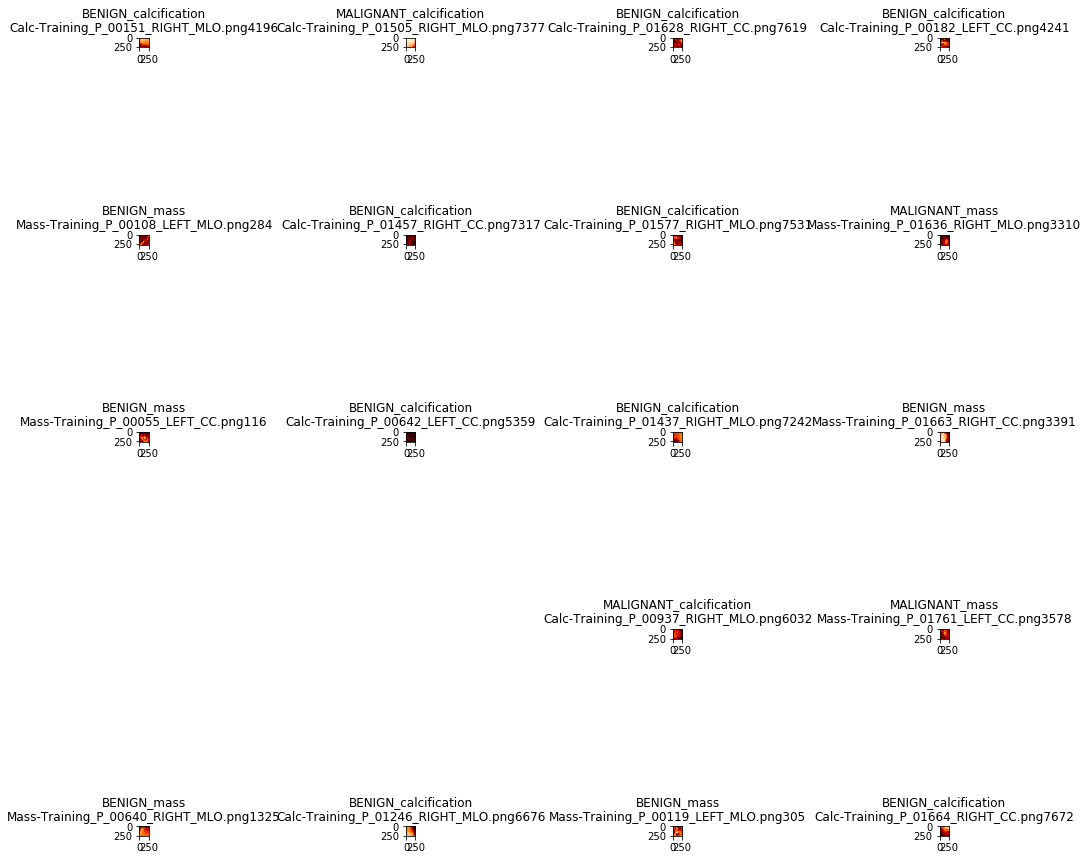

In [33]:
N = 20
idx = random.sample(range(len(CBIS_train_patches)), k=N)
plt.figure(figsize=(15,15))
for i, j in enumerate(idx):
    plt.subplot(5,4,i+1)
    plt.imshow(CBIS_train_patches[j].reshape(256, 256), cmap='gist_heat')
    plt.title(CBIS_train_labels[j] + "\n" + CBIS_train_FNs[j] + str(j))
    plt.tight_layout()
plt.show()

In [34]:
#combine train and test data 

CBIS_all_patches = np.concatenate([CBIS_train_patches, CBIS_test_patches], axis=0)
CBIS_all_labels = np.concatenate([CBIS_train_labels, CBIS_test_labels], axis=0)
CBIS_all_FNs = np.concatenate([CBIS_train_FNs, CBIS_test_FNs], axis=0)

CBIS_all_patches, CBIS_all_labels, CBIS_all_FNs = \
shuffle(CBIS_all_patches, CBIS_all_labels, CBIS_all_FNs, random_state=19510705)

In [35]:
#split the combined data into train and test
train_patches, test_patches, train_labels, test_labels, train_FNs, test_FNs = \
train_test_split(CBIS_all_patches, CBIS_all_labels, CBIS_all_FNs, test_size = 0.183565, random_state=19430727)

In [36]:
#train data
train_images = train_patches
train_labels = train_labels
train_FNs = train_FNs

#test data
test_images =  test_patches
test_labels = test_labels
test_FNs = test_FNs

In [37]:
le = preprocessing.LabelEncoder()
le.fit(train_labels)

LabelEncoder()

In [38]:
list(le.classes_)

['BENIGN_calcification',
 'BENIGN_mass',
 'MALIGNANT_calcification',
 'MALIGNANT_mass']

In [39]:
#Convert Normal to 0 
train_labels_en = le.transform(train_labels)
#train_labels_en[train_labels_en==]=0

test_labels_en = le.transform(test_labels)
#test_labels_en[test_labels_en==5]=0

In [40]:
train_bin_labels = np.zeros(len(train_labels_en)).astype(np.int32)
train_bin_labels[train_labels_en != 0] = 1

test_bin_labels = np.zeros(len(test_labels_en)).astype(np.int32)
test_bin_labels[test_labels_en != 0] = 1

In [41]:
np.unique(train_bin_labels)

array([0, 1])

In [42]:
np.unique(test_bin_labels)

array([0, 1])

In [43]:
np.save(os.path.join("Label", "train_labels_en.npy"), train_labels_en)
np.save(os.path.join("Label", "test_labels_en.npy"), test_labels_en)
np.save(os.path.join("Label", "train_bin_labels.npy"), train_bin_labels)
np.save(os.path.join("Label", "test_bin_labels.npy"), test_bin_labels)

In [44]:
X_val, X_test, y_val, y_test, y_val_multi, y_test_multi = \
    train_test_split(test_images, test_bin_labels, test_labels_en, test_size=0.5, random_state=19730104)
X_train, y_train, y_train_multi = \
     shuffle(train_images, train_bin_labels, train_labels_en, random_state=100)

In [45]:
X_test = test_images
y_test = test_labels_en

X_train = train_images
y_train = train_labels_en

In [46]:
X_train.shape

(8599, 256, 256, 1)

In [47]:
y_train.shape

(8599,)

In [48]:
np.save(os.path.join("Data/256", 'X_train.npy'), X_train)
np.save(os.path.join("Data/256", 'y_train.npy'), y_train)
np.save(os.path.join("Data/256", 'train_labels_multi.npy'), y_train_multi)

In [49]:
np.save(os.path.join("Data/256", 'X_val.npy'), X_val)
np.save(os.path.join("Data/256", 'y_val.npy'), y_val)
np.save(os.path.join("Data/256", 'y_val_labels_multi.npy'), y_val_multi)

In [50]:
np.save(os.path.join("Data/256", 'X_test.npy'), X_test)
np.save(os.path.join("Data/256", 'y_test.npy'), y_test)
np.save(os.path.join("Data/256", 'y_test_labels_multi.npy'), y_test_multi)